<a href="https://colab.research.google.com/github/akpanitorobong/dissertation/blob/main/Dissertation_ECG_Arrhythmia_Beat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECG Arrhythmia Beat Classification with PhysioNet Dataset**

This notebook provides an end-to-end pipeline for detecting arrhythmia beats using the PhysioNet 12-lead ECG Arrhythmia Database l. It performs annotation parsing, beat extraction, 1D ResNet classification, and result visualizations.

# **IDE and Dataset Preparation**

## **Library Installs and Imports**

**Install libraries**

In [2]:
!pip install wfdb==4.1.2 numpy pandas scipy scikit-learn tensorflow seaborn matplotlib tqdm ecg_plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


**Import Libraries**

In [3]:
print("Importing libraries...")

# === Standard Library Imports ===
import os  # Interacting with the operating system
import re  # Regular expressions
from pathlib import Path  # Filesystem paths
from collections import Counter  # Counting hashable items

# === Dataset
from google.colab import drive

# === Data Handling and Numerical Computation ===
import numpy as np  # Numerical computations
import pandas as pd  # Data analysis and manipulation

# === Signal Processing (WFDB and ECG) ===
import wfdb  # Read/write/process WFDB-format signals
from wfdb import processing as wfproc  # WFDB signal processing utilities
from scipy.io import loadmat  # Load MATLAB .mat files
import ecg_plot  # ECG signal visualization

# === Machine Learning and Evaluation ===
from sklearn.model_selection import train_test_split  # Train/test data split
from sklearn.preprocessing import LabelEncoder  # Label encoding
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation metrics
from sklearn.utils import class_weight

# === Deep Learning (TensorFlow/Keras) ===
import tensorflow as tf  # TensorFlow core
from tensorflow.keras import layers, models, callbacks, utils  # Keras modules for model building

# === Visualization ===
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualization

# === Utilities ===
from tqdm import tqdm  # Progress bar for loops

print("Importation complete")

Importing libraries...
Importation complete


## **Setup Dataset**

In [4]:

# Mount Google Drive
drive.mount('/content/drive')

# Ensure local dataset directory exists
os.makedirs('/content/dataset', exist_ok=True)

# Recursively and forcefully copy all contents
!cp -r "/content/drive/MyDrive/Dataset/WFDBRecords/" "/content/dataset/WFDBRecords"


Mounted at /content/drive


## **Helper Functions for Signal Data Extraction**

**Load ECG data from a .mat file specified by filename.**

In [5]:
def load_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

**Extract diagnosis label from a .hea ECG header file using SNOMED codes**

In [6]:
def parse_header_label(hea_path: Path) -> str:
    with open(hea_path, "r") as f:
        for line in f:
            if line.startswith("#Dx:"):
                codes = re.findall(r"\d+", line)
                for c in codes:
                    if c in SNOMED_MAP:
                        return SNOMED_MAP[c]
    return DEFAULT_LABEL

**Load ECG signal from a record, optionally limiting duration in seconds**

In [7]:
def load_signal(record_base: Path, max_seconds: int | None) -> np.ndarray:
    # Read the ECG record (it loads both the signal and metadata)
    rec = wfdb.rdrecord(str(record_base))

    # Get the physical signal (already converted to real units like millivolts)
    sig = rec.p_signal

    # If a time limit is given, trim the signal to that many seconds
    if max_seconds is not None:
        # rec.fs is the sampling rate (e.g., 500 samples per second)
        sig = sig[: int(max_seconds * rec.fs)]

    # Convert the signal to 32-bit floats (saves memory, works well for ML)
    return sig.astype(np.float32)

**Detect R-peaks (heartbeats) from a selected ECG lead using GQRS algorithm**

In [8]:
def detect_rpeaks(sig: np.ndarray, fs: int) -> np.ndarray:
    # Choose one ECG lead (channel) from the multichannel signal to analyze
    # LEAD_INDEX is a constant that tells which lead we're using (e.g., Lead II)
    x = sig[:, LEAD_INDEX]

    # Use the GQRS algorithm to detect R-peaks (heartbeat locations) in the signal
    # fs is the sampling rate, used to correctly time the peaks
    peaks = wfproc.gqrs_detect(x, fs=fs)

    # Optionally, you could improve the detection with correction (currently commented out)
    # peaks = wfproc.correct_peaks(x, peak_inds=peaks, search_radius=int(0.05 * fs), smooth_window_size=2)

    return peaks  # Return the list of detected peak positions (as sample indices)

**Extract fixed-size heartbeat segments (beats) around each R-peak from an ECG signal**

In [9]:
def extract_beats(sig: np.ndarray, rpeaks: np.ndarray, fs: int) -> np.ndarray:
    # Calculate how many samples to take before and after each R-peak
    half_win = int(WINDOW_SEC * fs / 2)

    beats = []  # List to hold each extracted beat segment

    for r in rpeaks:
        # Define the window around the R-peak
        start = r - half_win
        end = r + half_win

        # Skip the beat if it would go beyond the signal's boundaries
        if start < 0 or end > len(sig):
            continue

        # Extract the beat segment from the chosen lead
        beat = sig[start:end, LEAD_INDEX]
        beats.append(beat)

    # Stack the list of beats into a 2D array (each row = one beat),
    # or return an empty array if no beats were valid
    return np.stack(beats) if beats else np.empty((0, int(WINDOW_SEC * fs)))


**Plot ECG signal from a .mat file using a fixed sample rate and scaled voltage.**

In [10]:
def plot_ecg(path):
    x = path
    print("ECG recordings for "+x)
    ecg_data = load_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='ECG Plot')
    ecg_plot.show()

## **Exploratory Data Analysis**

ECG recordings for /content/dataset/WFDBRecords/01/010/JS00001.mat


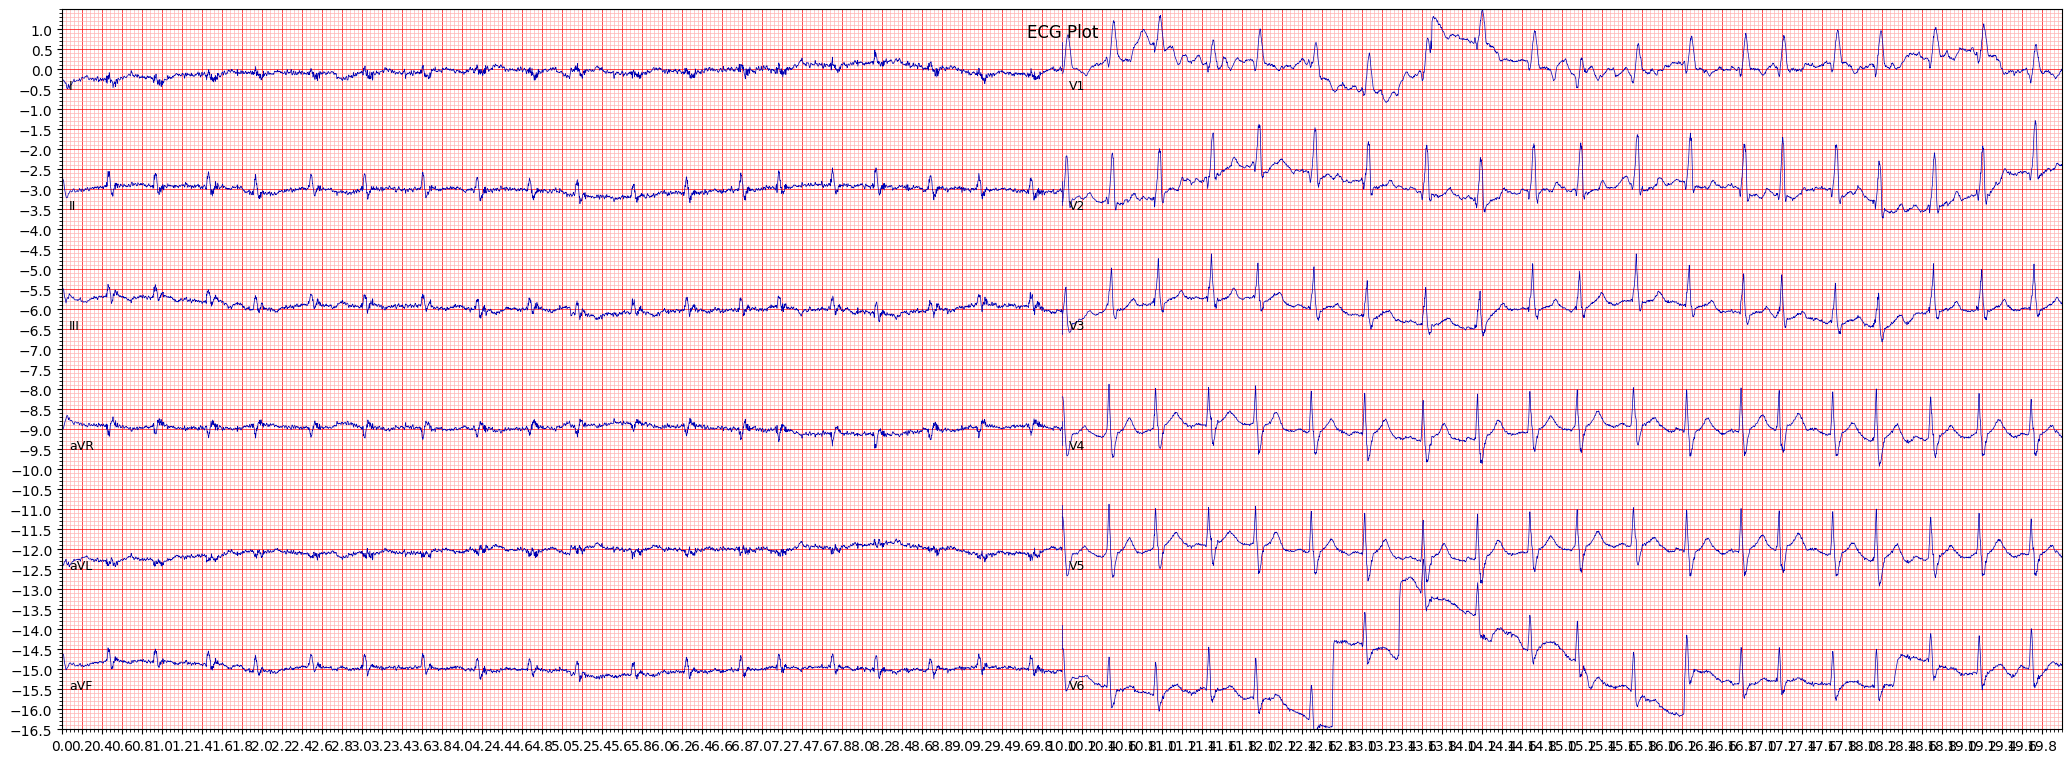

ECG recordings for /content/dataset/WFDBRecords/01/010/JS00002.mat


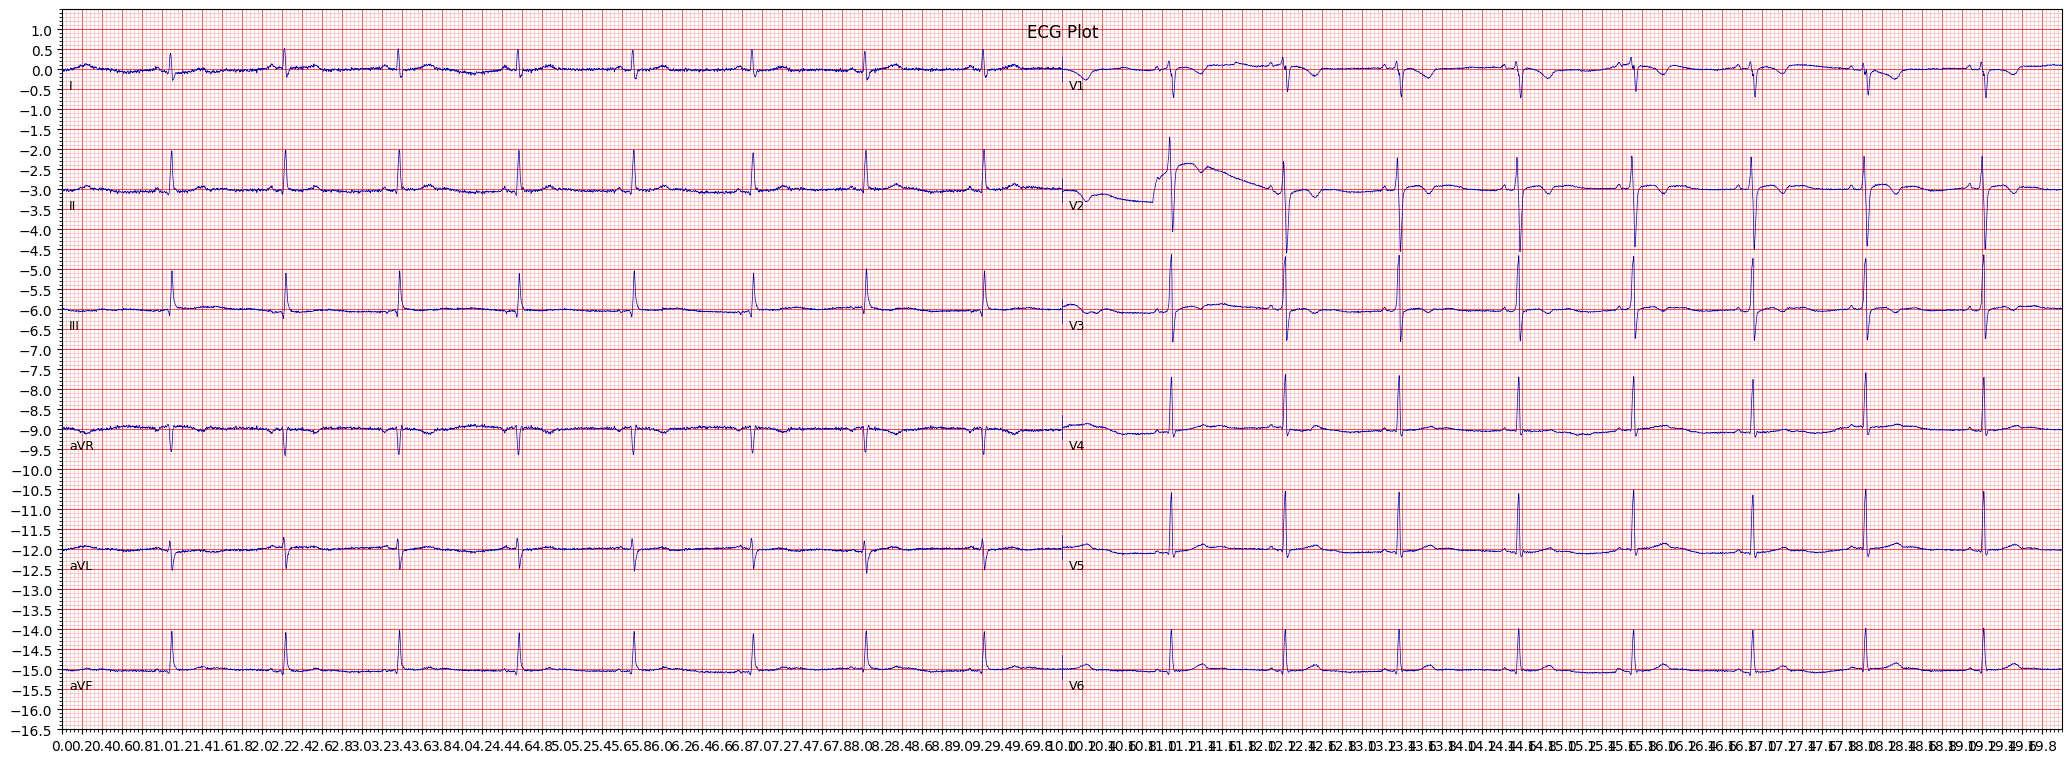

In [11]:
#Use functions to plot ECG recordings from two different patients in the dataset
plot_ecg('/content/dataset/WFDBRecords/01/010/JS00001.mat')
plot_ecg('/content/dataset/WFDBRecords/01/010/JS00002.mat')

# **Data Preprocessing**

## **Data Processing Parameters**

In [12]:
MAX_SECONDS = 30  # Maximum number of seconds to process from each ECG recording
WINDOW_SEC = 1.0  # Length of the sliding window in seconds
PRE_R_SEC = 0.5  # Time before the R-peak to include in the window (in seconds)
LEAD_INDEX = 1  # Index of the ECG lead to use (e.g., lead II)
FS = 500  # Sampling frequency in Hz

# Mapping of SNOMED codes to diagnostic labels
SNOMED_MAP = {
    "164889003": "Normal",      # Normal sinus rhythm
    "426177001": "AV_Block",    # Atrioventricular block
    "39732003":  "Other",       # Other rhythm (unspecified)
    "164909002": "AFib",        # Atrial fibrillation
    "164931005": "Other",       # Other rhythm (unspecified)
    "251146004": "Other",       # Other rhythm (unspecified)
}

DEFAULT_LABEL = "Other"  # Default label if SNOMED code is not recognized

## **Load and Preprocess Data**

In [13]:
# Set the path to the dataset
DATA_DIR = Path("/content/dataset/WFDBRecords")

# Lists to store the beat data and their corresponding labels
beats, labels = [], []

# Find all .hea files in the dataset folder (these contain diagnosis info)
hea_files = sorted(DATA_DIR.rglob("*.hea"))
print(f"Found {len(hea_files)} header files")

# Loop through each ECG record found
for hea in tqdm(hea_files, desc="Processing records"):
    # Get the diagnosis label (like "normal", "AFib", etc.) from the header file
    label = parse_header_label(hea)

    # Get the base file path (removing .hea to access corresponding .mat signal file)
    record_base = hea.with_suffix("")

    try:
        # Load the ECG signal (limited to MAX_SECONDS, if specified)
        sig = load_signal(record_base, MAX_SECONDS)
    except Exception as e:
        # If the signal can't be read (e.g., missing or bad file), skip it
        continue

    # Find R-peaks in the ECG signal (locations of heartbeats)
    rpeaks = detect_rpeaks(sig, FS)

    # Cut out beat-sized windows around each R-peak
    record_beats = extract_beats(sig, rpeaks, FS)
    print(record_beats)  # Show extracted beats for debugging

    # Skip files that didn’t yield any valid beats
    if record_beats.size == 0:
        continue

    # Save the beat segments and match each one with the same label
    beats.append(record_beats)
    labels.extend([label] * len(record_beats))

# Combine all beat arrays into one big NumPy array
X = np.concatenate(beats)

# Add a new axis so the shape is (samples, timesteps, channels), required by Conv1D
X = X[..., np.newaxis]

# Encode text labels (like "Normal", "AFib") into numeric values (0, 1, 2, ...)
le = LabelEncoder()
y = le.fit_transform(labels)

# Store the readable class names for reference later
CLASS_NAMES = le.classes_.tolist()

Found 3000 header files


Processing records:   0%|          | 2/3000 [00:00<03:48, 13.09it/s]

[[ 0.049  0.059  0.063 ...  0.059  0.068  0.073]
 [ 0.4    0.4    0.366 ...  0.254  0.234  0.278]
 [ 0.044  0.029  0.024 ...  0.049  0.049  0.034]
 ...
 [ 0.078  0.078  0.068 ...  0.024  0.029  0.015]
 [ 0.278  0.254  0.181 ...  0.015  0.088  0.122]
 [-0.034 -0.01  -0.005 ... -0.054 -0.054 -0.054]]
[[ 0.049  0.059  0.063 ...  0.059  0.068  0.073]
 [ 0.4    0.4    0.366 ...  0.254  0.234  0.278]
 [ 0.044  0.029  0.024 ...  0.049  0.049  0.034]
 ...
 [ 0.078  0.078  0.068 ...  0.024  0.029  0.015]
 [ 0.278  0.254  0.181 ...  0.015  0.088  0.122]
 [-0.034 -0.01  -0.005 ... -0.054 -0.054 -0.054]]
[[-0.078 -0.059 -0.049 ...  0.015  0.02   0.   ]
 [-0.024 -0.02  -0.01  ... -0.039 -0.015 -0.024]
 [-0.034 -0.039 -0.059 ...  0.015  0.005  0.005]
 ...
 [-0.049 -0.049 -0.054 ... -0.01  -0.024 -0.029]
 [-0.088 -0.073 -0.093 ... -0.01  -0.029 -0.029]
 [ 0.005  0.01   0.    ...  0.01   0.015  0.029]]


Processing records:   0%|          | 4/3000 [00:00<03:48, 13.09it/s]

[[-0.078 -0.059 -0.049 ...  0.015  0.02   0.   ]
 [-0.024 -0.02  -0.01  ... -0.039 -0.015 -0.024]
 [-0.034 -0.039 -0.059 ...  0.015  0.005  0.005]
 ...
 [-0.049 -0.049 -0.054 ... -0.01  -0.024 -0.029]
 [-0.088 -0.073 -0.093 ... -0.01  -0.029 -0.029]
 [ 0.005  0.01   0.    ...  0.01   0.015  0.029]]
[[-0.02  -0.02  -0.01  ... -0.02  -0.02  -0.02 ]
 [-0.02  -0.024 -0.024 ... -0.068 -0.068 -0.068]
 [-0.044 -0.054 -0.054 ... -0.039 -0.039 -0.039]
 ...
 [-0.044 -0.039 -0.034 ... -0.044 -0.039 -0.034]
 [-0.034 -0.029 -0.039 ... -0.059 -0.059 -0.059]
 [-0.059 -0.059 -0.068 ... -0.107 -0.107 -0.107]]


Processing records:   0%|          | 6/3000 [00:00<03:47, 13.13it/s]

[[-0.02  -0.02  -0.01  ... -0.02  -0.02  -0.02 ]
 [-0.02  -0.024 -0.024 ... -0.068 -0.068 -0.068]
 [-0.044 -0.054 -0.054 ... -0.039 -0.039 -0.039]
 ...
 [-0.044 -0.039 -0.034 ... -0.044 -0.039 -0.034]
 [-0.034 -0.029 -0.039 ... -0.059 -0.059 -0.059]
 [-0.059 -0.059 -0.068 ... -0.107 -0.107 -0.107]]


Processing records:   0%|          | 8/3000 [00:00<03:49, 13.02it/s]

[[-0.005  0.015  0.005 ... -0.137 -0.127 -0.093]
 [ 0.078  0.083  0.093 ... -0.098 -0.093 -0.088]
 [-0.088 -0.098 -0.088 ... -0.073 -0.044 -0.044]
 ...
 [ 0.034  0.059  0.054 ... -0.054 -0.044 -0.039]
 [ 0.029  0.029  0.029 ... -0.093 -0.093 -0.088]
 [ 0.034  0.034  0.024 ... -0.117 -0.127 -0.127]]
[[-0.005  0.015  0.005 ... -0.137 -0.127 -0.093]
 [ 0.078  0.083  0.093 ... -0.098 -0.093 -0.088]
 [-0.088 -0.098 -0.088 ... -0.073 -0.044 -0.044]
 ...
 [ 0.034  0.059  0.054 ... -0.054 -0.044 -0.039]
 [ 0.029  0.029  0.029 ... -0.093 -0.093 -0.088]
 [ 0.034  0.034  0.024 ... -0.117 -0.127 -0.127]]
[[-0.044 -0.044 -0.039 ... -0.01  -0.015 -0.02 ]
 [-0.029 -0.039 -0.039 ... -0.039 -0.029 -0.029]
 [-0.024 -0.024 -0.024 ...  0.    -0.01  -0.01 ]
 ...
 [-0.034 -0.024 -0.02  ... -0.01  -0.02  -0.02 ]
 [-0.02  -0.02  -0.029 ... -0.049 -0.039 -0.039]
 [-0.039 -0.044 -0.044 ... -0.01  -0.01  -0.01 ]]


Processing records:   0%|          | 10/3000 [00:00<03:46, 13.20it/s]

[[-0.044 -0.044 -0.039 ... -0.01  -0.015 -0.02 ]
 [-0.029 -0.039 -0.039 ... -0.039 -0.029 -0.029]
 [-0.024 -0.024 -0.024 ...  0.    -0.01  -0.01 ]
 ...
 [-0.034 -0.024 -0.02  ... -0.01  -0.02  -0.02 ]
 [-0.02  -0.02  -0.029 ... -0.049 -0.039 -0.039]
 [-0.039 -0.044 -0.044 ... -0.01  -0.01  -0.01 ]]
[[ 0.122  0.098  0.127 ... -0.156 -0.137 -0.073]
 [-0.02  -0.005 -0.039 ... -0.049 -0.044 -0.063]
 [-0.127 -0.127 -0.137 ... -0.059 -0.024 -0.044]
 ...
 [ 0.142  0.146  0.127 ...  0.146  0.2    0.229]
 [-0.059 -0.083 -0.088 ... -0.024  0.005  0.029]
 [ 0.024  0.049  0.024 ... -0.015  0.015  0.005]]


Processing records:   0%|          | 12/3000 [00:00<03:48, 13.07it/s]

[[ 0.122  0.098  0.127 ... -0.156 -0.137 -0.073]
 [-0.02  -0.005 -0.039 ... -0.049 -0.044 -0.063]
 [-0.127 -0.127 -0.137 ... -0.059 -0.024 -0.044]
 ...
 [ 0.142  0.146  0.127 ...  0.146  0.2    0.229]
 [-0.059 -0.083 -0.088 ... -0.024  0.005  0.029]
 [ 0.024  0.049  0.024 ... -0.015  0.015  0.005]]


Processing records:   0%|          | 14/3000 [00:01<03:48, 13.05it/s]

[[-0.049 -0.054 -0.059 ... -0.068 -0.059 -0.063]
 [-0.063 -0.073 -0.059 ... -0.049 -0.063 -0.054]
 [-0.059 -0.054 -0.063 ... -0.049 -0.054 -0.054]
 ...
 [-0.039 -0.044 -0.049 ... -0.068 -0.063 -0.063]
 [-0.044 -0.049 -0.059 ...  0.005 -0.01   0.005]
 [-0.01   0.    -0.01  ... -0.029 -0.054 -0.034]]
[[-0.049 -0.054 -0.059 ... -0.068 -0.059 -0.063]
 [-0.063 -0.073 -0.059 ... -0.049 -0.063 -0.054]
 [-0.059 -0.054 -0.063 ... -0.049 -0.054 -0.054]
 ...
 [-0.039 -0.044 -0.049 ... -0.068 -0.063 -0.063]
 [-0.044 -0.049 -0.059 ...  0.005 -0.01   0.005]
 [-0.01   0.    -0.01  ... -0.029 -0.054 -0.034]]
[[-0.02  -0.02  -0.02  ... -0.029 -0.049 -0.044]
 [-0.059 -0.054 -0.059 ... -0.054 -0.054 -0.059]
 [-0.044 -0.049 -0.063 ... -0.02  -0.015 -0.01 ]
 ...
 [-0.059 -0.054 -0.054 ... -0.059 -0.054 -0.068]
 [-0.054 -0.068 -0.068 ... -0.015 -0.02  -0.024]
 [-0.044 -0.054 -0.044 ...  0.    -0.01  -0.005]]


Processing records:   1%|          | 16/3000 [00:01<03:48, 13.07it/s]

[[-0.02  -0.02  -0.02  ... -0.029 -0.049 -0.044]
 [-0.059 -0.054 -0.059 ... -0.054 -0.054 -0.059]
 [-0.044 -0.049 -0.063 ... -0.02  -0.015 -0.01 ]
 ...
 [-0.059 -0.054 -0.054 ... -0.059 -0.054 -0.068]
 [-0.054 -0.068 -0.068 ... -0.015 -0.02  -0.024]
 [-0.044 -0.054 -0.044 ...  0.    -0.01  -0.005]]
[[-0.063 -0.049 -0.039 ...  0.054  0.054  0.049]
 [ 0.073  0.068  0.049 ...  0.034  0.029  0.029]
 [ 0.039  0.024  0.015 ... -0.093 -0.098 -0.098]
 ...
 [ 0.054  0.059  0.049 ...  0.024  0.02   0.02 ]
 [ 0.029  0.024  0.015 ... -0.073 -0.078 -0.078]
 [-0.073 -0.078 -0.083 ... -0.054 -0.068 -0.078]]


Processing records:   1%|          | 18/3000 [00:01<03:49, 13.01it/s]

[[-0.063 -0.049 -0.039 ...  0.054  0.054  0.049]
 [ 0.073  0.068  0.049 ...  0.034  0.029  0.029]
 [ 0.039  0.024  0.015 ... -0.093 -0.098 -0.098]
 ...
 [ 0.054  0.059  0.049 ...  0.024  0.02   0.02 ]
 [ 0.029  0.024  0.015 ... -0.073 -0.078 -0.078]
 [-0.073 -0.078 -0.083 ... -0.054 -0.068 -0.078]]


Processing records:   1%|          | 20/3000 [00:01<03:48, 13.02it/s]

[[-0.015 -0.005 -0.005 ... -0.039 -0.034 -0.029]
 [-0.039 -0.039 -0.039 ... -0.098 -0.098 -0.098]
 [-0.073 -0.078 -0.083 ... -0.029 -0.029 -0.02 ]
 ...
 [-0.063 -0.063 -0.063 ... -0.068 -0.068 -0.068]
 [-0.039 -0.034 -0.044 ...  0.01   0.01   0.01 ]
 [ 0.005  0.01   0.01  ... -0.068 -0.068 -0.068]]
[[-0.015 -0.005 -0.005 ... -0.039 -0.034 -0.029]
 [-0.039 -0.039 -0.039 ... -0.098 -0.098 -0.098]
 [-0.073 -0.078 -0.083 ... -0.029 -0.029 -0.02 ]
 ...
 [-0.063 -0.063 -0.063 ... -0.068 -0.068 -0.068]
 [-0.039 -0.034 -0.044 ...  0.01   0.01   0.01 ]
 [ 0.005  0.01   0.01  ... -0.068 -0.068 -0.068]]
[[-0.088 -0.078 -0.054 ... -0.078 -0.117 -0.102]
 [-0.034 -0.024 -0.034 ... -0.063 -0.054 -0.034]
 [-0.117 -0.137 -0.166 ... -0.112 -0.073 -0.059]
 ...
 [-0.083 -0.068 -0.063 ... -0.078 -0.068 -0.102]
 [-0.073 -0.068 -0.073 ... -0.029 -0.044 -0.034]
 [-0.078 -0.068 -0.102 ... -0.029 -0.039 -0.044]]


Processing records:   1%|          | 22/3000 [00:01<03:50, 12.90it/s]

[[-0.088 -0.078 -0.054 ... -0.078 -0.117 -0.102]
 [-0.034 -0.024 -0.034 ... -0.063 -0.054 -0.034]
 [-0.117 -0.137 -0.166 ... -0.112 -0.073 -0.059]
 ...
 [-0.083 -0.068 -0.063 ... -0.078 -0.068 -0.102]
 [-0.073 -0.068 -0.073 ... -0.029 -0.044 -0.034]
 [-0.078 -0.068 -0.102 ... -0.029 -0.039 -0.044]]
[[-0.044 -0.049 -0.039 ... -0.073 -0.068 -0.059]
 [-0.054 -0.044 -0.039 ... -0.039 -0.024 -0.029]
 [-0.029 -0.024 -0.02  ... -0.029 -0.024 -0.024]
 ...
 [-0.01  -0.005 -0.005 ... -0.049 -0.054 -0.049]
 [-0.054 -0.049 -0.054 ... -0.034 -0.034 -0.039]
 [-0.005 -0.01  -0.01  ... -0.029 -0.024 -0.034]]


Processing records:   1%|          | 24/3000 [00:01<03:48, 13.01it/s]

[[-0.044 -0.049 -0.039 ... -0.073 -0.068 -0.059]
 [-0.054 -0.044 -0.039 ... -0.039 -0.024 -0.029]
 [-0.029 -0.024 -0.02  ... -0.029 -0.024 -0.024]
 ...
 [-0.01  -0.005 -0.005 ... -0.049 -0.054 -0.049]
 [-0.054 -0.049 -0.054 ... -0.034 -0.034 -0.039]
 [-0.005 -0.01  -0.01  ... -0.029 -0.024 -0.034]]


Processing records:   1%|          | 26/3000 [00:01<03:47, 13.06it/s]

[[ 0.249  0.254  0.244 ... -0.102 -0.098 -0.093]
 [-0.102 -0.127 -0.122 ... -0.034 -0.137 -0.083]
 [-0.039 -0.063 -0.078 ... -0.093 -0.083 -0.102]
 ...
 [-0.039 -0.044 -0.034 ... -0.068 -0.063 -0.054]
 [ 0.078  0.093  0.112 ... -0.083 -0.083 -0.059]
 [-0.039 -0.049 -0.059 ... -0.093 -0.073 -0.049]]
[[ 0.249  0.254  0.244 ... -0.102 -0.098 -0.093]
 [-0.102 -0.127 -0.122 ... -0.034 -0.137 -0.083]
 [-0.039 -0.063 -0.078 ... -0.093 -0.083 -0.102]
 ...
 [-0.039 -0.044 -0.034 ... -0.068 -0.063 -0.054]
 [ 0.078  0.093  0.112 ... -0.083 -0.083 -0.059]
 [-0.039 -0.049 -0.059 ... -0.093 -0.073 -0.049]]
[[-0.034 -0.034 -0.034 ... -0.005 -0.005 -0.01 ]
 [-0.005 -0.01  -0.015 ... -0.02  -0.02  -0.01 ]
 [-0.01  -0.02  -0.01  ... -0.02  -0.02  -0.024]
 ...
 [-0.01  -0.01   0.    ... -0.034 -0.034 -0.049]
 [-0.034 -0.039 -0.034 ... -0.015 -0.02  -0.005]
 [-0.005  0.    -0.01  ...  0.005  0.005  0.01 ]]


Processing records:   1%|          | 28/3000 [00:02<03:48, 13.00it/s]

[[-0.034 -0.034 -0.034 ... -0.005 -0.005 -0.01 ]
 [-0.005 -0.01  -0.015 ... -0.02  -0.02  -0.01 ]
 [-0.01  -0.02  -0.01  ... -0.02  -0.02  -0.024]
 ...
 [-0.01  -0.01   0.    ... -0.034 -0.034 -0.049]
 [-0.034 -0.039 -0.034 ... -0.015 -0.02  -0.005]
 [-0.005  0.    -0.01  ...  0.005  0.005  0.01 ]]
[[-0.024 -0.02  -0.02  ... -0.049 -0.049 -0.049]
 [-0.02  -0.015 -0.015 ... -0.039 -0.039 -0.039]
 [-0.024 -0.02  -0.02  ... -0.034 -0.029 -0.029]
 ...
 [ 0.01   0.005  0.01  ... -0.034 -0.029 -0.029]
 [-0.039 -0.039 -0.039 ... -0.02  -0.02  -0.02 ]
 [-0.005 -0.005  0.    ... -0.034 -0.034 -0.034]]


Processing records:   1%|          | 30/3000 [00:02<03:47, 13.06it/s]

[[-0.024 -0.02  -0.02  ... -0.049 -0.049 -0.049]
 [-0.02  -0.015 -0.015 ... -0.039 -0.039 -0.039]
 [-0.024 -0.02  -0.02  ... -0.034 -0.029 -0.029]
 ...
 [ 0.01   0.005  0.01  ... -0.034 -0.029 -0.029]
 [-0.039 -0.039 -0.039 ... -0.02  -0.02  -0.02 ]
 [-0.005 -0.005  0.    ... -0.034 -0.034 -0.034]]


Processing records:   1%|          | 32/3000 [00:02<03:46, 13.10it/s]

[[-0.039 -0.015 -0.024 ... -0.059 -0.068 -0.059]
 [-0.054 -0.049 -0.039 ... -0.02  -0.039 -0.024]
 [-0.02  -0.024  0.    ... -0.034 -0.039 -0.063]
 ...
 [-0.044 -0.054 -0.063 ... -0.015 -0.044 -0.039]
 [-0.015 -0.01  -0.024 ... -0.024  0.    -0.01 ]
 [ 0.    -0.029 -0.039 ... -0.015 -0.015 -0.005]]
[[-0.039 -0.015 -0.024 ... -0.059 -0.068 -0.059]
 [-0.054 -0.049 -0.039 ... -0.02  -0.039 -0.024]
 [-0.02  -0.024  0.    ... -0.034 -0.039 -0.063]
 ...
 [-0.044 -0.054 -0.063 ... -0.015 -0.044 -0.039]
 [-0.015 -0.01  -0.024 ... -0.024  0.    -0.01 ]
 [ 0.    -0.029 -0.039 ... -0.015 -0.015 -0.005]]
[[ 0.     0.01  -0.005 ...  0.005  0.015  0.015]
 [ 0.015  0.015  0.015 ...  0.034  0.034  0.044]
 [ 0.029  0.039  0.029 ... -0.024 -0.024 -0.034]
 ...
 [-0.049 -0.063 -0.073 ... -0.01  -0.005 -0.01 ]
 [-0.01  -0.015 -0.02  ... -0.078 -0.054 -0.039]
 [-0.073 -0.078 -0.068 ... -0.132 -0.112 -0.093]]


Processing records:   1%|          | 34/3000 [00:02<03:49, 12.91it/s]

[[ 0.     0.01  -0.005 ...  0.005  0.015  0.015]
 [ 0.015  0.015  0.015 ...  0.034  0.034  0.044]
 [ 0.029  0.039  0.029 ... -0.024 -0.024 -0.034]
 ...
 [-0.049 -0.063 -0.073 ... -0.01  -0.005 -0.01 ]
 [-0.01  -0.015 -0.02  ... -0.078 -0.054 -0.039]
 [-0.073 -0.078 -0.068 ... -0.132 -0.112 -0.093]]
[[ 0.029  0.02  -0.005 ...  0.005  0.044  0.02 ]
 [ 0.005 -0.015 -0.029 ... -0.024  0.005 -0.02 ]
 [ 0.024  0.034  0.015 ... -0.01  -0.054 -0.059]
 ...
 [ 0.034  0.02   0.01  ... -0.015 -0.01   0.039]
 [-0.015 -0.01   0.039 ... -0.01   0.005 -0.029]
 [ 0.005  0.005  0.005 ...  0.    -0.024 -0.02 ]]


Processing records:   1%|          | 36/3000 [00:02<03:46, 13.07it/s]

[[ 0.029  0.02  -0.005 ...  0.005  0.044  0.02 ]
 [ 0.005 -0.015 -0.029 ... -0.024  0.005 -0.02 ]
 [ 0.024  0.034  0.015 ... -0.01  -0.054 -0.059]
 ...
 [ 0.034  0.02   0.01  ... -0.015 -0.01   0.039]
 [-0.015 -0.01   0.039 ... -0.01   0.005 -0.029]
 [ 0.005  0.005  0.005 ...  0.    -0.024 -0.02 ]]


Processing records:   1%|▏         | 38/3000 [00:02<03:49, 12.89it/s]

[[-0.015 -0.039 -0.054 ... -0.098 -0.137 -0.122]
 [-0.083 -0.068 -0.073 ...  0.024 -0.029 -0.049]
 [-0.044 -0.01  -0.02  ... -0.044 -0.015 -0.059]
 ...
 [ 0.005  0.02  -0.02  ... -0.054 -0.059 -0.059]
 [-0.005 -0.02  -0.059 ... -0.034 -0.054 -0.044]
 [-0.02  -0.063 -0.068 ... -0.073 -0.049 -0.024]]
[[-0.015 -0.039 -0.054 ... -0.098 -0.137 -0.122]
 [-0.083 -0.068 -0.073 ...  0.024 -0.029 -0.049]
 [-0.044 -0.01  -0.02  ... -0.044 -0.015 -0.059]
 ...
 [ 0.005  0.02  -0.02  ... -0.054 -0.059 -0.059]
 [-0.005 -0.02  -0.059 ... -0.034 -0.054 -0.044]
 [-0.02  -0.063 -0.068 ... -0.073 -0.049 -0.024]]
[[ 0.034  0.054  0.063 ... -0.044 -0.034 -0.02 ]
 [ 0.098  0.127  0.093 ...  0.005  0.029  0.   ]
 [ 0.029  0.054  0.068 ... -0.015 -0.039 -0.039]
 ...
 [ 0.063  0.093  0.049 ...  0.01   0.015 -0.005]
 [ 0.093  0.098  0.073 ...  0.039  0.02   0.01 ]
 [ 0.054  0.054  0.015 ...  0.005  0.015  0.024]]


Processing records:   1%|▏         | 40/3000 [00:03<03:57, 12.45it/s]

[[ 0.034  0.054  0.063 ... -0.044 -0.034 -0.02 ]
 [ 0.098  0.127  0.093 ...  0.005  0.029  0.   ]
 [ 0.029  0.054  0.068 ... -0.015 -0.039 -0.039]
 ...
 [ 0.063  0.093  0.049 ...  0.01   0.015 -0.005]
 [ 0.093  0.098  0.073 ...  0.039  0.02   0.01 ]
 [ 0.054  0.054  0.015 ...  0.005  0.015  0.024]]
[[-0.068 -0.068 -0.068 ... -0.024 -0.034 -0.039]
 [ 0.01   0.     0.005 ... -0.142 -0.166 -0.185]
 [-0.137 -0.146 -0.142 ... -0.176 -0.161 -0.151]
 ...
 [ 0.068  0.068  0.063 ...  0.102  0.098  0.098]
 [ 0.107  0.102  0.098 ...  0.142  0.146  0.156]
 [ 0.229  0.215  0.176 ... -0.181 -0.176 -0.166]]


Processing records:   1%|▏         | 42/3000 [00:03<03:53, 12.68it/s]

[[-0.068 -0.068 -0.068 ... -0.024 -0.034 -0.039]
 [ 0.01   0.     0.005 ... -0.142 -0.166 -0.185]
 [-0.137 -0.146 -0.142 ... -0.176 -0.161 -0.151]
 ...
 [ 0.068  0.068  0.063 ...  0.102  0.098  0.098]
 [ 0.107  0.102  0.098 ...  0.142  0.146  0.156]
 [ 0.229  0.215  0.176 ... -0.181 -0.176 -0.166]]


Processing records:   1%|▏         | 44/3000 [00:03<03:51, 12.78it/s]

[[-0.073 -0.068 -0.063 ... -0.034 -0.029 -0.029]
 [-0.054 -0.049 -0.054 ... -0.01  -0.005  0.   ]
 [-0.029 -0.034 -0.039 ...  0.01   0.01   0.015]
 ...
 [ 0.049  0.063  0.068 ... -0.122 -0.122 -0.122]
 [-0.083 -0.088 -0.102 ...  0.02   0.024  0.034]
 [ 0.039  0.054  0.063 ... -0.015 -0.02  -0.01 ]]
[[-0.073 -0.068 -0.063 ... -0.034 -0.029 -0.029]
 [-0.054 -0.049 -0.054 ... -0.01  -0.005  0.   ]
 [-0.029 -0.034 -0.039 ...  0.01   0.01   0.015]
 ...
 [ 0.049  0.063  0.068 ... -0.122 -0.122 -0.122]
 [-0.083 -0.088 -0.102 ...  0.02   0.024  0.034]
 [ 0.039  0.054  0.063 ... -0.015 -0.02  -0.01 ]]
[[ 0.249  0.327  0.395 ... -0.015  0.005 -0.01 ]
 [ 0.229  0.273  0.327 ... -0.054 -0.034 -0.034]
 [ 0.224  0.249  0.327 ... -0.029 -0.073 -0.073]
 ...
 [ 0.459  0.522  0.488 ... -0.015 -0.039 -0.059]
 [ 0.429  0.508  0.547 ... -0.024 -0.01   0.01 ]
 [ 0.327  0.395  0.483 ... -0.015 -0.02   0.   ]]


Processing records:   2%|▏         | 46/3000 [00:03<03:50, 12.81it/s]

[[ 0.249  0.327  0.395 ... -0.015  0.005 -0.01 ]
 [ 0.229  0.273  0.327 ... -0.054 -0.034 -0.034]
 [ 0.224  0.249  0.327 ... -0.029 -0.073 -0.073]
 ...
 [ 0.459  0.522  0.488 ... -0.015 -0.039 -0.059]
 [ 0.429  0.508  0.547 ... -0.024 -0.01   0.01 ]
 [ 0.327  0.395  0.483 ... -0.015 -0.02   0.   ]]
[[ 0.005  0.005  0.01  ...  0.005  0.005  0.015]
 [ 0.024  0.029  0.029 ... -0.015 -0.015 -0.005]
 [-0.01  -0.01  -0.015 ...  0.005  0.01   0.005]
 ...
 [ 0.01   0.015  0.01  ...  0.005  0.005  0.005]
 [ 0.01  -0.005  0.    ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.005 -0.005 ... -0.02  -0.015 -0.015]]


Processing records:   2%|▏         | 48/3000 [00:03<03:50, 12.82it/s]

[[ 0.005  0.005  0.01  ...  0.005  0.005  0.015]
 [ 0.024  0.029  0.029 ... -0.015 -0.015 -0.005]
 [-0.01  -0.01  -0.015 ...  0.005  0.01   0.005]
 ...
 [ 0.01   0.015  0.01  ...  0.005  0.005  0.005]
 [ 0.01  -0.005  0.    ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.005 -0.005 ... -0.02  -0.015 -0.015]]


Processing records:   2%|▏         | 50/3000 [00:03<03:59, 12.31it/s]

[[-0.02  -0.015  0.    ...  0.01   0.015  0.015]
 [ 0.005  0.005  0.005 ... -0.01  -0.02  -0.01 ]
 [ 0.005  0.015  0.024 ...  0.02   0.024  0.005]
 ...
 [-0.005  0.     0.005 ... -0.01  -0.015 -0.005]
 [ 0.005 -0.01  -0.015 ...  0.02   0.029  0.039]
 [ 0.044  0.029  0.    ...  0.02   0.015 -0.01 ]]
[[-0.02  -0.015  0.    ...  0.01   0.015  0.015]
 [ 0.005  0.005  0.005 ... -0.01  -0.02  -0.01 ]
 [ 0.005  0.015  0.024 ...  0.02   0.024  0.005]
 ...
 [-0.005  0.     0.005 ... -0.01  -0.015 -0.005]
 [ 0.005 -0.01  -0.015 ...  0.02   0.029  0.039]
 [ 0.044  0.029  0.    ...  0.02   0.015 -0.01 ]]
[[ 0.044  0.078  0.039 ... -0.01  -0.01   0.039]
 [-0.049 -0.078 -0.093 ...  0.005 -0.005 -0.029]
 [-0.029 -0.044 -0.049 ...  0.015 -0.01  -0.024]
 ...
 [ 0.    -0.015 -0.034 ... -0.02   0.005  0.034]
 [ 0.005  0.01   0.01  ... -0.039 -0.039 -0.044]
 [-0.054 -0.034 -0.034 ... -0.039 -0.049 -0.093]]


Processing records:   2%|▏         | 52/3000 [00:04<03:56, 12.46it/s]

[[ 0.044  0.078  0.039 ... -0.01  -0.01   0.039]
 [-0.049 -0.078 -0.093 ...  0.005 -0.005 -0.029]
 [-0.029 -0.044 -0.049 ...  0.015 -0.01  -0.024]
 ...
 [ 0.    -0.015 -0.034 ... -0.02   0.005  0.034]
 [ 0.005  0.01   0.01  ... -0.039 -0.039 -0.044]
 [-0.054 -0.034 -0.034 ... -0.039 -0.049 -0.093]]
[[-0.039 -0.029 -0.059 ... -0.039 -0.015 -0.005]
 [ 0.005  0.015  0.024 ... -0.039 -0.024 -0.02 ]
 [-0.024 -0.005 -0.005 ...  0.02   0.     0.   ]
 ...
 [ 0.068  0.054  0.049 ... -0.029 -0.02  -0.024]
 [-0.078 -0.044 -0.029 ... -0.059 -0.054 -0.029]
 [-0.059 -0.073 -0.078 ...  0.073  0.068  0.078]]


Processing records:   2%|▏         | 54/3000 [00:04<04:06, 11.95it/s]

[[-0.039 -0.029 -0.059 ... -0.039 -0.015 -0.005]
 [ 0.005  0.015  0.024 ... -0.039 -0.024 -0.02 ]
 [-0.024 -0.005 -0.005 ...  0.02   0.     0.   ]
 ...
 [ 0.068  0.054  0.049 ... -0.029 -0.02  -0.024]
 [-0.078 -0.044 -0.029 ... -0.059 -0.054 -0.029]
 [-0.059 -0.073 -0.078 ...  0.073  0.068  0.078]]


Processing records:   2%|▏         | 56/3000 [00:04<04:01, 12.19it/s]

[[-0.024 -0.024 -0.034 ...  0.01   0.015  0.029]
 [ 0.02   0.015  0.005 ... -0.015 -0.024 -0.024]
 [-0.063 -0.107 -0.151 ...  0.02   0.039  0.039]
 ...
 [-0.044 -0.059 -0.029 ...  0.029  0.01   0.029]
 [-0.039 -0.088 -0.063 ...  0.015  0.015  0.02 ]
 [-0.044 -0.054 -0.049 ...  0.024  0.015  0.015]]
[[-0.024 -0.024 -0.034 ...  0.01   0.015  0.029]
 [ 0.02   0.015  0.005 ... -0.015 -0.024 -0.024]
 [-0.063 -0.107 -0.151 ...  0.02   0.039  0.039]
 ...
 [-0.044 -0.059 -0.029 ...  0.029  0.01   0.029]
 [-0.039 -0.088 -0.063 ...  0.015  0.015  0.02 ]
 [-0.044 -0.054 -0.049 ...  0.024  0.015  0.015]]
[[-0.073 -0.063 -0.063 ... -0.049 -0.044 -0.044]
 [-0.054 -0.054 -0.044 ... -0.024 -0.024 -0.029]
 [-0.029 -0.029 -0.024 ... -0.005 -0.01  -0.01 ]
 ...
 [-0.029 -0.024 -0.024 ... -0.063 -0.063 -0.063]
 [-0.073 -0.063 -0.063 ... -0.005 -0.015 -0.029]
 [-0.039 -0.039 -0.054 ... -0.039 -0.049 -0.054]]


Processing records:   2%|▏         | 58/3000 [00:04<03:54, 12.53it/s]

[[-0.073 -0.063 -0.063 ... -0.049 -0.044 -0.044]
 [-0.054 -0.054 -0.044 ... -0.024 -0.024 -0.029]
 [-0.029 -0.029 -0.024 ... -0.005 -0.01  -0.01 ]
 ...
 [-0.029 -0.024 -0.024 ... -0.063 -0.063 -0.063]
 [-0.073 -0.063 -0.063 ... -0.005 -0.015 -0.029]
 [-0.039 -0.039 -0.054 ... -0.039 -0.049 -0.054]]
[[-0.132 -0.088 -0.039 ...  0.078  0.088  0.088]
 [-0.029 -0.029 -0.029 ...  0.063  0.068  0.063]
 [-0.02  -0.02  -0.029 ...  0.054  0.044  0.039]
 ...
 [-0.327 -0.288 -0.244 ... -0.063 -0.068 -0.088]
 [-0.337 -0.337 -0.327 ...  0.02   0.01  -0.01 ]
 [-0.273 -0.244 -0.161 ...  0.029  0.01   0.01 ]]


Processing records:   2%|▏         | 60/3000 [00:04<03:51, 12.68it/s]

[[-0.132 -0.088 -0.039 ...  0.078  0.088  0.088]
 [-0.029 -0.029 -0.029 ...  0.063  0.068  0.063]
 [-0.02  -0.02  -0.029 ...  0.054  0.044  0.039]
 ...
 [-0.327 -0.288 -0.244 ... -0.063 -0.068 -0.088]
 [-0.337 -0.337 -0.327 ...  0.02   0.01  -0.01 ]
 [-0.273 -0.244 -0.161 ...  0.029  0.01   0.01 ]]


Processing records:   2%|▏         | 62/3000 [00:04<03:53, 12.60it/s]

[[-0.01  -0.01  -0.005 ... -0.059 -0.054 -0.049]
 [-0.044 -0.034 -0.039 ... -0.034 -0.034 -0.034]
 [-0.029 -0.029 -0.029 ... -0.029 -0.034 -0.039]
 ...
 [-0.054 -0.029 -0.02  ... -0.039 -0.039 -0.039]
 [-0.054 -0.044 -0.044 ... -0.039 -0.039 -0.039]
 [-0.015 -0.015 -0.01  ... -0.049 -0.049 -0.044]]
[[-0.01  -0.01  -0.005 ... -0.059 -0.054 -0.049]
 [-0.044 -0.034 -0.039 ... -0.034 -0.034 -0.034]
 [-0.029 -0.029 -0.029 ... -0.029 -0.034 -0.039]
 ...
 [-0.054 -0.029 -0.02  ... -0.039 -0.039 -0.039]
 [-0.054 -0.044 -0.044 ... -0.039 -0.039 -0.039]
 [-0.015 -0.015 -0.01  ... -0.049 -0.049 -0.044]]
[[-0.005 -0.015 -0.024 ...  0.063  0.068  0.078]
 [ 0.02   0.024  0.024 ... -0.151 -0.156 -0.156]
 [ 0.215  0.298  0.351 ... -0.068 -0.073 -0.093]
 ...
 [ 0.332  0.39   0.42  ... -0.029 -0.044 -0.049]
 [ 0.    -0.034 -0.02  ...  0.005  0.029  0.029]
 [-0.049 -0.02  -0.015 ... -0.015 -0.02  -0.015]]


Processing records:   2%|▏         | 64/3000 [00:05<03:53, 12.59it/s]

[[-0.005 -0.015 -0.024 ...  0.063  0.068  0.078]
 [ 0.02   0.024  0.024 ... -0.151 -0.156 -0.156]
 [ 0.215  0.298  0.351 ... -0.068 -0.073 -0.093]
 ...
 [ 0.332  0.39   0.42  ... -0.029 -0.044 -0.049]
 [ 0.    -0.034 -0.02  ...  0.005  0.029  0.029]
 [-0.049 -0.02  -0.015 ... -0.015 -0.02  -0.015]]
[[ 0.161  0.171  0.176 ... -0.063 -0.059 -0.044]
 [-0.122 -0.107 -0.117 ...  0.02   0.029  0.029]
 [ 0.405  0.459  0.503 ... -0.005  0.005  0.029]
 ...
 [-0.044 -0.044 -0.054 ... -0.054 -0.059 -0.049]
 [-0.034 -0.034 -0.029 ... -0.039 -0.049 -0.039]
 [ 0.063  0.059  0.054 ...  0.376  0.273  0.107]]


Processing records:   2%|▏         | 66/3000 [00:05<03:54, 12.50it/s]

[[ 0.161  0.171  0.176 ... -0.063 -0.059 -0.044]
 [-0.122 -0.107 -0.117 ...  0.02   0.029  0.029]
 [ 0.405  0.459  0.503 ... -0.005  0.005  0.029]
 ...
 [-0.044 -0.044 -0.054 ... -0.054 -0.059 -0.049]
 [-0.034 -0.034 -0.029 ... -0.039 -0.049 -0.039]
 [ 0.063  0.059  0.054 ...  0.376  0.273  0.107]]


Processing records:   2%|▏         | 68/3000 [00:05<03:53, 12.55it/s]

[[-0.054 -0.049 -0.039 ... -0.044 -0.049 -0.078]
 [-0.088 -0.034  0.    ... -0.073 -0.078 -0.059]
 [-0.059 -0.059 -0.039 ... -0.049 -0.054 -0.024]
 ...
 [-0.039 -0.034 -0.024 ... -0.068 -0.034 -0.034]
 [-0.068 -0.078 -0.039 ... -0.054 -0.044 -0.015]
 [-0.005 -0.029 -0.029 ... -0.063 -0.059 -0.039]]
[[-0.054 -0.049 -0.039 ... -0.044 -0.049 -0.078]
 [-0.088 -0.034  0.    ... -0.073 -0.078 -0.059]
 [-0.059 -0.059 -0.039 ... -0.049 -0.054 -0.024]
 ...
 [-0.039 -0.034 -0.024 ... -0.068 -0.034 -0.034]
 [-0.068 -0.078 -0.039 ... -0.054 -0.044 -0.015]
 [-0.005 -0.029 -0.029 ... -0.063 -0.059 -0.039]]
[[-0.088 -0.098 -0.088 ...  0.346  0.156  0.044]
 [ 0.     0.     0.    ...  0.     0.015  0.015]
 [ 0.068  0.073  0.068 ...  0.059  0.     0.005]
 ...
 [-0.044 -0.039 -0.034 ...  0.     0.     0.   ]
 [ 0.132  0.127  0.122 ...  0.02   0.02   0.024]
 [ 0.063  0.029  0.034 ...  0.015  0.015  0.015]]


Processing records:   2%|▏         | 70/3000 [00:05<03:54, 12.48it/s]

[[-0.088 -0.098 -0.088 ...  0.346  0.156  0.044]
 [ 0.     0.     0.    ...  0.     0.015  0.015]
 [ 0.068  0.073  0.068 ...  0.059  0.     0.005]
 ...
 [-0.044 -0.039 -0.034 ...  0.     0.     0.   ]
 [ 0.132  0.127  0.122 ...  0.02   0.02   0.024]
 [ 0.063  0.029  0.034 ...  0.015  0.015  0.015]]
[[ 0.024  0.     0.029 ... -0.063 -0.063 -0.044]
 [ 0.005 -0.015 -0.083 ... -0.034 -0.024 -0.01 ]
 [ 0.029  0.054  0.029 ... -0.083 -0.054 -0.02 ]
 ...
 [ 0.039 -0.01  -0.02  ... -0.039 -0.024 -0.029]
 [-0.039 -0.005  0.01  ...  0.024 -0.029 -0.015]
 [-0.034 -0.049 -0.024 ... -0.054 -0.068 -0.059]]


Processing records:   2%|▏         | 72/3000 [00:05<03:57, 12.35it/s]

[[ 0.024  0.     0.029 ... -0.063 -0.063 -0.044]
 [ 0.005 -0.015 -0.083 ... -0.034 -0.024 -0.01 ]
 [ 0.029  0.054  0.029 ... -0.083 -0.054 -0.02 ]
 ...
 [ 0.039 -0.01  -0.02  ... -0.039 -0.024 -0.029]
 [-0.039 -0.005  0.01  ...  0.024 -0.029 -0.015]
 [-0.034 -0.049 -0.024 ... -0.054 -0.068 -0.059]]


Processing records:   2%|▏         | 74/3000 [00:05<03:50, 12.72it/s]

[[-0.029 -0.044  0.    ... -0.01  -0.015 -0.024]
 [ 0.083  0.102  0.073 ...  0.425  0.532  0.683]
 [-0.073 -0.044 -0.01  ... -0.098 -0.127 -0.088]
 ...
 [-0.054  0.068  0.02  ... -0.088 -0.068 -0.059]
 [ 0.054  0.098  0.112 ... -0.088 -0.044 -0.063]
 [ 0.068  0.117  0.112 ...  0.088  0.02  -0.01 ]]
[[-0.029 -0.044  0.    ... -0.01  -0.015 -0.024]
 [ 0.083  0.102  0.073 ...  0.425  0.532  0.683]
 [-0.073 -0.044 -0.01  ... -0.098 -0.127 -0.088]
 ...
 [-0.054  0.068  0.02  ... -0.088 -0.068 -0.059]
 [ 0.054  0.098  0.112 ... -0.088 -0.044 -0.063]
 [ 0.068  0.117  0.112 ...  0.088  0.02  -0.01 ]]
[[-0.146 -0.151 -0.156 ... -0.068 -0.049 -0.049]
 [ 0.015 -0.015 -0.039 ... -0.044 -0.044 -0.044]
 [-0.112 -0.161 -0.117 ... -0.034 -0.034 -0.044]
 ...
 [-0.063 -0.078 -0.073 ...  0.273  0.244  0.195]
 [-0.044 -0.039 -0.039 ... -0.02  -0.02  -0.02 ]
 [-0.015 -0.01   0.    ... -0.063 -0.073 -0.073]]


Processing records:   3%|▎         | 76/3000 [00:05<03:56, 12.37it/s]

[[-0.146 -0.151 -0.156 ... -0.068 -0.049 -0.049]
 [ 0.015 -0.015 -0.039 ... -0.044 -0.044 -0.044]
 [-0.112 -0.161 -0.117 ... -0.034 -0.034 -0.044]
 ...
 [-0.063 -0.078 -0.073 ...  0.273  0.244  0.195]
 [-0.044 -0.039 -0.039 ... -0.02  -0.02  -0.02 ]
 [-0.015 -0.01   0.    ... -0.063 -0.073 -0.073]]
[[ 0.02   0.02   0.02  ... -0.049 -0.044 -0.024]
 [ 0.127  0.132  0.132 ... -0.098 -0.098 -0.083]
 [ 0.     0.    -0.01  ...  0.01   0.01   0.024]
 ...
 [ 0.142  0.137  0.137 ...  0.088  0.088  0.102]
 [ 0.215  0.22   0.22  ...  0.054  0.049  0.054]
 [ 0.185  0.185  0.185 ...  0.068  0.059  0.059]]


Processing records:   3%|▎         | 78/3000 [00:06<03:54, 12.47it/s]

[[ 0.02   0.02   0.02  ... -0.049 -0.044 -0.024]
 [ 0.127  0.132  0.132 ... -0.098 -0.098 -0.083]
 [ 0.     0.    -0.01  ...  0.01   0.01   0.024]
 ...
 [ 0.142  0.137  0.137 ...  0.088  0.088  0.102]
 [ 0.215  0.22   0.22  ...  0.054  0.049  0.054]
 [ 0.185  0.185  0.185 ...  0.068  0.059  0.059]]


Processing records:   3%|▎         | 80/3000 [00:06<03:54, 12.47it/s]

[[-0.049 -0.049 -0.049 ... -0.068 -0.068 -0.063]
 [-0.127 -0.137 -0.127 ...  0.    -0.005 -0.01 ]
 [-0.02  -0.029 -0.029 ... -0.073 -0.078 -0.078]
 ...
 [ 0.029  0.034  0.034 ... -0.015 -0.029 -0.034]
 [ 0.098  0.098  0.102 ... -0.059 -0.059 -0.059]
 [ 0.405  0.478  0.532 ... -0.088 -0.083 -0.088]]
[[-0.049 -0.049 -0.049 ... -0.068 -0.068 -0.063]
 [-0.127 -0.137 -0.127 ...  0.    -0.005 -0.01 ]
 [-0.02  -0.029 -0.029 ... -0.073 -0.078 -0.078]
 ...
 [ 0.029  0.034  0.034 ... -0.015 -0.029 -0.034]
 [ 0.098  0.098  0.102 ... -0.059 -0.059 -0.059]
 [ 0.405  0.478  0.532 ... -0.088 -0.083 -0.088]]
[[-0.107 -0.107 -0.107 ... -0.063 -0.063 -0.068]
 [-0.049 -0.054 -0.054 ... -0.098 -0.093 -0.093]
 [-0.068 -0.068 -0.068 ... -0.034 -0.034 -0.039]
 ...
 [-0.029 -0.029 -0.029 ... -0.063 -0.063 -0.068]
 [-0.068 -0.068 -0.068 ... -0.063 -0.063 -0.068]
 [-0.054 -0.049 -0.059 ... -0.078 -0.083 -0.083]]


Processing records:   3%|▎         | 82/3000 [00:06<03:53, 12.52it/s]

[[-0.107 -0.107 -0.107 ... -0.063 -0.063 -0.068]
 [-0.049 -0.054 -0.054 ... -0.098 -0.093 -0.093]
 [-0.068 -0.068 -0.068 ... -0.034 -0.034 -0.039]
 ...
 [-0.029 -0.029 -0.029 ... -0.063 -0.063 -0.068]
 [-0.068 -0.068 -0.068 ... -0.063 -0.063 -0.068]
 [-0.054 -0.049 -0.059 ... -0.078 -0.083 -0.083]]
[[ 0.381  0.459  0.42  ... -0.185 -0.171 -0.151]
 [ 0.366  0.468  0.503 ... -0.156 -0.156 -0.166]
 [ 0.342  0.454  0.551 ... -0.137 -0.122 -0.122]
 ...
 [ 0.234  0.346  0.449 ... -0.098 -0.098 -0.117]
 [ 0.468  0.532  0.556 ... -0.112 -0.098 -0.078]
 [ 0.439  0.532  0.581 ... -0.01  -0.015 -0.01 ]]


Processing records:   3%|▎         | 84/3000 [00:06<03:49, 12.68it/s]

[[ 0.381  0.459  0.42  ... -0.185 -0.171 -0.151]
 [ 0.366  0.468  0.503 ... -0.156 -0.156 -0.166]
 [ 0.342  0.454  0.551 ... -0.137 -0.122 -0.122]
 ...
 [ 0.234  0.346  0.449 ... -0.098 -0.098 -0.117]
 [ 0.468  0.532  0.556 ... -0.112 -0.098 -0.078]
 [ 0.439  0.532  0.581 ... -0.01  -0.015 -0.01 ]]


Processing records:   3%|▎         | 86/3000 [00:06<03:47, 12.81it/s]

[[-0.083 -0.073 -0.078 ... -0.19  -0.176 -0.181]
 [-0.166 -0.166 -0.176 ... -0.107 -0.146 -0.156]
 [-0.171 -0.122 -0.132 ...  0.039  0.015  0.   ]
 ...
 [-0.068 -0.073 -0.102 ... -0.122 -0.122 -0.102]
 [-0.093 -0.083 -0.078 ... -0.112 -0.132 -0.161]
 [-0.049 -0.059 -0.078 ...  0.815  0.888  0.937]]
[[-0.083 -0.073 -0.078 ... -0.19  -0.176 -0.181]
 [-0.166 -0.166 -0.176 ... -0.107 -0.146 -0.156]
 [-0.171 -0.122 -0.132 ...  0.039  0.015  0.   ]
 ...
 [-0.068 -0.073 -0.102 ... -0.122 -0.122 -0.102]
 [-0.093 -0.083 -0.078 ... -0.112 -0.132 -0.161]
 [-0.049 -0.059 -0.078 ...  0.815  0.888  0.937]]
[[ 0.171  0.176  0.181 ...  0.034  0.044  0.044]
 [ 0.254  0.239  0.249 ...  0.015  0.024  0.044]
 [ 0.205  0.171  0.171 ...  0.127  0.117  0.132]
 ...
 [ 0.088  0.063  0.073 ... -0.029 -0.039 -0.024]
 [ 0.044  0.034  0.02  ...  0.049  0.034  0.044]
 [ 0.234  0.239  0.244 ... -0.098 -0.112 -0.102]]


Processing records:   3%|▎         | 91/3000 [00:07<03:02, 15.93it/s]

[[ 0.171  0.176  0.181 ...  0.034  0.044  0.044]
 [ 0.254  0.239  0.249 ...  0.015  0.024  0.044]
 [ 0.205  0.171  0.171 ...  0.127  0.117  0.132]
 ...
 [ 0.088  0.063  0.073 ... -0.029 -0.039 -0.024]
 [ 0.044  0.034  0.02  ...  0.049  0.034  0.044]
 [ 0.234  0.239  0.244 ... -0.098 -0.112 -0.102]]
[[-0.02  -0.015 -0.024 ... -0.024 -0.02  -0.024]
 [-0.029 -0.02  -0.02  ... -0.02  -0.01  -0.015]
 [ 0.112  0.122  0.137 ... -0.024 -0.02  -0.02 ]
 ...
 [-0.044 -0.044 -0.034 ... -0.01   0.    -0.005]
 [ 0.034  0.039  0.024 ... -0.01  -0.01  -0.015]
 [-0.005 -0.01  -0.029 ...  0.005  0.    -0.01 ]]
[[-0.02  -0.015 -0.024 ... -0.024 -0.02  -0.024]
 [-0.029 -0.02  -0.02  ... -0.02  -0.01  -0.015]
 [ 0.112  0.122  0.137 ... -0.024 -0.02  -0.02 ]
 ...
 [-0.044 -0.044 -0.034 ... -0.01   0.    -0.005]
 [ 0.034  0.039  0.024 ... -0.01  -0.01  -0.015]
 [-0.005 -0.01  -0.029 ...  0.005  0.    -0.01 ]]
[[-0.054 -0.044 -0.049 ...  0.024  0.044  0.049]
 [ 0.029  0.     0.02  ...  0.02   0.015  0.01 ]
 [

Processing records:   3%|▎         | 94/3000 [00:07<02:41, 18.04it/s]

[[-0.02  -0.02  -0.029 ... -0.01  -0.01  -0.01 ]
 [-0.078 -0.088 -0.088 ... -0.054 -0.049 -0.039]
 [ 0.005 -0.005 -0.005 ...  0.029  0.039  0.039]
 ...
 [-0.015 -0.024 -0.024 ... -0.044 -0.039 -0.039]
 [-0.015 -0.015 -0.024 ...  0.098  0.088  0.078]
 [ 0.029  0.029  0.024 ... -0.005  0.     0.01 ]]
[[-0.02  -0.02  -0.029 ... -0.01  -0.01  -0.01 ]
 [-0.078 -0.088 -0.088 ... -0.054 -0.049 -0.039]
 [ 0.005 -0.005 -0.005 ...  0.029  0.039  0.039]
 ...
 [-0.015 -0.024 -0.024 ... -0.044 -0.039 -0.039]
 [-0.015 -0.015 -0.024 ...  0.098  0.088  0.078]
 [ 0.029  0.029  0.024 ... -0.005  0.     0.01 ]]
[[ 0.137  0.142  0.112 ... -0.039 -0.054 -0.044]
 [ 0.127  0.146  0.156 ... -0.063 -0.063 -0.063]
 [ 0.156  0.137  0.122 ... -0.029 -0.044 -0.044]
 ...
 [ 0.054  0.073  0.049 ... -0.029 -0.034 -0.034]
 [ 0.02   0.005  0.01  ... -0.01   0.     0.   ]
 [ 0.054  0.039  0.034 ... -0.034 -0.039 -0.034]]
[[ 0.137  0.142  0.112 ... -0.039 -0.054 -0.044]
 [ 0.127  0.146  0.156 ... -0.063 -0.063 -0.063]
 [

Processing records:   3%|▎         | 97/3000 [00:07<02:27, 19.67it/s]

[[-0.02  -0.01   0.005 ...  0.102  0.102  0.102]
 [ 0.068  0.073  0.088 ...  0.044  0.044  0.02 ]
 [-0.005 -0.005  0.01  ...  0.039  0.039  0.034]
 ...
 [-0.01   0.     0.005 ...  0.107  0.112  0.117]
 [ 0.073  0.059  0.054 ...  0.112  0.112  0.112]
 [ 0.068  0.059  0.063 ...  0.024  0.024  0.024]]


Processing records:   3%|▎         | 100/3000 [00:07<02:23, 20.20it/s]

[[-0.02  -0.01   0.005 ...  0.102  0.102  0.102]
 [ 0.068  0.073  0.088 ...  0.044  0.044  0.02 ]
 [-0.005 -0.005  0.01  ...  0.039  0.039  0.034]
 ...
 [-0.01   0.     0.005 ...  0.107  0.112  0.117]
 [ 0.073  0.059  0.054 ...  0.112  0.112  0.112]
 [ 0.068  0.059  0.063 ...  0.024  0.024  0.024]]
[[-0.005  0.    -0.029 ... -0.029 -0.02  -0.024]
 [-0.02  -0.005 -0.02  ... -0.063 -0.063 -0.049]
 [-0.024 -0.02  -0.049 ... -0.059 -0.063 -0.029]
 ...
 [-0.015 -0.029 -0.039 ... -0.049 -0.039 -0.02 ]
 [-0.034 -0.034 -0.029 ... -0.039 -0.059 -0.049]
 [-0.059 -0.049 -0.034 ... -0.039 -0.024 -0.029]]
[[-0.005  0.    -0.029 ... -0.029 -0.02  -0.024]
 [-0.02  -0.005 -0.02  ... -0.063 -0.063 -0.049]
 [-0.024 -0.02  -0.049 ... -0.059 -0.063 -0.029]
 ...
 [-0.015 -0.029 -0.039 ... -0.049 -0.039 -0.02 ]
 [-0.034 -0.034 -0.029 ... -0.039 -0.059 -0.049]
 [-0.059 -0.049 -0.034 ... -0.039 -0.024 -0.029]]
[[-0.039 -0.044 -0.039 ... -0.068 -0.068 -0.078]
 [-0.068 -0.078 -0.068 ...  0.005  0.029  0.029]
 [

Processing records:   4%|▎         | 106/3000 [00:07<02:18, 20.96it/s]

[[-0.078 -0.068 -0.068 ... -0.059 -0.059 -0.059]
 [-0.059 -0.063 -0.073 ... -0.02  -0.01  -0.015]
 [-0.034 -0.02  -0.015 ... -0.029 -0.029 -0.039]
 ...
 [-0.054 -0.063 -0.073 ... -0.088 -0.083 -0.083]
 [-0.088 -0.102 -0.107 ... -0.02  -0.02  -0.01 ]
 [-0.01  -0.01  -0.005 ...  0.01   0.01   0.01 ]]
[[-0.078 -0.068 -0.068 ... -0.059 -0.059 -0.059]
 [-0.059 -0.063 -0.073 ... -0.02  -0.01  -0.015]
 [-0.034 -0.02  -0.015 ... -0.029 -0.029 -0.039]
 ...
 [-0.054 -0.063 -0.073 ... -0.088 -0.083 -0.083]
 [-0.088 -0.102 -0.107 ... -0.02  -0.02  -0.01 ]
 [-0.01  -0.01  -0.005 ...  0.01   0.01   0.01 ]]
[[-0.024 -0.02  -0.02  ... -0.059 -0.063 -0.063]
 [-0.044 -0.049 -0.039 ... -0.01  -0.01  -0.02 ]
 [ 0.005  0.     0.01  ... -0.02  -0.005  0.01 ]
 ...
 [-0.029 -0.015 -0.015 ... -0.044 -0.044 -0.054]
 [-0.054 -0.063 -0.054 ... -0.063 -0.073 -0.073]
 [-0.054 -0.039 -0.044 ... -0.02   0.005  0.01 ]]
[[-0.024 -0.02  -0.02  ... -0.059 -0.063 -0.063]
 [-0.044 -0.049 -0.039 ... -0.01  -0.01  -0.02 ]
 [

Processing records:   4%|▎         | 109/3000 [00:07<02:15, 21.40it/s]

[[ 0.137  0.146  0.137 ... -0.137 -0.137 -0.117]
 [ 0.117  0.137  0.146 ... -0.166 -0.166 -0.146]
 [ 0.117  0.127  0.127 ... -0.156 -0.127 -0.132]
 ...
 [ 0.127  0.127  0.127 ... -0.127 -0.117 -0.107]
 [ 0.156  0.151  0.156 ... -0.088 -0.107 -0.107]
 [ 0.156  0.166  0.146 ... -0.146 -0.117 -0.098]]
[[ 0.063  0.059  0.054 ...  0.005  0.039  0.02 ]
 [ 0.063  0.059  0.059 ... -0.015 -0.01  -0.01 ]
 [ 0.024  0.039  0.054 ... -0.024 -0.029 -0.029]
 ...
 [ 0.078  0.093  0.068 ... -0.01  -0.024 -0.029]
 [ 0.068  0.059  0.073 ... -0.005 -0.015 -0.024]
 [ 0.02   0.024  0.024 ...  0.029  0.044  0.029]]
[[ 0.063  0.059  0.054 ...  0.005  0.039  0.02 ]
 [ 0.063  0.059  0.059 ... -0.015 -0.01  -0.01 ]
 [ 0.024  0.039  0.054 ... -0.024 -0.029 -0.029]
 ...
 [ 0.078  0.093  0.068 ... -0.01  -0.024 -0.029]
 [ 0.068  0.059  0.073 ... -0.005 -0.015 -0.024]
 [ 0.02   0.024  0.024 ...  0.029  0.044  0.029]]
[[-0.107 -0.098 -0.093 ...  0.044  0.044  0.054]
 [-0.063 -0.063 -0.049 ...  0.044  0.044  0.044]
 [

Processing records:   4%|▎         | 112/3000 [00:07<02:19, 20.69it/s]

[[-0.107 -0.098 -0.093 ...  0.044  0.044  0.054]
 [-0.063 -0.063 -0.049 ...  0.044  0.044  0.044]
 [-0.073 -0.083 -0.073 ...  0.024  0.024  0.034]
 ...
 [-0.059 -0.063 -0.068 ...  0.049  0.039  0.029]
 [-0.088 -0.088 -0.088 ...  0.039  0.034  0.044]
 [-0.098 -0.088 -0.073 ...  0.059  0.039  0.044]]


Processing records:   4%|▍         | 115/3000 [00:08<02:15, 21.27it/s]

[[-0.054 -0.049 -0.044 ...  0.01   0.01   0.005]
 [-0.005 -0.02   0.    ...  0.468  0.522  0.542]
 [-0.005  0.     0.015 ... -0.005 -0.005 -0.005]
 ...
 [ 0.005 -0.005 -0.01  ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.01  -0.015 ... -0.02  -0.01  -0.005]
 [ 0.088  0.088  0.117 ...  0.029  0.029  0.024]]
[[-0.054 -0.049 -0.044 ...  0.01   0.01   0.005]
 [-0.005 -0.02   0.    ...  0.468  0.522  0.542]
 [-0.005  0.     0.015 ... -0.005 -0.005 -0.005]
 ...
 [ 0.005 -0.005 -0.01  ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.01  -0.015 ... -0.02  -0.01  -0.005]
 [ 0.088  0.088  0.117 ...  0.029  0.029  0.024]]
[[ 0.024  0.034  0.02  ... -0.039 -0.039 -0.044]
 [-0.044 -0.078 -0.029 ... -0.029 -0.015 -0.049]
 [-0.098 -0.034 -0.039 ... -0.049 -0.049 -0.078]
 ...
 [-0.083 -0.02   0.044 ... -0.044  0.005  0.005]
 [-0.005 -0.024 -0.01  ... -0.024 -0.024 -0.01 ]
 [-0.024 -0.024 -0.01  ...  0.039 -0.02  -0.034]]
[[ 0.024  0.034  0.02  ... -0.039 -0.039 -0.044]
 [-0.044 -0.078 -0.029 ... -0.029 -0.015 -0.049]
 [

Processing records:   4%|▍         | 121/3000 [00:08<02:10, 22.07it/s]

[[-0.054 -0.044 -0.044 ... -0.049 -0.063 -0.054]
 [-0.044 -0.044 -0.029 ... -0.049 -0.049 -0.063]
 [-0.049 -0.054 -0.044 ... -0.073 -0.088 -0.093]
 ...
 [-0.02  -0.02   0.    ... -0.024 -0.015 -0.029]
 [-0.039 -0.049 -0.024 ... -0.063 -0.063 -0.049]
 [-0.029 -0.015  0.    ... -0.068 -0.078 -0.078]]
[[ 0.054  0.02   0.034 ... -0.078 -0.073 -0.063]
 [-0.088 -0.083 -0.049 ... -0.059 -0.059 -0.059]
 [-0.054 -0.02   0.005 ... -0.029 -0.034 -0.039]
 ...
 [-0.044 -0.063 -0.078 ... -0.02  -0.029 -0.024]
 [-0.049 -0.059 -0.073 ... -0.029 -0.024 -0.029]
 [-0.034 -0.029 -0.024 ... -0.01  -0.034 -0.059]]
[[ 0.054  0.02   0.034 ... -0.078 -0.073 -0.063]
 [-0.088 -0.083 -0.049 ... -0.059 -0.059 -0.059]
 [-0.054 -0.02   0.005 ... -0.029 -0.034 -0.039]
 ...
 [-0.044 -0.063 -0.078 ... -0.02  -0.029 -0.024]
 [-0.049 -0.059 -0.073 ... -0.029 -0.024 -0.029]
 [-0.034 -0.029 -0.024 ... -0.01  -0.034 -0.059]]
[[ 0.015  0.01   0.02  ... -0.005 -0.005  0.   ]
 [ 0.015  0.01   0.005 ... -0.039 -0.039 -0.034]
 [

Processing records:   4%|▍         | 124/3000 [00:08<02:12, 21.74it/s]

[[-0.049 -0.068 -0.073 ... -0.02  -0.02  -0.024]
 [-0.029 -0.024 -0.059 ... -0.044 -0.044 -0.054]
 [-0.039 -0.054 -0.034 ... -0.044 -0.054 -0.039]
 ...
 [-0.029 -0.044 -0.024 ... -0.054 -0.054 -0.034]
 [-0.054 -0.044 -0.049 ... -0.015 -0.015 -0.02 ]
 [-0.02  -0.02  -0.005 ... -0.02  -0.01  -0.015]]
[[-0.049 -0.068 -0.073 ... -0.02  -0.02  -0.024]
 [-0.029 -0.024 -0.059 ... -0.044 -0.044 -0.054]
 [-0.039 -0.054 -0.034 ... -0.044 -0.054 -0.039]
 ...
 [-0.029 -0.044 -0.024 ... -0.054 -0.054 -0.034]
 [-0.054 -0.044 -0.049 ... -0.015 -0.015 -0.02 ]
 [-0.02  -0.02  -0.005 ... -0.02  -0.01  -0.015]]
[[-0.044 -0.044 -0.054 ... -0.024 -0.039 -0.049]
 [-0.088 -0.088 -0.093 ... -0.034 -0.044 -0.039]
 [-0.093 -0.034 -0.015 ... -0.054 -0.054 -0.059]
 ...
 [-0.02  -0.024 -0.005 ... -0.088 -0.102 -0.102]
 [-0.102 -0.088 -0.068 ... -0.02  -0.054 -0.029]
 [-0.005  0.    -0.015 ... -0.063 -0.039 -0.029]]
[[-0.044 -0.044 -0.054 ... -0.024 -0.039 -0.049]
 [-0.088 -0.088 -0.093 ... -0.034 -0.044 -0.039]
 [

Processing records:   4%|▍         | 127/3000 [00:08<02:11, 21.89it/s]

[[-0.054 -0.049 -0.049 ... -0.024 -0.02  -0.02 ]
 [-0.039 -0.039 -0.034 ... -0.034 -0.029 -0.02 ]
 [-0.059 -0.059 -0.059 ... -0.039 -0.039 -0.054]
 ...
 [ 0.088  0.088  0.088 ... -0.22  -0.264 -0.293]
 [-0.044 -0.044 -0.044 ... -0.049 -0.044 -0.044]
 [ 0.205  0.205  0.205 ... -0.224 -0.205 -0.195]]


Processing records:   4%|▍         | 130/3000 [00:08<02:07, 22.60it/s]

[[-0.054 -0.049 -0.049 ... -0.024 -0.02  -0.02 ]
 [-0.039 -0.039 -0.034 ... -0.034 -0.029 -0.02 ]
 [-0.059 -0.059 -0.059 ... -0.039 -0.039 -0.054]
 ...
 [ 0.088  0.088  0.088 ... -0.22  -0.264 -0.293]
 [-0.044 -0.044 -0.044 ... -0.049 -0.044 -0.044]
 [ 0.205  0.205  0.205 ... -0.224 -0.205 -0.195]]
[[-0.02  -0.01  -0.01  ... -0.024 -0.029 -0.029]
 [-0.049 -0.054 -0.054 ... -0.078 -0.078 -0.073]
 [-0.083 -0.083 -0.083 ... -0.029 -0.015 -0.015]
 ...
 [-0.078 -0.088 -0.078 ...  0.015  0.01   0.01 ]
 [ 0.044  0.044  0.039 ...  0.     0.    -0.005]
 [-0.01  -0.01  -0.005 ... -0.039 -0.039 -0.044]]
[[-0.02  -0.01  -0.01  ... -0.024 -0.029 -0.029]
 [-0.049 -0.054 -0.054 ... -0.078 -0.078 -0.073]
 [-0.083 -0.083 -0.083 ... -0.029 -0.015 -0.015]
 ...
 [-0.078 -0.088 -0.078 ...  0.015  0.01   0.01 ]
 [ 0.044  0.044  0.039 ...  0.     0.    -0.005]
 [-0.01  -0.01  -0.005 ... -0.039 -0.039 -0.044]]
[[-0.376 -0.317 -0.268 ... -0.015 -0.02  -0.029]
 [ 0.068  0.088  0.078 ...  0.015  0.02   0.02 ]
 [

Processing records:   5%|▍         | 136/3000 [00:09<02:03, 23.12it/s]

[[ 0.    -0.005 -0.015 ... -0.054 -0.059 -0.059]
 [-0.039 -0.044 -0.049 ... -0.054 -0.054 -0.049]
 [-0.034 -0.044 -0.054 ... -0.073 -0.068 -0.059]
 ...
 [-0.068 -0.068 -0.063 ... -0.034 -0.024 -0.01 ]
 [ 0.01   0.01  -0.015 ... -0.083 -0.083 -0.083]
 [-0.078 -0.073 -0.073 ... -0.083 -0.078 -0.068]]
[[-0.063 -0.068 -0.068 ...  0.39   0.542  0.747]
 [-0.029 -0.049 -0.044 ... -0.029 -0.02  -0.024]
 [ 0.005 -0.005 -0.01  ... -0.01  -0.02  -0.034]
 ...
 [-0.01  -0.024 -0.029 ... -0.068 -0.063 -0.059]
 [-0.146 -0.151 -0.132 ... -0.063 -0.049 -0.049]
 [-0.005  0.     0.    ... -0.068 -0.073 -0.078]]
[[-0.063 -0.068 -0.068 ...  0.39   0.542  0.747]
 [-0.029 -0.049 -0.044 ... -0.029 -0.02  -0.024]
 [ 0.005 -0.005 -0.01  ... -0.01  -0.02  -0.034]
 ...
 [-0.01  -0.024 -0.029 ... -0.068 -0.063 -0.059]
 [-0.146 -0.151 -0.132 ... -0.063 -0.049 -0.049]
 [-0.005  0.     0.    ... -0.068 -0.073 -0.078]]
[[ 0.015  0.015  0.01  ... -0.068 -0.073 -0.102]
 [-0.063 -0.073 -0.054 ...  0.2    0.205  0.22 ]
 [

Processing records:   5%|▍         | 142/3000 [00:09<02:01, 23.52it/s]

[[-0.044 -0.039 -0.039 ... -0.049 -0.054 -0.063]
 [-0.044 -0.044 -0.044 ... -0.015 -0.015 -0.02 ]
 [-0.015 -0.01  -0.01  ... -0.054 -0.054 -0.059]
 ...
 [-0.024 -0.034 -0.034 ... -0.034 -0.034 -0.039]
 [-0.01  -0.01  -0.02  ... -0.044 -0.044 -0.049]
 [-0.034 -0.044 -0.039 ... -0.054 -0.054 -0.059]]
[[-0.044 -0.039 -0.039 ... -0.049 -0.054 -0.063]
 [-0.044 -0.044 -0.044 ... -0.015 -0.015 -0.02 ]
 [-0.015 -0.01  -0.01  ... -0.054 -0.054 -0.059]
 ...
 [-0.024 -0.034 -0.034 ... -0.034 -0.034 -0.039]
 [-0.01  -0.01  -0.02  ... -0.044 -0.044 -0.049]
 [-0.034 -0.044 -0.039 ... -0.054 -0.054 -0.059]]
[[-0.039 -0.029 -0.029 ...  0.005  0.005  0.015]
 [ 0.005  0.    -0.005 ... -0.024 -0.024 -0.015]
 [ 0.024  0.029  0.039 ...  0.034  0.029  0.029]
 ...
 [ 0.005  0.005  0.005 ...  0.     0.01   0.02 ]
 [-0.034 -0.039 -0.039 ...  0.312  0.254  0.229]
 [ 0.327  0.298  0.273 ...  0.2    0.259  0.273]]
[[-0.039 -0.029 -0.029 ...  0.005  0.005  0.015]
 [ 0.005  0.    -0.005 ... -0.024 -0.024 -0.015]
 [

Processing records:   5%|▍         | 148/3000 [00:09<02:04, 22.87it/s]

[[-0.029 -0.029 -0.029 ... -0.02  -0.02  -0.02 ]
 [-0.024 -0.024 -0.024 ... -0.049 -0.049 -0.049]
 [-0.054 -0.054 -0.054 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.034 -0.029 -0.029 ... -0.01  -0.01  -0.01 ]
 [ 0.     0.     0.    ... -0.049 -0.049 -0.049]
 [-0.054 -0.059 -0.059 ... -0.049 -0.049 -0.049]]
[[ 0.01   0.01   0.02  ... -0.112 -0.093 -0.059]
 [-0.146 -0.161 -0.166 ...  0.024  0.049  0.059]
 [-0.215 -0.22  -0.215 ...  0.142  0.132  0.132]
 ...
 [ 0.088  0.088  0.078 ...  0.122  0.156  0.171]
 [ 0.024  0.024  0.034 ...  0.063  0.107  0.127]
 [-0.059 -0.044 -0.059 ...  0.156  0.156  0.166]]
[[ 0.01   0.01   0.02  ... -0.112 -0.093 -0.059]
 [-0.146 -0.161 -0.166 ...  0.024  0.049  0.059]
 [-0.215 -0.22  -0.215 ...  0.142  0.132  0.132]
 ...
 [ 0.088  0.088  0.078 ...  0.122  0.156  0.171]
 [ 0.024  0.024  0.034 ...  0.063  0.107  0.127]
 [-0.059 -0.044 -0.059 ...  0.156  0.156  0.166]]
[[-0.049 -0.039 -0.039 ... -0.073 -0.063 -0.049]
 [-0.063 -0.063 -0.073 ... -0.054 -0.088 -0.073]
 [

Processing records:   5%|▌         | 154/3000 [00:09<02:00, 23.53it/s]

[[-0.049 -0.029 -0.02  ...  0.083  0.142  0.098]
 [-0.029 -0.054 -0.088 ...  0.029  0.024  0.024]
 [-0.034 -0.039 -0.039 ... -0.01  -0.015 -0.02 ]
 ...
 [-0.044 -0.029 -0.063 ...  0.093  0.073 -0.015]
 [-0.015 -0.044 -0.049 ...  0.01   0.     0.015]
 [ 0.02   0.02   0.093 ...  0.034  0.015  0.024]]
[[-0.049 -0.029 -0.02  ...  0.083  0.142  0.098]
 [-0.029 -0.054 -0.088 ...  0.029  0.024  0.024]
 [-0.034 -0.039 -0.039 ... -0.01  -0.015 -0.02 ]
 ...
 [-0.044 -0.029 -0.063 ...  0.093  0.073 -0.015]
 [-0.015 -0.044 -0.049 ...  0.01   0.     0.015]
 [ 0.02   0.02   0.093 ...  0.034  0.015  0.024]]
[[-0.029 -0.044 -0.024 ... -0.015 -0.02  -0.034]
 [-0.063 -0.044 -0.044 ... -0.039 -0.044 -0.054]
 [-0.005  0.    -0.015 ... -0.024 -0.034 -0.02 ]
 ...
 [-0.015 -0.02  -0.024 ... -0.059 -0.068 -0.054]
 [-0.073 -0.063 -0.068 ...  0.005 -0.01  -0.024]
 [ 0.     0.015  0.01  ...  0.01   0.    -0.015]]
[[-0.029 -0.044 -0.024 ... -0.015 -0.02  -0.034]
 [-0.063 -0.044 -0.044 ... -0.039 -0.044 -0.054]
 [

Processing records:   5%|▌         | 157/3000 [00:09<02:02, 23.18it/s]

[[-0.034 -0.015 -0.015 ... -0.2   -0.19  -0.176]
 [-0.073 -0.059 -0.054 ... -0.142 -0.137 -0.132]
 [-0.044 -0.039 -0.044 ... -0.19  -0.205 -0.205]
 ...
 [-0.005  0.02   0.034 ... -0.146 -0.137 -0.098]
 [-0.01  -0.024 -0.024 ... -0.102 -0.107 -0.107]
 [ 0.039  0.054  0.078 ...  0.024  0.02   0.029]]
[[-0.034 -0.015 -0.015 ... -0.2   -0.19  -0.176]
 [-0.073 -0.059 -0.054 ... -0.142 -0.137 -0.132]
 [-0.044 -0.039 -0.044 ... -0.19  -0.205 -0.205]
 ...
 [-0.005  0.02   0.034 ... -0.146 -0.137 -0.098]
 [-0.01  -0.024 -0.024 ... -0.102 -0.107 -0.107]
 [ 0.039  0.054  0.078 ...  0.024  0.02   0.029]]
[[-0.137 -0.142 -0.117 ...  0.02   0.02   0.015]
 [ 0.02   0.02   0.005 ...  0.034  0.049  0.039]
 [ 0.034  0.039  0.039 ... -0.063 -0.059 -0.063]
 ...
 [-0.024 -0.02  -0.01  ... -0.063 -0.059 -0.059]
 [-0.166 -0.171 -0.161 ... -0.01   0.005  0.005]
 [-0.024 -0.034 -0.024 ... -0.02  -0.024 -0.02 ]]
[[-0.137 -0.142 -0.117 ...  0.02   0.02   0.015]
 [ 0.02   0.02   0.005 ...  0.034  0.049  0.039]
 [

Processing records:   6%|▌         | 166/3000 [00:10<01:57, 24.03it/s]

[[ 0.005  0.015 -0.005 ... -0.015  0.059  0.049]
 [ 0.088  0.063  0.029 ... -0.044 -0.049 -0.054]
 [-0.117 -0.078 -0.049 ... -0.063 -0.039 -0.02 ]
 ...
 [-0.015 -0.01  -0.029 ... -0.078 -0.063 -0.044]
 [-0.151 -0.142 -0.117 ... -0.049 -0.093 -0.073]
 [-0.029 -0.024  0.    ...  0.034  0.01   0.005]]
[[ 0.005  0.015 -0.005 ... -0.015  0.059  0.049]
 [ 0.088  0.063  0.029 ... -0.044 -0.049 -0.054]
 [-0.117 -0.078 -0.049 ... -0.063 -0.039 -0.02 ]
 ...
 [-0.015 -0.01  -0.029 ... -0.078 -0.063 -0.044]
 [-0.151 -0.142 -0.117 ... -0.049 -0.093 -0.073]
 [-0.029 -0.024  0.    ...  0.034  0.01   0.005]]
[[-0.151 -0.146 -0.161 ... -0.073 -0.073 -0.078]
 [-0.093 -0.107 -0.117 ... -0.039 -0.034 -0.034]
 [-0.015 -0.01  -0.01  ... -0.029 -0.044 -0.063]
 ...
 [ 0.605  0.649  0.708 ... -0.02  -0.029 -0.024]
 [ 0.093  0.107  0.107 ... -0.063 -0.068 -0.059]
 [-0.093 -0.112 -0.083 ... -0.029 -0.015 -0.02 ]]
[[-0.151 -0.146 -0.161 ... -0.073 -0.073 -0.078]
 [-0.093 -0.107 -0.117 ... -0.039 -0.034 -0.034]
 [

Processing records:   6%|▌         | 169/3000 [00:10<01:57, 24.16it/s]

[[-0.098 -0.098 -0.098 ... -0.2   -0.2   -0.2  ]
 [-0.19  -0.195 -0.195 ... -0.083 -0.083 -0.093]
 [-0.112 -0.112 -0.112 ... -0.102 -0.093 -0.093]
 ...
 [ 0.078  0.083  0.083 ... -0.044 -0.044 -0.054]
 [-0.044 -0.044 -0.044 ... -0.015 -0.015 -0.015]
 [-0.024 -0.015 -0.02  ...  0.044  0.034  0.034]]
[[-0.098 -0.098 -0.098 ... -0.2   -0.2   -0.2  ]
 [-0.19  -0.195 -0.195 ... -0.083 -0.083 -0.093]
 [-0.112 -0.112 -0.112 ... -0.102 -0.093 -0.093]
 ...
 [ 0.078  0.083  0.083 ... -0.044 -0.044 -0.054]
 [-0.044 -0.044 -0.044 ... -0.015 -0.015 -0.015]
 [-0.024 -0.015 -0.02  ...  0.044  0.034  0.034]]
[[ 0.005 -0.01  -0.01  ... -0.039 -0.015 -0.024]
 [-0.073 -0.083 -0.098 ...  0.015  0.029  0.02 ]
 [-0.01  -0.024 -0.02  ... -0.005  0.029  0.029]
 ...
 [-0.015 -0.005 -0.01  ...  0.     0.01   0.015]
 [-0.039 -0.034 -0.015 ...  0.005  0.    -0.015]
 [-0.024 -0.024 -0.029 ...  0.024  0.029  0.039]]
[[ 0.005 -0.01  -0.01  ... -0.039 -0.015 -0.024]
 [-0.073 -0.083 -0.098 ...  0.015  0.029  0.02 ]
 [

Processing records:   6%|▌         | 175/3000 [00:10<02:00, 23.44it/s]

[[ 0.049  0.029  0.02  ...  0.015 -0.01  -0.02 ]
 [-0.054 -0.122 -0.098 ...  0.127  0.112  0.083]
 [-0.063 -0.073 -0.068 ...  0.034  0.054  0.068]
 ...
 [-0.083 -0.054 -0.024 ... -0.142 -0.093 -0.098]
 [-0.112 -0.132 -0.161 ...  0.063  0.054  0.029]
 [ 0.073  0.044  0.02  ... -0.161 -0.161 -0.151]]
[[-0.029 -0.029 -0.034 ... -0.034 -0.029 -0.034]
 [-0.015 -0.005 -0.01  ... -0.098 -0.093 -0.093]
 [-0.093 -0.093 -0.088 ... -0.059 -0.059 -0.054]
 ...
 [ 0.098  0.093  0.088 ... -0.015 -0.015 -0.01 ]
 [-0.005 -0.01  -0.005 ... -0.029 -0.029 -0.024]
 [-0.029 -0.029 -0.029 ... -0.039 -0.034 -0.034]]
[[-0.029 -0.029 -0.034 ... -0.034 -0.029 -0.034]
 [-0.015 -0.005 -0.01  ... -0.098 -0.093 -0.093]
 [-0.093 -0.093 -0.088 ... -0.059 -0.059 -0.054]
 ...
 [ 0.098  0.093  0.088 ... -0.015 -0.015 -0.01 ]
 [-0.005 -0.01  -0.005 ... -0.029 -0.029 -0.024]
 [-0.029 -0.029 -0.029 ... -0.039 -0.034 -0.034]]
[[-0.098 -0.068 -0.068 ... -0.034 -0.044 -0.044]
 [-0.117 -0.127 -0.093 ... -0.015  0.01   0.01 ]
 [

Processing records:   6%|▌         | 181/3000 [00:10<01:57, 23.93it/s]

[[-0.059 -0.044 -0.034 ... -0.024 -0.02  -0.02 ]
 [-0.068 -0.063 -0.054 ... -0.005 -0.01  -0.015]
 [-0.044 -0.049 -0.054 ... -0.02  -0.02  -0.024]
 ...
 [-0.059 -0.054 -0.054 ... -0.039 -0.044 -0.059]
 [ 0.034  0.024  0.02  ... -0.02  -0.015 -0.015]
 [-0.02  -0.024 -0.024 ... -0.039 -0.039 -0.039]]
[[-0.059 -0.044 -0.034 ... -0.024 -0.02  -0.02 ]
 [-0.068 -0.063 -0.054 ... -0.005 -0.01  -0.015]
 [-0.044 -0.049 -0.054 ... -0.02  -0.02  -0.024]
 ...
 [-0.059 -0.054 -0.054 ... -0.039 -0.044 -0.059]
 [ 0.034  0.024  0.02  ... -0.02  -0.015 -0.015]
 [-0.02  -0.024 -0.024 ... -0.039 -0.039 -0.039]]
[[ 0.     0.     0.    ...  0.01   0.02   0.01 ]
 [ 0.029  0.039  0.059 ... -0.01  -0.005 -0.005]
 [ 0.015  0.01  -0.005 ...  0.005  0.005  0.01 ]
 ...
 [ 0.024  0.039  0.054 ...  0.     0.     0.   ]
 [ 0.029  0.02   0.01  ... -0.039 -0.029 -0.029]
 [-0.005 -0.005 -0.01  ...  0.01   0.015  0.01 ]]
[[ 0.     0.     0.    ...  0.01   0.02   0.01 ]
 [ 0.029  0.039  0.059 ... -0.01  -0.005 -0.005]
 [

Processing records:   6%|▌         | 184/3000 [00:11<02:00, 23.42it/s]

[[-0.146 -0.137 -0.146 ...  0.029  0.029  0.029]
 [-0.083 -0.073 -0.068 ...  0.151  0.161  0.156]
 [-0.093 -0.083 -0.078 ...  0.137  0.151  0.161]
 ...
 [-0.185 -0.181 -0.195 ...  0.127  0.142  0.146]
 [-0.19  -0.176 -0.166 ...  0.151  0.166  0.181]
 [-0.132 -0.117 -0.107 ...  0.22   0.22   0.22 ]]
[[-0.02  -0.029 -0.044 ... -0.122 -0.107 -0.088]
 [-0.122 -0.107 -0.073 ... -0.029  0.    -0.015]
 [-0.034 -0.015 -0.02  ... -0.083 -0.102 -0.112]
 ...
 [-0.005 -0.024 -0.039 ... -0.015 -0.034 -0.054]
 [-0.049 -0.068 -0.083 ... -0.02  -0.054 -0.073]
 [-0.054 -0.063 -0.063 ...  0.044  0.044  0.024]]
[[-0.02  -0.029 -0.044 ... -0.122 -0.107 -0.088]
 [-0.122 -0.107 -0.073 ... -0.029  0.    -0.015]
 [-0.034 -0.015 -0.02  ... -0.083 -0.102 -0.112]
 ...
 [-0.005 -0.024 -0.039 ... -0.015 -0.034 -0.054]
 [-0.049 -0.068 -0.083 ... -0.02  -0.054 -0.073]
 [-0.054 -0.063 -0.063 ...  0.044  0.044  0.024]]
[[-0.21  -0.171 -0.142 ...  0.01   0.01  -0.02 ]
 [-0.112 -0.132 -0.098 ... -0.01  -0.015 -0.024]
 [

Processing records:   6%|▋         | 190/3000 [00:11<01:57, 23.87it/s]

[[ 0.059  0.063  0.068 ... -0.005  0.005  0.005]
 [ 0.229  0.224  0.215 ... -0.01  -0.01   0.   ]
 [ 0.098  0.098  0.107 ... -0.01  -0.015  0.005]
 ...
 [-0.024 -0.01  -0.024 ...  0.     0.015  0.015]
 [ 0.015  0.01   0.    ...  0.015  0.029  0.   ]
 [-0.024 -0.02   0.024 ...  0.068  0.044  0.024]]
[[-0.02  -0.02  -0.015 ... -0.132 -0.132 -0.132]
 [-0.098 -0.093 -0.093 ... -0.034 -0.034 -0.034]
 [-0.01  -0.01  -0.01  ...  0.034  0.034  0.034]
 ...
 [-0.098 -0.098 -0.098 ... -0.073 -0.073 -0.073]
 [-0.034 -0.034 -0.029 ...  0.054  0.054  0.054]
 [ 0.112  0.117  0.117 ...  0.093  0.093  0.093]]
[[-0.02  -0.02  -0.015 ... -0.132 -0.132 -0.132]
 [-0.098 -0.093 -0.093 ... -0.034 -0.034 -0.034]
 [-0.01  -0.01  -0.01  ...  0.034  0.034  0.034]
 ...
 [-0.098 -0.098 -0.098 ... -0.073 -0.073 -0.073]
 [-0.034 -0.034 -0.029 ...  0.054  0.054  0.054]
 [ 0.112  0.117  0.117 ...  0.093  0.093  0.093]]
[[-0.068 -0.073 -0.063 ...  0.005  0.    -0.02 ]
 [ 0.039  0.02   0.02  ...  0.029  0.024  0.029]
 [

Processing records:   7%|▋         | 196/3000 [00:11<02:03, 22.79it/s]

[[-0.039 -0.039 -0.039 ... -0.073 -0.078 -0.063]
 [-0.073 -0.073 -0.078 ... -0.034 -0.044 -0.039]
 [-0.024 -0.024 -0.029 ... -0.059 -0.054 -0.054]
 ...
 [-0.054 -0.059 -0.059 ... -0.02  -0.015 -0.029]
 [-0.029 -0.039 -0.029 ... -0.02  -0.029 -0.039]
 [-0.024 -0.024 -0.024 ...  0.     0.015  0.   ]]
[[ 0.015  0.    -0.005 ...  0.244  0.176  0.112]
 [-0.005 -0.078 -0.102 ...  0.181  0.132  0.063]
 [ 0.063  0.02   0.029 ...  0.249  0.171  0.068]
 ...
 [-0.015 -0.024 -0.024 ...  0.239  0.171  0.063]
 [ 0.015 -0.015  0.01  ...  0.317  0.254  0.195]
 [ 0.073  0.024 -0.024 ...  0.293  0.268  0.132]]
[[ 0.015  0.    -0.005 ...  0.244  0.176  0.112]
 [-0.005 -0.078 -0.102 ...  0.181  0.132  0.063]
 [ 0.063  0.02   0.029 ...  0.249  0.171  0.068]
 ...
 [-0.015 -0.024 -0.024 ...  0.239  0.171  0.063]
 [ 0.015 -0.015  0.01  ...  0.317  0.254  0.195]
 [ 0.073  0.024 -0.024 ...  0.293  0.268  0.132]]
[[-0.054 -0.063 -0.088 ... -0.054 -0.078 -0.078]
 [-0.068 -0.068 -0.063 ... -0.024 -0.015 -0.059]
 [

Processing records:   7%|▋         | 202/3000 [00:11<02:00, 23.23it/s]

[[-0.044 -0.049 -0.073 ... -0.02  -0.024  0.   ]
 [-0.01   0.005  0.    ...  0.02  -0.02  -0.068]
 [-0.044 -0.034 -0.015 ... -0.01  -0.02  -0.034]
 ...
 [ 0.015 -0.005 -0.034 ... -0.01  -0.024 -0.005]
 [ 0.015  0.063  0.024 ... -0.068 -0.039 -0.024]
 [-0.01  -0.02  -0.02  ...  0.005  0.015  0.029]]
[[-0.044 -0.049 -0.073 ... -0.02  -0.024  0.   ]
 [-0.01   0.005  0.    ...  0.02  -0.02  -0.068]
 [-0.044 -0.034 -0.015 ... -0.01  -0.02  -0.034]
 ...
 [ 0.015 -0.005 -0.034 ... -0.01  -0.024 -0.005]
 [ 0.015  0.063  0.024 ... -0.068 -0.039 -0.024]
 [-0.01  -0.02  -0.02  ...  0.005  0.015  0.029]]
[[-0.107 -0.098 -0.088 ...  0.112  0.073  0.068]
 [-0.088 -0.083 -0.068 ...  0.     0.    -0.01 ]
 [-0.063 -0.063 -0.059 ... -0.02  -0.029 -0.02 ]
 ...
 [-0.093 -0.088 -0.098 ... -0.044 -0.049 -0.044]
 [ 0.142  0.142  0.161 ... -0.073 -0.088 -0.102]
 [ 0.644  0.747  0.922 ... -0.088 -0.088 -0.093]]
[[-0.107 -0.098 -0.088 ...  0.112  0.073  0.068]
 [-0.088 -0.083 -0.068 ...  0.     0.    -0.01 ]
 [

Processing records:   7%|▋         | 208/3000 [00:12<01:58, 23.53it/s]

[[-0.049 -0.073 -0.073 ... -0.054 -0.054 -0.059]
 [-0.059 -0.044 -0.059 ... -0.029 -0.034 -0.049]
 [-0.059 -0.063 -0.063 ... -0.024 -0.02  -0.029]
 ...
 [-0.073 -0.078 -0.088 ...  0.034  0.015  0.005]
 [-0.068 -0.068 -0.073 ...  0.005  0.    -0.005]
 [-0.039 -0.044 -0.039 ...  0.059  0.054  0.054]]
[[-0.049 -0.073 -0.073 ... -0.054 -0.054 -0.059]
 [-0.059 -0.044 -0.059 ... -0.029 -0.034 -0.049]
 [-0.059 -0.063 -0.063 ... -0.024 -0.02  -0.029]
 ...
 [-0.073 -0.078 -0.088 ...  0.034  0.015  0.005]
 [-0.068 -0.068 -0.073 ...  0.005  0.    -0.005]
 [-0.039 -0.044 -0.039 ...  0.059  0.054  0.054]]
[[-0.102 -0.02   0.015 ... -0.024 -0.063 -0.083]
 [ 0.024  0.039  0.    ... -0.068 -0.059 -0.078]
 [-0.151 -0.127 -0.112 ... -0.015 -0.034 -0.044]
 ...
 [-0.083 -0.093 -0.073 ... -0.073 -0.102 -0.107]
 [-0.015  0.01   0.015 ... -0.044 -0.054 -0.034]
 [ 0.034  0.063  0.039 ... -0.078 -0.049 -0.029]]
[[-0.102 -0.02   0.015 ... -0.024 -0.063 -0.083]
 [ 0.024  0.039  0.    ... -0.068 -0.059 -0.078]
 [

Processing records:   7%|▋         | 214/3000 [00:12<01:56, 23.87it/s]

[[-0.405 -0.356 -0.303 ... -0.112 -0.112 -0.098]
 [-0.342 -0.478 -0.551 ... -0.098 -0.102 -0.117]
 [-0.522 -0.459 -0.381 ... -0.098 -0.107 -0.112]
 ...
 [-0.566 -0.517 -0.439 ... -0.063 -0.063 -0.054]
 [ 0.366  0.117 -0.127 ... -0.029 -0.02  -0.024]
 [-0.449 -0.483 -0.468 ...  0.005  0.015 -0.01 ]]
[[-0.405 -0.356 -0.303 ... -0.112 -0.112 -0.098]
 [-0.342 -0.478 -0.551 ... -0.098 -0.102 -0.117]
 [-0.522 -0.459 -0.381 ... -0.098 -0.107 -0.112]
 ...
 [-0.566 -0.517 -0.439 ... -0.063 -0.063 -0.054]
 [ 0.366  0.117 -0.127 ... -0.029 -0.02  -0.024]
 [-0.449 -0.483 -0.468 ...  0.005  0.015 -0.01 ]]
[[ 0.044  0.034  0.034 ... -0.078 -0.044 -0.034]
 [-0.029 -0.059 -0.068 ... -0.01  -0.01  -0.039]
 [ 0.039  0.029  0.029 ... -0.059 -0.068 -0.059]
 ...
 [-0.039 -0.01  -0.034 ... -0.044 -0.015 -0.005]
 [ 0.01   0.024  0.015 ... -0.073 -0.063 -0.044]
 [-0.024  0.01   0.    ... -0.015 -0.005 -0.049]]
[[ 0.044  0.034  0.034 ... -0.078 -0.044 -0.034]
 [-0.029 -0.059 -0.068 ... -0.01  -0.01  -0.039]
 [

Processing records:   7%|▋         | 220/3000 [00:12<02:05, 22.19it/s]

[[-0.02  -0.02  -0.02  ...  0.01   0.01   0.015]
 [-0.015 -0.015 -0.015 ...  0.     0.     0.005]
 [ 0.015  0.01   0.01  ...  0.02   0.02   0.034]
 ...
 [ 0.     0.     0.    ...  0.02   0.02   0.02 ]
 [-0.02  -0.029 -0.034 ...  0.029  0.029  0.034]
 [-0.039 -0.034 -0.029 ...  0.029  0.029  0.029]]
[[-0.073 -0.078 -0.083 ... -0.073 -0.078 -0.078]
 [-0.068 -0.068 -0.063 ... -0.049 -0.054 -0.063]
 [-0.063 -0.059 -0.059 ... -0.02  -0.024 -0.02 ]
 ...
 [-0.054 -0.039 -0.039 ... -0.024 -0.024 -0.024]
 [-0.054 -0.073 -0.063 ... -0.049 -0.049 -0.034]
 [-0.078 -0.083 -0.083 ... -0.02  -0.015  0.01 ]]
[[-0.073 -0.078 -0.083 ... -0.073 -0.078 -0.078]
 [-0.068 -0.068 -0.063 ... -0.049 -0.054 -0.063]
 [-0.063 -0.059 -0.059 ... -0.02  -0.024 -0.02 ]
 ...
 [-0.054 -0.039 -0.039 ... -0.024 -0.024 -0.024]
 [-0.054 -0.073 -0.063 ... -0.049 -0.049 -0.034]
 [-0.078 -0.083 -0.083 ... -0.02  -0.015  0.01 ]]
[[-0.034 -0.024 -0.02  ...  0.015  0.005 -0.005]
 [-0.015 -0.015  0.    ... -0.02  -0.015 -0.015]
 [

Processing records:   8%|▊         | 226/3000 [00:12<01:59, 23.26it/s]

[[-0.078 -0.083 -0.068 ... -0.024 -0.034 -0.044]
 [-0.034 -0.039 -0.039 ... -0.034 -0.029 -0.029]
 [-0.02  -0.024 -0.02  ... -0.039 -0.034 -0.029]
 ...
 [-0.039 -0.029 -0.024 ... -0.029 -0.029 -0.049]
 [-0.044 -0.044 -0.034 ... -0.02  -0.029 -0.054]
 [-0.01  -0.015 -0.015 ... -0.039 -0.02  -0.015]]
[[-0.078 -0.083 -0.068 ... -0.024 -0.034 -0.044]
 [-0.034 -0.039 -0.039 ... -0.034 -0.029 -0.029]
 [-0.02  -0.024 -0.02  ... -0.039 -0.034 -0.029]
 ...
 [-0.039 -0.029 -0.024 ... -0.029 -0.029 -0.049]
 [-0.044 -0.044 -0.034 ... -0.02  -0.029 -0.054]
 [-0.01  -0.015 -0.015 ... -0.039 -0.02  -0.015]]
[[-0.01  -0.01  -0.02  ... -0.044 -0.044 -0.039]
 [-0.054 -0.054 -0.059 ... -0.054 -0.054 -0.054]
 [-0.073 -0.073 -0.078 ... -0.015 -0.015 -0.01 ]
 ...
 [-0.039 -0.039 -0.039 ... -0.054 -0.054 -0.049]
 [-0.034 -0.034 -0.034 ... -0.054 -0.054 -0.054]
 [-0.054 -0.054 -0.054 ... -0.044 -0.044 -0.044]]
[[-0.01  -0.01  -0.02  ... -0.044 -0.044 -0.039]
 [-0.054 -0.054 -0.059 ... -0.054 -0.054 -0.054]
 [

Processing records:   8%|▊         | 232/3000 [00:13<01:56, 23.72it/s]

[[-0.024 -0.02  -0.024 ... -0.039 -0.039 -0.029]
 [-0.044 -0.039 -0.039 ... -0.063 -0.073 -0.063]
 [-0.063 -0.068 -0.063 ... -0.029 -0.034 -0.034]
 ...
 [-0.054 -0.068 -0.068 ... -0.015 -0.02  -0.02 ]
 [ 0.005  0.005  0.005 ... -0.024 -0.039 -0.044]
 [-0.029 -0.02  -0.024 ...  0.034  0.02   0.015]]
[[-0.024 -0.02  -0.024 ... -0.039 -0.039 -0.029]
 [-0.044 -0.039 -0.039 ... -0.063 -0.073 -0.063]
 [-0.063 -0.068 -0.063 ... -0.029 -0.034 -0.034]
 ...
 [-0.054 -0.068 -0.068 ... -0.015 -0.02  -0.02 ]
 [ 0.005  0.005  0.005 ... -0.024 -0.039 -0.044]
 [-0.029 -0.02  -0.024 ...  0.034  0.02   0.015]]
[[ 0.063  0.044  0.068 ...  0.161  0.142  0.151]
 [ 0.098  0.122  0.127 ...  0.073  0.093  0.112]
 [ 0.083  0.093  0.102 ... -0.029 -0.02  -0.015]
 [ 0.015  0.02   0.024 ... -0.01  -0.01   0.029]
 [ 0.015  0.     0.005 ...  0.039  0.029  0.005]]
[[ 0.063  0.044  0.068 ...  0.161  0.142  0.151]
 [ 0.098  0.122  0.127 ...  0.073  0.093  0.112]
 [ 0.083  0.093  0.102 ... -0.029 -0.02  -0.015]
 [ 0.01

Processing records:   8%|▊         | 238/3000 [00:13<01:54, 24.13it/s]

[[ 0.034  0.039  0.039 ... -0.093 -0.088 -0.083]
 [-0.146 -0.146 -0.146 ...  0.029  0.029  0.029]
 [ 0.02   0.024  0.034 ... -0.01  -0.005  0.   ]
 ...
 [-0.102 -0.107 -0.112 ...  0.02   0.02   0.02 ]
 [ 0.215  0.22   0.22  ...  0.     0.005  0.01 ]
 [ 0.024  0.034  0.02  ...  0.034  0.039  0.044]]
[[ 0.034  0.039  0.039 ... -0.093 -0.088 -0.083]
 [-0.146 -0.146 -0.146 ...  0.029  0.029  0.029]
 [ 0.02   0.024  0.034 ... -0.01  -0.005  0.   ]
 ...
 [-0.102 -0.107 -0.112 ...  0.02   0.02   0.02 ]
 [ 0.215  0.22   0.22  ...  0.     0.005  0.01 ]
 [ 0.024  0.034  0.02  ...  0.034  0.039  0.044]]
[[-0.078 -0.073 -0.088 ... -0.102 -0.098 -0.112]
 [ 0.01  -0.01  -0.034 ... -0.112 -0.127 -0.083]
 [ 0.015  0.029  0.01  ... -0.034 -0.039 -0.034]
 ...
 [ 0.005  0.    -0.01  ...  0.005  0.    -0.005]
 [ 0.005  0.01   0.029 ...  0.185  0.234  0.303]
 [-0.024 -0.024  0.034 ... -0.059 -0.054 -0.059]]
[[-0.078 -0.073 -0.088 ... -0.102 -0.098 -0.112]
 [ 0.01  -0.01  -0.034 ... -0.112 -0.127 -0.083]
 [

Processing records:   8%|▊         | 241/3000 [00:13<01:55, 23.93it/s]

[[ 0.015  0.015  0.015 ... -0.044 -0.044 -0.044]
 [ 1.386  1.24   1.108 ... -0.049 -0.049 -0.044]
 [-0.088 -0.093 -0.102 ... -0.068 -0.063 -0.068]
 ...
 [ 0.142  0.005 -0.073 ...  0.049  0.039  0.034]
 [ 0.005  0.015 -0.005 ...  0.083  0.088  0.088]
 [ 0.054  0.049  0.049 ...  0.142  0.146  0.146]]
[[ 0.015  0.015  0.015 ... -0.044 -0.044 -0.044]
 [ 1.386  1.24   1.108 ... -0.049 -0.049 -0.044]
 [-0.088 -0.093 -0.102 ... -0.068 -0.063 -0.068]
 ...
 [ 0.142  0.005 -0.073 ...  0.049  0.039  0.034]
 [ 0.005  0.015 -0.005 ...  0.083  0.088  0.088]
 [ 0.054  0.049  0.049 ...  0.142  0.146  0.146]]
[[-0.107 -0.117 -0.117 ... -0.059 -0.059 -0.029]
 [-0.078 -0.088 -0.098 ... -0.107 -0.107 -0.107]
 [-0.454 -0.459 -0.464 ...  0.    -0.005 -0.044]
 ...
 [-0.151 -0.151 -0.151 ... -0.039 -0.039 -0.039]
 [-0.102 -0.107 -0.112 ... -0.024 -0.034 -0.024]
 [-0.049 -0.044 -0.044 ... -0.083 -0.083 -0.078]]
[[-0.107 -0.117 -0.117 ... -0.059 -0.059 -0.029]
 [-0.078 -0.088 -0.098 ... -0.107 -0.107 -0.107]
 [

Processing records:   8%|▊         | 247/3000 [00:13<01:57, 23.45it/s]

[[-0.029 -0.029 -0.029 ... -0.102 -0.088 -0.073]
 [-0.073 -0.073 -0.063 ... -0.073 -0.054 -0.034]
 [-0.039 -0.049 -0.054 ... -0.034 -0.015  0.005]
 ...
 [-0.073 -0.088 -0.093 ... -0.063 -0.049 -0.034]
 [-0.02  -0.024 -0.049 ... -0.015  0.015 -0.024]
 [-0.063 -0.059 -0.054 ... -0.034 -0.005  0.024]]
[[ 0.02   0.005 -0.005 ...  0.005 -0.015  0.   ]
 [ 0.005  0.    -0.005 ...  0.015  0.01   0.02 ]
 [ 0.01   0.01   0.    ...  0.005  0.     0.   ]
 ...
 [ 0.     0.    -0.01  ...  0.029  0.034  0.039]
 [ 0.044  0.049  0.029 ...  0.029  0.024  0.024]
 [-0.01  -0.029 -0.044 ...  0.049  0.034  0.044]]
[[ 0.02   0.005 -0.005 ...  0.005 -0.015  0.   ]
 [ 0.005  0.    -0.005 ...  0.015  0.01   0.02 ]
 [ 0.01   0.01   0.    ...  0.005  0.     0.   ]
 ...
 [ 0.     0.    -0.01  ...  0.029  0.034  0.039]
 [ 0.044  0.049  0.029 ...  0.029  0.024  0.024]
 [-0.01  -0.029 -0.044 ...  0.049  0.034  0.044]]
[[-0.059 -0.054 -0.059 ... -0.029 -0.044 -0.039]
 [-0.02  -0.029 -0.024 ... -0.039 -0.029 -0.034]
 [

Processing records:   8%|▊         | 253/3000 [00:14<01:57, 23.30it/s]

[[ 0.044  0.039  0.034 ... -0.044 -0.044 -0.039]
 [ 0.02   0.01   0.01  ... -0.01  -0.01  -0.005]
 [ 0.088  0.088  0.088 ... -0.044 -0.044 -0.034]
 ...
 [ 0.044  0.034  0.02  ...  0.02   0.015  0.024]
 [ 0.112  0.117  0.112 ...  0.01   0.005 -0.01 ]
 [ 0.059  0.044  0.054 ...  0.039  0.029  0.029]]
[[-0.059 -0.063 -0.088 ... -0.068 -0.073 -0.073]
 [-0.078 -0.093 -0.063 ... -0.059 -0.044 -0.059]
 [-0.029 -0.024 -0.024 ... -0.073 -0.083 -0.078]
 ...
 [-0.039 -0.024 -0.054 ... -0.098 -0.078 -0.054]
 [-0.063 -0.083 -0.088 ... -0.054 -0.063 -0.078]
 [-0.024 -0.034 -0.039 ... -0.049 -0.049 -0.068]]
[[-0.059 -0.063 -0.088 ... -0.068 -0.073 -0.073]
 [-0.078 -0.093 -0.063 ... -0.059 -0.044 -0.059]
 [-0.029 -0.024 -0.024 ... -0.073 -0.083 -0.078]
 ...
 [-0.039 -0.024 -0.054 ... -0.098 -0.078 -0.054]
 [-0.063 -0.083 -0.088 ... -0.054 -0.063 -0.078]
 [-0.024 -0.034 -0.039 ... -0.049 -0.049 -0.068]]
[[ 0.015  0.005 -0.005 ... -0.088 -0.102 -0.102]
 [ 0.073  0.063  0.01  ... -0.2   -0.229 -0.259]
 [

Processing records:   9%|▊         | 259/3000 [00:14<01:55, 23.75it/s]

[[-0.044 -0.107 -0.137 ... -0.083 -0.073 -0.078]
 [ 0.034  0.024  0.024 ... -0.21  -0.156 -0.122]
 [ 0.02   0.01   0.02  ... -0.161 -0.234 -0.298]
 ...
 [-0.117 -0.127 -0.112 ... -0.205 -0.195 -0.205]
 [-0.049 -0.024  0.    ... -0.298 -0.273 -0.21 ]
 [-0.02   0.01   0.015 ... -0.005  0.01   0.034]]
[[-0.044 -0.107 -0.137 ... -0.083 -0.073 -0.078]
 [ 0.034  0.024  0.024 ... -0.21  -0.156 -0.122]
 [ 0.02   0.01   0.02  ... -0.161 -0.234 -0.298]
 ...
 [-0.117 -0.127 -0.112 ... -0.205 -0.195 -0.205]
 [-0.049 -0.024  0.    ... -0.298 -0.273 -0.21 ]
 [-0.02   0.01   0.015 ... -0.005  0.01   0.034]]
[[ 0.01   0.01   0.015 ... -0.063 -0.059 -0.054]
 [-0.044 -0.044 -0.044 ... -0.005  0.     0.005]
 [ 0.02   0.02   0.015 ... -0.078 -0.073 -0.073]
 ...
 [-0.112 -0.098 -0.098 ... -0.029 -0.024 -0.024]
 [-0.034 -0.034 -0.034 ... -0.049 -0.044 -0.044]
 [-0.015  0.01   0.02  ... -0.156 -0.151 -0.151]]
[[ 0.01   0.01   0.015 ... -0.063 -0.059 -0.054]
 [-0.044 -0.044 -0.044 ... -0.005  0.     0.005]
 [

Processing records:   9%|▊         | 262/3000 [00:14<01:55, 23.62it/s]

[[-0.054 -0.054 -0.044 ... -0.029  0.     0.044]
 [ 0.024  0.02   0.039 ... -0.044 -0.039 -0.044]
 [-0.029 -0.044 -0.078 ... -0.063 -0.068 -0.068]
 ...
 [-0.024 -0.029 -0.034 ... -0.01  -0.015 -0.024]
 [ 0.01  -0.015 -0.029 ... -0.015 -0.024 -0.015]
 [-0.015 -0.01  -0.005 ... -0.015 -0.029 -0.024]]
[[ 0.195  0.205  0.2   ...  0.078  0.102  0.161]
 [ 0.137  0.068  0.049 ...  0.093  0.078  0.063]
 [ 0.     0.01   0.029 ...  0.127  0.083  0.039]
 ...
 [ 0.098  0.083  0.078 ...  0.117  0.122  0.122]
 [-0.4   -0.444 -0.483 ...  0.068  0.088  0.083]
 [-0.62  -0.654 -0.722 ...  0.093  0.102  0.102]]
[[ 0.195  0.205  0.2   ...  0.078  0.102  0.161]
 [ 0.137  0.068  0.049 ...  0.093  0.078  0.063]
 [ 0.     0.01   0.029 ...  0.127  0.083  0.039]
 ...
 [ 0.098  0.083  0.078 ...  0.117  0.122  0.122]
 [-0.4   -0.444 -0.483 ...  0.068  0.088  0.083]
 [-0.62  -0.654 -0.722 ...  0.093  0.102  0.102]]
[[-0.049 -0.083 -0.107 ... -0.146 -0.102 -0.132]
 [ 1.396  1.576  1.737 ...  0.947  1.088  1.186]
 [

Processing records:   9%|▉         | 268/3000 [00:14<01:59, 22.78it/s]

[[-0.049 -0.054 -0.054 ... -0.083 -0.083 -0.073]
 [-0.088 -0.098 -0.093 ... -0.024 -0.049 -0.044]
 [-0.039 -0.039 -0.039 ... -0.034 -0.054 -0.044]
 [-0.068 -0.068 -0.068 ... -0.015 -0.029 -0.024]
 [-0.059 -0.068 -0.068 ... -0.034 -0.034 -0.024]
 [-0.039 -0.039 -0.039 ... -0.044 -0.044 -0.034]]
[[-0.024 -0.029 -0.024 ... -0.02  -0.024 -0.015]
 [-0.059 -0.068 -0.054 ...  0.01   0.01  -0.01 ]
 [-0.059 -0.054 -0.039 ...  0.01   0.     0.   ]
 ...
 [-0.054 -0.063 -0.068 ...  0.01   0.005  0.015]
 [-0.015 -0.024 -0.034 ... -0.005  0.     0.005]
 [-0.044 -0.039 -0.034 ...  0.039  0.034  0.024]]
[[-0.024 -0.029 -0.024 ... -0.02  -0.024 -0.015]
 [-0.059 -0.068 -0.054 ...  0.01   0.01  -0.01 ]
 [-0.059 -0.054 -0.039 ...  0.01   0.     0.   ]
 ...
 [-0.054 -0.063 -0.068 ...  0.01   0.005  0.015]
 [-0.015 -0.024 -0.034 ... -0.005  0.     0.005]
 [-0.044 -0.039 -0.034 ...  0.039  0.034  0.024]]
[[ 0.059  0.034 -0.005 ... -0.015 -0.015 -0.01 ]
 [-0.063 -0.063 -0.063 ... -0.005 -0.005 -0.01 ]
 [-0.06

Processing records:   9%|▉         | 274/3000 [00:14<01:57, 23.22it/s]

[[ 0.029  0.029  0.02  ... -0.068 -0.073 -0.073]
 [-0.039 -0.044 -0.059 ... -0.034 -0.039 -0.034]
 [-0.029 -0.029 -0.039 ... -0.059 -0.059 -0.054]
 ...
 [ 0.039  0.024  0.029 ... -0.02  -0.015  0.   ]
 [-0.005 -0.005 -0.005 ... -0.054 -0.049 -0.044]
 [-0.015 -0.02  -0.02  ... -0.024 -0.024 -0.024]]
[[ 0.029  0.029  0.02  ... -0.068 -0.073 -0.073]
 [-0.039 -0.044 -0.059 ... -0.034 -0.039 -0.034]
 [-0.029 -0.029 -0.039 ... -0.059 -0.059 -0.054]
 ...
 [ 0.039  0.024  0.029 ... -0.02  -0.015  0.   ]
 [-0.005 -0.005 -0.005 ... -0.054 -0.049 -0.044]
 [-0.015 -0.02  -0.02  ... -0.024 -0.024 -0.024]]
[[ 0.005  0.005  0.005 ... -0.005  0.005  0.   ]
 [ 0.015  0.01  -0.005 ...  0.     0.01   0.005]
 [-0.02  -0.02  -0.02  ...  0.015  0.01   0.005]]
[[ 0.005  0.005  0.005 ... -0.005  0.005  0.   ]
 [ 0.015  0.01  -0.005 ...  0.     0.01   0.005]
 [-0.02  -0.02  -0.02  ...  0.015  0.01   0.005]]
[[-0.22  -0.195 -0.156 ... -0.078 -0.059 -0.054]
 [-0.327 -0.346 -0.351 ...  0.22   0.059 -0.054]
 [-0.0

Processing records:   9%|▉         | 280/3000 [00:15<01:56, 23.41it/s]

[[-0.22  -0.195 -0.156 ... -0.078 -0.059 -0.054]
 [-0.327 -0.346 -0.351 ...  0.22   0.059 -0.054]
 [-0.049 -0.063 -0.078 ... -0.088 -0.083 -0.078]
 ...
 [-0.049 -0.049 -0.054 ...  0.029  0.024  0.02 ]
 [ 0.073  0.083  0.112 ... -0.059 -0.063 -0.063]
 [-0.195 -0.176 -0.127 ...  0.156 -0.005 -0.127]]
[[ 0.063  0.093  0.102 ...  0.015  0.     0.   ]
 [ 0.024  0.024  0.024 ...  0.    -0.029 -0.02 ]
 [-0.083 -0.098 -0.102 ...  0.005  0.015  0.015]
 ...
 [ 0.039  0.02   0.02  ... -0.054 -0.068 -0.049]
 [-0.171 -0.268 -0.376 ...  0.034  0.005  0.01 ]
 [-0.039 -0.039 -0.039 ...  0.044  0.024  0.02 ]]
[[ 0.063  0.093  0.102 ...  0.015  0.     0.   ]
 [ 0.024  0.024  0.024 ...  0.    -0.029 -0.02 ]
 [-0.083 -0.098 -0.102 ...  0.005  0.015  0.015]
 ...
 [ 0.039  0.02   0.02  ... -0.054 -0.068 -0.049]
 [-0.171 -0.268 -0.376 ...  0.034  0.005  0.01 ]
 [-0.039 -0.039 -0.039 ...  0.044  0.024  0.02 ]]
[[ 0.176  0.176  0.176 ... -0.181 -0.181 -0.181]
 [-0.181 -0.176 -0.176 ... -0.102 -0.102 -0.102]
 [

Processing records:  10%|▉         | 286/3000 [00:15<01:52, 24.08it/s]

[[-0.054 -0.049 -0.063 ... -0.063 -0.049 -0.059]
 [-0.063 -0.063 -0.059 ... -0.049 -0.059 -0.068]
 [-0.059 -0.054 -0.054 ... -0.078 -0.088 -0.093]
 ...
 [-0.024 -0.034 -0.049 ...  0.005 -0.01  -0.02 ]
 [-0.034 -0.044 -0.044 ... -0.063 -0.078 -0.088]
 [-0.102 -0.098 -0.093 ... -0.078 -0.068 -0.078]]
[[-0.054 -0.049 -0.063 ... -0.063 -0.049 -0.059]
 [-0.063 -0.063 -0.059 ... -0.049 -0.059 -0.068]
 [-0.059 -0.054 -0.054 ... -0.078 -0.088 -0.093]
 ...
 [-0.024 -0.034 -0.049 ...  0.005 -0.01  -0.02 ]
 [-0.034 -0.044 -0.044 ... -0.063 -0.078 -0.088]
 [-0.102 -0.098 -0.093 ... -0.078 -0.068 -0.078]]
[[-0.01   0.01   0.01  ... -0.02  -0.01  -0.024]
 [-0.054 -0.029  0.    ... -0.024 -0.068 -0.044]
 [-0.098 -0.088 -0.098 ... -0.054 -0.02  -0.024]
 [-0.034 -0.02  -0.024 ... -0.034 -0.034 -0.044]
 [-0.024 -0.029 -0.039 ... -0.054 -0.044 -0.029]
 [-0.049 -0.044 -0.054 ... -0.02  -0.029 -0.01 ]]
[[-0.01   0.01   0.01  ... -0.02  -0.01  -0.024]
 [-0.054 -0.029  0.    ... -0.024 -0.068 -0.044]
 [-0.09

Processing records:  10%|▉         | 289/3000 [00:15<01:53, 23.95it/s]

[[ 0.244  0.244  0.239 ... -0.015 -0.015 -0.015]
 [ 0.034  0.059  0.029 ... -0.805 -0.795 -0.805]
 [-0.698 -0.678 -0.688 ...  0.932  0.971  1.01 ]
 ...
 [-0.063 -0.063 -0.063 ...  0.332  0.332  0.342]
 [ 0.6    0.527  0.478 ...  0.298  0.293  0.278]
 [ 0.259  0.259  0.264 ... -0.122 -0.122 -0.107]]
[[ 0.244  0.244  0.239 ... -0.015 -0.015 -0.015]
 [ 0.034  0.059  0.029 ... -0.805 -0.795 -0.805]
 [-0.698 -0.678 -0.688 ...  0.932  0.971  1.01 ]
 ...
 [-0.063 -0.063 -0.063 ...  0.332  0.332  0.342]
 [ 0.6    0.527  0.478 ...  0.298  0.293  0.278]
 [ 0.259  0.259  0.264 ... -0.122 -0.122 -0.107]]
[[-0.029 -0.029 -0.029 ... -0.049 -0.049 -0.044]
 [-0.044 -0.044 -0.044 ... -0.029 -0.029 -0.024]
 [-0.02  -0.02  -0.02  ... -0.02  -0.02  -0.015]
 ...
 [ 0.029  0.029  0.029 ... -0.107 -0.107 -0.102]
 [-0.107 -0.098 -0.098 ... -0.039 -0.039 -0.034]
 [-0.059 -0.063 -0.063 ... -0.049 -0.049 -0.044]]
[[-0.029 -0.029 -0.029 ... -0.049 -0.049 -0.044]
 [-0.044 -0.044 -0.044 ... -0.029 -0.029 -0.024]
 [

Processing records:  10%|▉         | 295/3000 [00:15<01:57, 23.04it/s]

[[-0.054 -0.073 -0.049 ... -0.054 -0.078 -0.093]
 [-0.073 -0.102 -0.098 ... -0.039 -0.024 -0.01 ]
 [-0.039 -0.059 -0.073 ... -0.049 -0.044 -0.044]
 [-0.039 -0.029  0.005 ... -0.059 -0.073 -0.088]
 [-0.146 -0.039 -0.044 ... -0.02   0.    -0.054]
 [-0.073 -0.093 -0.132 ... -0.068 -0.098 -0.107]]
[[ 0.034  0.024  0.029 ... -0.044 -0.015 -0.044]
 [ 0.024  0.044  0.044 ... -0.059 -0.054 -0.059]
 [ 0.02   0.024  0.029 ... -0.039 -0.039 -0.044]
 ...
 [ 0.     0.005 -0.01  ... -0.015 -0.015 -0.02 ]
 [ 0.098  0.107  0.127 ... -0.044 -0.039 -0.054]
 [-0.024 -0.02  -0.015 ...  0.01  -0.005  0.   ]]
[[ 0.034  0.024  0.029 ... -0.044 -0.015 -0.044]
 [ 0.024  0.044  0.044 ... -0.059 -0.054 -0.059]
 [ 0.02   0.024  0.029 ... -0.039 -0.039 -0.044]
 ...
 [ 0.     0.005 -0.01  ... -0.015 -0.015 -0.02 ]
 [ 0.098  0.107  0.127 ... -0.044 -0.039 -0.054]
 [-0.024 -0.02  -0.015 ...  0.01  -0.005  0.   ]]
[[-0.068 -0.083 -0.049 ... -0.01   0.01   0.034]
 [-0.015  0.    -0.01  ...  0.044  0.039  0.02 ]
 [ 0.  

Processing records:  10%|█         | 301/3000 [00:16<01:55, 23.34it/s]

[[-0.015 -0.005 -0.01  ... -0.029 -0.039 -0.039]
 [-0.039 -0.039 -0.044 ... -0.029 -0.029 -0.024]
 [-0.039 -0.044 -0.044 ... -0.054 -0.059 -0.054]
 ...
 [-0.049 -0.049 -0.059 ... -0.024 -0.015 -0.02 ]
 [-0.029 -0.02  -0.02  ... -0.063 -0.049 -0.049]
 [-0.024 -0.034 -0.039 ...  0.02   0.02   0.029]]
[[-0.015 -0.005 -0.01  ... -0.029 -0.039 -0.039]
 [-0.039 -0.039 -0.044 ... -0.029 -0.029 -0.024]
 [-0.039 -0.044 -0.044 ... -0.054 -0.059 -0.054]
 ...
 [-0.049 -0.049 -0.059 ... -0.024 -0.015 -0.02 ]
 [-0.029 -0.02  -0.02  ... -0.063 -0.049 -0.049]
 [-0.024 -0.034 -0.039 ...  0.02   0.02   0.029]]
[[ 0.049  0.044  0.039 ... -0.039 -0.039 -0.039]
 [ 0.005 -0.005  0.005 ... -0.039 -0.039 -0.039]
 [-0.034 -0.029 -0.015 ... -0.122 -0.122 -0.127]
 ...
 [-0.054 -0.049 -0.039 ... -0.059 -0.059 -0.059]
 [-0.02  -0.024 -0.024 ... -0.049 -0.049 -0.049]
 [ 0.     0.    -0.005 ... -0.02  -0.02  -0.02 ]]
[[ 0.049  0.044  0.039 ... -0.039 -0.039 -0.039]
 [ 0.005 -0.005  0.005 ... -0.039 -0.039 -0.039]
 [

Processing records:  10%|█         | 307/3000 [00:16<01:52, 23.94it/s]

[[-0.142 -0.146 -0.146 ... -0.117 -0.117 -0.117]
 [ 0.005 -0.083 -0.102 ... -0.034 -0.034 -0.034]
 [-0.468 -0.654 -0.781 ... -0.029 -0.039 -0.044]
 ...
 [-0.049 -0.054 -0.054 ... -0.176 -0.176 -0.161]
 [-0.083 -0.083 -0.068 ... -0.107 -0.117 -0.122]
 [-0.171 -0.166 -0.161 ... -0.068 -0.063 -0.068]]
[[-0.185 -0.19  -0.195 ... -0.034 -0.044 -0.054]
 [-0.063 -0.073 -0.078 ... -0.161 -0.171 -0.181]
 [-0.171 -0.181 -0.181 ...  0.083  0.098  0.093]
 ...
 [-0.005 -0.005  0.005 ...  0.112  0.122  0.112]
 [ 0.112  0.112  0.122 ... -0.083 -0.083 -0.078]
 [-0.073 -0.078 -0.093 ... -0.112 -0.112 -0.112]]
[[-0.185 -0.19  -0.195 ... -0.034 -0.044 -0.054]
 [-0.063 -0.073 -0.078 ... -0.161 -0.171 -0.181]
 [-0.171 -0.181 -0.181 ...  0.083  0.098  0.093]
 ...
 [-0.005 -0.005  0.005 ...  0.112  0.122  0.112]
 [ 0.112  0.112  0.122 ... -0.083 -0.083 -0.078]
 [-0.073 -0.078 -0.093 ... -0.112 -0.112 -0.112]]
[[-0.063 -0.073 -0.049 ... -0.015  0.    -0.005]
 [-0.034 -0.02  -0.01  ... -0.039 -0.02  -0.02 ]
 [

Processing records:  10%|█         | 313/3000 [00:16<01:51, 24.19it/s]

[[-0.015 -0.02  -0.02  ... -0.122 -0.112 -0.024]
 [-0.034 -0.117 -0.132 ...  0.039  0.024  0.039]
 [ 0.078  0.093 -0.02  ... -0.41  -0.4   -0.166]
 ...
 [-0.151 -0.151 -0.127 ...  0.034  0.02   0.   ]
 [-0.049 -0.005  0.015 ...  0.059  0.059 -0.015]
 [ 0.039  0.078  0.024 ...  0.132  0.102  0.151]]
[[-0.015  0.    -0.005 ...  0.059  0.054  0.044]
 [ 0.029  0.01   0.    ... -0.044 -0.044 -0.044]
 [-0.054 -0.049 -0.049 ... -0.015 -0.02  -0.024]
 ...
 [-0.054 -0.049 -0.054 ... -0.039 -0.034 -0.034]
 [-0.044 -0.054 -0.059 ... -0.01  -0.005  0.005]
 [-0.02  -0.029 -0.034 ... -0.02  -0.02  -0.01 ]]
[[-0.015  0.    -0.005 ...  0.059  0.054  0.044]
 [ 0.029  0.01   0.    ... -0.044 -0.044 -0.044]
 [-0.054 -0.049 -0.049 ... -0.015 -0.02  -0.024]
 ...
 [-0.054 -0.049 -0.054 ... -0.039 -0.034 -0.034]
 [-0.044 -0.054 -0.059 ... -0.01  -0.005  0.005]
 [-0.02  -0.029 -0.034 ... -0.02  -0.02  -0.01 ]]
[[-0.161 -0.156 -0.151 ... -0.034 -0.039 -0.024]
 [-0.093 -0.093 -0.122 ... -0.01  -0.015 -0.039]
 [

Processing records:  11%|█         | 316/3000 [00:16<01:53, 23.68it/s]

[[-0.02  -0.02  -0.029 ...  0.034  0.059  0.068]
 [-0.01  -0.005 -0.01  ... -0.015  0.044  0.073]
 [ 0.005 -0.049 -0.107 ...  0.034  0.059  0.054]
 ...
 [-0.063 -0.029 -0.005 ... -0.059 -0.098 -0.117]
 [-0.059 -0.107 -0.132 ...  0.112  0.117  0.107]
 [ 0.073  0.098  0.122 ... -0.034 -0.073 -0.078]]
[[-0.059 -0.078 -0.078 ...  0.044  0.039  0.034]
 [-0.039 -0.044 -0.029 ... -0.093 -0.083 -0.049]
 [-0.078 -0.044 -0.044 ... -0.029 -0.034 -0.02 ]
 ...
 [-0.029 -0.015 -0.029 ...  0.01  -0.015 -0.015]
 [-0.034 -0.01  -0.01  ... -0.073 -0.088 -0.063]
 [-0.078 -0.083 -0.098 ...  0.029  0.034  0.044]]
[[-0.059 -0.078 -0.078 ...  0.044  0.039  0.034]
 [-0.039 -0.044 -0.029 ... -0.093 -0.083 -0.049]
 [-0.078 -0.044 -0.044 ... -0.029 -0.034 -0.02 ]
 ...
 [-0.029 -0.015 -0.029 ...  0.01  -0.015 -0.015]
 [-0.034 -0.01  -0.01  ... -0.073 -0.088 -0.063]
 [-0.078 -0.083 -0.098 ...  0.029  0.034  0.044]]
[[-0.102 -0.102 -0.098 ... -0.102 -0.098 -0.088]
 [-0.102 -0.117 -0.137 ... -0.073 -0.073 -0.068]
 [

Processing records:  11%|█         | 322/3000 [00:17<02:10, 20.54it/s]

[[-0.044 -0.059 -0.073 ... -0.068 -0.093 -0.132]
 [-0.088 -0.088 -0.107 ... -0.02  -0.02  -0.039]
 [-0.044 -0.073 -0.059 ... -0.049 -0.049 -0.093]
 ...
 [-0.044 -0.034 -0.054 ... -0.083 -0.063 -0.073]
 [-0.059 -0.063 -0.073 ... -0.059 -0.029 -0.059]
 [-0.039 -0.049 -0.039 ... -0.029 -0.034 -0.049]]
[[-0.044 -0.059 -0.073 ... -0.068 -0.093 -0.132]
 [-0.088 -0.088 -0.107 ... -0.02  -0.02  -0.039]
 [-0.044 -0.073 -0.059 ... -0.049 -0.049 -0.093]
 ...
 [-0.044 -0.034 -0.054 ... -0.083 -0.063 -0.073]
 [-0.059 -0.063 -0.073 ... -0.059 -0.029 -0.059]
 [-0.039 -0.049 -0.039 ... -0.029 -0.034 -0.049]]
[[ 0.     0.     0.    ... -0.01  -0.01  -0.015]
 [-0.015 -0.01  -0.01  ...  0.01   0.01   0.005]
 [ 0.     0.     0.01  ... -0.005  0.     0.   ]
 ...
 [-0.073 -0.073 -0.068 ...  0.01   0.01   0.005]
 [ 0.01   0.01   0.005 ...  0.015  0.02   0.02 ]
 [ 0.01   0.005  0.005 ... -0.093 -0.088 -0.088]]
[[ 0.     0.     0.    ... -0.01  -0.01  -0.015]
 [-0.015 -0.01  -0.01  ...  0.01   0.01   0.005]
 [

Processing records:  11%|█         | 325/3000 [00:17<02:31, 17.70it/s]

[[-0.156 -0.22  -0.273 ... -0.098 -0.093 -0.088]
 [ 0.937  0.595  0.351 ... -0.068 -0.068 -0.068]
 [ 0.752  0.42   0.176 ... -0.068 -0.073 -0.073]
 ...
 [-0.439 -0.444 -0.444 ... -0.127 -0.137 -0.142]
 [-0.395 -0.361 -0.351 ... -0.156 -0.161 -0.151]
 [-0.415 -0.381 -0.361 ... -0.171 -0.181 -0.181]]
[[-0.156 -0.22  -0.273 ... -0.098 -0.093 -0.088]
 [ 0.937  0.595  0.351 ... -0.068 -0.068 -0.068]
 [ 0.752  0.42   0.176 ... -0.068 -0.073 -0.073]
 ...
 [-0.439 -0.444 -0.444 ... -0.127 -0.137 -0.142]
 [-0.395 -0.361 -0.351 ... -0.156 -0.161 -0.151]
 [-0.415 -0.381 -0.361 ... -0.171 -0.181 -0.181]]
[[-0.01  -0.01  -0.01  ... -0.059 -0.054 -0.054]
 [-0.054 -0.054 -0.063 ... -0.054 -0.054 -0.063]
 [-0.039 -0.034 -0.034 ...  0.015  0.015  0.015]
 ...
 [-0.044 -0.039 -0.029 ... -0.068 -0.063 -0.063]
 [-0.063 -0.054 -0.054 ... -0.034 -0.034 -0.044]
 [-0.039 -0.039 -0.039 ... -0.039 -0.044 -0.054]]


Processing records:  11%|█         | 327/3000 [00:17<02:41, 16.60it/s]

[[-0.01  -0.01  -0.01  ... -0.059 -0.054 -0.054]
 [-0.054 -0.054 -0.063 ... -0.054 -0.054 -0.063]
 [-0.039 -0.034 -0.034 ...  0.015  0.015  0.015]
 ...
 [-0.044 -0.039 -0.029 ... -0.068 -0.063 -0.063]
 [-0.063 -0.054 -0.054 ... -0.034 -0.034 -0.044]
 [-0.039 -0.039 -0.039 ... -0.039 -0.044 -0.054]]
[[-0.093 -0.112 -0.098 ... -0.073 -0.083 -0.156]
 [-0.107 -0.102 -0.102 ... -0.083 -0.142 -0.205]
 [ 0.01   0.015 -0.005 ... -0.093 -0.151 -0.176]
 ...
 [-0.22  -0.137 -0.127 ... -0.068 -0.049 -0.049]
 [-0.161 -0.122 -0.044 ... -0.078 -0.068 -0.059]
 [-0.083 -0.063 -0.029 ... -0.005 -0.015  0.005]]
[[-0.093 -0.112 -0.098 ... -0.073 -0.083 -0.156]
 [-0.107 -0.102 -0.102 ... -0.083 -0.142 -0.205]
 [ 0.01   0.015 -0.005 ... -0.093 -0.151 -0.176]
 ...
 [-0.22  -0.137 -0.127 ... -0.068 -0.049 -0.049]
 [-0.161 -0.122 -0.044 ... -0.078 -0.068 -0.059]
 [-0.083 -0.063 -0.029 ... -0.005 -0.015  0.005]]


Processing records:  11%|█         | 331/3000 [00:17<03:01, 14.70it/s]

[[ 0.093  0.088  0.073 ... -0.029 -0.034 -0.034]
 [ 0.102  0.102  0.102 ... -0.059 -0.063 -0.063]
 [-0.015 -0.015 -0.015 ... -0.039 -0.044 -0.044]
 ...
 [-0.029 -0.024 -0.024 ... -0.068 -0.063 -0.063]
 [ 0.01   0.015  0.02  ... -0.088 -0.083 -0.083]
 [ 0.015  0.02   0.029 ... -0.088 -0.093 -0.093]]
[[ 0.093  0.088  0.073 ... -0.029 -0.034 -0.034]
 [ 0.102  0.102  0.102 ... -0.059 -0.063 -0.063]
 [-0.015 -0.015 -0.015 ... -0.039 -0.044 -0.044]
 ...
 [-0.029 -0.024 -0.024 ... -0.068 -0.063 -0.063]
 [ 0.01   0.015  0.02  ... -0.088 -0.083 -0.083]
 [ 0.015  0.02   0.029 ... -0.088 -0.093 -0.093]]
[[-0.01  -0.01  -0.063 ...  0.    -0.029 -0.039]
 [-0.161 -0.185 -0.137 ... -0.142 -0.112 -0.132]
 [-0.083 -0.083 -0.093 ... -0.054 -0.054 -0.005]
 [-0.049 -0.059 -0.029 ... -0.034 -0.054 -0.049]
 [-0.054 -0.039 -0.029 ... -0.02  -0.015 -0.015]
 [ 0.063  0.063  0.049 ... -0.029 -0.02  -0.01 ]]


Processing records:  11%|█         | 333/3000 [00:17<03:09, 14.06it/s]

[[-0.01  -0.01  -0.063 ...  0.    -0.029 -0.039]
 [-0.161 -0.185 -0.137 ... -0.142 -0.112 -0.132]
 [-0.083 -0.083 -0.093 ... -0.054 -0.054 -0.005]
 [-0.049 -0.059 -0.029 ... -0.034 -0.054 -0.049]
 [-0.054 -0.039 -0.029 ... -0.02  -0.015 -0.015]
 [ 0.063  0.063  0.049 ... -0.029 -0.02  -0.01 ]]
[[ 0.024  0.    -0.015 ... -0.024 -0.029 -0.02 ]
 [-0.054 -0.054 -0.049 ... -0.044 -0.034 -0.044]
 [-0.034 -0.02  -0.005 ... -0.039 -0.034 -0.049]
 ...
 [-0.034 -0.029 -0.015 ... -0.01  -0.015  0.   ]
 [-0.029 -0.02  -0.015 ...  0.015  0.034  0.029]
 [-0.015 -0.015 -0.029 ...  0.     0.015  0.02 ]]
[[ 0.024  0.    -0.015 ... -0.024 -0.029 -0.02 ]
 [-0.054 -0.054 -0.049 ... -0.044 -0.034 -0.044]
 [-0.034 -0.02  -0.005 ... -0.039 -0.034 -0.049]
 ...
 [-0.034 -0.029 -0.015 ... -0.01  -0.015  0.   ]
 [-0.029 -0.02  -0.015 ...  0.015  0.034  0.029]
 [-0.015 -0.015 -0.029 ...  0.     0.015  0.02 ]]


Processing records:  11%|█         | 337/3000 [00:18<03:16, 13.58it/s]

[[-0.083 -0.088 -0.098 ... -0.054 -0.049 -0.049]
 [-0.049 -0.049 -0.049 ... -0.044 -0.044 -0.039]
 [-0.029 -0.029 -0.024 ... -0.073 -0.073 -0.068]
 ...
 [-0.107 -0.102 -0.098 ... -0.054 -0.049 -0.049]
 [-0.044 -0.044 -0.044 ... -0.024 -0.02  -0.005]
 [ 0.     0.005  0.005 ...  0.005  0.     0.   ]]
[[-0.083 -0.088 -0.098 ... -0.054 -0.049 -0.049]
 [-0.049 -0.049 -0.049 ... -0.044 -0.044 -0.039]
 [-0.029 -0.029 -0.024 ... -0.073 -0.073 -0.068]
 ...
 [-0.107 -0.102 -0.098 ... -0.054 -0.049 -0.049]
 [-0.044 -0.044 -0.044 ... -0.024 -0.02  -0.005]
 [ 0.     0.005  0.005 ...  0.005  0.     0.   ]]
[[-0.02  -0.02  -0.005 ... -0.02  -0.039 -0.02 ]
 [ 0.029  0.054  0.024 ... -0.01  -0.015 -0.02 ]
 [-0.005 -0.01  -0.024 ... -0.083 -0.073 -0.049]
 ...
 [-0.044 -0.034 -0.044 ...  0.005 -0.005 -0.005]
 [ 0.034  0.029  0.029 ... -0.02   0.     0.01 ]
 [ 0.049  0.034  0.049 ...  0.024  0.015 -0.005]]


Processing records:  11%|█▏        | 339/3000 [00:18<03:12, 13.80it/s]

[[-0.02  -0.02  -0.005 ... -0.02  -0.039 -0.02 ]
 [ 0.029  0.054  0.024 ... -0.01  -0.015 -0.02 ]
 [-0.005 -0.01  -0.024 ... -0.083 -0.073 -0.049]
 ...
 [-0.044 -0.034 -0.044 ...  0.005 -0.005 -0.005]
 [ 0.034  0.029  0.029 ... -0.02   0.     0.01 ]
 [ 0.049  0.034  0.049 ...  0.024  0.015 -0.005]]
[[-0.088 -0.098 -0.107 ... -0.054 -0.059 -0.068]
 [-0.01  -0.015 -0.015 ... -0.015 -0.02  -0.024]
 [-0.054 -0.044 -0.024 ... -0.083 -0.059 -0.049]
 ...
 [-0.02   0.    -0.034 ... -0.034  0.     0.02 ]
 [ 0.    -0.005 -0.024 ... -0.102 -0.088 -0.088]
 [-0.156 -0.122 -0.078 ... -0.19  -0.176 -0.166]]
[[-0.088 -0.098 -0.107 ... -0.054 -0.059 -0.068]
 [-0.01  -0.015 -0.015 ... -0.015 -0.02  -0.024]
 [-0.054 -0.044 -0.024 ... -0.083 -0.059 -0.049]
 ...
 [-0.02   0.    -0.034 ... -0.034  0.     0.02 ]
 [ 0.    -0.005 -0.024 ... -0.102 -0.088 -0.088]
 [-0.156 -0.122 -0.078 ... -0.19  -0.176 -0.166]]


Processing records:  11%|█▏        | 343/3000 [00:18<03:14, 13.65it/s]

[[ 0.039  0.029  0.034 ... -0.054 -0.034 -0.029]
 [-0.044 -0.063 -0.059 ...  0.229  0.283  0.332]
 [-0.024 -0.02  -0.02  ...  0.102  0.083  0.093]
 ...
 [-0.122 -0.151 -0.181 ...  0.015  0.044  0.034]
 [ 0.044  0.024  0.    ...  0.02   0.02   0.005]
 [-0.068 -0.088 -0.078 ...  0.171  0.171  0.2  ]]
[[ 0.039  0.029  0.034 ... -0.054 -0.034 -0.029]
 [-0.044 -0.063 -0.059 ...  0.229  0.283  0.332]
 [-0.024 -0.02  -0.02  ...  0.102  0.083  0.093]
 ...
 [-0.122 -0.151 -0.181 ...  0.015  0.044  0.034]
 [ 0.044  0.024  0.    ...  0.02   0.02   0.005]
 [-0.068 -0.088 -0.078 ...  0.171  0.171  0.2  ]]
[[-0.01  -0.044 -0.049 ... -0.02  -0.024 -0.015]
 [ 0.029  0.02   0.    ... -0.059 -0.044 -0.039]
 [-0.034 -0.034 -0.015 ... -0.024 -0.015  0.   ]
 ...
 [-0.01  -0.024 -0.024 ... -0.063 -0.054 -0.044]
 [-0.02   0.005 -0.005 ... -0.015 -0.039 -0.034]
 [-0.01   0.    -0.01  ... -0.029 -0.015 -0.02 ]]


Processing records:  12%|█▏        | 345/3000 [00:18<03:17, 13.44it/s]

[[-0.01  -0.044 -0.049 ... -0.02  -0.024 -0.015]
 [ 0.029  0.02   0.    ... -0.059 -0.044 -0.039]
 [-0.034 -0.034 -0.015 ... -0.024 -0.015  0.   ]
 ...
 [-0.01  -0.024 -0.024 ... -0.063 -0.054 -0.044]
 [-0.02   0.005 -0.005 ... -0.015 -0.039 -0.034]
 [-0.01   0.    -0.01  ... -0.029 -0.015 -0.02 ]]
[[-0.098 -0.098 -0.098 ... -0.063 -0.063 -0.063]
 [-0.063 -0.063 -0.059 ... -0.054 -0.054 -0.054]
 [-0.083 -0.078 -0.073 ... -0.054 -0.063 -0.063]
 ...
 [-0.063 -0.068 -0.068 ... -0.073 -0.073 -0.073]
 [-0.063 -0.073 -0.083 ... -0.102 -0.102 -0.102]
 [-0.078 -0.078 -0.083 ... -0.102 -0.102 -0.102]]
[[-0.098 -0.098 -0.098 ... -0.063 -0.063 -0.063]
 [-0.063 -0.063 -0.059 ... -0.054 -0.054 -0.054]
 [-0.083 -0.078 -0.073 ... -0.054 -0.063 -0.063]
 ...
 [-0.063 -0.068 -0.068 ... -0.073 -0.073 -0.073]
 [-0.063 -0.073 -0.083 ... -0.102 -0.102 -0.102]
 [-0.078 -0.078 -0.083 ... -0.102 -0.102 -0.102]]


Processing records:  12%|█▏        | 349/3000 [00:19<03:25, 12.89it/s]

[[ 0.005 -0.024  0.    ... -0.039 -0.054 -0.049]
 [ 0.049  0.024  0.    ... -0.132 -0.137 -0.098]
 [-0.093 -0.083 -0.063 ... -0.015 -0.024 -0.024]
 ...
 [ 0.024 -0.02  -0.039 ... -0.024 -0.044 -0.039]
 [-0.024 -0.039  0.01  ... -0.093 -0.059 -0.054]
 [-0.005 -0.005 -0.02  ...  0.644  0.678  0.737]]
[[ 0.005 -0.024  0.    ... -0.039 -0.054 -0.049]
 [ 0.049  0.024  0.    ... -0.132 -0.137 -0.098]
 [-0.093 -0.083 -0.063 ... -0.015 -0.024 -0.024]
 ...
 [ 0.024 -0.02  -0.039 ... -0.024 -0.044 -0.039]
 [-0.024 -0.039  0.01  ... -0.093 -0.059 -0.054]
 [-0.005 -0.005 -0.02  ...  0.644  0.678  0.737]]
[[-0.249 -0.229 -0.22  ...  0.239  0.268  0.249]
 [ 0.21   0.19   0.22  ... -0.146 -0.161 -0.171]
 [-0.117 -0.166 -0.185 ... -0.02   0.    -0.044]
 ...
 [-0.054 -0.044 -0.054 ... -0.01  -0.054 -0.034]
 [ 0.005 -0.005 -0.015 ... -0.054 -0.039 -0.02 ]
 [-0.034 -0.044 -0.054 ...  0.005  0.039  0.02 ]]


Processing records:  12%|█▏        | 351/3000 [00:19<03:23, 13.03it/s]

[[-0.249 -0.229 -0.22  ...  0.239  0.268  0.249]
 [ 0.21   0.19   0.22  ... -0.146 -0.161 -0.171]
 [-0.117 -0.166 -0.185 ... -0.02   0.    -0.044]
 ...
 [-0.054 -0.044 -0.054 ... -0.01  -0.054 -0.034]
 [ 0.005 -0.005 -0.015 ... -0.054 -0.039 -0.02 ]
 [-0.034 -0.044 -0.054 ...  0.005  0.039  0.02 ]]
[[ 1.015  0.888  0.756 ... -0.063 -0.024  0.059]
 [-0.088 -0.098 -0.132 ...  0.127  0.137  0.156]
 [-0.078 -0.093 -0.127 ... -0.01  -0.01   0.01 ]
 ...
 [ 0.015 -0.024 -0.049 ...  0.049  0.024  0.01 ]
 [ 0.049  0.015 -0.02  ...  0.034  0.02   0.01 ]
 [ 0.181  0.107  0.078 ...  0.044  0.034  0.049]]
[[ 1.015  0.888  0.756 ... -0.063 -0.024  0.059]
 [-0.088 -0.098 -0.132 ...  0.127  0.137  0.156]
 [-0.078 -0.093 -0.127 ... -0.01  -0.01   0.01 ]
 ...
 [ 0.015 -0.024 -0.049 ...  0.049  0.024  0.01 ]
 [ 0.049  0.015 -0.02  ...  0.034  0.02   0.01 ]
 [ 0.181  0.107  0.078 ...  0.044  0.034  0.049]]


Processing records:  12%|█▏        | 355/3000 [00:19<03:13, 13.70it/s]

[[-0.015 -0.01   0.    ... -0.024 -0.02  -0.01 ]
 [-0.005 -0.005 -0.02  ... -0.02  -0.01  -0.02 ]
 [-0.029 -0.02  -0.02  ... -0.034 -0.02  -0.015]
 ...
 [ 0.    -0.005 -0.01  ... -0.005 -0.005 -0.01 ]
 [-0.024 -0.01  -0.02  ... -0.02  -0.01  -0.01 ]
 [ 0.    -0.015 -0.02  ... -0.01   0.     0.01 ]]
[[-0.015 -0.01   0.    ... -0.024 -0.02  -0.01 ]
 [-0.005 -0.005 -0.02  ... -0.02  -0.01  -0.02 ]
 [-0.029 -0.02  -0.02  ... -0.034 -0.02  -0.015]
 ...
 [ 0.    -0.005 -0.01  ... -0.005 -0.005 -0.01 ]
 [-0.024 -0.01  -0.02  ... -0.02  -0.01  -0.01 ]
 [ 0.    -0.015 -0.02  ... -0.01   0.     0.01 ]]
[[-0.02  -0.02  -0.02  ... -0.024 -0.024 -0.02 ]
 [-0.034 -0.034 -0.034 ...  0.044  0.044  0.049]
 [ 0.029  0.029  0.034 ...  0.024  0.029  0.029]
 ...
 [ 0.015  0.005  0.015 ...  0.039  0.044  0.054]
 [ 0.039  0.044  0.049 ...  0.049  0.044  0.044]
 [ 0.054  0.054  0.049 ...  0.005  0.01   0.01 ]]


Processing records:  12%|█▏        | 357/3000 [00:19<03:11, 13.81it/s]

[[-0.02  -0.02  -0.02  ... -0.024 -0.024 -0.02 ]
 [-0.034 -0.034 -0.034 ...  0.044  0.044  0.049]
 [ 0.029  0.029  0.034 ...  0.024  0.029  0.029]
 ...
 [ 0.015  0.005  0.015 ...  0.039  0.044  0.054]
 [ 0.039  0.044  0.049 ...  0.049  0.044  0.044]
 [ 0.054  0.054  0.049 ...  0.005  0.01   0.01 ]]
[[ 0.02   0.015  0.005 ... -0.054 -0.059 -0.049]
 [-0.039 -0.049 -0.054 ... -0.029 -0.034 -0.024]
 [-0.034 -0.034 -0.029 ... -0.039 -0.034 -0.039]
 ...
 [-0.054 -0.039 -0.049 ... -0.01   0.     0.005]
 [ 0.     0.005  0.005 ... -0.024 -0.02  -0.02 ]
 [-0.024 -0.029 -0.029 ... -0.02  -0.015 -0.005]]
[[ 0.02   0.015  0.005 ... -0.054 -0.059 -0.049]
 [-0.039 -0.049 -0.054 ... -0.029 -0.034 -0.024]
 [-0.034 -0.034 -0.029 ... -0.039 -0.034 -0.039]
 ...
 [-0.054 -0.039 -0.049 ... -0.01   0.     0.005]
 [ 0.     0.005  0.005 ... -0.024 -0.02  -0.02 ]
 [-0.024 -0.029 -0.029 ... -0.02  -0.015 -0.005]]


Processing records:  12%|█▏        | 361/3000 [00:19<03:12, 13.73it/s]

[[-0.088 -0.088 -0.088 ... -0.127 -0.127 -0.098]
 [-0.122 -0.112 -0.122 ... -0.059 -0.063 -0.068]
 [-0.063 -0.063 -0.054 ... -0.01  -0.01   0.   ]
 ...
 [-0.044 -0.044 -0.044 ... -0.034 -0.039 -0.039]
 [-0.117 -0.112 -0.102 ... -0.137 -0.137 -0.127]
 [-0.088 -0.102 -0.112 ... -0.01  -0.01  -0.01 ]]
[[-0.088 -0.088 -0.088 ... -0.127 -0.127 -0.098]
 [-0.122 -0.112 -0.122 ... -0.059 -0.063 -0.068]
 [-0.063 -0.063 -0.054 ... -0.01  -0.01   0.   ]
 ...
 [-0.044 -0.044 -0.044 ... -0.034 -0.039 -0.039]
 [-0.117 -0.112 -0.102 ... -0.137 -0.137 -0.127]
 [-0.088 -0.102 -0.112 ... -0.01  -0.01  -0.01 ]]
[[-0.01  -0.01  -0.01  ... -0.083 -0.073 -0.068]
 [-0.01  -0.01   0.    ... -0.044 -0.024 -0.039]
 [-0.049 -0.063 -0.063 ...  0.024  0.034  0.024]
 ...
 [-0.063 -0.049 -0.054 ... -0.073 -0.063 -0.059]
 [-0.049 -0.039 -0.039 ... -0.034 -0.024 -0.015]
 [-0.049 -0.054 -0.054 ... -0.005 -0.015 -0.015]]


Processing records:  12%|█▏        | 363/3000 [00:20<03:22, 13.03it/s]

[[-0.01  -0.01  -0.01  ... -0.083 -0.073 -0.068]
 [-0.01  -0.01   0.    ... -0.044 -0.024 -0.039]
 [-0.049 -0.063 -0.063 ...  0.024  0.034  0.024]
 ...
 [-0.063 -0.049 -0.054 ... -0.073 -0.063 -0.059]
 [-0.049 -0.039 -0.039 ... -0.034 -0.024 -0.015]
 [-0.049 -0.054 -0.054 ... -0.005 -0.015 -0.015]]
[[-0.063 -0.054 -0.034 ... -0.034 -0.029 -0.034]
 [-0.068 -0.049 -0.049 ... -0.059 -0.068 -0.059]
 [-0.044 -0.073 -0.073 ... -0.034 -0.029 -0.029]
 ...
 [-0.068 -0.063 -0.073 ...  0.01   0.005 -0.015]
 [-0.034 -0.024 -0.02  ... -0.039 -0.029 -0.039]
 [-0.044 -0.039 -0.044 ... -0.005  0.039  0.029]]
[[-0.063 -0.054 -0.034 ... -0.034 -0.029 -0.034]
 [-0.068 -0.049 -0.049 ... -0.059 -0.068 -0.059]
 [-0.044 -0.073 -0.073 ... -0.034 -0.029 -0.029]
 ...
 [-0.068 -0.063 -0.073 ...  0.01   0.005 -0.015]
 [-0.034 -0.024 -0.02  ... -0.039 -0.029 -0.039]
 [-0.044 -0.039 -0.044 ... -0.005  0.039  0.029]]


Processing records:  12%|█▏        | 367/3000 [00:20<03:17, 13.30it/s]

[[-0.054 -0.073 -0.078 ...  0.117  0.127  0.146]
 [-0.005  0.024  0.054 ... -0.171 -0.146 -0.137]
 [-0.039 -0.068 -0.102 ...  0.137  0.127  0.156]
 ...
 [-0.02  -0.044 -0.054 ...  0.083  0.068  0.059]
 [ 0.044  0.059  0.049 ... -0.166 -0.156 -0.151]
 [-0.073 -0.068 -0.063 ...  0.088  0.093  0.059]]
[[-0.054 -0.073 -0.078 ...  0.117  0.127  0.146]
 [-0.005  0.024  0.054 ... -0.171 -0.146 -0.137]
 [-0.039 -0.068 -0.102 ...  0.137  0.127  0.156]
 ...
 [-0.02  -0.044 -0.054 ...  0.083  0.068  0.059]
 [ 0.044  0.059  0.049 ... -0.166 -0.156 -0.151]
 [-0.073 -0.068 -0.063 ...  0.088  0.093  0.059]]
[[-0.01  -0.01  -0.02  ...  0.    -0.02  -0.005]
 [ 0.015  0.02   0.005 ... -0.073 -0.088 -0.098]
 [-0.005 -0.029 -0.034 ... -0.044 -0.039 -0.034]
 ...
 [-0.01  -0.02  -0.063 ... -0.117 -0.039 -0.024]
 [-0.01  -0.024 -0.034 ... -0.068 -0.024 -0.049]
 [-0.015  0.    -0.01  ... -0.029 -0.015 -0.01 ]]


Processing records:  12%|█▏        | 369/3000 [00:20<03:48, 11.49it/s]

[[-0.01  -0.01  -0.02  ...  0.    -0.02  -0.005]
 [ 0.015  0.02   0.005 ... -0.073 -0.088 -0.098]
 [-0.005 -0.029 -0.034 ... -0.044 -0.039 -0.034]
 ...
 [-0.01  -0.02  -0.063 ... -0.117 -0.039 -0.024]
 [-0.01  -0.024 -0.034 ... -0.068 -0.024 -0.049]
 [-0.015  0.    -0.01  ... -0.029 -0.015 -0.01 ]]
[[-0.063 -0.059 -0.063 ... -0.029 -0.024 -0.034]
 [-0.005 -0.015 -0.005 ... -0.078 -0.078 -0.073]
 [-0.039 -0.054 -0.054 ... -0.049 -0.044 -0.039]
 ...
 [-0.039 -0.049 -0.044 ... -0.034 -0.034 -0.034]
 [-0.024 -0.02  -0.015 ... -0.044 -0.029 -0.015]
 [-0.01  -0.015 -0.02  ... -0.02  -0.02  -0.015]]


Processing records:  12%|█▏        | 371/3000 [00:20<04:29,  9.74it/s]

[[-0.063 -0.059 -0.063 ... -0.029 -0.024 -0.034]
 [-0.005 -0.015 -0.005 ... -0.078 -0.078 -0.073]
 [-0.039 -0.054 -0.054 ... -0.049 -0.044 -0.039]
 ...
 [-0.039 -0.049 -0.044 ... -0.034 -0.034 -0.034]
 [-0.024 -0.02  -0.015 ... -0.044 -0.029 -0.015]
 [-0.01  -0.015 -0.02  ... -0.02  -0.02  -0.015]]
[[-0.068 -0.059 -0.068 ...  0.005 -0.01  -0.02 ]
 [-0.01  -0.015 -0.015 ... -0.078 -0.054 -0.049]
 [-0.059 -0.034 -0.024 ... -0.029 -0.034 -0.034]
 ...
 [-0.059 -0.034 -0.02  ... -0.029 -0.02  -0.024]
 [-0.049 -0.034 -0.044 ... -0.054 -0.044 -0.049]
 [-0.049 -0.044 -0.039 ...  0.02  -0.01  -0.015]]
[[-0.068 -0.059 -0.068 ...  0.005 -0.01  -0.02 ]
 [-0.01  -0.015 -0.015 ... -0.078 -0.054 -0.049]
 [-0.059 -0.034 -0.024 ... -0.029 -0.034 -0.034]
 ...
 [-0.059 -0.034 -0.02  ... -0.029 -0.02  -0.024]
 [-0.049 -0.034 -0.044 ... -0.054 -0.044 -0.049]
 [-0.049 -0.044 -0.039 ...  0.02  -0.01  -0.015]]


Processing records:  12%|█▎        | 375/3000 [00:21<03:51, 11.34it/s]

[[-0.005 -0.02  -0.024 ... -0.063 -0.024 -0.015]
 [-0.039 -0.083 -0.102 ... -0.01  -0.034 -0.039]
 [-0.054 -0.029 -0.024 ... -0.083 -0.093 -0.093]
 ...
 [-0.01  -0.02  -0.029 ... -0.02  -0.005  0.005]
 [-0.039 -0.024  0.005 ... -0.068 -0.083 -0.068]
 [-0.078 -0.01   0.005 ... -0.024 -0.049 -0.039]]
[[-0.005 -0.02  -0.024 ... -0.063 -0.024 -0.015]
 [-0.039 -0.083 -0.102 ... -0.01  -0.034 -0.039]
 [-0.054 -0.029 -0.024 ... -0.083 -0.093 -0.093]
 ...
 [-0.01  -0.02  -0.029 ... -0.02  -0.005  0.005]
 [-0.039 -0.024  0.005 ... -0.068 -0.083 -0.068]
 [-0.078 -0.01   0.005 ... -0.024 -0.049 -0.039]]
[[-0.039 -0.034 -0.029 ... -0.034 -0.029 -0.024]
 [ 0.005  0.029  0.059 ...  0.005 -0.024 -0.044]
 [ 0.01   0.029  0.044 ... -0.063 -0.073 -0.044]
 ...
 [-0.01  -0.02  -0.01  ...  0.02   0.    -0.01 ]
 [-0.059 -0.044 -0.029 ... -0.063 -0.054 -0.029]
 [-0.005 -0.02   0.024 ... -0.02  -0.02  -0.01 ]]


Processing records:  13%|█▎        | 377/3000 [00:21<03:39, 11.96it/s]

[[-0.039 -0.034 -0.029 ... -0.034 -0.029 -0.024]
 [ 0.005  0.029  0.059 ...  0.005 -0.024 -0.044]
 [ 0.01   0.029  0.044 ... -0.063 -0.073 -0.044]
 ...
 [-0.01  -0.02  -0.01  ...  0.02   0.    -0.01 ]
 [-0.059 -0.044 -0.029 ... -0.063 -0.054 -0.029]
 [-0.005 -0.02   0.024 ... -0.02  -0.02  -0.01 ]]
[[-0.088 -0.093 -0.098 ... -0.102 -0.083 -0.02 ]
 [-0.088 -0.054 -0.083 ... -0.107 -0.068 -0.029]
 [-0.185 -0.161 -0.176 ... -0.088 -0.029  0.01 ]
 ...
 [-0.102 -0.102 -0.088 ...  0.005  0.068  0.181]
 [-0.068 -0.059 -0.068 ...  0.01   0.083  0.161]
 [-0.107 -0.098 -0.102 ... -0.039  0.     0.049]]
[[-0.088 -0.093 -0.098 ... -0.102 -0.083 -0.02 ]
 [-0.088 -0.054 -0.083 ... -0.107 -0.068 -0.029]
 [-0.185 -0.161 -0.176 ... -0.088 -0.029  0.01 ]
 ...
 [-0.102 -0.102 -0.088 ...  0.005  0.068  0.181]
 [-0.068 -0.059 -0.068 ...  0.01   0.083  0.161]
 [-0.107 -0.098 -0.102 ... -0.039  0.     0.049]]


Processing records:  13%|█▎        | 381/3000 [00:21<03:29, 12.49it/s]

[[-0.029 -0.039 -0.024 ... -0.015 -0.044 -0.049]
 [-0.034 -0.029 -0.029 ... -0.054 -0.054 -0.034]
 [-0.044 -0.029 -0.034 ... -0.063 -0.059 -0.063]
 ...
 [-0.005 -0.029 -0.034 ...  0.078  0.161  0.166]
 [ 0.166  0.132  0.171 ... -0.063 -0.039 -0.068]
 [-0.005  0.01  -0.029 ...  0.029 -0.015 -0.005]]
[[-0.029 -0.039 -0.024 ... -0.015 -0.044 -0.049]
 [-0.034 -0.029 -0.029 ... -0.054 -0.054 -0.034]
 [-0.044 -0.029 -0.034 ... -0.063 -0.059 -0.063]
 ...
 [-0.005 -0.029 -0.034 ...  0.078  0.161  0.166]
 [ 0.166  0.132  0.171 ... -0.063 -0.039 -0.068]
 [-0.005  0.01  -0.029 ...  0.029 -0.015 -0.005]]
[[-0.098 -0.093 -0.088 ...  0.049  0.044  0.054]
 [ 0.039  0.049  0.059 ...  0.068  0.054  0.054]
 [ 0.01   0.005  0.    ... -0.098 -0.102 -0.093]
 [-0.146 -0.137 -0.127 ... -0.117 -0.156 -0.181]
 [-0.181 -0.176 -0.171 ... -0.029 -0.039 -0.034]
 [-0.024 -0.029 -0.034 ...  0.039  0.024  0.024]]


Processing records:  13%|█▎        | 383/3000 [00:21<03:24, 12.78it/s]

[[-0.098 -0.093 -0.088 ...  0.049  0.044  0.054]
 [ 0.039  0.049  0.059 ...  0.068  0.054  0.054]
 [ 0.01   0.005  0.    ... -0.098 -0.102 -0.093]
 [-0.146 -0.137 -0.127 ... -0.117 -0.156 -0.181]
 [-0.181 -0.176 -0.171 ... -0.029 -0.039 -0.034]
 [-0.024 -0.029 -0.034 ...  0.039  0.024  0.024]]
[[-0.102 -0.098 -0.107 ... -0.093 -0.068 -0.044]
 [-0.088 -0.098 -0.078 ...  0.039  0.044  0.039]
 [-0.068 -0.083 -0.093 ...  0.039  0.029  0.029]
 ...
 [-0.093 -0.098 -0.093 ...  0.02   0.02   0.02 ]
 [-0.083 -0.093 -0.073 ... -0.005  0.    -0.01 ]
 [-0.024 -0.029 -0.039 ... -0.127 -0.127 -0.127]]
[[-0.102 -0.098 -0.107 ... -0.093 -0.068 -0.044]
 [-0.088 -0.098 -0.078 ...  0.039  0.044  0.039]
 [-0.068 -0.083 -0.093 ...  0.039  0.029  0.029]
 ...
 [-0.093 -0.098 -0.093 ...  0.02   0.02   0.02 ]
 [-0.083 -0.093 -0.073 ... -0.005  0.    -0.01 ]
 [-0.024 -0.029 -0.039 ... -0.127 -0.127 -0.127]]


Processing records:  13%|█▎        | 387/3000 [00:22<03:19, 13.07it/s]

[[-0.073 -0.068 -0.054 ... -0.083 -0.054 -0.083]
 [ 0.005 -0.029 -0.073 ...  0.005 -0.024 -0.039]
 [-0.171 -0.112 -0.093 ... -0.19  -0.229 -0.185]
 ...
 [-0.059 -0.107 -0.142 ...  0.083  0.102  0.049]
 [ 0.024  0.029  0.005 ... -0.044 -0.132 -0.151]
 [-0.005 -0.02  -0.054 ...  0.02   0.073  0.063]]
[[-0.073 -0.068 -0.054 ... -0.083 -0.054 -0.083]
 [ 0.005 -0.029 -0.073 ...  0.005 -0.024 -0.039]
 [-0.171 -0.112 -0.093 ... -0.19  -0.229 -0.185]
 ...
 [-0.059 -0.107 -0.142 ...  0.083  0.102  0.049]
 [ 0.024  0.029  0.005 ... -0.044 -0.132 -0.151]
 [-0.005 -0.02  -0.054 ...  0.02   0.073  0.063]]
[[-0.034 -0.039 -0.034 ...  0.005  0.024  0.015]
 [-0.005  0.02   0.024 ... -0.073 -0.054 -0.029]
 [-0.059 -0.068 -0.063 ...  0.02  -0.01  -0.029]
 ...
 [ 0.01   0.015 -0.015 ... -0.029 -0.015 -0.029]
 [-0.02  -0.024 -0.049 ...  0.    -0.044 -0.054]
 [-0.029 -0.029 -0.005 ... -0.02  -0.005 -0.01 ]]


Processing records:  13%|█▎        | 389/3000 [00:22<03:31, 12.36it/s]

[[-0.034 -0.039 -0.034 ...  0.005  0.024  0.015]
 [-0.005  0.02   0.024 ... -0.073 -0.054 -0.029]
 [-0.059 -0.068 -0.063 ...  0.02  -0.01  -0.029]
 ...
 [ 0.01   0.015 -0.015 ... -0.029 -0.015 -0.029]
 [-0.02  -0.024 -0.049 ...  0.    -0.044 -0.054]
 [-0.029 -0.029 -0.005 ... -0.02  -0.005 -0.01 ]]
[[ 0.034  0.054  0.049 ... -0.054 -0.059 -0.02 ]
 [-0.098 -0.127 -0.112 ...  0.034 -0.005  0.059]
 [ 0.073  0.059  0.049 ...  0.     0.029 -0.015]
 ...
 [-0.015 -0.034 -0.088 ... -0.029 -0.039 -0.024]
 [-0.005 -0.093 -0.083 ...  0.005  0.02  -0.054]
 [ 0.029  0.107  0.039 ...  0.015 -0.005 -0.02 ]]
[[ 0.034  0.054  0.049 ... -0.054 -0.059 -0.02 ]
 [-0.098 -0.127 -0.112 ...  0.034 -0.005  0.059]
 [ 0.073  0.059  0.049 ...  0.     0.029 -0.015]
 ...
 [-0.015 -0.034 -0.088 ... -0.029 -0.039 -0.024]
 [-0.005 -0.093 -0.083 ...  0.005  0.02  -0.054]
 [ 0.029  0.107  0.039 ...  0.015 -0.005 -0.02 ]]


Processing records:  13%|█▎        | 393/3000 [00:22<03:28, 12.49it/s]

[[-0.02  -0.029 -0.029 ... -0.02  -0.015 -0.01 ]
 [ 0.107  0.107  0.102 ... -0.005 -0.005 -0.01 ]
 [ 0.127  0.127  0.127 ... -0.024 -0.024 -0.029]
 ...
 [ 0.073  0.059  0.044 ... -0.034 -0.034 -0.039]
 [-0.044 -0.049 -0.049 ... -0.024 -0.024 -0.024]
 [-0.005 -0.005 -0.01  ... -0.005 -0.005 -0.01 ]]
[[-0.02  -0.029 -0.029 ... -0.02  -0.015 -0.01 ]
 [ 0.107  0.107  0.102 ... -0.005 -0.005 -0.01 ]
 [ 0.127  0.127  0.127 ... -0.024 -0.024 -0.029]
 ...
 [ 0.073  0.059  0.044 ... -0.034 -0.034 -0.039]
 [-0.044 -0.049 -0.049 ... -0.024 -0.024 -0.024]
 [-0.005 -0.005 -0.01  ... -0.005 -0.005 -0.01 ]]
[[-0.078 -0.078 -0.078 ... -0.059 -0.059 -0.063]
 [-0.059 -0.059 -0.059 ...  0.049  0.049  0.049]
 [ 0.034  0.029  0.029 ...  0.039  0.039  0.039]
 ...
 [-0.024 -0.024 -0.015 ... -0.02  -0.02  -0.02 ]
 [-0.034 -0.034 -0.034 ... -0.029 -0.029 -0.034]
 [-0.049 -0.049 -0.049 ...  0.01   0.02   0.02 ]]


Processing records:  13%|█▎        | 395/3000 [00:22<03:29, 12.42it/s]

[[-0.078 -0.078 -0.078 ... -0.059 -0.059 -0.063]
 [-0.059 -0.059 -0.059 ...  0.049  0.049  0.049]
 [ 0.034  0.029  0.029 ...  0.039  0.039  0.039]
 ...
 [-0.024 -0.024 -0.015 ... -0.02  -0.02  -0.02 ]
 [-0.034 -0.034 -0.034 ... -0.029 -0.029 -0.034]
 [-0.049 -0.049 -0.049 ...  0.01   0.02   0.02 ]]
[[-0.078 -0.039 -0.039 ... -0.034 -0.034 -0.034]
 [-0.024 -0.039 -0.039 ...  0.01  -0.029 -0.039]
 [-0.024 -0.044 -0.029 ... -0.029 -0.034 -0.034]
 [-0.049 -0.068 -0.073 ...  0.    -0.02  -0.024]
 [-0.059 -0.054 -0.063 ... -0.044 -0.059 -0.063]
 [-0.073 -0.073 -0.078 ... -0.034  0.005 -0.005]]
[[-0.078 -0.039 -0.039 ... -0.034 -0.034 -0.034]
 [-0.024 -0.039 -0.039 ...  0.01  -0.029 -0.039]
 [-0.024 -0.044 -0.029 ... -0.029 -0.034 -0.034]
 [-0.049 -0.068 -0.073 ...  0.    -0.02  -0.024]
 [-0.059 -0.054 -0.063 ... -0.044 -0.059 -0.063]
 [-0.073 -0.073 -0.078 ... -0.034  0.005 -0.005]]


Processing records:  13%|█▎        | 399/3000 [00:23<03:24, 12.72it/s]

[[-0.024 -0.034 -0.005 ... -0.029 -0.034 -0.024]
 [-0.01   0.005 -0.01  ...  0.015  0.01   0.02 ]
 [ 0.024  0.029  0.024 ... -0.146 -0.102 -0.117]
 ...
 [ 0.    -0.024 -0.02  ... -0.049 -0.078 -0.054]
 [-0.054 -0.063 -0.059 ...  0.    -0.005  0.005]
 [ 0.029  0.005  0.015 ... -0.02  -0.024 -0.039]]
[[-0.024 -0.034 -0.005 ... -0.029 -0.034 -0.024]
 [-0.01   0.005 -0.01  ...  0.015  0.01   0.02 ]
 [ 0.024  0.029  0.024 ... -0.146 -0.102 -0.117]
 ...
 [ 0.    -0.024 -0.02  ... -0.049 -0.078 -0.054]
 [-0.054 -0.063 -0.059 ...  0.    -0.005  0.005]
 [ 0.029  0.005  0.015 ... -0.02  -0.024 -0.039]]
[[-0.137 -0.054 -0.083 ...  0.044  0.015  0.   ]
 [-0.059 -0.059 -0.112 ... -0.068 -0.078 -0.073]
 [-0.068 -0.146 -0.132 ...  0.044  0.005 -0.054]
 ...
 [-0.117 -0.137 -0.146 ...  0.107  0.107  0.078]
 [-0.068 -0.02  -0.029 ...  0.137  0.098  0.078]
 [-0.122 -0.107 -0.107 ...  0.112  0.063  0.049]]


Processing records:  13%|█▎        | 401/3000 [00:23<03:34, 12.11it/s]

[[-0.137 -0.054 -0.083 ...  0.044  0.015  0.   ]
 [-0.059 -0.059 -0.112 ... -0.068 -0.078 -0.073]
 [-0.068 -0.146 -0.132 ...  0.044  0.005 -0.054]
 ...
 [-0.117 -0.137 -0.146 ...  0.107  0.107  0.078]
 [-0.068 -0.02  -0.029 ...  0.137  0.098  0.078]
 [-0.122 -0.107 -0.107 ...  0.112  0.063  0.049]]
[[-0.034 -0.024 -0.059 ... -0.059 -0.107 -0.107]
 [-0.078 -0.063 -0.093 ... -0.034 -0.073 -0.049]
 [-0.117 -0.107 -0.137 ... -0.02  -0.005 -0.039]
 ...
 [ 0.034  0.024  0.034 ... -0.005 -0.02   0.   ]
 [-0.02   0.     0.015 ... -0.054 -0.015 -0.02 ]
 [-0.117 -0.107 -0.122 ...  0.015  0.02   0.01 ]]
[[-0.034 -0.024 -0.059 ... -0.059 -0.107 -0.107]
 [-0.078 -0.063 -0.093 ... -0.034 -0.073 -0.049]
 [-0.117 -0.107 -0.137 ... -0.02  -0.005 -0.039]
 ...
 [ 0.034  0.024  0.034 ... -0.005 -0.02   0.   ]
 [-0.02   0.     0.015 ... -0.054 -0.015 -0.02 ]
 [-0.117 -0.107 -0.122 ...  0.015  0.02   0.01 ]]


Processing records:  14%|█▎        | 405/3000 [00:23<03:28, 12.45it/s]

[[ 0.     0.024 -0.005 ...  0.    -0.01  -0.024]
 [ 0.161  0.254  0.405 ... -0.02  -0.054 -0.068]
 [ 0.586  0.459  0.283 ...  0.039  0.029  0.029]
 ...
 [ 0.005  0.029  0.044 ...  0.015  0.029  0.029]
 [-0.01  -0.015 -0.024 ... -0.005 -0.005 -0.005]
 [ 0.005 -0.039 -0.039 ... -0.005  0.024  0.068]]
[[ 0.     0.024 -0.005 ...  0.    -0.01  -0.024]
 [ 0.161  0.254  0.405 ... -0.02  -0.054 -0.068]
 [ 0.586  0.459  0.283 ...  0.039  0.029  0.029]
 ...
 [ 0.005  0.029  0.044 ...  0.015  0.029  0.029]
 [-0.01  -0.015 -0.024 ... -0.005 -0.005 -0.005]
 [ 0.005 -0.039 -0.039 ... -0.005  0.024  0.068]]
[[ 0.005 -0.005 -0.02  ... -0.044 -0.034 -0.015]
 [-0.034 -0.024 -0.02  ...  0.425  0.483  0.532]
 [-0.015 -0.015 -0.015 ... -0.01   0.    -0.01 ]
 ...
 [ 0.     0.005 -0.005 ... -0.01  -0.005  0.02 ]
 [-0.044 -0.044 -0.034 ... -0.059 -0.068 -0.063]
 [-0.049 -0.059 -0.068 ... -0.005 -0.01  -0.01 ]]


Processing records:  14%|█▎        | 407/3000 [00:23<03:26, 12.54it/s]

[[ 0.005 -0.005 -0.02  ... -0.044 -0.034 -0.015]
 [-0.034 -0.024 -0.02  ...  0.425  0.483  0.532]
 [-0.015 -0.015 -0.015 ... -0.01   0.    -0.01 ]
 ...
 [ 0.     0.005 -0.005 ... -0.01  -0.005  0.02 ]
 [-0.044 -0.044 -0.034 ... -0.059 -0.068 -0.063]
 [-0.049 -0.059 -0.068 ... -0.005 -0.01  -0.01 ]]
[[-0.195 -0.2   -0.195 ... -0.024 -0.024 -0.02 ]
 [-0.02  -0.015 -0.029 ... -0.049 -0.049 -0.049]
 [ 0.264  0.224  0.166 ...  0.005  0.01   0.005]
 ...
 [-0.024 -0.034 -0.034 ...  0.015  0.029  0.015]
 [-0.161 -0.156 -0.161 ...  0.01   0.005  0.01 ]
 [-0.044 -0.044 -0.059 ... -0.049 -0.054 -0.059]]
[[-0.195 -0.2   -0.195 ... -0.024 -0.024 -0.02 ]
 [-0.02  -0.015 -0.029 ... -0.049 -0.049 -0.049]
 [ 0.264  0.224  0.166 ...  0.005  0.01   0.005]
 ...
 [-0.024 -0.034 -0.034 ...  0.015  0.029  0.015]
 [-0.161 -0.156 -0.161 ...  0.01   0.005  0.01 ]
 [-0.044 -0.044 -0.059 ... -0.049 -0.054 -0.059]]


Processing records:  14%|█▎        | 411/3000 [00:24<03:22, 12.76it/s]

[[ 0.    -0.005 -0.02  ... -0.029 -0.029 -0.029]
 [-0.039 -0.024 -0.015 ... -0.02  -0.034 -0.029]
 [-0.029 -0.02  -0.01  ... -0.039 -0.034 -0.02 ]
 ...
 [-0.029 -0.039 -0.039 ... -0.024 -0.024 -0.02 ]
 [-0.005 -0.01  -0.005 ... -0.034 -0.029 -0.024]
 [-0.024 -0.034 -0.044 ... -0.005  0.     0.01 ]]
[[ 0.    -0.005 -0.02  ... -0.029 -0.029 -0.029]
 [-0.039 -0.024 -0.015 ... -0.02  -0.034 -0.029]
 [-0.029 -0.02  -0.01  ... -0.039 -0.034 -0.02 ]
 ...
 [-0.029 -0.039 -0.039 ... -0.024 -0.024 -0.02 ]
 [-0.005 -0.01  -0.005 ... -0.034 -0.029 -0.024]
 [-0.024 -0.034 -0.044 ... -0.005  0.     0.01 ]]
[[-0.059 -0.054 -0.049 ...  0.127  0.137  0.146]
 [-0.098 -0.112 -0.107 ...  0.088  0.068  0.054]
 [-0.098 -0.083 -0.088 ...  0.132  0.146  0.137]
 ...
 [-0.102 -0.107 -0.107 ...  0.088  0.098  0.088]
 [-0.015 -0.049 -0.078 ...  0.078  0.078  0.078]
 [-0.132 -0.156 -0.166 ... -0.005 -0.02  -0.029]]


Processing records:  14%|█▍        | 413/3000 [00:24<03:21, 12.86it/s]

[[-0.059 -0.054 -0.049 ...  0.127  0.137  0.146]
 [-0.098 -0.112 -0.107 ...  0.088  0.068  0.054]
 [-0.098 -0.083 -0.088 ...  0.132  0.146  0.137]
 ...
 [-0.102 -0.107 -0.107 ...  0.088  0.098  0.088]
 [-0.015 -0.049 -0.078 ...  0.078  0.078  0.078]
 [-0.132 -0.156 -0.166 ... -0.005 -0.02  -0.029]]
[[-0.068 -0.073 -0.078 ... -0.034 -0.024 -0.024]
 [ 0.034  0.039  0.039 ... -0.01  -0.015 -0.005]
 [-0.039 -0.024 -0.034 ...  0.078  0.068  0.073]
 ...
 [-0.015 -0.015 -0.02  ... -0.039 -0.049 -0.049]
 [-0.034 -0.029 -0.024 ...  0.039 -0.117 -0.234]
 [-0.029 -0.02  -0.024 ...  0.029  0.02   0.024]]
[[-0.068 -0.073 -0.078 ... -0.034 -0.024 -0.024]
 [ 0.034  0.039  0.039 ... -0.01  -0.015 -0.005]
 [-0.039 -0.024 -0.034 ...  0.078  0.068  0.073]
 ...
 [-0.015 -0.015 -0.02  ... -0.039 -0.049 -0.049]
 [-0.034 -0.029 -0.024 ...  0.039 -0.117 -0.234]
 [-0.029 -0.02  -0.024 ...  0.029  0.02   0.024]]


Processing records:  14%|█▍        | 417/3000 [00:24<03:21, 12.84it/s]

[[-0.039 -0.039 -0.039 ... -0.049 -0.044 -0.059]
 [-0.015 -0.005 -0.024 ...  0.    -0.02  -0.059]
 [-0.01  -0.02  -0.029 ... -0.029 -0.039 -0.068]
 ...
 [ 0.024  0.024  0.034 ...  0.039  0.039  0.024]
 [ 0.015  0.029  0.059 ...  0.034  0.039  0.02 ]
 [-0.005 -0.01  -0.01  ... -0.059 -0.059 -0.083]]
[[-0.039 -0.039 -0.039 ... -0.049 -0.044 -0.059]
 [-0.015 -0.005 -0.024 ...  0.    -0.02  -0.059]
 [-0.01  -0.02  -0.029 ... -0.029 -0.039 -0.068]
 ...
 [ 0.024  0.024  0.034 ...  0.039  0.039  0.024]
 [ 0.015  0.029  0.059 ...  0.034  0.039  0.02 ]
 [-0.005 -0.01  -0.01  ... -0.059 -0.059 -0.083]]
[[-0.161 -0.166 -0.161 ... -0.132 -0.142 -0.142]
 [-0.112 -0.102 -0.102 ... -0.127 -0.137 -0.132]
 [-0.098 -0.102 -0.073 ... -0.146 -0.137 -0.132]
 ...
 [-0.034  0.02   0.088 ... -0.073 -0.088 -0.088]
 [ 0.005  0.088  0.2   ... -0.083 -0.098 -0.098]
 [ 0.215  0.322  0.449 ... -0.054 -0.054 -0.059]]


Processing records:  14%|█▍        | 419/3000 [00:24<03:24, 12.62it/s]

[[-0.161 -0.166 -0.161 ... -0.132 -0.142 -0.142]
 [-0.112 -0.102 -0.102 ... -0.127 -0.137 -0.132]
 [-0.098 -0.102 -0.073 ... -0.146 -0.137 -0.132]
 ...
 [-0.034  0.02   0.088 ... -0.073 -0.088 -0.088]
 [ 0.005  0.088  0.2   ... -0.083 -0.098 -0.098]
 [ 0.215  0.322  0.449 ... -0.054 -0.054 -0.059]]
[[-0.02   0.024  0.02  ...  0.044  0.063  0.044]
 [ 0.098  0.102  0.142 ...  0.    -0.005  0.02 ]
 [ 0.088  0.054  0.073 ...  0.01   0.015  0.034]
 ...
 [ 0.127  0.117  0.088 ...  0.044  0.039  0.   ]
 [-0.039 -0.02  -0.02  ...  0.078  0.068  0.063]
 [ 0.088  0.078  0.068 ...  0.039  0.     0.005]]
[[-0.02   0.024  0.02  ...  0.044  0.063  0.044]
 [ 0.098  0.102  0.142 ...  0.    -0.005  0.02 ]
 [ 0.088  0.054  0.073 ...  0.01   0.015  0.034]
 ...
 [ 0.127  0.117  0.088 ...  0.044  0.039  0.   ]
 [-0.039 -0.02  -0.02  ...  0.078  0.068  0.063]
 [ 0.088  0.078  0.068 ...  0.039  0.     0.005]]


Processing records:  14%|█▍        | 423/3000 [00:24<03:17, 13.07it/s]

[[ 0.073  0.068  0.063 ...  0.005  0.005  0.005]
 [-0.044 -0.044 -0.044 ...  0.015  0.015  0.015]
 [-0.088 -0.088 -0.088 ...  0.     0.     0.   ]
 ...
 [ 0.02   0.02   0.029 ... -0.015 -0.015 -0.015]
 [-0.078 -0.078 -0.078 ... -0.083 -0.083 -0.083]
 [-0.112 -0.112 -0.112 ... -0.034 -0.034 -0.034]]
[[ 0.073  0.068  0.063 ...  0.005  0.005  0.005]
 [-0.044 -0.044 -0.044 ...  0.015  0.015  0.015]
 [-0.088 -0.088 -0.088 ...  0.     0.     0.   ]
 ...
 [ 0.02   0.02   0.029 ... -0.015 -0.015 -0.015]
 [-0.078 -0.078 -0.078 ... -0.083 -0.083 -0.083]
 [-0.112 -0.112 -0.112 ... -0.034 -0.034 -0.034]]
[[-0.049 -0.054 -0.059 ... -0.059 -0.059 -0.059]
 [-0.083 -0.093 -0.083 ... -0.029 -0.029 -0.029]
 [-0.054 -0.049 -0.049 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.078 -0.093 -0.102 ... -0.039 -0.039 -0.039]
 [-0.039 -0.039 -0.039 ... -0.034 -0.029 -0.024]
 [-0.039 -0.02  -0.005 ... -0.068 -0.059 -0.059]]


Processing records:  14%|█▍        | 425/3000 [00:25<03:21, 12.78it/s]

[[-0.049 -0.054 -0.059 ... -0.059 -0.059 -0.059]
 [-0.083 -0.093 -0.083 ... -0.029 -0.029 -0.029]
 [-0.054 -0.049 -0.049 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.078 -0.093 -0.102 ... -0.039 -0.039 -0.039]
 [-0.039 -0.039 -0.039 ... -0.034 -0.029 -0.024]
 [-0.039 -0.02  -0.005 ... -0.068 -0.059 -0.059]]
[[-0.015  0.005 -0.02  ... -0.015  0.01   0.02 ]
 [ 0.024 -0.01   0.    ... -0.044 -0.039 -0.029]
 [ 0.02  -0.005 -0.02  ... -0.044 -0.034 -0.029]
 ...
 [-0.02  -0.024  0.015 ... -0.039 -0.049 -0.054]
 [-0.034 -0.054 -0.044 ... -0.039 -0.01   0.015]
 [-0.005 -0.015 -0.039 ... -0.024 -0.01  -0.024]]
[[-0.015  0.005 -0.02  ... -0.015  0.01   0.02 ]
 [ 0.024 -0.01   0.    ... -0.044 -0.039 -0.029]
 [ 0.02  -0.005 -0.02  ... -0.044 -0.034 -0.029]
 ...
 [-0.02  -0.024  0.015 ... -0.039 -0.049 -0.054]
 [-0.034 -0.054 -0.044 ... -0.039 -0.01   0.015]
 [-0.005 -0.015 -0.039 ... -0.024 -0.01  -0.024]]


Processing records:  14%|█▍        | 429/3000 [00:25<03:16, 13.08it/s]

[[ 0.986  0.766  0.532 ... -0.078 -0.073 -0.073]
 [ 0.996  1.064  1.049 ... -0.102 -0.088 -0.073]
 [ 0.932  1.01   1.088 ... -0.083 -0.078 -0.083]
 ...
 [ 0.034  0.137  0.273 ... -0.083 -0.083 -0.083]
 [-0.122 -0.098 -0.044 ... -0.059 -0.059 -0.049]
 [-0.132 -0.112 -0.083 ... -0.02  -0.01  -0.01 ]]
[[ 0.986  0.766  0.532 ... -0.078 -0.073 -0.073]
 [ 0.996  1.064  1.049 ... -0.102 -0.088 -0.073]
 [ 0.932  1.01   1.088 ... -0.083 -0.078 -0.083]
 ...
 [ 0.034  0.137  0.273 ... -0.083 -0.083 -0.083]
 [-0.122 -0.098 -0.044 ... -0.059 -0.059 -0.049]
 [-0.132 -0.112 -0.083 ... -0.02  -0.01  -0.01 ]]
[[-0.024 -0.005 -0.005 ...  0.    -0.01  -0.01 ]
 [ 0.    -0.005 -0.01  ... -0.039 -0.049 -0.049]
 [-0.059 -0.059 -0.059 ... -0.049 -0.059 -0.059]
 ...
 [-0.059 -0.054 -0.039 ... -0.02  -0.029 -0.029]
 [-0.02  -0.029 -0.039 ... -0.088 -0.098 -0.098]
 [-0.088 -0.083 -0.088 ... -0.137 -0.146 -0.146]]
[[-0.024 -0.005 -0.005 ...  0.    -0.01  -0.01 ]
 [ 0.    -0.005 -0.01  ... -0.039 -0.049 -0.049]
 [

Processing records:  14%|█▍        | 435/3000 [00:25<02:20, 18.26it/s]

[[ 0.088  0.088  0.102 ... -0.02  -0.015 -0.015]
 [ 0.117  0.127  0.132 ... -0.039 -0.044 -0.054]
 [ 0.049  0.034  0.029 ... -0.156 -0.161 -0.161]
 ...
 [ 0.068  0.059  0.049 ... -0.024 -0.02  -0.02 ]
 [ 0.034  0.039  0.044 ...  0.039  0.029  0.015]
 [ 0.02   0.024  0.015 ...  0.049  0.044  0.044]]
[[ 0.088  0.088  0.102 ... -0.02  -0.015 -0.015]
 [ 0.117  0.127  0.132 ... -0.039 -0.044 -0.054]
 [ 0.049  0.034  0.029 ... -0.156 -0.161 -0.161]
 ...
 [ 0.068  0.059  0.049 ... -0.024 -0.02  -0.02 ]
 [ 0.034  0.039  0.044 ...  0.039  0.029  0.015]
 [ 0.02   0.024  0.015 ...  0.049  0.044  0.044]]
[[-0.054 -0.049 -0.049 ... -0.034 -0.068 -0.083]
 [-0.122 -0.122 -0.122 ... -0.034 -0.029 -0.039]
 [-0.034 -0.034 -0.029 ... -0.093 -0.102 -0.102]
 ...
 [-0.093 -0.102 -0.117 ... -0.01  -0.034 -0.059]
 [-0.063 -0.049 -0.029 ... -0.059 -0.068 -0.068]
 [-0.059 -0.054 -0.029 ... -0.049 -0.039 -0.034]]
[[-0.054 -0.049 -0.049 ... -0.034 -0.068 -0.083]
 [-0.122 -0.122 -0.122 ... -0.034 -0.029 -0.039]
 [

Processing records:  15%|█▍        | 438/3000 [00:25<02:10, 19.58it/s]

[[0.293 0.303 0.293 ... 0.473 0.468 0.464]
 [0.332 0.337 0.317 ... 0.488 0.488 0.498]
 [0.522 0.522 0.517 ... 0.2   0.19  0.2  ]
 ...
 [0.176 0.205 0.215 ... 0.669 0.664 0.649]
 [0.361 0.351 0.351 ... 0.708 0.722 0.737]
 [0.678 0.693 0.708 ... 0.712 0.698 0.712]]
[[-0.029 -0.039 -0.044 ... -0.005  0.    -0.01 ]
 [-0.015  0.     0.    ... -0.039 -0.054 -0.054]
 [-0.059 -0.059 -0.073 ... -0.02  -0.029 -0.024]
 ...
 [-0.049 -0.054 -0.063 ... -0.029 -0.02  -0.01 ]
 [-0.01  -0.015 -0.015 ... -0.029 -0.034 -0.034]
 [-0.029 -0.015 -0.02  ...  0.005 -0.005  0.   ]]
[[-0.029 -0.039 -0.044 ... -0.005  0.    -0.01 ]
 [-0.015  0.     0.    ... -0.039 -0.054 -0.054]
 [-0.059 -0.059 -0.073 ... -0.02  -0.029 -0.024]
 ...
 [-0.049 -0.054 -0.063 ... -0.029 -0.02  -0.01 ]
 [-0.01  -0.015 -0.015 ... -0.029 -0.034 -0.034]
 [-0.029 -0.015 -0.02  ...  0.005 -0.005  0.   ]]
[[-0.024 -0.015  0.    ... -0.054 -0.078 -0.083]
 [-0.01  -0.059 -0.039 ... -0.01  -0.068 -0.078]
 [-0.029 -0.059 -0.029 ... -0.073 -0.0

Processing records:  15%|█▍        | 444/3000 [00:26<01:58, 21.58it/s]

[[-0.059 -0.044 -0.039 ... -0.063 -0.049 -0.044]
 [-0.063 -0.063 -0.054 ... -0.024 -0.024 -0.01 ]
 [-0.015 -0.02  -0.005 ... -0.054 -0.078 -0.088]
 ...
 [-0.029 -0.034 -0.049 ... -0.049 -0.044 -0.044]
 [-0.01  -0.024 -0.015 ... -0.029 -0.039 -0.024]
 [-0.034 -0.044 -0.039 ... -0.049 -0.068 -0.059]]
[[-0.068 -0.068 -0.063 ... -0.063 -0.054 -0.059]
 [-0.068 -0.068 -0.063 ... -0.098 -0.102 -0.102]
 [-0.093 -0.093 -0.083 ... -0.054 -0.068 -0.073]
 ...
 [-0.054 -0.059 -0.059 ... -0.073 -0.073 -0.083]
 [-0.068 -0.073 -0.073 ... -0.044 -0.049 -0.054]
 [-0.054 -0.054 -0.059 ... -0.054 -0.068 -0.068]]
[[-0.068 -0.068 -0.063 ... -0.063 -0.054 -0.059]
 [-0.068 -0.068 -0.063 ... -0.098 -0.102 -0.102]
 [-0.093 -0.093 -0.083 ... -0.054 -0.068 -0.073]
 ...
 [-0.054 -0.059 -0.059 ... -0.073 -0.073 -0.083]
 [-0.068 -0.073 -0.073 ... -0.044 -0.049 -0.054]
 [-0.054 -0.054 -0.059 ... -0.054 -0.068 -0.068]]
[[ 0.02   0.029  0.044 ... -0.024 -0.044 -0.068]
 [ 0.093  0.093  0.102 ... -0.117 -0.098 -0.059]
 [

Processing records:  15%|█▌        | 450/3000 [00:26<01:52, 22.76it/s]

[[-0.029 -0.034 -0.024 ... -0.059 -0.049 -0.044]
 [-0.044 -0.034 -0.034 ... -0.044 -0.044 -0.039]
 [-0.01  -0.024 -0.039 ... -0.054 -0.063 -0.044]
 ...
 [-0.034 -0.039 -0.02  ... -0.059 -0.054 -0.054]
 [-0.054 -0.059 -0.054 ... -0.02  -0.029 -0.024]
 [-0.029 -0.029 -0.024 ... -0.005 -0.005 -0.01 ]]
[[-0.029 -0.034 -0.024 ... -0.059 -0.049 -0.044]
 [-0.044 -0.034 -0.034 ... -0.044 -0.044 -0.039]
 [-0.01  -0.024 -0.039 ... -0.054 -0.063 -0.044]
 ...
 [-0.034 -0.039 -0.02  ... -0.059 -0.054 -0.054]
 [-0.054 -0.059 -0.054 ... -0.02  -0.029 -0.024]
 [-0.029 -0.029 -0.024 ... -0.005 -0.005 -0.01 ]]
[[-0.073 -0.063 -0.063 ...  0.059  0.039  0.034]
 [-0.098 -0.093 -0.102 ...  0.049  0.049  0.024]
 [-0.102 -0.102 -0.093 ...  0.059  0.054  0.054]
 ...
 [-0.293 -0.259 -0.239 ...  0.093  0.068  0.107]
 [-0.185 -0.161 -0.146 ...  0.088  0.083  0.078]
 [-0.093 -0.102 -0.107 ...  0.151  0.132  0.132]]
[[-0.073 -0.063 -0.063 ...  0.059  0.039  0.034]
 [-0.098 -0.093 -0.102 ...  0.049  0.049  0.024]
 [

Processing records:  15%|█▌        | 456/3000 [00:26<01:51, 22.73it/s]

[[-0.073 -0.073 -0.073 ... -0.083 -0.083 -0.088]
 [-0.049 -0.063 -0.083 ... -0.068 -0.063 -0.063]
 [-0.098 -0.102 -0.102 ... -0.093 -0.093 -0.093]
 ...
 [-0.083 -0.088 -0.088 ... -0.039 -0.039 -0.034]
 [-0.044 -0.044 -0.054 ... -0.068 -0.078 -0.078]
 [-0.049 -0.049 -0.044 ... -0.127 -0.127 -0.122]]
[[ 0.    -0.01  -0.034 ... -0.044 -0.059 -0.059]
 [-0.049 -0.044 -0.024 ... -0.063 -0.054 -0.059]
 [-0.059 -0.029 -0.044 ... -0.039 -0.054 -0.044]
 ...
 [-0.01   0.     0.029 ... -0.073 -0.034 -0.044]
 [-0.063 -0.039 -0.073 ... -0.01   0.01  -0.024]
 [-0.044 -0.034 -0.02  ... -0.029 -0.039 -0.039]]
[[ 0.    -0.01  -0.034 ... -0.044 -0.059 -0.059]
 [-0.049 -0.044 -0.024 ... -0.063 -0.054 -0.059]
 [-0.059 -0.029 -0.044 ... -0.039 -0.054 -0.044]
 ...
 [-0.01   0.     0.029 ... -0.073 -0.034 -0.044]
 [-0.063 -0.039 -0.073 ... -0.01   0.01  -0.024]
 [-0.044 -0.034 -0.02  ... -0.029 -0.039 -0.039]]
[[-0.005 -0.005 -0.059 ...  0.049  0.024 -0.015]
 [-0.029 -0.078 -0.078 ... -0.054 -0.107 -0.039]
 [

Processing records:  15%|█▌        | 459/3000 [00:26<01:51, 22.74it/s]

[[-0.088 -0.083 -0.078 ... -0.054 -0.068 -0.063]
 [-0.063 -0.098 -0.112 ...  0.024  0.015 -0.005]
 [-0.142 -0.132 -0.122 ... -0.005 -0.02  -0.015]
 ...
 [-0.102 -0.132 -0.102 ... -0.044 -0.034 -0.024]
 [ 0.024 -0.01  -0.063 ... -0.024 -0.024 -0.039]
 [-0.102 -0.083 -0.102 ... -0.098 -0.098 -0.107]]
[[-0.088 -0.083 -0.078 ... -0.054 -0.068 -0.063]
 [-0.063 -0.098 -0.112 ...  0.024  0.015 -0.005]
 [-0.142 -0.132 -0.122 ... -0.005 -0.02  -0.015]
 ...
 [-0.102 -0.132 -0.102 ... -0.044 -0.034 -0.024]
 [ 0.024 -0.01  -0.063 ... -0.024 -0.024 -0.039]
 [-0.102 -0.083 -0.102 ... -0.098 -0.098 -0.107]]
[[ 0.122  0.078  0.015 ... -0.059 -0.059 -0.059]
 [ 0.083  0.102  0.102 ... -0.044 -0.044 -0.044]
 [ 0.342  0.361  0.342 ... -0.015 -0.005 -0.024]
 ...
 [-0.044 -0.044 -0.049 ... -0.034 -0.005  0.034]
 [-0.044 -0.039 -0.039 ...  0.327  0.342  0.351]
 [-0.029 -0.029 -0.015 ...  0.059  0.049  0.049]]
[[ 0.122  0.078  0.015 ... -0.059 -0.059 -0.059]
 [ 0.083  0.102  0.102 ... -0.044 -0.044 -0.044]
 [

Processing records:  16%|█▌        | 465/3000 [00:26<01:48, 23.26it/s]

[[-0.127 -0.02  -0.054 ... -0.429 -0.454 -0.493]
 [ 0.034  0.088  0.102 ...  0.166  0.185  0.2  ]
 [-0.429 -0.439 -0.464 ... -0.293 -0.307 -0.229]
 ...
 [ 0.02   0.078  0.083 ...  0.102  0.132  0.083]
 [-0.346 -0.361 -0.405 ... -0.132 -0.151 -0.171]
 [-0.083 -0.093 -0.073 ... -0.346 -0.381 -0.41 ]]
[[-0.034 -0.059 -0.054 ... -0.054 -0.063 -0.054]
 [-0.034 -0.044 -0.059 ... -0.039 -0.054 -0.054]
 [-0.044 -0.034 -0.015 ... -0.015 -0.01  -0.029]
 ...
 [-0.112 -0.132 -0.112 ...  0.     0.005  0.   ]
 [-0.024 -0.029 -0.029 ...  0.01   0.01  -0.01 ]
 [-0.029 -0.034 -0.039 ... -0.02  -0.02  -0.01 ]]
[[-0.034 -0.059 -0.054 ... -0.054 -0.063 -0.054]
 [-0.034 -0.044 -0.059 ... -0.039 -0.054 -0.054]
 [-0.044 -0.034 -0.015 ... -0.015 -0.01  -0.029]
 ...
 [-0.112 -0.132 -0.112 ...  0.     0.005  0.   ]
 [-0.024 -0.029 -0.029 ...  0.01   0.01  -0.01 ]
 [-0.029 -0.034 -0.039 ... -0.02  -0.02  -0.01 ]]
[[-0.073 -0.073 -0.059 ...  0.     0.     0.   ]
 [-0.02  -0.015 -0.015 ...  0.01   0.01   0.01 ]
 [

Processing records:  16%|█▌        | 471/3000 [00:27<01:47, 23.59it/s]

[[-0.083 -0.102 -0.093 ... -0.088 -0.093 -0.088]
 [-0.088 -0.068 -0.073 ... -0.068 -0.068 -0.068]
 [-0.127 -0.122 -0.137 ... -0.029 -0.024 -0.015]
 ...
 [-0.068 -0.088 -0.112 ... -0.078 -0.039 -0.029]
 [-0.137 -0.078 -0.049 ... -0.034 -0.063 -0.117]
 [-0.102 -0.083 -0.063 ... -0.02  -0.034 -0.034]]
[[-0.083 -0.102 -0.093 ... -0.088 -0.093 -0.088]
 [-0.088 -0.068 -0.073 ... -0.068 -0.068 -0.068]
 [-0.127 -0.122 -0.137 ... -0.029 -0.024 -0.015]
 ...
 [-0.068 -0.088 -0.112 ... -0.078 -0.039 -0.029]
 [-0.137 -0.078 -0.049 ... -0.034 -0.063 -0.117]
 [-0.102 -0.083 -0.063 ... -0.02  -0.034 -0.034]]
[[-0.112 -0.098 -0.093 ...  0.044  0.039  0.039]
 [-0.249 -0.195 -0.205 ... -0.083 -0.068 -0.049]
 [ 0.054  0.063  0.068 ...  0.029  0.034  0.024]
 ...
 [-0.015 -0.005 -0.015 ... -0.005 -0.01  -0.01 ]
 [-0.039 -0.039 -0.034 ... -0.024 -0.02  -0.02 ]
 [ 0.556  0.634  0.63  ... -0.132 -0.132 -0.132]]
[[-0.112 -0.098 -0.093 ...  0.044  0.039  0.039]
 [-0.249 -0.195 -0.205 ... -0.083 -0.068 -0.049]
 [

Processing records:  16%|█▌        | 477/3000 [00:27<01:52, 22.53it/s]

[[ 0.156  0.156  0.156 ... -0.005  0.01  -0.024]
 [ 0.098  0.117  0.142 ... -0.02   0.    -0.005]
 [ 0.142  0.156  0.156 ...  0.01  -0.024 -0.039]
 ...
 [ 0.098  0.107  0.122 ... -0.088 -0.078 -0.093]
 [ 0.137  0.151  0.151 ... -0.034 -0.024  0.   ]
 [ 0.151  0.127  0.146 ... -0.049 -0.029 -0.059]]
[[ 0.156  0.156  0.156 ... -0.005  0.01  -0.024]
 [ 0.098  0.117  0.142 ... -0.02   0.    -0.005]
 [ 0.142  0.156  0.156 ...  0.01  -0.024 -0.039]
 ...
 [ 0.098  0.107  0.122 ... -0.088 -0.078 -0.093]
 [ 0.137  0.151  0.151 ... -0.034 -0.024  0.   ]
 [ 0.151  0.127  0.146 ... -0.049 -0.029 -0.059]]
[[-0.176 -0.166 -0.146 ... -0.102 -0.098 -0.098]
 [-0.185 -0.137 -0.102 ... -0.078 -0.098 -0.088]
 [-0.107 -0.107 -0.117 ... -0.142 -0.142 -0.137]
 ...
 [-0.122 -0.112 -0.102 ... -0.112 -0.093 -0.073]
 [-0.102 -0.107 -0.117 ... -0.112 -0.122 -0.112]
 [-0.127 -0.122 -0.117 ... -0.171 -0.161 -0.161]]
[[-0.176 -0.166 -0.146 ... -0.102 -0.098 -0.098]
 [-0.185 -0.137 -0.102 ... -0.078 -0.098 -0.088]
 [

Processing records:  16%|█▌        | 480/3000 [00:27<01:55, 21.77it/s]

[[-0.102 -0.083 -0.078 ... -0.083 -0.088 -0.073]
 [-0.088 -0.073 -0.093 ... -0.029 -0.054 -0.068]
 [-0.024 -0.029 -0.054 ... -0.093 -0.098 -0.083]
 ...
 [-0.127 -0.127 -0.127 ... -0.122 -0.098 -0.054]
 [-0.044 -0.039 -0.054 ...  0.073  0.068  0.083]
 [ 0.044  0.063  0.068 ...  0.059  0.034  0.029]]
[[-0.049 -0.044 -0.034 -0.039 -0.044 -0.044 -0.049 -0.049 -0.063 -0.034
  -0.01  -0.01  -0.015 -0.015 -0.015 -0.015 -0.02  -0.015 -0.024 -0.024
  -0.01  -0.015 -0.02  -0.02  -0.01  -0.005 -0.02  -0.015  0.01   0.029
   0.01   0.015  0.034  0.059  0.063  0.049  0.029  0.01   0.02   0.029
   0.02   0.015  0.039  0.054  0.054  0.029  0.029  0.034  0.02   0.01
   0.02   0.039  0.049  0.063  0.073  0.068  0.054  0.059  0.083  0.068
   0.044  0.049  0.044  0.068  0.078  0.068  0.059  0.054  0.063  0.039
   0.029  0.034  0.005  0.01   0.02   0.01   0.01   0.01   0.02   0.015
   0.01   0.015  0.015  0.015  0.02   0.01   0.005 -0.01  -0.034 -0.029
  -0.02  -0.015  0.024  0.054  0.063  0.049  0.039  0

Processing records:  16%|█▌        | 486/3000 [00:27<01:50, 22.75it/s]

[[ 0.059  0.063  0.068 ... -0.049 -0.049 -0.039]
 [-0.024 -0.015 -0.015 ... -0.039 -0.039 -0.029]
 [ 0.088  0.073  0.063 ... -0.029 -0.029 -0.029]
 ...
 [-0.034 -0.034 -0.029 ...  0.015  0.01  -0.005]
 [ 0.02   0.024  0.024 ... -0.02  -0.02  -0.005]
 [ 0.117  0.107  0.088 ... -0.024 -0.02  -0.024]]
[[ 0.059  0.063  0.068 ... -0.049 -0.049 -0.039]
 [-0.024 -0.015 -0.015 ... -0.039 -0.039 -0.029]
 [ 0.088  0.073  0.063 ... -0.029 -0.029 -0.029]
 ...
 [-0.034 -0.034 -0.029 ...  0.015  0.01  -0.005]
 [ 0.02   0.024  0.024 ... -0.02  -0.02  -0.005]
 [ 0.117  0.107  0.088 ... -0.024 -0.02  -0.024]]
[[-0.098 -0.107 -0.088 ... -0.073 -0.073 -0.068]
 [-0.132 -0.112 -0.098 ... -0.029 -0.024 -0.02 ]
 [-0.049 -0.049 -0.039 ... -0.039 -0.015 -0.02 ]
 ...
 [ 0.015  0.02  -0.005 ... -0.049 -0.059 -0.063]
 [-0.073 -0.059 -0.049 ... -0.093 -0.059 -0.073]
 [-0.102 -0.093 -0.083 ...  0.102  0.102  0.098]]
[[-0.098 -0.107 -0.088 ... -0.073 -0.073 -0.068]
 [-0.132 -0.112 -0.098 ... -0.029 -0.024 -0.02 ]
 [

Processing records:  16%|█▋        | 492/3000 [00:28<01:48, 23.03it/s]

[[-0.029 -0.024 -0.02  ... -0.049 -0.049 -0.049]
 [-0.034 -0.005 -0.02  ... -0.049 -0.049 -0.049]
 [-0.029 -0.024 -0.02  ... -0.049 -0.054 -0.063]
 ...
 [ 0.024  0.024  0.015 ... -0.063 -0.059 -0.054]
 [-0.044 -0.039 -0.049 ... -0.068 -0.068 -0.068]
 [-0.024 -0.034 -0.034 ... -0.029 -0.029 -0.029]]
[[-0.234 -0.229 -0.22  ... -0.083 -0.088 -0.088]
 [-0.229 -0.215 -0.195 ... -0.088 -0.098 -0.107]
 [-0.171 -0.146 -0.122 ... -0.059 -0.073 -0.083]
 ...
 [-0.132 -0.117 -0.102 ... -0.005 -0.015 -0.024]
 [-0.107 -0.088 -0.078 ...  0.039  0.029  0.015]
 [-0.107 -0.093 -0.083 ...  0.078  0.059  0.044]]
[[-0.234 -0.229 -0.22  ... -0.083 -0.088 -0.088]
 [-0.229 -0.215 -0.195 ... -0.088 -0.098 -0.107]
 [-0.171 -0.146 -0.122 ... -0.059 -0.073 -0.083]
 ...
 [-0.132 -0.117 -0.102 ... -0.005 -0.015 -0.024]
 [-0.107 -0.088 -0.078 ...  0.039  0.029  0.015]
 [-0.107 -0.093 -0.083 ...  0.078  0.059  0.044]]
[[-0.039 -0.039 -0.039 ... -0.039 -0.039 -0.039]
 [-0.034 -0.034 -0.034 ... -0.054 -0.049 -0.049]
 [

Processing records:  16%|█▋        | 495/3000 [00:28<01:47, 23.24it/s]

[[ 0.068  0.068  0.063 ...  0.024  0.039  0.02 ]
 [-0.005 -0.01   0.01  ... -0.005 -0.005  0.015]
 [-0.039 -0.049 -0.044 ... -0.049 -0.039 -0.02 ]]
[[ 0.068  0.068  0.063 ...  0.024  0.039  0.02 ]
 [-0.005 -0.01   0.01  ... -0.005 -0.005  0.015]
 [-0.039 -0.049 -0.044 ... -0.049 -0.039 -0.02 ]]
[[-0.068 -0.063 -0.068 ...  0.059  0.063  0.044]
 [ 0.034  0.034  0.034 ... -0.005 -0.005 -0.005]
 [-0.039 -0.044 -0.044 ... -0.005  0.     0.005]
 ...
 [ 0.    -0.005 -0.01  ...  0.005  0.005  0.015]
 [-0.029 -0.049 -0.044 ...  0.02   0.015  0.02 ]
 [-0.02  -0.015 -0.015 ...  0.005  0.015  0.015]]
[[-0.068 -0.063 -0.068 ...  0.059  0.063  0.044]
 [ 0.034  0.034  0.034 ... -0.005 -0.005 -0.005]
 [-0.039 -0.044 -0.044 ... -0.005  0.     0.005]
 ...
 [ 0.    -0.005 -0.01  ...  0.005  0.005  0.015]
 [-0.029 -0.049 -0.044 ...  0.02   0.015  0.02 ]
 [-0.02  -0.015 -0.015 ...  0.005  0.015  0.015]]
[[-0.132 -0.142 -0.142 ...  0.039  0.049  0.059]
 [-0.146 -0.151 -0.137 ...  0.117  0.127  0.127]
 [-0.0

Processing records:  17%|█▋        | 501/3000 [00:28<01:49, 22.83it/s]

[[-0.132 -0.142 -0.142 ...  0.039  0.049  0.059]
 [-0.146 -0.151 -0.137 ...  0.117  0.127  0.127]
 [-0.073 -0.073 -0.068 ...  0.068  0.068  0.068]
 ...
 [-0.142 -0.142 -0.142 ...  0.098  0.102  0.107]
 [-0.088 -0.083 -0.083 ...  0.093  0.098  0.098]
 [-0.059 -0.054 -0.054 ...  0.     0.    -0.005]]
[[ 0.024  0.039  0.049 ...  0.181  0.137  0.083]
 [ 0.01   0.034  0.063 ... -0.034 -0.029 -0.039]
 [ 0.927  1.059  1.152 ... -0.034 -0.024 -0.024]
 ...
 [-0.102 -0.107 -0.107 ...  0.493  0.425  0.381]
 [-0.02  -0.02  -0.024 ...  0.034  0.039  0.034]
 [ 0.156  0.137  0.122 ... -0.034 -0.049 -0.059]]
[[ 0.024  0.039  0.049 ...  0.181  0.137  0.083]
 [ 0.01   0.034  0.063 ... -0.034 -0.029 -0.039]
 [ 0.927  1.059  1.152 ... -0.034 -0.024 -0.024]
 ...
 [-0.102 -0.107 -0.107 ...  0.493  0.425  0.381]
 [-0.02  -0.02  -0.024 ...  0.034  0.039  0.034]
 [ 0.156  0.137  0.122 ... -0.034 -0.049 -0.059]]
[[-0.039 -0.034 -0.034 ... -0.034 -0.02  -0.015]
 [-0.039 -0.039 -0.049 ... -0.068 -0.068 -0.068]
 [

Processing records:  17%|█▋        | 507/3000 [00:28<01:48, 23.01it/s]

[[-0.015 -0.015  0.    ... -0.01  -0.01   0.   ]
 [ 0.    -0.01   0.    ...  0.01   0.015  0.01 ]
 [ 0.005  0.005  0.02  ... -0.02  -0.02  -0.01 ]
 ...
 [-0.02  -0.01  -0.02  ... -0.01  -0.01   0.   ]
 [-0.005 -0.005 -0.015 ... -0.039 -0.034 -0.039]
 [-0.015 -0.01  -0.01  ...  0.02   0.02   0.029]]
[[-0.015 -0.015  0.    ... -0.01  -0.01   0.   ]
 [ 0.    -0.01   0.    ...  0.01   0.015  0.01 ]
 [ 0.005  0.005  0.02  ... -0.02  -0.02  -0.01 ]
 ...
 [-0.02  -0.01  -0.02  ... -0.01  -0.01   0.   ]
 [-0.005 -0.005 -0.015 ... -0.039 -0.034 -0.039]
 [-0.015 -0.01  -0.01  ...  0.02   0.02   0.029]]
[[-0.093 -0.078 -0.093 ... -0.059 -0.063 -0.068]
 [-0.117 -0.127 -0.142 ... -0.137 -0.146 -0.132]
 [-0.054 -0.063 -0.063 ... -0.01  -0.015 -0.02 ]
 ...
 [-0.063 -0.059 -0.049 ... -0.034 -0.039 -0.049]
 [-0.039 -0.054 -0.063 ...  0.015  0.01   0.   ]
 [-0.039 -0.044 -0.039 ...  0.112  0.098  0.098]]
[[-0.093 -0.078 -0.093 ... -0.059 -0.063 -0.068]
 [-0.117 -0.127 -0.142 ... -0.137 -0.146 -0.132]
 [

Processing records:  17%|█▋        | 510/3000 [00:28<01:47, 23.15it/s]

[[-0.02  -0.034 -0.024 ... -0.01   0.    -0.01 ]
 [-0.044 -0.01  -0.005 ...  0.01   0.005 -0.024]
 [-0.029 -0.034 -0.034 ... -0.034 -0.01  -0.034]
 ...
 [-0.039 -0.029 -0.039 ... -0.039 -0.049 -0.039]
 [-0.044 -0.049 -0.044 ... -0.015 -0.01  -0.039]
 [-0.039 -0.029 -0.039 ...  0.005  0.    -0.01 ]]
[[-0.093 -0.098 -0.073 ... -0.063 -0.098 -0.102]
 [-0.117 -0.127 -0.122 ... -0.024 -0.049 -0.068]
 [ 0.     0.    -0.01  ...  0.     0.02   0.044]
 ...
 [-0.054 -0.054 -0.059 ... -0.02   0.    -0.005]
 [-0.054 -0.063 -0.068 ...  0.039  0.029  0.029]
 [ 0.024  0.054  0.063 ...  0.     0.     0.01 ]]
[[-0.093 -0.098 -0.073 ... -0.063 -0.098 -0.102]
 [-0.117 -0.127 -0.122 ... -0.024 -0.049 -0.068]
 [ 0.     0.    -0.01  ...  0.     0.02   0.044]
 ...
 [-0.054 -0.054 -0.059 ... -0.02   0.    -0.005]
 [-0.054 -0.063 -0.068 ...  0.039  0.029  0.029]
 [ 0.024  0.054  0.063 ...  0.     0.     0.01 ]]
[[-0.005  0.015  0.01  ...  0.044  0.024  0.024]
 [ 0.    -0.068  0.034 ...  0.034  0.044 -0.005]
 [

Processing records:  17%|█▋        | 516/3000 [00:29<01:47, 23.19it/s]

[[-0.024 -0.02   0.005 ... -0.015 -0.039 -0.034]
 [ 0.039  0.044  0.054 ... -0.044 -0.063 -0.049]
 [ 0.049  0.054  0.049 ... -0.034 -0.034 -0.039]
 [ 0.156  0.151  0.156 ... -0.02  -0.02  -0.024]
 [ 0.107  0.107  0.117 ... -0.01   0.    -0.024]]
[[-0.024 -0.02   0.005 ... -0.015 -0.039 -0.034]
 [ 0.039  0.044  0.054 ... -0.044 -0.063 -0.049]
 [ 0.049  0.054  0.049 ... -0.034 -0.034 -0.039]
 [ 0.156  0.151  0.156 ... -0.02  -0.02  -0.024]
 [ 0.107  0.107  0.117 ... -0.01   0.    -0.024]]
[[-0.039 -0.044 -0.034 ... -0.024 -0.02  -0.034]
 [-0.063 -0.044 -0.034 ... -0.049 -0.044 -0.034]
 [-0.024 -0.024 -0.044 ... -0.024 -0.024 -0.029]
 ...
 [-0.083 -0.078 -0.054 ... -0.02  -0.024 -0.029]
 [-0.024 -0.039 -0.049 ... -0.015 -0.015 -0.02 ]
 [-0.015 -0.015 -0.034 ... -0.034 -0.015 -0.01 ]]
[[-0.039 -0.044 -0.034 ... -0.024 -0.02  -0.034]
 [-0.063 -0.044 -0.034 ... -0.049 -0.044 -0.034]
 [-0.024 -0.024 -0.044 ... -0.024 -0.024 -0.029]
 ...
 [-0.083 -0.078 -0.054 ... -0.02  -0.024 -0.029]
 [-0.02

Processing records:  17%|█▋        | 522/3000 [00:29<01:46, 23.22it/s]

[[ 0.049  0.063  0.054 ...  0.088  0.098  0.054]
 [ 0.088  0.088  0.083 ... -0.063 -0.049 -0.054]
 [-0.034 -0.039 -0.049 ... -0.122 -0.005  0.   ]
 ...
 [-0.044 -0.034 -0.039 ... -0.034 -0.029 -0.029]
 [ 0.005  0.005  0.01  ... -0.098 -0.093 -0.093]
 [-0.093 -0.102 -0.107 ... -0.093 -0.146 -0.073]]
[[-0.088 -0.098 -0.098 ...  0.029  0.039  0.039]
 [ 0.01   0.     0.005 ...  0.044  0.034  0.029]
 [ 0.039  0.024  0.02  ...  0.01   0.01   0.02 ]
 ...
 [-0.078 -0.054 -0.054 ...  0.02   0.024  0.02 ]
 [-0.02  -0.024 -0.029 ...  0.02   0.015  0.015]
 [-0.068 -0.073 -0.068 ...  0.015  0.015  0.015]]
[[-0.088 -0.098 -0.098 ...  0.029  0.039  0.039]
 [ 0.01   0.     0.005 ...  0.044  0.034  0.029]
 [ 0.039  0.024  0.02  ...  0.01   0.01   0.02 ]
 ...
 [-0.078 -0.054 -0.054 ...  0.02   0.024  0.02 ]
 [-0.02  -0.024 -0.029 ...  0.02   0.015  0.015]
 [-0.068 -0.073 -0.068 ...  0.015  0.015  0.015]]
[[ 0.015  0.     0.    ... -0.034 -0.039 -0.034]
 [-0.068 -0.063 -0.073 ...  0.01   0.01   0.   ]
 [

Processing records:  18%|█▊        | 525/3000 [00:29<01:51, 22.30it/s]

[[-0.063 -0.049 -0.02  ... -0.083 -0.112 -0.142]
 [-0.034 -0.044 -0.049 ... -0.068 -0.054 -0.068]
 [-0.029 -0.054 -0.054 ... -0.054 -0.054 -0.044]
 ...
 [-0.049 -0.054 -0.054 ... -0.073 -0.078 -0.063]
 [-0.063 -0.068 -0.073 ... -0.044 -0.063 -0.059]
 [ 0.015  0.01   0.    ... -0.039 -0.024 -0.024]]
[[-0.063 -0.049 -0.02  ... -0.083 -0.112 -0.142]
 [-0.034 -0.044 -0.049 ... -0.068 -0.054 -0.068]
 [-0.029 -0.054 -0.054 ... -0.054 -0.054 -0.044]
 ...
 [-0.049 -0.054 -0.054 ... -0.073 -0.078 -0.063]
 [-0.063 -0.068 -0.073 ... -0.044 -0.063 -0.059]
 [ 0.015  0.01   0.    ... -0.039 -0.024 -0.024]]
[[ 0.083  0.078  0.073 ... -0.01   0.    -0.005]
 [ 0.132  0.132  0.122 ... -0.005  0.    -0.005]
 [ 0.19   0.195  0.181 ... -0.029 -0.029 -0.029]
 ...
 [-0.029 -0.029 -0.024 ... -0.015 -0.01  -0.005]
 [ 0.     0.015  0.015 ... -0.015 -0.005 -0.005]
 [-0.068 -0.063 -0.063 ... -0.063 -0.054 -0.049]]
[[ 0.083  0.078  0.073 ... -0.01   0.    -0.005]
 [ 0.132  0.132  0.122 ... -0.005  0.    -0.005]
 [

Processing records:  18%|█▊        | 531/3000 [00:29<01:46, 23.14it/s]

[[-0.01  -0.024 -0.015 ... -0.054 -0.049 -0.059]
 [-0.049 -0.005  0.    ... -0.034 -0.015 -0.059]
 [-0.029 -0.039 -0.029 ... -0.01  -0.068 -0.088]
 [-0.088 -0.063 -0.063 ... -0.044 -0.054 -0.049]
 [-0.059 -0.068 -0.068 ... -0.063 -0.054 -0.024]
 [-0.005 -0.005  0.015 ... -0.01  -0.049 -0.039]]
[[-0.029 -0.015 -0.01  ... -0.034 -0.039 -0.034]
 [-0.02  -0.02  -0.029 ... -0.054 -0.049 -0.034]
 [-0.039 -0.044 -0.044 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.02  -0.02  -0.024 ... -0.029 -0.024 -0.02 ]
 [-0.044 -0.054 -0.044 ... -0.015 -0.005 -0.01 ]
 [ 0.    -0.01  -0.01  ...  0.034  0.039  0.039]]
[[-0.029 -0.015 -0.01  ... -0.034 -0.039 -0.034]
 [-0.02  -0.02  -0.029 ... -0.054 -0.049 -0.034]
 [-0.039 -0.044 -0.044 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.02  -0.02  -0.024 ... -0.029 -0.024 -0.02 ]
 [-0.044 -0.054 -0.044 ... -0.015 -0.005 -0.01 ]
 [ 0.    -0.01  -0.01  ...  0.034  0.039  0.039]]
[[-0.01  -0.024 -0.049 ... -0.049 -0.059 -0.068]
 [ 0.22   0.19   0.171 ... -0.156 -0.156 -0.156]
 [-0.15

Processing records:  18%|█▊        | 537/3000 [00:30<01:44, 23.50it/s]

[[ 0.073  0.063  0.054 ... -0.02  -0.024 -0.024]
 [ 0.107  0.107  0.107 ... -0.073 -0.063 -0.078]
 [ 0.024  0.039  0.029 ... -0.073 -0.063 -0.078]
 ...
 [ 0.112  0.098  0.083 ... -0.044 -0.044 -0.039]
 [ 0.093  0.102  0.093 ... -0.034 -0.005 -0.01 ]
 [ 0.078  0.107  0.117 ... -0.029 -0.039 -0.02 ]]
[[-0.063 -0.073 -0.078 ... -0.063 -0.054 -0.059]
 [-0.059 -0.039 -0.015 ... -0.049 -0.034 -0.034]
 [-0.049 -0.049 -0.063 ... -0.034 -0.039 -0.054]
 ...
 [-0.088 -0.098 -0.088 ... -0.044 -0.02  -0.024]
 [-0.044 -0.044 -0.073 ... -0.02  -0.029 -0.044]
 [-0.044 -0.044 -0.01  ... -0.005  0.02   0.015]]
[[-0.063 -0.073 -0.078 ... -0.063 -0.054 -0.059]
 [-0.059 -0.039 -0.015 ... -0.049 -0.034 -0.034]
 [-0.049 -0.049 -0.063 ... -0.034 -0.039 -0.054]
 ...
 [-0.088 -0.098 -0.088 ... -0.044 -0.02  -0.024]
 [-0.044 -0.044 -0.073 ... -0.02  -0.029 -0.044]
 [-0.044 -0.044 -0.01  ... -0.005  0.02   0.015]]
[[-0.024  0.01   0.02  ... -0.166 -0.151 -0.146]
 [ 0.024 -0.078 -0.112 ... -0.078 -0.122 -0.127]
 [

Processing records:  18%|█▊        | 543/3000 [00:30<01:44, 23.62it/s]

[[-0.083 -0.088 -0.088 ... -0.049 -0.054 -0.054]
 [-0.044 -0.059 -0.063 ...  0.039  0.034  0.024]
 [-0.015  0.01   0.01  ... -0.059 -0.054 -0.054]
 ...
 [-0.005 -0.005 -0.015 ... -0.01  -0.015 -0.015]
 [-0.015 -0.015 -0.02  ... -0.029 -0.024 -0.024]
 [-0.049 -0.049 -0.059 ... -0.024 -0.02  -0.015]]
[[-0.083 -0.088 -0.088 ... -0.049 -0.054 -0.054]
 [-0.044 -0.059 -0.063 ...  0.039  0.034  0.024]
 [-0.015  0.01   0.01  ... -0.059 -0.054 -0.054]
 ...
 [-0.005 -0.005 -0.015 ... -0.01  -0.015 -0.015]
 [-0.015 -0.015 -0.02  ... -0.029 -0.024 -0.024]
 [-0.049 -0.049 -0.059 ... -0.024 -0.02  -0.015]]
[[-0.088 -0.073 -0.068 ... -0.059 -0.083 -0.088]
 [-0.059 -0.02   0.005 ... -0.098 -0.127 -0.112]
 [-0.093 -0.068 -0.054 ... -0.088 -0.098 -0.078]
 ...
 [-0.078 -0.059 -0.049 ... -0.098 -0.098 -0.078]
 [-0.068 -0.083 -0.063 ... -0.039 -0.059 -0.098]
 [-0.078 -0.083 -0.073 ... -0.01   0.005 -0.02 ]]
[[-0.088 -0.073 -0.068 ... -0.059 -0.083 -0.088]
 [-0.059 -0.02   0.005 ... -0.098 -0.127 -0.112]
 [

Processing records:  18%|█▊        | 546/3000 [00:30<01:45, 23.37it/s]

[[-0.078 -0.083 -0.068 ... -0.02  -0.015 -0.01 ]
 [-0.015  0.     0.    ... -0.068 -0.068 -0.063]
 [-0.054 -0.059 -0.049 ... -0.059 -0.054 -0.049]
 ...
 [-0.098 -0.088 -0.083 ... -0.044 -0.049 -0.054]
 [-0.034 -0.044 -0.039 ... -0.029 -0.034 -0.034]
 [-0.049 -0.054 -0.063 ...  0.    -0.01  -0.01 ]]
[[ 0.205  0.205  0.205 ... -0.102 -0.093 -0.073]
 [ 0.015  0.02   0.029 ... -0.005  0.01   0.015]
 [ 0.063  0.049  0.063 ... -0.049 -0.029 -0.015]
 ...
 [ 0.02   0.024  0.044 ...  0.01   0.024  0.029]
 [-0.01  -0.005 -0.015 ...  0.029  0.039  0.029]
 [ 0.029  0.015  0.02  ...  0.005 -0.005 -0.005]]
[[ 0.205  0.205  0.205 ... -0.102 -0.093 -0.073]
 [ 0.015  0.02   0.029 ... -0.005  0.01   0.015]
 [ 0.063  0.049  0.063 ... -0.049 -0.029 -0.015]
 ...
 [ 0.02   0.024  0.044 ...  0.01   0.024  0.029]
 [-0.01  -0.005 -0.015 ...  0.029  0.039  0.029]
 [ 0.029  0.015  0.02  ...  0.005 -0.005 -0.005]]
[[-0.049 -0.039 -0.044 ... -0.073 -0.073 -0.078]
 [-0.063 -0.078 -0.068 ... -0.039 -0.044 -0.044]
 [

Processing records:  18%|█▊        | 552/3000 [00:30<01:45, 23.16it/s]

[[-0.112 -0.127 -0.146 ...  0.     0.015  0.034]
 [-0.112 -0.132 -0.117 ... -0.034 -0.054 -0.059]
 [-0.146 -0.151 -0.137 ...  0.068  0.039  0.034]
 ...
 [-0.107 -0.181 -0.181 ... -0.01  -0.01  -0.044]
 [-0.171 -0.137 -0.098 ...  0.01   0.039  0.034]
 [-0.21  -0.166 -0.171 ... -0.015 -0.01   0.01 ]]
[[-0.112 -0.127 -0.146 ...  0.     0.015  0.034]
 [-0.112 -0.132 -0.117 ... -0.034 -0.054 -0.059]
 [-0.146 -0.151 -0.137 ...  0.068  0.039  0.034]
 ...
 [-0.107 -0.181 -0.181 ... -0.01  -0.01  -0.044]
 [-0.171 -0.137 -0.098 ...  0.01   0.039  0.034]
 [-0.21  -0.166 -0.171 ... -0.015 -0.01   0.01 ]]
[[-0.02  -0.02  -0.029 ... -0.024 -0.024 -0.044]
 [-0.049 -0.059 -0.039 ...  0.005  0.01   0.01 ]
 [-0.015 -0.024 -0.005 ... -0.029 -0.024 -0.024]
 ...
 [-0.015 -0.015 -0.015 ... -0.049 -0.034 -0.015]
 [-0.039 -0.039 -0.024 ... -0.005 -0.01  -0.02 ]
 [-0.02  -0.024 -0.034 ...  0.015  0.01   0.   ]]
[[-0.02  -0.02  -0.029 ... -0.024 -0.024 -0.044]
 [-0.049 -0.059 -0.039 ...  0.005  0.01   0.01 ]
 [

Processing records:  19%|█▊        | 558/3000 [00:31<01:44, 23.30it/s]

[[-0.068 -0.068 -0.068 ... -0.068 -0.083 -0.093]
 [-0.068 -0.068 -0.073 ... -0.059 -0.059 -0.073]
 [-0.068 -0.068 -0.068 ... -0.059 -0.068 -0.073]
 ...
 [-0.054 -0.049 -0.049 ... -0.059 -0.073 -0.083]
 [-0.078 -0.083 -0.073 ... -0.083 -0.093 -0.088]
 [-0.068 -0.068 -0.073 ... -0.059 -0.059 -0.073]]
[[-0.01   0.     0.005 ... -0.005  0.     0.   ]
 [-0.02  -0.024 -0.015 ... -0.015 -0.005  0.005]
 [-0.02  -0.02  -0.034 ... -0.024 -0.024 -0.015]
 ...
 [-0.039 -0.024 -0.01  ... -0.01  -0.01   0.005]
 [ 0.01   0.01   0.015 ... -0.005  0.     0.01 ]
 [-0.01  -0.01   0.    ...  0.     0.    -0.005]]
[[-0.01   0.     0.005 ... -0.005  0.     0.   ]
 [-0.02  -0.024 -0.015 ... -0.015 -0.005  0.005]
 [-0.02  -0.02  -0.034 ... -0.024 -0.024 -0.015]
 ...
 [-0.039 -0.024 -0.01  ... -0.01  -0.01   0.005]
 [ 0.01   0.01   0.015 ... -0.005  0.     0.01 ]
 [-0.01  -0.01   0.    ...  0.     0.    -0.005]]
[[-0.098 -0.098 -0.098 ...  0.005  0.005  0.   ]
 [ 0.634  0.634  0.644 ...  0.078  0.039  0.034]
 [

Processing records:  19%|█▊        | 561/3000 [00:31<01:45, 23.19it/s]

[[-0.098 -0.088 -0.073 ... -0.327 -0.327 -0.264]
 [-0.068 -0.059 -0.054 ... -0.151 -0.107 -0.088]
 [-0.049 -0.049 -0.063 ... -0.19  -0.166 -0.176]
 ...
 [-0.039 -0.117 -0.195 ... -0.054 -0.034 -0.039]
 [-0.073 -0.093 -0.088 ...  0.107 -0.146 -0.298]
 [-0.083 -0.078 -0.083 ...  0.595  0.586  0.371]]
[[-0.098 -0.088 -0.073 ... -0.327 -0.327 -0.264]
 [-0.068 -0.059 -0.054 ... -0.151 -0.107 -0.088]
 [-0.049 -0.049 -0.063 ... -0.19  -0.166 -0.176]
 ...
 [-0.039 -0.117 -0.195 ... -0.054 -0.034 -0.039]
 [-0.073 -0.093 -0.088 ...  0.107 -0.146 -0.298]
 [-0.083 -0.078 -0.083 ...  0.595  0.586  0.371]]
[[-0.044 -0.02  -0.02  ... -0.01  -0.02  -0.02 ]
 [-0.024 -0.015 -0.024 ... -0.02  -0.024 -0.044]
 [-0.049 -0.029  0.005 ... -0.015 -0.02  -0.034]
 ...
 [-0.01  -0.034  0.    ... -0.049 -0.044 -0.039]
 [-0.078 -0.078 -0.029 ... -0.015 -0.034 -0.034]
 [-0.054 -0.034 -0.02  ...  0.     0.029  0.029]]
[[-0.044 -0.02  -0.02  ... -0.01  -0.02  -0.02 ]
 [-0.024 -0.015 -0.024 ... -0.02  -0.024 -0.044]
 [

Processing records:  19%|█▉        | 567/3000 [00:31<01:44, 23.22it/s]

[[-0.034 -0.039 -0.029 ... -0.039 -0.049 -0.049]
 [-0.044 -0.078 -0.102 ... -0.02  -0.024 -0.015]
 [-0.024 -0.015 -0.039 ... -0.059 -0.073 -0.083]
 ...
 [-0.083 -0.068 -0.078 ... -0.034 -0.049 -0.049]
 [-0.034 -0.044 -0.054 ... -0.044 -0.049 -0.034]
 [-0.059 -0.068 -0.068 ...  0.034  0.039  0.039]]
[[-0.049 -0.083 -0.049 ... -0.044 -0.029 -0.044]
 [-0.015 -0.054 -0.039 ... -0.044 -0.029 -0.024]
 [-0.024 -0.029 -0.063 ... -0.01  -0.015 -0.029]
 ...
 [-0.073 -0.049 -0.02  ...  0.039 -0.005 -0.01 ]
 [-0.01   0.005  0.02  ... -0.02   0.024  0.029]
 [ 0.024  0.029 -0.005 ... -0.059 -0.054 -0.005]]
[[-0.049 -0.083 -0.049 ... -0.044 -0.029 -0.044]
 [-0.015 -0.054 -0.039 ... -0.044 -0.029 -0.024]
 [-0.024 -0.029 -0.063 ... -0.01  -0.015 -0.029]
 ...
 [-0.073 -0.049 -0.02  ...  0.039 -0.005 -0.01 ]
 [-0.01   0.005  0.02  ... -0.02   0.024  0.029]
 [ 0.024  0.029 -0.005 ... -0.059 -0.054 -0.005]]
[[ 0.098  0.083  0.073 ... -0.244 -0.224 -0.205]
 [ 0.161  0.161  0.156 ... -0.42  -0.376 -0.351]
 [

Processing records:  19%|█▉        | 573/3000 [00:31<01:47, 22.49it/s]

[[-0.054 -0.044 -0.02  ... -0.034 -0.034 -0.039]
 [-0.039 -0.034 -0.024 ... -0.059 -0.005 -0.034]
 [-0.063 -0.063 -0.054 ... -0.024 -0.029 -0.015]
 ...
 [-0.029 -0.034 -0.054 ... -0.044 -0.034 -0.054]
 [-0.034 -0.034 -0.049 ... -0.029 -0.039 -0.049]
 [-0.039 -0.029 -0.039 ... -0.034 -0.029 -0.034]]
[[-0.054 -0.044 -0.02  ... -0.034 -0.034 -0.039]
 [-0.039 -0.034 -0.024 ... -0.059 -0.005 -0.034]
 [-0.063 -0.063 -0.054 ... -0.024 -0.029 -0.015]
 ...
 [-0.029 -0.034 -0.054 ... -0.044 -0.034 -0.054]
 [-0.034 -0.034 -0.049 ... -0.029 -0.039 -0.049]
 [-0.039 -0.029 -0.039 ... -0.034 -0.029 -0.034]]
[[-0.059 -0.049 -0.059 ...  0.015  0.068  0.078]
 [-0.02  -0.01   0.    ... -0.015  0.015  0.015]
 [ 0.01   0.     0.005 ... -0.039 -0.044 -0.059]
 ...
 [-0.049 -0.044 -0.029 ...  0.     0.     0.005]
 [-0.034 -0.029 -0.059 ... -0.039 -0.059 -0.049]
 [-0.02  -0.024 -0.015 ...  0.015  0.02   0.01 ]]
[[-0.059 -0.049 -0.059 ...  0.015  0.068  0.078]
 [-0.02  -0.01   0.    ... -0.015  0.015  0.015]
 [

Processing records:  19%|█▉        | 576/3000 [00:31<01:47, 22.50it/s]

[[-0.02  -0.024 -0.02  ... -0.02  -0.015 -0.02 ]
 [-0.015 -0.01  -0.005 ... -0.039 -0.034 -0.029]
 [-0.02  -0.02  -0.029 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.034 -0.034 -0.034 ... -0.02  -0.02  -0.02 ]
 [-0.01  -0.015 -0.02  ... -0.005 -0.015 -0.01 ]
 [-0.024 -0.029 -0.024 ... -0.005 -0.015 -0.015]]
[[-0.01  -0.02  -0.015 ... -0.054 -0.059 -0.054]
 [-0.059 -0.049 -0.054 ...  0.029  0.024  0.024]
 [ 0.034  0.044  0.054 ...  0.039  0.049  0.059]
 ...
 [-0.078 -0.088 -0.093 ... -0.029 -0.024 -0.02 ]
 [-0.02  -0.034 -0.024 ...  0.005  0.015  0.015]
 [ 0.015  0.01   0.005 ... -0.029 -0.02  -0.02 ]]
[[-0.01  -0.02  -0.015 ... -0.054 -0.059 -0.054]
 [-0.059 -0.049 -0.054 ...  0.029  0.024  0.024]
 [ 0.034  0.044  0.054 ...  0.039  0.049  0.059]
 ...
 [-0.078 -0.088 -0.093 ... -0.029 -0.024 -0.02 ]
 [-0.02  -0.034 -0.024 ...  0.005  0.015  0.015]
 [ 0.015  0.01   0.005 ... -0.029 -0.02  -0.02 ]]
[[-0.107 -0.112 -0.117 ... -0.063 -0.073 -0.073]
 [-0.083 -0.093 -0.093 ... -0.034 -0.034 -0.034]
 [

Processing records:  19%|█▉        | 582/3000 [00:32<01:45, 23.01it/s]

[[-0.127 -0.078 -0.098 ... -0.112 -0.093 -0.073]
 [-0.073 -0.073 -0.054 ... -0.122 -0.107 -0.122]
 [-0.063 -0.107 -0.112 ... -0.161 -0.142 -0.117]
 ...
 [-0.049 -0.049 -0.068 ... -0.068 -0.073 -0.044]
 [-0.063 -0.049 -0.063 ... -0.068 -0.078 -0.107]
 [-0.059 -0.054 -0.059 ... -0.024 -0.039 -0.02 ]]
[[-0.039 -0.01   0.02  ... -0.034 -0.044 -0.044]
 [-0.049  0.02  -0.034 ... -0.005 -0.02  -0.01 ]
 [ 0.01  -0.005 -0.044 ... -0.005 -0.01  -0.02 ]
 ...
 [-0.034 -0.039 -0.029 ... -0.015 -0.024 -0.024]
 [-0.049  0.01   0.039 ... -0.029  0.024 -0.005]
 [-0.024 -0.063 -0.049 ... -0.029 -0.024 -0.068]]
[[-0.039 -0.01   0.02  ... -0.034 -0.044 -0.044]
 [-0.049  0.02  -0.034 ... -0.005 -0.02  -0.01 ]
 [ 0.01  -0.005 -0.044 ... -0.005 -0.01  -0.02 ]
 ...
 [-0.034 -0.039 -0.029 ... -0.015 -0.024 -0.024]
 [-0.049  0.01   0.039 ... -0.029  0.024 -0.005]
 [-0.024 -0.063 -0.049 ... -0.029 -0.024 -0.068]]
[[-0.034 -0.029 -0.034 ... -0.059 -0.063 -0.063]
 [-0.073 -0.073 -0.073 ... -0.034 -0.044 -0.049]
 [

Processing records:  20%|█▉        | 588/3000 [00:32<01:43, 23.22it/s]

[[-0.02  -0.015 -0.01  ... -0.073 -0.078 -0.063]
 [-0.073 -0.059 -0.049 ... -0.063 -0.083 -0.078]
 [-0.049 -0.044 -0.034 ... -0.029  0.01   0.01 ]
 ...
 [-0.063 -0.093 -0.107 ... -0.024 -0.005  0.   ]
 [-0.029 -0.073 -0.054 ... -0.029 -0.02  -0.034]
 [-0.039 -0.029 -0.034 ...  0.    -0.024 -0.029]]
[[-0.02  -0.015 -0.01  ... -0.073 -0.078 -0.063]
 [-0.073 -0.059 -0.049 ... -0.063 -0.083 -0.078]
 [-0.049 -0.044 -0.034 ... -0.029  0.01   0.01 ]
 ...
 [-0.063 -0.093 -0.107 ... -0.024 -0.005  0.   ]
 [-0.029 -0.073 -0.054 ... -0.029 -0.02  -0.034]
 [-0.039 -0.029 -0.034 ...  0.    -0.024 -0.029]]
[[ 0.     0.005  0.015 ...  0.005  0.    -0.005]
 [ 0.005  0.015  0.015 ... -0.024 -0.029 -0.024]
 [-0.034 -0.034 -0.034 ...  0.015  0.02   0.015]
 ...
 [-0.029 -0.02  -0.02  ...  0.01   0.015  0.015]
 [ 0.01   0.01   0.01  ...  0.015  0.01   0.005]
 [ 0.01   0.005  0.005 ...  0.02   0.024  0.024]]
[[ 0.     0.005  0.015 ...  0.005  0.    -0.005]
 [ 0.005  0.015  0.015 ... -0.024 -0.029 -0.024]
 [

Processing records:  20%|█▉        | 594/3000 [00:32<01:43, 23.24it/s]

[[-0.381 -0.41  -0.439 ...  0.102  0.088  0.078]
 [-0.444 -0.405 -0.332 ...  0.083  0.088  0.088]
 [-0.073 -0.083 -0.117 ...  0.098  0.098  0.098]
 ...
 [-0.244 -0.268 -0.283 ...  0.059  0.034  0.02 ]
 [-0.298 -0.42  -0.483 ...  0.078  0.073  0.059]
 [-0.434 -0.454 -0.454 ...  0.029  0.029  0.02 ]]
[[-0.015 -0.044 -0.059 ...  0.098  0.102  0.102]
 [ 0.005  0.02   0.034 ... -0.088 -0.102 -0.107]
 [-0.181 -0.176 -0.171 ... -0.093 -0.088 -0.073]
 ...
 [-0.063 -0.088 -0.088 ... -0.088 -0.093 -0.093]
 [-0.088 -0.093 -0.083 ... -0.049 -0.039 -0.024]
 [-0.142 -0.146 -0.142 ... -0.063 -0.049 -0.054]]
[[-0.015 -0.044 -0.059 ...  0.098  0.102  0.102]
 [ 0.005  0.02   0.034 ... -0.088 -0.102 -0.107]
 [-0.181 -0.176 -0.171 ... -0.093 -0.088 -0.073]
 ...
 [-0.063 -0.088 -0.088 ... -0.088 -0.093 -0.093]
 [-0.088 -0.093 -0.083 ... -0.049 -0.039 -0.024]
 [-0.142 -0.146 -0.142 ... -0.063 -0.049 -0.054]]
[[-0.073 -0.098 -0.068 ...  0.005 -0.01   0.   ]
 [-0.044 -0.059 -0.063 ... -0.01   0.005  0.01 ]
 [

Processing records:  20%|██        | 600/3000 [00:32<01:45, 22.84it/s]

[[-0.01  -0.029 -0.015 ... -0.073 -0.063 -0.073]
 [-0.039 -0.044 -0.063 ... -0.059 -0.044 -0.059]
 [-0.044 -0.059 -0.068 ... -0.073 -0.063 -0.059]
 ...
 [-0.054 -0.063 -0.049 ... -0.024 -0.029 -0.02 ]
 [-0.024 -0.024 -0.029 ... -0.063 -0.054 -0.044]
 [-0.034 -0.034 -0.029 ... -0.029 -0.029 -0.024]]
[[-0.005  0.    -0.01  ...  0.01   0.01   0.01 ]
 [ 0.    -0.01  -0.005 ...  0.059  0.059  0.059]
 [ 0.059  0.059  0.059 ... -0.039 -0.039 -0.039]
 ...
 [-0.024 -0.024 -0.015 ... -0.02  -0.02  -0.02 ]
 [-0.029 -0.029 -0.02  ... -0.02  -0.01  -0.01 ]
 [-0.02  -0.01  -0.01  ... -0.01  -0.01  -0.01 ]]
[[-0.005  0.    -0.01  ...  0.01   0.01   0.01 ]
 [ 0.    -0.01  -0.005 ...  0.059  0.059  0.059]
 [ 0.059  0.059  0.059 ... -0.039 -0.039 -0.039]
 ...
 [-0.024 -0.024 -0.015 ... -0.02  -0.02  -0.02 ]
 [-0.029 -0.029 -0.02  ... -0.02  -0.01  -0.01 ]
 [-0.02  -0.01  -0.01  ... -0.01  -0.01  -0.01 ]]
[[-0.024 -0.01  -0.039 ... -0.059 -0.078 -0.088]
 [-0.107 -0.078 -0.088 ... -0.02  -0.034 -0.044]
 [

Processing records:  20%|██        | 603/3000 [00:32<01:44, 22.98it/s]

[[-0.068 -0.063 -0.063 ... -0.078 -0.078 -0.078]
 [-0.078 -0.073 -0.073 ... -0.059 -0.059 -0.059]
 [-0.054 -0.044 -0.044 ... -0.088 -0.088 -0.088]
 ...
 [-0.068 -0.068 -0.068 ... -0.049 -0.049 -0.049]
 [-0.063 -0.059 -0.059 ... -0.088 -0.088 -0.088]
 [-0.078 -0.078 -0.078 ... -0.02  -0.02  -0.02 ]]
[[-0.068 -0.063 -0.063 ... -0.078 -0.078 -0.078]
 [-0.078 -0.073 -0.073 ... -0.059 -0.059 -0.059]
 [-0.054 -0.044 -0.044 ... -0.088 -0.088 -0.088]
 ...
 [-0.068 -0.068 -0.068 ... -0.049 -0.049 -0.049]
 [-0.063 -0.059 -0.059 ... -0.088 -0.088 -0.088]
 [-0.078 -0.078 -0.078 ... -0.02  -0.02  -0.02 ]]
[[-0.01  -0.02  -0.029 ... -0.054 -0.054 -0.034]
 [-0.024 -0.02  -0.029 ...  0.024  0.034  0.039]
 [ 0.01   0.    -0.005 ... -0.107 -0.112 -0.107]
 ...
 [-0.078 -0.088 -0.073 ... -0.112 -0.112 -0.122]
 [-0.117 -0.127 -0.132 ... -0.024 -0.029 -0.034]
 [-0.024 -0.029 -0.02  ...  0.024  0.005 -0.015]]
[[-0.01  -0.02  -0.029 ... -0.054 -0.054 -0.034]
 [-0.024 -0.02  -0.029 ...  0.024  0.034  0.039]
 [

Processing records:  20%|██        | 609/3000 [00:33<01:44, 22.79it/s]

[[-0.039 -0.059 -0.044 ... -0.034 -0.029 -0.034]
 [-0.01  -0.024 -0.034 ... -0.039 -0.034 -0.039]
 [-0.044 -0.044 -0.059 ... -0.059 -0.059 -0.054]
 ...
 [-0.015 -0.005 -0.01  ... -0.005  0.01   0.005]
 [-0.02  -0.01  -0.01  ... -0.044 -0.049 -0.039]
 [-0.049 -0.039 -0.039 ...  0.054  0.054  0.054]]
[[-0.088 -0.063 -0.059 ...  0.024  0.015  0.   ]
 [-0.049 -0.073 -0.063 ...  0.034  0.01  -0.005]
 [-0.098 -0.063 -0.063 ...  0.054  0.034  0.005]
 ...
 [-0.068 -0.073 -0.059 ...  0.063  0.068  0.073]
 [-0.073 -0.073 -0.073 ...  0.098  0.098  0.098]
 [-0.122 -0.117 -0.112 ...  0.146  0.137  0.137]]
[[-0.088 -0.063 -0.059 ...  0.024  0.015  0.   ]
 [-0.049 -0.073 -0.063 ...  0.034  0.01  -0.005]
 [-0.098 -0.063 -0.063 ...  0.054  0.034  0.005]
 ...
 [-0.068 -0.073 -0.059 ...  0.063  0.068  0.073]
 [-0.073 -0.073 -0.073 ...  0.098  0.098  0.098]
 [-0.122 -0.117 -0.112 ...  0.146  0.137  0.137]]
[[-0.044 -0.044 -0.044 ... -0.049 -0.049 -0.049]
 [-0.039 -0.039 -0.063 ... -0.02  -0.029 -0.015]
 [

Processing records:  20%|██        | 615/3000 [00:33<01:43, 23.04it/s]

[[ 0.146  0.146 -0.015 ... -0.059 -0.059 -0.015]
 [-0.259 -0.303 -0.361 ...  0.093  0.044 -0.024]
 [-0.361 -0.342 -0.41  ... -0.005 -0.024 -0.044]
 ...
 [ 0.205  0.132 -0.063 ... -0.029  0.01   0.039]
 [-0.156 -0.185 -0.156 ... -0.039 -0.073 -0.112]
 [-0.068  0.107  0.2   ...  0.117  0.239  0.229]]
[[ 0.146  0.146 -0.015 ... -0.059 -0.059 -0.015]
 [-0.259 -0.303 -0.361 ...  0.093  0.044 -0.024]
 [-0.361 -0.342 -0.41  ... -0.005 -0.024 -0.044]
 ...
 [ 0.205  0.132 -0.063 ... -0.029  0.01   0.039]
 [-0.156 -0.185 -0.156 ... -0.039 -0.073 -0.112]
 [-0.068  0.107  0.2   ...  0.117  0.239  0.229]]
[[0.244 0.244 0.244 ... 0.044 0.044 0.063]
 [0.093 0.112 0.127 ... 0.054 0.054 0.068]
 [0.039 0.034 0.039 ... 0.029 0.034 0.044]
 ...
 [0.068 0.068 0.068 ... 0.049 0.044 0.044]
 [0.21  0.21  0.22  ... 0.054 0.054 0.063]
 [0.161 0.171 0.176 ... 0.078 0.083 0.093]]
[[0.244 0.244 0.244 ... 0.044 0.044 0.063]
 [0.093 0.112 0.127 ... 0.054 0.054 0.068]
 [0.039 0.034 0.039 ... 0.029 0.034 0.044]
 ...
 [

Processing records:  21%|██        | 618/3000 [00:33<01:44, 22.81it/s]

[[-0.01  -0.005 -0.015 ... -0.005 -0.005  0.   ]
 [ 0.059  0.059  0.034 ... -0.02  -0.024 -0.024]
 [-0.024 -0.024 -0.024 ... -0.029 -0.02  -0.024]
 ...
 [-0.044 -0.044 -0.039 ...  0.005  0.     0.01 ]
 [-0.01  -0.01  -0.015 ... -0.01  -0.02  -0.02 ]
 [ 0.063  0.073  0.078 ... -0.01  -0.02  -0.02 ]]
[[-0.293 -0.307 -0.303 ... -0.337 -0.332 -0.317]
 [-0.332 -0.332 -0.342 ... -0.229 -0.244 -0.239]
 [-0.112 -0.044  0.015 ... -0.185 -0.195 -0.205]
 ...
 [ 0.039  0.01  -0.02  ... -0.01  -0.029 -0.01 ]
 [ 0.044  0.083  0.068 ...  0.4    0.278  0.166]
 [-0.029 -0.02  -0.02  ... -0.02  -0.039 -0.029]]
[[-0.293 -0.307 -0.303 ... -0.337 -0.332 -0.317]
 [-0.332 -0.332 -0.342 ... -0.229 -0.244 -0.239]
 [-0.112 -0.044  0.015 ... -0.185 -0.195 -0.205]
 ...
 [ 0.039  0.01  -0.02  ... -0.01  -0.029 -0.01 ]
 [ 0.044  0.083  0.068 ...  0.4    0.278  0.166]
 [-0.029 -0.02  -0.02  ... -0.02  -0.039 -0.029]]
[[ 0.102  0.098  0.102 ... -0.01   0.    -0.005]
 [ 0.034  0.044  0.044 ... -0.054 -0.029 -0.01 ]
 [

Processing records:  21%|██        | 624/3000 [00:33<01:46, 22.39it/s]

[[ 0.005 -0.029 -0.034 ...  0.142  0.137  0.146]
 [-0.049 -0.044 -0.029 ... -0.098 -0.063 -0.059]
 [-0.181 -0.156 -0.093 ... -0.02  -0.02  -0.063]
 ...
 [-0.005  0.024  0.034 ...  0.     0.01  -0.01 ]
 [ 0.044  0.078  0.122 ... -0.098 -0.029 -0.029]
 [ 0.185  0.2    0.195 ... -0.132 -0.117 -0.078]]
[[ 0.005 -0.029 -0.034 ...  0.142  0.137  0.146]
 [-0.049 -0.044 -0.029 ... -0.098 -0.063 -0.059]
 [-0.181 -0.156 -0.093 ... -0.02  -0.02  -0.063]
 ...
 [-0.005  0.024  0.034 ...  0.     0.01  -0.01 ]
 [ 0.044  0.078  0.122 ... -0.098 -0.029 -0.029]
 [ 0.185  0.2    0.195 ... -0.132 -0.117 -0.078]]
[[-0.024 -0.02  -0.015 ...  0.     0.01   0.005]
 [ 0.02   0.015  0.015 ... -0.01  -0.01  -0.015]
 [-0.161 -0.151 -0.151 ... -0.02  -0.024 -0.02 ]
 ...
 [ 0.024  0.02   0.02  ...  0.01   0.01   0.005]
 [ 0.093  0.142  0.21  ... -0.015 -0.01   0.005]
 [ 0.024  0.029  0.039 ... -0.054 -0.093 -0.122]]
[[-0.024 -0.02  -0.015 ...  0.     0.01   0.005]
 [ 0.02   0.015  0.015 ... -0.01  -0.01  -0.015]
 [

Processing records:  21%|██        | 630/3000 [00:34<01:44, 22.78it/s]

[[-0.156 -0.181 -0.205 ... -0.161 -0.142 -0.146]
 [ 0.19   0.205  0.21  ... -0.059 -0.059 -0.073]
 [-0.102 -0.107 -0.107 ...  0.288  0.264  0.254]
 ...
 [-0.049 -0.044 -0.01  ... -0.068 -0.083 -0.102]
 [ 0.19   0.142  0.102 ...  0.044  0.044  0.044]
 [-0.142 -0.161 -0.156 ...  0.049  0.039  0.015]]
[[-0.21  -0.176 -0.195 ... -0.049 -0.044 -0.029]
 [-0.034 -0.029 -0.01  ... -0.059 -0.044 -0.015]
 [-0.063 -0.054 -0.054 ... -0.02  -0.02  -0.049]
 ...
 [ 0.005 -0.01  -0.02  ... -0.034 -0.054 -0.068]
 [-0.005 -0.024 -0.059 ... -0.049 -0.054 -0.059]
 [-0.044 -0.044 -0.034 ...  0.034  0.044  0.015]]
[[-0.21  -0.176 -0.195 ... -0.049 -0.044 -0.029]
 [-0.034 -0.029 -0.01  ... -0.059 -0.044 -0.015]
 [-0.063 -0.054 -0.054 ... -0.02  -0.02  -0.049]
 ...
 [ 0.005 -0.01  -0.02  ... -0.034 -0.054 -0.068]
 [-0.005 -0.024 -0.059 ... -0.049 -0.054 -0.059]
 [-0.044 -0.044 -0.034 ...  0.034  0.044  0.015]]
[[ 0.044 -0.029 -0.083 ...  0.     0.044  0.044]
 [-0.083 -0.137 -0.127 ...  0.083  0.059 -0.01 ]
 [

Processing records:  21%|██        | 633/3000 [00:34<01:44, 22.75it/s]

[[-0.005 -0.015 -0.005 ... -0.005  0.024  0.01 ]
 [ 0.     0.01  -0.005 ... -0.093 -0.122 -0.078]
 [-0.098 -0.059 -0.044 ... -0.093 -0.078 -0.107]
 ...
 [-0.034 -0.044 -0.01  ...  0.015  0.024  0.044]
 [ 0.054  0.044  0.044 ... -0.039 -0.063 -0.039]
 [-0.024 -0.01   0.01  ... -0.015  0.    -0.005]]
[[-0.005 -0.015 -0.005 ... -0.005  0.024  0.01 ]
 [ 0.     0.01  -0.005 ... -0.093 -0.122 -0.078]
 [-0.098 -0.059 -0.044 ... -0.093 -0.078 -0.107]
 ...
 [-0.034 -0.044 -0.01  ...  0.015  0.024  0.044]
 [ 0.054  0.044  0.044 ... -0.039 -0.063 -0.039]
 [-0.024 -0.01   0.01  ... -0.015  0.    -0.005]]
[[-0.01   0.059  0.142 ... -0.044 -0.054 -0.063]
 [ 0.098  0.195  0.303 ... -0.073 -0.073 -0.078]
 [ 0.044  0.112  0.215 ... -0.083 -0.088 -0.073]
 ...
 [ 0.107  0.181  0.283 ... -0.034 -0.02  -0.015]
 [ 0.156  0.264  0.395 ... -0.039 -0.034 -0.039]
 [ 0.137  0.22   0.346 ... -0.029 -0.049 -0.039]]
[[-0.01   0.059  0.142 ... -0.044 -0.054 -0.063]
 [ 0.098  0.195  0.303 ... -0.073 -0.073 -0.078]
 [

Processing records:  21%|██▏       | 639/3000 [00:34<01:42, 23.12it/s]

[[-0.01  -0.02  -0.02  ...  0.01   0.01   0.   ]
 [-0.005 -0.005 -0.005 ...  0.     0.    -0.01 ]
 [-0.015 -0.01  -0.01  ... -0.02  -0.02  -0.029]
 ...
 [-0.015 -0.015 -0.01  ... -0.005 -0.01  -0.024]
 [-0.015 -0.01  -0.015 ... -0.01  -0.01  -0.02 ]
 [-0.02  -0.02  -0.01  ...  0.01   0.01   0.   ]]
[[-0.073 -0.068 -0.068 ...  0.107  0.093  0.059]
 [-0.093 -0.083 -0.083 ...  0.161  0.156  0.142]
 [-0.166 -0.156 -0.151 ...  0.171  0.166  0.171]
 ...
 [-0.102 -0.088 -0.088 ...  0.229  0.22   0.215]
 [-0.034 -0.034 -0.034 ...  0.19   0.156  0.132]
 [-0.063 -0.088 -0.078 ...  0.234  0.244  0.249]]
[[-0.073 -0.068 -0.068 ...  0.107  0.093  0.059]
 [-0.093 -0.083 -0.083 ...  0.161  0.156  0.142]
 [-0.166 -0.156 -0.151 ...  0.171  0.166  0.171]
 ...
 [-0.102 -0.088 -0.088 ...  0.229  0.22   0.215]
 [-0.034 -0.034 -0.034 ...  0.19   0.156  0.132]
 [-0.063 -0.088 -0.078 ...  0.234  0.244  0.249]]
[[-0.098 -0.088 -0.098 ... -0.034 -0.034 -0.029]
 [-0.039 -0.044 -0.034 ...  0.    -0.015 -0.01 ]
 [

Processing records:  22%|██▏       | 645/3000 [00:34<01:44, 22.48it/s]

[[-0.034 -0.054 -0.063 ... -0.01  -0.005  0.01 ]
 [ 0.005  0.034  0.024 ... -0.068 -0.063 -0.059]
 [ 0.01   0.01  -0.02  ... -0.034 -0.029 -0.024]
 ...
 [-0.049 -0.039 -0.029 ... -0.01  -0.049 -0.059]
 [-0.039 -0.039 -0.039 ...  0.     0.005 -0.015]
 [-0.049 -0.054 -0.044 ... -0.029 -0.044 -0.034]]
[[-0.034 -0.054 -0.063 ... -0.01  -0.005  0.01 ]
 [ 0.005  0.034  0.024 ... -0.068 -0.063 -0.059]
 [ 0.01   0.01  -0.02  ... -0.034 -0.029 -0.024]
 ...
 [-0.049 -0.039 -0.029 ... -0.01  -0.049 -0.059]
 [-0.039 -0.039 -0.039 ...  0.     0.005 -0.015]
 [-0.049 -0.054 -0.044 ... -0.029 -0.044 -0.034]]
[[-0.098 -0.102 -0.107 ...  0.    -0.005 -0.005]
 [-0.059 -0.073 -0.088 ... -0.005 -0.02  -0.02 ]
 [-0.063 -0.068 -0.078 ...  0.005  0.    -0.01 ]
 ...
 [-0.117 -0.098 -0.088 ... -0.015 -0.015  0.005]
 [-0.083 -0.073 -0.073 ...  0.024  0.034  0.054]
 [-0.093 -0.098 -0.102 ...  0.039  0.039  0.054]]
[[-0.098 -0.102 -0.107 ...  0.    -0.005 -0.005]
 [-0.059 -0.073 -0.088 ... -0.005 -0.02  -0.02 ]
 [

Processing records:  22%|██▏       | 648/3000 [00:34<01:44, 22.57it/s]

[[-0.073 -0.068 -0.068 ... -0.01  -0.034 -0.02 ]
 [-0.034 -0.029 -0.024 ... -0.063 -0.063 -0.088]
 [-0.039 -0.015  0.024 ... -0.039 -0.039 -0.034]
 ...
 [-0.063 -0.034 -0.034 ...  0.015  0.01   0.024]
 [-0.02   0.02   0.    ...  0.     0.     0.01 ]
 [-0.015 -0.029 -0.029 ... -0.029 -0.049 -0.034]]
[[ 0.059  0.059  0.059 ... -0.166 -0.151 -0.151]
 [-0.02  -0.02  -0.02  ...  0.224  0.171  0.093]
 [-0.215 -0.21  -0.215 ... -0.317 -0.307 -0.307]
 ...
 [ 0.01   0.015  0.01  ... -0.049 -0.059 -0.059]
 [ 0.039  0.02   0.01  ... -0.034 -0.029 -0.029]
 [ 0.024  0.015 -0.005 ...  0.068  0.068  0.068]]
[[ 0.059  0.059  0.059 ... -0.166 -0.151 -0.151]
 [-0.02  -0.02  -0.02  ...  0.224  0.171  0.093]
 [-0.215 -0.21  -0.215 ... -0.317 -0.307 -0.307]
 ...
 [ 0.01   0.015  0.01  ... -0.049 -0.059 -0.059]
 [ 0.039  0.02   0.01  ... -0.034 -0.029 -0.029]
 [ 0.024  0.015 -0.005 ...  0.068  0.068  0.068]]
[[ 0.024  0.02   0.015 ... -0.02  -0.005 -0.005]
 [-0.054 -0.054 -0.044 ... -0.029 -0.029 -0.029]
 [

Processing records:  22%|██▏       | 654/3000 [00:35<01:42, 22.85it/s]

[[-0.02  -0.005  0.    ... -0.073 -0.049 -0.029]
 [-0.01  -0.02  -0.015 ... -0.068 -0.029 -0.024]
 [-0.005 -0.02  -0.029 ... -0.049 -0.059 -0.049]
 ...
 [-0.034 -0.044 -0.034 ... -0.02  -0.039 -0.024]
 [-0.015 -0.01   0.02  ... -0.049 -0.039 -0.029]
 [-0.02  -0.01  -0.02  ...  0.005  0.029  0.024]]
[[-0.161 -0.161 -0.161 ...  0.01   0.    -0.015]
 [-0.117 -0.098 -0.107 ...  0.005 -0.01  -0.024]
 [-0.185 -0.156 -0.161 ... -0.054 -0.068 -0.063]
 ...
 [-0.2   -0.19  -0.176 ... -0.034 -0.044 -0.059]
 [-0.224 -0.2   -0.185 ...  0.02   0.005 -0.01 ]
 [-0.132 -0.117 -0.112 ...  0.063  0.073  0.088]]
[[-0.161 -0.161 -0.161 ...  0.01   0.    -0.015]
 [-0.117 -0.098 -0.107 ...  0.005 -0.01  -0.024]
 [-0.185 -0.156 -0.161 ... -0.054 -0.068 -0.063]
 ...
 [-0.2   -0.19  -0.176 ... -0.034 -0.044 -0.059]
 [-0.224 -0.2   -0.185 ...  0.02   0.005 -0.01 ]
 [-0.132 -0.117 -0.112 ...  0.063  0.073  0.088]]
[[-0.01  -0.02  -0.029 ... -0.039 -0.044 -0.049]
 [ 0.005  0.    -0.005 ... -0.015 -0.005 -0.005]
 [

Processing records:  22%|██▏       | 660/3000 [00:35<01:58, 19.82it/s]

[[-0.098 -0.088 -0.088 ... -0.063 -0.068 -0.083]
 [-0.142 -0.107 -0.102 ...  0.    -0.005 -0.005]
 [-0.068 -0.073 -0.068 ... -0.068 -0.078 -0.078]
 ...
 [-0.068 -0.063 -0.063 ... -0.005 -0.015 -0.024]
 [-0.073 -0.063 -0.049 ...  0.     0.005  0.   ]
 [-0.029 -0.029 -0.02  ...  0.     0.    -0.005]]
[[-0.098 -0.088 -0.088 ... -0.063 -0.068 -0.083]
 [-0.142 -0.107 -0.102 ...  0.    -0.005 -0.005]
 [-0.068 -0.073 -0.068 ... -0.068 -0.078 -0.078]
 ...
 [-0.068 -0.063 -0.063 ... -0.005 -0.015 -0.024]
 [-0.073 -0.063 -0.049 ...  0.     0.005  0.   ]
 [-0.029 -0.029 -0.02  ...  0.     0.    -0.005]]
[[-0.117 -0.117 -0.117 ... -0.024 -0.02  -0.024]
 [-0.098 -0.088 -0.088 ... -0.073 -0.063 -0.063]
 [-0.142 -0.142 -0.151 ... -0.083 -0.073 -0.073]
 ...
 [-0.166 -0.166 -0.156 ... -0.073 -0.063 -0.063]
 [-0.122 -0.117 -0.117 ... -0.029 -0.034 -0.029]
 [-0.093 -0.093 -0.093 ... -0.073 -0.063 -0.063]]
[[-0.117 -0.117 -0.117 ... -0.024 -0.02  -0.024]
 [-0.098 -0.088 -0.088 ... -0.073 -0.063 -0.063]
 [

Processing records:  22%|██▏       | 663/3000 [00:35<02:18, 16.85it/s]

[[-0.024 -0.02  -0.024 ... -0.034 -0.024 -0.039]
 [-0.02  -0.039 -0.034 ... -0.02  -0.034 -0.044]
 [-0.039 -0.039 -0.039 ... -0.029 -0.029 -0.039]
 ...
 [-0.01  -0.02  -0.015 ... -0.015 -0.02  -0.02 ]
 [-0.034 -0.034 -0.024 ... -0.024 -0.034 -0.039]
 [-0.02  -0.01  -0.024 ... -0.029 -0.034 -0.029]]
[[-0.024 -0.02  -0.024 ... -0.034 -0.024 -0.039]
 [-0.02  -0.039 -0.034 ... -0.02  -0.034 -0.044]
 [-0.039 -0.039 -0.039 ... -0.029 -0.029 -0.039]
 ...
 [-0.01  -0.02  -0.015 ... -0.015 -0.02  -0.02 ]
 [-0.034 -0.034 -0.024 ... -0.024 -0.034 -0.039]
 [-0.02  -0.01  -0.024 ... -0.029 -0.034 -0.029]]
[[-0.015 -0.015 -0.024 ...  0.01   0.01   0.01 ]
 [ 0.02   0.02   0.02  ... -0.029 -0.029 -0.039]
 [ 0.     0.     0.    ... -0.01  -0.01  -0.01 ]
 ...
 [ 0.068  0.068  0.068 ... -0.029 -0.029 -0.029]
 [-0.005 -0.005 -0.005 ... -0.049 -0.049 -0.049]
 [-0.049 -0.059 -0.059 ... -0.098 -0.093 -0.088]]


Processing records:  22%|██▏       | 665/3000 [00:35<02:27, 15.87it/s]

[[-0.015 -0.015 -0.024 ...  0.01   0.01   0.01 ]
 [ 0.02   0.02   0.02  ... -0.029 -0.029 -0.039]
 [ 0.     0.     0.    ... -0.01  -0.01  -0.01 ]
 ...
 [ 0.068  0.068  0.068 ... -0.029 -0.029 -0.029]
 [-0.005 -0.005 -0.005 ... -0.049 -0.049 -0.049]
 [-0.049 -0.059 -0.059 ... -0.098 -0.093 -0.088]]
[[-0.034 -0.049 -0.063 ... -0.102 -0.083 -0.059]
 [-0.044 -0.063 -0.059 ... -0.049 -0.078 -0.083]
 [-0.093 -0.083 -0.059 ... -0.049 -0.068 -0.078]
 ...
 [-0.039 -0.059 -0.054 ... -0.088 -0.073 -0.088]
 [-0.063 -0.044 -0.044 ... -0.098 -0.112 -0.093]
 [-0.049 -0.054 -0.054 ... -0.034 -0.059 -0.059]]
[[-0.034 -0.049 -0.063 ... -0.102 -0.083 -0.059]
 [-0.044 -0.063 -0.059 ... -0.049 -0.078 -0.083]
 [-0.093 -0.083 -0.059 ... -0.049 -0.068 -0.078]
 ...
 [-0.039 -0.059 -0.054 ... -0.088 -0.073 -0.088]
 [-0.063 -0.044 -0.044 ... -0.098 -0.112 -0.093]
 [-0.049 -0.054 -0.054 ... -0.034 -0.059 -0.059]]


Processing records:  22%|██▏       | 669/3000 [00:36<02:42, 14.37it/s]

[[ 0.034  0.029  0.024 ... -0.02  -0.015 -0.005]
 [-0.049 -0.039 -0.029 ... -0.01  -0.005 -0.005]
 [ 0.137  0.137  0.137 ...  0.132  0.146  0.151]
 [-0.156 -0.161 -0.166 ... -0.132 -0.132 -0.122]
 [-0.078 -0.078 -0.078 ... -0.029 -0.034 -0.044]
 [ 0.02   0.02   0.02  ... -0.024 -0.005 -0.005]]
[[ 0.034  0.029  0.024 ... -0.02  -0.015 -0.005]
 [-0.049 -0.039 -0.029 ... -0.01  -0.005 -0.005]
 [ 0.137  0.137  0.137 ...  0.132  0.146  0.151]
 [-0.156 -0.161 -0.166 ... -0.132 -0.132 -0.122]
 [-0.078 -0.078 -0.078 ... -0.029 -0.034 -0.044]
 [ 0.02   0.02   0.02  ... -0.024 -0.005 -0.005]]
[[-0.034 -0.029 -0.039 ... -0.088 -0.078 -0.088]
 [-0.078 -0.078 -0.093 ... -0.01   0.01   0.01 ]
 [ 0.    -0.01  -0.01  ... -0.015  0.01   0.   ]
 ...
 [-0.054 -0.059 -0.068 ... -0.054 -0.029 -0.039]
 [-0.049 -0.063 -0.078 ... -0.073 -0.049 -0.044]
 [-0.054 -0.049 -0.054 ... -0.088 -0.068 -0.068]]


Processing records:  22%|██▏       | 671/3000 [00:36<02:48, 13.79it/s]

[[-0.034 -0.029 -0.039 ... -0.088 -0.078 -0.088]
 [-0.078 -0.078 -0.093 ... -0.01   0.01   0.01 ]
 [ 0.    -0.01  -0.01  ... -0.015  0.01   0.   ]
 ...
 [-0.054 -0.059 -0.068 ... -0.054 -0.029 -0.039]
 [-0.049 -0.063 -0.078 ... -0.073 -0.049 -0.044]
 [-0.054 -0.049 -0.054 ... -0.088 -0.068 -0.068]]
[[-0.02  -0.02  -0.024 ... -0.02  -0.01  -0.005]
 [-0.034 -0.039 -0.044 ...  0.039  0.039  0.034]
 [ 0.244  0.234  0.259 ...  0.083  0.078  0.093]
 ...
 [-0.146 -0.137 -0.117 ... -0.029 -0.015 -0.005]
 [-0.01  -0.02  -0.015 ... -0.02  -0.015 -0.01 ]
 [-0.044 -0.02   0.029 ... -0.02  -0.01  -0.005]]
[[-0.02  -0.02  -0.024 ... -0.02  -0.01  -0.005]
 [-0.034 -0.039 -0.044 ...  0.039  0.039  0.034]
 [ 0.244  0.234  0.259 ...  0.083  0.078  0.093]
 ...
 [-0.146 -0.137 -0.117 ... -0.029 -0.015 -0.005]
 [-0.01  -0.02  -0.015 ... -0.02  -0.015 -0.01 ]
 [-0.044 -0.02   0.029 ... -0.02  -0.01  -0.005]]


Processing records:  22%|██▎       | 675/3000 [00:36<02:49, 13.69it/s]

[[-0.015 -0.015 -0.01  ... -0.034 -0.039 -0.054]
 [-0.015 -0.02  -0.029 ... -0.039 -0.044 -0.059]
 [-0.005  0.    -0.01  ... -0.044 -0.049 -0.054]
 ...
 [-0.034 -0.024 -0.034 ... -0.015 -0.02  -0.02 ]
 [ 0.01   0.005  0.    ... -0.059 -0.049 -0.039]
 [-0.049 -0.039 -0.034 ... -0.01  -0.01  -0.01 ]]
[[-0.015 -0.015 -0.01  ... -0.034 -0.039 -0.054]
 [-0.015 -0.02  -0.029 ... -0.039 -0.044 -0.059]
 [-0.005  0.    -0.01  ... -0.044 -0.049 -0.054]
 ...
 [-0.034 -0.024 -0.034 ... -0.015 -0.02  -0.02 ]
 [ 0.01   0.005  0.    ... -0.059 -0.049 -0.039]
 [-0.049 -0.039 -0.034 ... -0.01  -0.01  -0.01 ]]
[[-0.161 -0.151 -0.176 ... -0.068 -0.083 -0.093]
 [-0.127 -0.102 -0.078 ... -0.034 -0.044 -0.039]
 [-0.102 -0.117 -0.093 ... -0.02  -0.01  -0.029]
 ...
 [ 0.264  0.146  0.044 ... -0.02  -0.02  -0.029]
 [-0.063 -0.083 -0.093 ... -0.024 -0.02  -0.034]
 [-0.068 -0.054 -0.024 ...  0.005 -0.01  -0.01 ]]


Processing records:  23%|██▎       | 677/3000 [00:36<02:51, 13.53it/s]

[[-0.161 -0.151 -0.176 ... -0.068 -0.083 -0.093]
 [-0.127 -0.102 -0.078 ... -0.034 -0.044 -0.039]
 [-0.102 -0.117 -0.093 ... -0.02  -0.01  -0.029]
 ...
 [ 0.264  0.146  0.044 ... -0.02  -0.02  -0.029]
 [-0.063 -0.083 -0.093 ... -0.024 -0.02  -0.034]
 [-0.068 -0.054 -0.024 ...  0.005 -0.01  -0.01 ]]
[[-0.015 -0.015 -0.01  ... -0.044 -0.034 -0.034]
 [-0.044 -0.034 -0.029 ... -0.044 -0.044 -0.034]
 [-0.029 -0.029 -0.029 ... -0.034 -0.034 -0.034]
 ...
 [-0.049 -0.049 -0.049 ... -0.024 -0.024 -0.024]
 [-0.029 -0.029 -0.029 ... -0.02  -0.015 -0.029]
 [-0.039 -0.039 -0.039 ... -0.005 -0.005 -0.005]]
[[-0.015 -0.015 -0.01  ... -0.044 -0.034 -0.034]
 [-0.044 -0.034 -0.029 ... -0.044 -0.044 -0.034]
 [-0.029 -0.029 -0.029 ... -0.034 -0.034 -0.034]
 ...
 [-0.049 -0.049 -0.049 ... -0.024 -0.024 -0.024]
 [-0.029 -0.029 -0.029 ... -0.02  -0.015 -0.029]
 [-0.039 -0.039 -0.039 ... -0.005 -0.005 -0.005]]


Processing records:  23%|██▎       | 681/3000 [00:37<02:51, 13.52it/s]

[[-0.039 -0.054 -0.049 ... -0.029 -0.029 -0.02 ]
 [-0.044 -0.034 -0.024 ... -0.059 -0.054 -0.054]
 [-0.059 -0.059 -0.059 ... -0.029 -0.015 -0.015]
 ...
 [-0.059 -0.049 -0.059 ... -0.029 -0.029 -0.015]
 [-0.034 -0.02  -0.029 ... -0.01  -0.01  -0.02 ]
 [-0.015 -0.015 -0.029 ... -0.01  -0.02  -0.024]]
[[-0.039 -0.054 -0.049 ... -0.029 -0.029 -0.02 ]
 [-0.044 -0.034 -0.024 ... -0.059 -0.054 -0.054]
 [-0.059 -0.059 -0.059 ... -0.029 -0.015 -0.015]
 ...
 [-0.059 -0.049 -0.059 ... -0.029 -0.029 -0.015]
 [-0.034 -0.02  -0.029 ... -0.01  -0.01  -0.02 ]
 [-0.015 -0.015 -0.029 ... -0.01  -0.02  -0.024]]
[[-0.093 -0.112 -0.107 ... -0.102 -0.063 -0.054]
 [-0.054 -0.073 -0.083 ... -0.078 -0.054 -0.063]
 [-0.083 -0.078 -0.102 ... -0.073 -0.132 -0.137]
 ...
 [-0.083 -0.068 -0.068 ... -0.059 -0.024 -0.015]
 [-0.093 -0.039  0.024 ... -0.063 -0.073 -0.078]
 [-0.063 -0.049 -0.039 ...  0.029  0.024 -0.02 ]]


Processing records:  23%|██▎       | 683/3000 [00:37<02:53, 13.34it/s]

[[-0.093 -0.112 -0.107 ... -0.102 -0.063 -0.054]
 [-0.054 -0.073 -0.083 ... -0.078 -0.054 -0.063]
 [-0.083 -0.078 -0.102 ... -0.073 -0.132 -0.137]
 ...
 [-0.083 -0.068 -0.068 ... -0.059 -0.024 -0.015]
 [-0.093 -0.039  0.024 ... -0.063 -0.073 -0.078]
 [-0.063 -0.049 -0.039 ...  0.029  0.024 -0.02 ]]
[[-0.01  -0.015 -0.015 ... -0.01  -0.005 -0.015]
 [ 0.015  0.02   0.005 ... -0.039 -0.029 -0.015]
 [-0.015 -0.01   0.    ...  0.029  0.01   0.005]
 ...
 [-0.034 -0.034 -0.034 ...  0.01   0.005  0.01 ]
 [ 0.015  0.015  0.015 ...  0.     0.     0.   ]
 [ 0.    -0.005 -0.005 ...  0.01  -0.005  0.   ]]
[[-0.01  -0.015 -0.015 ... -0.01  -0.005 -0.015]
 [ 0.015  0.02   0.005 ... -0.039 -0.029 -0.015]
 [-0.015 -0.01   0.    ...  0.029  0.01   0.005]
 ...
 [-0.034 -0.034 -0.034 ...  0.01   0.005  0.01 ]
 [ 0.015  0.015  0.015 ...  0.     0.     0.   ]
 [ 0.    -0.005 -0.005 ...  0.01  -0.005  0.   ]]


Processing records:  23%|██▎       | 687/3000 [00:37<02:54, 13.27it/s]

[[-0.049 -0.049 -0.049 ... -0.054 -0.054 -0.049]
 [-0.034 -0.034 -0.039 ... -0.024 -0.034 -0.034]
 [-0.01  -0.01   0.    ... -0.044 -0.044 -0.044]
 ...
 [-0.029 -0.029 -0.029 ... -0.054 -0.063 -0.063]
 [-0.054 -0.054 -0.054 ... -0.024 -0.024 -0.024]
 [-0.024 -0.024 -0.024 ... -0.054 -0.054 -0.054]]
[[-0.049 -0.049 -0.049 ... -0.054 -0.054 -0.049]
 [-0.034 -0.034 -0.039 ... -0.024 -0.034 -0.034]
 [-0.01  -0.01   0.    ... -0.044 -0.044 -0.044]
 ...
 [-0.029 -0.029 -0.029 ... -0.054 -0.063 -0.063]
 [-0.054 -0.054 -0.054 ... -0.024 -0.024 -0.024]
 [-0.024 -0.024 -0.024 ... -0.054 -0.054 -0.054]]
[[-0.117 -0.102 -0.107 ... -0.073 -0.073 -0.073]
 [-0.054 -0.059 -0.063 ... -0.068 -0.073 -0.073]
 [-0.078 -0.078 -0.078 ... -0.068 -0.068 -0.063]
 ...
 [-0.044 -0.044 -0.049 ... -0.078 -0.083 -0.088]
 [-0.098 -0.088 -0.083 ... -0.024 -0.024 -0.034]
 [-0.024 -0.029 -0.024 ... -0.054 -0.054 -0.054]]


Processing records:  23%|██▎       | 689/3000 [00:37<02:56, 13.12it/s]

[[-0.117 -0.102 -0.107 ... -0.073 -0.073 -0.073]
 [-0.054 -0.059 -0.063 ... -0.068 -0.073 -0.073]
 [-0.078 -0.078 -0.078 ... -0.068 -0.068 -0.063]
 ...
 [-0.044 -0.044 -0.049 ... -0.078 -0.083 -0.088]
 [-0.098 -0.088 -0.083 ... -0.024 -0.024 -0.034]
 [-0.024 -0.029 -0.024 ... -0.054 -0.054 -0.054]]
[[-0.02  -0.02  -0.02  ... -0.015 -0.02  -0.015]
 [-0.024 -0.02  -0.01  ... -0.005  0.    -0.005]
 [ 0.     0.01   0.01  ... -0.161 -0.156 -0.176]
 ...
 [-0.005 -0.005  0.005 ... -0.049 -0.049 -0.044]
 [-0.034 -0.034 -0.044 ... -0.034 -0.024 -0.015]
 [-0.02  -0.034 -0.024 ...  0.005 -0.005 -0.01 ]]
[[-0.02  -0.02  -0.02  ... -0.015 -0.02  -0.015]
 [-0.024 -0.02  -0.01  ... -0.005  0.    -0.005]
 [ 0.     0.01   0.01  ... -0.161 -0.156 -0.176]
 ...
 [-0.005 -0.005  0.005 ... -0.049 -0.049 -0.044]
 [-0.034 -0.034 -0.044 ... -0.034 -0.024 -0.015]
 [-0.02  -0.034 -0.024 ...  0.005 -0.005 -0.01 ]]


Processing records:  23%|██▎       | 693/3000 [00:38<02:58, 12.91it/s]

[[ 0.049  0.044  0.044 ... -0.005  0.    -0.01 ]
 [ 0.005 -0.01  -0.024 ... -0.044 -0.034 -0.02 ]
 [-0.044 -0.029 -0.029 ...  0.005  0.02   0.   ]
 ...
 [-0.059 -0.039 -0.034 ...  0.005  0.005 -0.005]
 [ 0.01   0.     0.    ... -0.029 -0.034 -0.024]
 [ 0.02   0.02   0.02  ... -0.005  0.01   0.02 ]]
[[ 0.049  0.044  0.044 ... -0.005  0.    -0.01 ]
 [ 0.005 -0.01  -0.024 ... -0.044 -0.034 -0.02 ]
 [-0.044 -0.029 -0.029 ...  0.005  0.02   0.   ]
 ...
 [-0.059 -0.039 -0.034 ...  0.005  0.005 -0.005]
 [ 0.01   0.     0.    ... -0.029 -0.034 -0.024]
 [ 0.02   0.02   0.02  ... -0.005  0.01   0.02 ]]
[[-0.098 -0.102 -0.093 ... -0.01  -0.015 -0.02 ]
 [-0.049 -0.049 -0.049 ... -0.083 -0.073 -0.083]
 [-0.146 -0.137 -0.137 ... -0.02  -0.02  -0.015]
 ...
 [-0.122 -0.117 -0.117 ... -0.049 -0.044 -0.029]
 [-0.078 -0.073 -0.083 ... -0.059 -0.054 -0.054]
 [-0.054 -0.059 -0.039 ... -0.068 -0.059 -0.049]]


Processing records:  23%|██▎       | 695/3000 [00:38<02:54, 13.19it/s]

[[-0.098 -0.102 -0.093 ... -0.01  -0.015 -0.02 ]
 [-0.049 -0.049 -0.049 ... -0.083 -0.073 -0.083]
 [-0.146 -0.137 -0.137 ... -0.02  -0.02  -0.015]
 ...
 [-0.122 -0.117 -0.117 ... -0.049 -0.044 -0.029]
 [-0.078 -0.073 -0.083 ... -0.059 -0.054 -0.054]
 [-0.054 -0.059 -0.039 ... -0.068 -0.059 -0.049]]
[[-0.039 -0.054 -0.049 ... -0.029 -0.024 -0.024]
 [ 0.    -0.015 -0.02  ... -0.039 -0.039 -0.054]
 [-0.063 -0.024 -0.029 ... -0.015 -0.005 -0.034]
 ...
 [-0.054 -0.063 -0.059 ... -0.044 -0.039 -0.034]
 [-0.02  -0.01  -0.015 ... -0.029 -0.049 -0.049]
 [-0.02  -0.029 -0.039 ... -0.02  -0.034 -0.039]]
[[-0.039 -0.054 -0.049 ... -0.029 -0.024 -0.024]
 [ 0.    -0.015 -0.02  ... -0.039 -0.039 -0.054]
 [-0.063 -0.024 -0.029 ... -0.015 -0.005 -0.034]
 ...
 [-0.054 -0.063 -0.059 ... -0.044 -0.039 -0.034]
 [-0.02  -0.01  -0.015 ... -0.029 -0.049 -0.049]
 [-0.02  -0.029 -0.039 ... -0.02  -0.034 -0.039]]


Processing records:  23%|██▎       | 699/3000 [00:38<02:47, 13.71it/s]

[[-0.039 -0.024 -0.034 ... -0.034 -0.024 -0.02 ]
 [-0.049 -0.049 -0.034 ... -0.029 -0.024 -0.024]
 [-0.044 -0.059 -0.059 ... -0.01  -0.015  0.   ]
 ...
 [-0.015 -0.015 -0.029 ...  0.005  0.005  0.   ]
 [-0.005  0.    -0.005 ... -0.034 -0.034 -0.039]
 [-0.078 -0.068 -0.068 ... -0.063 -0.063 -0.063]]
[[-0.039 -0.024 -0.034 ... -0.034 -0.024 -0.02 ]
 [-0.049 -0.049 -0.034 ... -0.029 -0.024 -0.024]
 [-0.044 -0.059 -0.059 ... -0.01  -0.015  0.   ]
 ...
 [-0.015 -0.015 -0.029 ...  0.005  0.005  0.   ]
 [-0.005  0.    -0.005 ... -0.034 -0.034 -0.039]
 [-0.078 -0.068 -0.068 ... -0.063 -0.063 -0.063]]
[[-0.01  -0.005 -0.01  ... -0.01  -0.015 -0.02 ]
 [-0.005 -0.01  -0.01  ... -0.015 -0.015 -0.02 ]
 [-0.01  -0.015 -0.015 ...  0.005  0.015  0.015]
 ...
 [ 0.044  0.039  0.029 ... -0.073 -0.068 -0.073]
 [-0.034 -0.029 -0.029 ...  0.     0.005  0.01 ]
 [ 0.01   0.005  0.01  ... -0.063 -0.049 -0.044]]


Processing records:  23%|██▎       | 701/3000 [00:38<02:50, 13.52it/s]

[[-0.01  -0.005 -0.01  ... -0.01  -0.015 -0.02 ]
 [-0.005 -0.01  -0.01  ... -0.015 -0.015 -0.02 ]
 [-0.01  -0.015 -0.015 ...  0.005  0.015  0.015]
 ...
 [ 0.044  0.039  0.029 ... -0.073 -0.068 -0.073]
 [-0.034 -0.029 -0.029 ...  0.     0.005  0.01 ]
 [ 0.01   0.005  0.01  ... -0.063 -0.049 -0.044]]
[[-0.029 -0.044 -0.034 ... -0.02  -0.01  -0.005]
 [ 0.015 -0.005 -0.005 ... -0.054 -0.063 -0.059]
 [-0.063 -0.063 -0.063 ... -0.024 -0.034 -0.054]
 ...
 [-0.068 -0.063 -0.059 ... -0.044 -0.02  -0.015]
 [-0.029 -0.034 -0.024 ... -0.034 -0.029 -0.029]
 [-0.034 -0.029 -0.034 ... -0.029 -0.015  0.005]]
[[-0.029 -0.044 -0.034 ... -0.02  -0.01  -0.005]
 [ 0.015 -0.005 -0.005 ... -0.054 -0.063 -0.059]
 [-0.063 -0.063 -0.063 ... -0.024 -0.034 -0.054]
 ...
 [-0.068 -0.063 -0.059 ... -0.044 -0.02  -0.015]
 [-0.029 -0.034 -0.024 ... -0.034 -0.029 -0.029]
 [-0.034 -0.029 -0.034 ... -0.029 -0.015  0.005]]


Processing records:  24%|██▎       | 705/3000 [00:38<02:51, 13.42it/s]

[[ 0.083  0.073  0.083 ... -0.015 -0.01  -0.01 ]
 [ 0.156  0.156  0.151 ...  0.005 -0.029 -0.039]
 [ 0.039  0.039  0.044 ... -0.078 -0.078 -0.078]
 ...
 [ 0.059  0.059  0.063 ...  0.015  0.01   0.   ]
 [ 0.088  0.098  0.098 ...  0.    -0.01   0.005]
 [ 0.015  0.02   0.024 ... -0.068 -0.059 -0.049]]
[[ 0.083  0.073  0.083 ... -0.015 -0.01  -0.01 ]
 [ 0.156  0.156  0.151 ...  0.005 -0.029 -0.039]
 [ 0.039  0.039  0.044 ... -0.078 -0.078 -0.078]
 ...
 [ 0.059  0.059  0.063 ...  0.015  0.01   0.   ]
 [ 0.088  0.098  0.098 ...  0.    -0.01   0.005]
 [ 0.015  0.02   0.024 ... -0.068 -0.059 -0.049]]
[[ 0.986  0.839  0.669 ... -0.176 -0.185 -0.176]
 [ 1.074  0.908  0.747 ... -0.156 -0.161 -0.166]
 [ 1.308  1.352  1.288 ... -0.161 -0.171 -0.176]
 ...
 [ 1.21   1.044  0.854 ... -0.19  -0.195 -0.195]
 [ 1.327  1.322  1.2   ... -0.22  -0.234 -0.239]
 [ 1.23   1.059  0.869 ... -0.342 -0.346 -0.346]]


Processing records:  24%|██▎       | 707/3000 [00:39<03:01, 12.63it/s]

[[ 0.986  0.839  0.669 ... -0.176 -0.185 -0.176]
 [ 1.074  0.908  0.747 ... -0.156 -0.161 -0.166]
 [ 1.308  1.352  1.288 ... -0.161 -0.171 -0.176]
 ...
 [ 1.21   1.044  0.854 ... -0.19  -0.195 -0.195]
 [ 1.327  1.322  1.2   ... -0.22  -0.234 -0.239]
 [ 1.23   1.059  0.869 ... -0.342 -0.346 -0.346]]
[[-0.176 -0.185 -0.22  ...  0.049  0.054  0.059]
 [-0.083 -0.102 -0.137 ...  0.02   0.015  0.015]
 [-0.093 -0.112 -0.112 ...  0.039  0.049  0.044]
 ...
 [-0.112 -0.093 -0.078 ...  0.044  0.024  0.029]
 [-0.132 -0.102 -0.078 ...  0.073  0.059  0.054]
 [-0.078 -0.083 -0.063 ...  0.107  0.093  0.068]]
[[-0.176 -0.185 -0.22  ...  0.049  0.054  0.059]
 [-0.083 -0.102 -0.137 ...  0.02   0.015  0.015]
 [-0.093 -0.112 -0.112 ...  0.039  0.049  0.044]
 ...
 [-0.112 -0.093 -0.078 ...  0.044  0.024  0.029]
 [-0.132 -0.102 -0.078 ...  0.073  0.059  0.054]
 [-0.078 -0.083 -0.063 ...  0.107  0.093  0.068]]


Processing records:  24%|██▎       | 711/3000 [00:39<02:56, 12.97it/s]

[[-0.039 -0.039 -0.039 ... -0.034 -0.034 -0.034]
 [-0.054 -0.054 -0.054 ...  0.005  0.005  0.005]
 [ 0.     0.     0.    ... -0.024 -0.024 -0.024]
 ...
 [-0.044 -0.044 -0.034 ... -0.034 -0.034 -0.034]
 [-0.029 -0.039 -0.039 ... -0.015 -0.015 -0.015]
 [-0.01  -0.02  -0.02  ... -0.044 -0.044 -0.044]]
[[-0.039 -0.039 -0.039 ... -0.034 -0.034 -0.034]
 [-0.054 -0.054 -0.054 ...  0.005  0.005  0.005]
 [ 0.     0.     0.    ... -0.024 -0.024 -0.024]
 ...
 [-0.044 -0.044 -0.034 ... -0.034 -0.034 -0.034]
 [-0.029 -0.039 -0.039 ... -0.015 -0.015 -0.015]
 [-0.01  -0.02  -0.02  ... -0.044 -0.044 -0.044]]
[[ 0.024  0.024  0.01  ... -0.015 -0.034  0.005]
 [-0.093 -0.098 -0.098 ... -0.054  0.02   0.039]
 [ 0.024  0.034  0.024 ... -0.156 -0.19  -0.156]
 ...
 [-0.029 -0.02   0.    ... -0.02  -0.02  -0.005]
 [-0.034 -0.034 -0.02  ...  0.02   0.024  0.01 ]
 [-0.098 -0.093 -0.068 ...  0.156  0.132  0.098]]


Processing records:  24%|██▍       | 713/3000 [00:39<02:56, 12.94it/s]

[[ 0.024  0.024  0.01  ... -0.015 -0.034  0.005]
 [-0.093 -0.098 -0.098 ... -0.054  0.02   0.039]
 [ 0.024  0.034  0.024 ... -0.156 -0.19  -0.156]
 ...
 [-0.029 -0.02   0.    ... -0.02  -0.02  -0.005]
 [-0.034 -0.034 -0.02  ...  0.02   0.024  0.01 ]
 [-0.098 -0.093 -0.068 ...  0.156  0.132  0.098]]
[[-0.054 -0.054 -0.054 ... -0.068 -0.068 -0.068]
 [-0.054 -0.054 -0.054 ... -0.088 -0.088 -0.088]
 [-0.083 -0.083 -0.083 ... -0.068 -0.068 -0.068]
 ...
 [-0.054 -0.054 -0.054 ... -0.078 -0.078 -0.078]
 [-0.073 -0.073 -0.073 ... -0.078 -0.078 -0.068]
 [-0.073 -0.063 -0.063 ... -0.039 -0.039 -0.039]]
[[-0.054 -0.054 -0.054 ... -0.068 -0.068 -0.068]
 [-0.054 -0.054 -0.054 ... -0.088 -0.088 -0.088]
 [-0.083 -0.083 -0.083 ... -0.068 -0.068 -0.068]
 ...
 [-0.054 -0.054 -0.054 ... -0.078 -0.078 -0.078]
 [-0.073 -0.073 -0.073 ... -0.078 -0.078 -0.068]
 [-0.073 -0.063 -0.063 ... -0.039 -0.039 -0.039]]


Processing records:  24%|██▍       | 717/3000 [00:39<02:58, 12.82it/s]

[[ 0.146  0.156  0.166 ... -0.093 -0.093 -0.098]
 [ 0.161  0.166  0.171 ... -0.083 -0.083 -0.088]
 [ 0.122  0.132  0.142 ... -0.093 -0.093 -0.098]
 ...
 [-0.034 -0.015 -0.005 ... -0.063 -0.078 -0.078]
 [ 0.107  0.122  0.132 ... -0.063 -0.063 -0.068]
 [ 0.268  0.268  0.268 ... -0.054 -0.054 -0.059]]
[[ 0.146  0.156  0.166 ... -0.093 -0.093 -0.098]
 [ 0.161  0.166  0.171 ... -0.083 -0.083 -0.088]
 [ 0.122  0.132  0.142 ... -0.093 -0.093 -0.098]
 ...
 [-0.034 -0.015 -0.005 ... -0.063 -0.078 -0.078]
 [ 0.107  0.122  0.132 ... -0.063 -0.063 -0.068]
 [ 0.268  0.268  0.268 ... -0.054 -0.054 -0.059]]
[[-0.015 -0.02  -0.01  ... -0.005 -0.015 -0.034]
 [-0.039 -0.039 -0.039 ... -0.024 -0.034 -0.049]
 [-0.049 -0.049 -0.063 ... -0.015 -0.01  -0.024]
 ...
 [-0.049 -0.039 -0.029 ... -0.024 -0.034 -0.044]
 [-0.034 -0.034 -0.044 ... -0.015 -0.005 -0.015]
 [-0.029 -0.024 -0.015 ... -0.005  0.005 -0.005]]


Processing records:  24%|██▍       | 719/3000 [00:40<02:56, 12.94it/s]

[[-0.015 -0.02  -0.01  ... -0.005 -0.015 -0.034]
 [-0.039 -0.039 -0.039 ... -0.024 -0.034 -0.049]
 [-0.049 -0.049 -0.063 ... -0.015 -0.01  -0.024]
 ...
 [-0.049 -0.039 -0.029 ... -0.024 -0.034 -0.044]
 [-0.034 -0.034 -0.044 ... -0.015 -0.005 -0.015]
 [-0.029 -0.024 -0.015 ... -0.005  0.005 -0.005]]
[[-0.02  -0.024 -0.024 ... -0.029 -0.029 -0.029]
 [ 0.049  0.063  0.073 ... -0.059 -0.059 -0.054]
 [ 0.     0.005  0.015 ... -0.039 -0.029 -0.039]
 ...
 [ 0.063  0.063  0.073 ... -0.015 -0.01   0.   ]
 [ 0.22   0.22   0.224 ... -0.039 -0.054 -0.034]
 [ 0.2    0.2    0.205 ... -0.02  -0.015  0.   ]]
[[-0.02  -0.024 -0.024 ... -0.029 -0.029 -0.029]
 [ 0.049  0.063  0.073 ... -0.059 -0.059 -0.054]
 [ 0.     0.005  0.015 ... -0.039 -0.029 -0.039]
 ...
 [ 0.063  0.063  0.073 ... -0.015 -0.01   0.   ]
 [ 0.22   0.22   0.224 ... -0.039 -0.054 -0.034]
 [ 0.2    0.2    0.205 ... -0.02  -0.015  0.   ]]


Processing records:  24%|██▍       | 723/3000 [00:40<03:03, 12.41it/s]

[[-0.054 -0.039 -0.024 ... -0.029 -0.054 -0.049]
 [ 0.015 -0.01  -0.024 ...  0.029  0.024  0.01 ]
 [ 0.034  0.039  0.02  ... -0.093 -0.112 -0.098]
 ...
 [-0.054 -0.054 -0.044 ... -0.093 -0.078 -0.063]
 [-0.073 -0.083 -0.083 ... -0.054 -0.073 -0.088]
 [ 0.049  0.054  0.039 ... -0.01  -0.024 -0.034]]
[[-0.054 -0.039 -0.024 ... -0.029 -0.054 -0.049]
 [ 0.015 -0.01  -0.024 ...  0.029  0.024  0.01 ]
 [ 0.034  0.039  0.02  ... -0.093 -0.112 -0.098]
 ...
 [-0.054 -0.054 -0.044 ... -0.093 -0.078 -0.063]
 [-0.073 -0.083 -0.083 ... -0.054 -0.073 -0.088]
 [ 0.049  0.054  0.039 ... -0.01  -0.024 -0.034]]
[[ 0.537  0.41   0.307 ... -0.068 -0.088 -0.107]
 [ 0.21   0.098  0.059 ... -0.088 -0.093 -0.098]
 [ 0.346  0.161  0.059 ... -0.049 -0.039 -0.054]
 ...
 [ 0.02  -0.01  -0.073 ...  0.015  0.01   0.005]
 [-0.093 -0.122 -0.151 ...  0.044  0.049  0.049]
 [-0.137 -0.127 -0.127 ... -0.068 -0.068 -0.068]]


Processing records:  24%|██▍       | 725/3000 [00:40<03:02, 12.44it/s]

[[ 0.537  0.41   0.307 ... -0.068 -0.088 -0.107]
 [ 0.21   0.098  0.059 ... -0.088 -0.093 -0.098]
 [ 0.346  0.161  0.059 ... -0.049 -0.039 -0.054]
 ...
 [ 0.02  -0.01  -0.073 ...  0.015  0.01   0.005]
 [-0.093 -0.122 -0.151 ...  0.044  0.049  0.049]
 [-0.137 -0.127 -0.127 ... -0.068 -0.068 -0.068]]
[[-0.083 -0.068 -0.039 ... -0.02  -0.015 -0.034]
 [ 0.    -0.005  0.    ... -0.015 -0.049 -0.054]
 [-0.01   0.02  -0.005 ... -0.068 -0.083 -0.059]
 ...
 [-0.073 -0.054 -0.073 ... -0.02  -0.015 -0.024]
 [-0.02   0.    -0.01  ...  0.015  0.    -0.029]
 [-0.029 -0.044 -0.039 ...  0.    -0.01  -0.029]]
[[-0.083 -0.068 -0.039 ... -0.02  -0.015 -0.034]
 [ 0.    -0.005  0.    ... -0.015 -0.049 -0.054]
 [-0.01   0.02  -0.005 ... -0.068 -0.083 -0.059]
 ...
 [-0.073 -0.054 -0.073 ... -0.02  -0.015 -0.024]
 [-0.02   0.    -0.01  ...  0.015  0.    -0.029]
 [-0.029 -0.044 -0.039 ...  0.    -0.01  -0.029]]


Processing records:  24%|██▍       | 729/3000 [00:40<02:59, 12.64it/s]

[[ 0.034  0.029  0.039 ... -0.015 -0.01  -0.015]
 [ 0.068  0.073  0.088 ... -0.02  -0.02  -0.024]
 [ 0.059  0.054  0.044 ... -0.024 -0.015 -0.02 ]
 ...
 [ 0.063  0.044  0.034 ... -0.02  -0.015 -0.015]
 [ 0.093  0.073  0.078 ...  0.     0.015  0.015]
 [ 0.078  0.068  0.083 ... -0.01   0.     0.005]]
[[ 0.034  0.029  0.039 ... -0.015 -0.01  -0.015]
 [ 0.068  0.073  0.088 ... -0.02  -0.02  -0.024]
 [ 0.059  0.054  0.044 ... -0.024 -0.015 -0.02 ]
 ...
 [ 0.063  0.044  0.034 ... -0.02  -0.015 -0.015]
 [ 0.093  0.073  0.078 ...  0.     0.015  0.015]
 [ 0.078  0.068  0.083 ... -0.01   0.     0.005]]
[[-0.142 -0.127 -0.122 ... -0.02  -0.02  -0.015]
 [-0.127 -0.122 -0.107 ... -0.063 -0.078 -0.083]
 [-0.156 -0.161 -0.156 ... -0.068 -0.078 -0.078]
 ...
 [-0.137 -0.137 -0.137 ... -0.01  -0.02  -0.024]
 [-0.166 -0.161 -0.161 ... -0.015 -0.034 -0.034]
 [-0.098 -0.112 -0.107 ...  0.005  0.005  0.005]]


Processing records:  24%|██▍       | 731/3000 [00:41<02:58, 12.73it/s]

[[-0.142 -0.127 -0.122 ... -0.02  -0.02  -0.015]
 [-0.127 -0.122 -0.107 ... -0.063 -0.078 -0.083]
 [-0.156 -0.161 -0.156 ... -0.068 -0.078 -0.078]
 ...
 [-0.137 -0.137 -0.137 ... -0.01  -0.02  -0.024]
 [-0.166 -0.161 -0.161 ... -0.015 -0.034 -0.034]
 [-0.098 -0.112 -0.107 ...  0.005  0.005  0.005]]
[[-0.073 -0.098 -0.102 ... -0.078 -0.073 -0.068]
 [-0.039 -0.039 -0.059 ... -0.039 -0.044 -0.054]
 [-0.049 -0.063 -0.044 ...  0.088  0.083  0.098]
 ...
 [-0.093 -0.078 -0.073 ... -0.024 -0.015 -0.005]
 [ 0.024  0.02   0.015 ...  0.112  0.122  0.117]
 [ 0.112  0.132  0.127 ... -0.483 -0.493 -0.493]]
[[-0.073 -0.098 -0.102 ... -0.078 -0.073 -0.068]
 [-0.039 -0.039 -0.059 ... -0.039 -0.044 -0.054]
 [-0.049 -0.063 -0.044 ...  0.088  0.083  0.098]
 ...
 [-0.093 -0.078 -0.073 ... -0.024 -0.015 -0.005]
 [ 0.024  0.02   0.015 ...  0.112  0.122  0.117]
 [ 0.112  0.132  0.127 ... -0.483 -0.493 -0.493]]


Processing records:  24%|██▍       | 735/3000 [00:41<03:03, 12.37it/s]

[[-0.005 -0.015 -0.034 ... -0.044 -0.015  0.01 ]
 [-0.015 -0.034 -0.039 ...  0.01   0.015  0.02 ]
 [ 0.024  0.029  0.015 ... -0.005 -0.02   0.01 ]
 ...
 [ 0.005 -0.01  -0.01  ... -0.024  0.005  0.005]
 [-0.029 -0.024 -0.034 ... -0.01  -0.02  -0.034]
 [ 0.005  0.    -0.005 ... -0.024 -0.02   0.01 ]]
[[-0.005 -0.015 -0.034 ... -0.044 -0.015  0.01 ]
 [-0.015 -0.034 -0.039 ...  0.01   0.015  0.02 ]
 [ 0.024  0.029  0.015 ... -0.005 -0.02   0.01 ]
 ...
 [ 0.005 -0.01  -0.01  ... -0.024  0.005  0.005]
 [-0.029 -0.024 -0.034 ... -0.01  -0.02  -0.034]
 [ 0.005  0.    -0.005 ... -0.024 -0.02   0.01 ]]
[[-0.005 -0.02  -0.029 ...  0.044  0.034  0.005]
 [-0.034 -0.063 -0.078 ... -0.024 -0.01  -0.02 ]
 [ 0.029 -0.005 -0.02  ... -0.015 -0.01   0.   ]
 [-0.054 -0.073 -0.093 ...  0.078  0.083  0.059]]


Processing records:  25%|██▍       | 737/3000 [00:41<02:59, 12.61it/s]

[[-0.005 -0.02  -0.029 ...  0.044  0.034  0.005]
 [-0.034 -0.063 -0.078 ... -0.024 -0.01  -0.02 ]
 [ 0.029 -0.005 -0.02  ... -0.015 -0.01   0.   ]
 [-0.054 -0.073 -0.093 ...  0.078  0.083  0.059]]
[[ 0.015  0.015  0.015 ...  0.063  0.049  0.049]
 [-0.132 -0.146 -0.171 ...  0.054  0.029  0.024]
 [-0.078 -0.078 -0.068 ...  0.01   0.015  0.01 ]
 ...
 [-0.151 -0.195 -0.229 ... -0.068 -0.093 -0.093]
 [-0.117 -0.132 -0.132 ...  0.005  0.015  0.015]
 [ 0.005  0.015  0.015 ...  0.015  0.015  0.01 ]]
[[ 0.015  0.015  0.015 ...  0.063  0.049  0.049]
 [-0.132 -0.146 -0.171 ...  0.054  0.029  0.024]
 [-0.078 -0.078 -0.068 ...  0.01   0.015  0.01 ]
 ...
 [-0.151 -0.195 -0.229 ... -0.068 -0.093 -0.093]
 [-0.117 -0.132 -0.132 ...  0.005  0.015  0.015]
 [ 0.005  0.015  0.015 ...  0.015  0.015  0.01 ]]


Processing records:  25%|██▍       | 741/3000 [00:41<02:56, 12.78it/s]

[[-0.024 -0.015 -0.01  ... -0.02   0.     0.02 ]
 [ 0.088  0.142  0.181 ... -0.098 -0.093 -0.083]
 [-0.02  -0.01   0.    ...  0.024  0.02   0.015]
 ...
 [-0.127 -0.132 -0.122 ... -0.01   0.     0.005]
 [ 0.     0.     0.005 ...  0.049  0.049  0.039]
 [ 0.029  0.049  0.068 ... -0.029 -0.015 -0.01 ]]
[[-0.024 -0.015 -0.01  ... -0.02   0.     0.02 ]
 [ 0.088  0.142  0.181 ... -0.098 -0.093 -0.083]
 [-0.02  -0.01   0.    ...  0.024  0.02   0.015]
 ...
 [-0.127 -0.132 -0.122 ... -0.01   0.     0.005]
 [ 0.     0.     0.005 ...  0.049  0.049  0.039]
 [ 0.029  0.049  0.068 ... -0.029 -0.015 -0.01 ]]
[[ 0.02   0.029  0.029 ... -0.044 -0.039 -0.039]
 [-0.01  -0.01  -0.01  ... -0.029 -0.029 -0.01 ]
 [ 0.044  0.034  0.034 ... -0.02  -0.029 -0.029]
 ...
 [-0.024 -0.029 -0.024 ... -0.024  0.    -0.015]
 [-0.01  -0.024 -0.029 ... -0.054 -0.059 -0.049]
 [-0.039 -0.049 -0.044 ...  0.     0.015  0.005]]


Processing records:  25%|██▍       | 745/3000 [00:42<02:39, 14.13it/s]

[[ 0.02   0.029  0.029 ... -0.044 -0.039 -0.039]
 [-0.01  -0.01  -0.01  ... -0.029 -0.029 -0.01 ]
 [ 0.044  0.034  0.034 ... -0.02  -0.029 -0.029]
 ...
 [-0.024 -0.029 -0.024 ... -0.024  0.    -0.015]
 [-0.01  -0.024 -0.029 ... -0.054 -0.059 -0.049]
 [-0.039 -0.049 -0.044 ...  0.     0.015  0.005]]
[[ 0.015  0.029  0.044 ... -0.146 -0.146 -0.142]
 [ 0.     0.029  0.034 ... -0.102 -0.098 -0.102]
 [ 0.054  0.029 -0.015 ... -0.132 -0.146 -0.156]
 ...
 [-0.01   0.02   0.039 ... -0.102 -0.102 -0.102]
 [ 0.068  0.083  0.068 ... -0.142 -0.146 -0.146]
 [ 0.02   0.015 -0.024 ... -0.063 -0.059 -0.054]]
[[ 0.015  0.029  0.044 ... -0.146 -0.146 -0.142]
 [ 0.     0.029  0.034 ... -0.102 -0.098 -0.102]
 [ 0.054  0.029 -0.015 ... -0.132 -0.146 -0.156]
 ...
 [-0.01   0.02   0.039 ... -0.102 -0.102 -0.102]
 [ 0.068  0.083  0.068 ... -0.142 -0.146 -0.146]
 [ 0.02   0.015 -0.024 ... -0.063 -0.059 -0.054]]
[]


Processing records:  25%|██▍       | 748/3000 [00:42<02:13, 16.82it/s]

[]
[[-0.049 -0.034  0.01  ... -0.029  0.     0.02 ]
 [-0.02  -0.024 -0.034 ... -0.029 -0.015  0.   ]
 [-0.005 -0.034 -0.039 ... -0.049 -0.039 -0.059]
 ...
 [ 0.005  0.005 -0.005 ...  0.01   0.02  -0.02 ]
 [ 0.024  0.01   0.02  ... -0.015 -0.01  -0.005]
 [ 0.063  0.054  0.054 ...  0.029  0.01   0.015]]
[[-0.049 -0.034  0.01  ... -0.029  0.     0.02 ]
 [-0.02  -0.024 -0.034 ... -0.029 -0.015  0.   ]
 [-0.005 -0.034 -0.039 ... -0.049 -0.039 -0.059]
 ...
 [ 0.005  0.005 -0.005 ...  0.01   0.02  -0.02 ]
 [ 0.024  0.01   0.02  ... -0.015 -0.01  -0.005]
 [ 0.063  0.054  0.054 ...  0.029  0.01   0.015]]
[[-0.044 -0.049 -0.044 ... -0.068 -0.063 -0.073]
 [-0.059 -0.068 -0.068 ... -0.029 -0.024 -0.02 ]
 [-0.034 -0.034 -0.029 ...  0.112  0.102  0.112]
 ...
 [-0.044 -0.044 -0.054 ... -0.049 -0.054 -0.049]
 [-0.049 -0.049 -0.049 ... -0.039 -0.039 -0.049]
 [-0.063 -0.068 -0.063 ... -0.01  -0.01  -0.015]]
[[-0.044 -0.049 -0.044 ... -0.068 -0.063 -0.073]
 [-0.059 -0.068 -0.068 ... -0.029 -0.024 -0.02 ]

Processing records:  25%|██▌       | 754/3000 [00:42<01:56, 19.30it/s]

[[-0.239 -0.22  -0.19  ...  0.01   0.005 -0.005]
 [-0.054 -0.049 -0.049 ...  0.19   0.176  0.171]
 [-0.073 -0.083 -0.078 ...  0.029  0.024  0.029]
 ...
 [-0.122 -0.117 -0.117 ...  0.127  0.122  0.112]
 [-0.142 -0.166 -0.19  ... -0.088 -0.073 -0.049]
 [-0.151 -0.151 -0.146 ...  0.102  0.107  0.117]]
[[-0.239 -0.22  -0.19  ...  0.01   0.005 -0.005]
 [-0.054 -0.049 -0.049 ...  0.19   0.176  0.171]
 [-0.073 -0.083 -0.078 ...  0.029  0.024  0.029]
 ...
 [-0.122 -0.117 -0.117 ...  0.127  0.122  0.112]
 [-0.142 -0.166 -0.19  ... -0.088 -0.073 -0.049]
 [-0.151 -0.151 -0.146 ...  0.102  0.107  0.117]]
[[ 0.717  0.805  0.947 ... -0.083 -0.073 -0.078]
 [ 0.659  0.766  0.922 ... -0.073 -0.093 -0.107]
 [ 1.02   1.     0.893 ... -0.078 -0.083 -0.093]
 ...
 [ 0.6    0.688  0.786 ... -0.029 -0.054 -0.059]
 [ 0.742  0.878  1.035 ... -0.049 -0.063 -0.068]
 [ 1.039  1.015  0.864 ... -0.005  0.015  0.029]]
[[ 0.717  0.805  0.947 ... -0.083 -0.073 -0.078]
 [ 0.659  0.766  0.922 ... -0.073 -0.093 -0.107]
 [

Processing records:  25%|██▌       | 760/3000 [00:42<01:45, 21.23it/s]

[[ 0.361  0.361  0.342 ...  0.098  0.098  0.102]
 [ 0.405  0.405  0.395 ... -0.234 -0.234 -0.239]
 [ 0.132  0.127  0.127 ... -0.185 -0.185 -0.171]
 ...
 [ 0.283  0.278  0.273 ... -0.098 -0.098 -0.093]
 [ 0.181  0.181  0.181 ... -0.107 -0.093 -0.093]
 [ 0.185  0.185  0.185 ...  0.     0.     0.005]]
[[-0.029 -0.024 -0.01  ... -0.024 -0.024 -0.034]
 [ 0.059  0.068  0.068 ... -0.029 -0.029 -0.029]
 [ 0.049  0.059  0.049 ... -0.039 -0.039 -0.039]
 ...
 [ 0.    -0.01  -0.01  ... -0.039 -0.039 -0.034]
 [ 0.078  0.083  0.059 ...  0.005  0.005  0.005]
 [ 0.068  0.054  0.044 ...  0.    -0.005  0.005]]
[[-0.029 -0.024 -0.01  ... -0.024 -0.024 -0.034]
 [ 0.059  0.068  0.068 ... -0.029 -0.029 -0.029]
 [ 0.049  0.059  0.049 ... -0.039 -0.039 -0.039]
 ...
 [ 0.    -0.01  -0.01  ... -0.039 -0.039 -0.034]
 [ 0.078  0.083  0.059 ...  0.005  0.005  0.005]
 [ 0.068  0.054  0.044 ...  0.    -0.005  0.005]]
[[-0.01  -0.02  -0.02  ... -0.044 -0.044 -0.044]
 [-0.049 -0.049 -0.049 ... -0.034 -0.034 -0.034]
 [

Processing records:  25%|██▌       | 763/3000 [00:42<01:42, 21.73it/s]

[[-0.078 -0.088 -0.093 ... -0.049 -0.054 -0.049]
 [-0.044 -0.044 -0.054 ... -0.093 -0.083 -0.102]
 [-0.068 -0.073 -0.078 ... -0.024 -0.054 -0.059]
 ...
 [-0.083 -0.078 -0.073 ...  0.034  0.034  0.01 ]
 [-0.088 -0.083 -0.078 ...  0.102  0.088  0.059]
 [-0.073 -0.083 -0.088 ...  0.132  0.146  0.127]]
[[-0.078 -0.088 -0.093 ... -0.049 -0.054 -0.049]
 [-0.044 -0.044 -0.054 ... -0.093 -0.083 -0.102]
 [-0.068 -0.073 -0.078 ... -0.024 -0.054 -0.059]
 ...
 [-0.083 -0.078 -0.073 ...  0.034  0.034  0.01 ]
 [-0.088 -0.083 -0.078 ...  0.102  0.088  0.059]
 [-0.073 -0.083 -0.088 ...  0.132  0.146  0.127]]
[[-0.029 -0.024 -0.029 ...  0.024  0.01  -0.005]
 [-0.029 -0.02  -0.01  ... -0.005 -0.01  -0.01 ]
 [-0.005 -0.005 -0.015 ... -0.049 -0.049 -0.034]
 ...
 [-0.02  -0.029 -0.02  ... -0.039 -0.029 -0.039]
 [-0.015 -0.01  -0.02  ... -0.024 -0.029 -0.024]
 [-0.01  -0.024 -0.029 ... -0.015 -0.015 -0.01 ]]
[[-0.029 -0.024 -0.029 ...  0.024  0.01  -0.005]
 [-0.029 -0.02  -0.01  ... -0.005 -0.01  -0.01 ]
 [

Processing records:  26%|██▌       | 769/3000 [00:43<01:38, 22.58it/s]

[[ 0.005  0.005  0.015 ... -0.034 -0.044 -0.039]
 [ 0.098  0.093  0.093 ... -0.181 -0.181 -0.181]
 [-0.117 -0.122 -0.142 ...  0.142  0.146  0.151]
 ...
 [ 0.161  0.181  0.185 ... -0.112 -0.107 -0.102]
 [-0.054 -0.059 -0.078 ...  0.112  0.093  0.083]
 [ 0.166  0.166  0.166 ... -0.005 -0.01  -0.015]]
[[-0.2   -0.181 -0.156 ...  0.102  0.102  0.102]
 [-0.146 -0.146 -0.146 ...  0.029  0.034  0.029]
 [-0.098 -0.098 -0.093 ...  0.059  0.063  0.068]
 ...
 [-0.073 -0.073 -0.063 ... -0.02  -0.034 -0.034]
 [-0.142 -0.171 -0.195 ... -0.024 -0.024 -0.029]
 [-0.107 -0.132 -0.171 ...  0.073  0.059  0.044]]
[[-0.2   -0.181 -0.156 ...  0.102  0.102  0.102]
 [-0.146 -0.146 -0.146 ...  0.029  0.034  0.029]
 [-0.098 -0.098 -0.093 ...  0.059  0.063  0.068]
 ...
 [-0.073 -0.073 -0.063 ... -0.02  -0.034 -0.034]
 [-0.142 -0.171 -0.195 ... -0.024 -0.024 -0.029]
 [-0.107 -0.132 -0.171 ...  0.073  0.059  0.044]]
[[ 0.322  0.195  0.073 ... -0.078 -0.083 -0.088]
 [ 0.444  0.264  0.146 ... -0.054 -0.068 -0.078]
 [

Processing records:  26%|██▌       | 775/3000 [00:43<01:40, 22.10it/s]

[[-0.185 -0.185 -0.19  ... -0.249 -0.244 -0.249]
 [-0.288 -0.283 -0.288 ...  0.249  0.264  0.273]
 [ 0.132  0.127  0.156 ...  0.166  0.166  0.166]
 ...
 [ 0.059  0.068  0.068 ... -0.068 -0.068 -0.068]
 [-0.078 -0.078 -0.088 ... -0.049 -0.044 -0.039]
 [-0.083 -0.102 -0.078 ... -0.093 -0.088 -0.093]]
[[-0.185 -0.185 -0.19  ... -0.249 -0.244 -0.249]
 [-0.288 -0.283 -0.288 ...  0.249  0.264  0.273]
 [ 0.132  0.127  0.156 ...  0.166  0.166  0.166]
 ...
 [ 0.059  0.068  0.068 ... -0.068 -0.068 -0.068]
 [-0.078 -0.078 -0.088 ... -0.049 -0.044 -0.039]
 [-0.083 -0.102 -0.078 ... -0.093 -0.088 -0.093]]
[[-0.054 -0.054 -0.059 ... -0.049 -0.059 -0.039]
 [-0.039 -0.034 -0.049 ... -0.063 -0.063 -0.073]
 [-0.059 -0.068 -0.078 ... -0.068 -0.073 -0.059]
 ...
 [-0.044 -0.044 -0.034 ... -0.068 -0.063 -0.049]
 [-0.063 -0.044 -0.054 ... -0.029 -0.039 -0.029]
 [-0.049 -0.044 -0.044 ... -0.029 -0.02  -0.02 ]]
[[-0.054 -0.054 -0.059 ... -0.049 -0.059 -0.039]
 [-0.039 -0.034 -0.049 ... -0.063 -0.063 -0.073]
 [

Processing records:  26%|██▌       | 778/3000 [00:43<01:39, 22.31it/s]

[[-0.088 -0.098 -0.102 ... -0.073 -0.073 -0.073]
 [-0.078 -0.073 -0.073 ... -0.132 -0.132 -0.132]
 [-0.142 -0.142 -0.142 ... -0.122 -0.122 -0.122]
 ...
 [-0.088 -0.088 -0.088 ... -0.073 -0.073 -0.073]
 [-0.073 -0.078 -0.078 ... -0.034 -0.024 -0.024]
 [-0.015 -0.024 -0.024 ... -0.288 -0.288 -0.293]]
[[-0.098 -0.122 -0.122 ...  0.073  0.034  0.034]
 [ 0.049  0.049  0.054 ... -0.02  -0.015 -0.015]
 [-0.024 -0.034 -0.039 ...  0.034  0.044  0.049]
 [ 0.024  0.024  0.02  ...  0.034  0.044  0.049]]
[[-0.098 -0.122 -0.122 ...  0.073  0.034  0.034]
 [ 0.049  0.049  0.054 ... -0.02  -0.015 -0.015]
 [-0.024 -0.034 -0.039 ...  0.034  0.044  0.049]
 [ 0.024  0.024  0.02  ...  0.034  0.044  0.049]]
[[-0.063 -0.049 -0.02  ... -0.049 -0.029 -0.02 ]
 [-0.005  0.    -0.015 ... -0.073 -0.063 -0.059]
 [ 0.142  0.098  0.054 ... -0.005 -0.039 -0.034]
 ...
 [ 0.005  0.015  0.005 ... -0.059 -0.049 -0.034]
 [ 0.161  0.112  0.068 ...  0.532  0.595  0.586]
 [-0.078 -0.073 -0.054 ...  0.059  0.059  0.059]]
[[-0.0

Processing records:  26%|██▌       | 784/3000 [00:43<01:36, 23.06it/s]

[[ 0.098  0.083  0.078 ... -0.127 -0.127 -0.127]
 [-0.176 -0.176 -0.176 ... -0.078 -0.078 -0.078]
 [-0.078 -0.078 -0.078 ... -0.088 -0.098 -0.098]
 ...
 [-0.195 -0.195 -0.195 ... -0.166 -0.166 -0.166]
 [-0.166 -0.171 -0.171 ...  0.01   0.01   0.01 ]
 [-0.098 -0.102 -0.107 ...  0.039  0.039  0.039]]
[[ 0.098  0.083  0.078 ... -0.127 -0.127 -0.127]
 [-0.176 -0.176 -0.176 ... -0.078 -0.078 -0.078]
 [-0.078 -0.078 -0.078 ... -0.088 -0.098 -0.098]
 ...
 [-0.195 -0.195 -0.195 ... -0.166 -0.166 -0.166]
 [-0.166 -0.171 -0.171 ...  0.01   0.01   0.01 ]
 [-0.098 -0.102 -0.107 ...  0.039  0.039  0.039]]
[[ 0.029  0.034  0.024 ... -0.088 -0.083 -0.083]
 [-0.132 -0.132 -0.127 ...  0.02   0.024  0.024]
 [-0.01  -0.01  -0.005 ...  0.01   0.015  0.015]
 ...
 [-0.083 -0.083 -0.083 ...  0.093  0.093  0.093]
 [ 0.102  0.102  0.093 ...  0.015  0.015  0.015]
 [-0.059 -0.059 -0.059 ...  0.015  0.015  0.015]]
[[ 0.029  0.034  0.024 ... -0.088 -0.083 -0.083]
 [-0.132 -0.132 -0.127 ...  0.02   0.024  0.024]
 [

Processing records:  26%|██▋       | 790/3000 [00:44<01:35, 23.26it/s]

[[-0.034 -0.029 -0.029 ... -0.049 -0.029 -0.044]
 [-0.02  -0.02  -0.029 ... -0.049 -0.034 -0.029]
 [-0.049 -0.024 -0.015 ... -0.029 -0.02  -0.015]
 ...
 [-0.034 -0.044 -0.02  ... -0.015 -0.02  -0.01 ]
 [ 0.005 -0.01  -0.015 ... -0.068 -0.068 -0.044]
 [-0.068 -0.044 -0.044 ... -0.024 -0.034 -0.039]]
[[-0.034 -0.029 -0.029 ... -0.049 -0.029 -0.044]
 [-0.02  -0.02  -0.029 ... -0.049 -0.034 -0.029]
 [-0.049 -0.024 -0.015 ... -0.029 -0.02  -0.015]
 ...
 [-0.034 -0.044 -0.02  ... -0.015 -0.02  -0.01 ]
 [ 0.005 -0.01  -0.015 ... -0.068 -0.068 -0.044]
 [-0.068 -0.044 -0.044 ... -0.024 -0.034 -0.039]]
[[ 0.049  0.049  0.049 ... -0.034 -0.034 -0.034]
 [ 0.049  0.044  0.039 ... -0.054 -0.054 -0.054]
 [ 0.073  0.083  0.088 ... -0.049 -0.044 -0.039]
 ...
 [-0.034 -0.034 -0.034 ... -0.029 -0.034 -0.039]
 [-0.029 -0.029 -0.029 ... -0.024 -0.024 -0.024]
 [ 0.01   0.     0.    ... -0.034 -0.034 -0.039]]
[[ 0.049  0.049  0.049 ... -0.034 -0.034 -0.034]
 [ 0.049  0.044  0.039 ... -0.054 -0.054 -0.054]
 [

Processing records:  27%|██▋       | 796/3000 [00:44<01:34, 23.42it/s]

[[-0.078 -0.078 -0.078 ... -0.073 -0.068 -0.063]
 [ 0.049  0.068  0.083 ... -0.185 -0.161 -0.146]
 [ 0.102  0.107  0.107 ... -0.117 -0.102 -0.098]
 ...
 [ 0.102  0.102  0.107 ... -0.224 -0.229 -0.259]
 [ 0.078  0.073  0.073 ... -0.249 -0.259 -0.268]
 [ 0.068  0.068  0.059 ...  0.137  0.122 -0.005]]
[[-0.01  -0.005  0.    ... -0.102 -0.093 -0.093]
 [ 0.63   0.61   0.61  ... -0.195 -0.2   -0.2  ]
 [ 0.093  0.102  0.117 ... -0.21  -0.21  -0.205]
 ...
 [-0.02  -0.01  -0.01  ... -0.034 -0.044 -0.044]
 [ 0.083  0.088  0.102 ... -0.015 -0.015 -0.01 ]
 [ 0.054  0.054  0.073 ...  0.093  0.059  0.059]]
[[-0.01  -0.005  0.    ... -0.102 -0.093 -0.093]
 [ 0.63   0.61   0.61  ... -0.195 -0.2   -0.2  ]
 [ 0.093  0.102  0.117 ... -0.21  -0.21  -0.205]
 ...
 [-0.02  -0.01  -0.01  ... -0.034 -0.044 -0.044]
 [ 0.083  0.088  0.102 ... -0.015 -0.015 -0.01 ]
 [ 0.054  0.054  0.073 ...  0.093  0.059  0.059]]
[[-0.029 -0.034 -0.029 ... -0.02  -0.02  -0.029]
 [-0.02  -0.02  -0.02  ...  0.     0.005  0.01 ]
 [

Processing records:  27%|██▋       | 799/3000 [00:44<01:39, 22.11it/s]

[[-0.024 -0.01  -0.01  ... -0.122 -0.098 -0.093]
 [-0.039 -0.073 -0.102 ...  0.054  0.044  0.029]
 [-0.029 -0.059 -0.068 ...  0.034  0.039  0.015]
 ...
 [-0.015 -0.024 -0.034 ...  0.005  0.    -0.034]
 [ 0.    -0.005 -0.01  ... -0.073 -0.039 -0.02 ]
 [-0.01  -0.02  -0.054 ...  0.034  0.054  0.049]]
[[-0.024 -0.01  -0.01  ... -0.122 -0.098 -0.093]
 [-0.039 -0.073 -0.102 ...  0.054  0.044  0.029]
 [-0.029 -0.059 -0.068 ...  0.034  0.039  0.015]
 ...
 [-0.015 -0.024 -0.034 ...  0.005  0.    -0.034]
 [ 0.    -0.005 -0.01  ... -0.073 -0.039 -0.02 ]
 [-0.01  -0.02  -0.054 ...  0.034  0.054  0.049]]
[[-0.171 -0.166 -0.161 ... -0.156 -0.059  0.049]
 [-0.132 -0.142 -0.142 ... -0.234 -0.122  0.015]
 [-0.112 -0.098 -0.102 ... -0.254 -0.176 -0.063]
 ...
 [-0.102 -0.117 -0.142 ... -0.283 -0.259 -0.176]
 [-0.117 -0.117 -0.117 ... -0.137 -0.044  0.049]
 [-0.102 -0.107 -0.117 ... -0.132 -0.059  0.039]]
[[-0.171 -0.166 -0.161 ... -0.156 -0.059  0.049]
 [-0.132 -0.142 -0.142 ... -0.234 -0.122  0.015]
 [

Processing records:  27%|██▋       | 805/3000 [00:44<01:37, 22.41it/s]

[[-0.039 -0.039 -0.039 ... -0.005 -0.005 -0.005]
 [ 0.01   0.01   0.015 ...  0.185  0.156  0.146]
 [-0.195 -0.127 -0.034 ...  0.029  0.029  0.029]
 ...
 [-0.039 -0.039 -0.039 ... -0.01  -0.015 -0.015]
 [ 0.005  0.     0.    ... -0.039 -0.044 -0.044]
 [-0.034 -0.024 -0.024 ... -0.039 -0.044 -0.044]]
[[ 0.127  0.137  0.166 ... -0.024 -0.024 -0.029]
 [-0.054 -0.054 -0.049 ... -0.039 -0.039 -0.029]
 [ 0.063  0.068  0.068 ...  0.464  0.62   0.781]
 ...
 [ 0.317  0.303  0.342 ... -0.073 -0.068 -0.078]
 [-0.088 -0.112 -0.102 ... -0.034 -0.054 -0.054]
 [ 0.073  0.063  0.02  ... -0.078 -0.073 -0.083]]
[[ 0.127  0.137  0.166 ... -0.024 -0.024 -0.029]
 [-0.054 -0.054 -0.049 ... -0.039 -0.039 -0.029]
 [ 0.063  0.068  0.068 ...  0.464  0.62   0.781]
 ...
 [ 0.317  0.303  0.342 ... -0.073 -0.068 -0.078]
 [-0.088 -0.112 -0.102 ... -0.034 -0.054 -0.054]
 [ 0.073  0.063  0.02  ... -0.078 -0.073 -0.083]]
[[-0.439 -0.41  -0.41  ... -0.034 -0.044 -0.02 ]
 [-0.01  -0.02  -0.059 ... -0.054 -0.034 -0.054]
 [

Processing records:  27%|██▋       | 811/3000 [00:45<01:35, 23.00it/s]

[[ 0.02   0.029  0.029 ...  0.     0.02   0.02 ]
 [ 0.21   0.19   0.185 ... -0.005 -0.01  -0.02 ]
 [ 0.185  0.185  0.185 ... -0.02   0.     0.   ]
 ...
 [ 0.166  0.142  0.132 ...  0.01   0.01   0.015]
 [ 0.02   0.005  0.01  ... -0.01  -0.005 -0.005]
 [-0.01  -0.015  0.    ...  0.063  0.068  0.068]]
[[ 0.02   0.029  0.029 ...  0.     0.02   0.02 ]
 [ 0.21   0.19   0.185 ... -0.005 -0.01  -0.02 ]
 [ 0.185  0.185  0.185 ... -0.02   0.     0.   ]
 ...
 [ 0.166  0.142  0.132 ...  0.01   0.01   0.015]
 [ 0.02   0.005  0.01  ... -0.01  -0.005 -0.005]
 [-0.01  -0.015  0.    ...  0.063  0.068  0.068]]
[[-0.02  -0.02  -0.02  ... -0.068 -0.068 -0.059]
 [-0.049 -0.049 -0.049 ... -0.059 -0.049 -0.039]
 [-0.024 -0.024 -0.024 ... -0.029 -0.02  -0.02 ]
 ...
 [ 0.049  0.034  0.044 ... -0.059 -0.068 -0.078]
 [-0.029 -0.029 -0.02  ... -0.039 -0.029 -0.029]
 [-0.049 -0.059 -0.063 ...  0.01   0.02   0.029]]
[[-0.02  -0.02  -0.02  ... -0.068 -0.068 -0.059]
 [-0.049 -0.049 -0.049 ... -0.059 -0.049 -0.039]
 [

Processing records:  27%|██▋       | 814/3000 [00:45<01:35, 22.82it/s]

[[-0.039 -0.059 -0.073 ...  0.034  0.024  0.034]
 [-0.4   -0.254 -0.244 ...  0.02   0.034  0.039]
 [ 0.288  0.268  0.19  ... -0.01   0.005  0.015]
 ...
 [ 0.039  0.034  0.02  ... -0.01  -0.01  -0.005]
 [ 0.044  0.054  0.059 ...  0.01   0.01   0.01 ]
 [ 0.176  0.171  0.156 ... -0.063 -0.044 -0.044]]
[[-0.015 -0.005 -0.005 ... -0.005 -0.02  -0.02 ]
 [-0.005  0.005  0.005 ...  0.02   0.     0.   ]
 [ 0.015  0.024  0.024 ... -0.024 -0.039 -0.054]
 ...
 [-0.029 -0.054 -0.059 ... -0.039 -0.039 -0.024]
 [-0.034 -0.02  -0.015 ...  0.039  0.029  0.02 ]
 [ 0.029  0.005  0.015 ... -0.01  -0.02  -0.039]]
[[-0.015 -0.005 -0.005 ... -0.005 -0.02  -0.02 ]
 [-0.005  0.005  0.005 ...  0.02   0.     0.   ]
 [ 0.015  0.024  0.024 ... -0.024 -0.039 -0.054]
 ...
 [-0.029 -0.054 -0.059 ... -0.039 -0.039 -0.024]
 [-0.034 -0.02  -0.015 ...  0.039  0.029  0.02 ]
 [ 0.029  0.005  0.015 ... -0.01  -0.02  -0.039]]
[[-0.132 -0.093 -0.063 ... -0.088 -0.102 -0.151]
 [-0.088 -0.127 -0.078 ... -0.054 -0.083 -0.122]
 [

Processing records:  27%|██▋       | 820/3000 [00:45<01:34, 23.10it/s]

[[-0.068 -0.059 -0.039 ... -0.034 -0.015 -0.01 ]
 [-0.034 -0.049 -0.049 ... -0.034 -0.044 -0.039]
 [-0.005 -0.02  -0.02  ... -0.073 -0.098 -0.088]
 ...
 [-0.049 -0.063 -0.073 ... -0.015 -0.024 -0.015]
 [-0.01  -0.005 -0.01  ... -0.034 -0.034 -0.029]
 [-0.034 -0.029 -0.034 ... -0.005  0.005  0.005]]
[[-0.01  -0.044 -0.073 ... -0.02  -0.015 -0.015]
 [-0.015 -0.01  -0.015 ... -0.039 -0.039 -0.034]
 [ 0.01   0.015  0.015 ...  0.02   0.02   0.024]
 ...
 [-0.059 -0.068 -0.073 ... -0.02  -0.01   0.005]
 [ 0.005  0.01  -0.005 ... -0.02  -0.02  -0.015]
 [-0.015 -0.005 -0.005 ... -0.059 -0.059 -0.063]]
[[-0.01  -0.044 -0.073 ... -0.02  -0.015 -0.015]
 [-0.015 -0.01  -0.015 ... -0.039 -0.039 -0.034]
 [ 0.01   0.015  0.015 ...  0.02   0.02   0.024]
 ...
 [-0.059 -0.068 -0.073 ... -0.02  -0.01   0.005]
 [ 0.005  0.01  -0.005 ... -0.02  -0.02  -0.015]
 [-0.015 -0.005 -0.005 ... -0.059 -0.059 -0.063]]
[[-0.01  -0.044 -0.029 ... -0.068 -0.073 -0.059]
 [ 0.015 -0.01   0.    ... -0.112 -0.098 -0.098]
 [

Processing records:  28%|██▊       | 826/3000 [00:45<01:37, 22.37it/s]

[[ 0.054  0.029  0.02  ... -0.005 -0.015 -0.039]
 [ 0.005  0.     0.024 ... -0.063 -0.049 -0.049]
 [-0.083 -0.083 -0.049 ... -0.107 -0.068 -0.063]
 ...
 [ 0.034  0.024  0.039 ...  0.22   0.224  0.254]
 [ 0.098  0.107  0.102 ...  0.098  0.098  0.117]
 [ 0.078  0.083  0.049 ...  0.195  0.171  0.171]]
[[ 0.054  0.029  0.02  ... -0.005 -0.015 -0.039]
 [ 0.005  0.     0.024 ... -0.063 -0.049 -0.049]
 [-0.083 -0.083 -0.049 ... -0.107 -0.068 -0.063]
 ...
 [ 0.034  0.024  0.039 ...  0.22   0.224  0.254]
 [ 0.098  0.107  0.102 ...  0.098  0.098  0.117]
 [ 0.078  0.083  0.049 ...  0.195  0.171  0.171]]
[[-0.005 -0.024 -0.063 ... -0.063 -0.063 -0.088]
 [-0.078 -0.078 -0.059 ... -0.059 -0.049 -0.083]
 [-0.034 -0.024 -0.01  ... -0.049 -0.054 -0.029]
 ...
 [-0.024 -0.044 -0.034 ... -0.039 -0.054 -0.049]
 [-0.01  -0.01  -0.029 ... -0.063 -0.01  -0.024]
 [-0.024 -0.039 -0.029 ... -0.034  0.    -0.034]]
[[-0.005 -0.024 -0.063 ... -0.063 -0.063 -0.088]
 [-0.078 -0.078 -0.059 ... -0.059 -0.049 -0.083]
 [

Processing records:  28%|██▊       | 832/3000 [00:45<01:35, 22.72it/s]

[[-0.044 -0.039 -0.029 ... -0.039 -0.039 -0.039]
 [-0.015 -0.029 -0.029 ... -0.117 -0.127 -0.117]
 [-0.078 -0.083 -0.078 ... -0.073 -0.078 -0.083]
 ...
 [ 0.    -0.02  -0.024 ... -0.044 -0.049 -0.034]
 [-0.039 -0.044 -0.063 ... -0.083 -0.088 -0.093]
 [-0.049 -0.049 -0.054 ... -0.044 -0.044 -0.029]]
[[-0.073 -0.063 -0.059 ... -0.015 -0.01  -0.029]
 [-0.068 -0.068 -0.073 ...  0.015  0.    -0.01 ]
 [-0.093 -0.098 -0.102 ... -0.024 -0.034 -0.029]
 ...
 [-0.083 -0.078 -0.068 ...  0.044  0.034  0.015]
 [-0.044 -0.059 -0.063 ...  0.049  0.034  0.039]
 [-0.034 -0.049 -0.054 ...  0.059  0.054  0.049]]
[[-0.073 -0.063 -0.059 ... -0.015 -0.01  -0.029]
 [-0.068 -0.068 -0.073 ...  0.015  0.    -0.01 ]
 [-0.093 -0.098 -0.102 ... -0.024 -0.034 -0.029]
 ...
 [-0.083 -0.078 -0.068 ...  0.044  0.034  0.015]
 [-0.044 -0.059 -0.063 ...  0.049  0.034  0.039]
 [-0.034 -0.049 -0.054 ...  0.059  0.054  0.049]]
[[ 1.215  1.122  0.917 ... -0.068 -0.068 -0.078]
 [ 1.113  0.927  0.732 ... -0.156 -0.156 -0.146]
 [

Processing records:  28%|██▊       | 835/3000 [00:46<01:35, 22.67it/s]

[[ 0.005 -0.005 -0.01  ... -0.024 -0.02  -0.078]
 [-0.01  -0.02  -0.029 ... -0.029 -0.02   0.01 ]
 [ 0.01  -0.01   0.01  ...  0.015  0.02  -0.005]
 ...
 [-0.034 -0.01  -0.01  ...  0.02   0.005 -0.039]
 [-0.015  0.01   0.02  ... -0.049 -0.044 -0.059]
 [-0.024  0.005 -0.005 ... -0.005  0.024 -0.029]]
[[ 0.005 -0.005 -0.01  ... -0.024 -0.02  -0.078]
 [-0.01  -0.02  -0.029 ... -0.029 -0.02   0.01 ]
 [ 0.01  -0.01   0.01  ...  0.015  0.02  -0.005]
 ...
 [-0.034 -0.01  -0.01  ...  0.02   0.005 -0.039]
 [-0.015  0.01   0.02  ... -0.049 -0.044 -0.059]
 [-0.024  0.005 -0.005 ... -0.005  0.024 -0.029]]
[[ 0.02   0.02   0.02  ...  0.02   0.    -0.01 ]
 [ 0.005  0.02   0.    ...  0.    -0.015 -0.02 ]
 [-0.01  -0.01  -0.01  ...  0.    -0.01  -0.01 ]
 ...
 [-0.068 -0.059 -0.059 ... -0.02  -0.01  -0.034]
 [-0.034 -0.029 -0.034 ...  0.02   0.015  0.01 ]
 [ 0.005  0.    -0.005 ... -0.049 -0.049 -0.044]]
[[ 0.02   0.02   0.02  ...  0.02   0.    -0.01 ]
 [ 0.005  0.02   0.    ...  0.    -0.015 -0.02 ]
 [

Processing records:  28%|██▊       | 841/3000 [00:46<01:34, 22.95it/s]

[[-0.02   0.01   0.015 ... -0.024 -0.029 -0.049]
 [-0.059 -0.044 -0.039 ...  0.    -0.01  -0.005]
 [-0.034 -0.044 -0.039 ... -0.024 -0.034 -0.034]
 ...
 [-0.034 -0.034 -0.029 ... -0.01  -0.034 -0.02 ]
 [-0.044 -0.024 -0.01  ... -0.039 -0.034 -0.024]
 [-0.02  -0.029 -0.029 ... -0.029 -0.034 -0.034]]
[[-0.073 -0.078 -0.098 ... -0.107 -0.102 -0.093]
 [-0.102 -0.093 -0.098 ... -0.039 -0.029 -0.015]
 [-0.02  -0.024 -0.02  ... -0.049 -0.049 -0.039]
 ...
 [-0.078 -0.049 -0.039 ... -0.024 -0.029 -0.034]
 [-0.005 -0.01  -0.015 ... -0.054 -0.059 -0.059]
 [-0.034 -0.034 -0.039 ... -0.005  0.01  -0.015]]
[[-0.073 -0.078 -0.098 ... -0.107 -0.102 -0.093]
 [-0.102 -0.093 -0.098 ... -0.039 -0.029 -0.015]
 [-0.02  -0.024 -0.02  ... -0.049 -0.049 -0.039]
 ...
 [-0.078 -0.049 -0.039 ... -0.024 -0.029 -0.034]
 [-0.005 -0.01  -0.015 ... -0.054 -0.059 -0.059]
 [-0.034 -0.034 -0.039 ... -0.005  0.01  -0.015]]
[[-0.034 -0.044 -0.044 ... -0.034 -0.049 -0.039]
 [-0.034 -0.039 -0.039 ... -0.034 -0.034 -0.02 ]
 [

Processing records:  28%|██▊       | 847/3000 [00:46<01:35, 22.55it/s]

[[ 0.015  0.01   0.015 ... -0.02  -0.01  -0.015]
 [-0.015 -0.015 -0.01  ... -0.059 -0.059 -0.063]
 [-0.073 -0.068 -0.063 ... -0.044 -0.039 -0.044]
 ...
 [-0.044 -0.039 -0.024 ... -0.039 -0.029 -0.034]
 [-0.054 -0.054 -0.063 ...  0.029  0.029  0.024]
 [ 0.015  0.015  0.015 ...  0.059  0.054  0.054]]
[[ 0.015  0.01   0.015 ... -0.02  -0.01  -0.015]
 [-0.015 -0.015 -0.01  ... -0.059 -0.059 -0.063]
 [-0.073 -0.068 -0.063 ... -0.044 -0.039 -0.044]
 ...
 [-0.044 -0.039 -0.024 ... -0.039 -0.029 -0.034]
 [-0.054 -0.054 -0.063 ...  0.029  0.029  0.024]
 [ 0.015  0.015  0.015 ...  0.059  0.054  0.054]]
[[-0.034 -0.049 -0.093 ... -0.005  0.02   0.02 ]
 [ 0.044  0.044  0.02  ... -0.01   0.    -0.02 ]
 [-0.054 -0.049 -0.054 ... -0.005  0.015 -0.005]
 ...
 [-0.049 -0.024 -0.034 ... -0.005 -0.01  -0.015]
 [ 0.029  0.024  0.029 ... -0.078 -0.093 -0.088]
 [-0.068 -0.102 -0.073 ...  0.    -0.005  0.   ]]
[[-0.034 -0.049 -0.093 ... -0.005  0.02   0.02 ]
 [ 0.044  0.044  0.02  ... -0.01   0.    -0.02 ]
 [

Processing records:  28%|██▊       | 850/3000 [00:46<01:35, 22.46it/s]

[[-0.068 -0.063 -0.059 ... -0.039 -0.034 -0.049]
 [-0.005 -0.015 -0.005 ... -0.073 -0.068 -0.073]
 [-0.078 -0.068 -0.063 ... -0.02  -0.029 -0.029]
 ...
 [-0.054 -0.059 -0.054 ... -0.029 -0.024 -0.015]
 [-0.02  -0.02  -0.005 ... -0.024 -0.024 -0.029]
 [-0.005 -0.01  -0.015 ... -0.034 -0.034 -0.039]]
[[-0.054 -0.049 -0.073 ... -0.044 -0.068 -0.078]
 [-0.054 -0.024 -0.034 ... -0.068 -0.063 -0.063]
 [-0.059 -0.059 -0.063 ... -0.049 -0.054 -0.068]
 ...
 [-0.024 -0.015 -0.039 ... -0.063 -0.068 -0.078]
 [-0.059 -0.093 -0.078 ... -0.044 -0.049 -0.068]
 [-0.083 -0.039 -0.039 ... -0.063 -0.054 -0.034]]
[[-0.054 -0.049 -0.073 ... -0.044 -0.068 -0.078]
 [-0.054 -0.024 -0.034 ... -0.068 -0.063 -0.063]
 [-0.059 -0.059 -0.063 ... -0.049 -0.054 -0.068]
 ...
 [-0.024 -0.015 -0.039 ... -0.063 -0.068 -0.078]
 [-0.059 -0.093 -0.078 ... -0.044 -0.049 -0.068]
 [-0.083 -0.039 -0.039 ... -0.063 -0.054 -0.034]]
[[-0.107 -0.107 -0.107 ... -0.029 -0.029 -0.044]
 [-0.044 -0.044 -0.039 ... -0.044 -0.039 -0.029]
 [

Processing records:  29%|██▊       | 856/3000 [00:46<01:32, 23.07it/s]

[[ 0.    -0.005 -0.02  ... -0.049 -0.034 -0.054]
 [-0.063 -0.044 -0.068 ... -0.054 -0.015 -0.005]
 [-0.024 -0.02  -0.024 ... -0.024 -0.044 -0.039]
 ...
 [-0.039 -0.02  -0.02  ... -0.054 -0.049 -0.039]
 [-0.034 -0.034 -0.049 ... -0.034 -0.049 -0.049]
 [-0.049 -0.049 -0.024 ... -0.034 -0.044 -0.02 ]]
[[-0.068 -0.068 -0.073 ...  0.356  0.356  0.273]
 [ 0.107  0.146  0.19  ... -0.039 -0.034 -0.034]
 [ 0.015  0.01   0.    ...  0.005  0.005  0.02 ]
 ...
 [ 0.102  0.112  0.102 ... -0.049 -0.063 -0.063]
 [ 0.063  0.029  0.034 ... -0.029 -0.049 -0.049]
 [-0.029 -0.024 -0.029 ...  0.073  0.078  0.049]]
[[-0.068 -0.068 -0.073 ...  0.356  0.356  0.273]
 [ 0.107  0.146  0.19  ... -0.039 -0.034 -0.034]
 [ 0.015  0.01   0.    ...  0.005  0.005  0.02 ]
 ...
 [ 0.102  0.112  0.102 ... -0.049 -0.063 -0.063]
 [ 0.063  0.029  0.034 ... -0.029 -0.049 -0.049]
 [-0.029 -0.024 -0.029 ...  0.073  0.078  0.049]]
[[ 0.029  0.01   0.02  ...  0.02   0.    -0.015]
 [ 0.054  0.02  -0.01  ... -0.015  0.02   0.024]
 [

Processing records:  29%|██▊       | 862/3000 [00:47<01:32, 23.13it/s]

[[ 0.2    0.195  0.22  ... -0.102 -0.093 -0.083]
 [ 0.185  0.2    0.215 ... -0.264 -0.254 -0.283]
 [ 0.249  0.21   0.19  ... -0.054 -0.073 -0.068]
 ...
 [ 0.166  0.171  0.166 ... -0.078 -0.083 -0.083]
 [ 0.166  0.161  0.142 ... -0.088 -0.068 -0.073]
 [ 0.122  0.142  0.176 ... -0.098 -0.098 -0.102]]
[[ 0.2    0.195  0.22  ... -0.102 -0.093 -0.083]
 [ 0.185  0.2    0.215 ... -0.264 -0.254 -0.283]
 [ 0.249  0.21   0.19  ... -0.054 -0.073 -0.068]
 ...
 [ 0.166  0.171  0.166 ... -0.078 -0.083 -0.083]
 [ 0.166  0.161  0.142 ... -0.088 -0.068 -0.073]
 [ 0.122  0.142  0.176 ... -0.098 -0.098 -0.102]]
[[-0.083 -0.078 -0.078 ... -0.054 -0.059 -0.049]
 [-0.039 -0.049 -0.049 ...  0.005  0.01  -0.01 ]
 [-0.02  -0.024 -0.02  ... -0.034 -0.029 -0.034]
 ...
 [-0.039 -0.054 -0.068 ... -0.039 -0.034 -0.024]
 [ 0.    -0.01  -0.049 ... -0.054 -0.029 -0.063]
 [-0.054 -0.039 -0.039 ... -0.054 -0.059 -0.049]]
[[-0.083 -0.078 -0.078 ... -0.054 -0.059 -0.049]
 [-0.039 -0.049 -0.049 ...  0.005  0.01  -0.01 ]
 [

Processing records:  29%|██▉       | 868/3000 [00:47<01:31, 23.30it/s]

[[-0.044 -0.039 -0.029 ... -0.088 -0.083 -0.083]
 [-0.088 -0.098 -0.098 ...  0.029  0.029  0.024]
 [ 0.034  0.029  0.029 ... -0.049 -0.044 -0.044]
 ...
 [-0.102 -0.102 -0.098 ...  0.02   0.015  0.024]
 [ 0.034  0.034  0.034 ...  0.01   0.015  0.015]
 [ 0.029  0.02   0.005 ... -0.083 -0.078 -0.073]]
[[-0.054 -0.015 -0.049 ...  0.01   0.005 -0.01 ]
 [-0.029 -0.039 -0.078 ...  0.     0.01  -0.015]
 [-0.01  -0.015 -0.073 ... -0.005 -0.015  0.   ]
 ...
 [-0.078 -0.078 -0.01  ...  0.     0.01  -0.01 ]
 [ 0.02   0.015 -0.029 ...  0.02  -0.024 -0.034]
 [ 0.034 -0.054 -0.059 ... -0.024  0.02   0.01 ]]
[[-0.054 -0.015 -0.049 ...  0.01   0.005 -0.01 ]
 [-0.029 -0.039 -0.078 ...  0.     0.01  -0.015]
 [-0.01  -0.015 -0.073 ... -0.005 -0.015  0.   ]
 ...
 [-0.078 -0.078 -0.01  ...  0.     0.01  -0.01 ]
 [ 0.02   0.015 -0.029 ...  0.02  -0.024 -0.034]
 [ 0.034 -0.054 -0.059 ... -0.024  0.02   0.01 ]]
[[ 0.068  0.059  0.049 ... -0.117 -0.117 -0.117]
 [ 0.044  0.049  0.049 ... -0.098 -0.098 -0.098]
 [

Processing records:  29%|██▉       | 871/3000 [00:47<01:36, 21.98it/s]

[[-0.029 -0.034 -0.034 ...  0.015  0.005  0.015]
 [-0.122 -0.122 -0.122 ...  0.044  0.039  0.029]
 [-0.102 -0.102 -0.102 ...  0.142  0.146  0.151]
 ...
 [-0.132 -0.117 -0.107 ... -0.005  0.     0.   ]
 [-0.088 -0.098 -0.098 ...  0.063  0.063  0.063]
 [-0.093 -0.088 -0.088 ... -0.015 -0.015 -0.024]]
[[-0.029 -0.034 -0.034 ...  0.015  0.005  0.015]
 [-0.122 -0.122 -0.122 ...  0.044  0.039  0.029]
 [-0.102 -0.102 -0.102 ...  0.142  0.146  0.151]
 ...
 [-0.132 -0.117 -0.107 ... -0.005  0.     0.   ]
 [-0.088 -0.098 -0.098 ...  0.063  0.063  0.063]
 [-0.093 -0.088 -0.088 ... -0.015 -0.015 -0.024]]
[[-0.083 -0.049 -0.034 ... -0.044 -0.024 -0.02 ]
 [-0.034 -0.039 -0.039 ... -0.029 -0.024 -0.029]
 [-0.049 -0.044 -0.034 ... -0.034 -0.039 -0.063]
 ...
 [-0.034 -0.039 -0.034 ... -0.063 -0.034 -0.024]
 [-0.054 -0.054 -0.039 ... -0.034 -0.029 -0.039]
 [-0.054 -0.049 -0.039 ... -0.015 -0.02  -0.024]]
[[-0.083 -0.049 -0.034 ... -0.044 -0.024 -0.02 ]
 [-0.034 -0.039 -0.039 ... -0.029 -0.024 -0.029]
 [

Processing records:  29%|██▉       | 877/3000 [00:47<01:34, 22.55it/s]

[[-0.039 -0.039 -0.049 ...  0.015  0.01   0.02 ]
 [ 0.005  0.    -0.005 ... -0.068 -0.078 -0.073]
 [-0.093 -0.093 -0.093 ... -0.049 -0.049 -0.044]
 ...
 [-0.039 -0.034 -0.034 ... -0.049 -0.039 -0.034]
 [-0.068 -0.068 -0.078 ...  0.029  0.039  0.044]
 [ 0.02   0.02   0.015 ... -0.029 -0.024 -0.015]]
[[ 0.112  0.132  0.127 ... -0.015 -0.049 -0.088]
 [ 0.029  0.034  0.039 ... -0.01  -0.015 -0.02 ]
 [ 0.083  0.088  0.132 ... -0.029 -0.044 -0.059]
 ...
 [ 0.151  0.161  0.181 ... -0.054 -0.054 -0.034]
 [ 0.068  0.068  0.073 ... -0.01  -0.02  -0.029]
 [ 0.117  0.098  0.102 ... -0.02  -0.015  0.034]]
[[ 0.112  0.132  0.127 ... -0.015 -0.049 -0.088]
 [ 0.029  0.034  0.039 ... -0.01  -0.015 -0.02 ]
 [ 0.083  0.088  0.132 ... -0.029 -0.044 -0.059]
 ...
 [ 0.151  0.161  0.181 ... -0.054 -0.054 -0.034]
 [ 0.068  0.068  0.073 ... -0.01  -0.02  -0.029]
 [ 0.117  0.098  0.102 ... -0.02  -0.015  0.034]]
[[ 0.029  0.029  0.029 ... -0.034 -0.029 -0.029]
 [-0.034 -0.034 -0.039 ... -0.034 -0.034 -0.029]
 [

Processing records:  29%|██▉       | 883/3000 [00:48<01:31, 23.17it/s]

[[-0.044 -0.034 -0.049 ... -0.039 -0.039 -0.049]
 [-0.02  -0.024 -0.034 ... -0.044 -0.034 -0.039]
 [-0.024 -0.034 -0.029 ... -0.015 -0.015 -0.024]
 [-0.005 -0.015 -0.024 ... -0.054 -0.044 -0.039]
 [-0.029 -0.015 -0.01  ... -0.02  -0.015 -0.02 ]
 [-0.034 -0.034 -0.02  ... -0.059 -0.059 -0.054]]
[[-0.044 -0.034 -0.049 ... -0.039 -0.039 -0.049]
 [-0.02  -0.024 -0.034 ... -0.044 -0.034 -0.039]
 [-0.024 -0.034 -0.029 ... -0.015 -0.015 -0.024]
 [-0.005 -0.015 -0.024 ... -0.054 -0.044 -0.039]
 [-0.029 -0.015 -0.01  ... -0.02  -0.015 -0.02 ]
 [-0.034 -0.034 -0.02  ... -0.059 -0.059 -0.054]]
[[ 0.005  0.015  0.015 ... -0.122 -0.132 -0.161]
 [ 0.015  0.024  0.049 ... -0.22  -0.22  -0.176]
 [-0.024  0.01  -0.01  ... -0.185 -0.22  -0.259]
 ...
 [-0.034 -0.039 -0.044 ... -0.132 -0.142 -0.142]
 [ 0.015  0.029 -0.034 ... -0.132 -0.151 -0.161]
 [-0.024 -0.044 -0.044 ... -0.146 -0.161 -0.176]]
[[ 0.005  0.015  0.015 ... -0.122 -0.132 -0.161]
 [ 0.015  0.024  0.049 ... -0.22  -0.22  -0.176]
 [-0.024  0.

Processing records:  30%|██▉       | 886/3000 [00:48<01:31, 23.09it/s]

[[ 0.059  0.059  0.044 ...  0.02   0.02   0.02 ]
 [ 0.005  0.005  0.01  ... -0.229 -0.224 -0.234]
 [-0.229 -0.229 -0.224 ... -0.068 -0.068 -0.068]
 ...
 [ 0.02   0.024  0.02  ...  0.063  0.059  0.068]
 [ 0.093  0.093  0.098 ...  0.078  0.078  0.083]
 [ 0.112  0.107  0.107 ...  0.098  0.098  0.107]]
[[ 0.034  0.034  0.059 ...  0.049  0.034  0.024]
 [ 0.107  0.102  0.112 ...  0.107  0.068  0.049]
 [ 0.102  0.122  0.088 ...  0.024  0.01   0.01 ]
 ...
 [ 0.093  0.078  0.078 ...  0.01  -0.005 -0.02 ]
 [ 0.059  0.059  0.088 ...  0.029  0.029  0.01 ]
 [ 0.063  0.063  0.068 ...  0.02   0.015  0.   ]]
[[ 0.034  0.034  0.059 ...  0.049  0.034  0.024]
 [ 0.107  0.102  0.112 ...  0.107  0.068  0.049]
 [ 0.102  0.122  0.088 ...  0.024  0.01   0.01 ]
 ...
 [ 0.093  0.078  0.078 ...  0.01  -0.005 -0.02 ]
 [ 0.059  0.059  0.088 ...  0.029  0.029  0.01 ]
 [ 0.063  0.063  0.068 ...  0.02   0.015  0.   ]]
[[-0.083 -0.073 -0.068 ... -0.039 -0.029 -0.034]
 [-0.102 -0.102 -0.102 ... -0.024 -0.029 -0.024]
 [

Processing records:  30%|██▉       | 892/3000 [00:48<01:30, 23.28it/s]

[[ 0.137  0.151  0.156 ... -0.127 -0.137 -0.151]
 [ 0.059  0.063  0.098 ... -0.151 -0.151 -0.161]
 [ 0.068  0.054  0.054 ... -0.151 -0.151 -0.156]
 ...
 [-0.005 -0.02  -0.02  ... -0.185 -0.185 -0.195]
 [-0.083 -0.083 -0.078 ... -0.151 -0.161 -0.156]
 [ 0.     0.01   0.01  ... -0.244 -0.254 -0.254]]
[[-0.142 -0.132 -0.146 ... -0.029 -0.088 -0.083]
 [-0.02  -0.034 -0.049 ... -0.078 -0.039 -0.063]
 [-0.083 -0.078 -0.068 ... -0.063 -0.054 -0.044]
 ...
 [-0.034 -0.073 -0.127 ... -0.073 -0.068 -0.083]
 [-0.059 -0.059 -0.078 ... -0.083 -0.049 -0.059]
 [-0.063 -0.078 -0.102 ... -0.054 -0.059 -0.068]]
[[-0.142 -0.132 -0.146 ... -0.029 -0.088 -0.083]
 [-0.02  -0.034 -0.049 ... -0.078 -0.039 -0.063]
 [-0.083 -0.078 -0.068 ... -0.063 -0.054 -0.044]
 ...
 [-0.034 -0.073 -0.127 ... -0.073 -0.068 -0.083]
 [-0.059 -0.059 -0.078 ... -0.083 -0.049 -0.059]
 [-0.063 -0.078 -0.102 ... -0.054 -0.059 -0.068]]
[[-0.029 -0.034 -0.039 ...  0.137  0.171  0.21 ]
 [-0.093 -0.093 -0.083 ...  0.059  0.049  0.073]
 [

Processing records:  30%|██▉       | 898/3000 [00:48<01:33, 22.43it/s]

[[-0.059 -0.044 -0.034 ... -0.063 -0.039 -0.054]
 [-0.093 -0.093 -0.093 ... -0.059 -0.044 -0.049]
 [-0.054 -0.059 -0.078 ... -0.044 -0.078 -0.073]
 ...
 [-0.063 -0.078 -0.063 ... -0.059 -0.078 -0.063]
 [-0.068 -0.059 -0.044 ... -0.024 -0.034 -0.034]
 [ 0.    -0.024 -0.029 ... -0.068 -0.044 -0.015]]
[[-0.059 -0.044 -0.034 ... -0.063 -0.039 -0.054]
 [-0.093 -0.093 -0.093 ... -0.059 -0.044 -0.049]
 [-0.054 -0.059 -0.078 ... -0.044 -0.078 -0.073]
 ...
 [-0.063 -0.078 -0.063 ... -0.059 -0.078 -0.063]
 [-0.068 -0.059 -0.044 ... -0.024 -0.034 -0.034]
 [ 0.    -0.024 -0.029 ... -0.068 -0.044 -0.015]]
[[ 0.02   0.005  0.02  ...  0.039  0.049  0.054]
 [-0.044 -0.039 -0.044 ...  0.024  0.029  0.024]
 [-0.039 -0.029 -0.015 ...  0.01   0.015  0.015]
 ...
 [-0.088 -0.098 -0.102 ... -0.049 -0.044 -0.024]
 [-0.044 -0.039 -0.029 ... -0.049 -0.054 -0.059]
 [-0.112 -0.107 -0.093 ... -0.015 -0.015 -0.029]]
[[ 0.02   0.005  0.02  ...  0.039  0.049  0.054]
 [-0.044 -0.039 -0.044 ...  0.024  0.029  0.024]
 [

Processing records:  30%|███       | 904/3000 [00:49<01:32, 22.63it/s]

[[-0.166 -0.088  0.    ... -0.181 -0.181 -0.19 ]
 [-0.205 -0.176 -0.078 ... -0.2   -0.21  -0.21 ]
 [-0.249 -0.249 -0.215 ... -0.117 -0.122 -0.122]
 ...
 [ 0.449  0.566  0.688 ... -0.01  -0.02  -0.02 ]
 [ 0.654  0.776  0.859 ... -0.01  -0.059 -0.088]
 [ 0.337  0.2    0.088 ... -0.088 -0.102 -0.132]]
[[-0.161 -0.166 -0.166 ... -0.078 -0.078 -0.073]
 [-0.088 -0.088 -0.078 ... -0.117 -0.117 -0.112]
 [-0.132 -0.132 -0.132 ... -0.156 -0.156 -0.156]
 ...
 [-0.151 -0.151 -0.146 ... -0.078 -0.078 -0.068]
 [-0.083 -0.078 -0.078 ... -0.059 -0.068 -0.063]
 [-0.078 -0.078 -0.088 ...  0.     0.     0.005]]
[[-0.161 -0.166 -0.166 ... -0.078 -0.078 -0.073]
 [-0.088 -0.088 -0.078 ... -0.117 -0.117 -0.112]
 [-0.132 -0.132 -0.132 ... -0.156 -0.156 -0.156]
 ...
 [-0.151 -0.151 -0.146 ... -0.078 -0.078 -0.068]
 [-0.083 -0.078 -0.078 ... -0.059 -0.068 -0.063]
 [-0.078 -0.078 -0.088 ...  0.     0.     0.005]]
[[ 0.093  0.107  0.132 ...  0.029  0.024 -0.01 ]
 [ 0.024  0.024 -0.059 ...  0.01  -0.01  -0.015]
 [

Processing records:  30%|███       | 907/3000 [00:49<01:33, 22.33it/s]

[[-0.039 -0.039 -0.039 ... -0.029 -0.024 -0.015]
 [-0.02  -0.02  -0.024 ... -0.024 -0.029 -0.039]
 [-0.068 -0.059 -0.039 ... -0.024 -0.01  -0.02 ]
 ...
 [-0.02  -0.024 -0.029 ... -0.01   0.    -0.005]
 [ 0.    -0.005 -0.005 ... -0.049 -0.034 -0.049]
 [-0.049 -0.054 -0.054 ... -0.02  -0.005  0.   ]]
[[-0.039 -0.039 -0.039 ... -0.029 -0.024 -0.015]
 [-0.02  -0.02  -0.024 ... -0.024 -0.029 -0.039]
 [-0.068 -0.059 -0.039 ... -0.024 -0.01  -0.02 ]
 ...
 [-0.02  -0.024 -0.029 ... -0.01   0.    -0.005]
 [ 0.    -0.005 -0.005 ... -0.049 -0.034 -0.049]
 [-0.049 -0.054 -0.054 ... -0.02  -0.005  0.   ]]
[[-0.044 -0.039 -0.034 ... -0.049 -0.039 -0.044]
 [-0.059 -0.068 -0.078 ... -0.039 -0.039 -0.034]
 [-0.039 -0.029 -0.044 ... -0.054 -0.044 -0.039]
 ...
 [-0.054 -0.039 -0.049 ... -0.054 -0.044 -0.049]
 [-0.073 -0.073 -0.068 ... -0.024 -0.029 -0.02 ]
 [-0.039 -0.044 -0.044 ... -0.039 -0.034 -0.034]]
[[-0.044 -0.039 -0.034 ... -0.049 -0.039 -0.044]
 [-0.059 -0.068 -0.078 ... -0.039 -0.039 -0.034]
 [

Processing records:  30%|███       | 913/3000 [00:49<01:31, 22.85it/s]

[[-0.088 -0.088 -0.078 ... -0.039 -0.005  0.   ]
 [-0.107 -0.102 -0.098 ...  0.015  0.015  0.01 ]
 [-0.088 -0.083 -0.088 ...  0.024  0.02   0.01 ]
 ...
 [-0.122 -0.117 -0.102 ...  0.054  0.039  0.005]
 [-0.112 -0.122 -0.132 ...  0.     0.    -0.024]
 [-0.063 -0.068 -0.073 ... -0.02  -0.029 -0.029]]
[[-0.137 -0.151 -0.137 ...  0.044  0.044  0.044]
 [-0.176 -0.161 -0.166 ...  0.005 -0.005 -0.005]
 [-0.142 -0.142 -0.127 ... -0.015 -0.015 -0.024]
 ...
 [-0.21  -0.19  -0.19  ...  0.044  0.039  0.024]
 [-0.137 -0.146 -0.127 ...  0.088  0.059  0.059]
 [ 0.005 -0.005 -0.01  ...  0.005  0.01   0.015]]
[[-0.137 -0.151 -0.137 ...  0.044  0.044  0.044]
 [-0.176 -0.161 -0.166 ...  0.005 -0.005 -0.005]
 [-0.142 -0.142 -0.127 ... -0.015 -0.015 -0.024]
 ...
 [-0.21  -0.19  -0.19  ...  0.044  0.039  0.024]
 [-0.137 -0.146 -0.127 ...  0.088  0.059  0.059]
 [ 0.005 -0.005 -0.01  ...  0.005  0.01   0.015]]
[[-0.112 -0.098 -0.098 ...  0.015  0.049  0.073]
 [-0.054 -0.073 -0.063 ...  0.083  0.102  0.117]
 [

Processing records:  31%|███       | 919/3000 [00:49<01:31, 22.63it/s]

[[ 0.117  0.122  0.117 ... -0.054 -0.044 -0.044]
 [ 0.068  0.059  0.049 ... -0.059 -0.059 -0.063]
 [-0.068 -0.068 -0.068 ...  0.02   0.02   0.024]
 ...
 [ 0.054  0.049  0.034 ... -0.059 -0.054 -0.049]
 [-0.01  -0.015 -0.02  ...  0.01   0.01   0.015]
 [ 0.02   0.01   0.01  ... -0.01  -0.015 -0.005]]
[[ 0.117  0.122  0.117 ... -0.054 -0.044 -0.044]
 [ 0.068  0.059  0.049 ... -0.059 -0.059 -0.063]
 [-0.068 -0.068 -0.068 ...  0.02   0.02   0.024]
 ...
 [ 0.054  0.049  0.034 ... -0.059 -0.054 -0.049]
 [-0.01  -0.015 -0.02  ...  0.01   0.01   0.015]
 [ 0.02   0.01   0.01  ... -0.01  -0.015 -0.005]]
[[ 0.     0.    -0.01  ... -0.088 -0.093 -0.093]
 [-0.073 -0.073 -0.073 ...  0.    -0.005 -0.005]
 [ 0.02   0.02   0.015 ...  0.034  0.034  0.034]
 ...
 [ 0.024  0.024  0.039 ...  0.     0.     0.005]
 [-0.024 -0.024 -0.024 ... -0.049 -0.054 -0.049]
 [-0.015 -0.015 -0.02  ... -0.029 -0.034 -0.034]]
[[ 0.     0.    -0.01  ... -0.088 -0.093 -0.093]
 [-0.073 -0.073 -0.073 ...  0.    -0.005 -0.005]
 [

Processing records:  31%|███       | 922/3000 [00:49<01:31, 22.61it/s]

[[-0.039 -0.034 -0.034 ... -0.044 -0.039 -0.029]
 [-0.02  -0.015 -0.01  ... -0.088 -0.088 -0.083]
 [-0.034 -0.034 -0.044 ... -0.01  -0.005 -0.01 ]
 ...
 [-0.034 -0.039 -0.044 ... -0.029 -0.024 -0.024]
 [ 0.01   0.01   0.005 ... -0.044 -0.044 -0.039]
 [-0.039 -0.044 -0.044 ... -0.029 -0.024 -0.024]]
[[-0.063 -0.059 -0.068 ... -0.063 -0.059 -0.063]
 [-0.059 -0.059 -0.068 ... -0.059 -0.063 -0.063]
 [-0.073 -0.063 -0.063 ... -0.063 -0.059 -0.059]
 ...
 [-0.029 -0.029 -0.034 ... -0.083 -0.078 -0.083]
 [-0.073 -0.068 -0.073 ... -0.044 -0.049 -0.044]
 [-0.034 -0.034 -0.044 ... -0.049 -0.044 -0.049]]
[[-0.063 -0.059 -0.068 ... -0.063 -0.059 -0.063]
 [-0.059 -0.059 -0.068 ... -0.059 -0.063 -0.063]
 [-0.073 -0.063 -0.063 ... -0.063 -0.059 -0.059]
 ...
 [-0.029 -0.029 -0.034 ... -0.083 -0.078 -0.083]
 [-0.073 -0.068 -0.073 ... -0.044 -0.049 -0.044]
 [-0.034 -0.034 -0.044 ... -0.049 -0.044 -0.049]]
[[-0.127 -0.127 -0.127 ... -0.078 -0.063 -0.063]
 [-0.068 -0.068 -0.068 ... -0.029 -0.034 -0.034]
 [

Processing records:  31%|███       | 928/3000 [00:50<01:29, 23.07it/s]

[[ 0.439  0.444  0.459 ... -0.098 -0.102 -0.102]
 [-0.112 -0.127 -0.122 ... -0.117 -0.122 -0.122]
 [-0.112 -0.137 -0.137 ... -0.088 -0.093 -0.093]
 ...
 [-0.073 -0.068 -0.078 ... -0.117 -0.117 -0.122]
 [-0.102 -0.102 -0.112 ... -0.083 -0.083 -0.078]
 [-0.083 -0.088 -0.083 ... -0.107 -0.112 -0.112]]
[[ 0.439  0.444  0.459 ... -0.098 -0.102 -0.102]
 [-0.112 -0.127 -0.122 ... -0.117 -0.122 -0.122]
 [-0.112 -0.137 -0.137 ... -0.088 -0.093 -0.093]
 ...
 [-0.073 -0.068 -0.078 ... -0.117 -0.117 -0.122]
 [-0.102 -0.102 -0.112 ... -0.083 -0.083 -0.078]
 [-0.083 -0.088 -0.083 ... -0.107 -0.112 -0.112]]
[[-0.102 -0.112 -0.049 ...  0.024  0.02  -0.01 ]
 [-0.122 -0.127 -0.112 ... -0.073 -0.078 -0.093]
 [-0.063 -0.059 -0.063 ... -0.039 -0.044 -0.054]
 ...
 [-0.102 -0.093 -0.102 ...  0.029  0.005  0.005]
 [-0.078 -0.068 -0.078 ... -0.029 -0.02  -0.034]
 [-0.039 -0.01  -0.024 ...  0.044  0.024  0.039]]
[[-0.102 -0.112 -0.049 ...  0.024  0.02  -0.01 ]
 [-0.122 -0.127 -0.112 ... -0.073 -0.078 -0.093]
 [

Processing records:  31%|███       | 934/3000 [00:50<01:29, 22.99it/s]

[[-0.312 -0.283 -0.249 ...  0.039  0.039  0.039]
 [-0.22  -0.215 -0.205 ... -0.054 -0.039 -0.02 ]
 [-0.171 -0.171 -0.181 ... -0.015 -0.015 -0.015]
 ...
 [-0.2   -0.185 -0.166 ...  0.044  0.034  0.034]
 [-0.244 -0.239 -0.224 ...  0.029  0.029  0.029]
 [-0.224 -0.22  -0.224 ...  0.078  0.078  0.078]]
[[ 0.088  0.073  0.068 ... -0.063 -0.059 -0.054]
 [-0.059 -0.063 -0.059 ... -0.015 -0.015 -0.01 ]
 [-0.01   0.     0.    ... -0.044 -0.054 -0.054]
 ...
 [-0.088 -0.068 -0.063 ...  0.02   0.005  0.005]
 [ 0.02   0.02   0.029 ... -0.059 -0.054 -0.059]
 [-0.059 -0.063 -0.068 ...  0.01   0.01   0.005]]
[[ 0.088  0.073  0.068 ... -0.063 -0.059 -0.054]
 [-0.059 -0.063 -0.059 ... -0.015 -0.015 -0.01 ]
 [-0.01   0.     0.    ... -0.044 -0.054 -0.054]
 ...
 [-0.088 -0.068 -0.063 ...  0.02   0.005  0.005]
 [ 0.02   0.02   0.029 ... -0.059 -0.054 -0.059]
 [-0.059 -0.063 -0.068 ...  0.01   0.01   0.005]]
[[ 0.088  0.093  0.093 ... -0.098 -0.098 -0.098]
 [ 0.015  0.024  0.034 ... -0.054 -0.068 -0.078]
 [

Processing records:  31%|███       | 937/3000 [00:50<01:30, 22.83it/s]

[[ 0.005  0.    -0.015 ... -0.034 -0.034 -0.034]
 [ 0.034  0.039  0.049 ... -0.049 -0.054 -0.063]
 [ 0.117  0.117  0.112 ... -0.112 -0.107 -0.093]
 ...
 [ 0.034  0.029  0.02  ...  0.102  0.107  0.107]
 [ 0.078  0.078  0.083 ...  0.127  0.127  0.142]
 [ 0.127  0.132  0.142 ... -0.098 -0.117 -0.102]]
[[ 0.005  0.    -0.015 ... -0.034 -0.034 -0.034]
 [ 0.034  0.039  0.049 ... -0.049 -0.054 -0.063]
 [ 0.117  0.117  0.112 ... -0.112 -0.107 -0.093]
 ...
 [ 0.034  0.029  0.02  ...  0.102  0.107  0.107]
 [ 0.078  0.078  0.083 ...  0.127  0.127  0.142]
 [ 0.127  0.132  0.142 ... -0.098 -0.117 -0.102]]
[[-0.005 -0.005 -0.005 ... -0.01  -0.01  -0.02 ]
 [-0.015 -0.005 -0.005 ... -0.01  -0.01  -0.01 ]
 [ 0.034  0.034  0.029 ... -0.02  -0.02  -0.015]
 ...
 [-0.024 -0.024 -0.024 ... -0.02  -0.02  -0.02 ]
 [-0.01  -0.01  -0.01  ... -0.024 -0.029 -0.029]
 [-0.005 -0.005 -0.005 ... -0.024 -0.029 -0.029]]
[[-0.005 -0.005 -0.005 ... -0.01  -0.01  -0.02 ]
 [-0.015 -0.005 -0.005 ... -0.01  -0.01  -0.01 ]
 [

Processing records:  31%|███▏      | 943/3000 [00:50<01:33, 22.00it/s]

[[-0.029 -0.034 -0.02  ... -0.024 -0.049 -0.029]
 [-0.024 -0.039 -0.044 ... -0.024 -0.044 -0.015]
 [-0.049 -0.054 -0.039 ... -0.034 -0.015 -0.02 ]
 ...
 [-0.059 -0.063 -0.049 ... -0.024 -0.02  -0.005]
 [ 0.    -0.015 -0.039 ...  0.    -0.02  -0.02 ]
 [-0.034 -0.02  -0.029 ... -0.029 -0.049 -0.059]]
[[ 0.068  0.098  0.122 ... -0.029 -0.02  -0.015]
 [ 0.146  0.166  0.171 ... -0.078 -0.068 -0.044]
 [ 0.024  0.039  0.068 ... -0.029 -0.073 -0.098]
 ...
 [ 0.117  0.151  0.151 ... -0.063 -0.049 -0.024]
 [ 0.059  0.039  0.054 ...  0.063  0.024 -0.005]
 [ 0.156  0.098  0.117 ... -0.015 -0.02   0.029]]
[[ 0.068  0.098  0.122 ... -0.029 -0.02  -0.015]
 [ 0.146  0.166  0.171 ... -0.078 -0.068 -0.044]
 [ 0.024  0.039  0.068 ... -0.029 -0.073 -0.098]
 ...
 [ 0.117  0.151  0.151 ... -0.063 -0.049 -0.024]
 [ 0.059  0.039  0.054 ...  0.063  0.024 -0.005]
 [ 0.156  0.098  0.117 ... -0.015 -0.02   0.029]]
[[-0.015  0.049 -0.005 ... -0.098 -0.088 -0.059]
 [-0.117 -0.146 -0.078 ...  0.015  0.02   0.   ]
 [

Processing records:  32%|███▏      | 949/3000 [00:51<01:34, 21.71it/s]

[[-0.122 -0.117 -0.093 ...  0.068  0.083  0.093]
 [-0.122 -0.107 -0.083 ...  0.054  0.063  0.073]
 [-0.161 -0.137 -0.132 ...  0.098  0.112  0.122]
 ...
 [-0.117 -0.102 -0.083 ...  0.078  0.098  0.112]
 [-0.117 -0.093 -0.073 ...  0.054  0.068  0.088]
 [-0.073 -0.073 -0.063 ...  0.     0.01   0.015]]
[[-0.122 -0.117 -0.093 ...  0.068  0.083  0.093]
 [-0.122 -0.107 -0.083 ...  0.054  0.063  0.073]
 [-0.161 -0.137 -0.132 ...  0.098  0.112  0.122]
 ...
 [-0.117 -0.102 -0.083 ...  0.078  0.098  0.112]
 [-0.117 -0.093 -0.073 ...  0.054  0.068  0.088]
 [-0.073 -0.073 -0.063 ...  0.     0.01   0.015]]
[[-0.029 -0.029 -0.029 ... -0.02  -0.024 -0.024]
 [-0.01  -0.005 -0.01  ... -0.024 -0.015 -0.02 ]
 [-0.034 -0.029 -0.034 ... -0.02  -0.02  -0.015]
 ...
 [ 0.029  0.024  0.02  ... -0.054 -0.059 -0.049]
 [-0.005 -0.01  -0.02  ...  0.    -0.02  -0.01 ]
 [ 0.005  0.005  0.005 ... -0.005 -0.005  0.   ]]
[[-0.029 -0.029 -0.029 ... -0.02  -0.024 -0.024]
 [-0.01  -0.005 -0.01  ... -0.024 -0.015 -0.02 ]
 [

Processing records:  32%|███▏      | 952/3000 [00:51<01:33, 21.98it/s]

[[-0.015 -0.015 -0.02  ... -0.01  -0.005 -0.02 ]
 [-0.01  -0.02  -0.024 ... -0.044 -0.054 -0.044]
 [-0.059 -0.054 -0.039 ... -0.005 -0.01  -0.01 ]
 ...
 [-0.015 -0.034 -0.034 ... -0.039 -0.024 -0.02 ]
 [-0.029 -0.029 -0.034 ... -0.024 -0.024 -0.024]
 [-0.005 -0.02  -0.024 ...  0.015  0.     0.005]]
[[-0.068 -0.083 -0.093 ... -0.078 -0.078 -0.088]
 [-0.068 -0.073 -0.059 ... -0.102 -0.102 -0.093]
 [-0.112 -0.102 -0.112 ... -0.063 -0.063 -0.088]
 ...
 [-0.049 -0.059 -0.044 ... -0.073 -0.088 -0.078]
 [-0.088 -0.107 -0.093 ... -0.059 -0.054 -0.054]
 [-0.049 -0.054 -0.049 ... -0.059 -0.049 -0.049]]
[[-0.068 -0.083 -0.093 ... -0.078 -0.078 -0.088]
 [-0.068 -0.073 -0.059 ... -0.102 -0.102 -0.093]
 [-0.112 -0.102 -0.112 ... -0.063 -0.063 -0.088]
 ...
 [-0.049 -0.059 -0.044 ... -0.073 -0.088 -0.078]
 [-0.088 -0.107 -0.093 ... -0.059 -0.054 -0.054]
 [-0.049 -0.054 -0.049 ... -0.059 -0.049 -0.049]]
[[ 0.01   0.01   0.01  ...  0.     0.     0.   ]
 [ 0.02   0.02   0.02  ... -0.059 -0.059 -0.059]
 [

Processing records:  32%|███▏      | 958/3000 [00:51<01:31, 22.31it/s]

[[-0.034 -0.049 -0.059 ... -0.039 -0.029 -0.029]
 [-0.005 -0.01  -0.015 ... -0.049 -0.049 -0.049]
 [-0.039 -0.054 -0.034 ... -0.029 -0.02  -0.039]
 ...
 [-0.073 -0.068 -0.063 ... -0.029 -0.049 -0.049]
 [-0.039 -0.02  -0.015 ... -0.02  -0.02  -0.02 ]
 [ 0.     0.005  0.005 ... -0.029 -0.02  -0.044]]
[[-0.034 -0.049 -0.059 ... -0.039 -0.029 -0.029]
 [-0.005 -0.01  -0.015 ... -0.049 -0.049 -0.049]
 [-0.039 -0.054 -0.034 ... -0.029 -0.02  -0.039]
 ...
 [-0.073 -0.068 -0.063 ... -0.029 -0.049 -0.049]
 [-0.039 -0.02  -0.015 ... -0.02  -0.02  -0.02 ]
 [ 0.     0.005  0.005 ... -0.029 -0.02  -0.044]]
[[-0.044 -0.044 -0.024 ... -0.171 -0.161 -0.156]
 [-0.185 -0.195 -0.181 ...  0.205  0.21   0.195]
 [ 0.195  0.21   0.215 ... -0.02  -0.029 -0.039]
 ...
 [ 0.005 -0.034 -0.039 ...  1.552  1.22   0.903]
 [-0.034 -0.02  -0.039 ...  0.015  0.015  0.034]
 [ 0.595  0.761  0.961 ... -0.059 -0.063 -0.068]]
[[-0.044 -0.044 -0.024 ... -0.171 -0.161 -0.156]
 [-0.185 -0.195 -0.181 ...  0.205  0.21   0.195]
 [

Processing records:  32%|███▏      | 964/3000 [00:51<01:32, 22.07it/s]

[[-0.063 -0.083 -0.073 ... -0.029 -0.029 -0.015]
 [-0.02  -0.044 -0.029 ... -0.054 -0.063 -0.068]
 [-0.068 -0.083 -0.088 ... -0.029 -0.039 -0.049]
 ...
 [-0.005 -0.015  0.005 ... -0.015  0.     0.005]
 [ 0.005  0.     0.015 ...  0.01   0.02   0.015]
 [ 0.024  0.01   0.015 ... -0.39  -0.4   -0.39 ]]
[[ 0.059  0.063  0.063 ... -0.063 -0.059 -0.044]
 [-0.098 -0.107 -0.098 ... -0.054 -0.068 -0.073]
 [-0.039 -0.054 -0.054 ... -0.068 -0.068 -0.083]
 ...
 [-0.093 -0.107 -0.102 ... -0.005 -0.015  0.   ]
 [ 0.005 -0.01  -0.029 ... -0.088 -0.078 -0.054]
 [-0.107 -0.098 -0.073 ...  0.01   0.02   0.029]]
[[ 0.059  0.063  0.063 ... -0.063 -0.059 -0.044]
 [-0.098 -0.107 -0.098 ... -0.054 -0.068 -0.073]
 [-0.039 -0.054 -0.054 ... -0.068 -0.068 -0.083]
 ...
 [-0.093 -0.107 -0.102 ... -0.005 -0.015  0.   ]
 [ 0.005 -0.01  -0.029 ... -0.088 -0.078 -0.054]
 [-0.107 -0.098 -0.073 ...  0.01   0.02   0.029]]
[[-0.049 -0.044 -0.039 ... -0.015  0.     0.005]
 [-0.073 -0.054 -0.059 ...  0.01   0.005 -0.015]
 [

Processing records:  32%|███▏      | 967/3000 [00:51<01:31, 22.21it/s]

[[ 0.078  0.078  0.078 ... -0.02  -0.015 -0.01 ]
 [-0.088 -0.093 -0.098 ... -0.01  -0.005  0.005]
 [ 0.01   0.01   0.    ...  0.    -0.005 -0.005]
 ...
 [-0.02  -0.02  -0.02  ... -0.01  -0.005 -0.01 ]
 [-0.059 -0.059 -0.059 ... -0.02  -0.02  -0.015]
 [-0.059 -0.059 -0.059 ... -0.068 -0.068 -0.063]]
[[ 0.078  0.078  0.078 ... -0.02  -0.015 -0.01 ]
 [-0.088 -0.093 -0.098 ... -0.01  -0.005  0.005]
 [ 0.01   0.01   0.    ...  0.    -0.005 -0.005]
 ...
 [-0.02  -0.02  -0.02  ... -0.01  -0.005 -0.01 ]
 [-0.059 -0.059 -0.059 ... -0.02  -0.02  -0.015]
 [-0.059 -0.059 -0.059 ... -0.068 -0.068 -0.063]]
[[-0.712 -0.742 -0.742 ... -0.166 -0.166 -0.166]
 [-0.224 -0.298 -0.312 ... -0.098 -0.098 -0.098]
 [-0.41  -0.459 -0.449 ...  0.093  0.078  0.063]
 ...
 [-0.098 -0.132 -0.176 ... -0.039 -0.039 -0.039]
 [-0.264 -0.264 -0.293 ...  0.073  0.059  0.044]
 [-0.346 -0.39  -0.381 ...  0.166  0.151  0.132]]
[[-0.712 -0.742 -0.742 ... -0.166 -0.166 -0.166]
 [-0.224 -0.298 -0.312 ... -0.098 -0.098 -0.098]
 [

Processing records:  32%|███▏      | 970/3000 [00:52<01:30, 22.38it/s]

[[-0.093 -0.098 -0.102 ... -0.015 -0.015 -0.024]
 [-0.137 -0.137 -0.132 ... -0.01  -0.015 -0.039]
 [-0.146 -0.132 -0.156 ...  0.073  0.073  0.049]
 ...
 [-0.156 -0.156 -0.156 ... -0.034 -0.034 -0.034]
 [-0.142 -0.146 -0.146 ... -0.015 -0.015 -0.034]
 [-0.132 -0.117 -0.127 ... -0.005 -0.024 -0.039]]
[[-0.083 -0.02  -0.034 ... -0.078 -0.122 -0.112]
 [-0.146 -0.176 -0.185 ... -0.029 -0.049 -0.102]
 [-0.068 -0.088 -0.083 ... -0.117 -0.132 -0.059]
 ...
 [-0.068 -0.132 -0.083 ... -0.063 -0.137 -0.102]
 [-0.078 -0.122 -0.093 ... -0.029 -0.088 -0.107]
 [-0.093 -0.132 -0.142 ... -0.039  0.    -0.029]]
[[-0.083 -0.02  -0.034 ... -0.078 -0.122 -0.112]
 [-0.146 -0.176 -0.185 ... -0.029 -0.049 -0.102]
 [-0.068 -0.088 -0.083 ... -0.117 -0.132 -0.059]
 ...
 [-0.068 -0.132 -0.083 ... -0.063 -0.137 -0.102]
 [-0.078 -0.122 -0.093 ... -0.029 -0.088 -0.107]
 [-0.093 -0.132 -0.142 ... -0.039  0.    -0.029]]


Processing records:  32%|███▎      | 975/3000 [00:52<01:59, 16.95it/s]

[[-0.01  -0.024 -0.029 ... -0.005 -0.015  0.005]
 [-0.02  -0.01  -0.015 ...  0.024  0.015  0.01 ]
 [-0.068 -0.068 -0.054 ...  0.581  0.551  0.488]
 ...
 [-0.034 -0.024 -0.034 ... -0.117 -0.117 -0.122]
 [ 0.044  0.02   0.024 ...  0.005  0.     0.005]
 [-0.117 -0.132 -0.102 ... -0.005  0.02   0.015]]
[[-0.01  -0.024 -0.029 ... -0.005 -0.015  0.005]
 [-0.02  -0.01  -0.015 ...  0.024  0.015  0.01 ]
 [-0.068 -0.068 -0.054 ...  0.581  0.551  0.488]
 ...
 [-0.034 -0.024 -0.034 ... -0.117 -0.117 -0.122]
 [ 0.044  0.02   0.024 ...  0.005  0.     0.005]
 [-0.117 -0.132 -0.102 ... -0.005  0.02   0.015]]
[[-0.068 -0.068 -0.059 ... -0.083 -0.083 -0.083]
 [-0.068 -0.068 -0.073 ... -0.098 -0.093 -0.098]
 [-0.073 -0.073 -0.073 ... -0.01  -0.005 -0.01 ]
 ...
 [-0.117 -0.117 -0.117 ...  0.063  0.059  0.059]
 [ 0.068  0.107  0.156 ... -0.039 -0.029 -0.039]
 [ 1.137  1.225  1.24  ... -0.015 -0.005 -0.005]]


Processing records:  33%|███▎      | 977/3000 [00:52<02:09, 15.64it/s]

[[-0.068 -0.068 -0.059 ... -0.083 -0.083 -0.083]
 [-0.068 -0.068 -0.073 ... -0.098 -0.093 -0.098]
 [-0.073 -0.073 -0.073 ... -0.01  -0.005 -0.01 ]
 ...
 [-0.117 -0.117 -0.117 ...  0.063  0.059  0.059]
 [ 0.068  0.107  0.156 ... -0.039 -0.029 -0.039]
 [ 1.137  1.225  1.24  ... -0.015 -0.005 -0.005]]
[[-0.102 -0.107 -0.107 ... -0.015 -0.015 -0.01 ]
 [-0.034 -0.044 -0.044 ...  0.     0.     0.   ]
 [-0.088 -0.093 -0.088 ...  0.024  0.005  0.005]
 ...
 [-0.054 -0.059 -0.059 ...  0.005  0.015  0.015]
 [-0.039 -0.044 -0.059 ...  0.02   0.02   0.015]
 [-0.049 -0.049 -0.059 ...  0.029  0.029  0.034]]
[[-0.102 -0.107 -0.107 ... -0.015 -0.015 -0.01 ]
 [-0.034 -0.044 -0.044 ...  0.     0.     0.   ]
 [-0.088 -0.093 -0.088 ...  0.024  0.005  0.005]
 ...
 [-0.054 -0.059 -0.059 ...  0.005  0.015  0.015]
 [-0.039 -0.044 -0.059 ...  0.02   0.02   0.015]
 [-0.049 -0.049 -0.059 ...  0.029  0.029  0.034]]


Processing records:  33%|███▎      | 981/3000 [00:52<02:31, 13.29it/s]

[[-0.127 -0.122 -0.117 ... -0.015 -0.015 -0.005]
 [-0.054 -0.049 -0.059 ...  0.     0.     0.   ]
 [-0.044 -0.044 -0.039 ... -0.151 -0.151 -0.161]
 ...
 [ 0.127  0.156  0.166 ... -0.112 -0.107 -0.098]
 [ 0.478  0.351  0.249 ... -0.02  -0.01  -0.015]
 [-0.151 -0.151 -0.151 ... -0.015 -0.015 -0.005]]
[[-0.127 -0.122 -0.117 ... -0.015 -0.015 -0.005]
 [-0.054 -0.049 -0.059 ...  0.     0.     0.   ]
 [-0.044 -0.044 -0.039 ... -0.151 -0.151 -0.161]
 ...
 [ 0.127  0.156  0.166 ... -0.112 -0.107 -0.098]
 [ 0.478  0.351  0.249 ... -0.02  -0.01  -0.015]
 [-0.151 -0.151 -0.151 ... -0.015 -0.015 -0.005]]
[[-0.02  -0.029 -0.02  ...  0.054  0.044  0.029]
 [ 0.039  0.034  0.034 ... -0.01   0.024  0.039]
 [-0.02  -0.005 -0.005 ...  0.02   0.024  0.02 ]
 [ 0.029  0.01   0.015 ...  0.005  0.029  0.01 ]]


Processing records:  33%|███▎      | 983/3000 [00:53<02:37, 12.77it/s]

[[-0.02  -0.029 -0.02  ...  0.054  0.044  0.029]
 [ 0.039  0.034  0.034 ... -0.01   0.024  0.039]
 [-0.02  -0.005 -0.005 ...  0.02   0.024  0.02 ]
 [ 0.029  0.01   0.015 ...  0.005  0.029  0.01 ]]
[[-0.093 -0.063 -0.073 ... -0.386 -0.376 -0.395]
 [-0.063 -0.054 -0.068 ... -0.405 -0.405 -0.415]
 [-0.073 -0.078 -0.078 ... -0.386 -0.312 -0.342]
 ...
 [-0.059 -0.059 -0.054 ... -0.371 -0.351 -0.303]
 [-0.044 -0.049 -0.049 ... -0.386 -0.39  -0.366]
 [-0.015 -0.015 -0.015 ... -0.322 -0.332 -0.342]]
[[-0.093 -0.063 -0.073 ... -0.386 -0.376 -0.395]
 [-0.063 -0.054 -0.068 ... -0.405 -0.405 -0.415]
 [-0.073 -0.078 -0.078 ... -0.386 -0.312 -0.342]
 ...
 [-0.059 -0.059 -0.054 ... -0.371 -0.351 -0.303]
 [-0.044 -0.049 -0.049 ... -0.386 -0.39  -0.366]
 [-0.015 -0.015 -0.015 ... -0.322 -0.332 -0.342]]


Processing records:  33%|███▎      | 987/3000 [00:53<02:38, 12.69it/s]

[[-0.078 -0.068 -0.068 ... -0.054 -0.063 -0.063]
 [-0.083 -0.083 -0.078 ...  0.024  0.024  0.024]
 [-0.005 -0.005 -0.01  ... -0.015 -0.024 -0.024]
 ...
 [-0.078 -0.078 -0.078 ...  0.005  0.005  0.005]
 [-0.015 -0.024 -0.024 ... -0.073 -0.068 -0.063]
 [-0.088 -0.088 -0.088 ... -0.054 -0.054 -0.054]]
[[-0.078 -0.068 -0.068 ... -0.054 -0.063 -0.063]
 [-0.083 -0.083 -0.078 ...  0.024  0.024  0.024]
 [-0.005 -0.005 -0.01  ... -0.015 -0.024 -0.024]
 ...
 [-0.078 -0.078 -0.078 ...  0.005  0.005  0.005]
 [-0.015 -0.024 -0.024 ... -0.073 -0.068 -0.063]
 [-0.088 -0.088 -0.088 ... -0.054 -0.054 -0.054]]
[[-0.068 -0.073 -0.068 ... -0.19  -0.205 -0.21 ]
 [-0.215 -0.161 -0.083 ...  0.122  0.093  0.054]
 [ 0.117  0.156  0.137 ...  0.034  0.005  0.029]
 ...
 [-0.015  0.    -0.01  ... -0.01  -0.034 -0.083]
 [-0.044 -0.029 -0.063 ... -0.054 -0.039 -0.02 ]
 [-0.01   0.02   0.029 ... -0.044 -0.054 -0.034]]


Processing records:  33%|███▎      | 989/3000 [00:53<02:35, 12.95it/s]

[[-0.068 -0.073 -0.068 ... -0.19  -0.205 -0.21 ]
 [-0.215 -0.161 -0.083 ...  0.122  0.093  0.054]
 [ 0.117  0.156  0.137 ...  0.034  0.005  0.029]
 ...
 [-0.015  0.    -0.01  ... -0.01  -0.034 -0.083]
 [-0.044 -0.029 -0.063 ... -0.054 -0.039 -0.02 ]
 [-0.01   0.02   0.029 ... -0.044 -0.054 -0.034]]
[[ 0.107  0.132  0.161 ... -0.024 -0.034 -0.044]
 [ 0.137  0.176  0.181 ... -0.029 -0.059 -0.039]
 [ 0.215  0.22   0.21  ... -0.059 -0.054 -0.059]
 ...
 [ 0.01  -0.005  0.02  ... -0.073 -0.068 -0.073]
 [ 0.044  0.015 -0.02  ... -0.024 -0.02  -0.005]
 [ 0.205  0.2    0.171 ... -0.024  0.     0.   ]]
[[ 0.107  0.132  0.161 ... -0.024 -0.034 -0.044]
 [ 0.137  0.176  0.181 ... -0.029 -0.059 -0.039]
 [ 0.215  0.22   0.21  ... -0.059 -0.054 -0.059]
 ...
 [ 0.01  -0.005  0.02  ... -0.073 -0.068 -0.073]
 [ 0.044  0.015 -0.02  ... -0.024 -0.02  -0.005]
 [ 0.205  0.2    0.171 ... -0.024  0.     0.   ]]


Processing records:  33%|███▎      | 993/3000 [00:53<02:33, 13.08it/s]

[[-0.005 -0.015  0.    ... -0.054 -0.068 -0.059]
 [-0.044 -0.044 -0.063 ... -0.039 -0.029 -0.039]
 [-0.034 -0.024 -0.034 ... -0.029 -0.02   0.005]
 ...
 [-0.01  -0.024 -0.034 ... -0.034 -0.01  -0.01 ]
 [-0.005 -0.01  -0.02  ... -0.034 -0.039 -0.034]
 [ 0.    -0.01  -0.034 ...  0.    -0.01  -0.015]]
[[-0.005 -0.015  0.    ... -0.054 -0.068 -0.059]
 [-0.044 -0.044 -0.063 ... -0.039 -0.029 -0.039]
 [-0.034 -0.024 -0.034 ... -0.029 -0.02   0.005]
 ...
 [-0.01  -0.024 -0.034 ... -0.034 -0.01  -0.01 ]
 [-0.005 -0.01  -0.02  ... -0.034 -0.039 -0.034]
 [ 0.    -0.01  -0.034 ...  0.    -0.01  -0.015]]
[[-0.029 -0.029 -0.029 ... -0.034 -0.044 -0.049]
 [-0.029 -0.039 -0.039 ... -0.034 -0.034 -0.029]
 [-0.029 -0.039 -0.039 ... -0.02  -0.024 -0.024]
 ...
 [-0.039 -0.039 -0.049 ... -0.039 -0.044 -0.044]
 [-0.029 -0.029 -0.029 ... -0.02  -0.024 -0.024]
 [-0.02  -0.02  -0.015 ... -0.029 -0.034 -0.034]]


Processing records:  33%|███▎      | 995/3000 [00:54<02:37, 12.70it/s]

[[-0.029 -0.029 -0.029 ... -0.034 -0.044 -0.049]
 [-0.029 -0.039 -0.039 ... -0.034 -0.034 -0.029]
 [-0.029 -0.039 -0.039 ... -0.02  -0.024 -0.024]
 ...
 [-0.039 -0.039 -0.049 ... -0.039 -0.044 -0.044]
 [-0.029 -0.029 -0.029 ... -0.02  -0.024 -0.024]
 [-0.02  -0.02  -0.015 ... -0.029 -0.034 -0.034]]
[[-0.044  0.054  0.142 ... -0.102 -0.107 -0.117]
 [ 0.156  0.264  0.39  ... -0.122 -0.132 -0.146]
 [-0.107 -0.073 -0.02  ... -0.102 -0.102 -0.107]
 ...
 [-0.171 -0.161 -0.142 ... -0.073 -0.083 -0.088]
 [-0.107 -0.098 -0.054 ... -0.059 -0.059 -0.049]
 [-0.098 -0.107 -0.112 ... -0.02  -0.015 -0.02 ]]
[[-0.044  0.054  0.142 ... -0.102 -0.107 -0.117]
 [ 0.156  0.264  0.39  ... -0.122 -0.132 -0.146]
 [-0.107 -0.073 -0.02  ... -0.102 -0.102 -0.107]
 ...
 [-0.171 -0.161 -0.142 ... -0.073 -0.083 -0.088]
 [-0.107 -0.098 -0.054 ... -0.059 -0.059 -0.049]
 [-0.098 -0.107 -0.112 ... -0.02  -0.015 -0.02 ]]


Processing records:  33%|███▎      | 999/3000 [00:54<02:32, 13.16it/s]

[[-0.044 -0.029 -0.034 ... -0.02  -0.01  -0.005]
 [-0.039 -0.044 -0.093 ... -0.034 -0.034 -0.039]
 [-0.073 -0.034 -0.005 ... -0.024 -0.044 -0.024]
 ...
 [-0.015 -0.024 -0.029 ...  0.005  0.    -0.01 ]
 [-0.039 -0.049 -0.063 ... -0.054 -0.049 -0.029]
 [-0.029 -0.02  -0.029 ... -0.005  0.005 -0.01 ]]
[[-0.044 -0.029 -0.034 ... -0.02  -0.01  -0.005]
 [-0.039 -0.044 -0.093 ... -0.034 -0.034 -0.039]
 [-0.073 -0.034 -0.005 ... -0.024 -0.044 -0.024]
 ...
 [-0.015 -0.024 -0.029 ...  0.005  0.    -0.01 ]
 [-0.039 -0.049 -0.063 ... -0.054 -0.049 -0.029]
 [-0.029 -0.02  -0.029 ... -0.005  0.005 -0.01 ]]
[[-0.029 -0.024 -0.015 ... -0.02  -0.024 -0.029]
 [-0.005  0.    -0.005 ... -0.029 -0.029 -0.034]
 [-0.029 -0.024 -0.02  ... -0.024 -0.034 -0.024]
 ...
 [-0.034 -0.034 -0.034 ... -0.005  0.005  0.005]
 [ 0.015  0.024  0.02  ... -0.049 -0.049 -0.049]
 [-0.034 -0.029 -0.034 ... -0.034 -0.034 -0.039]]


Processing records:  33%|███▎      | 1001/3000 [00:54<02:32, 13.12it/s]

[[-0.029 -0.024 -0.015 ... -0.02  -0.024 -0.029]
 [-0.005  0.    -0.005 ... -0.029 -0.029 -0.034]
 [-0.029 -0.024 -0.02  ... -0.024 -0.034 -0.024]
 ...
 [-0.034 -0.034 -0.034 ... -0.005  0.005  0.005]
 [ 0.015  0.024  0.02  ... -0.049 -0.049 -0.049]
 [-0.034 -0.029 -0.034 ... -0.034 -0.034 -0.039]]
[[ 0.078  0.117  0.112 ... -0.088 -0.054 -0.088]
 [ 0.132  0.073  0.073 ... -0.049 -0.054 -0.093]
 [ 0.034  0.01  -0.024 ... -0.01  -0.024  0.005]
 ...
 [ 0.112  0.107  0.088 ... -0.029 -0.034 -0.005]
 [ 0.166  0.132  0.059 ...  0.     0.     0.02 ]
 [ 0.093  0.073  0.088 ...  0.083  0.078  0.039]]
[[ 0.078  0.117  0.112 ... -0.088 -0.054 -0.088]
 [ 0.132  0.073  0.073 ... -0.049 -0.054 -0.093]
 [ 0.034  0.01  -0.024 ... -0.01  -0.024  0.005]
 ...
 [ 0.112  0.107  0.088 ... -0.029 -0.034 -0.005]
 [ 0.166  0.132  0.059 ...  0.     0.     0.02 ]
 [ 0.093  0.073  0.088 ...  0.083  0.078  0.039]]


Processing records:  34%|███▎      | 1005/3000 [00:54<02:29, 13.37it/s]

[[-0.024 -0.024 -0.02  ... -0.029 -0.029 -0.015]
 [-0.02  -0.01   0.    ... -0.034 -0.068 -0.073]
 [-0.068 -0.054 -0.054 ...  0.054  0.059  0.054]
 ...
 [-0.063 -0.054 -0.063 ... -0.059 -0.068 -0.044]
 [-0.059 -0.049 -0.049 ... -0.029 -0.034 -0.029]
 [-0.015 -0.024 -0.02  ... -0.039 -0.015 -0.01 ]]
[[-0.024 -0.024 -0.02  ... -0.029 -0.029 -0.015]
 [-0.02  -0.01   0.    ... -0.034 -0.068 -0.073]
 [-0.068 -0.054 -0.054 ...  0.054  0.059  0.054]
 ...
 [-0.063 -0.054 -0.063 ... -0.059 -0.068 -0.044]
 [-0.059 -0.049 -0.049 ... -0.029 -0.034 -0.029]
 [-0.015 -0.024 -0.02  ... -0.039 -0.015 -0.01 ]]
[[ 0.02   0.024  0.02  ... -0.044 -0.044 -0.039]
 [-0.044 -0.044 -0.02  ... -0.044 -0.02  -0.029]
 [ 0.02   0.015  0.02  ... -0.059 -0.044 -0.034]
 ...
 [-0.024 -0.029 -0.024 ... -0.029 -0.024 -0.02 ]
 [-0.034 -0.029 -0.015 ... -0.029 -0.02  -0.02 ]
 [-0.024 -0.01   0.    ... -0.024 -0.01  -0.005]]


Processing records:  34%|███▎      | 1007/3000 [00:54<02:26, 13.61it/s]

[[ 0.02   0.024  0.02  ... -0.044 -0.044 -0.039]
 [-0.044 -0.044 -0.02  ... -0.044 -0.02  -0.029]
 [ 0.02   0.015  0.02  ... -0.059 -0.044 -0.034]
 ...
 [-0.024 -0.029 -0.024 ... -0.029 -0.024 -0.02 ]
 [-0.034 -0.029 -0.015 ... -0.029 -0.02  -0.02 ]
 [-0.024 -0.01   0.    ... -0.024 -0.01  -0.005]]
[[-0.068 -0.083 -0.088 ... -0.098 -0.107 -0.093]
 [-0.054 -0.054 -0.049 ... -0.044 -0.049 -0.039]
 [-0.015 -0.015 -0.02  ... -0.068 -0.078 -0.063]
 ...
 [-0.039 -0.039 -0.039 ... -0.015 -0.02  -0.029]
 [-0.024 -0.024 -0.02  ... -0.059 -0.068 -0.063]
 [-0.029 -0.039 -0.039 ... -0.005 -0.01  -0.01 ]]
[[-0.068 -0.083 -0.088 ... -0.098 -0.107 -0.093]
 [-0.054 -0.054 -0.049 ... -0.044 -0.049 -0.039]
 [-0.015 -0.015 -0.02  ... -0.068 -0.078 -0.063]
 ...
 [-0.039 -0.039 -0.039 ... -0.015 -0.02  -0.029]
 [-0.024 -0.024 -0.02  ... -0.059 -0.068 -0.063]
 [-0.029 -0.039 -0.039 ... -0.005 -0.01  -0.01 ]]


Processing records:  34%|███▎      | 1011/3000 [00:55<02:31, 13.11it/s]

[[-0.049 -0.039 -0.039 ...  0.     0.005  0.01 ]
 [ 0.024  0.024  0.024 ... -0.024 -0.02  -0.02 ]
 [-0.01  -0.01  -0.02  ... -0.02  -0.015 -0.01 ]
 ...
 [ 0.005  0.     0.    ...  0.01   0.015  0.02 ]
 [ 0.015  0.015  0.02  ... -0.005  0.     0.   ]
 [-0.005  0.     0.    ... -0.015 -0.01  -0.01 ]]
[[-0.049 -0.039 -0.039 ...  0.     0.005  0.01 ]
 [ 0.024  0.024  0.024 ... -0.024 -0.02  -0.02 ]
 [-0.01  -0.01  -0.02  ... -0.02  -0.015 -0.01 ]
 ...
 [ 0.005  0.     0.    ...  0.01   0.015  0.02 ]
 [ 0.015  0.015  0.02  ... -0.005  0.     0.   ]
 [-0.005  0.     0.    ... -0.015 -0.01  -0.01 ]]
[[-0.01  -0.02  -0.034 ... -0.088 -0.083 -0.073]
 [-0.029 -0.034 -0.054 ... -0.034 -0.02  -0.02 ]
 [-0.02  -0.039 -0.044 ... -0.044 -0.039 -0.049]
 ...
 [-0.034 -0.044 -0.044 ... -0.049 -0.054 -0.073]
 [-0.059 -0.068 -0.073 ... -0.005 -0.005 -0.024]
 [-0.039 -0.054 -0.049 ... -0.01  -0.01  -0.024]]


Processing records:  34%|███▍      | 1013/3000 [00:55<02:32, 13.06it/s]

[[-0.01  -0.02  -0.034 ... -0.088 -0.083 -0.073]
 [-0.029 -0.034 -0.054 ... -0.034 -0.02  -0.02 ]
 [-0.02  -0.039 -0.044 ... -0.044 -0.039 -0.049]
 ...
 [-0.034 -0.044 -0.044 ... -0.049 -0.054 -0.073]
 [-0.059 -0.068 -0.073 ... -0.005 -0.005 -0.024]
 [-0.039 -0.054 -0.049 ... -0.01  -0.01  -0.024]]
[[-0.034 -0.039 -0.044 ...  0.034  0.024  0.015]
 [-0.049 -0.054 -0.049 ... -0.01  -0.02  -0.024]
 [-0.015 -0.024 -0.024 ...  0.    -0.01  -0.01 ]
 ...
 [-0.054 -0.044 -0.044 ...  0.049  0.039  0.029]
 [-0.015 -0.02  -0.024 ...  0.078  0.078  0.068]
 [-0.039 -0.049 -0.049 ...  0.107  0.102  0.098]]
[[-0.034 -0.039 -0.044 ...  0.034  0.024  0.015]
 [-0.049 -0.054 -0.049 ... -0.01  -0.02  -0.024]
 [-0.015 -0.024 -0.024 ...  0.    -0.01  -0.01 ]
 ...
 [-0.054 -0.044 -0.044 ...  0.049  0.039  0.029]
 [-0.015 -0.02  -0.024 ...  0.078  0.078  0.068]
 [-0.039 -0.049 -0.049 ...  0.107  0.102  0.098]]


Processing records:  34%|███▍      | 1017/3000 [00:55<02:30, 13.16it/s]

[[-0.044 -0.049 -0.049 ... -0.088 -0.078 -0.068]
 [-0.093 -0.088 -0.088 ... -0.117 -0.107 -0.107]
 [-0.122 -0.127 -0.127 ... -0.117 -0.117 -0.107]
 ...
 [ 0.015  0.015  0.02  ... -0.02  -0.029 -0.02 ]
 [-0.044 -0.039 -0.034 ... -0.088 -0.078 -0.078]
 [-0.112 -0.112 -0.112 ... -0.068 -0.068 -0.059]]
[[-0.044 -0.049 -0.049 ... -0.088 -0.078 -0.068]
 [-0.093 -0.088 -0.088 ... -0.117 -0.107 -0.107]
 [-0.122 -0.127 -0.127 ... -0.117 -0.117 -0.107]
 ...
 [ 0.015  0.015  0.02  ... -0.02  -0.029 -0.02 ]
 [-0.044 -0.039 -0.034 ... -0.088 -0.078 -0.078]
 [-0.112 -0.112 -0.112 ... -0.068 -0.068 -0.059]]
[[-0.02  -0.02  -0.01  ... -0.049 -0.049 -0.049]
 [-0.044 -0.044 -0.044 ... -0.02  -0.02  -0.02 ]
 [-0.02  -0.02  -0.02  ... -0.039 -0.039 -0.039]
 ...
 [-0.039 -0.039 -0.034 ... -0.039 -0.039 -0.039]
 [-0.044 -0.039 -0.039 ... -0.059 -0.059 -0.059]
 [-0.044 -0.044 -0.044 ... -0.049 -0.049 -0.049]]


Processing records:  34%|███▍      | 1019/3000 [00:55<02:35, 12.76it/s]

[[-0.02  -0.02  -0.01  ... -0.049 -0.049 -0.049]
 [-0.044 -0.044 -0.044 ... -0.02  -0.02  -0.02 ]
 [-0.02  -0.02  -0.02  ... -0.039 -0.039 -0.039]
 ...
 [-0.039 -0.039 -0.034 ... -0.039 -0.039 -0.039]
 [-0.044 -0.039 -0.039 ... -0.059 -0.059 -0.059]
 [-0.044 -0.044 -0.044 ... -0.049 -0.049 -0.049]]
[[ 0.029  0.029  0.029 ... -0.063 -0.088 -0.093]
 [ 0.029  0.005 -0.015 ... -0.054 -0.078 -0.083]
 [-0.044 -0.044 -0.034 ... -0.093 -0.112 -0.112]
 ...
 [-0.034 -0.034 -0.029 ... -0.068 -0.063 -0.078]
 [-0.044 -0.034 -0.029 ... -0.054 -0.054 -0.073]
 [-0.005 -0.01  -0.015 ... -0.024 -0.039 -0.034]]
[[ 0.029  0.029  0.029 ... -0.063 -0.088 -0.093]
 [ 0.029  0.005 -0.015 ... -0.054 -0.078 -0.083]
 [-0.044 -0.044 -0.034 ... -0.093 -0.112 -0.112]
 ...
 [-0.034 -0.034 -0.029 ... -0.068 -0.063 -0.078]
 [-0.044 -0.034 -0.029 ... -0.054 -0.054 -0.073]
 [-0.005 -0.01  -0.015 ... -0.024 -0.039 -0.034]]


Processing records:  34%|███▍      | 1023/3000 [00:56<02:39, 12.41it/s]

[[-0.039 -0.054 -0.039 ... -0.029 -0.029 -0.029]
 [-0.02  -0.029 -0.024 ... -0.029 -0.044 -0.044]
 [-0.039 -0.039 -0.039 ... -0.049 -0.015 -0.01 ]
 ...
 [-0.049 -0.034  0.    ... -0.059 -0.063 -0.049]
 [-0.039 -0.034 -0.029 ... -0.039 -0.054 -0.049]
 [-0.024 -0.054 -0.068 ... -0.039 -0.054 -0.059]]
[[-0.039 -0.054 -0.039 ... -0.029 -0.029 -0.029]
 [-0.02  -0.029 -0.024 ... -0.029 -0.044 -0.044]
 [-0.039 -0.039 -0.039 ... -0.049 -0.015 -0.01 ]
 ...
 [-0.049 -0.034  0.    ... -0.059 -0.063 -0.049]
 [-0.039 -0.034 -0.029 ... -0.039 -0.054 -0.049]
 [-0.024 -0.054 -0.068 ... -0.039 -0.054 -0.059]]
[[-0.098 -0.098 -0.107 ... -0.039 -0.039 -0.039]
 [-0.078 -0.068 -0.068 ... -0.049 -0.049 -0.049]
 [-0.068 -0.068 -0.068 ... -0.034 -0.024 -0.02 ]
 ...
 [-0.098 -0.088 -0.078 ... -0.01  -0.01  -0.01 ]
 [-0.059 -0.059 -0.059 ...  0.     0.     0.   ]
 [-0.029 -0.034 -0.034 ...  0.078  0.078  0.078]]


Processing records:  34%|███▍      | 1025/3000 [00:56<02:41, 12.21it/s]

[[-0.098 -0.098 -0.107 ... -0.039 -0.039 -0.039]
 [-0.078 -0.068 -0.068 ... -0.049 -0.049 -0.049]
 [-0.068 -0.068 -0.068 ... -0.034 -0.024 -0.02 ]
 ...
 [-0.098 -0.088 -0.078 ... -0.01  -0.01  -0.01 ]
 [-0.059 -0.059 -0.059 ...  0.     0.     0.   ]
 [-0.029 -0.034 -0.034 ...  0.078  0.078  0.078]]
[[ 0.029  0.029  0.005 ... -0.161 -0.166 -0.166]
 [ 0.054  0.059  0.059 ...  0.073  0.059  0.059]
 [-0.142 -0.132 -0.137 ... -0.015 -0.01  -0.005]
 ...
 [-0.127 -0.142 -0.137 ... -0.039 -0.029 -0.039]
 [-0.102 -0.102 -0.068 ... -0.02  -0.005 -0.005]
 [ 0.146  0.142  0.142 ... -0.098 -0.088 -0.083]]
[[ 0.029  0.029  0.005 ... -0.161 -0.166 -0.166]
 [ 0.054  0.059  0.059 ...  0.073  0.059  0.059]
 [-0.142 -0.132 -0.137 ... -0.015 -0.01  -0.005]
 ...
 [-0.127 -0.142 -0.137 ... -0.039 -0.029 -0.039]
 [-0.102 -0.102 -0.068 ... -0.02  -0.005 -0.005]
 [ 0.146  0.142  0.142 ... -0.098 -0.088 -0.083]]


Processing records:  34%|███▍      | 1029/3000 [00:56<02:41, 12.17it/s]

[[ 0.132  0.156  0.142 ... -0.054 -0.063 -0.073]
 [ 0.161  0.122  0.117 ...  0.01   0.029 -0.024]
 [ 0.156  0.166  0.156 ...  0.005  0.005  0.   ]
 ...
 [ 0.205  0.215  0.185 ... -0.01  -0.02  -0.005]
 [ 0.132  0.146  0.185 ... -0.029 -0.059 -0.059]
 [ 0.088  0.059  0.102 ... -0.049 -0.039 -0.034]]
[[ 0.132  0.156  0.142 ... -0.054 -0.063 -0.073]
 [ 0.161  0.122  0.117 ...  0.01   0.029 -0.024]
 [ 0.156  0.166  0.156 ...  0.005  0.005  0.   ]
 ...
 [ 0.205  0.215  0.185 ... -0.01  -0.02  -0.005]
 [ 0.132  0.146  0.185 ... -0.029 -0.059 -0.059]
 [ 0.088  0.059  0.102 ... -0.049 -0.039 -0.034]]
[[-0.166 -0.161 -0.156 ... -0.063 -0.068 -0.063]
 [-0.088 -0.102 -0.088 ... -0.073 -0.073 -0.073]
 [-0.078 -0.083 -0.088 ... -0.142 -0.142 -0.142]
 ...
 [-0.068 -0.063 -0.073 ... -0.083 -0.083 -0.083]
 [-0.088 -0.098 -0.088 ... -0.122 -0.122 -0.122]
 [-0.156 -0.166 -0.156 ... -0.122 -0.122 -0.122]]


Processing records:  34%|███▍      | 1031/3000 [00:56<02:40, 12.25it/s]

[[-0.166 -0.161 -0.156 ... -0.063 -0.068 -0.063]
 [-0.088 -0.102 -0.088 ... -0.073 -0.073 -0.073]
 [-0.078 -0.083 -0.088 ... -0.142 -0.142 -0.142]
 ...
 [-0.068 -0.063 -0.073 ... -0.083 -0.083 -0.083]
 [-0.088 -0.098 -0.088 ... -0.122 -0.122 -0.122]
 [-0.156 -0.166 -0.156 ... -0.122 -0.122 -0.122]]
[[-0.107 -0.122 -0.112 ... -0.088 -0.107 -0.137]
 [-0.024  0.054 -0.063 ... -0.054 -0.059 -0.059]
 [-0.039  0.059  0.024 ... -0.102 -0.112 -0.122]
 ...
 [-0.093 -0.093 -0.059 ... -0.054 -0.015  0.039]
 [-0.015 -0.02  -0.083 ...  0.01  -0.02  -0.054]
 [-0.117 -0.132 -0.132 ...  0.029 -0.059 -0.098]]
[[-0.107 -0.122 -0.112 ... -0.088 -0.107 -0.137]
 [-0.024  0.054 -0.063 ... -0.054 -0.059 -0.059]
 [-0.039  0.059  0.024 ... -0.102 -0.112 -0.122]
 ...
 [-0.093 -0.093 -0.059 ... -0.054 -0.015  0.039]
 [-0.015 -0.02  -0.083 ...  0.01  -0.02  -0.054]
 [-0.117 -0.132 -0.132 ...  0.029 -0.059 -0.098]]
[[ 0.073  0.063  0.083 ... -0.02  -0.01  -0.015]
 [ 0.02   0.005  0.005 ... -0.02  -0.029 -0.029]
 [

Processing records:  35%|███▍      | 1037/3000 [00:57<01:58, 16.60it/s]

[[ 0.073  0.063  0.083 ... -0.02  -0.01  -0.015]
 [ 0.02   0.005  0.005 ... -0.02  -0.029 -0.029]
 [-0.015 -0.015 -0.029 ... -0.01   0.    -0.01 ]
 ...
 [ 0.039  0.024  0.024 ...  0.     0.005  0.005]
 [-0.015  0.01   0.005 ...  0.024  0.02   0.024]
 [ 0.034  0.024  0.    ... -0.005  0.005  0.005]]
[[-0.02  -0.034 -0.034 ...  0.02   0.01   0.01 ]
 [-0.093 -0.088 -0.088 ...  0.    -0.015 -0.02 ]
 [ 0.015  0.005  0.015 ... -0.024 -0.015  0.   ]
 ...
 [-0.117 -0.102 -0.078 ... -0.132 -0.142 -0.161]
 [-0.005 -0.024 -0.034 ... -0.132 -0.142 -0.132]
 [-0.063 -0.063 -0.059 ... -0.039 -0.049 -0.049]]
[[-0.02  -0.034 -0.034 ...  0.02   0.01   0.01 ]
 [-0.093 -0.088 -0.088 ...  0.    -0.015 -0.02 ]
 [ 0.015  0.005  0.015 ... -0.024 -0.015  0.   ]
 ...
 [-0.117 -0.102 -0.078 ... -0.132 -0.142 -0.161]
 [-0.005 -0.024 -0.034 ... -0.132 -0.142 -0.132]
 [-0.063 -0.063 -0.059 ... -0.039 -0.049 -0.049]]
[[-0.044 -0.039 -0.039 ... -0.039 -0.039 -0.039]
 [ 0.029  0.029  0.034 ... -0.024 -0.029 -0.015]
 [

Processing records:  35%|███▍      | 1042/3000 [00:57<01:43, 18.97it/s]

[[-0.039 -0.044 -0.044 ... -0.044 -0.044 -0.039]
 [-0.039 -0.044 -0.044 ... -0.044 -0.049 -0.049]
 [-0.059 -0.059 -0.068 ... -0.024 -0.024 -0.02 ]
 ...
 [-0.068 -0.068 -0.078 ... -0.034 -0.039 -0.039]
 [-0.034 -0.039 -0.049 ... -0.054 -0.054 -0.054]
 [-0.059 -0.059 -0.073 ... -0.054 -0.054 -0.054]]
[[-0.039 -0.044 -0.044 ... -0.044 -0.044 -0.039]
 [-0.039 -0.044 -0.044 ... -0.044 -0.049 -0.049]
 [-0.059 -0.059 -0.068 ... -0.024 -0.024 -0.02 ]
 ...
 [-0.068 -0.068 -0.078 ... -0.034 -0.039 -0.039]
 [-0.034 -0.039 -0.049 ... -0.054 -0.054 -0.054]
 [-0.059 -0.059 -0.073 ... -0.054 -0.054 -0.054]]
[[-0.161 -0.161 -0.161 ...  0.024  0.024  0.059]
 [-0.122 -0.122 -0.122 ... -0.112  0.005 -0.005]
 [-0.073 -0.078 -0.083 ... -0.054  0.015  0.02 ]
 ...
 [-0.112 -0.107 -0.107 ... -0.044 -0.024 -0.024]
 [-0.102 -0.122 -0.127 ...  0.005  0.005  0.005]
 [-0.044 -0.049 -0.049 ...  0.073  0.054  0.024]]
[[-0.161 -0.161 -0.161 ...  0.024  0.024  0.059]
 [-0.122 -0.122 -0.122 ... -0.112  0.005 -0.005]
 [

Processing records:  35%|███▍      | 1048/3000 [00:57<01:33, 20.82it/s]

[[-0.063 -0.044 -0.02  ... -0.005 -0.01  -0.024]
 [-0.005  0.005 -0.005 ... -0.034 -0.044 -0.034]
 [-0.024 -0.024 -0.015 ... -0.044 -0.054 -0.029]
 ...
 [-0.01  -0.02  -0.024 ... -0.054 -0.063 -0.039]
 [-0.044 -0.059 -0.059 ...  0.02   0.01   0.005]
 [ 0.    -0.01  -0.01  ... -0.01  -0.005 -0.01 ]]
[[-0.088 -0.078 -0.078 ... -0.068 -0.063 -0.068]
 [-0.078 -0.073 -0.073 ... -0.078 -0.078 -0.083]
 [-0.073 -0.073 -0.083 ... -0.063 -0.063 -0.063]
 ...
 [-0.083 -0.083 -0.073 ... -0.068 -0.063 -0.063]
 [-0.073 -0.068 -0.068 ... -0.093 -0.093 -0.078]
 [-0.083 -0.083 -0.088 ... -0.088 -0.083 -0.083]]
[[-0.088 -0.078 -0.078 ... -0.068 -0.063 -0.068]
 [-0.078 -0.073 -0.073 ... -0.078 -0.078 -0.083]
 [-0.073 -0.073 -0.083 ... -0.063 -0.063 -0.063]
 ...
 [-0.083 -0.083 -0.073 ... -0.068 -0.063 -0.063]
 [-0.073 -0.068 -0.068 ... -0.093 -0.093 -0.078]
 [-0.083 -0.083 -0.088 ... -0.088 -0.083 -0.083]]
[[-0.01  -0.01  -0.01  ... -0.02  -0.015 -0.015]
 [-0.098 -0.088 -0.088 ...  0.02   0.029  0.024]
 [

Processing records:  35%|███▌      | 1051/3000 [00:57<01:32, 21.13it/s]

[[ 0.034  0.039  0.029 ... -0.098 -0.122 -0.132]
 [-0.107 -0.112 -0.127 ... -0.098 -0.107 -0.102]
 [-0.146 -0.132 -0.117 ...  0.049  0.034  0.034]
 ...
 [-0.02   0.005  0.01  ... -0.068 -0.083 -0.083]
 [ 0.049  0.059  0.044 ...  0.049  0.034  0.034]
 [ 0.029  0.034  0.044 ... -0.117 -0.117 -0.102]]
[[ 0.034  0.039  0.029 ... -0.098 -0.122 -0.132]
 [-0.107 -0.112 -0.127 ... -0.098 -0.107 -0.102]
 [-0.146 -0.132 -0.117 ...  0.049  0.034  0.034]
 ...
 [-0.02   0.005  0.01  ... -0.068 -0.083 -0.083]
 [ 0.049  0.059  0.044 ...  0.049  0.034  0.034]
 [ 0.029  0.034  0.044 ... -0.117 -0.117 -0.102]]
[[ 0.059  0.054  0.044 ... -0.015 -0.02  -0.044]
 [-0.068 -0.063 -0.049 ... -0.112 -0.093 -0.122]
 [-0.073 -0.083 -0.073 ... -0.034 -0.034 -0.049]
 ...
 [-0.068 -0.068 -0.063 ... -0.054 -0.063 -0.059]
 [ 0.146  0.083  0.083 ... -0.073 -0.078 -0.078]
 [-0.073 -0.083 -0.083 ... -0.024 -0.034 -0.034]]
[[ 0.059  0.054  0.044 ... -0.015 -0.02  -0.044]
 [-0.068 -0.063 -0.049 ... -0.112 -0.093 -0.122]
 [

Processing records:  35%|███▌      | 1057/3000 [00:58<01:28, 22.00it/s]

[[ 0.049  0.049  0.049 ...  0.054  0.044  0.044]
 [ 0.02   0.01   0.01  ...  0.015  0.015  0.005]
 [-0.029 -0.029 -0.029 ...  0.005  0.005  0.005]
 ...
 [-0.029 -0.029 -0.029 ...  0.005 -0.005 -0.005]
 [-0.024 -0.024 -0.02  ...  0.024  0.034  0.034]
 [ 0.     0.    -0.01  ...  0.005  0.    -0.005]]
[[ 0.039  0.049  0.063 ... -0.005 -0.01   0.015]
 [ 0.024 -0.034 -0.049 ... -0.01  -0.034 -0.024]
 [ 0.034  0.034 -0.005 ... -0.005 -0.029 -0.059]
 ...
 [-0.034 -0.078 -0.068 ...  0.029 -0.01  -0.024]
 [-0.059 -0.005  0.01  ...  0.01  -0.034 -0.063]
 [-0.039 -0.024 -0.073 ... -0.063 -0.039  0.024]]
[[ 0.039  0.049  0.063 ... -0.005 -0.01   0.015]
 [ 0.024 -0.034 -0.049 ... -0.01  -0.034 -0.024]
 [ 0.034  0.034 -0.005 ... -0.005 -0.029 -0.059]
 ...
 [-0.034 -0.078 -0.068 ...  0.029 -0.01  -0.024]
 [-0.059 -0.005  0.01  ...  0.01  -0.034 -0.063]
 [-0.039 -0.024 -0.073 ... -0.063 -0.039  0.024]]
[[-0.059 -0.098 -0.112 ... -0.005  0.01   0.015]
 [-0.029  0.015 -0.005 ...  0.102  0.059  0.024]
 [

Processing records:  35%|███▌      | 1063/3000 [00:58<01:28, 21.85it/s]

[[-0.146 -0.112 -0.102 ... -0.054 -0.029 -0.02 ]
 [-0.088 -0.078 -0.059 ... -0.107 -0.107 -0.098]
 [-0.107 -0.122 -0.122 ...  0.4    0.39   0.332]
 ...
 [-0.049 -0.063 -0.054 ... -0.059 -0.044 -0.039]
 [-0.024 -0.02  -0.015 ... -0.073 -0.059 -0.034]
 [-0.083 -0.102 -0.102 ...  0.    -0.015  0.   ]]
[[-0.146 -0.112 -0.102 ... -0.054 -0.029 -0.02 ]
 [-0.088 -0.078 -0.059 ... -0.107 -0.107 -0.098]
 [-0.107 -0.122 -0.122 ...  0.4    0.39   0.332]
 ...
 [-0.049 -0.063 -0.054 ... -0.059 -0.044 -0.039]
 [-0.024 -0.02  -0.015 ... -0.073 -0.059 -0.034]
 [-0.083 -0.102 -0.102 ...  0.    -0.015  0.   ]]
[[-0.015 -0.015 -0.015 ... -0.02  -0.02  -0.02 ]
 [-0.01  -0.01  -0.01  ... -0.01  -0.01  -0.01 ]
 [ 0.     0.     0.    ... -0.02  -0.02  -0.02 ]
 ...
 [-0.024 -0.024 -0.02  ...  0.    -0.01  -0.01 ]
 [ 0.01   0.     0.005 ... -0.029 -0.029 -0.029]
 [-0.005 -0.005 -0.005 ... -0.068 -0.059 -0.059]]
[[-0.015 -0.015 -0.015 ... -0.02  -0.02  -0.02 ]
 [-0.01  -0.01  -0.01  ... -0.01  -0.01  -0.01 ]
 [

Processing records:  36%|███▌      | 1066/3000 [00:58<01:28, 21.75it/s]

[[-0.024  0.    -0.02  ... -0.01  -0.024 -0.024]
 [-0.015 -0.024 -0.034 ... -0.015 -0.02  -0.005]
 [-0.054 -0.034 -0.024 ... -0.02  -0.024 -0.02 ]
 [-0.02  -0.01  -0.01  ... -0.015  0.01  -0.005]
 [-0.005  0.    -0.01  ... -0.039 -0.044 -0.024]
 [ 0.01  -0.005 -0.005 ... -0.01   0.01   0.02 ]]
[[-0.02  -0.029 -0.029 ...  0.005  0.    -0.01 ]
 [-0.005 -0.015 -0.015 ... -0.044 -0.024 -0.029]
 [-0.073 -0.083 -0.083 ... -0.02  -0.024 -0.039]
 ...
 [-0.049 -0.063 -0.059 ... -0.005  0.     0.   ]
 [-0.054 -0.059 -0.063 ... -0.034 -0.029 -0.034]
 [-0.044 -0.034 -0.039 ... -0.024 -0.02  -0.015]]
[[-0.02  -0.029 -0.029 ...  0.005  0.    -0.01 ]
 [-0.005 -0.015 -0.015 ... -0.044 -0.024 -0.029]
 [-0.073 -0.083 -0.083 ... -0.02  -0.024 -0.039]
 ...
 [-0.049 -0.063 -0.059 ... -0.005  0.     0.   ]
 [-0.054 -0.059 -0.063 ... -0.034 -0.029 -0.034]
 [-0.044 -0.034 -0.039 ... -0.024 -0.02  -0.015]]
[[ 0.117  0.127  0.112 ... -0.068 -0.063 -0.054]
 [-0.054 -0.073 -0.068 ... -0.024 -0.039 -0.029]
 [ 0.01

Processing records:  36%|███▌      | 1072/3000 [00:58<01:28, 21.86it/s]

[[-0.083 -0.083 -0.098 ...  0.093  0.088  0.083]
 [-0.049 -0.049 -0.054 ...  0.015  0.01   0.005]
 [-0.073 -0.073 -0.078 ... -0.044 -0.034 -0.034]
 ...
 [-0.059 -0.083 -0.098 ...  0.015  0.024  0.024]
 [-0.112 -0.127 -0.146 ... -0.083 -0.059 -0.054]
 [-0.132 -0.127 -0.122 ... -0.142 -0.142 -0.142]]
[[-0.083 -0.083 -0.098 ...  0.093  0.088  0.083]
 [-0.049 -0.049 -0.054 ...  0.015  0.01   0.005]
 [-0.073 -0.073 -0.078 ... -0.044 -0.034 -0.034]
 ...
 [-0.059 -0.083 -0.098 ...  0.015  0.024  0.024]
 [-0.112 -0.127 -0.146 ... -0.083 -0.059 -0.054]
 [-0.132 -0.127 -0.122 ... -0.142 -0.142 -0.142]]
[[-0.015 -0.02  -0.005 ... -0.034 -0.029 -0.044]
 [-0.02  -0.015 -0.024 ... -0.044 -0.044 -0.034]
 [-0.044 -0.034 -0.024 ... -0.024 -0.02  -0.029]
 ...
 [-0.029 -0.034 -0.024 ... -0.029 -0.029 -0.044]
 [-0.015 -0.015 -0.02  ... -0.063 -0.054 -0.049]
 [-0.049 -0.054 -0.059 ... -0.02  -0.034 -0.01 ]]
[[-0.015 -0.02  -0.005 ... -0.034 -0.029 -0.044]
 [-0.02  -0.015 -0.024 ... -0.044 -0.044 -0.034]
 [

Processing records:  36%|███▌      | 1078/3000 [00:59<01:25, 22.47it/s]

[[ 0.024  0.029  0.073 ... -0.078 -0.054 -0.073]
 [-0.083 -0.059 -0.034 ... -0.063 -0.068 -0.078]
 [-0.039 -0.02   0.    ... -0.098 -0.068 -0.068]
 ...
 [-0.049 -0.029 -0.015 ... -0.039 -0.034 -0.039]
 [-0.063 -0.044 -0.034 ... -0.034 -0.034 -0.024]
 [ 0.     0.029  0.044 ... -0.01  -0.015 -0.02 ]]
[[-0.049 -0.049 -0.049 ... -0.029 -0.02  -0.024]
 [-0.02  -0.02  -0.02  ... -0.029 -0.039 -0.044]
 [-0.039 -0.039 -0.039 ... -0.049 -0.039 -0.044]
 ...
 [-0.073 -0.068 -0.068 ... -0.059 -0.059 -0.063]
 [-0.049 -0.049 -0.049 ... -0.02  -0.024 -0.024]
 [-0.044 -0.044 -0.039 ... -0.049 -0.054 -0.054]]
[[-0.049 -0.049 -0.049 ... -0.029 -0.02  -0.024]
 [-0.02  -0.02  -0.02  ... -0.029 -0.039 -0.044]
 [-0.039 -0.039 -0.039 ... -0.049 -0.039 -0.044]
 ...
 [-0.073 -0.068 -0.068 ... -0.059 -0.059 -0.063]
 [-0.049 -0.049 -0.049 ... -0.02  -0.024 -0.024]
 [-0.044 -0.044 -0.039 ... -0.049 -0.054 -0.054]]
[[-0.02  -0.02  -0.029 ...  0.005  0.015  0.024]
 [-0.044 -0.044 -0.059 ...  0.005  0.01   0.01 ]
 [

Processing records:  36%|███▌      | 1081/3000 [00:59<01:26, 22.09it/s]

[[ 0.415  0.327  0.234 ... -0.093 -0.083 -0.073]
 [ 0.39   0.317  0.244 ... -0.073 -0.073 -0.083]
 [ 0.512  0.42   0.356 ... -0.088 -0.093 -0.102]
 ...
 [ 0.493  0.4    0.327 ... -0.063 -0.078 -0.068]
 [ 0.303  0.215  0.132 ... -0.049 -0.054 -0.059]
 [ 0.21   0.146  0.098 ... -0.059 -0.068 -0.059]]
[[ 0.415  0.327  0.234 ... -0.093 -0.083 -0.073]
 [ 0.39   0.317  0.244 ... -0.073 -0.073 -0.083]
 [ 0.512  0.42   0.356 ... -0.088 -0.093 -0.102]
 ...
 [ 0.493  0.4    0.327 ... -0.063 -0.078 -0.068]
 [ 0.303  0.215  0.132 ... -0.049 -0.054 -0.059]
 [ 0.21   0.146  0.098 ... -0.059 -0.068 -0.059]]
[[-0.059 -0.063 -0.068 ... -0.068 -0.063 -0.068]
 [ 0.044  0.049  0.059 ... -0.054 -0.054 -0.054]
 [-0.102 -0.102 -0.098 ... -0.078 -0.083 -0.073]
 ...
 [ 0.049  0.059  0.068 ... -0.034 -0.039 -0.034]
 [-0.029 -0.039 -0.034 ... -0.063 -0.059 -0.059]
 [-0.059 -0.063 -0.059 ... -0.034 -0.029 -0.034]]
[[-0.059 -0.063 -0.068 ... -0.068 -0.063 -0.068]
 [ 0.044  0.049  0.059 ... -0.054 -0.054 -0.054]
 [

Processing records:  36%|███▌      | 1087/3000 [00:59<01:30, 21.08it/s]

[[-0.054 -0.068 -0.063 ... -0.044 -0.024 -0.054]
 [-0.059 -0.063 -0.054 ...  0.     0.01   0.024]
 [-0.039 -0.049 -0.059 ...  0.063  0.068  0.063]
 ...
 [-0.068 -0.063 -0.063 ...  0.059  0.02   0.01 ]
 [-0.083 -0.049 -0.054 ...  0.015  0.015  0.005]
 [-0.049 -0.068 -0.044 ...  0.01   0.005 -0.01 ]]
[[ 0.073  0.044  0.015 ... -0.137 -0.146 -0.151]
 [ 0.024  0.    -0.059 ...  0.005 -0.01  -0.024]
 [-0.176 -0.19  -0.205 ...  0.     0.005  0.   ]
 ...
 [ 0.264  0.215  0.171 ... -0.127 -0.127 -0.127]
 [ 0.2    0.166  0.117 ...  0.    -0.01  -0.01 ]
 [ 0.151  0.132  0.083 ...  0.176  0.161  0.146]]
[[ 0.073  0.044  0.015 ... -0.137 -0.146 -0.151]
 [ 0.024  0.    -0.059 ...  0.005 -0.01  -0.024]
 [-0.176 -0.19  -0.205 ...  0.     0.005  0.   ]
 ...
 [ 0.264  0.215  0.171 ... -0.127 -0.127 -0.127]
 [ 0.2    0.166  0.117 ...  0.    -0.01  -0.01 ]
 [ 0.151  0.132  0.083 ...  0.176  0.161  0.146]]
[[-0.02  -0.024 -0.015 ... -0.029 -0.029 -0.039]
 [-0.044 -0.088 -0.083 ... -0.112 -0.117 -0.112]
 [

Processing records:  36%|███▋      | 1090/3000 [00:59<01:30, 21.09it/s]

[[-0.112 -0.088 -0.059 ... -0.044 -0.039 -0.049]
 [-0.068 -0.098 -0.088 ... -0.005  0.015  0.029]
 [-0.01  -0.02   0.005 ...  0.039  0.059  0.054]
 ...
 [-0.005 -0.005 -0.005 ... -0.005 -0.005 -0.005]
 [ 0.    -0.005  0.    ... -0.01  -0.015  0.024]
 [ 0.01   0.005  0.015 ...  0.063  0.073  0.068]]
[[-0.112 -0.088 -0.059 ... -0.044 -0.039 -0.049]
 [-0.068 -0.098 -0.088 ... -0.005  0.015  0.029]
 [-0.01  -0.02   0.005 ...  0.039  0.059  0.054]
 ...
 [-0.005 -0.005 -0.005 ... -0.005 -0.005 -0.005]
 [ 0.    -0.005  0.    ... -0.01  -0.015  0.024]
 [ 0.01   0.005  0.015 ...  0.063  0.073  0.068]]
[[ 0.137  0.049 -0.005 ...  0.015  0.    -0.01 ]
 [ 0.146  0.142  0.142 ...  0.024  0.024  0.015]
 [ 0.098  0.078  0.078 ...  0.039  0.02   0.01 ]
 ...
 [-0.054 -0.083 -0.107 ...  0.068  0.063  0.049]
 [-0.068 -0.068 -0.083 ...  0.049  0.054  0.049]
 [ 0.049  0.024 -0.01  ...  0.054  0.054  0.044]]
[[ 0.137  0.049 -0.005 ...  0.015  0.    -0.01 ]
 [ 0.146  0.142  0.142 ...  0.024  0.024  0.015]
 [

Processing records:  37%|███▋      | 1096/3000 [00:59<01:30, 21.01it/s]

[[-0.054 -0.049 -0.049 ... -0.068 -0.073 -0.063]
 [-0.068 -0.073 -0.078 ... -0.068 -0.059 -0.044]
 [-0.049 -0.059 -0.054 ... -0.059 -0.063 -0.063]
 ...
 [-0.049 -0.054 -0.063 ... -0.044 -0.054 -0.049]
 [-0.049 -0.039 -0.063 ... -0.063 -0.063 -0.054]
 [-0.059 -0.054 -0.054 ... -0.02  -0.044 -0.049]]
[[ 0.102  0.161  0.122 ... -0.22  -0.185 -0.224]
 [-0.19  -0.249 -0.195 ... -0.4   -0.361 -0.346]
 [-0.166 -0.171 -0.195 ...  0.171  0.312  0.293]
 ...
 [-0.19  -0.195 -0.22  ... -0.107 -0.112 -0.19 ]
 [-0.161 -0.215 -0.19  ... -0.224 -0.21  -0.2  ]
 [-0.342 -0.366 -0.303 ...  0.22   0.254  0.264]]
[[ 0.102  0.161  0.122 ... -0.22  -0.185 -0.224]
 [-0.19  -0.249 -0.195 ... -0.4   -0.361 -0.346]
 [-0.166 -0.171 -0.195 ...  0.171  0.312  0.293]
 ...
 [-0.19  -0.195 -0.22  ... -0.107 -0.112 -0.19 ]
 [-0.161 -0.215 -0.19  ... -0.224 -0.21  -0.2  ]
 [-0.342 -0.366 -0.303 ...  0.22   0.254  0.264]]
[[ 0.01  -0.005 -0.01  ... -0.029 -0.024 -0.024]
 [-0.005 -0.015  0.005 ... -0.034 -0.02  -0.02 ]
 [

Processing records:  37%|███▋      | 1102/3000 [01:00<01:28, 21.55it/s]

[[-0.156 -0.142 -0.127 ...  0.034  0.034  0.024]
 [-0.117 -0.093 -0.088 ... -0.005 -0.015 -0.034]
 [-0.22  -0.195 -0.171 ...  0.059  0.054  0.039]
 ...
 [-0.288 -0.268 -0.244 ...  0.034  0.01   0.005]
 [-0.298 -0.273 -0.254 ...  0.088  0.083  0.083]
 [-0.181 -0.181 -0.176 ...  0.107  0.102  0.078]]
[[-0.049 -0.02  -0.044 ... -0.044  0.     0.   ]
 [ 0.015 -0.015 -0.029 ... -0.063 -0.059 -0.034]
 [-0.078 -0.063 -0.054 ... -0.039 -0.049 -0.024]
 ...
 [-0.01   0.    -0.01  ... -0.054 -0.059 -0.063]
 [-0.044 -0.068 -0.063 ... -0.01   0.005 -0.015]
 [-0.01   0.005 -0.015 ... -0.049 -0.015  0.005]]
[[-0.049 -0.02  -0.044 ... -0.044  0.     0.   ]
 [ 0.015 -0.015 -0.029 ... -0.063 -0.059 -0.034]
 [-0.078 -0.063 -0.054 ... -0.039 -0.049 -0.024]
 ...
 [-0.01   0.    -0.01  ... -0.054 -0.059 -0.063]
 [-0.044 -0.068 -0.063 ... -0.01   0.005 -0.015]
 [-0.01   0.005 -0.015 ... -0.049 -0.015  0.005]]
[[-0.044 -0.044 -0.029 ... -0.024 -0.024 -0.024]
 [ 0.    -0.005 -0.029 ... -0.039 -0.024 -0.02 ]
 [

Processing records:  37%|███▋      | 1108/3000 [01:00<01:29, 21.03it/s]

[[-0.273 -0.239 -0.151 ... -0.112 -0.112 -0.117]
 [ 0.59   0.893  1.191 ... -0.112 -0.117 -0.107]
 [-0.2   -0.205 -0.2   ... -0.112 -0.107 -0.107]
 ...
 [ 0.073  0.268  0.522 ... -0.102 -0.102 -0.102]
 [ 0.844  1.093  1.249 ... -0.044 -0.049 -0.059]
 [ 0.459  0.732  0.991 ... -0.01  -0.02  -0.015]]
[[-0.273 -0.239 -0.151 ... -0.112 -0.112 -0.117]
 [ 0.59   0.893  1.191 ... -0.112 -0.117 -0.107]
 [-0.2   -0.205 -0.2   ... -0.112 -0.107 -0.107]
 ...
 [ 0.073  0.268  0.522 ... -0.102 -0.102 -0.102]
 [ 0.844  1.093  1.249 ... -0.044 -0.049 -0.059]
 [ 0.459  0.732  0.991 ... -0.01  -0.02  -0.015]]
[[-0.337 -0.371 -0.4   ... -0.41  -0.41  -0.405]
 [-0.254 -0.283 -0.317 ... -0.395 -0.361 -0.268]
 [-0.249 -0.254 -0.288 ... -0.293 -0.322 -0.376]
 ...
 [-0.342 -0.371 -0.351 ... -0.224 -0.249 -0.273]
 [-0.293 -0.332 -0.337 ... -0.259 -0.298 -0.298]
 [-0.224 -0.249 -0.273 ... -0.259 -0.249 -0.21 ]]
[[-0.337 -0.371 -0.4   ... -0.41  -0.41  -0.405]
 [-0.254 -0.283 -0.317 ... -0.395 -0.361 -0.268]
 [

Processing records:  37%|███▋      | 1114/3000 [01:00<01:26, 21.84it/s]

[[-0.01  -0.024 -0.029 ... -0.083 -0.083 -0.078]
 [-0.093 -0.102 -0.102 ... -0.102 -0.093 -0.078]
 [-0.005 -0.015 -0.02  ... -0.137 -0.132 -0.122]
 ...
 [ 0.029  0.01   0.    ... -0.015 -0.01   0.   ]
 [ 0.034  0.029  0.024 ...  0.044  0.049  0.034]
 [ 0.288  0.288  0.288 ...  0.307  0.312  0.322]]
[[ 0.156  0.146  0.127 ... -0.02  -0.039 -0.059]
 [ 0.146  0.161  0.181 ... -0.015 -0.015 -0.039]
 [ 0.161  0.137  0.161 ... -0.02   0.015 -0.01 ]
 ...
 [ 0.224  0.21   0.22  ... -0.01  -0.01  -0.02 ]
 [ 0.19   0.19   0.181 ... -0.015 -0.01  -0.02 ]
 [ 0.181  0.166  0.161 ...  0.     0.024  0.039]]
[[ 0.156  0.146  0.127 ... -0.02  -0.039 -0.059]
 [ 0.146  0.161  0.181 ... -0.015 -0.015 -0.039]
 [ 0.161  0.137  0.161 ... -0.02   0.015 -0.01 ]
 ...
 [ 0.224  0.21   0.22  ... -0.01  -0.01  -0.02 ]
 [ 0.19   0.19   0.181 ... -0.015 -0.01  -0.02 ]
 [ 0.181  0.166  0.161 ...  0.     0.024  0.039]]
[[ 0.117  0.112  0.102 ... -0.005 -0.01  -0.02 ]
 [-0.039 -0.039 -0.015 ... -0.156 -0.156 -0.156]
 [

Processing records:  37%|███▋      | 1117/3000 [01:00<01:27, 21.57it/s]

[[-0.02  -0.029 -0.068 ... -0.015 -0.029 -0.02 ]
 [-0.063 -0.029 -0.039 ... -0.01  -0.02   0.005]
 [-0.024 -0.015 -0.005 ... -0.005  0.039 -0.005]
 ...
 [ 0.024  0.015 -0.029 ...  0.034 -0.01  -0.024]
 [-0.034 -0.015 -0.029 ... -0.044 -0.059 -0.024]
 [-0.024 -0.015  0.024 ... -0.01  -0.01  -0.024]]
[[-0.02  -0.029 -0.068 ... -0.015 -0.029 -0.02 ]
 [-0.063 -0.029 -0.039 ... -0.01  -0.02   0.005]
 [-0.024 -0.015 -0.005 ... -0.005  0.039 -0.005]
 ...
 [ 0.024  0.015 -0.029 ...  0.034 -0.01  -0.024]
 [-0.034 -0.015 -0.029 ... -0.044 -0.059 -0.024]
 [-0.024 -0.015  0.024 ... -0.01  -0.01  -0.024]]
[[-0.122 -0.117 -0.088 ...  0.146  0.161  0.181]
 [-0.034 -0.039 -0.049 ...  0.083  0.078  0.098]
 [-0.073 -0.078 -0.078 ...  0.112  0.117  0.112]
 ...
 [ 0.02   0.044  0.068 ... -0.01  -0.005  0.005]
 [-0.015 -0.029 -0.015 ...  0.054  0.073  0.078]
 [ 0.142  0.137  0.161 ...  0.229  0.224  0.229]]
[[-0.122 -0.117 -0.088 ...  0.146  0.161  0.181]
 [-0.034 -0.039 -0.049 ...  0.083  0.078  0.098]
 [

Processing records:  37%|███▋      | 1123/3000 [01:01<01:25, 22.08it/s]

[[-0.034 -0.029 -0.029 ... -0.093 -0.078 -0.073]
 [-0.054 -0.044 -0.044 ... -0.039 -0.005 -0.034]
 [-0.063 -0.073 -0.078 ... -0.049 -0.059 -0.039]
 ...
 [-0.054 -0.029 -0.02  ... -0.039 -0.063 -0.054]
 [ 0.    -0.01  -0.029 ... -0.005 -0.01  -0.029]
 [-0.034 -0.063 -0.049 ...  0.005 -0.005  0.015]]
[[-0.112 -0.122 -0.098 ... -0.093 -0.068 -0.054]
 [-0.01  -0.005 -0.005 ...  0.068  0.029 -0.015]
 [-0.098 -0.078 -0.073 ... -0.049 -0.054 -0.049]
 ...
 [-0.088 -0.068 -0.073 ... -0.151 -0.117 -0.107]
 [ 0.132  0.142  0.122 ...  0.005  0.02   0.068]
 [-0.039 -0.01   0.01  ... -0.024 -0.029 -0.039]]
[[-0.112 -0.122 -0.098 ... -0.093 -0.068 -0.054]
 [-0.01  -0.005 -0.005 ...  0.068  0.029 -0.015]
 [-0.098 -0.078 -0.073 ... -0.049 -0.054 -0.049]
 ...
 [-0.088 -0.068 -0.073 ... -0.151 -0.117 -0.107]
 [ 0.132  0.142  0.122 ...  0.005  0.02   0.068]
 [-0.039 -0.01   0.01  ... -0.024 -0.029 -0.039]]
[[ 0.112  0.117  0.146 ... -0.107 -0.117 -0.122]
 [ 0.146  0.122  0.122 ... -0.102 -0.107 -0.112]
 [

Processing records:  38%|███▊      | 1129/3000 [01:01<01:26, 21.56it/s]

[[-0.19  -0.161 -0.137 ... -0.151 -0.146 -0.142]
 [-0.181 -0.161 -0.146 ... -0.166 -0.166 -0.166]
 [-0.2   -0.181 -0.146 ... -0.127 -0.127 -0.127]
 ...
 [-0.137 -0.137 -0.137 ... -0.137 -0.137 -0.146]
 [-0.127 -0.146 -0.137 ... -0.117 -0.117 -0.132]
 [-0.21  -0.181 -0.166 ... -0.137 -0.137 -0.151]]
[[-0.19  -0.161 -0.137 ... -0.151 -0.146 -0.142]
 [-0.181 -0.161 -0.146 ... -0.166 -0.166 -0.166]
 [-0.2   -0.181 -0.146 ... -0.127 -0.127 -0.127]
 ...
 [-0.137 -0.137 -0.137 ... -0.137 -0.137 -0.146]
 [-0.127 -0.146 -0.137 ... -0.117 -0.117 -0.132]
 [-0.21  -0.181 -0.166 ... -0.137 -0.137 -0.151]]
[[-0.049 -0.054 -0.039 ...  0.005  0.005  0.005]
 [-0.049 -0.039 -0.039 ...  0.01   0.015  0.005]
 [-0.059 -0.049 -0.049 ... -0.034 -0.034 -0.034]
 ...
 [-0.049 -0.054 -0.063 ...  0.015  0.005  0.   ]
 [-0.034 -0.034 -0.039 ...  0.005  0.005 -0.005]
 [-0.073 -0.078 -0.083 ... -0.015 -0.01  -0.01 ]]
[[-0.049 -0.054 -0.039 ...  0.005  0.005  0.005]
 [-0.049 -0.039 -0.039 ...  0.01   0.015  0.005]
 [

Processing records:  38%|███▊      | 1132/3000 [01:01<01:27, 21.44it/s]

[[-0.049 -0.049 -0.044 ... -0.029 -0.024 -0.024]
 [-0.039 -0.024 -0.02  ... -0.029 -0.015 -0.015]
 [-0.02  -0.039 -0.029 ... -0.039 -0.029 -0.029]
 ...
 [-0.073 -0.073 -0.068 ... -0.034 -0.024 -0.024]
 [-0.02  -0.029 -0.029 ...  1.23   1.269  1.308]
 [-0.039 -0.029 -0.029 ...  0.039  0.039  0.039]]
[[ 0.005 -0.024 -0.044 ... -0.005 -0.015 -0.029]
 [-0.068 -0.054 -0.068 ... -0.044 -0.054 -0.059]
 [-0.073 -0.078 -0.088 ...  0.024 -0.005 -0.005]
 ...
 [-0.059 -0.073 -0.078 ...  0.02   0.02   0.029]
 [-0.054 -0.059 -0.088 ...  0.054  0.073  0.059]
 [ 0.    -0.01  -0.044 ...  0.054  0.049  0.063]]
[[ 0.005 -0.024 -0.044 ... -0.005 -0.015 -0.029]
 [-0.068 -0.054 -0.068 ... -0.044 -0.054 -0.059]
 [-0.073 -0.078 -0.088 ...  0.024 -0.005 -0.005]
 ...
 [-0.059 -0.073 -0.078 ...  0.02   0.02   0.029]
 [-0.054 -0.059 -0.088 ...  0.054  0.073  0.059]
 [ 0.    -0.01  -0.044 ...  0.054  0.049  0.063]]
[[-0.02  -0.015 -0.029 ...  0.039  0.044  0.049]
 [ 0.     0.015  0.044 ...  0.02   0.015  0.005]
 [

Processing records:  38%|███▊      | 1138/3000 [01:01<01:23, 22.18it/s]

[[-0.049 -0.039 -0.039 ... -0.044 -0.054 -0.068]
 [ 0.356  0.22   0.122 ...  0.     0.    -0.005]
 [ 0.015  0.015  0.015 ... -0.044 -0.054 -0.039]
 ...
 [ 0.054  0.049  0.049 ... -0.044 -0.029 -0.039]
 [-0.078 -0.073 -0.063 ... -0.015 -0.024 -0.015]
 [ 0.005  0.     0.015 ...  0.005  0.005  0.024]]
[[-0.049 -0.039 -0.039 ... -0.044 -0.054 -0.068]
 [ 0.356  0.22   0.122 ...  0.     0.    -0.005]
 [ 0.015  0.015  0.015 ... -0.044 -0.054 -0.039]
 ...
 [ 0.054  0.049  0.049 ... -0.044 -0.029 -0.039]
 [-0.078 -0.073 -0.063 ... -0.015 -0.024 -0.015]
 [ 0.005  0.     0.015 ...  0.005  0.005  0.024]]
[[-0.054 -0.044 -0.054 ...  0.01   0.02   0.005]
 [-0.029 -0.02  -0.005 ... -0.049 -0.044 -0.044]
 [-0.034 -0.02  -0.02  ... -0.107 -0.098 -0.107]
 [-0.073 -0.088 -0.078 ... -0.127 -0.142 -0.127]
 [-0.029 -0.049 -0.054 ...  0.    -0.01  -0.015]
 [ 0.024  0.02   0.02  ... -0.073 -0.068 -0.054]]
[[-0.054 -0.044 -0.054 ...  0.01   0.02   0.005]
 [-0.029 -0.02  -0.005 ... -0.049 -0.044 -0.044]
 [-0.03

Processing records:  38%|███▊      | 1144/3000 [01:02<01:23, 22.34it/s]

[[ 0.156  0.132  0.117 ... -0.083 -0.093 -0.088]
 [-0.059 -0.073 -0.068 ... -0.01   0.    -0.015]
 [ 0.029  0.015  0.02  ... -0.054 -0.049 -0.054]
 ...
 [-0.044 -0.039 -0.049 ... -0.024 -0.02  -0.02 ]
 [ 0.02   0.01   0.005 ... -0.054 -0.063 -0.059]
 [-0.029 -0.029 -0.034 ... -0.02  -0.024 -0.029]]
[[-0.185 -0.195 -0.205 ... -0.112 -0.122 -0.117]
 [-0.176 -0.176 -0.176 ... -0.088 -0.083 -0.098]
 [-0.332 -0.332 -0.332 ...  0.068  0.083  0.102]
 ...
 [-0.122 -0.122 -0.117 ...  0.122  0.132  0.137]
 [-0.142 -0.142 -0.142 ...  0.142  0.156  0.176]
 [-0.151 -0.156 -0.166 ...  0.107  0.127  0.127]]
[[-0.185 -0.195 -0.205 ... -0.112 -0.122 -0.117]
 [-0.176 -0.176 -0.176 ... -0.088 -0.083 -0.098]
 [-0.332 -0.332 -0.332 ...  0.068  0.083  0.102]
 ...
 [-0.122 -0.122 -0.117 ...  0.122  0.132  0.137]
 [-0.142 -0.142 -0.142 ...  0.142  0.156  0.176]
 [-0.151 -0.156 -0.166 ...  0.107  0.127  0.127]]
[[-0.156 -0.156 -0.156 ... -0.063 -0.063 -0.059]
 [-0.039 -0.029 -0.039 ... -0.015 -0.015 -0.01 ]
 [

Processing records:  38%|███▊      | 1147/3000 [01:02<01:23, 22.21it/s]

[[-0.083 -0.078 -0.063 ...  0.015  0.    -0.02 ]
 [-0.044 -0.063 -0.063 ...  0.122  0.122  0.107]
 [-0.049 -0.059 -0.073 ...  0.122  0.117  0.102]
 ...
 [-0.073 -0.093 -0.093 ...  0.142  0.132  0.122]
 [-0.068 -0.073 -0.078 ...  0.117  0.102  0.102]
 [-0.073 -0.073 -0.063 ...  0.102  0.093  0.083]]
[[-0.083 -0.078 -0.063 ...  0.015  0.    -0.02 ]
 [-0.044 -0.063 -0.063 ...  0.122  0.122  0.107]
 [-0.049 -0.059 -0.073 ...  0.122  0.117  0.102]
 ...
 [-0.073 -0.093 -0.093 ...  0.142  0.132  0.122]
 [-0.068 -0.073 -0.078 ...  0.117  0.102  0.102]
 [-0.073 -0.073 -0.063 ...  0.102  0.093  0.083]]
[[ 0.044  0.039  0.034 ... -0.078 -0.068 -0.059]
 [-0.063 -0.063 -0.059 ... -0.137 -0.132 -0.142]
 [-0.107 -0.107 -0.098 ... -0.039 -0.049 -0.044]
 ...
 [-0.034 -0.044 -0.039 ...  0.015  0.015  0.015]
 [-0.078 -0.083 -0.078 ... -0.029 -0.029 -0.029]
 [-0.088 -0.093 -0.059 ...  0.034  0.059  0.083]]
[[ 0.044  0.039  0.034 ... -0.078 -0.068 -0.059]
 [-0.063 -0.063 -0.059 ... -0.137 -0.132 -0.142]
 [

Processing records:  38%|███▊      | 1153/3000 [01:02<01:25, 21.68it/s]

[[-0.068 -0.078 -0.083 ...  0.083  0.098  0.117]
 [-0.098 -0.102 -0.098 ...  0.078  0.102  0.093]
 [-0.034 -0.068 -0.078 ...  0.073  0.078  0.083]
 ...
 [-0.117 -0.132 -0.156 ...  0.093  0.044  0.059]
 [-0.102 -0.093 -0.068 ...  0.102  0.117  0.102]
 [-0.073 -0.073 -0.107 ...  0.093  0.102  0.122]]
[[ 0.078  0.059  0.059 ... -0.059 -0.088 -0.083]
 [-0.088 -0.083 -0.049 ... -0.024 -0.015 -0.039]
 [-0.02  -0.044 -0.049 ... -0.059 -0.068 -0.044]
 ...
 [-0.049 -0.039 -0.015 ... -0.044 -0.02   0.01 ]
 [ 0.    -0.059 -0.078 ... -0.024 -0.044 -0.059]
 [ 0.     0.005 -0.073 ... -0.054 -0.02   0.01 ]]
[[ 0.078  0.059  0.059 ... -0.059 -0.088 -0.083]
 [-0.088 -0.083 -0.049 ... -0.024 -0.015 -0.039]
 [-0.02  -0.044 -0.049 ... -0.059 -0.068 -0.044]
 ...
 [-0.049 -0.039 -0.015 ... -0.044 -0.02   0.01 ]
 [ 0.    -0.059 -0.078 ... -0.024 -0.044 -0.059]
 [ 0.     0.005 -0.073 ... -0.054 -0.02   0.01 ]]
[[ 0.029  0.029  0.039 ... -0.015 -0.015 -0.01 ]
 [ 0.054  0.063  0.063 ...  0.01   0.02   0.015]
 [

Processing records:  39%|███▊      | 1159/3000 [01:02<01:23, 21.98it/s]

[[-0.122 -0.112 -0.117 ... -0.034 -0.039 -0.039]
 [-0.044 -0.039 -0.044 ... -0.088 -0.088 -0.093]
 [-0.073 -0.068 -0.059 ... -0.054 -0.049 -0.044]
 ...
 [-0.073 -0.078 -0.078 ... -0.063 -0.068 -0.059]
 [-0.059 -0.059 -0.059 ... -0.088 -0.078 -0.078]
 [-0.068 -0.073 -0.073 ... -0.024 -0.015 -0.005]]
[[-0.122 -0.112 -0.117 ... -0.034 -0.039 -0.039]
 [-0.044 -0.039 -0.044 ... -0.088 -0.088 -0.093]
 [-0.073 -0.068 -0.059 ... -0.054 -0.049 -0.044]
 ...
 [-0.073 -0.078 -0.078 ... -0.063 -0.068 -0.059]
 [-0.059 -0.059 -0.059 ... -0.088 -0.078 -0.078]
 [-0.068 -0.073 -0.073 ... -0.024 -0.015 -0.005]]
[[-0.078 -0.063 -0.01  ...  0.02  -0.049 -0.132]
 [ 0.127  0.132  0.078 ... -0.083 -0.049  0.01 ]
 [-0.083 -0.034  0.063 ... -0.127 -0.156 -0.156]
 ...
 [-0.166 -0.171 -0.142 ...  0.049  0.    -0.059]
 [ 0.083  0.142  0.146 ... -0.137 -0.132 -0.068]
 [-0.083 -0.044  0.015 ...  0.044 -0.054 -0.107]]
[[-0.078 -0.063 -0.01  ...  0.02  -0.049 -0.132]
 [ 0.127  0.132  0.078 ... -0.083 -0.049  0.01 ]
 [

Processing records:  39%|███▊      | 1162/3000 [01:02<01:23, 22.00it/s]

[[-0.098 -0.078 -0.078 ... -0.088 -0.078 -0.088]
 [ 0.283  0.21   0.137 ... -0.078 -0.054 -0.063]
 [-0.034 -0.029 -0.068 ... -0.102 -0.093 -0.093]
 ...
 [-0.039 -0.029 -0.059 ... -0.039 -0.059 -0.049]
 [-0.005  0.02   0.02  ... -0.029 -0.024 -0.005]
 [-0.005 -0.049 -0.063 ... -0.02   0.029  0.029]]
[[-0.049 -0.049 -0.039 ... -0.063 -0.044 -0.049]
 [ 0.015  0.01  -0.005 ... -0.049 -0.054 -0.039]
 [-0.088 -0.102 -0.102 ...  0.01   0.01   0.015]
 ...
 [ 0.044  0.034  0.049 ... -0.039 -0.054 -0.049]
 [ 0.     0.    -0.02  ... -0.005 -0.029 -0.029]
 [ 0.049  0.063  0.083 ... -0.054 -0.039 -0.039]]
[[-0.049 -0.049 -0.039 ... -0.063 -0.044 -0.049]
 [ 0.015  0.01  -0.005 ... -0.049 -0.054 -0.039]
 [-0.088 -0.102 -0.102 ...  0.01   0.01   0.015]
 ...
 [ 0.044  0.034  0.049 ... -0.039 -0.054 -0.049]
 [ 0.     0.    -0.02  ... -0.005 -0.029 -0.029]
 [ 0.049  0.063  0.083 ... -0.054 -0.039 -0.039]]
[[-0.088 -0.088 -0.088 ... -0.122 -0.122 -0.122]
 [-0.142 -0.142 -0.142 ... -0.102 -0.102 -0.102]
 [

Processing records:  39%|███▉      | 1168/3000 [01:03<01:22, 22.34it/s]

[[ 0.351  0.224  0.2   ... -0.2   -0.2   -0.2  ]
 [ 0.073  0.049  0.059 ... -0.181 -0.185 -0.185]
 [ 0.151  0.132  0.117 ... -0.132 -0.137 -0.137]
 ...
 [-0.122 -0.127 -0.127 ... -0.112 -0.117 -0.122]
 [-0.127 -0.137 -0.142 ... -0.112 -0.112 -0.112]
 [-0.107 -0.122 -0.127 ... -0.112 -0.112 -0.112]]
[[-0.254 -0.264 -0.264 ... -0.068 -0.083 -0.083]
 [-0.068 -0.068 -0.068 ... -0.005 -0.005 -0.01 ]
 [-0.015 -0.005  0.005 ... -0.068 -0.078 -0.073]
 ...
 [-0.015 -0.024 -0.015 ...  0.     0.005  0.005]
 [-0.015 -0.005 -0.005 ... -0.039 -0.049 -0.044]
 [-0.049 -0.044 -0.039 ... -0.02  -0.015 -0.015]]
[[-0.254 -0.264 -0.264 ... -0.068 -0.083 -0.083]
 [-0.068 -0.068 -0.068 ... -0.005 -0.005 -0.01 ]
 [-0.015 -0.005  0.005 ... -0.068 -0.078 -0.073]
 ...
 [-0.015 -0.024 -0.015 ...  0.     0.005  0.005]
 [-0.015 -0.005 -0.005 ... -0.039 -0.049 -0.044]
 [-0.049 -0.044 -0.039 ... -0.02  -0.015 -0.015]]
[[ 0.015  0.01   0.015 ...  0.044  0.044  0.044]
 [ 0.039  0.039  0.029 ...  0.034  0.034  0.044]
 [

Processing records:  39%|███▉      | 1174/3000 [01:03<01:21, 22.35it/s]

[[ 0.054  0.054  0.063 ... -0.015 -0.005 -0.005]
 [ 0.039  0.039  0.044 ... -0.029 -0.049 -0.054]
 [ 0.054  0.049  0.054 ... -0.034 -0.034 -0.034]
 ...
 [ 0.068  0.063  0.068 ... -0.049 -0.054 -0.049]
 [ 0.063  0.068  0.078 ... -0.005 -0.015  0.   ]
 [ 0.093  0.068  0.073 ... -0.005 -0.005  0.   ]]
[[ 0.054  0.054  0.063 ... -0.015 -0.005 -0.005]
 [ 0.039  0.039  0.044 ... -0.029 -0.049 -0.054]
 [ 0.054  0.049  0.054 ... -0.034 -0.034 -0.034]
 ...
 [ 0.068  0.063  0.068 ... -0.049 -0.054 -0.049]
 [ 0.063  0.068  0.078 ... -0.005 -0.015  0.   ]
 [ 0.093  0.068  0.073 ... -0.005 -0.005  0.   ]]
[[-0.024 -0.029 -0.039 ... -0.024 -0.044 -0.034]
 [ 0.732  0.737  0.742 ...  0.029 -0.054 -0.137]
 [-0.024  0.044  0.054 ... -0.073 -0.044 -0.024]
 ...
 [-0.2   -0.195 -0.21  ... -0.024 -0.02   0.015]
 [-0.117 -0.088 -0.059 ... -0.283 -0.244 -0.215]
 [ 0.044  0.039  0.034 ...  0.068  0.107  0.078]]
[[-0.024 -0.029 -0.039 ... -0.024 -0.044 -0.034]
 [ 0.732  0.737  0.742 ...  0.029 -0.054 -0.137]
 [

Processing records:  39%|███▉      | 1180/3000 [01:03<01:21, 22.25it/s]

[[-0.088 -0.078 -0.088 ... -0.073 -0.049  0.015]
 [-0.073 -0.078 -0.068 ... -0.01  -0.02  -0.02 ]
 [-0.083 -0.098 -0.122 ... -0.015  0.005  0.034]
 ...
 [-0.063 -0.102 -0.083 ...  0.01  -0.02  -0.054]
 [ 0.015  0.015  0.02  ... -0.029 -0.054 -0.005]
 [-0.039 -0.015 -0.005 ... -0.005 -0.034 -0.024]]
[[-0.02  -0.073 -0.049 ... -0.01  -0.024 -0.034]
 [-0.059 -0.059 -0.029 ... -0.01  -0.015 -0.029]
 [ 0.015 -0.01  -0.02  ...  0.02  -0.044 -0.02 ]
 ...
 [-0.02  -0.034  0.    ... -0.039 -0.034 -0.034]
 [-0.093 -0.01   0.015 ... -0.015 -0.015 -0.02 ]
 [-0.049 -0.039 -0.039 ...  0.    -0.024 -0.029]]
[[-0.02  -0.073 -0.049 ... -0.01  -0.024 -0.034]
 [-0.059 -0.059 -0.029 ... -0.01  -0.015 -0.029]
 [ 0.015 -0.01  -0.02  ...  0.02  -0.044 -0.02 ]
 ...
 [-0.02  -0.034  0.    ... -0.039 -0.034 -0.034]
 [-0.093 -0.01   0.015 ... -0.015 -0.015 -0.02 ]
 [-0.049 -0.039 -0.039 ...  0.    -0.024 -0.029]]
[[-0.044 -0.049 -0.039 ... -0.073 -0.068 -0.063]
 [-0.039 -0.049 -0.034 ... -0.02  -0.02  -0.024]
 [

Processing records:  39%|███▉      | 1183/3000 [01:03<01:21, 22.19it/s]

[[-0.039 -0.039 -0.039 ... -0.088 -0.088 -0.102]
 [-0.044 -0.049 -0.063 ... -0.059 -0.059 -0.059]
 [ 0.039  0.01   0.    ... -0.112 -0.112 -0.122]
 ...
 [-0.049 -0.039 -0.015 ... -0.039 -0.044 -0.044]
 [-0.078 -0.073 -0.063 ... -0.01  -0.01  -0.02 ]
 [-0.024 -0.034 -0.02  ...  0.054  0.054  0.063]]
[[-0.039 -0.039 -0.039 ... -0.088 -0.088 -0.102]
 [-0.044 -0.049 -0.063 ... -0.059 -0.059 -0.059]
 [ 0.039  0.01   0.    ... -0.112 -0.112 -0.122]
 ...
 [-0.049 -0.039 -0.015 ... -0.039 -0.044 -0.044]
 [-0.078 -0.073 -0.063 ... -0.01  -0.01  -0.02 ]
 [-0.024 -0.034 -0.02  ...  0.054  0.054  0.063]]
[[-0.029 -0.024 -0.02  ... -0.044 -0.044 -0.039]
 [-0.029 -0.024 -0.02  ... -0.049 -0.044 -0.034]
 [-0.024 -0.024 -0.034 ... -0.024 -0.024 -0.02 ]
 ...
 [-0.02  -0.02  -0.044 ... -0.024 -0.02  -0.02 ]
 [ 0.     0.     0.    ... -0.083 -0.083 -0.078]
 [-0.068 -0.078 -0.068 ...  0.015  0.015  0.02 ]]
[[-0.029 -0.024 -0.02  ... -0.044 -0.044 -0.039]
 [-0.029 -0.024 -0.02  ... -0.049 -0.044 -0.034]
 [

Processing records:  40%|███▉      | 1189/3000 [01:04<01:20, 22.52it/s]

[[ 0.117  0.107  0.117 ... -0.034 -0.024 -0.024]
 [ 0.098  0.093  0.088 ... -0.024 -0.034 -0.044]
 [ 0.083  0.083  0.068 ... -0.029 -0.024 -0.034]
 ...
 [ 0.122  0.122  0.107 ... -0.034 -0.039 -0.039]
 [ 0.054  0.054  0.054 ... -0.02  -0.029 -0.029]
 [ 0.078  0.063  0.063 ... -0.02  -0.02  -0.015]]
[[ 0.029  0.029  0.02  ... -0.01   0.005  0.015]
 [ 0.01   0.024  0.024 ...  0.     0.005  0.034]
 [-0.107 -0.102 -0.093 ...  0.02   0.02   0.02 ]
 [-0.02   0.01   0.034 ... -0.024 -0.01   0.015]]
[[ 0.029  0.029  0.02  ... -0.01   0.005  0.015]
 [ 0.01   0.024  0.024 ...  0.     0.005  0.034]
 [-0.107 -0.102 -0.093 ...  0.02   0.02   0.02 ]
 [-0.02   0.01   0.034 ... -0.024 -0.01   0.015]]
[[-0.078 -0.093 -0.098 ...  0.015  0.039  0.049]
 [ 0.059  0.059  0.049 ... -0.044 -0.034 -0.029]
 [-0.078 -0.059 -0.02  ... -0.024 -0.01   0.   ]
 ...
 [-0.039 -0.034 -0.01  ...  0.059  0.029  0.015]
 [ 0.054  0.059  0.02  ... -0.034 -0.044 -0.02 ]
 [-0.049 -0.039 -0.029 ...  0.054  0.049  0.02 ]]
[[-0.0

Processing records:  40%|███▉      | 1195/3000 [01:04<01:18, 23.04it/s]

[[ 0.01  -0.029 -0.059 ... -0.049 -0.049 -0.044]
 [-0.078 -0.054 -0.078 ... -0.029 -0.005 -0.01 ]
 [-0.088 -0.078 -0.102 ... -0.059 -0.093 -0.122]
 ...
 [ 0.054  0.054  0.02  ...  0.234  0.215  0.229]
 [-0.034  0.029 -0.01  ...  0.01   0.068  0.039]
 [-0.063 -0.093 -0.098 ...  0.005 -0.024 -0.039]]
[[ 0.01  -0.029 -0.059 ... -0.049 -0.049 -0.044]
 [-0.078 -0.054 -0.078 ... -0.029 -0.005 -0.01 ]
 [-0.088 -0.078 -0.102 ... -0.059 -0.093 -0.122]
 ...
 [ 0.054  0.054  0.02  ...  0.234  0.215  0.229]
 [-0.034  0.029 -0.01  ...  0.01   0.068  0.039]
 [-0.063 -0.093 -0.098 ...  0.005 -0.024 -0.039]]
[[ 0.     0.     0.    ... -0.024 -0.02  -0.015]
 [-0.005 -0.01  -0.01  ... -0.063 -0.068 -0.063]
 [-0.049 -0.049 -0.049 ... -0.02  -0.015 -0.015]
 ...
 [-0.049 -0.049 -0.049 ... -0.063 -0.049 -0.044]
 [-0.01  -0.01  -0.015 ... -0.054 -0.054 -0.049]
 [-0.02  -0.02  -0.029 ... -0.107 -0.102 -0.102]]
[[ 0.     0.     0.    ... -0.024 -0.02  -0.015]
 [-0.005 -0.01  -0.01  ... -0.063 -0.068 -0.063]
 [

Processing records:  40%|███▉      | 1198/3000 [01:04<01:23, 21.70it/s]

[[-0.024 -0.024 -0.015 ... -0.024 -0.024 -0.024]
 [-0.029 -0.024 -0.02  ... -0.063 -0.073 -0.073]
 [-0.078 -0.078 -0.078 ...  0.024  0.034  0.034]
 ...
 [ 0.     0.005  0.005 ... -0.005 -0.01  -0.015]
 [-0.024 -0.029 -0.02  ... -0.112 -0.112 -0.112]
 [-0.117 -0.117 -0.117 ... -0.015 -0.015 -0.015]]
[[ 0.044  0.054  0.063 ...  0.015  0.034  0.044]
 [ 0.015  0.005  0.034 ... -0.054 -0.059 -0.063]
 [-0.015 -0.005 -0.015 ... -0.039 -0.039 -0.029]
 ...
 [ 0.044  0.039  0.044 ...  0.039  0.039  0.073]
 [ 0.044  0.044  0.044 ...  0.503  0.512  0.454]
 [ 0.02   0.02   0.02  ...  0.142  0.093  0.059]]
[[ 0.044  0.054  0.063 ...  0.015  0.034  0.044]
 [ 0.015  0.005  0.034 ... -0.054 -0.059 -0.063]
 [-0.015 -0.005 -0.015 ... -0.039 -0.039 -0.029]
 ...
 [ 0.044  0.039  0.044 ...  0.039  0.039  0.073]
 [ 0.044  0.044  0.044 ...  0.503  0.512  0.454]
 [ 0.02   0.02   0.02  ...  0.142  0.093  0.059]]
[[-0.029 -0.049 -0.049 ... -0.068 -0.073 -0.039]
 [-0.024 -0.044 -0.039 ... -0.02  -0.039 -0.029]
 [

Processing records:  40%|████      | 1204/3000 [01:04<01:20, 22.32it/s]

[[-0.078 -0.127 -0.117 ...  0.059  0.02  -0.015]
 [-0.229 -0.2   -0.195 ... -0.024 -0.005  0.015]
 [-0.376 -0.332 -0.254 ...  0.01  -0.044 -0.049]
 ...
 [-0.39  -0.366 -0.351 ... -0.02  -0.029 -0.049]
 [-0.303 -0.346 -0.361 ... -0.098 -0.083 -0.073]
 [ 0.737  0.556  0.395 ... -0.098 -0.093 -0.078]]
[[-0.078 -0.127 -0.117 ...  0.059  0.02  -0.015]
 [-0.229 -0.2   -0.195 ... -0.024 -0.005  0.015]
 [-0.376 -0.332 -0.254 ...  0.01  -0.044 -0.049]
 ...
 [-0.39  -0.366 -0.351 ... -0.02  -0.029 -0.049]
 [-0.303 -0.346 -0.361 ... -0.098 -0.083 -0.073]
 [ 0.737  0.556  0.395 ... -0.098 -0.093 -0.078]]
[[ 0.117  0.107  0.112 ... -0.112 -0.098 -0.093]
 [ 0.132  0.142  0.122 ... -0.122 -0.117 -0.093]
 [ 0.127  0.132  0.127 ... -0.083 -0.098 -0.098]
 ...
 [ 0.01   0.029  0.049 ... -0.102 -0.093 -0.083]
 [ 0.044  0.039  0.049 ... -0.024 -0.034 -0.054]
 [-0.059 -0.059 -0.059 ... -0.093 -0.073 -0.049]]
[[ 0.117  0.107  0.112 ... -0.112 -0.098 -0.093]
 [ 0.132  0.142  0.122 ... -0.122 -0.117 -0.093]
 [

Processing records:  40%|████      | 1210/3000 [01:05<01:20, 22.24it/s]

[]
[[-0.083 -0.088 -0.088 ... -0.127 -0.122 -0.122]
 [-0.107 -0.132 -0.127 ... -0.059 -0.063 -0.068]
 [-0.132 -0.161 -0.107 ... -0.083 -0.083 -0.088]
 ...
 [-0.112 -0.102 -0.107 ... -0.034 -0.102 -0.117]
 [-0.049 -0.049 -0.049 ... -0.088 -0.078 -0.068]
 [-0.098 -0.102 -0.093 ... -0.044 -0.054 -0.068]]
[[-0.083 -0.088 -0.088 ... -0.127 -0.122 -0.122]
 [-0.107 -0.132 -0.127 ... -0.059 -0.063 -0.068]
 [-0.132 -0.161 -0.107 ... -0.083 -0.083 -0.088]
 ...
 [-0.112 -0.102 -0.107 ... -0.034 -0.102 -0.117]
 [-0.049 -0.049 -0.049 ... -0.088 -0.078 -0.068]
 [-0.098 -0.102 -0.093 ... -0.044 -0.054 -0.068]]
[[-0.098 -0.107 -0.127 ... -0.044 -0.015  0.034]
 [-0.088 -0.093 -0.078 ...  0.024  0.054  0.112]
 [-0.166 -0.171 -0.185 ... -0.005  0.039  0.112]
 ...
 [-0.073 -0.073 -0.068 ...  0.249  0.376  0.527]
 [-0.063 -0.083 -0.083 ...  0.224  0.327  0.473]
 [-0.049 -0.078 -0.088 ...  0.215  0.273  0.405]]
[[-0.098 -0.107 -0.127 ... -0.044 -0.015  0.034]
 [-0.088 -0.093 -0.078 ...  0.024  0.054  0.112]

Processing records:  40%|████      | 1213/3000 [01:05<01:20, 22.29it/s]

[[ 0.059  0.049  0.049 ...  0.102  0.107  0.112]
 [ 0.049  0.044  0.039 ...  0.005  0.005  0.015]
 [ 0.044  0.039  0.034 ...  0.054  0.063  0.063]
 ...
 [-0.229 -0.229 -0.229 ... -0.151 -0.151 -0.151]
 [-0.146 -0.146 -0.156 ... -0.034 -0.034 -0.024]
 [-0.039 -0.039 -0.034 ...  0.044  0.044  0.044]]
[[ 0.059  0.049  0.049 ...  0.102  0.107  0.112]
 [ 0.049  0.044  0.039 ...  0.005  0.005  0.015]
 [ 0.044  0.039  0.034 ...  0.054  0.063  0.063]
 ...
 [-0.229 -0.229 -0.229 ... -0.151 -0.151 -0.151]
 [-0.146 -0.146 -0.156 ... -0.034 -0.034 -0.024]
 [-0.039 -0.039 -0.034 ...  0.044  0.044  0.044]]
[[-0.044 -0.039 -0.039 ... -0.029 -0.034 -0.034]
 [-0.059 -0.063 -0.059 ... -0.044 -0.063 -0.059]
 [-0.044 -0.044 -0.044 ... -0.059 -0.044 -0.054]
 ...
 [-0.063 -0.054 -0.049 ... -0.029 -0.024 -0.039]
 [-0.044 -0.029 -0.034 ... -0.01  -0.015 -0.024]
 [-0.049 -0.059 -0.063 ...  0.034  0.024  0.015]]
[[-0.044 -0.039 -0.039 ... -0.029 -0.034 -0.034]
 [-0.059 -0.063 -0.059 ... -0.044 -0.063 -0.059]
 [

Processing records:  41%|████      | 1219/3000 [01:05<01:18, 22.60it/s]

[[-0.044 -0.034 -0.039 ... -0.02  -0.02  -0.044]
 [-0.024 -0.02   0.    ... -0.059 -0.068 -0.044]
 [-0.029 -0.039 -0.034 ... -0.02   0.005  0.01 ]
 ...
 [-0.005 -0.015 -0.02  ... -0.059 -0.073 -0.049]
 [-0.044 -0.02  -0.005 ... -0.02  -0.015 -0.02 ]
 [ 0.015  0.015  0.    ... -0.024 -0.024 -0.005]]
[[-0.02  -0.01  -0.01  ... -0.049 -0.054 -0.059]
 [ 0.029  0.01  -0.029 ... -0.005 -0.02   0.   ]
 [-0.015  0.015  0.015 ... -0.093 -0.073  0.   ]
 ...
 [ 0.01  -0.015 -0.049 ...  0.039  0.02   0.005]
 [ 0.     0.01   0.015 ... -0.024 -0.01   0.029]
 [-0.029 -0.02  -0.015 ...  0.    -0.01  -0.01 ]]
[[-0.02  -0.01  -0.01  ... -0.049 -0.054 -0.059]
 [ 0.029  0.01  -0.029 ... -0.005 -0.02   0.   ]
 [-0.015  0.015  0.015 ... -0.093 -0.073  0.   ]
 ...
 [ 0.01  -0.015 -0.049 ...  0.039  0.02   0.005]
 [ 0.     0.01   0.015 ... -0.024 -0.01   0.029]
 [-0.029 -0.02  -0.015 ...  0.    -0.01  -0.01 ]]
[[-0.059 -0.059 -0.059 ... -0.098 -0.098 -0.098]
 [-0.093 -0.093 -0.093 ... -0.059 -0.059 -0.059]
 [

Processing records:  41%|████      | 1225/3000 [01:05<01:21, 21.91it/s]

[[ 0.044  0.059  0.068 ... -0.127 -0.122 -0.142]
 [ 0.024  0.078  0.112 ... -0.078 -0.102 -0.093]
 [ 0.054  0.068  0.078 ... -0.112 -0.098 -0.098]
 ...
 [ 0.195  0.181  0.176 ... -0.088 -0.083 -0.073]
 [ 0.093  0.088  0.102 ... -0.088 -0.054 -0.044]
 [ 0.2    0.19   0.185 ... -0.029 -0.059 -0.088]]
[[ 0.044  0.059  0.068 ... -0.127 -0.122 -0.142]
 [ 0.024  0.078  0.112 ... -0.078 -0.102 -0.093]
 [ 0.054  0.068  0.078 ... -0.112 -0.098 -0.098]
 ...
 [ 0.195  0.181  0.176 ... -0.088 -0.083 -0.073]
 [ 0.093  0.088  0.102 ... -0.088 -0.054 -0.044]
 [ 0.2    0.19   0.185 ... -0.029 -0.059 -0.088]]
[[ 0.015  0.044  0.034 ... -0.068 -0.039 -0.068]
 [ 0.156  0.137  0.117 ...  0.049  0.059  0.024]
 [ 0.2    0.195  0.176 ...  0.005 -0.029 -0.039]
 ...
 [ 0.112  0.127  0.142 ... -0.039 -0.02   0.02 ]
 [ 0.215  0.21   0.21  ... -0.063 -0.024  0.01 ]
 [ 0.176  0.137  0.161 ... -0.01  -0.015 -0.01 ]]
[[ 0.015  0.044  0.034 ... -0.068 -0.039 -0.068]
 [ 0.156  0.137  0.117 ...  0.049  0.059  0.024]
 [

Processing records:  41%|████      | 1228/3000 [01:05<01:22, 21.52it/s]

[[-0.01  -0.044 -0.098 ... -0.01  -0.034 -0.044]
 [-0.063 -0.054 -0.01  ...  0.166  0.229  0.303]
 [ 0.02   0.    -0.039 ... -0.015 -0.034  0.   ]
 ...
 [-0.059 -0.024 -0.015 ...  0.776  0.81   0.712]
 [ 0.01   0.044  0.024 ...  0.    -0.039 -0.054]
 [-0.102 -0.151 -0.166 ...  0.     0.02   0.005]]
[[ 0.015  0.005  0.    ...  0.005 -0.005 -0.005]
 [ 0.029  0.02   0.01  ... -0.015  0.    -0.01 ]
 [-0.015 -0.024 -0.034 ...  0.024  0.024  0.029]
 ...
 [ 0.01   0.01   0.005 ... -0.015  0.005  0.01 ]
 [ 0.005  0.    -0.005 ...  0.01   0.01   0.015]
 [ 0.024  0.024  0.005 ... -0.02  -0.02   0.005]]
[[ 0.015  0.005  0.    ...  0.005 -0.005 -0.005]
 [ 0.029  0.02   0.01  ... -0.015  0.    -0.01 ]
 [-0.015 -0.024 -0.034 ...  0.024  0.024  0.029]
 ...
 [ 0.01   0.01   0.005 ... -0.015  0.005  0.01 ]
 [ 0.005  0.    -0.005 ...  0.01   0.01   0.015]
 [ 0.024  0.024  0.005 ... -0.02  -0.02   0.005]]
[[ 0.034  0.039  0.039 ... -0.034 -0.034 -0.034]
 [ 0.171  0.156  0.156 ... -0.073 -0.063 -0.059]
 [

Processing records:  41%|████      | 1234/3000 [01:06<01:18, 22.36it/s]

[[-0.049 -0.039 -0.054 ... -0.073 -0.073 -0.073]
 [-0.063 -0.049 -0.039 ... -0.068 -0.068 -0.063]
 [-0.102 -0.078 -0.088 ... -0.059 -0.049 -0.059]
 ...
 [-0.044 -0.039 -0.039 ... -0.049 -0.034 -0.034]
 [-0.078 -0.068 -0.068 ... -0.044 -0.044 -0.049]
 [-0.063 -0.044 -0.063 ... -0.049 -0.039 -0.034]]
[[-0.049 -0.039 -0.054 ... -0.073 -0.073 -0.073]
 [-0.063 -0.049 -0.039 ... -0.068 -0.068 -0.063]
 [-0.102 -0.078 -0.088 ... -0.059 -0.049 -0.059]
 ...
 [-0.044 -0.039 -0.039 ... -0.049 -0.034 -0.034]
 [-0.078 -0.068 -0.068 ... -0.044 -0.044 -0.049]
 [-0.063 -0.044 -0.063 ... -0.049 -0.039 -0.034]]
[[ 0.005  0.005  0.    ...  0.268  0.268  0.268]
 [ 0.229  0.224  0.215 ... -0.01  -0.01   0.005]
 [ 0.073  0.068  0.063 ... -0.034 -0.024 -0.02 ]
 ...
 [-0.034 -0.034 -0.029 ... -0.044 -0.054 -0.049]
 [-0.02  -0.005 -0.01  ...  0.029  0.034  0.039]
 [ 0.024  0.024  0.015 ... -0.039 -0.039 -0.024]]
[[ 0.005  0.005  0.    ...  0.268  0.268  0.268]
 [ 0.229  0.224  0.215 ... -0.01  -0.01   0.005]
 [

Processing records:  41%|████▏     | 1240/3000 [01:06<01:17, 22.62it/s]

[[-0.088 -0.098 -0.107 ... -0.088 -0.098 -0.039]
 [ 0.01   0.015  0.01  ... -0.034 -0.024 -0.049]
 [-0.039 -0.024 -0.02  ... -0.029 -0.054 -0.068]
 ...
 [-0.024 -0.029 -0.015 ... -0.034 -0.029 -0.029]
 [-0.059 -0.078 -0.078 ...  0.     0.     0.   ]
 [-0.034 -0.039 -0.005 ... -0.039 -0.034 -0.024]]
[[-0.029 -0.029 -0.029 ... -0.054 -0.034 -0.029]
 [-0.044 -0.044 -0.039 ...  0.034  0.034  0.049]
 [ 0.02   0.005  0.02  ... -0.044 -0.049 -0.049]
 ...
 [ 0.005 -0.005 -0.005 ... -0.024 -0.029 -0.029]
 [-0.049 -0.044 -0.039 ...  0.01   0.01   0.005]
 [-0.083 -0.083 -0.083 ...  0.015  0.015  0.015]]
[[-0.029 -0.029 -0.029 ... -0.054 -0.034 -0.029]
 [-0.044 -0.044 -0.039 ...  0.034  0.034  0.049]
 [ 0.02   0.005  0.02  ... -0.044 -0.049 -0.049]
 ...
 [ 0.005 -0.005 -0.005 ... -0.024 -0.029 -0.029]
 [-0.049 -0.044 -0.039 ...  0.01   0.01   0.005]
 [-0.083 -0.083 -0.083 ...  0.015  0.015  0.015]]
[[-0.088 -0.088 -0.093 ... -0.132 -0.122 -0.117]
 [-0.068 -0.073 -0.078 ... -0.102 -0.102 -0.093]
 [

Processing records:  41%|████▏     | 1243/3000 [01:06<01:18, 22.27it/s]

[[-0.073 -0.083 -0.107 ... -0.122 -0.142 -0.156]
 [-0.117 -0.098 -0.117 ... -0.107 -0.112 -0.102]
 [-0.102 -0.098 -0.078 ... -0.083 -0.102 -0.107]
 ...
 [-0.049 -0.083 -0.098 ... -0.093 -0.088 -0.059]
 [-0.093 -0.049 -0.049 ... -0.068 -0.088 -0.102]
 [-0.068 -0.093 -0.059 ... -0.059 -0.083 -0.063]]
[[-0.073 -0.083 -0.107 ... -0.122 -0.142 -0.156]
 [-0.117 -0.098 -0.117 ... -0.107 -0.112 -0.102]
 [-0.102 -0.098 -0.078 ... -0.083 -0.102 -0.107]
 ...
 [-0.049 -0.083 -0.098 ... -0.093 -0.088 -0.059]
 [-0.093 -0.049 -0.049 ... -0.068 -0.088 -0.102]
 [-0.068 -0.093 -0.059 ... -0.059 -0.083 -0.063]]
[[ 0.254  0.288  0.346 ... -0.034 -0.083 -0.063]
 [ 0.317  0.371  0.415 ... -0.268 -0.181 -0.137]
 [ 0.288  0.312  0.307 ... -0.288 -0.312 -0.268]
 ...
 [ 0.059  0.142  0.224 ... -0.19  -0.298 -0.307]
 [-0.068  0.005  0.122 ... -0.156 -0.22  -0.259]
 [-0.024  0.02   0.044 ...  0.044  0.    -0.034]]
[[ 0.254  0.288  0.346 ... -0.034 -0.083 -0.063]
 [ 0.317  0.371  0.415 ... -0.268 -0.181 -0.137]
 [

Processing records:  42%|████▏     | 1249/3000 [01:06<01:19, 21.90it/s]

[[ 0.181  0.19   0.19  ... -0.093 -0.093 -0.093]
 [ 0.049  0.054  0.049 ... -0.093 -0.083 -0.073]
 [ 0.161  0.161  0.161 ... -0.137 -0.137 -0.137]
 ...
 [-0.039 -0.044 -0.044 ... -0.015 -0.01  -0.01 ]
 [ 0.073  0.088  0.093 ... -0.034 -0.034 -0.044]
 [-0.029 -0.024 -0.015 ... -0.093 -0.093 -0.093]]
[[ 0.049  0.049  0.039 ... -0.044 -0.044 -0.039]
 [ 0.01   0.     0.01  ... -0.01  -0.01  -0.01 ]
 [ 0.068  0.059  0.063 ... -0.078 -0.068 -0.073]
 ...
 [ 0.01   0.01   0.    ... -0.039 -0.039 -0.034]
 [ 0.015  0.02   0.015 ... -0.02  -0.015 -0.02 ]
 [ 0.029  0.02   0.02  ...  0.     0.     0.005]]
[[ 0.049  0.049  0.039 ... -0.044 -0.044 -0.039]
 [ 0.01   0.     0.01  ... -0.01  -0.01  -0.01 ]
 [ 0.068  0.059  0.063 ... -0.078 -0.068 -0.073]
 ...
 [ 0.01   0.01   0.    ... -0.039 -0.039 -0.034]
 [ 0.015  0.02   0.015 ... -0.02  -0.015 -0.02 ]
 [ 0.029  0.02   0.02  ...  0.     0.     0.005]]
[[-0.029 -0.024 -0.02  ... -1.083 -1.196 -1.264]
 [-0.029 -0.005  0.063 ... -1.347 -1.293 -1.244]
 [

Processing records:  42%|████▏     | 1252/3000 [01:06<01:25, 20.39it/s]

[[-0.049 -0.049 -0.044 ... -0.034 -0.029 -0.034]
 [-0.024 -0.024 -0.034 ... -0.024 -0.02  -0.02 ]
 [-0.024 -0.034 -0.034 ... -0.015  0.005  0.005]
 ...
 [-0.054 -0.049 -0.054 ... -0.02  -0.024 -0.015]
 [-0.01  -0.024 -0.02  ... -0.068 -0.073 -0.078]
 [-0.078 -0.078 -0.073 ...  0.024  0.029  0.034]]
[[-0.049 -0.049 -0.044 ... -0.034 -0.029 -0.034]
 [-0.024 -0.024 -0.034 ... -0.024 -0.02  -0.02 ]
 [-0.024 -0.034 -0.034 ... -0.015  0.005  0.005]
 ...
 [-0.054 -0.049 -0.054 ... -0.02  -0.024 -0.015]
 [-0.01  -0.024 -0.02  ... -0.068 -0.073 -0.078]
 [-0.078 -0.078 -0.073 ...  0.024  0.029  0.034]]
[[-0.078 -0.063 -0.054 ... -0.073 -0.044 -0.024]
 [-0.054 -0.059 -0.054 ... -0.015 -0.01   0.   ]
 [ 0.    -0.005  0.005 ... -0.059 -0.059 -0.044]
 ...
 [-0.063 -0.044 -0.015 ... -0.073 -0.063 -0.059]
 [-0.063 -0.059 -0.054 ... -0.054 -0.063 -0.054]
 [-0.039 -0.049 -0.044 ... -0.005  0.     0.029]]


Processing records:  42%|████▏     | 1255/3000 [01:07<01:38, 17.69it/s]

[[-0.078 -0.063 -0.054 ... -0.073 -0.044 -0.024]
 [-0.054 -0.059 -0.054 ... -0.015 -0.01   0.   ]
 [ 0.    -0.005  0.005 ... -0.059 -0.059 -0.044]
 ...
 [-0.063 -0.044 -0.015 ... -0.073 -0.063 -0.059]
 [-0.063 -0.059 -0.054 ... -0.054 -0.063 -0.054]
 [-0.039 -0.049 -0.044 ... -0.005  0.     0.029]]
[[-0.078 -0.078 -0.078 ... -0.083 -0.093 -0.073]
 [-0.083 -0.063 -0.073 ... -0.024 -0.039 -0.024]
 [-0.049 -0.063 -0.068 ... -0.029 -0.029 -0.029]
 ...
 [-0.039 -0.049 -0.034 ... -0.088 -0.078 -0.059]
 [-0.068 -0.063 -0.068 ... -0.059 -0.059 -0.049]
 [-0.039 -0.039 -0.034 ... -0.024 -0.024 -0.029]]
[[-0.078 -0.078 -0.078 ... -0.083 -0.093 -0.073]
 [-0.083 -0.063 -0.073 ... -0.024 -0.039 -0.024]
 [-0.049 -0.063 -0.068 ... -0.029 -0.029 -0.029]
 ...
 [-0.039 -0.049 -0.034 ... -0.088 -0.078 -0.059]
 [-0.068 -0.063 -0.068 ... -0.059 -0.059 -0.049]
 [-0.039 -0.039 -0.034 ... -0.024 -0.024 -0.029]]


Processing records:  42%|████▏     | 1259/3000 [01:07<01:52, 15.53it/s]

[[-0.093 -0.005  0.054 ...  0.107  0.093  0.093]
 [-0.239 -0.171 -0.098 ...  0.229  0.215  0.205]
 [-0.083 -0.078 -0.078 ...  0.268  0.264  0.254]
 ...
 [ 0.     0.029  0.054 ...  0.19   0.176  0.142]
 [-0.015 -0.01  -0.02  ...  0.195  0.171  0.161]
 [-0.151 -0.063 -0.02  ...  0.205  0.195  0.19 ]]
[[-0.093 -0.005  0.054 ...  0.107  0.093  0.093]
 [-0.239 -0.171 -0.098 ...  0.229  0.215  0.205]
 [-0.083 -0.078 -0.078 ...  0.268  0.264  0.254]
 ...
 [ 0.     0.029  0.054 ...  0.19   0.176  0.142]
 [-0.015 -0.01  -0.02  ...  0.195  0.171  0.161]
 [-0.151 -0.063 -0.02  ...  0.205  0.195  0.19 ]]
[[-0.01   0.005 -0.005 ...  0.005 -0.005 -0.015]
 [-0.015  0.015  0.044 ... -0.078 -0.073 -0.049]
 [-0.039 -0.034 -0.063 ... -0.029 -0.015  0.005]
 ...
 [-0.029 -0.039 -0.039 ... -0.078 -0.078 -0.054]
 [ 0.     0.02   0.015 ...  0.01   0.01  -0.005]
 [ 0.044  0.049  0.059 ... -0.034 -0.029  0.   ]]


Processing records:  42%|████▏     | 1261/3000 [01:07<02:02, 14.22it/s]

[[-0.01   0.005 -0.005 ...  0.005 -0.005 -0.015]
 [-0.015  0.015  0.044 ... -0.078 -0.073 -0.049]
 [-0.039 -0.034 -0.063 ... -0.029 -0.015  0.005]
 ...
 [-0.029 -0.039 -0.039 ... -0.078 -0.078 -0.054]
 [ 0.     0.02   0.015 ...  0.01   0.01  -0.005]
 [ 0.044  0.049  0.059 ... -0.034 -0.029  0.   ]]
[[-0.029 -0.029 -0.02  ... -0.054 -0.054 -0.059]
 [-0.005 -0.005 -0.005 ... -0.044 -0.029 -0.029]
 [ 0.049  0.039  0.039 ... -0.054 -0.044 -0.039]
 ...
 [ 0.083  0.083  0.073 ... -0.063 -0.044 -0.039]
 [ 0.142  0.142  0.142 ... -0.073 -0.073 -0.059]
 [ 0.093  0.093  0.093 ... -0.102 -0.107 -0.107]]
[[-0.029 -0.029 -0.02  ... -0.054 -0.054 -0.059]
 [-0.005 -0.005 -0.005 ... -0.044 -0.029 -0.029]
 [ 0.049  0.039  0.039 ... -0.054 -0.044 -0.039]
 ...
 [ 0.083  0.083  0.073 ... -0.063 -0.044 -0.039]
 [ 0.142  0.142  0.142 ... -0.073 -0.073 -0.059]
 [ 0.093  0.093  0.093 ... -0.102 -0.107 -0.107]]


Processing records:  42%|████▏     | 1265/3000 [01:07<02:07, 13.64it/s]

[[ 0.02   0.02   0.015 ... -0.005 -0.005 -0.02 ]
 [ 0.039  0.029  0.029 ... -0.005 -0.01  -0.015]
 [ 0.083  0.073  0.059 ... -0.01  -0.024 -0.024]
 ...
 [ 0.112  0.102  0.102 ... -0.02  -0.024 -0.024]
 [ 0.112  0.117  0.107 ...  0.005  0.    -0.005]
 [ 0.151  0.146  0.156 ...  0.039  0.044  0.044]]
[[ 0.02   0.02   0.015 ... -0.005 -0.005 -0.02 ]
 [ 0.039  0.029  0.029 ... -0.005 -0.01  -0.015]
 [ 0.083  0.073  0.059 ... -0.01  -0.024 -0.024]
 ...
 [ 0.112  0.102  0.102 ... -0.02  -0.024 -0.024]
 [ 0.112  0.117  0.107 ...  0.005  0.    -0.005]
 [ 0.151  0.146  0.156 ...  0.039  0.044  0.044]]
[[-0.01   0.015  0.005 ...  0.     0.005  0.005]
 [ 0.02  -0.015 -0.029 ... -0.015 -0.02  -0.024]
 [-0.015 -0.024 -0.015 ... -0.005 -0.015 -0.02 ]
 ...
 [ 0.039  0.044  0.063 ... -0.044 -0.034 -0.029]
 [ 0.    -0.034 -0.02  ... -0.01  -0.068 -0.059]
 [-0.01  -0.01  -0.024 ... -0.039  0.    -0.005]]


Processing records:  42%|████▏     | 1267/3000 [01:08<02:08, 13.44it/s]

[[-0.01   0.015  0.005 ...  0.     0.005  0.005]
 [ 0.02  -0.015 -0.029 ... -0.015 -0.02  -0.024]
 [-0.015 -0.024 -0.015 ... -0.005 -0.015 -0.02 ]
 ...
 [ 0.039  0.044  0.063 ... -0.044 -0.034 -0.029]
 [ 0.    -0.034 -0.02  ... -0.01  -0.068 -0.059]
 [-0.01  -0.01  -0.024 ... -0.039  0.    -0.005]]
[[-0.005  0.02   0.02  ...  0.054  0.054  0.044]
 [ 0.044  0.029  0.015 ... -0.02  -0.039 -0.029]
 [ 0.039  0.02   0.005 ...  0.063  0.054  0.049]
 ...
 [-0.073 -0.054 -0.039 ...  0.02  -0.029 -0.024]
 [ 0.01  -0.01  -0.024 ...  0.024  0.059  0.073]
 [ 0.02   0.044  0.034 ...  0.005  0.024  0.054]]
[[-0.005  0.02   0.02  ...  0.054  0.054  0.044]
 [ 0.044  0.029  0.015 ... -0.02  -0.039 -0.029]
 [ 0.039  0.02   0.005 ...  0.063  0.054  0.049]
 ...
 [-0.073 -0.054 -0.039 ...  0.02  -0.029 -0.024]
 [ 0.01  -0.01  -0.024 ...  0.024  0.059  0.073]
 [ 0.02   0.044  0.034 ...  0.005  0.024  0.054]]


Processing records:  42%|████▏     | 1271/3000 [01:08<02:09, 13.37it/s]

[[-0.107 -0.102 -0.127 ... -0.029 -0.02  -0.005]
 [-0.102 -0.098 -0.078 ... -0.044 -0.054 -0.068]
 [-0.029 -0.044 -0.059 ... -0.063 -0.029 -0.015]
 ...
 [-0.049 -0.078 -0.083 ... -0.01   0.01   0.005]
 [-0.024 -0.02  -0.049 ... -0.015 -0.005 -0.005]
 [-0.029 -0.049 -0.063 ...  0.01   0.024  0.024]]
[[-0.107 -0.102 -0.127 ... -0.029 -0.02  -0.005]
 [-0.102 -0.098 -0.078 ... -0.044 -0.054 -0.068]
 [-0.029 -0.044 -0.059 ... -0.063 -0.029 -0.015]
 ...
 [-0.049 -0.078 -0.083 ... -0.01   0.01   0.005]
 [-0.024 -0.02  -0.049 ... -0.015 -0.005 -0.005]
 [-0.029 -0.049 -0.063 ...  0.01   0.024  0.024]]
[[-0.054 -0.068 -0.088 ...  0.098  0.088  0.078]
 [-0.078 -0.073 -0.049 ...  0.039  0.039  0.015]
 [-0.034 -0.029 -0.024 ...  0.078  0.088  0.088]
 ...
 [ 0.02   0.02  -0.02  ...  0.083  0.063  0.029]
 [-0.063 -0.044 -0.039 ...  0.068  0.044  0.029]
 [-0.039  0.039  0.049 ...  0.132  0.107  0.102]]


Processing records:  42%|████▏     | 1273/3000 [01:08<02:10, 13.23it/s]

[[-0.054 -0.068 -0.088 ...  0.098  0.088  0.078]
 [-0.078 -0.073 -0.049 ...  0.039  0.039  0.015]
 [-0.034 -0.029 -0.024 ...  0.078  0.088  0.088]
 ...
 [ 0.02   0.02  -0.02  ...  0.083  0.063  0.029]
 [-0.063 -0.044 -0.039 ...  0.068  0.044  0.029]
 [-0.039  0.039  0.049 ...  0.132  0.107  0.102]]
[[-0.068 -0.098 -0.117 ...  0.068  0.078  0.063]
 [-0.063 -0.073 -0.078 ...  0.034  0.015  0.01 ]
 [-0.088 -0.102 -0.093 ...  0.059  0.049  0.034]
 ...
 [-0.024  0.02   0.059 ... -0.029 -0.039 -0.024]
 [ 0.054  0.039  0.024 ... -0.015  0.02   0.049]
 [-0.107 -0.112 -0.098 ...  0.049  0.024 -0.005]]
[[-0.068 -0.098 -0.117 ...  0.068  0.078  0.063]
 [-0.063 -0.073 -0.078 ...  0.034  0.015  0.01 ]
 [-0.088 -0.102 -0.093 ...  0.059  0.049  0.034]
 ...
 [-0.024  0.02   0.059 ... -0.029 -0.039 -0.024]
 [ 0.054  0.039  0.024 ... -0.015  0.02   0.049]
 [-0.107 -0.112 -0.098 ...  0.049  0.024 -0.005]]


Processing records:  43%|████▎     | 1277/3000 [01:08<02:10, 13.17it/s]

[[-0.117 -0.122 -0.132 ... -0.073 -0.073 -0.073]
 [-0.112 -0.112 -0.112 ...  0.044  0.044  0.044]
 [-0.142 -0.151 -0.151 ... -0.054 -0.044 -0.039]
 ...
 [-0.083 -0.107 -0.112 ... -0.044 -0.044 -0.044]
 [-0.073 -0.073 -0.073 ...  0.044  0.039  0.034]
 [-0.063 -0.078 -0.102 ...  0.015  0.02   0.024]]
[[-0.117 -0.122 -0.132 ... -0.073 -0.073 -0.073]
 [-0.112 -0.112 -0.112 ...  0.044  0.044  0.044]
 [-0.142 -0.151 -0.151 ... -0.054 -0.044 -0.039]
 ...
 [-0.083 -0.107 -0.112 ... -0.044 -0.044 -0.044]
 [-0.073 -0.073 -0.073 ...  0.044  0.039  0.034]
 [-0.063 -0.078 -0.102 ...  0.015  0.02   0.024]]
[[ 0.117  0.122  0.117 ... -0.034 -0.049 -0.054]
 [ 0.078  0.093  0.107 ... -0.01  -0.015 -0.015]
 [ 0.127  0.132  0.122 ... -0.02  -0.02  -0.015]
 ...
 [ 0.142  0.132  0.146 ... -0.02  -0.024 -0.015]
 [ 0.117  0.132  0.122 ... -0.015 -0.024 -0.02 ]
 [ 0.146  0.156  0.146 ... -0.005 -0.01  -0.005]]


Processing records:  43%|████▎     | 1279/3000 [01:09<02:10, 13.18it/s]

[[ 0.117  0.122  0.117 ... -0.034 -0.049 -0.054]
 [ 0.078  0.093  0.107 ... -0.01  -0.015 -0.015]
 [ 0.127  0.132  0.122 ... -0.02  -0.02  -0.015]
 ...
 [ 0.142  0.132  0.146 ... -0.02  -0.024 -0.015]
 [ 0.117  0.132  0.122 ... -0.015 -0.024 -0.02 ]
 [ 0.146  0.156  0.146 ... -0.005 -0.01  -0.005]]
[[-0.029 -0.034 -0.024 ... -0.015  0.    -0.01 ]
 [-0.015 -0.01  -0.01  ... -0.034 -0.02  -0.024]
 [-0.005 -0.029 -0.02  ... -0.034 -0.039 -0.01 ]
 ...
 [-0.039 -0.024 -0.015 ...  0.039  0.015  0.034]
 [-0.029 -0.029 -0.039 ... -0.034 -0.044 -0.039]
 [-0.029 -0.034 -0.029 ... -0.005  0.024  0.02 ]]
[[-0.029 -0.034 -0.024 ... -0.015  0.    -0.01 ]
 [-0.015 -0.01  -0.01  ... -0.034 -0.02  -0.024]
 [-0.005 -0.029 -0.02  ... -0.034 -0.039 -0.01 ]
 ...
 [-0.039 -0.024 -0.015 ...  0.039  0.015  0.034]
 [-0.029 -0.029 -0.039 ... -0.034 -0.044 -0.039]
 [-0.029 -0.034 -0.029 ... -0.005  0.024  0.02 ]]


Processing records:  43%|████▎     | 1283/3000 [01:09<02:14, 12.80it/s]

[[-0.005  0.024  0.054 ...  0.005  0.     0.02 ]
 [-0.112 -0.098 -0.083 ... -0.078 -0.059 -0.044]
 [-0.034 -0.024 -0.015 ... -0.01  -0.005 -0.01 ]
 ...
 [-0.049 -0.039 -0.063 ... -0.117 -0.107 -0.112]
 [ 0.02   0.005 -0.02  ...  0.039  0.039  0.01 ]
 [-0.283 -0.244 -0.215 ...  0.791  0.932  1.069]]
[[-0.005  0.024  0.054 ...  0.005  0.     0.02 ]
 [-0.112 -0.098 -0.083 ... -0.078 -0.059 -0.044]
 [-0.034 -0.024 -0.015 ... -0.01  -0.005 -0.01 ]
 ...
 [-0.049 -0.039 -0.063 ... -0.117 -0.107 -0.112]
 [ 0.02   0.005 -0.02  ...  0.039  0.039  0.01 ]
 [-0.283 -0.244 -0.215 ...  0.791  0.932  1.069]]
[[-0.024 -0.02  -0.024 ... -0.034 -0.039 -0.039]
 [-0.088 -0.078 -0.083 ...  0.015  0.     0.   ]
 [-0.005 -0.015 -0.01  ... -0.039 -0.034 -0.054]
 ...
 [ 0.039  0.044  0.029 ... -0.024 -0.029 -0.024]
 [-0.078 -0.068 -0.073 ...  0.024  0.029  0.034]
 [ 0.01   0.005  0.01  ... -0.005  0.005  0.005]]


Processing records:  43%|████▎     | 1285/3000 [01:09<02:14, 12.73it/s]

[[-0.024 -0.02  -0.024 ... -0.034 -0.039 -0.039]
 [-0.088 -0.078 -0.083 ...  0.015  0.     0.   ]
 [-0.005 -0.015 -0.01  ... -0.039 -0.034 -0.054]
 ...
 [ 0.039  0.044  0.029 ... -0.024 -0.029 -0.024]
 [-0.078 -0.068 -0.073 ...  0.024  0.029  0.034]
 [ 0.01   0.005  0.01  ... -0.005  0.005  0.005]]
[[-0.239 -0.21  -0.181 ... -0.059 -0.068 -0.078]
 [-0.22  -0.19  -0.171 ... -0.039 -0.029 -0.034]
 [-0.249 -0.22  -0.19  ... -0.059 -0.063 -0.063]
 ...
 [-0.283 -0.244 -0.2   ... -0.054 -0.044 -0.049]
 [-0.268 -0.22  -0.181 ... -0.029 -0.034 -0.049]
 [-0.215 -0.185 -0.171 ...  0.005  0.     0.   ]]
[[-0.239 -0.21  -0.181 ... -0.059 -0.068 -0.078]
 [-0.22  -0.19  -0.171 ... -0.039 -0.029 -0.034]
 [-0.249 -0.22  -0.19  ... -0.059 -0.063 -0.063]
 ...
 [-0.283 -0.244 -0.2   ... -0.054 -0.044 -0.049]
 [-0.268 -0.22  -0.181 ... -0.029 -0.034 -0.049]
 [-0.215 -0.185 -0.171 ...  0.005  0.     0.   ]]


Processing records:  43%|████▎     | 1289/3000 [01:09<02:13, 12.83it/s]

[[-0.054 -0.059 -0.049 ... -0.21  -0.21  -0.205]
 [-0.107 -0.122 -0.137 ... -0.088 -0.098 -0.107]
 [ 0.049 -0.039 -0.068 ... -0.015 -0.024 -0.029]
 ...
 [ 0.844  0.766  0.693 ...  0.01   0.01   0.01 ]
 [ 1.     0.991  0.922 ... -0.102 -0.107 -0.112]
 [ 0.273  0.342  0.4   ... -0.239 -0.239 -0.239]]
[[-0.054 -0.059 -0.049 ... -0.21  -0.21  -0.205]
 [-0.107 -0.122 -0.137 ... -0.088 -0.098 -0.107]
 [ 0.049 -0.039 -0.068 ... -0.015 -0.024 -0.029]
 ...
 [ 0.844  0.766  0.693 ...  0.01   0.01   0.01 ]
 [ 1.     0.991  0.922 ... -0.102 -0.107 -0.112]
 [ 0.273  0.342  0.4   ... -0.239 -0.239 -0.239]]
[[-0.024 -0.054  0.005 ...  0.    -0.015 -0.029]
 [-0.024 -0.029 -0.054 ... -0.005 -0.005 -0.005]
 [-0.059 -0.029 -0.029 ...  0.02   0.    -0.01 ]
 ...
 [-0.02   0.005  0.005 ... -0.034 -0.044 -0.054]
 [-0.039 -0.034 -0.02  ... -0.01  -0.005 -0.015]
 [-0.015  0.    -0.01  ... -0.01  -0.005  0.   ]]


Processing records:  43%|████▎     | 1291/3000 [01:10<02:09, 13.19it/s]

[[-0.024 -0.054  0.005 ...  0.    -0.015 -0.029]
 [-0.024 -0.029 -0.054 ... -0.005 -0.005 -0.005]
 [-0.059 -0.029 -0.029 ...  0.02   0.    -0.01 ]
 ...
 [-0.02   0.005  0.005 ... -0.034 -0.044 -0.054]
 [-0.039 -0.034 -0.02  ... -0.01  -0.005 -0.015]
 [-0.015  0.    -0.01  ... -0.01  -0.005  0.   ]]
[[ 0.039  0.044  0.029 ...  0.024  0.034  0.02 ]
 [ 0.02   0.039  0.029 ...  0.024  0.    -0.005]
 [ 0.098  0.098  0.112 ...  0.01  -0.024 -0.005]
 ...
 [ 0.005  0.015  0.    ... -0.029 -0.024  0.01 ]
 [-0.029 -0.024 -0.01  ...  0.029  0.024  0.044]
 [ 0.029  0.039  0.034 ...  0.029  0.024  0.01 ]]
[[ 0.039  0.044  0.029 ...  0.024  0.034  0.02 ]
 [ 0.02   0.039  0.029 ...  0.024  0.    -0.005]
 [ 0.098  0.098  0.112 ...  0.01  -0.024 -0.005]
 ...
 [ 0.005  0.015  0.    ... -0.029 -0.024  0.01 ]
 [-0.029 -0.024 -0.01  ...  0.029  0.024  0.044]
 [ 0.029  0.039  0.034 ...  0.029  0.024  0.01 ]]


Processing records:  43%|████▎     | 1295/3000 [01:10<02:11, 12.92it/s]

[[ 0.122  0.132  0.132 ... -0.063 -0.063 -0.063]
 [ 0.166  0.166  0.171 ... -0.059 -0.059 -0.054]
 [ 0.239  0.259  0.249 ... -0.054 -0.049 -0.059]
 ...
 [ 0.273  0.293  0.293 ... -0.024 -0.024 -0.015]
 [ 0.351  0.346  0.327 ... -0.034 -0.029 -0.039]
 [ 0.249  0.249  0.254 ...  0.02   0.024  0.024]]
[[ 0.122  0.132  0.132 ... -0.063 -0.063 -0.063]
 [ 0.166  0.166  0.171 ... -0.059 -0.059 -0.054]
 [ 0.239  0.259  0.249 ... -0.054 -0.049 -0.059]
 ...
 [ 0.273  0.293  0.293 ... -0.024 -0.024 -0.015]
 [ 0.351  0.346  0.327 ... -0.034 -0.029 -0.039]
 [ 0.249  0.249  0.254 ...  0.02   0.024  0.024]]
[[-0.024 -0.029 -0.039 ... -0.088 -0.088 -0.088]
 [ 0.093  0.088  0.083 ... -0.088 -0.088 -0.088]
 [ 0.142  0.142  0.137 ... -0.068 -0.068 -0.068]
 ...
 [ 0.102  0.098  0.102 ... -0.039 -0.039 -0.044]
 [ 0.078  0.068  0.059 ... -0.049 -0.049 -0.049]
 [ 0.078  0.068  0.054 ... -0.02  -0.02  -0.02 ]]


Processing records:  43%|████▎     | 1297/3000 [01:10<02:15, 12.61it/s]

[[-0.024 -0.029 -0.039 ... -0.088 -0.088 -0.088]
 [ 0.093  0.088  0.083 ... -0.088 -0.088 -0.088]
 [ 0.142  0.142  0.137 ... -0.068 -0.068 -0.068]
 ...
 [ 0.102  0.098  0.102 ... -0.039 -0.039 -0.044]
 [ 0.078  0.068  0.059 ... -0.049 -0.049 -0.049]
 [ 0.078  0.068  0.054 ... -0.02  -0.02  -0.02 ]]
[[-0.122 -0.088 -0.059 ... -0.059 -0.059 -0.054]
 [ 0.205  0.22   0.224 ...  0.024  0.005 -0.01 ]
 [-0.093 -0.068 -0.054 ...  0.029  0.015  0.015]
 ...
 [-0.044 -0.044 -0.044 ... -0.02  -0.02  -0.024]
 [ 0.224  0.234  0.244 ... -0.024 -0.024 -0.02 ]
 [ 0.151  0.176  0.176 ... -0.029 -0.034 -0.044]]
[[-0.122 -0.088 -0.059 ... -0.059 -0.059 -0.054]
 [ 0.205  0.22   0.224 ...  0.024  0.005 -0.01 ]
 [-0.093 -0.068 -0.054 ...  0.029  0.015  0.015]
 ...
 [-0.044 -0.044 -0.044 ... -0.02  -0.02  -0.024]
 [ 0.224  0.234  0.244 ... -0.024 -0.024 -0.02 ]
 [ 0.151  0.176  0.176 ... -0.029 -0.034 -0.044]]


Processing records:  43%|████▎     | 1301/3000 [01:10<02:14, 12.60it/s]

[[-0.034 -0.034 -0.029 ... -0.078 -0.078 -0.083]
 [-0.073 -0.068 -0.059 ...  0.039  0.039  0.024]
 [ 0.049  0.044  0.039 ...  0.005  0.015  0.015]
 ...
 [-0.024 -0.029 -0.034 ...  0.02   0.02   0.024]
 [ 0.024  0.02   0.024 ... -0.01  -0.015 -0.015]
 [-0.02  -0.034 -0.029 ...  0.015  0.005  0.015]]
[[-0.034 -0.034 -0.029 ... -0.078 -0.078 -0.083]
 [-0.073 -0.068 -0.059 ...  0.039  0.039  0.024]
 [ 0.049  0.044  0.039 ...  0.005  0.015  0.015]
 ...
 [-0.024 -0.029 -0.034 ...  0.02   0.02   0.024]
 [ 0.024  0.02   0.024 ... -0.01  -0.015 -0.015]
 [-0.02  -0.034 -0.029 ...  0.015  0.005  0.015]]
[[ 0.059  0.073  0.063 ...  0.    -0.015 -0.024]
 [-0.02  -0.015 -0.024 ... -0.015 -0.02  -0.024]
 [-0.039 -0.034 -0.044 ... -0.01  -0.005  0.   ]
 ...
 [-0.034 -0.029 -0.029 ...  0.146  0.142  0.146]
 [ 0.112  0.117  0.127 ... -0.044 -0.029 -0.015]
 [-0.029 -0.029 -0.029 ... -0.01  -0.024 -0.034]]


Processing records:  43%|████▎     | 1303/3000 [01:10<02:16, 12.45it/s]

[[ 0.059  0.073  0.063 ...  0.    -0.015 -0.024]
 [-0.02  -0.015 -0.024 ... -0.015 -0.02  -0.024]
 [-0.039 -0.034 -0.044 ... -0.01  -0.005  0.   ]
 ...
 [-0.034 -0.029 -0.029 ...  0.146  0.142  0.146]
 [ 0.112  0.117  0.127 ... -0.044 -0.029 -0.015]
 [-0.029 -0.029 -0.029 ... -0.01  -0.024 -0.034]]
[[ 0.02  -0.02  -0.054 ... -0.059 -0.073 -0.063]
 [-0.059 -0.02   0.015 ...  0.02   0.049  0.029]
 [ 0.034  0.    -0.01  ... -0.044 -0.02  -0.024]
 ...
 [-0.005 -0.005  0.015 ... -0.015 -0.01  -0.01 ]
 [ 0.029 -0.015 -0.063 ...  0.015  0.039  0.02 ]
 [-0.024  0.01   0.029 ... -0.02  -0.039 -0.034]]
[[ 0.02  -0.02  -0.054 ... -0.059 -0.073 -0.063]
 [-0.059 -0.02   0.015 ...  0.02   0.049  0.029]
 [ 0.034  0.    -0.01  ... -0.044 -0.02  -0.024]
 ...
 [-0.005 -0.005  0.015 ... -0.015 -0.01  -0.01 ]
 [ 0.029 -0.015 -0.063 ...  0.015  0.039  0.02 ]
 [-0.024  0.01   0.029 ... -0.02  -0.039 -0.034]]


Processing records:  44%|████▎     | 1307/3000 [01:11<02:13, 12.65it/s]

[[-0.137 -0.117 -0.078 ... -0.083 -0.107 -0.098]
 [-0.093 -0.049 -0.078 ...  0.044  0.029  0.015]
 [-0.112 -0.093 -0.073 ... -0.054 -0.073 -0.039]
 ...
 [-0.122 -0.132 -0.107 ... -0.059 -0.068 -0.093]
 [-0.02  -0.117 -0.117 ... -0.015 -0.063 -0.073]
 [-0.044 -0.059 -0.073 ...  0.034  0.063  0.034]]
[[-0.137 -0.117 -0.078 ... -0.083 -0.107 -0.098]
 [-0.093 -0.049 -0.078 ...  0.044  0.029  0.015]
 [-0.112 -0.093 -0.073 ... -0.054 -0.073 -0.039]
 ...
 [-0.122 -0.132 -0.107 ... -0.059 -0.068 -0.093]
 [-0.02  -0.117 -0.117 ... -0.015 -0.063 -0.073]
 [-0.044 -0.059 -0.073 ...  0.034  0.063  0.034]]
[[-0.19  -0.195 -0.195 ...  0.01   0.02   0.034]
 [-0.137 -0.132 -0.132 ...  0.078  0.093  0.098]
 [-0.151 -0.161 -0.166 ...  0.054  0.054  0.054]
 ...
 [-0.078 -0.063 -0.063 ...  0.015  0.029  0.044]
 [-0.21  -0.215 -0.205 ...  0.068  0.073  0.073]
 [-0.117 -0.137 -0.142 ... -0.02  -0.029 -0.02 ]]


Processing records:  44%|████▎     | 1309/3000 [01:11<02:16, 12.40it/s]

[[-0.19  -0.195 -0.195 ...  0.01   0.02   0.034]
 [-0.137 -0.132 -0.132 ...  0.078  0.093  0.098]
 [-0.151 -0.161 -0.166 ...  0.054  0.054  0.054]
 ...
 [-0.078 -0.063 -0.063 ...  0.015  0.029  0.044]
 [-0.21  -0.215 -0.205 ...  0.068  0.073  0.073]
 [-0.117 -0.137 -0.142 ... -0.02  -0.029 -0.02 ]]
[[ 0.073  0.059  0.049 ... -0.01  -0.01   0.   ]
 [-0.01  -0.01  -0.01  ... -0.024 -0.02  -0.02 ]
 [-0.054 -0.049 -0.054 ... -0.039 -0.034 -0.039]
 ...
 [-0.054 -0.059 -0.049 ... -0.005 -0.005 -0.005]
 [-0.015 -0.01  -0.015 ... -0.01  -0.01  -0.015]
 [-0.073 -0.073 -0.068 ...  0.029  0.029  0.029]]
[[ 0.073  0.059  0.049 ... -0.01  -0.01   0.   ]
 [-0.01  -0.01  -0.01  ... -0.024 -0.02  -0.02 ]
 [-0.054 -0.049 -0.054 ... -0.039 -0.034 -0.039]
 ...
 [-0.054 -0.059 -0.049 ... -0.005 -0.005 -0.005]
 [-0.015 -0.01  -0.015 ... -0.01  -0.01  -0.015]
 [-0.073 -0.073 -0.068 ...  0.029  0.029  0.029]]


Processing records:  44%|████▍     | 1313/3000 [01:11<02:12, 12.70it/s]

[[ 0.473  0.551  0.615 ...  0.137  0.117  0.078]
 [-0.078 -0.083 -0.083 ... -0.268 -0.268 -0.278]
 [ 0.4    0.4    0.4   ... -0.356 -0.351 -0.337]
 ...
 [ 0.107  0.102  0.098 ... -0.259 -0.259 -0.259]
 [-0.059 -0.054 -0.059 ... -0.268 -0.254 -0.249]
 [-0.254 -0.254 -0.254 ...  0.102  0.098  0.093]]
[[ 0.473  0.551  0.615 ...  0.137  0.117  0.078]
 [-0.078 -0.083 -0.083 ... -0.268 -0.268 -0.278]
 [ 0.4    0.4    0.4   ... -0.356 -0.351 -0.337]
 ...
 [ 0.107  0.102  0.098 ... -0.259 -0.259 -0.259]
 [-0.059 -0.054 -0.059 ... -0.268 -0.254 -0.249]
 [-0.254 -0.254 -0.254 ...  0.102  0.098  0.093]]
[[-0.049 -0.054 -0.054 ... -0.068 -0.054 -0.054]
 [-0.049 -0.044 -0.049 ... -0.044 -0.044 -0.049]
 [-0.063 -0.063 -0.049 ... -0.063 -0.059 -0.044]
 ...
 [-0.049 -0.034 -0.039 ... -0.068 -0.059 -0.059]
 [-0.059 -0.068 -0.068 ... -0.054 -0.063 -0.078]
 [-0.068 -0.059 -0.063 ... -0.024 -0.024 -0.02 ]]
[[-0.049 -0.054 -0.054 ... -0.068 -0.054 -0.054]
 [-0.049 -0.044 -0.049 ... -0.044 -0.044 -0.049]
 [

Processing records:  44%|████▍     | 1318/3000 [01:12<01:44, 16.13it/s]

[[-0.005 -0.01   0.    ... -0.137 -0.132 -0.142]
 [-0.098 -0.112 -0.112 ... -0.039 -0.049 -0.054]
 [-0.049 -0.059 -0.054 ... -0.034 -0.029 -0.039]
 ...
 [-0.049 -0.024 -0.015 ... -0.029 -0.034 -0.024]
 [-0.039 -0.034 -0.029 ... -0.059 -0.049 -0.049]
 [-0.034 -0.034 -0.044 ... -0.029 -0.029 -0.034]]
[[-0.005 -0.01   0.    ... -0.137 -0.132 -0.142]
 [-0.098 -0.112 -0.112 ... -0.039 -0.049 -0.054]
 [-0.049 -0.059 -0.054 ... -0.034 -0.029 -0.039]
 ...
 [-0.049 -0.024 -0.015 ... -0.029 -0.034 -0.024]
 [-0.039 -0.034 -0.029 ... -0.059 -0.049 -0.049]
 [-0.034 -0.034 -0.044 ... -0.029 -0.029 -0.034]]
[[-0.049 -0.049 -0.049 ... -0.024 -0.02  -0.01 ]
 [-0.015 -0.015 -0.005 ... -0.093 -0.098 -0.098]
 [-0.059 -0.044 -0.044 ... -0.073 -0.073 -0.068]
 ...
 [-0.054 -0.054 -0.054 ... -0.054 -0.059 -0.059]
 [-0.049 -0.049 -0.049 ... -0.063 -0.063 -0.059]
 [-0.034 -0.034 -0.044 ... -0.073 -0.068 -0.059]]
[[-0.049 -0.049 -0.049 ... -0.024 -0.02  -0.01 ]
 [-0.015 -0.015 -0.005 ... -0.093 -0.098 -0.098]
 [

Processing records:  44%|████▍     | 1324/3000 [01:12<01:27, 19.23it/s]

[[-0.039 -0.024 -0.02  ... -0.01  -0.039 -0.02 ]
 [-0.083 -0.083 -0.083 ... -0.034 -0.034 -0.034]
 [-0.02  -0.02  -0.02  ... -0.073 -0.078 -0.078]
 ...
 [ 0.049  0.068  0.088 ... -0.029 -0.044 -0.044]
 [-0.059 -0.063 -0.073 ...  0.117  0.044  0.005]
 [-0.093 -0.093 -0.093 ... -0.029 -0.024 -0.024]]
[[-0.01  -0.02  -0.02  -0.02  -0.02  -0.015 -0.015 -0.02  -0.024 -0.029
  -0.034 -0.034 -0.029 -0.024 -0.02  -0.029 -0.02  -0.01  -0.01  -0.01
  -0.024 -0.024 -0.024 -0.029 -0.029 -0.02  -0.015 -0.015 -0.015 -0.015
  -0.024 -0.024 -0.029 -0.029 -0.029 -0.024 -0.024 -0.034 -0.034 -0.029
  -0.039 -0.029  0.    -0.015 -0.02  -0.024 -0.029 -0.02  -0.02  -0.02
  -0.02  -0.029 -0.029 -0.029 -0.029 -0.029 -0.029 -0.029 -0.029 -0.02
  -0.02  -0.02  -0.02  -0.01  -0.01  -0.01  -0.01  -0.024 -0.029 -0.034
  -0.039 -0.024 -0.02  -0.015 -0.01   0.005  0.01   0.015  0.02   0.01
   0.    -0.01  -0.02  -0.02  -0.02  -0.02  -0.02  -0.02  -0.02  -0.02
  -0.02  -0.01  -0.01  -0.01  -0.01  -0.015 -0.02  -0.024

Processing records:  44%|████▍     | 1327/3000 [01:12<01:23, 20.11it/s]

[[-0.015 -0.01   0.    ...  0.034  0.024  0.02 ]
 [-0.059 -0.059 -0.059 ...  0.166  0.151  0.156]
 [ 0.171  0.161  0.171 ... -0.01  -0.01   0.   ]
 ...
 [-0.049 -0.044 -0.034 ...  0.059  0.068  0.063]
 [ 0.054  0.054  0.059 ...  0.     0.02   0.02 ]
 [ 0.039  0.039  0.044 ... -0.063 -0.078 -0.078]]
[[-0.015 -0.01   0.    ...  0.034  0.024  0.02 ]
 [-0.059 -0.059 -0.059 ...  0.166  0.151  0.156]
 [ 0.171  0.161  0.171 ... -0.01  -0.01   0.   ]
 ...
 [-0.049 -0.044 -0.034 ...  0.059  0.068  0.063]
 [ 0.054  0.054  0.059 ...  0.     0.02   0.02 ]
 [ 0.039  0.039  0.044 ... -0.063 -0.078 -0.078]]
[[-0.024 -0.029 -0.024 ... -0.02  -0.01  -0.01 ]
 [ 0.005 -0.005 -0.005 ... -0.049 -0.034 -0.029]
 [-0.005 -0.01  -0.02  ... -0.034 -0.034 -0.039]
 ...
 [-0.01  -0.01  -0.015 ... -0.024 -0.034 -0.029]
 [-0.01  -0.015 -0.02  ... -0.01  -0.015 -0.024]
 [-0.015 -0.024 -0.02  ... -0.044 -0.029 -0.024]]
[[-0.024 -0.029 -0.024 ... -0.02  -0.01  -0.01 ]
 [ 0.005 -0.005 -0.005 ... -0.049 -0.034 -0.029]
 [

Processing records:  44%|████▍     | 1333/3000 [01:12<01:18, 21.30it/s]

[[-0.02  -0.063 -0.093 ... -0.044 -0.122 -0.142]
 [-0.088 -0.137 -0.112 ... -0.078 -0.142 -0.122]
 [-0.059 -0.112 -0.112 ... -0.142 -0.102 -0.044]
 ...
 [-0.068 -0.122 -0.122 ... -0.088 -0.142 -0.122]
 [-0.083 -0.083 -0.049 ... -0.098 -0.112 -0.093]
 [-0.122 -0.063 -0.059 ... -0.068 -0.063 -0.049]]
[[-0.054 -0.059 -0.054 ...  0.044  0.054  0.063]
 [-0.034 -0.059 -0.063 ... -0.005  0.01   0.034]
 [-0.063 -0.059 -0.054 ...  0.029  0.029  0.029]
 ...
 [-0.029 -0.039 -0.054 ...  0.039  0.039  0.063]
 [-0.049 -0.044 -0.039 ...  0.02   0.029  0.034]
 [-0.044 -0.063 -0.059 ...  0.044  0.068  0.078]]
[[-0.054 -0.059 -0.054 ...  0.044  0.054  0.063]
 [-0.034 -0.059 -0.063 ... -0.005  0.01   0.034]
 [-0.063 -0.059 -0.054 ...  0.029  0.029  0.029]
 ...
 [-0.029 -0.039 -0.054 ...  0.039  0.039  0.063]
 [-0.049 -0.044 -0.039 ...  0.02   0.029  0.034]
 [-0.044 -0.063 -0.059 ...  0.044  0.068  0.078]]
[[ 0.02   0.005  0.015 ... -0.073 -0.029 -0.034]
 [-0.015 -0.005 -0.02  ... -0.054 -0.034 -0.01 ]
 [

Processing records:  45%|████▍     | 1339/3000 [01:12<01:15, 21.89it/s]

[[-0.054 -0.044 -0.034 ...  0.068  0.068  0.073]
 [-0.054 -0.054 -0.049 ... -0.01   0.005  0.005]
 [ 0.063  0.063  0.059 ...  0.    -0.01  -0.015]
 ...
 [-0.034 -0.039 -0.054 ...  0.034  0.029  0.024]
 [ 0.029  0.024  0.034 ...  0.044  0.029  0.   ]
 [ 0.063  0.073  0.093 ...  0.044  0.054  0.049]]
[[-0.054 -0.044 -0.034 ...  0.068  0.068  0.073]
 [-0.054 -0.054 -0.049 ... -0.01   0.005  0.005]
 [ 0.063  0.063  0.059 ...  0.    -0.01  -0.015]
 ...
 [-0.034 -0.039 -0.054 ...  0.034  0.029  0.024]
 [ 0.029  0.024  0.034 ...  0.044  0.029  0.   ]
 [ 0.063  0.073  0.093 ...  0.044  0.054  0.049]]
[[-0.059 -0.063 -0.039 ... -0.044 -0.044 -0.034]
 [-0.039 -0.049 -0.029 ... -0.029 -0.024 -0.024]
 [-0.015 -0.034 -0.024 ... -0.063 -0.059 -0.034]
 ...
 [-0.054 -0.049 -0.049 ... -0.044 -0.034 -0.029]
 [-0.01  -0.034 -0.024 ... -0.054 -0.063 -0.054]
 [-0.02  -0.02  -0.015 ... -0.005 -0.029 -0.01 ]]
[[-0.059 -0.063 -0.039 ... -0.044 -0.044 -0.034]
 [-0.039 -0.049 -0.029 ... -0.029 -0.024 -0.024]
 [

Processing records:  45%|████▍     | 1342/3000 [01:13<01:18, 21.02it/s]

[[ 0.307  0.02  -0.181 ... -0.137 -0.137 -0.142]
 [ 1.884  1.845  1.518 ... -0.176 -0.176 -0.181]
 [-0.132 -0.063 -0.02  ... -0.268 -0.273 -0.273]
 ...
 [ 0.049  0.044  0.088 ... -0.049 -0.049 -0.049]
 [ 1.464  1.718  1.962 ... -0.024 -0.029 -0.034]
 [ 2.059  1.791  1.425 ... -0.078 -0.078 -0.083]]
[[-0.054 -0.054 -0.063 ... -0.044 -0.029 -0.024]
 [-0.029 -0.039 -0.049 ...  0.01  -0.005 -0.005]
 [-0.005  0.    -0.01  ... -0.015 -0.024 -0.01 ]
 ...
 [ 0.    -0.005 -0.005 ... -0.088 -0.088 -0.073]
 [-0.083 -0.093 -0.073 ... -0.039 -0.039 -0.024]
 [-0.024 -0.024 -0.01  ... -0.029 -0.029 -0.034]]
[[-0.054 -0.054 -0.063 ... -0.044 -0.029 -0.024]
 [-0.029 -0.039 -0.049 ...  0.01  -0.005 -0.005]
 [-0.005  0.    -0.01  ... -0.015 -0.024 -0.01 ]
 ...
 [ 0.    -0.005 -0.005 ... -0.088 -0.088 -0.073]
 [-0.083 -0.093 -0.073 ... -0.039 -0.039 -0.024]
 [-0.024 -0.024 -0.01  ... -0.029 -0.029 -0.034]]
[[-0.044 -0.059 -0.063 ... -0.376 -0.376 -0.356]
 [-0.039 -0.049 -0.063 ... -0.288 -0.356 -0.371]
 [

Processing records:  45%|████▍     | 1348/3000 [01:13<01:15, 21.95it/s]

[[ 0.015  0.01   0.005 ... -0.044 -0.049 -0.039]
 [ 0.02   0.02   0.024 ... -0.039 -0.039 -0.049]
 [-0.029 -0.024 -0.034 ... -0.034 -0.039 -0.044]
 [-0.01   0.     0.005 ... -0.049 -0.059 -0.054]
 [-0.044 -0.044 -0.044 ... -0.015 -0.01  -0.005]
 [-0.005 -0.02  -0.024 ... -0.063 -0.083 -0.078]]
[[ 0.015  0.01   0.005 ... -0.044 -0.049 -0.039]
 [ 0.02   0.02   0.024 ... -0.039 -0.039 -0.049]
 [-0.029 -0.024 -0.034 ... -0.034 -0.039 -0.044]
 [-0.01   0.     0.005 ... -0.049 -0.059 -0.054]
 [-0.044 -0.044 -0.044 ... -0.015 -0.01  -0.005]
 [-0.005 -0.02  -0.024 ... -0.063 -0.083 -0.078]]
[[-0.029 -0.049 -0.054 ... -0.024  0.     0.034]
 [ 0.132  0.146  0.142 ... -0.088 -0.083 -0.093]
 [ 0.034  0.015 -0.024 ... -0.073 -0.044  0.02 ]
 ...
 [-0.034 -0.039 -0.039 ...  0.029  0.01  -0.01 ]
 [ 0.073  0.059  0.078 ... -0.083 -0.102 -0.088]
 [-0.015  0.     0.024 ...  0.063  0.01   0.034]]
[[-0.029 -0.049 -0.054 ... -0.024  0.     0.034]
 [ 0.132  0.146  0.142 ... -0.088 -0.083 -0.093]
 [ 0.034  0.

Processing records:  45%|████▌     | 1354/3000 [01:13<01:14, 21.99it/s]

[[-0.073 -0.078 -0.073 ... -0.127 -0.176 -0.205]
 [-0.088 -0.093 -0.088 ... -0.049 -0.039 -0.068]
 [-0.088 -0.102 -0.102 ... -0.22  -0.254 -0.249]
 ...
 [-0.059 -0.063 -0.068 ... -0.093 -0.122 -0.171]
 [-0.093 -0.102 -0.107 ... -0.063 -0.102 -0.132]
 [-0.059 -0.054 -0.063 ...  0.029  0.005 -0.024]]
[[-0.098 -0.078 -0.054 ... -0.005  0.01   0.01 ]
 [-0.034 -0.044 -0.024 ... -0.015 -0.034 -0.039]
 [ 0.005 -0.015 -0.029 ...  0.078  0.063  0.029]
 [ 0.034  0.02   0.02  ... -0.063 -0.049 -0.029]
 [-0.005 -0.015 -0.034 ...  0.    -0.005 -0.015]
 [ 0.029  0.005 -0.01  ...  0.034  0.083  0.146]]
[[-0.098 -0.078 -0.054 ... -0.005  0.01   0.01 ]
 [-0.034 -0.044 -0.024 ... -0.015 -0.034 -0.039]
 [ 0.005 -0.015 -0.029 ...  0.078  0.063  0.029]
 [ 0.034  0.02   0.02  ... -0.063 -0.049 -0.029]
 [-0.005 -0.015 -0.034 ...  0.    -0.005 -0.015]
 [ 0.029  0.005 -0.01  ...  0.034  0.083  0.146]]
[[-0.078 -0.068 -0.063 ... -0.029 -0.024 -0.029]
 [-0.039 -0.068 -0.068 ... -0.044 -0.044 -0.039]
 [-0.039 -0.

Processing records:  45%|████▌     | 1357/3000 [01:13<01:14, 22.04it/s]

[[ 0.     0.029  0.01  ...  0.    -0.005 -0.01 ]
 [-0.049 -0.049 -0.049 ... -0.005  0.005 -0.01 ]
 [-0.01   0.005  0.015 ... -0.078 -0.034 -0.015]
 ...
 [ 0.02  -0.005 -0.024 ... -0.073 -0.068 -0.059]
 [-0.029 -0.029 -0.039 ... -0.01  -0.015 -0.01 ]
 [-0.015  0.     0.    ...  0.01  -0.039 -0.039]]
[[ 0.     0.029  0.01  ...  0.    -0.005 -0.01 ]
 [-0.049 -0.049 -0.049 ... -0.005  0.005 -0.01 ]
 [-0.01   0.005  0.015 ... -0.078 -0.034 -0.015]
 ...
 [ 0.02  -0.005 -0.024 ... -0.073 -0.068 -0.059]
 [-0.029 -0.029 -0.039 ... -0.01  -0.015 -0.01 ]
 [-0.015  0.     0.    ...  0.01  -0.039 -0.039]]
[[-0.073 -0.088 -0.093 ... -0.068 -0.063 -0.073]
 [-0.151 -0.151 -0.146 ...  0.     0.     0.   ]
 [-0.107 -0.107 -0.122 ... -0.005 -0.01   0.   ]
 ...
 [-0.142 -0.142 -0.151 ... -0.01  -0.01  -0.01 ]
 [ 0.22   0.161  0.068 ... -0.01  -0.024 -0.034]
 [-0.107 -0.102 -0.102 ... -0.024 -0.02  -0.015]]
[[-0.073 -0.088 -0.093 ... -0.068 -0.063 -0.073]
 [-0.151 -0.151 -0.146 ...  0.     0.     0.   ]
 [

Processing records:  45%|████▌     | 1363/3000 [01:14<01:13, 22.18it/s]


[[-0.078 -0.078 -0.078 ... -0.073 -0.073 -0.073]
 [-0.122 -0.127 -0.127 ... -0.122 -0.122 -0.102]
 [-0.2   -0.2   -0.19  ... -0.049 -0.044 -0.044]
 ...
 [-0.078 -0.068 -0.068 ... -0.024 -0.024 -0.024]
 [-0.107 -0.107 -0.102 ... -0.073 -0.068 -0.063]
 [-0.093 -0.088 -0.088 ...  0.029  0.039  0.044]]
[[-0.078 -0.078 -0.078 ... -0.073 -0.073 -0.073]
 [-0.122 -0.127 -0.127 ... -0.122 -0.122 -0.102]
 [-0.2   -0.2   -0.19  ... -0.049 -0.044 -0.044]
 ...
 [-0.078 -0.068 -0.068 ... -0.024 -0.024 -0.024]
 [-0.107 -0.107 -0.102 ... -0.073 -0.068 -0.063]
 [-0.093 -0.088 -0.088 ...  0.029  0.039  0.044]]
[[-0.024 -0.034 -0.054 ... -0.034 -0.044 -0.034]
 [-0.034 -0.039 -0.02  ... -0.029 -0.024 -0.005]
 [-0.024 -0.02  -0.01  ... -0.059 -0.034 -0.029]
 ...
 [-0.024 -0.024 -0.034 ... -0.01  -0.01   0.01 ]
 [ 0.01   0.039  0.024 ...  0.005 -0.015 -0.015]
 [ 0.     0.015  0.015 ... -0.063 -0.044 -0.024]]
[[-0.024 -0.034 -0.054 ... -0.034 -0.044 -0.034]
 [-0.034 -0.039 -0.02  ... -0.029 -0.024 -0.005]
 

Processing records:  46%|████▌     | 1369/3000 [01:14<01:13, 22.29it/s]

[[-0.01   0.01  -0.005 ... -0.078 -0.117 -0.112]
 [-0.034 -0.107 -0.102 ...  0.151  0.151  0.181]
 [-0.059 -0.039 -0.02  ...  0.034  0.078  0.083]
 ...
 [ 0.01   0.024  0.044 ... -0.029  0.02   0.01 ]
 [-0.044 -0.029 -0.015 ...  0.01   0.024  0.054]
 [ 0.059  0.034  0.    ... -0.127 -0.112 -0.049]]
[[-0.01   0.01  -0.005 ... -0.078 -0.117 -0.112]
 [-0.034 -0.107 -0.102 ...  0.151  0.151  0.181]
 [-0.059 -0.039 -0.02  ...  0.034  0.078  0.083]
 ...
 [ 0.01   0.024  0.044 ... -0.029  0.02   0.01 ]
 [-0.044 -0.029 -0.015 ...  0.01   0.024  0.054]
 [ 0.059  0.034  0.    ... -0.127 -0.112 -0.049]]
[[-0.054 -0.039 -0.039 ... -0.063 -0.039 -0.005]
 [-0.005  0.034  0.039 ...  0.005  0.024  0.015]
 [ 0.039  0.063  0.078 ...  0.01  -0.02  -0.029]
 ...
 [-0.068 -0.044 -0.054 ... -0.005  0.029  0.059]
 [-0.068 -0.044 -0.039 ... -0.01  -0.054 -0.073]
 [-0.02   0.024 -0.005 ...  0.142  0.117  0.107]]
[[-0.054 -0.039 -0.039 ... -0.063 -0.039 -0.005]
 [-0.005  0.034  0.039 ...  0.005  0.024  0.015]
 [

Processing records:  46%|████▌     | 1372/3000 [01:14<01:13, 22.28it/s]

[[-0.02   0.02   0.01  ... -0.073 -0.073 -0.078]
 [-0.088 -0.049 -0.029 ...  0.078  0.049  0.024]
 [ 0.024  0.005 -0.005 ... -0.093 -0.039 -0.044]
 ...
 [-0.029 -0.049 -0.044 ... -0.01   0.063  0.029]
 [ 0.005 -0.005 -0.015 ... -0.073 -0.083 -0.102]
 [-0.01  -0.01  -0.068 ... -0.054  0.029  0.01 ]]
[[-0.093 -0.142 -0.122 ...  0.034 -0.015 -0.01 ]
 [ 0.366  0.224  0.298 ...  0.234  0.268  0.244]
 [-0.044 -0.078 -0.122 ... -0.942 -1.025 -1.049]
 ...
 [-0.088 -0.078 -0.083 ...  0.093  0.073  0.059]
 [-0.093 -0.068 -0.054 ... -0.049 -0.059 -0.054]
 [-0.049 -0.044 -0.024 ... -0.093 -0.098 -0.098]]
[[-0.093 -0.142 -0.122 ...  0.034 -0.015 -0.01 ]
 [ 0.366  0.224  0.298 ...  0.234  0.268  0.244]
 [-0.044 -0.078 -0.122 ... -0.942 -1.025 -1.049]
 ...
 [-0.088 -0.078 -0.083 ...  0.093  0.073  0.059]
 [-0.093 -0.068 -0.054 ... -0.049 -0.059 -0.054]
 [-0.049 -0.044 -0.024 ... -0.093 -0.098 -0.098]]
[[ 0.01   0.005  0.005 ...  0.005  0.01   0.005]
 [ 0.107  0.088  0.054 ... -0.01  -0.005 -0.005]
 [

Processing records:  46%|████▌     | 1378/3000 [01:14<01:12, 22.52it/s]

[[-0.02  -0.02  -0.02  ... -0.034 -0.049 -0.049]
 [-0.039 -0.029 -0.015 ... -0.029 -0.034 -0.049]
 [-0.015 -0.015 -0.015 ... -0.054 -0.063 -0.063]
 ...
 [-0.015 -0.01  -0.005 ... -0.034 -0.044 -0.049]
 [-0.015 -0.029 -0.029 ... -0.063 -0.059 -0.059]
 [-0.005 -0.039 -0.039 ... -0.049 -0.054 -0.054]]
[[-0.02  -0.02  -0.02  ... -0.034 -0.049 -0.049]
 [-0.039 -0.029 -0.015 ... -0.029 -0.034 -0.049]
 [-0.015 -0.015 -0.015 ... -0.054 -0.063 -0.063]
 ...
 [-0.015 -0.01  -0.005 ... -0.034 -0.044 -0.049]
 [-0.015 -0.029 -0.029 ... -0.063 -0.059 -0.059]
 [-0.005 -0.039 -0.039 ... -0.049 -0.054 -0.054]]
[[-0.063 -0.044 -0.059 ... -0.01  -0.005 -0.005]
 [ 0.02   0.02   0.015 ... -0.024 -0.049 -0.044]
 [-0.024 -0.034 -0.034 ... -0.015 -0.01  -0.01 ]
 ...
 [-0.02  -0.01  -0.039 ... -0.029 -0.044 -0.049]
 [-0.029 -0.029 -0.029 ...  0.     0.    -0.024]
 [ 0.01   0.     0.005 ... -0.049 -0.054 -0.029]]
[[-0.063 -0.044 -0.059 ... -0.01  -0.005 -0.005]
 [ 0.02   0.02   0.015 ... -0.024 -0.049 -0.044]
 [

Processing records:  46%|████▌     | 1384/3000 [01:14<01:11, 22.51it/s]

[[ 0.02   0.049  0.039 ... -0.059 -0.054 -0.063]
 [-0.083 -0.093 -0.068 ...  0.005 -0.005  0.   ]
 [-0.015  0.01   0.034 ... -0.015 -0.01  -0.024]
 ...
 [-0.015  0.    -0.024 ... -0.034 -0.02  -0.029]
 [-0.034 -0.024 -0.034 ... -0.059 -0.034 -0.039]
 [-0.078 -0.039 -0.029 ...  0.034  0.049  0.01 ]]
[[-0.068 -0.063 -0.054 ... -0.039 -0.02  -0.029]
 [-0.049 -0.034 -0.034 ... -0.049 -0.054 -0.054]
 [-0.029 -0.049 -0.039 ... -0.083 -0.078 -0.083]
 ...
 [-0.068 -0.073 -0.073 ... -0.024 -0.02  -0.01 ]
 [-0.02  -0.034 -0.024 ... -0.02  -0.024 -0.02 ]
 [-0.068 -0.078 -0.029 ... -0.015 -0.024  0.   ]]
[[-0.068 -0.063 -0.054 ... -0.039 -0.02  -0.029]
 [-0.049 -0.034 -0.034 ... -0.049 -0.054 -0.054]
 [-0.029 -0.049 -0.039 ... -0.083 -0.078 -0.083]
 ...
 [-0.068 -0.073 -0.073 ... -0.024 -0.02  -0.01 ]
 [-0.02  -0.034 -0.024 ... -0.02  -0.024 -0.02 ]
 [-0.068 -0.078 -0.029 ... -0.015 -0.024  0.   ]]
[[-0.063 -0.054 -0.068 ... -0.049 -0.049 -0.049]
 [-0.083 -0.083 -0.083 ... -0.049 -0.054 -0.059]
 [

Processing records:  46%|████▌     | 1387/3000 [01:15<01:14, 21.51it/s]

[[-0.054 -0.054 -0.039 ...  0.     0.     0.005]
 [-0.034 -0.034 -0.034 ...  0.049  0.049  0.054]
 [ 0.024  0.015  0.034 ...  0.005  0.     0.   ]
 ...
 [-0.102 -0.098 -0.088 ... -0.01  -0.01  -0.005]
 [-0.005 -0.015 -0.02  ... -0.024 -0.02  -0.01 ]
 [-0.049 -0.049 -0.039 ... -0.068 -0.068 -0.068]]
[[-0.054 -0.054 -0.039 ...  0.     0.     0.005]
 [-0.034 -0.034 -0.034 ...  0.049  0.049  0.054]
 [ 0.024  0.015  0.034 ...  0.005  0.     0.   ]
 ...
 [-0.102 -0.098 -0.088 ... -0.01  -0.01  -0.005]
 [-0.005 -0.015 -0.02  ... -0.024 -0.02  -0.01 ]
 [-0.049 -0.049 -0.039 ... -0.068 -0.068 -0.068]]
[[ 0.029  0.029  0.029 ... -0.015 -0.02  -0.02 ]
 [ 0.093  0.093  0.093 ... -0.01  -0.015 -0.02 ]
 [-0.01  -0.01  -0.015 ...  0.01   0.01   0.01 ]
 ...
 [ 0.068  0.078  0.088 ... -0.029 -0.029 -0.029]
 [ 0.117  0.117  0.117 ... -0.117 -0.112 -0.107]
 [-0.029 -0.024 -0.024 ... -0.107 -0.102 -0.098]]
[[ 0.029  0.029  0.029 ... -0.015 -0.02  -0.02 ]
 [ 0.093  0.093  0.093 ... -0.01  -0.015 -0.02 ]
 [

Processing records:  46%|████▋     | 1393/3000 [01:15<01:12, 22.10it/s]

[[-0.073 -0.093 -0.117 ... -0.02   0.015  0.039]
 [-0.122 -0.107 -0.098 ... -0.068 -0.068 -0.102]
 [-0.112 -0.083 -0.054 ... -0.073 -0.054  0.01 ]
 ...
 [ 1.41   1.352  1.283 ... -0.005  0.02   0.044]
 [ 0.02  -0.034 -0.059 ...  0.146  0.122  0.073]
 [-0.015 -0.015 -0.01  ...  0.205  0.185  0.166]]
[[-0.02  -0.01   0.    ... -0.059 -0.063 -0.063]
 [-0.078 -0.078 -0.073 ... -0.088 -0.093 -0.093]
 [-0.083 -0.088 -0.088 ... -0.039 -0.044 -0.044]
 ...
 [ 0.015  0.024 -0.01  ...  0.     0.005  0.   ]
 [ 0.     0.005  0.01  ... -0.039 -0.039 -0.034]
 [-0.044 -0.049 -0.049 ... -0.039 -0.044 -0.044]]
[[-0.02  -0.01   0.    ... -0.059 -0.063 -0.063]
 [-0.078 -0.078 -0.073 ... -0.088 -0.093 -0.093]
 [-0.083 -0.088 -0.088 ... -0.039 -0.044 -0.044]
 ...
 [ 0.015  0.024 -0.01  ...  0.     0.005  0.   ]
 [ 0.     0.005  0.01  ... -0.039 -0.039 -0.034]
 [-0.044 -0.049 -0.049 ... -0.039 -0.044 -0.044]]
[[-0.015 -0.02  -0.024 ... -0.005 -0.005  0.   ]
 [-0.044 -0.039 -0.034 ... -0.024 -0.024  0.   ]
 [

Processing records:  47%|████▋     | 1399/3000 [01:15<01:12, 22.09it/s]

[[-0.02  -0.015 -0.015 ... -0.024 -0.054 -0.054]
 [-0.112 -0.117 -0.098 ... -0.054 -0.054 -0.063]
 [-0.054 -0.039 -0.054 ...  0.073  0.073  0.063]
 ...
 [-0.112 -0.112 -0.117 ... -0.073 -0.083 -0.083]
 [-0.127 -0.127 -0.137 ...  0.083  0.054  0.054]
 [ 0.005  0.005  0.005 ...  0.005 -0.005 -0.005]]
[[-0.02  -0.015 -0.015 ... -0.024 -0.054 -0.054]
 [-0.112 -0.117 -0.098 ... -0.054 -0.054 -0.063]
 [-0.054 -0.039 -0.054 ...  0.073  0.073  0.063]
 ...
 [-0.112 -0.112 -0.117 ... -0.073 -0.083 -0.083]
 [-0.127 -0.127 -0.137 ...  0.083  0.054  0.054]
 [ 0.005  0.005  0.005 ...  0.005 -0.005 -0.005]]
[[-0.01   0.    -0.005 ... -0.034 -0.029 -0.015]
 [-0.029 -0.049 -0.049 ... -0.02  -0.015 -0.024]
 [-0.068 -0.059 -0.054 ...  0.     0.    -0.01 ]
 [-0.059 -0.054 -0.044 ... -0.034 -0.034 -0.02 ]
 [-0.054 -0.044 -0.044 ...  0.005  0.    -0.029]
 [ 0.    -0.005 -0.029 ... -0.029 -0.024 -0.039]]
[[-0.01   0.    -0.005 ... -0.034 -0.029 -0.015]
 [-0.029 -0.049 -0.049 ... -0.02  -0.015 -0.024]
 [-0.06

Processing records:  47%|████▋     | 1402/3000 [01:15<01:12, 22.05it/s]

[[-0.059 -0.078 -0.063 ... -0.049 -0.044 -0.02 ]
 [-0.01   0.01   0.005 ... -0.044 -0.049 -0.054]
 [-0.039 -0.044 -0.034 ... -0.029 -0.029 -0.029]
 ...
 [ 0.024  0.015  0.01  ... -0.044 -0.02  -0.005]
 [-0.015 -0.02  -0.02  ... -0.049 -0.039 -0.02 ]
 [ 0.015  0.01   0.    ... -0.049 -0.054 -0.063]]
[[-0.059 -0.049 -0.049 ... -0.049 -0.034  0.005]
 [-0.015 -0.015 -0.005 ... -0.039 -0.029  0.005]
 [-0.054 -0.034 -0.015 ...  0.     0.034  0.024]
 ...
 [-0.176 -0.166 -0.151 ... -0.078 -0.073 -0.044]
 [-0.044 -0.034 -0.049 ... -0.078 -0.044 -0.044]
 [-0.024 -0.044 -0.054 ... -0.039 -0.029  0.005]]
[[-0.059 -0.049 -0.049 ... -0.049 -0.034  0.005]
 [-0.015 -0.015 -0.005 ... -0.039 -0.029  0.005]
 [-0.054 -0.034 -0.015 ...  0.     0.034  0.024]
 ...
 [-0.176 -0.166 -0.151 ... -0.078 -0.073 -0.044]
 [-0.044 -0.034 -0.049 ... -0.078 -0.044 -0.044]
 [-0.024 -0.044 -0.054 ... -0.039 -0.029  0.005]]
[[ 0.039  0.024  0.02  ...  0.024  0.024  0.024]
 [ 0.005  0.    -0.005 ... -0.01  -0.01  -0.015]
 [

Processing records:  47%|████▋     | 1408/3000 [01:16<01:11, 22.14it/s]

[[-0.059 -0.063 -0.063 ... -0.127 -0.117 -0.122]
 [-0.093 -0.088 -0.088 ... -0.098 -0.098 -0.102]
 [-0.054 -0.049 -0.039 ... -0.024 -0.029 -0.029]
 ...
 [ 0.     0.    -0.005 ... -0.122 -0.122 -0.112]
 [-0.063 -0.063 -0.054 ... -0.068 -0.063 -0.059]
 [-0.039 -0.044 -0.049 ... -0.034 -0.034 -0.034]]
[[-0.059 -0.063 -0.063 ... -0.127 -0.117 -0.122]
 [-0.093 -0.088 -0.088 ... -0.098 -0.098 -0.102]
 [-0.054 -0.049 -0.039 ... -0.024 -0.029 -0.029]
 ...
 [ 0.     0.    -0.005 ... -0.122 -0.122 -0.112]
 [-0.063 -0.063 -0.054 ... -0.068 -0.063 -0.059]
 [-0.039 -0.044 -0.049 ... -0.034 -0.034 -0.034]]
[[ 0.107  0.039 -0.015 ... -0.21  -0.205 -0.205]
 [ 0.639  0.571  0.488 ... -0.054 -0.054 -0.044]
 [-0.327 -0.322 -0.327 ...  0.181  0.195  0.19 ]
 ...
 [ 0.098  0.088  0.142 ...  0.249  0.259  0.264]
 [ 0.078  0.073  0.122 ... -0.142 -0.137 -0.156]
 [ 0.029 -0.049 -0.044 ... -0.249 -0.224 -0.215]]
[[ 0.107  0.039 -0.015 ... -0.21  -0.205 -0.205]
 [ 0.639  0.571  0.488 ... -0.054 -0.054 -0.044]
 [

Processing records:  47%|████▋     | 1414/3000 [01:16<01:12, 21.91it/s]

[[ 0.063  0.059  0.059 ...  0.049  0.044  0.049]
 [-0.029 -0.029 -0.015 ... -0.02  -0.029 -0.044]
 [ 0.029  0.039  0.039 ... -0.005 -0.015 -0.005]
 ...
 [ 0.015  0.015  0.005 ...  0.005  0.005  0.01 ]
 [-0.039 -0.039 -0.039 ...  0.039  0.044  0.049]
 [-0.015 -0.015 -0.005 ...  0.044  0.044  0.039]]
[[-0.034 -0.029 -0.015 ... -0.093 -0.088 -0.088]
 [ 0.239  0.19   0.19  ... -0.054 -0.063 -0.073]
 [ 0.132  0.122  0.142 ... -0.049 -0.078 -0.078]
 ...
 [ 0.181  0.19   0.185 ... -0.034 -0.029 -0.024]
 [ 0.21   0.22   0.224 ... -0.039 -0.044 -0.029]
 [ 0.19   0.19   0.195 ...  0.     0.    -0.005]]
[[-0.034 -0.029 -0.015 ... -0.093 -0.088 -0.088]
 [ 0.239  0.19   0.19  ... -0.054 -0.063 -0.073]
 [ 0.132  0.122  0.142 ... -0.049 -0.078 -0.078]
 ...
 [ 0.181  0.19   0.185 ... -0.034 -0.029 -0.024]
 [ 0.21   0.22   0.224 ... -0.039 -0.044 -0.029]
 [ 0.19   0.19   0.195 ...  0.     0.    -0.005]]
[[ 0.171  0.156  0.132 ... -0.02  -0.029 -0.034]
 [ 0.054  0.039  0.063 ... -0.151 -0.137 -0.117]
 [

Processing records:  47%|████▋     | 1417/3000 [01:16<01:12, 21.96it/s]

[[-0.078 -0.068 -0.068 ... -0.049 -0.044 -0.029]
 [-0.063 -0.049 -0.049 ... -0.063 -0.063 -0.054]
 [-0.054 -0.054 -0.054 ... -0.034 -0.034 -0.024]
 ...
 [ 0.    -0.01  -0.015 ... -0.005 -0.005  0.005]
 [-0.005 -0.005 -0.015 ... -0.044 -0.044 -0.034]
 [-0.059 -0.054 -0.054 ... -0.151 -0.151 -0.142]]
[[-0.078 -0.068 -0.068 ... -0.049 -0.044 -0.029]
 [-0.063 -0.049 -0.049 ... -0.063 -0.063 -0.054]
 [-0.054 -0.054 -0.054 ... -0.034 -0.034 -0.024]
 ...
 [ 0.    -0.01  -0.015 ... -0.005 -0.005  0.005]
 [-0.005 -0.005 -0.015 ... -0.044 -0.044 -0.034]
 [-0.059 -0.054 -0.054 ... -0.151 -0.151 -0.142]]
[[-0.024 -0.024 -0.029 ... -0.015 -0.01  -0.005]
 [-0.039 -0.054 -0.063 ... -0.029 -0.034 -0.044]
 [-0.049 -0.049 -0.059 ... -0.044 -0.034 -0.024]
 ...
 [-0.054 -0.049 -0.049 ... -0.054 -0.049 -0.044]
 [-0.044 -0.049 -0.059 ... -0.044 -0.044 -0.044]
 [-0.039 -0.044 -0.044 ... -0.083 -0.093 -0.093]]
[[-0.024 -0.024 -0.029 ... -0.015 -0.01  -0.005]
 [-0.039 -0.054 -0.063 ... -0.029 -0.034 -0.044]
 [

Processing records:  47%|████▋     | 1423/3000 [01:16<01:11, 22.10it/s]

[[ 0.083  0.088  0.088 ...  0.137  0.137  0.117]
 [ 0.615  0.586  0.547 ... -0.02  -0.02  -0.02 ]
 [ 0.     0.     0.01  ...  0.024  0.029  0.034]
 ...
 [ 0.112  0.098  0.083 ...  0.098  0.102  0.088]
 [ 0.088  0.098  0.098 ...  0.2    0.205  0.205]
 [ 0.063  0.063  0.059 ...  0.181  0.166  0.161]]
[[-0.054 -0.039 -0.044 ... -0.044 -0.054 -0.054]
 [-0.063 -0.068 -0.063 ... -0.034 -0.02  -0.024]
 [-0.024 -0.029 -0.034 ... -0.024 -0.029 -0.034]
 ...
 [-0.039 -0.034 -0.029 ... -0.049 -0.049 -0.039]
 [-0.044 -0.049 -0.054 ... -0.034 -0.044 -0.039]
 [-0.029 -0.029 -0.029 ... -0.01  -0.015 -0.024]]
[[-0.054 -0.039 -0.044 ... -0.044 -0.054 -0.054]
 [-0.063 -0.068 -0.063 ... -0.034 -0.02  -0.024]
 [-0.024 -0.029 -0.034 ... -0.024 -0.029 -0.034]
 ...
 [-0.039 -0.034 -0.029 ... -0.049 -0.049 -0.039]
 [-0.044 -0.049 -0.054 ... -0.034 -0.044 -0.039]
 [-0.029 -0.029 -0.029 ... -0.01  -0.015 -0.024]]
[[-0.093 -0.078 -0.059 ...  0.024  0.02   0.063]
 [-0.107 -0.068 -0.059 ...  0.039  0.044  0.044]
 [

Processing records:  48%|████▊     | 1429/3000 [01:17<01:10, 22.23it/s]

[[-0.107 -0.107 -0.117 ...  0.068  0.068  0.078]
 [-0.137 -0.132 -0.137 ...  0.068  0.083  0.083]
 [-0.127 -0.127 -0.137 ...  0.083  0.088  0.102]
 ...
 [-0.185 -0.205 -0.195 ...  0.063  0.054  0.044]
 [-0.185 -0.185 -0.171 ...  0.151  0.156  0.171]
 [-0.137 -0.142 -0.142 ...  0.161  0.176  0.181]]
[[-0.107 -0.107 -0.117 ...  0.068  0.068  0.078]
 [-0.137 -0.132 -0.137 ...  0.068  0.083  0.083]
 [-0.127 -0.127 -0.137 ...  0.083  0.088  0.102]
 ...
 [-0.185 -0.205 -0.195 ...  0.063  0.054  0.044]
 [-0.185 -0.185 -0.171 ...  0.151  0.156  0.171]
 [-0.137 -0.142 -0.142 ...  0.161  0.176  0.181]]
[[ 0.151  0.171  0.229 ...  0.     0.005  0.01 ]
 [-0.034 -0.029 -0.02  ...  0.015  0.015  0.015]
 [-0.01   0.     0.005 ...  0.063  0.063  0.044]
 ...
 [-0.132 -0.137 -0.137 ...  0.024  0.024  0.029]
 [-0.049 -0.049 -0.054 ...  0.068  0.073  0.049]
 [-0.02  -0.02  -0.01  ...  0.093  0.083  0.083]]
[[ 0.151  0.171  0.229 ...  0.     0.005  0.01 ]
 [-0.034 -0.029 -0.02  ...  0.015  0.015  0.015]
 [

Processing records:  48%|████▊     | 1432/3000 [01:17<01:11, 21.97it/s]

[[ 0.161  0.044 -0.088 ... -0.078 -0.073 -0.068]
 [ 0.317  0.473  0.659 ... -0.029 -0.054 -0.068]
 [-0.151 -0.107 -0.063 ... -0.044 -0.029 -0.034]
 ...
 [ 0.205  0.317  0.454 ... -0.039 -0.039 -0.029]
 [-0.102 -0.068 -0.024 ... -0.054 -0.054 -0.054]
 [ 1.025  1.083  0.956 ... -0.122 -0.107 -0.073]]
[[-0.346 -0.337 -0.317 ...  0.083  0.088  0.068]
 [ 0.112  0.117  0.093 ... -0.059 -0.059 -0.024]
 [ 0.005  0.015  0.044 ...  0.    -0.034 -0.073]
 ...
 [-0.015 -0.024  0.01  ... -0.02  -0.01  -0.01 ]
 [-0.044  0.    -0.005 ... -0.015 -0.024 -0.039]
 [ 0.044  0.049  0.063 ... -0.029 -0.054 -0.059]]
[[-0.346 -0.337 -0.317 ...  0.083  0.088  0.068]
 [ 0.112  0.117  0.093 ... -0.059 -0.059 -0.024]
 [ 0.005  0.015  0.044 ...  0.    -0.034 -0.073]
 ...
 [-0.015 -0.024  0.01  ... -0.02  -0.01  -0.01 ]
 [-0.044  0.    -0.005 ... -0.015 -0.024 -0.039]
 [ 0.044  0.049  0.063 ... -0.029 -0.054 -0.059]]
[[-0.015 -0.02  -0.01  ... -0.015 -0.005 -0.015]
 [-0.005 -0.005  0.    ... -0.01  -0.01  -0.015]
 [

Processing records:  48%|████▊     | 1438/3000 [01:17<01:10, 22.05it/s]

[[-0.146 -0.146 -0.156 ...  0.342  0.332  0.332]
 [-0.098 -0.088 -0.107 ...  0.293  0.317  0.322]
 [-0.107 -0.102 -0.098 ...  0.195  0.215  0.234]
 ...
 [-0.2   -0.176 -0.156 ...  0.205  0.224  0.234]
 [-0.122 -0.122 -0.122 ...  0.132  0.156  0.185]
 [-0.102 -0.107 -0.102 ...  0.142  0.161  0.146]]
[[-0.146 -0.146 -0.156 ...  0.342  0.332  0.332]
 [-0.098 -0.088 -0.107 ...  0.293  0.317  0.322]
 [-0.107 -0.102 -0.098 ...  0.195  0.215  0.234]
 ...
 [-0.2   -0.176 -0.156 ...  0.205  0.224  0.234]
 [-0.122 -0.122 -0.122 ...  0.132  0.156  0.185]
 [-0.102 -0.107 -0.102 ...  0.142  0.161  0.146]]
[[-0.068 -0.073 -0.073 ... -0.068 -0.068 -0.073]
 [-0.083 -0.098 -0.098 ... -0.078 -0.078 -0.083]
 [-0.078 -0.088 -0.098 ... -0.078 -0.078 -0.083]
 ...
 [-0.078 -0.073 -0.073 ... -0.039 -0.039 -0.044]
 [-0.044 -0.044 -0.044 ... -0.049 -0.049 -0.054]
 [-0.049 -0.054 -0.054 ... -0.049 -0.049 -0.054]]
[[-0.068 -0.073 -0.073 ... -0.068 -0.068 -0.073]
 [-0.083 -0.098 -0.098 ... -0.078 -0.078 -0.083]
 [

Processing records:  48%|████▊     | 1444/3000 [01:17<01:10, 22.08it/s]

[[ 0.288  0.283  0.264 ... -0.059 -0.059 -0.049]
 [ 0.278  0.244  0.234 ... -0.049 -0.039 -0.049]
 [ 0.044  0.02   0.02  ... -0.088 -0.068 -0.068]
 ...
 [ 0.234  0.234  0.229 ... -0.049 -0.049 -0.039]
 [ 0.229  0.229  0.229 ... -0.088 -0.059 -0.059]
 [ 0.195  0.195  0.19  ... -0.137 -0.137 -0.107]]
[[-0.117 -0.083 -0.102 ...  0.029  0.024  0.044]
 [-0.102 -0.088 -0.068 ...  0.01   0.015  0.01 ]
 [-0.093 -0.088 -0.088 ...  0.044  0.029  0.02 ]
 ...
 [-0.127 -0.107 -0.098 ...  0.005  0.02   0.02 ]
 [-0.146 -0.127 -0.117 ...  0.029  0.015  0.015]
 [-0.146 -0.146 -0.112 ...  0.049  0.054  0.063]]
[[-0.117 -0.083 -0.102 ...  0.029  0.024  0.044]
 [-0.102 -0.088 -0.068 ...  0.01   0.015  0.01 ]
 [-0.093 -0.088 -0.088 ...  0.044  0.029  0.02 ]
 ...
 [-0.127 -0.107 -0.098 ...  0.005  0.02   0.02 ]
 [-0.146 -0.127 -0.117 ...  0.029  0.015  0.015]
 [-0.146 -0.146 -0.112 ...  0.049  0.054  0.063]]
[[0.039 0.02  0.015 ... 0.029 0.024 0.029]
 [0.    0.    0.005 ... 0.068 0.068 0.068]
 [0.059 0.083 

Processing records:  48%|████▊     | 1447/3000 [01:17<01:10, 22.15it/s]

[[-0.029 -0.02  -0.044 ... -0.059 -0.054 -0.039]
 [-0.024 -0.034 -0.029 ... -0.015  0.02   0.02 ]
 [ 0.024  0.02   0.005 ... -0.078 -0.078 -0.073]
 ...
 [-0.034 -0.049 -0.039 ... -0.088 -0.078 -0.049]
 [-0.083 -0.083 -0.063 ... -0.01  -0.024 -0.02 ]
 [-0.015 -0.029 -0.063 ... -0.005  0.015  0.02 ]]
[[-0.029 -0.02  -0.044 ... -0.059 -0.054 -0.039]
 [-0.024 -0.034 -0.029 ... -0.015  0.02   0.02 ]
 [ 0.024  0.02   0.005 ... -0.078 -0.078 -0.073]
 ...
 [-0.034 -0.049 -0.039 ... -0.088 -0.078 -0.049]
 [-0.083 -0.083 -0.063 ... -0.01  -0.024 -0.02 ]
 [-0.015 -0.029 -0.063 ... -0.005  0.015  0.02 ]]
[[-0.005 -0.01  -0.005 ... -0.054 -0.044 -0.054]
 [-0.024 -0.02  -0.034 ... -0.015 -0.015 -0.024]
 [ 0.029  0.024  0.02  ... -0.044 -0.044 -0.039]
 ...
 [-0.024 -0.024 -0.024 ... -0.02  -0.01  -0.015]
 [ 0.01   0.02   0.029 ... -0.044 -0.039 -0.049]
 [-0.015 -0.005 -0.005 ...  0.005  0.005  0.005]]
[[-0.005 -0.01  -0.005 ... -0.054 -0.044 -0.054]
 [-0.024 -0.02  -0.034 ... -0.015 -0.015 -0.024]
 [

Processing records:  48%|████▊     | 1453/3000 [01:18<01:09, 22.29it/s]

[[-0.068 -0.068 -0.068 ... -0.054 -0.054 -0.068]
 [-0.073 -0.078 -0.078 ... -0.059 -0.063 -0.059]
 [-0.059 -0.049 -0.049 ... -0.054 -0.054 -0.054]
 ...
 [-0.073 -0.078 -0.083 ...  0.005  0.005 -0.015]
 [-0.039 -0.044 -0.054 ... -0.034 -0.034 -0.034]
 [-0.034 -0.029 -0.024 ...  0.015  0.015  0.015]]
[[ 0.044  0.044  0.034 ...  0.    -0.015 -0.01 ]
 [ 0.039  0.034  0.029 ... -0.02  -0.02  -0.039]
 [ 0.102  0.093  0.093 ...  0.034  0.029  0.005]
 ...
 [ 0.029  0.005 -0.005 ... -0.117 -0.137 -0.137]
 [-0.005 -0.024 -0.034 ...  0.381  0.366  0.371]
 [ 0.181  0.2    0.195 ...  0.098  0.078  0.078]]
[[ 0.044  0.044  0.034 ...  0.    -0.015 -0.01 ]
 [ 0.039  0.034  0.029 ... -0.02  -0.02  -0.039]
 [ 0.102  0.093  0.093 ...  0.034  0.029  0.005]
 ...
 [ 0.029  0.005 -0.005 ... -0.117 -0.137 -0.137]
 [-0.005 -0.024 -0.034 ...  0.381  0.366  0.371]
 [ 0.181  0.2    0.195 ...  0.098  0.078  0.078]]
[[-0.01   0.01  -0.01  ...  0.015  0.02   0.01 ]
 [-0.02  -0.02  -0.02  ... -0.054 -0.049 -0.049]
 [

Processing records:  49%|████▊     | 1459/3000 [01:18<01:09, 22.07it/s]

[[-0.102 -0.132 -0.146 ...  0.049  0.054  0.044]
 [-0.137 -0.132 -0.142 ...  0.073  0.054  0.063]
 [-0.122 -0.146 -0.156 ...  0.063  0.054  0.054]
 ...
 [-0.088 -0.078 -0.083 ...  0.054  0.034  0.024]
 [-0.098 -0.093 -0.102 ...  0.024  0.01   0.01 ]
 [-0.137 -0.146 -0.122 ... -0.078 -0.068 -0.063]]
[[-0.102 -0.132 -0.146 ...  0.049  0.054  0.044]
 [-0.137 -0.132 -0.142 ...  0.073  0.054  0.063]
 [-0.122 -0.146 -0.156 ...  0.063  0.054  0.054]
 ...
 [-0.088 -0.078 -0.083 ...  0.054  0.034  0.024]
 [-0.098 -0.093 -0.102 ...  0.024  0.01   0.01 ]
 [-0.137 -0.146 -0.122 ... -0.078 -0.068 -0.063]]
[[-0.039 -0.039 -0.044 ... -0.083 -0.078 -0.083]
 [-0.044 -0.063 -0.049 ... -0.059 -0.063 -0.063]
 [-0.059 -0.029 -0.02  ... -0.024 -0.044 -0.049]
 ...
 [ 0.01   0.02  -0.005 ... -0.073 -0.059 -0.068]
 [ 0.142  0.146  0.137 ... -0.059 -0.059 -0.068]
 [-0.073 -0.063 -0.073 ... -0.049 -0.054 -0.049]]
[[-0.039 -0.039 -0.044 ... -0.083 -0.078 -0.083]
 [-0.044 -0.063 -0.049 ... -0.059 -0.063 -0.063]
 [

Processing records:  49%|████▊     | 1462/3000 [01:18<01:09, 22.04it/s]

[[ 0.312  0.268  0.224 ... -0.005  0.     0.005]
 [ 0.229  0.185  0.146 ... -0.01  -0.01   0.   ]
 [ 0.224  0.181  0.132 ... -0.005 -0.015 -0.005]
 ...
 [ 0.244  0.205  0.161 ... -0.005  0.     0.   ]
 [ 0.254  0.2    0.151 ...  0.    -0.005  0.   ]
 [ 0.307  0.264  0.229 ... -0.02  -0.02  -0.01 ]]
[[-0.049 -0.049 -0.049 ... -0.034 -0.034 -0.034]
 [-0.039 -0.039 -0.039 ... -0.044 -0.044 -0.044]
 [-0.039 -0.044 -0.044 ... -0.034 -0.034 -0.034]
 ...
 [-0.02  -0.02  -0.02  ... -0.005 -0.005 -0.005]
 [ 0.005  0.     0.    ... -0.034 -0.034 -0.034]
 [-0.039 -0.034 -0.034 ... -0.063 -0.063 -0.063]]
[[-0.049 -0.049 -0.049 ... -0.034 -0.034 -0.034]
 [-0.039 -0.039 -0.039 ... -0.044 -0.044 -0.044]
 [-0.039 -0.044 -0.044 ... -0.034 -0.034 -0.034]
 ...
 [-0.02  -0.02  -0.02  ... -0.005 -0.005 -0.005]
 [ 0.005  0.     0.    ... -0.034 -0.034 -0.034]
 [-0.039 -0.034 -0.034 ... -0.063 -0.063 -0.063]]
[[-0.059 -0.059 -0.049 ... -0.132 -0.166 -0.166]
 [-0.21  -0.224 -0.224 ...  1.337  1.376  1.405]
 [

Processing records:  49%|████▉     | 1468/3000 [01:18<01:09, 22.12it/s]

[[-0.063 -0.068 -0.083 ... -0.054 -0.054 -0.054]
 [-0.093 -0.078 -0.098 ... -0.044 -0.059 -0.083]
 [-0.078 -0.083 -0.059 ... -0.063 -0.049 -0.068]
 ...
 [-0.098 -0.093 -0.083 ... -0.054 -0.063 -0.049]
 [-0.093 -0.078 -0.073 ...  0.063  0.049  0.034]
 [ 0.015 -0.039 -0.029 ... -0.034 -0.068 -0.049]]
[[-0.063 -0.068 -0.083 ... -0.054 -0.054 -0.054]
 [-0.093 -0.078 -0.098 ... -0.044 -0.059 -0.083]
 [-0.078 -0.083 -0.059 ... -0.063 -0.049 -0.068]
 ...
 [-0.098 -0.093 -0.083 ... -0.054 -0.063 -0.049]
 [-0.093 -0.078 -0.073 ...  0.063  0.049  0.034]
 [ 0.015 -0.039 -0.029 ... -0.034 -0.068 -0.049]]
[[-0.044 -0.049 -0.049 ...  0.044  0.044  0.029]
 [-0.029 -0.034 -0.049 ... -0.044 -0.039 -0.054]
 [-0.024 -0.015 -0.005 ... -0.005 -0.015 -0.029]
 ...
 [-0.034 -0.049 -0.044 ...  0.01   0.     0.005]
 [-0.029 -0.029 -0.039 ... -0.015 -0.01  -0.005]
 [ 0.024  0.015  0.01  ...  0.054  0.029  0.034]]
[[-0.044 -0.049 -0.049 ...  0.044  0.044  0.029]
 [-0.029 -0.034 -0.049 ... -0.044 -0.039 -0.054]
 [

Processing records:  49%|████▉     | 1474/3000 [01:19<01:08, 22.38it/s]

[[-0.107 -0.107 -0.107 ... -0.083 -0.073 -0.068]
 [-0.083 -0.107 -0.098 ...  0.01   0.005  0.005]
 [ 0.02   0.015  0.005 ... -0.015 -0.015 -0.005]
 ...
 [-0.166 -0.156 -0.151 ... -0.166 -0.171 -0.171]
 [-0.181 -0.166 -0.166 ... -0.063 -0.063 -0.054]
 [-0.107 -0.112 -0.122 ... -0.073 -0.073 -0.063]]
[[-0.029 -0.024 -0.015 ...  0.044  0.054  0.049]
 [ 0.049  0.054  0.068 ...  0.029  0.034  0.034]
 [ 0.054  0.054  0.059 ...  0.088  0.093  0.098]
 ...
 [-0.107 -0.102 -0.088 ... -0.107 -0.102 -0.098]
 [-0.093 -0.093 -0.088 ... -0.054 -0.044 -0.044]
 [-0.039 -0.039 -0.039 ... -0.01  -0.005  0.   ]]
[[-0.029 -0.024 -0.015 ...  0.044  0.054  0.049]
 [ 0.049  0.054  0.068 ...  0.029  0.034  0.034]
 [ 0.054  0.054  0.059 ...  0.088  0.093  0.098]
 ...
 [-0.107 -0.102 -0.088 ... -0.107 -0.102 -0.098]
 [-0.093 -0.093 -0.088 ... -0.054 -0.044 -0.044]
 [-0.039 -0.039 -0.039 ... -0.01  -0.005  0.   ]]
[[-0.073 -0.078 -0.078 ... -0.107 -0.088 -0.083]
 [-0.073 -0.073 -0.083 ... -0.049 -0.059 -0.054]
 [

Processing records:  49%|████▉     | 1477/3000 [01:19<01:07, 22.40it/s]

[[-0.02  -0.02  -0.029 ... -0.059 -0.054 -0.054]
 [ 0.    -0.01  -0.01  ... -0.01  -0.005 -0.005]
 [ 0.    -0.015 -0.015 ... -0.039 -0.034 -0.034]
 ...
 [-0.044 -0.049 -0.049 ... -0.078 -0.078 -0.073]
 [-0.054 -0.044 -0.044 ... -0.078 -0.078 -0.083]
 [-0.059 -0.063 -0.068 ... -0.117 -0.112 -0.112]]
[[-0.02  -0.02  -0.029 ... -0.059 -0.054 -0.054]
 [ 0.    -0.01  -0.01  ... -0.01  -0.005 -0.005]
 [ 0.    -0.015 -0.015 ... -0.039 -0.034 -0.034]
 ...
 [-0.044 -0.049 -0.049 ... -0.078 -0.078 -0.073]
 [-0.054 -0.044 -0.044 ... -0.078 -0.078 -0.083]
 [-0.059 -0.063 -0.068 ... -0.117 -0.112 -0.112]]
[[-0.068 -0.059 -0.044 ...  0.205  0.224  0.19 ]
 [-0.044 -0.039 -0.044 ...  0.19   0.161  0.151]
 [ 0.02   0.024  0.034 ... -0.034 -0.049 -0.049]
 ...
 [-0.01  -0.015 -0.015 ...  0.01   0.024  0.015]
 [ 0.     0.015  0.015 ... -0.078 -0.063 -0.054]
 [ 0.093  0.088  0.088 ... -0.068 -0.073 -0.059]]
[[-0.068 -0.059 -0.044 ...  0.205  0.224  0.19 ]
 [-0.044 -0.039 -0.044 ...  0.19   0.161  0.151]
 [

Processing records:  49%|████▉     | 1483/3000 [01:19<01:08, 22.05it/s]

[[-0.078 -0.083 -0.078 ... -0.034 -0.044 -0.054]
 [-0.068 -0.073 -0.054 ... -0.098 -0.102 -0.098]
 [-0.361 -0.361 -0.361 ...  0.068  0.073  0.049]
 ...
 [-0.19  -0.19  -0.19  ... -0.068 -0.073 -0.083]
 [-0.239 -0.205 -0.181 ...  0.029  0.044  0.044]
 [-0.322 -0.351 -0.361 ...  0.049  0.044  0.029]]
[[-0.039 -0.078 -0.068 ...  0.    -0.015 -0.029]
 [-0.054 -0.078 -0.088 ... -0.024 -0.01  -0.059]
 [-0.117 -0.117 -0.117 ... -0.029 -0.034 -0.059]
 ...
 [-0.049 -0.024 -0.01  ... -0.093 -0.088 -0.073]
 [-0.083 -0.059 -0.015 ... -0.088 -0.083 -0.093]
 [-0.117 -0.112 -0.088 ... -0.005 -0.034 -0.039]]
[[-0.039 -0.078 -0.068 ...  0.    -0.015 -0.029]
 [-0.054 -0.078 -0.088 ... -0.024 -0.01  -0.059]
 [-0.117 -0.117 -0.117 ... -0.029 -0.034 -0.059]
 ...
 [-0.049 -0.024 -0.01  ... -0.093 -0.088 -0.073]
 [-0.083 -0.059 -0.015 ... -0.088 -0.083 -0.093]
 [-0.117 -0.112 -0.088 ... -0.005 -0.034 -0.039]]
[[-0.078 -0.029 -0.029 ... -0.044 -0.034 -0.034]
 [-0.034  0.02   0.063 ...  0.278  0.425  0.512]
 [

Processing records:  50%|████▉     | 1489/3000 [01:19<01:07, 22.36it/s]

[[ 0.02   0.02   0.01  ...  0.02   0.02   0.02 ]
 [ 0.161  0.166  0.156 ...  0.068  0.068  0.073]
 [ 0.029  0.039  0.039 ...  0.024  0.034  0.049]
 ...
 [ 0.078  0.078  0.083 ... -0.029 -0.039 -0.044]
 [-0.01  -0.005  0.    ... -0.054 -0.054 -0.044]
 [-0.078 -0.073 -0.068 ... -0.044 -0.044 -0.039]]
[[ 0.02   0.02   0.01  ...  0.02   0.02   0.02 ]
 [ 0.161  0.166  0.156 ...  0.068  0.068  0.073]
 [ 0.029  0.039  0.039 ...  0.024  0.034  0.049]
 ...
 [ 0.078  0.078  0.083 ... -0.029 -0.039 -0.044]
 [-0.01  -0.005  0.    ... -0.054 -0.054 -0.044]
 [-0.078 -0.073 -0.068 ... -0.044 -0.044 -0.039]]
[[-0.029 -0.049  0.01  ... -0.093 -0.102 -0.073]
 [-0.303 -0.337 -0.337 ...  0.005  0.029  0.044]
 [ 0.063  0.083  0.102 ...  0.015 -0.029 -0.039]
 ...
 [ 0.054  0.024  0.01  ... -0.029 -0.024 -0.034]
 [-0.185 -0.161 -0.151 ...  0.088  0.049  0.034]
 [ 0.054  0.083  0.083 ...  0.01   0.063  0.015]]
[[-0.029 -0.049  0.01  ... -0.093 -0.102 -0.073]
 [-0.303 -0.337 -0.337 ...  0.005  0.029  0.044]
 [

Processing records:  50%|████▉     | 1492/3000 [01:19<01:09, 21.69it/s]

[[-0.044 -0.059 -0.107 ...  0.015  0.024  0.   ]
 [ 0.171  0.132  0.102 ...  0.01   0.044  0.015]
 [ 0.132  0.132  0.102 ... -0.01  -0.039 -0.088]
 ...
 [ 0.049  0.068  0.054 ...  0.063  0.039  0.015]
 [-0.161 -0.166 -0.127 ... -0.146 -0.127 -0.127]
 [ 0.044  0.054  0.034 ... -0.073 -0.098 -0.068]]
[[-0.024 -0.01  -0.005 ... -0.029 -0.024 -0.029]
 [-0.068 -0.059 -0.063 ... -0.068 -0.054 -0.073]
 [-0.024 -0.02  -0.005 ... -0.039 -0.044 -0.039]
 ...
 [-0.044 -0.039 -0.034 ... -0.02  -0.039 -0.044]
 [-0.01  -0.015 -0.015 ...  0.039  0.02   0.015]
 [-0.034 -0.024 -0.034 ...  0.093  0.078  0.088]]
[[-0.024 -0.01  -0.005 ... -0.029 -0.024 -0.029]
 [-0.068 -0.059 -0.063 ... -0.068 -0.054 -0.073]
 [-0.024 -0.02  -0.005 ... -0.039 -0.044 -0.039]
 ...
 [-0.044 -0.039 -0.034 ... -0.02  -0.039 -0.044]
 [-0.01  -0.015 -0.015 ...  0.039  0.02   0.015]
 [-0.034 -0.024 -0.034 ...  0.093  0.078  0.088]]
[[ 0.078  0.059  0.049 ...  0.078  0.083  0.083]
 [ 0.278  0.342  0.429 ...  0.034  0.054  0.068]
 [

Processing records:  50%|████▉     | 1498/3000 [01:20<01:07, 22.18it/s]

[[ 0.01   0.01   0.    ... -0.039 -0.049 -0.054]
 [-0.049 -0.039 -0.034 ... -0.034 -0.029 -0.02 ]
 [-0.015 -0.02   0.    ... -0.029 -0.034 -0.039]
 ...
 [-0.034 -0.029 -0.015 ... -0.024 -0.005  0.005]
 [ 0.02   0.02   0.005 ... -0.029 -0.024 -0.02 ]
 [-0.029 -0.039 -0.034 ...  0.005  0.005 -0.015]]
[[ 0.01   0.01   0.    ... -0.039 -0.049 -0.054]
 [-0.049 -0.039 -0.034 ... -0.034 -0.029 -0.02 ]
 [-0.015 -0.02   0.    ... -0.029 -0.034 -0.039]
 ...
 [-0.034 -0.029 -0.015 ... -0.024 -0.005  0.005]
 [ 0.02   0.02   0.005 ... -0.029 -0.024 -0.02 ]
 [-0.029 -0.039 -0.034 ...  0.005  0.005 -0.015]]
[[-0.029 -0.039 -0.029 ... -0.015 -0.005 -0.015]
 [-0.005 -0.01  -0.015 ... -0.034 -0.049 -0.044]
 [-0.039 -0.044 -0.049 ...  0.005  0.005  0.005]
 ...
 [-0.005  0.005  0.    ... -0.015 -0.024 -0.029]
 [-0.039 -0.029 -0.034 ... -0.005 -0.01  -0.005]
 [ 0.01   0.01   0.    ... -0.005 -0.01  -0.015]]
[[-0.029 -0.039 -0.029 ... -0.015 -0.005 -0.015]
 [-0.005 -0.01  -0.015 ... -0.034 -0.049 -0.044]
 [

Processing records:  50%|█████     | 1504/3000 [01:20<01:08, 21.76it/s]

[[-0.044 -0.034 -0.034 ... -0.02  -0.005  0.024]
 [-0.034 -0.024 -0.049 ... -0.034 -0.049 -0.049]
 [-0.142 -0.132 -0.122 ... -0.049 -0.049 -0.039]
 ...
 [-0.083 -0.073 -0.059 ...  0.112  0.098  0.098]
 [-0.073 -0.088 -0.078 ... -0.034 -0.034 -0.054]
 [-0.039 -0.044 -0.039 ...  0.015  0.     0.005]]
[[ 0.093  0.112  0.127 ... -0.102 -0.098 -0.098]
 [ 0.088  0.093  0.083 ... -0.054 -0.068 -0.054]
 [-0.024 -0.039 -0.044 ... -0.015 -0.024 -0.029]
 ...
 [ 0.078  0.083  0.073 ... -0.059 -0.059 -0.02 ]
 [-0.01  -0.02  -0.005 ... -0.093 -0.107 -0.112]
 [-0.054 -0.063 -0.068 ... -0.02  -0.024 -0.02 ]]
[[ 0.093  0.112  0.127 ... -0.102 -0.098 -0.098]
 [ 0.088  0.093  0.083 ... -0.054 -0.068 -0.054]
 [-0.024 -0.039 -0.044 ... -0.015 -0.024 -0.029]
 ...
 [ 0.078  0.083  0.073 ... -0.059 -0.059 -0.02 ]
 [-0.01  -0.02  -0.005 ... -0.093 -0.107 -0.112]
 [-0.054 -0.063 -0.068 ... -0.02  -0.024 -0.02 ]]
[[-0.117 -0.112 -0.107 ... -0.044 -0.068 -0.073]
 [-0.112 -0.098 -0.107 ... -0.078 -0.073 -0.083]
 [

Processing records:  50%|█████     | 1507/3000 [01:20<01:08, 21.78it/s]

[[ 0.     0.01  -0.005 ...  0.005 -0.01   0.   ]
 [-0.02  -0.015 -0.01  ... -0.024 -0.044 -0.039]
 [-0.039 -0.044 -0.024 ...  0.005  0.     0.005]
 ...
 [-0.02  -0.024 -0.015 ...  0.029  0.034  0.044]
 [ 0.01   0.     0.01  ...  0.    -0.01  -0.015]
 [-0.02  -0.02  -0.024 ...  0.015  0.02   0.015]]
[[ 0.     0.01  -0.005 ...  0.005 -0.01   0.   ]
 [-0.02  -0.015 -0.01  ... -0.024 -0.044 -0.039]
 [-0.039 -0.044 -0.024 ...  0.005  0.     0.005]
 ...
 [-0.02  -0.024 -0.015 ...  0.029  0.034  0.044]
 [ 0.01   0.     0.01  ...  0.    -0.01  -0.015]
 [-0.02  -0.02  -0.024 ...  0.015  0.02   0.015]]
[[ 0.059  0.063  0.049 ...  0.     0.01   0.02 ]
 [-0.01  -0.044 -0.059 ...  0.381  0.146 -0.132]
 [-0.034 -0.044 -0.015 ...  0.024  0.015  0.024]
 ...
 [-0.01  -0.015 -0.005 ...  0.093  0.063  0.078]
 [-0.059 -0.073 -0.068 ... -0.195 -0.205 -0.171]
 [ 0.049  0.039  0.044 ...  0.049  0.044  0.039]]
[[ 0.059  0.063  0.049 ...  0.     0.01   0.02 ]
 [-0.01  -0.044 -0.059 ...  0.381  0.146 -0.132]
 [

Processing records:  50%|█████     | 1513/3000 [01:20<01:08, 21.65it/s]

[[-0.127 -0.127 -0.122 ... -0.273 -0.288 -0.234]
 [-0.024 -0.015 -0.044 ... -0.62  -0.693 -0.673]
 [-0.098 -0.083 -0.063 ... -0.239 -0.146 -0.044]
 ...
 [-0.117 -0.098 -0.073 ... -0.254 -0.273 -0.293]
 [-0.068 -0.063 -0.068 ... -0.273 -0.249 -0.283]
 [-0.171 -0.22  -0.22  ... -0.146 -0.449 -0.669]]
[[ 0.649  0.776  0.839 ... -0.142 -0.137 -0.137]
 [ 0.2    0.307  0.444 ... -0.166 -0.166 -0.166]
 [-0.039  0.044  0.122 ... -0.146 -0.161 -0.161]
 ...
 [ 0.864  0.752  0.566 ... -0.132 -0.132 -0.132]
 [ 0.854  0.8    0.625 ... -0.142 -0.142 -0.146]
 [ 0.854  0.864  0.761 ... -0.176 -0.176 -0.176]]
[[ 0.649  0.776  0.839 ... -0.142 -0.137 -0.137]
 [ 0.2    0.307  0.444 ... -0.166 -0.166 -0.166]
 [-0.039  0.044  0.122 ... -0.146 -0.161 -0.161]
 ...
 [ 0.864  0.752  0.566 ... -0.132 -0.132 -0.132]
 [ 0.854  0.8    0.625 ... -0.142 -0.142 -0.146]
 [ 0.854  0.864  0.761 ... -0.176 -0.176 -0.176]]
[[-0.044 -0.054 -0.049 ...  0.005  0.005  0.01 ]
 [ 0.01   0.    -0.034 ... -0.132 -0.122 -0.117]
 [

Processing records:  51%|█████     | 1516/3000 [01:21<01:08, 21.60it/s]

[[-0.049 -0.049 -0.049 ... -0.049 -0.059 -0.059]
 [-0.034 -0.044 -0.049 ... -0.049 -0.049 -0.049]
 [-0.044 -0.039 -0.034 ... -0.059 -0.049 -0.049]
 ...
 [-0.029 -0.029 -0.024 ... -0.049 -0.049 -0.049]
 [-0.063 -0.063 -0.063 ... -0.059 -0.068 -0.068]
 [-0.063 -0.068 -0.059 ... -0.049 -0.049 -0.049]]
[[-0.049 -0.049 -0.049 ... -0.049 -0.059 -0.059]
 [-0.034 -0.044 -0.049 ... -0.049 -0.049 -0.049]
 [-0.044 -0.039 -0.034 ... -0.059 -0.049 -0.049]
 ...
 [-0.029 -0.029 -0.024 ... -0.049 -0.049 -0.049]
 [-0.063 -0.063 -0.063 ... -0.059 -0.068 -0.068]
 [-0.063 -0.068 -0.059 ... -0.049 -0.049 -0.049]]
[[ 0.063  0.029  0.029 ...  0.083  0.098  0.054]
 [ 0.029  0.029  0.049 ...  0.063  0.024  0.01 ]
 [ 0.02   0.005  0.024 ... -0.044 -0.049 -0.034]
 ...
 [ 0.005  0.093  0.073 ... -0.044 -0.078 -0.059]
 [ 0.054  0.024  0.01  ...  0.015  0.02  -0.034]
 [ 0.142  0.137  0.166 ...  0.034  0.024  0.015]]
[[ 0.063  0.029  0.029 ...  0.083  0.098  0.054]
 [ 0.029  0.029  0.049 ...  0.063  0.024  0.01 ]
 [

Processing records:  51%|█████     | 1522/3000 [01:21<01:10, 20.88it/s]

[[-0.063 -0.063 -0.068 ...  0.005  0.    -0.015]
 [-0.049 -0.039 -0.044 ...  0.01   0.005  0.005]
 [-0.039 -0.044 -0.044 ...  0.    -0.01  -0.005]
 ...
 [-0.039 -0.044 -0.029 ... -0.024 -0.024 -0.024]
 [-0.049 -0.049 -0.039 ... -0.005  0.    -0.005]
 [-0.054 -0.049 -0.049 ...  0.     0.005  0.01 ]]
[[-0.063 -0.063 -0.068 ...  0.005  0.    -0.015]
 [-0.049 -0.039 -0.044 ...  0.01   0.005  0.005]
 [-0.039 -0.044 -0.044 ...  0.    -0.01  -0.005]
 ...
 [-0.039 -0.044 -0.029 ... -0.024 -0.024 -0.024]
 [-0.049 -0.049 -0.039 ... -0.005  0.    -0.005]
 [-0.054 -0.049 -0.049 ...  0.     0.005  0.01 ]]
[[-0.098 -0.107 -0.098 ... -0.054 -0.059 -0.054]
 [ 0.01   0.015  0.02  ...  0.044  0.063  0.102]
 [-0.049 -0.029 -0.024 ...  0.542  0.644  0.727]
 ...
 [-0.068 -0.049 -0.054 ... -0.039 -0.034 -0.054]
 [-0.102 -0.098 -0.098 ...  0.439  0.307  0.205]
 [-0.049 -0.044 -0.029 ... -0.02  -0.015 -0.01 ]]
[[-0.098 -0.107 -0.098 ... -0.054 -0.059 -0.054]
 [ 0.01   0.015  0.02  ...  0.044  0.063  0.102]
 [

Processing records:  51%|█████     | 1528/3000 [01:21<01:10, 20.78it/s]

[[ 0.005  0.005  0.005 ... -0.049 -0.049 -0.049]
 [-0.049 -0.049 -0.049 ... -0.068 -0.068 -0.068]
 [-0.063 -0.073 -0.073 ... -0.205 -0.205 -0.215]
 ...
 [-0.215 -0.21  -0.21  ...  0.107  0.107  0.107]
 [ 0.151  0.151  0.142 ...  0.088  0.088  0.078]
 [ 0.102  0.102  0.102 ...  0.098  0.098  0.098]]
[[ 0.068  0.    -0.01  ...  0.063  0.059  0.078]
 [ 0.093  0.093  0.063 ... -0.049  0.044  0.068]
 [-0.068 -0.078  0.015 ... -0.015 -0.068 -0.083]
 ...
 [-0.088 -0.068 -0.034 ... -0.034 -0.073 -0.063]
 [ 0.054  0.068  0.063 ... -0.117 -0.122 -0.088]
 [ 0.015 -0.005 -0.01  ... -0.054  0.015  0.034]]
[[ 0.068  0.    -0.01  ...  0.063  0.059  0.078]
 [ 0.093  0.093  0.063 ... -0.049  0.044  0.068]
 [-0.068 -0.078  0.015 ... -0.015 -0.068 -0.083]
 ...
 [-0.088 -0.068 -0.034 ... -0.034 -0.073 -0.063]
 [ 0.054  0.068  0.063 ... -0.117 -0.122 -0.088]
 [ 0.015 -0.005 -0.01  ... -0.054  0.015  0.034]]
[[-0.049 -0.068 -0.068 ... -0.044 -0.015 -0.024]
 [ 0.     0.044  0.063 ... -0.039 -0.034 -0.024]
 [

Processing records:  51%|█████     | 1531/3000 [01:21<01:10, 20.87it/s]

[[-0.039 -0.029 -0.015 ... -0.024 -0.02  -0.044]
 [-0.039 -0.054 -0.068 ...  0.034 -0.01  -0.029]
 [ 0.005  0.049  0.068 ... -0.063 -0.059 -0.049]
 ...
 [-0.024 -0.059 -0.083 ...  0.049 -0.015 -0.034]
 [-0.054 -0.088 -0.024 ... -0.078 -0.068 -0.049]
 [-0.02  -0.02  -0.034 ...  0.073  0.176  0.083]]
[[-0.039 -0.029 -0.015 ... -0.024 -0.02  -0.044]
 [-0.039 -0.054 -0.068 ...  0.034 -0.01  -0.029]
 [ 0.005  0.049  0.068 ... -0.063 -0.059 -0.049]
 ...
 [-0.024 -0.059 -0.083 ...  0.049 -0.015 -0.034]
 [-0.054 -0.088 -0.024 ... -0.078 -0.068 -0.049]
 [-0.02  -0.02  -0.034 ...  0.073  0.176  0.083]]
[[-0.142 -0.132 -0.146 ...  0.068  0.102  0.063]
 [-0.098 -0.059 -0.049 ...  0.083  0.117  0.132]
 [-0.083 -0.063 -0.068 ...  0.073  0.054  0.039]
 ...
 [-0.054 -0.049 -0.068 ...  0.054  0.    -0.049]
 [-0.029 -0.024 -0.029 ...  0.122  0.107  0.093]
 [-0.034 -0.049 -0.029 ...  0.132  0.112  0.107]]
[[-0.142 -0.132 -0.146 ...  0.068  0.102  0.063]
 [-0.098 -0.059 -0.049 ...  0.083  0.117  0.132]
 [

Processing records:  51%|█████     | 1534/3000 [01:21<01:21, 17.93it/s]

[[ 0.054  0.063  0.    ... -0.049 -0.063 -0.068]
 [-0.034 -0.098 -0.088 ... -0.029 -0.029 -0.059]
 [-0.093 -0.039 -0.005 ... -0.029  0.01   0.034]
 ...
 [ 0.073  0.063  0.093 ... -0.01  -0.02  -0.024]
 [ 0.112  0.132  0.102 ... -0.093 -0.083 -0.093]
 [ 0.068  0.132  0.146 ... -0.176 -0.166  0.   ]]
[[ 0.054  0.063  0.    ... -0.049 -0.063 -0.068]
 [-0.034 -0.098 -0.088 ... -0.029 -0.029 -0.059]
 [-0.093 -0.039 -0.005 ... -0.029  0.01   0.034]
 ...
 [ 0.073  0.063  0.093 ... -0.01  -0.02  -0.024]
 [ 0.112  0.132  0.102 ... -0.093 -0.083 -0.093]
 [ 0.068  0.132  0.146 ... -0.176 -0.166  0.   ]]
[[-0.024 -0.034 -0.039 ... -0.054 -0.059 -0.034]
 [-0.024 -0.044 -0.039 ... -0.063 -0.059 -0.034]
 [-0.059 -0.054 -0.063 ...  0.01  -0.01  -0.005]
 ...
 [-0.078 -0.078 -0.083 ... -0.063 -0.049 -0.039]
 [-0.054 -0.049 -0.059 ... -0.024 -0.029 -0.015]
 [-0.015 -0.024 -0.015 ...  0.     0.    -0.01 ]]


Processing records:  51%|█████▏    | 1538/3000 [01:22<01:33, 15.62it/s]

[[-0.024 -0.034 -0.039 ... -0.054 -0.059 -0.034]
 [-0.024 -0.044 -0.039 ... -0.063 -0.059 -0.034]
 [-0.059 -0.054 -0.063 ...  0.01  -0.01  -0.005]
 ...
 [-0.078 -0.078 -0.083 ... -0.063 -0.049 -0.039]
 [-0.054 -0.049 -0.059 ... -0.024 -0.029 -0.015]
 [-0.015 -0.024 -0.015 ...  0.     0.    -0.01 ]]
[[-0.039 -0.02   0.    ... -0.107 -0.102 -0.063]
 [-0.098 -0.083 -0.068 ... -0.107 -0.068 -0.093]
 [-0.127 -0.151 -0.127 ... -0.098 -0.132 -0.122]
 ...
 [-0.102 -0.073 -0.078 ...  0.     0.015 -0.01 ]
 [-0.034  0.     0.015 ... -0.098 -0.083 -0.093]
 [-0.078 -0.117 -0.102 ... -0.02  -0.044 -0.102]]
[[-0.039 -0.02   0.    ... -0.107 -0.102 -0.063]
 [-0.098 -0.083 -0.068 ... -0.107 -0.068 -0.093]
 [-0.127 -0.151 -0.127 ... -0.098 -0.132 -0.122]
 ...
 [-0.102 -0.073 -0.078 ...  0.     0.015 -0.01 ]
 [-0.034  0.     0.015 ... -0.098 -0.083 -0.093]
 [-0.078 -0.117 -0.102 ... -0.02  -0.044 -0.102]]


Processing records:  51%|█████▏    | 1540/3000 [01:22<01:36, 15.16it/s]

[[ 0.    -0.01  -0.015 ... -0.015 -0.02  -0.034]
 [ 0.005  0.005  0.02  ...  0.039  0.024  0.039]
 [ 0.039  0.039  0.029 ...  0.005 -0.005 -0.024]
 ...
 [-0.01  -0.01  -0.005 ...  0.015  0.01  -0.005]
 [ 0.     0.015  0.01  ... -0.044 -0.054 -0.034]
 [ 0.063  0.054  0.049 ...  0.015  0.02   0.015]]
[[ 0.    -0.01  -0.015 ... -0.015 -0.02  -0.034]
 [ 0.005  0.005  0.02  ...  0.039  0.024  0.039]
 [ 0.039  0.039  0.029 ...  0.005 -0.005 -0.024]
 ...
 [-0.01  -0.01  -0.005 ...  0.015  0.01  -0.005]
 [ 0.     0.015  0.01  ... -0.044 -0.054 -0.034]
 [ 0.063  0.054  0.049 ...  0.015  0.02   0.015]]
[[-0.117 -0.122 -0.122 ... -0.044 -0.063 -0.083]
 [-0.107 -0.107 -0.112 ...  0.049  0.039  0.024]
 [-0.151 -0.151 -0.146 ... -0.015 -0.034 -0.044]
 ...
 [ 0.024 -0.01  -0.049 ... -0.054 -0.044 -0.029]
 [-0.059 -0.088 -0.117 ... -0.068 -0.083 -0.083]
 [-0.078 -0.059 -0.078 ... -0.044 -0.068 -0.083]]


Processing records:  51%|█████▏    | 1544/3000 [01:22<01:45, 13.79it/s]

[[-0.117 -0.122 -0.122 ... -0.044 -0.063 -0.083]
 [-0.107 -0.107 -0.112 ...  0.049  0.039  0.024]
 [-0.151 -0.151 -0.146 ... -0.015 -0.034 -0.044]
 ...
 [ 0.024 -0.01  -0.049 ... -0.054 -0.044 -0.029]
 [-0.059 -0.088 -0.117 ... -0.068 -0.083 -0.083]
 [-0.078 -0.059 -0.078 ... -0.044 -0.068 -0.083]]
[[ 0.029  0.034  0.034 ... -0.01  -0.02  -0.015]
 [ 0.015  0.015  0.01  ... -0.068 -0.054 -0.044]
 [ 0.122  0.137  0.142 ... -0.039 -0.029 -0.039]
 ...
 [ 0.044  0.039  0.044 ... -0.044 -0.034 -0.024]
 [ 0.029  0.039  0.044 ... -0.049 -0.044 -0.039]
 [ 0.044  0.044  0.049 ... -0.049 -0.054 -0.059]]
[[ 0.029  0.034  0.034 ... -0.01  -0.02  -0.015]
 [ 0.015  0.015  0.01  ... -0.068 -0.054 -0.044]
 [ 0.122  0.137  0.142 ... -0.039 -0.029 -0.039]
 ...
 [ 0.044  0.039  0.044 ... -0.044 -0.034 -0.024]
 [ 0.029  0.039  0.044 ... -0.049 -0.044 -0.039]
 [ 0.044  0.044  0.049 ... -0.049 -0.054 -0.059]]


Processing records:  52%|█████▏    | 1546/3000 [01:22<01:48, 13.43it/s]

[[-0.015 -0.024 -0.024 ... -0.02  -0.02  -0.01 ]
 [-0.01  -0.01  -0.02  ... -0.01   0.     0.   ]
 [ 0.01   0.005  0.01  ... -0.039 -0.029 -0.029]
 ...
 [ 0.024  0.02   0.024 ... -0.078 -0.088 -0.088]
 [-0.024 -0.029 -0.044 ... -0.059 -0.059 -0.068]
 [-0.049 -0.059 -0.059 ... -0.01  -0.02  -0.02 ]]
[[-0.015 -0.024 -0.024 ... -0.02  -0.02  -0.01 ]
 [-0.01  -0.01  -0.02  ... -0.01   0.     0.   ]
 [ 0.01   0.005  0.01  ... -0.039 -0.029 -0.029]
 ...
 [ 0.024  0.02   0.024 ... -0.078 -0.088 -0.088]
 [-0.024 -0.029 -0.044 ... -0.059 -0.059 -0.068]
 [-0.049 -0.059 -0.059 ... -0.01  -0.02  -0.02 ]]
[[-0.024 -0.024 -0.024 ... -0.015 -0.015 -0.024]
 [-0.005 -0.005 -0.005 ... -0.063 -0.063 -0.059]
 [-0.029 -0.029 -0.029 ... -0.073 -0.083 -0.068]
 ...
 [-0.039 -0.054 -0.059 ... -0.063 -0.049 -0.039]
 [-0.029 -0.01  -0.02  ... -0.034 -0.034 -0.029]
 [-0.034 -0.024 -0.024 ... -0.01  -0.005 -0.024]]


Processing records:  52%|█████▏    | 1550/3000 [01:23<01:47, 13.50it/s]

[[-0.024 -0.024 -0.024 ... -0.015 -0.015 -0.024]
 [-0.005 -0.005 -0.005 ... -0.063 -0.063 -0.059]
 [-0.029 -0.029 -0.029 ... -0.073 -0.083 -0.068]
 ...
 [-0.039 -0.054 -0.059 ... -0.063 -0.049 -0.039]
 [-0.029 -0.01  -0.02  ... -0.034 -0.034 -0.029]
 [-0.034 -0.024 -0.024 ... -0.01  -0.005 -0.024]]
[[ 0.01   0.02   0.015 ... -0.02  -0.02  -0.02 ]
 [-0.049 -0.044 -0.049 ... -0.015  0.005 -0.005]
 [-0.01  -0.029 -0.02  ... -0.044 -0.034 -0.01 ]
 ...
 [-0.049 -0.054 -0.054 ... -0.005 -0.015 -0.01 ]
 [ 0.01  -0.01  -0.015 ... -0.044 -0.039 -0.039]
 [-0.039 -0.039 -0.029 ...  0.015  0.01   0.005]]
[[ 0.01   0.02   0.015 ... -0.02  -0.02  -0.02 ]
 [-0.049 -0.044 -0.049 ... -0.015  0.005 -0.005]
 [-0.01  -0.029 -0.02  ... -0.044 -0.034 -0.01 ]
 ...
 [-0.049 -0.054 -0.054 ... -0.005 -0.015 -0.01 ]
 [ 0.01  -0.01  -0.015 ... -0.044 -0.039 -0.039]
 [-0.039 -0.039 -0.029 ...  0.015  0.01   0.005]]


Processing records:  52%|█████▏    | 1552/3000 [01:23<01:46, 13.56it/s]

[[ 0.    -0.01  -0.01  ... -0.044 -0.059 -0.059]
 [ 0.024  0.024  0.034 ... -0.132 -0.146 -0.146]
 [-0.01  -0.015 -0.01  ... -0.127 -0.137 -0.137]
 ...
 [-0.127 -0.127 -0.122 ... -0.137 -0.137 -0.137]
 [-0.132 -0.127 -0.117 ... -0.088 -0.088 -0.088]
 [-0.098 -0.083 -0.073 ... -0.166 -0.161 -0.156]]
[[ 0.    -0.01  -0.01  ... -0.044 -0.059 -0.059]
 [ 0.024  0.024  0.034 ... -0.132 -0.146 -0.146]
 [-0.01  -0.015 -0.01  ... -0.127 -0.137 -0.137]
 ...
 [-0.127 -0.127 -0.122 ... -0.137 -0.137 -0.137]
 [-0.132 -0.127 -0.117 ... -0.088 -0.088 -0.088]
 [-0.098 -0.083 -0.073 ... -0.166 -0.161 -0.156]]
[[-0.024 -0.039 -0.034 ... -0.088 -0.078 -0.049]
 [ 0.005 -0.015 -0.029 ... -0.029 -0.029 -0.059]
 [-0.02  -0.02   0.02  ... -0.044 -0.029 -0.039]
 ...
 [-0.015 -0.049 -0.059 ... -0.029 -0.029 -0.01 ]
 [-0.029 -0.024 -0.01  ... -0.02  -0.029 -0.01 ]
 [-0.015 -0.005 -0.005 ... -0.015 -0.02  -0.039]]


Processing records:  52%|█████▏    | 1556/3000 [01:23<01:48, 13.27it/s]

[[-0.024 -0.039 -0.034 ... -0.088 -0.078 -0.049]
 [ 0.005 -0.015 -0.029 ... -0.029 -0.029 -0.059]
 [-0.02  -0.02   0.02  ... -0.044 -0.029 -0.039]
 ...
 [-0.015 -0.049 -0.059 ... -0.029 -0.029 -0.01 ]
 [-0.029 -0.024 -0.01  ... -0.02  -0.029 -0.01 ]
 [-0.015 -0.005 -0.005 ... -0.015 -0.02  -0.039]]
[[-0.029 -0.054 -0.044 ...  0.029  0.107  0.127]
 [-0.264 -0.322 -0.317 ...  0.083  0.     0.073]
 [ 0.068  0.098  0.098 ... -0.054 -0.049 -0.093]
 ...
 [-0.166 -0.122 -0.142 ...  0.029  0.044  0.015]
 [-0.044 -0.024  0.02  ...  0.029  0.049  0.073]
 [ 0.088  0.073  0.073 ... -0.02  -0.024 -0.024]]
[[-0.029 -0.054 -0.044 ...  0.029  0.107  0.127]
 [-0.264 -0.322 -0.317 ...  0.083  0.     0.073]
 [ 0.068  0.098  0.098 ... -0.054 -0.049 -0.093]
 ...
 [-0.166 -0.122 -0.142 ...  0.029  0.044  0.015]
 [-0.044 -0.024  0.02  ...  0.029  0.049  0.073]
 [ 0.088  0.073  0.073 ... -0.02  -0.024 -0.024]]


Processing records:  52%|█████▏    | 1558/3000 [01:23<01:47, 13.46it/s]

[[ 0.044  0.034  0.034 ...  0.005  0.     0.   ]
 [ 0.034  0.054  0.054 ...  0.024  0.029  0.02 ]
 [ 0.039  0.039  0.039 ... -0.005  0.     0.01 ]
 ...
 [-0.01  -0.015 -0.02  ... -0.093 -0.098 -0.098]
 [-0.078 -0.063 -0.063 ... -0.151 -0.156 -0.137]
 [-0.098 -0.093 -0.093 ... -0.024 -0.02  -0.015]]
[[ 0.044  0.034  0.034 ...  0.005  0.     0.   ]
 [ 0.034  0.054  0.054 ...  0.024  0.029  0.02 ]
 [ 0.039  0.039  0.039 ... -0.005  0.     0.01 ]
 ...
 [-0.01  -0.015 -0.02  ... -0.093 -0.098 -0.098]
 [-0.078 -0.063 -0.063 ... -0.151 -0.156 -0.137]
 [-0.098 -0.093 -0.093 ... -0.024 -0.02  -0.015]]
[[-0.034 -0.039 -0.029 ... -0.02  -0.01   0.   ]
 [-0.039 -0.044 -0.039 ...  0.098  0.093  0.088]
 [ 0.112  0.112  0.112 ...  0.039  0.039  0.044]
 ...
 [ 0.024  0.024  0.024 ... -0.029 -0.02  -0.01 ]
 [ 0.005 -0.01  -0.015 ...  0.     0.     0.   ]
 [ 0.015  0.005  0.005 ...  0.049  0.049  0.054]]


Processing records:  52%|█████▏    | 1562/3000 [01:24<01:47, 13.32it/s]

[[-0.034 -0.039 -0.029 ... -0.02  -0.01   0.   ]
 [-0.039 -0.044 -0.039 ...  0.098  0.093  0.088]
 [ 0.112  0.112  0.112 ...  0.039  0.039  0.044]
 ...
 [ 0.024  0.024  0.024 ... -0.029 -0.02  -0.01 ]
 [ 0.005 -0.01  -0.015 ...  0.     0.     0.   ]
 [ 0.015  0.005  0.005 ...  0.049  0.049  0.054]]
[[-0.054 -0.034 -0.049 ... -0.073 -0.049 -0.02 ]
 [-0.02  -0.034 -0.039 ... -0.112 -0.117 -0.117]
 [-0.127 -0.127 -0.107 ... -0.01  -0.024 -0.029]
 ...
 [-0.073 -0.063 -0.063 ... -0.01   0.02   0.034]
 [ 0.     0.005  0.005 ... -0.044 -0.034 -0.029]
 [-0.068 -0.024 -0.049 ... -0.137 -0.181 -0.229]]
[[-0.054 -0.034 -0.049 ... -0.073 -0.049 -0.02 ]
 [-0.02  -0.034 -0.039 ... -0.112 -0.117 -0.117]
 [-0.127 -0.127 -0.107 ... -0.01  -0.024 -0.029]
 ...
 [-0.073 -0.063 -0.063 ... -0.01   0.02   0.034]
 [ 0.     0.005  0.005 ... -0.044 -0.034 -0.029]
 [-0.068 -0.024 -0.049 ... -0.137 -0.181 -0.229]]


Processing records:  52%|█████▏    | 1564/3000 [01:24<01:54, 12.51it/s]

[[-0.02  -0.02  -0.02  ... -0.034 -0.034 -0.024]
 [-0.044 -0.049 -0.059 ... -0.034 -0.024 -0.034]
 [-0.054 -0.063 -0.063 ... -0.015 -0.024 -0.024]
 ...
 [-0.024 -0.029 -0.034 ... -0.024 -0.015 -0.024]
 [-0.024 -0.029 -0.029 ... -0.054 -0.054 -0.044]
 [-0.054 -0.049 -0.049 ... -0.146 -0.142 -0.156]]
[[-0.02  -0.02  -0.02  ... -0.034 -0.034 -0.024]
 [-0.044 -0.049 -0.059 ... -0.034 -0.024 -0.034]
 [-0.054 -0.063 -0.063 ... -0.015 -0.024 -0.024]
 ...
 [-0.024 -0.029 -0.034 ... -0.024 -0.015 -0.024]
 [-0.024 -0.029 -0.029 ... -0.054 -0.054 -0.044]
 [-0.054 -0.049 -0.049 ... -0.146 -0.142 -0.156]]
[[-0.059 -0.054 -0.049 ...  0.034  0.024  0.02 ]
 [-0.005 -0.005  0.01  ...  0.117  0.117  0.122]
 [ 0.171  0.166  0.171 ... -0.044 -0.054 -0.063]
 ...
 [-0.02  -0.015 -0.024 ... -0.044 -0.044 -0.044]
 [-0.049 -0.049 -0.054 ... -0.044 -0.039 -0.039]
 [-0.029 -0.024 -0.02  ...  0.01   0.02   0.02 ]]


Processing records:  52%|█████▏    | 1568/3000 [01:24<01:49, 13.03it/s]

[[-0.059 -0.054 -0.049 ...  0.034  0.024  0.02 ]
 [-0.005 -0.005  0.01  ...  0.117  0.117  0.122]
 [ 0.171  0.166  0.171 ... -0.044 -0.054 -0.063]
 ...
 [-0.02  -0.015 -0.024 ... -0.044 -0.044 -0.044]
 [-0.049 -0.049 -0.054 ... -0.044 -0.039 -0.039]
 [-0.029 -0.024 -0.02  ...  0.01   0.02   0.02 ]]
[[-0.02  -0.02  -0.02  ...  0.029  0.029  0.049]
 [ 0.044  0.044  0.044 ...  0.     0.02   0.005]
 [-0.01  -0.01   0.    ... -0.102 -0.088 -0.102]
 ...
 [ 0.     0.     0.    ... -0.088 -0.083 -0.059]
 [-0.029 -0.039 -0.049 ... -0.107 -0.107 -0.088]
 [-0.122 -0.112 -0.112 ... -0.185 -0.185 -0.166]]
[[-0.02  -0.02  -0.02  ...  0.029  0.029  0.049]
 [ 0.044  0.044  0.044 ...  0.     0.02   0.005]
 [-0.01  -0.01   0.    ... -0.102 -0.088 -0.102]
 ...
 [ 0.     0.     0.    ... -0.088 -0.083 -0.059]
 [-0.029 -0.039 -0.049 ... -0.107 -0.107 -0.088]
 [-0.122 -0.112 -0.112 ... -0.185 -0.185 -0.166]]


Processing records:  52%|█████▏    | 1570/3000 [01:24<01:53, 12.55it/s]

[[-0.605 -0.615 -0.6   ...  0.01   0.015  0.015]
 [-0.068 -0.054 -0.054 ...  0.015  0.02   0.015]
 [ 0.093  0.098  0.083 ...  0.049  0.049  0.034]
 ...
 [-0.049 -0.044 -0.054 ... -0.02  -0.015 -0.005]
 [ 0.039  0.044  0.049 ... -0.132 -0.137 -0.137]
 [-0.083 -0.083 -0.073 ... -0.01  -0.02  -0.02 ]]
[[-0.605 -0.615 -0.6   ...  0.01   0.015  0.015]
 [-0.068 -0.054 -0.054 ...  0.015  0.02   0.015]
 [ 0.093  0.098  0.083 ...  0.049  0.049  0.034]
 ...
 [-0.049 -0.044 -0.054 ... -0.02  -0.015 -0.005]
 [ 0.039  0.044  0.049 ... -0.132 -0.137 -0.137]
 [-0.083 -0.083 -0.073 ... -0.01  -0.02  -0.02 ]]
[[-0.044 -0.054 -0.146 ... -0.005 -0.049 -0.054]
 [-0.146 -0.063 -0.156 ...  0.083  0.112  0.029]
 [-0.044 -0.098 -0.132 ... -0.088 -0.073 -0.044]
 ...
 [-0.117 -0.068 -0.049 ...  0.    -0.024 -0.142]
 [-0.039 -0.093 -0.078 ... -0.01   0.01  -0.078]
 [-0.112 -0.166 -0.122 ... -0.039  0.024 -0.024]]


Processing records:  52%|█████▏    | 1574/3000 [01:25<01:49, 13.08it/s]

[[-0.044 -0.054 -0.146 ... -0.005 -0.049 -0.054]
 [-0.146 -0.063 -0.156 ...  0.083  0.112  0.029]
 [-0.044 -0.098 -0.132 ... -0.088 -0.073 -0.044]
 ...
 [-0.117 -0.068 -0.049 ...  0.    -0.024 -0.142]
 [-0.039 -0.093 -0.078 ... -0.01   0.01  -0.078]
 [-0.112 -0.166 -0.122 ... -0.039  0.024 -0.024]]
[[-0.054 -0.049 -0.068 ... -0.01  -0.029 -0.044]
 [ 0.005 -0.015 -0.015 ... -0.005  0.049  0.005]
 [ 0.    -0.005 -0.054 ...  0.01   0.015 -0.015]
 ...
 [-0.029 -0.01  -0.015 ...  0.015 -0.02  -0.044]
 [ 0.01  -0.039 -0.049 ... -0.044  0.054  0.059]
 [ 0.029  0.034  0.01  ...  0.01   0.     0.01 ]]
[[-0.054 -0.049 -0.068 ... -0.01  -0.029 -0.044]
 [ 0.005 -0.015 -0.015 ... -0.005  0.049  0.005]
 [ 0.    -0.005 -0.054 ...  0.01   0.015 -0.015]
 ...
 [-0.029 -0.01  -0.015 ...  0.015 -0.02  -0.044]
 [ 0.01  -0.039 -0.049 ... -0.044  0.054  0.059]
 [ 0.029  0.034  0.01  ...  0.01   0.     0.01 ]]


Processing records:  53%|█████▎    | 1576/3000 [01:25<01:52, 12.62it/s]

[[-0.054 -0.059 -0.029 ...  0.195  0.171  0.137]
 [ 0.005  0.    -0.005 ... -0.01  -0.015  0.   ]
 [ 0.005  0.    -0.02  ...  0.468  0.468  0.459]
 ...
 [-0.068 -0.054 -0.054 ...  0.01   0.    -0.01 ]
 [ 0.273  0.327  0.39  ... -0.02  -0.029 -0.034]
 [ 0.054  0.039  0.015 ... -0.054 -0.015  0.   ]]
[[-0.054 -0.059 -0.029 ...  0.195  0.171  0.137]
 [ 0.005  0.    -0.005 ... -0.01  -0.015  0.   ]
 [ 0.005  0.    -0.02  ...  0.468  0.468  0.459]
 ...
 [-0.068 -0.054 -0.054 ...  0.01   0.    -0.01 ]
 [ 0.273  0.327  0.39  ... -0.02  -0.029 -0.034]
 [ 0.054  0.039  0.015 ... -0.054 -0.015  0.   ]]
[[-0.02  -0.015 -0.02  ... -0.054 -0.044 -0.054]
 [-0.039 -0.049 -0.049 ... -0.049 -0.054 -0.049]
 [-0.005 -0.01  -0.029 ...  0.005  0.     0.01 ]
 ...
 [-0.054 -0.054 -0.049 ... -0.02  -0.015 -0.02 ]
 [ 0.005  0.005 -0.005 ... -0.02  -0.015 -0.02 ]
 [-0.02  -0.034 -0.034 ... -0.015 -0.01  -0.01 ]]


Processing records:  53%|█████▎    | 1580/3000 [01:25<01:48, 13.15it/s]

[[-0.02  -0.015 -0.02  ... -0.054 -0.044 -0.054]
 [-0.039 -0.049 -0.049 ... -0.049 -0.054 -0.049]
 [-0.005 -0.01  -0.029 ...  0.005  0.     0.01 ]
 ...
 [-0.054 -0.054 -0.049 ... -0.02  -0.015 -0.02 ]
 [ 0.005  0.005 -0.005 ... -0.02  -0.015 -0.02 ]
 [-0.02  -0.034 -0.034 ... -0.015 -0.01  -0.01 ]]
[[ 0.029  0.029  0.029 ...  0.039  0.024  0.039]
 [ 0.034  0.039  0.049 ...  0.146  0.156  0.151]
 [ 0.068  0.068  0.063 ...  0.088  0.088  0.073]
 ...
 [-0.117 -0.122 -0.122 ... -0.039 -0.039 -0.054]
 [-0.049 -0.049 -0.044 ...  0.039  0.029  0.049]
 [-0.024 -0.029 -0.024 ...  0.029  0.029  0.015]]
[[ 0.029  0.029  0.029 ...  0.039  0.024  0.039]
 [ 0.034  0.039  0.049 ...  0.146  0.156  0.151]
 [ 0.068  0.068  0.063 ...  0.088  0.088  0.073]
 ...
 [-0.117 -0.122 -0.122 ... -0.039 -0.039 -0.054]
 [-0.049 -0.049 -0.044 ...  0.039  0.029  0.049]
 [-0.024 -0.029 -0.024 ...  0.029  0.029  0.015]]


Processing records:  53%|█████▎    | 1582/3000 [01:25<01:51, 12.71it/s]

[[-0.093 -0.102 -0.088 ... -0.034 -0.054 -0.054]
 [-0.015  0.005 -0.034 ... -0.029 -0.029 -0.024]
 [-0.049 -0.054 -0.054 ...  0.02   0.02   0.01 ]
 ...
 [-0.063 -0.063 -0.054 ...  0.005  0.015  0.015]
 [-0.015  0.    -0.01  ... -0.024 -0.02  -0.024]
 [-0.029 -0.034 -0.034 ...  0.    -0.02  -0.02 ]]
[[-0.093 -0.102 -0.088 ... -0.034 -0.054 -0.054]
 [-0.015  0.005 -0.034 ... -0.029 -0.029 -0.024]
 [-0.049 -0.054 -0.054 ...  0.02   0.02   0.01 ]
 ...
 [-0.063 -0.063 -0.054 ...  0.005  0.015  0.015]
 [-0.015  0.    -0.01  ... -0.024 -0.02  -0.024]
 [-0.029 -0.034 -0.034 ...  0.    -0.02  -0.02 ]]
[[-0.273 -0.22  -0.166 ... -0.22  -0.22  -0.224]
 [ 0.     0.083  0.215 ... -0.22  -0.215 -0.215]
 [-0.01   0.093  0.254 ... -0.205 -0.205 -0.195]
 ...
 [-0.273 -0.244 -0.181 ... -0.215 -0.215 -0.215]
 [-0.122 -0.039  0.059 ... -0.171 -0.176 -0.176]
 [ 0.063  0.185  0.386 ... -0.176 -0.185 -0.166]]


Processing records:  53%|█████▎    | 1586/3000 [01:25<01:51, 12.71it/s]

[[-0.273 -0.22  -0.166 ... -0.22  -0.22  -0.224]
 [ 0.     0.083  0.215 ... -0.22  -0.215 -0.215]
 [-0.01   0.093  0.254 ... -0.205 -0.205 -0.195]
 ...
 [-0.273 -0.244 -0.181 ... -0.215 -0.215 -0.215]
 [-0.122 -0.039  0.059 ... -0.171 -0.176 -0.176]
 [ 0.063  0.185  0.386 ... -0.176 -0.185 -0.166]]
[[ 0.073  0.059  0.063 ... -0.307 -0.278 -0.264]
 [ 0.083  0.068  0.073 ... -0.151 -0.127 -0.122]
 [ 0.073  0.078  0.098 ... -0.244 -0.2   -0.185]
 ...
 [ 0.01   0.     0.    ...  0.303  0.068 -0.098]
 [-0.044 -0.044 -0.034 ... -0.049 -0.083 -0.127]
 [-0.005 -0.024 -0.024 ... -0.22  -0.239 -0.249]]
[[ 0.073  0.059  0.063 ... -0.307 -0.278 -0.264]
 [ 0.083  0.068  0.073 ... -0.151 -0.127 -0.122]
 [ 0.073  0.078  0.098 ... -0.244 -0.2   -0.185]
 ...
 [ 0.01   0.     0.    ...  0.303  0.068 -0.098]
 [-0.044 -0.044 -0.034 ... -0.049 -0.083 -0.127]
 [-0.005 -0.024 -0.024 ... -0.22  -0.239 -0.249]]


Processing records:  53%|█████▎    | 1588/3000 [01:26<01:53, 12.47it/s]

[[-0.098 -0.102 -0.102 ...  0.166  0.073  0.005]
 [ 0.01   0.01   0.01  ...  0.01   0.015  0.01 ]
 [-0.117 -0.117 -0.107 ...  0.     0.005  0.005]
 ...
 [-0.068 -0.059 -0.063 ... -0.054 -0.049 -0.054]
 [ 0.024  0.024  0.039 ... -0.059 -0.044 -0.044]
 [ 0.02   0.02   0.01  ...  0.01   0.015  0.015]]
[[-0.098 -0.102 -0.102 ...  0.166  0.073  0.005]
 [ 0.01   0.01   0.01  ...  0.01   0.015  0.01 ]
 [-0.117 -0.117 -0.107 ...  0.     0.005  0.005]
 ...
 [-0.068 -0.059 -0.063 ... -0.054 -0.049 -0.054]
 [ 0.024  0.024  0.039 ... -0.059 -0.044 -0.044]
 [ 0.02   0.02   0.01  ...  0.01   0.015  0.015]]
[[-0.073 -0.088 -0.088 ... -0.015 -0.029 -0.029]
 [-0.015 -0.034 -0.029 ... -0.054 -0.063 -0.073]
 [-0.039 -0.044 -0.029 ... -0.024 -0.02  -0.024]
 ...
 [-0.039 -0.063 -0.059 ... -0.044 -0.054 -0.078]
 [-0.049 -0.068 -0.054 ... -0.054 -0.029 -0.034]
 [-0.044 -0.039 -0.049 ... -0.024 -0.01  -0.005]]


Processing records:  53%|█████▎    | 1592/3000 [01:26<01:52, 12.47it/s]

[[-0.073 -0.088 -0.088 ... -0.015 -0.029 -0.029]
 [-0.015 -0.034 -0.029 ... -0.054 -0.063 -0.073]
 [-0.039 -0.044 -0.029 ... -0.024 -0.02  -0.024]
 ...
 [-0.039 -0.063 -0.059 ... -0.044 -0.054 -0.078]
 [-0.049 -0.068 -0.054 ... -0.054 -0.029 -0.034]
 [-0.044 -0.039 -0.049 ... -0.024 -0.01  -0.005]]
[[ 0.01   0.     0.005 ...  0.005 -0.005 -0.01 ]
 [ 0.029 -0.005 -0.01  ... -0.029 -0.044 -0.049]
 [-0.039 -0.029 -0.01  ...  0.005  0.01   0.01 ]
 ...
 [-0.02  -0.029 -0.024 ...  0.015  0.01   0.015]
 [-0.005 -0.005 -0.005 ...  0.01   0.005 -0.02 ]
 [-0.024 -0.029 -0.029 ... -0.015 -0.005 -0.005]]
[[ 0.01   0.     0.005 ...  0.005 -0.005 -0.01 ]
 [ 0.029 -0.005 -0.01  ... -0.029 -0.044 -0.049]
 [-0.039 -0.029 -0.01  ...  0.005  0.01   0.01 ]
 ...
 [-0.02  -0.029 -0.024 ...  0.015  0.01   0.015]
 [-0.005 -0.005 -0.005 ...  0.01   0.005 -0.02 ]
 [-0.024 -0.029 -0.029 ... -0.015 -0.005 -0.005]]


Processing records:  53%|█████▎    | 1594/3000 [01:26<01:52, 12.50it/s]

[[-0.005 -0.015 -0.024 ... -0.024 -0.015 -0.015]
 [-0.024 -0.029 -0.068 ... -0.029 -0.015  0.005]
 [-0.01  -0.02  -0.039 ... -0.01  -0.005 -0.01 ]
 ...
 [ 0.015  0.005 -0.015 ... -0.029  0.     0.01 ]
 [-0.044 -0.039 -0.024 ... -0.029 -0.044 -0.01 ]
 [-0.015  0.     0.    ... -0.01  -0.029 -0.034]]
[[-0.005 -0.015 -0.024 ... -0.024 -0.015 -0.015]
 [-0.024 -0.029 -0.068 ... -0.029 -0.015  0.005]
 [-0.01  -0.02  -0.039 ... -0.01  -0.005 -0.01 ]
 ...
 [ 0.015  0.005 -0.015 ... -0.029  0.     0.01 ]
 [-0.044 -0.039 -0.024 ... -0.029 -0.044 -0.01 ]
 [-0.015  0.     0.    ... -0.01  -0.029 -0.034]]
[[ 0.234  0.22   0.2   ... -0.029 -0.024 -0.034]
 [-0.024 -0.029 -0.024 ... -0.044 -0.044 -0.054]
 [-0.034 -0.044 -0.039 ... -0.049 -0.059 -0.054]
 ...
 [-0.093 -0.098 -0.093 ... -0.054 -0.054 -0.044]
 [-0.049 -0.054 -0.059 ... -0.073 -0.073 -0.068]
 [-0.073 -0.063 -0.073 ...  0.    -0.005 -0.01 ]]


Processing records:  53%|█████▎    | 1598/3000 [01:26<01:42, 13.66it/s]

[[ 0.234  0.22   0.2   ... -0.029 -0.024 -0.034]
 [-0.024 -0.029 -0.024 ... -0.044 -0.044 -0.054]
 [-0.034 -0.044 -0.039 ... -0.049 -0.059 -0.054]
 ...
 [-0.093 -0.098 -0.093 ... -0.054 -0.054 -0.044]
 [-0.049 -0.054 -0.059 ... -0.073 -0.073 -0.068]
 [-0.073 -0.063 -0.073 ...  0.    -0.005 -0.01 ]]
[[-0.029 -0.049 -0.054 ... -0.02  -0.029 -0.044]
 [-0.02  -0.054 -0.068 ... -0.073 -0.054 -0.059]
 [-0.044 -0.044 -0.02  ... -0.073 -0.068 -0.039]
 ...
 [-0.034 -0.029 -0.049 ... -0.073 -0.063 -0.029]
 [-0.024 -0.02  -0.015 ... -0.024 -0.01  -0.01 ]
 [-0.068 -0.063 -0.034 ... -0.059 -0.034 -0.044]]
[[-0.029 -0.049 -0.054 ... -0.02  -0.029 -0.044]
 [-0.02  -0.054 -0.068 ... -0.073 -0.054 -0.059]
 [-0.044 -0.044 -0.02  ... -0.073 -0.068 -0.039]
 ...
 [-0.034 -0.029 -0.049 ... -0.073 -0.063 -0.029]
 [-0.024 -0.02  -0.015 ... -0.024 -0.01  -0.01 ]
 [-0.068 -0.063 -0.034 ... -0.059 -0.034 -0.044]]
[[ 0.107  0.107  0.107 ... -0.029 -0.029 -0.029]
 [ 0.132  0.127  0.127 ... -0.068 -0.068 -0.068]
 [

Processing records:  53%|█████▎    | 1604/3000 [01:27<01:17, 18.06it/s]

[[-0.024 -0.029 -0.02  ... -0.049 -0.054 -0.039]
 [-0.059 -0.068 -0.073 ... -0.02  -0.039 -0.029]
 [-0.029 -0.015 -0.01  ... -0.029 -0.015 -0.015]
 ...
 [-0.039 -0.044 -0.039 ... -0.029 -0.024 -0.015]
 [-0.029 -0.024 -0.01  ... -0.024 -0.029 -0.044]
 [-0.034 -0.034 -0.034 ...  0.029  0.029  0.015]]
[[-0.024 -0.029 -0.02  ... -0.049 -0.054 -0.039]
 [-0.059 -0.068 -0.073 ... -0.02  -0.039 -0.029]
 [-0.029 -0.015 -0.01  ... -0.029 -0.015 -0.015]
 ...
 [-0.039 -0.044 -0.039 ... -0.029 -0.024 -0.015]
 [-0.029 -0.024 -0.01  ... -0.024 -0.029 -0.044]
 [-0.034 -0.034 -0.034 ...  0.029  0.029  0.015]]
[[-0.127 -0.127 -0.112 ...  0.049  0.049  0.054]
 [-0.098 -0.093 -0.093 ...  0.068  0.063  0.059]
 [ 0.02   0.02   0.024 ...  0.01   0.01   0.015]
 ...
 [ 0.068  0.059  0.059 ... -0.698 -0.664 -0.634]
 [ 0.093  0.088  0.088 ... -0.054 -0.054 -0.054]
 [ 0.029  0.029  0.029 ... -0.151 -0.137 -0.137]]
[[-0.127 -0.127 -0.112 ...  0.049  0.049  0.054]
 [-0.098 -0.093 -0.093 ...  0.068  0.063  0.059]
 [

Processing records:  54%|█████▎    | 1610/3000 [01:27<01:08, 20.34it/s]

[[-0.054 -0.054 -0.054 ...  0.127  0.127  0.127]
 [-0.005 -0.015 -0.005 ...  0.088  0.088  0.088]
 [ 0.015  0.024  0.034 ...  0.068  0.073  0.088]
 ...
 [ 0.02   0.015  0.01  ...  0.02   0.02   0.029]
 [-0.054 -0.044 -0.034 ... -0.049 -0.049 -0.039]
 [-0.137 -0.151 -0.146 ... -0.127 -0.127 -0.117]]
[[ 0.044  0.039  0.054 ... -0.21  -0.205 -0.19 ]
 [-0.22  -0.239 -0.224 ...  0.054  0.049  0.049]
 [ 0.034  0.044  0.024 ... -0.059 -0.034 -0.024]
 ...
 [ 0.005  0.015  0.02  ... -0.044 -0.049 -0.039]
 [-0.034 -0.049 -0.054 ...  0.02   0.01   0.005]
 [ 0.01   0.02   0.005 ... -0.22  -0.21  -0.224]]
[[ 0.044  0.039  0.054 ... -0.21  -0.205 -0.19 ]
 [-0.22  -0.239 -0.224 ...  0.054  0.049  0.049]
 [ 0.034  0.044  0.024 ... -0.059 -0.034 -0.024]
 ...
 [ 0.005  0.015  0.02  ... -0.044 -0.049 -0.039]
 [-0.034 -0.049 -0.054 ...  0.02   0.01   0.005]
 [ 0.01   0.02   0.005 ... -0.22  -0.21  -0.224]]
[[ 0.015  0.005 -0.005 ... -0.029 -0.015 -0.015]
 [-0.098 -0.098 -0.068 ... -0.024 -0.015 -0.005]
 [

Processing records:  54%|█████▍    | 1613/3000 [01:27<01:06, 20.89it/s]

[[-0.039 -0.039 -0.039 ... -0.063 -0.063 -0.063]
 [-0.039 -0.039 -0.049 ... -0.083 -0.088 -0.093]
 [-0.098 -0.098 -0.098 ... -0.034 -0.034 -0.034]
 [ 0.01   0.01   0.01  ... -0.044 -0.039 -0.034]
 [-0.029 -0.029 -0.029 ... -0.054 -0.054 -0.054]
 [-0.049 -0.049 -0.049 ... -0.063 -0.054 -0.054]]
[[-0.039 -0.039 -0.039 ... -0.063 -0.063 -0.063]
 [-0.039 -0.039 -0.049 ... -0.083 -0.088 -0.093]
 [-0.098 -0.098 -0.098 ... -0.034 -0.034 -0.034]
 [ 0.01   0.01   0.01  ... -0.044 -0.039 -0.034]
 [-0.029 -0.029 -0.029 ... -0.054 -0.054 -0.054]
 [-0.049 -0.049 -0.049 ... -0.063 -0.054 -0.054]]
[[ 0.195  0.19   0.215 ... -0.015 -0.049 -0.029]
 [ 0.229  0.224  0.181 ... -0.078 -0.059 -0.015]
 [ 0.19   0.176  0.132 ... -0.024 -0.063 -0.059]
 ...
 [ 0.176  0.21   0.239 ... -0.049 -0.049 -0.029]
 [ 0.224  0.244  0.21  ... -0.059 -0.063 -0.01 ]
 [ 0.137  0.122  0.093 ...  0.01  -0.01  -0.024]]
[[ 0.195  0.19   0.215 ... -0.015 -0.049 -0.029]
 [ 0.229  0.224  0.181 ... -0.078 -0.059 -0.015]
 [ 0.19   0.

Processing records:  54%|█████▍    | 1619/3000 [01:27<01:03, 21.72it/s]

[[ 0.     0.005 -0.029 ... -0.039 -0.044 -0.063]
 [-0.034 -0.005 -0.034 ... -0.054 -0.02  -0.005]
 [ 0.024  0.01  -0.029 ... -0.02  -0.02  -0.01 ]
 ...
 [ 0.024  0.02   0.029 ... -0.073 -0.078 -0.063]
 [-0.073 -0.093 -0.083 ... -0.039 -0.039 -0.044]
 [-0.01   0.015 -0.02  ...  0.01   0.     0.02 ]]
[[-0.049 -0.054 -0.024 ... -0.049 -0.029 -0.02 ]
 [-0.068 -0.063 -0.044 ... -0.049 -0.059 -0.039]
 [-0.078 -0.068 -0.059 ... -0.063 -0.078 -0.102]
 ...
 [-0.088 -0.078 -0.088 ...  0.015 -0.01  -0.015]
 [ 0.02   0.024  0.    ... -0.054 -0.059 -0.073]
 [-0.049 -0.098 -0.073 ... -0.068 -0.073 -0.068]]
[[-0.049 -0.054 -0.024 ... -0.049 -0.029 -0.02 ]
 [-0.068 -0.063 -0.044 ... -0.049 -0.059 -0.039]
 [-0.078 -0.068 -0.059 ... -0.063 -0.078 -0.102]
 ...
 [-0.088 -0.078 -0.088 ...  0.015 -0.01  -0.015]
 [ 0.02   0.024  0.    ... -0.054 -0.059 -0.073]
 [-0.049 -0.098 -0.073 ... -0.068 -0.073 -0.068]]
[[-0.015 -0.063 -0.073 ...  0.142  0.151  0.127]
 [ 0.     0.01   0.029 ...  0.02   0.005  0.02 ]
 [

Processing records:  54%|█████▍    | 1625/3000 [01:28<01:03, 21.62it/s]

[[-0.117 -0.117 -0.127 ... -0.059 -0.059 -0.059]
 [ 0.283  0.298  0.307 ...  0.156  0.166  0.151]
 [ 0.142  0.142  0.146 ... -0.039 -0.039 -0.029]
 ...
 [ 0.083  0.073  0.063 ... -0.068 -0.059 -0.049]
 [-0.029 -0.029 -0.029 ... -0.029 -0.034 -0.034]
 [ 0.029  0.029  0.034 ... -0.049 -0.049 -0.054]]
[[-0.117 -0.117 -0.127 ... -0.059 -0.059 -0.059]
 [ 0.283  0.298  0.307 ...  0.156  0.166  0.151]
 [ 0.142  0.142  0.146 ... -0.039 -0.039 -0.029]
 ...
 [ 0.083  0.073  0.063 ... -0.068 -0.059 -0.049]
 [-0.029 -0.029 -0.029 ... -0.029 -0.034 -0.034]
 [ 0.029  0.029  0.034 ... -0.049 -0.049 -0.054]]
[[-0.02  -0.02  -0.02  ... -0.005 -0.005 -0.01 ]
 [-0.029 -0.02  -0.02  ... -0.034 -0.044 -0.044]
 [-0.059 -0.059 -0.059 ... -0.024 -0.024 -0.01 ]
 ...
 [-0.044 -0.044 -0.034 ...  0.015  0.01   0.015]
 [-0.005 -0.005 -0.005 ... -0.015 -0.024 -0.024]
 [-0.044 -0.044 -0.044 ...  0.005 -0.005 -0.005]]
[[-0.02  -0.02  -0.02  ... -0.005 -0.005 -0.01 ]
 [-0.029 -0.02  -0.02  ... -0.034 -0.044 -0.044]
 [

Processing records:  54%|█████▍    | 1628/3000 [01:28<01:03, 21.66it/s]

[[-0.005 -0.005  0.005 ... -0.039 -0.029 -0.029]
 [ 0.005  0.015  0.015 ... -0.039 -0.039 -0.049]
 [ 0.024  0.034  0.039 ... -0.02  -0.024 -0.029]
 ...
 [ 0.01   0.015  0.015 ... -0.088 -0.088 -0.088]
 [-0.024 -0.02  -0.02  ... -0.078 -0.078 -0.068]
 [-0.034 -0.044 -0.034 ... -0.029 -0.029 -0.029]]
[[ 0.01   0.01   0.015 ... -0.02  -0.024 -0.029]
 [-0.034 -0.034 -0.049 ... -0.015 -0.01   0.   ]
 [-0.063 -0.059 -0.054 ... -0.044 -0.039 -0.044]
 ...
 [ 0.093  0.098  0.102 ... -0.034 -0.024 -0.034]
 [ 0.005  0.005  0.005 ... -0.044 -0.024 -0.024]
 [-0.034 -0.039 -0.034 ...  0.    -0.005 -0.005]]
[[ 0.01   0.01   0.015 ... -0.02  -0.024 -0.029]
 [-0.034 -0.034 -0.049 ... -0.015 -0.01   0.   ]
 [-0.063 -0.059 -0.054 ... -0.044 -0.039 -0.044]
 ...
 [ 0.093  0.098  0.102 ... -0.034 -0.024 -0.034]
 [ 0.005  0.005  0.005 ... -0.044 -0.024 -0.024]
 [-0.034 -0.039 -0.034 ...  0.    -0.005 -0.005]]
[[ 0.02   0.02   0.02  ...  0.015  0.015  0.02 ]
 [ 0.024  0.024  0.02  ... -0.005 -0.005  0.   ]
 [

Processing records:  54%|█████▍    | 1634/3000 [01:28<01:01, 22.12it/s]

[[-0.054 -0.054 -0.073 ... -0.005  0.015  0.049]
 [ 0.015  0.029  0.02  ... -0.049 -0.073 -0.059]
 [-0.083 -0.073 -0.078 ...  0.015  0.029  0.029]
 ...
 [ 0.005 -0.01  -0.024 ... -0.054 -0.049 -0.044]
 [-0.083 -0.102 -0.093 ...  0.039  0.054  0.049]
 [ 0.02   0.01   0.02  ... -0.049 -0.039 -0.029]]
[[-0.054 -0.054 -0.073 ... -0.005  0.015  0.049]
 [ 0.015  0.029  0.02  ... -0.049 -0.073 -0.059]
 [-0.083 -0.073 -0.078 ...  0.015  0.029  0.029]
 ...
 [ 0.005 -0.01  -0.024 ... -0.054 -0.049 -0.044]
 [-0.083 -0.102 -0.093 ...  0.039  0.054  0.049]
 [ 0.02   0.01   0.02  ... -0.049 -0.039 -0.029]]
[[ 0.161  0.176  0.176 ... -0.044 -0.044 -0.044]
 [ 0.151  0.151  0.156 ... -0.049 -0.044 -0.044]
 [ 0.122  0.122  0.127 ... -0.044 -0.039 -0.039]
 ...
 [ 0.093  0.102  0.107 ... -0.044 -0.039 -0.039]
 [ 0.102  0.112  0.117 ... -0.029 -0.034 -0.034]
 [ 0.112  0.112  0.117 ...  0.005  0.01   0.015]]
[[ 0.161  0.176  0.176 ... -0.044 -0.044 -0.044]
 [ 0.151  0.151  0.156 ... -0.049 -0.044 -0.044]
 [

Processing records:  55%|█████▍    | 1640/3000 [01:28<01:01, 22.24it/s]

[[ 0.098  0.098  0.098 ...  0.044  0.044  0.054]
 [-0.02  -0.029 -0.01  ... -0.015 -0.034 -0.029]
 [-0.068 -0.083 -0.107 ... -0.102 -0.107 -0.102]
 ...
 [-0.088 -0.093 -0.098 ... -0.01  -0.015 -0.01 ]
 [-0.044 -0.054 -0.039 ... -0.054 -0.068 -0.049]
 [-0.098 -0.083 -0.073 ... -0.01  -0.029 -0.039]]
[[-0.073 -0.093 -0.088 ... -0.054 -0.044 -0.063]
 [-0.063 -0.068 -0.073 ... -0.142 -0.132 -0.142]
 [-0.102 -0.112 -0.127 ...  0.024  0.015  0.034]
 ...
 [-0.039 -0.039 -0.039 ... -0.088 -0.078 -0.083]
 [-0.112 -0.102 -0.078 ... -0.059 -0.054 -0.039]
 [-0.034 -0.039 -0.034 ... -0.044 -0.044 -0.039]]
[[-0.073 -0.093 -0.088 ... -0.054 -0.044 -0.063]
 [-0.063 -0.068 -0.073 ... -0.142 -0.132 -0.142]
 [-0.102 -0.112 -0.127 ...  0.024  0.015  0.034]
 ...
 [-0.039 -0.039 -0.039 ... -0.088 -0.078 -0.083]
 [-0.112 -0.102 -0.078 ... -0.059 -0.054 -0.039]
 [-0.034 -0.039 -0.034 ... -0.044 -0.044 -0.039]]
[[ 0.034  0.     0.005 ...  0.02   0.054  0.034]
 [-0.029 -0.059 -0.068 ...  0.015  0.024  0.024]
 [

Processing records:  55%|█████▍    | 1643/3000 [01:28<01:04, 21.09it/s]

[[-0.063 -0.059 -0.059 ... -0.093 -0.098 -0.093]
 [-0.078 -0.102 -0.098 ... -0.068 -0.073 -0.068]
 [-0.073 -0.088 -0.078 ... -0.122 -0.117 -0.107]
 ...
 [ 0.     0.01   0.01  ... -0.059 -0.049 -0.054]
 [-0.059 -0.059 -0.059 ...  0.039  0.039  0.02 ]
 [ 0.015  0.01   0.01  ... -0.102 -0.098 -0.102]]
[[-0.063 -0.059 -0.059 ... -0.093 -0.098 -0.093]
 [-0.078 -0.102 -0.098 ... -0.068 -0.073 -0.068]
 [-0.073 -0.088 -0.078 ... -0.122 -0.117 -0.107]
 ...
 [ 0.     0.01   0.01  ... -0.059 -0.049 -0.054]
 [-0.059 -0.059 -0.059 ...  0.039  0.039  0.02 ]
 [ 0.015  0.01   0.01  ... -0.102 -0.098 -0.102]]
[[-0.068 -0.078 -0.102 ... -0.063 -0.044 -0.02 ]
 [-0.02  -0.015 -0.039 ... -0.039 -0.044 -0.029]
 [-0.029 -0.029 -0.015 ... -0.029 -0.024 -0.034]
 ...
 [-0.039 -0.044 -0.054 ... -0.044 -0.034 -0.029]
 [-0.059 -0.059 -0.02  ... -0.073 -0.034 -0.029]
 [-0.049 -0.063 -0.078 ... -0.034 -0.024 -0.01 ]]
[[-0.068 -0.078 -0.102 ... -0.063 -0.044 -0.02 ]
 [-0.02  -0.015 -0.039 ... -0.039 -0.044 -0.029]
 [

Processing records:  55%|█████▍    | 1649/3000 [01:29<01:01, 21.82it/s]

[[ 0.146  0.166  0.176 ... -0.01  -0.068 -0.029]
 [ 0.205  0.298  0.185 ... -0.19  -0.156 -0.185]
 [ 0.181  0.244  0.229 ... -0.166 -0.21  -0.151]
 ...
 [ 0.176  0.2    0.215 ... -0.19  -0.112 -0.098]
 [ 0.254  0.2    0.293 ... -0.2   -0.22  -0.215]
 [ 0.107  0.088  0.093 ... -0.01  -0.068 -0.127]]
[[-0.083 -0.098 -0.117 ... -0.229 -0.229 -0.224]
 [-0.034 -0.044 -0.029 ... -0.156 -0.151 -0.151]
 [ 0.137  0.132  0.132 ...  0.039  0.024  0.024]
 ...
 [ 0.205  0.151  0.098 ...  0.273  0.239  0.215]
 [-0.078 -0.073 -0.078 ... -0.015 -0.015 -0.02 ]
 [-0.093 -0.093 -0.093 ... -0.044 -0.029 -0.02 ]]
[[-0.083 -0.098 -0.117 ... -0.229 -0.229 -0.224]
 [-0.034 -0.044 -0.029 ... -0.156 -0.151 -0.151]
 [ 0.137  0.132  0.132 ...  0.039  0.024  0.024]
 ...
 [ 0.205  0.151  0.098 ...  0.273  0.239  0.215]
 [-0.078 -0.073 -0.078 ... -0.015 -0.015 -0.02 ]
 [-0.093 -0.093 -0.093 ... -0.044 -0.029 -0.02 ]]
[[-0.039 -0.029 -0.029 ... -0.078 -0.073 -0.059]
 [-0.063 -0.083 -0.073 ... -0.088 -0.088 -0.078]
 [

Processing records:  55%|█████▌    | 1655/3000 [01:29<01:00, 22.25it/s]

[[-0.059 -0.054 -0.049 ... -0.063 -0.063 -0.068]
 [-0.068 -0.068 -0.073 ... -0.068 -0.054 -0.054]
 [-0.083 -0.088 -0.088 ... -0.044 -0.044 -0.049]
 ...
 [-0.063 -0.059 -0.059 ... -0.073 -0.073 -0.078]
 [-0.063 -0.063 -0.073 ... -0.015 -0.015 -0.02 ]
 [-0.034 -0.029 -0.029 ... -0.029 -0.015 -0.015]]
[[-0.059 -0.054 -0.049 ... -0.063 -0.063 -0.068]
 [-0.068 -0.068 -0.073 ... -0.068 -0.054 -0.054]
 [-0.083 -0.088 -0.088 ... -0.044 -0.044 -0.049]
 ...
 [-0.063 -0.059 -0.059 ... -0.073 -0.073 -0.078]
 [-0.063 -0.063 -0.073 ... -0.015 -0.015 -0.02 ]
 [-0.034 -0.029 -0.029 ... -0.029 -0.015 -0.015]]
[[-0.034 -0.034 -0.039 ... -0.02  -0.024 -0.015]
 [-0.039 -0.024 -0.024 ... -0.01  -0.015 -0.02 ]
 [-0.059 -0.049 -0.049 ...  0.005  0.     0.01 ]
 ...
 [-0.034 -0.039 -0.034 ... -0.005 -0.005 -0.005]
 [-0.054 -0.049 -0.044 ... -0.005 -0.005  0.   ]
 [-0.029 -0.029 -0.029 ...  0.005  0.01   0.01 ]]
[[-0.034 -0.034 -0.039 ... -0.02  -0.024 -0.015]
 [-0.039 -0.024 -0.024 ... -0.01  -0.015 -0.02 ]
 [

Processing records:  55%|█████▌    | 1658/3000 [01:29<01:01, 21.89it/s]

[[-0.029  0.01   0.01  ... -0.102 -0.024 -0.02 ]
 [-0.024  0.005  0.02  ... -0.127 -0.107 -0.068]
 [-0.107 -0.059 -0.054 ... -0.059 -0.083 -0.078]
 ...
 [-0.005 -0.005  0.049 ... -0.132 -0.059  0.015]
 [-0.02   0.01   0.054 ...  0.264  0.19   0.132]
 [ 0.068  0.039  0.034 ... -0.005 -0.024 -0.044]]
[[-0.02  -0.015 -0.01  ... -0.059 -0.054 -0.054]
 [-0.029 -0.024 -0.01  ... -0.054 -0.054 -0.059]
 [ 0.01   0.015  0.01  ... -0.078 -0.073 -0.073]
 ...
 [ 0.005  0.005  0.02  ... -0.034 -0.024 -0.02 ]
 [ 0.005  0.005  0.005 ... -0.093 -0.083 -0.078]
 [-0.02  -0.029 -0.029 ... -0.059 -0.054 -0.054]]
[[-0.02  -0.015 -0.01  ... -0.059 -0.054 -0.054]
 [-0.029 -0.024 -0.01  ... -0.054 -0.054 -0.059]
 [ 0.01   0.015  0.01  ... -0.078 -0.073 -0.073]
 ...
 [ 0.005  0.005  0.02  ... -0.034 -0.024 -0.02 ]
 [ 0.005  0.005  0.005 ... -0.093 -0.083 -0.078]
 [-0.02  -0.029 -0.029 ... -0.059 -0.054 -0.054]]
[[-0.02  -0.039 -0.073 ... -0.01   0.005  0.029]
 [-0.063 -0.059 -0.078 ...  0.02   0.049  0.054]
 [

Processing records:  55%|█████▌    | 1664/3000 [01:29<01:00, 21.96it/s]

[[ 0.054  0.054 -0.005 ... -0.049 -0.122 -0.083]
 [ 0.039  0.024  0.049 ... -0.127 -0.112 -0.024]
 [-0.088 -0.107 -0.093 ... -0.098 -0.054 -0.039]
 ...
 [-0.039  0.     0.049 ... -0.029  0.    -0.015]
 [ 0.083  0.122  0.063 ...  0.039 -0.02  -0.063]
 [ 0.068  0.054  0.044 ...  0.107  0.078  0.015]]
[[ 0.054  0.054 -0.005 ... -0.049 -0.122 -0.083]
 [ 0.039  0.024  0.049 ... -0.127 -0.112 -0.024]
 [-0.088 -0.107 -0.093 ... -0.098 -0.054 -0.039]
 ...
 [-0.039  0.     0.049 ... -0.029  0.    -0.015]
 [ 0.083  0.122  0.063 ...  0.039 -0.02  -0.063]
 [ 0.068  0.054  0.044 ...  0.107  0.078  0.015]]
[[-0.156 -0.21  -0.254 ... -0.049 -0.034 -0.044]
 [ 0.791  0.63   0.425 ... -0.068 -0.068 -0.068]
 [ 0.576  0.332  0.059 ... -0.034 -0.044 -0.044]
 ...
 [-0.254 -0.278 -0.259 ... -0.029 -0.039 -0.039]
 [ 0.088 -0.161 -0.293 ... -0.054 -0.054 -0.059]
 [ 0.083 -0.093 -0.156 ...  0.    -0.01  -0.01 ]]
[[-0.156 -0.21  -0.254 ... -0.049 -0.034 -0.044]
 [ 0.791  0.63   0.425 ... -0.068 -0.068 -0.068]
 [

Processing records:  56%|█████▌    | 1670/3000 [01:30<01:01, 21.63it/s]

[[-0.049 -0.059 -0.049 ... -0.01  -0.02  -0.034]
 [-0.005 -0.005 -0.01  ...  0.005 -0.034 -0.024]
 [ 0.01   0.015  0.    ...  0.02   0.015  0.01 ]
 ...
 [-0.01  -0.024 -0.005 ... -0.005 -0.02   0.   ]
 [ 0.    -0.01  -0.02  ... -0.005 -0.02  -0.024]
 [-0.015 -0.02  -0.01  ... -0.02   0.     0.01 ]]
[[ 0.01   0.02   0.024 ... -0.005  0.     0.   ]
 [-0.01  -0.015 -0.029 ...  0.039  0.039  0.034]
 [ 0.049  0.029  0.049 ...  0.    -0.01  -0.024]
 [-0.059 -0.049 -0.005 ... -0.005 -0.005 -0.01 ]
 [-0.015 -0.02  -0.034 ...  0.     0.    -0.024]]
[[ 0.01   0.02   0.024 ... -0.005  0.     0.   ]
 [-0.01  -0.015 -0.029 ...  0.039  0.039  0.034]
 [ 0.049  0.029  0.049 ...  0.    -0.01  -0.024]
 [-0.059 -0.049 -0.005 ... -0.005 -0.005 -0.01 ]
 [-0.015 -0.02  -0.034 ...  0.     0.    -0.024]]
[[-0.02  -0.02  -0.02  ...  0.01   0.005  0.005]
 [-0.005 -0.01  -0.005 ... -0.02  -0.01   0.005]
 [-0.034 -0.02  -0.01  ... -0.039 -0.049 -0.044]
 ...
 [-0.039 -0.039 -0.024 ... -0.015 -0.02  -0.02 ]
 [-0.02

Processing records:  56%|█████▌    | 1673/3000 [01:30<01:02, 21.32it/s]

[[-0.024 -0.02  -0.005 ... -0.054 -0.054 -0.059]
 [-0.078 -0.063 -0.068 ... -0.024 -0.034 -0.034]
 [-0.029 -0.034 -0.024 ... -0.068 -0.059 -0.039]
 ...
 [-0.044 -0.039 -0.029 ... -0.034 -0.039 -0.039]
 [-0.083 -0.088 -0.078 ... -0.01  -0.02  -0.015]
 [-0.039 -0.044 -0.029 ... -0.005 -0.02  -0.015]]
[[-0.024 -0.02  -0.005 ... -0.054 -0.054 -0.059]
 [-0.078 -0.063 -0.068 ... -0.024 -0.034 -0.034]
 [-0.029 -0.034 -0.024 ... -0.068 -0.059 -0.039]
 ...
 [-0.044 -0.039 -0.029 ... -0.034 -0.039 -0.039]
 [-0.083 -0.088 -0.078 ... -0.01  -0.02  -0.015]
 [-0.039 -0.044 -0.029 ... -0.005 -0.02  -0.015]]
[[-0.117 -0.107 -0.107 ... -0.02  -0.015 -0.015]
 [-0.015 -0.015 -0.015 ...  0.039  0.039  0.044]
 [ 0.039  0.044  0.044 ... -0.122 -0.122 -0.122]
 ...
 [-0.034 -0.034 -0.059 ... -0.068 -0.073 -0.073]
 [-0.078 -0.068 -0.083 ... -0.029 -0.029 -0.044]
 [-0.044 -0.044 -0.054 ...  0.01   0.01  -0.005]]
[[-0.117 -0.107 -0.107 ... -0.02  -0.015 -0.015]
 [-0.015 -0.015 -0.015 ...  0.039  0.039  0.044]
 [

Processing records:  56%|█████▌    | 1679/3000 [01:30<01:01, 21.52it/s]

[[-0.117 -0.112 -0.117 ... -0.063 -0.068 -0.063]
 [ 0.005 -0.005  0.    ...  0.     0.     0.015]
 [-0.078 -0.083 -0.093 ... -0.044 -0.044 -0.034]
 ...
 [-0.137 -0.117 -0.102 ... -0.049 -0.054 -0.054]
 [ 0.029  0.029  0.024 ...  0.049  0.049  0.01 ]
 [-0.083 -0.088 -0.093 ...  0.01   0.005 -0.005]]
[[-0.049 -0.044 -0.044 ... -0.039 -0.049 -0.049]
 [-0.044 -0.049 -0.049 ... -0.029 -0.039 -0.039]
 [-0.034 -0.034 -0.029 ... -0.039 -0.049 -0.049]
 ...
 [-0.02  -0.02  -0.01  ... -0.029 -0.039 -0.039]
 [-0.029 -0.039 -0.044 ... -0.049 -0.059 -0.059]
 [-0.054 -0.059 -0.059 ... -0.01  -0.02  -0.02 ]]
[[-0.049 -0.044 -0.044 ... -0.039 -0.049 -0.049]
 [-0.044 -0.049 -0.049 ... -0.029 -0.039 -0.039]
 [-0.034 -0.034 -0.029 ... -0.039 -0.049 -0.049]
 ...
 [-0.02  -0.02  -0.01  ... -0.029 -0.039 -0.039]
 [-0.029 -0.039 -0.044 ... -0.049 -0.059 -0.059]
 [-0.054 -0.059 -0.059 ... -0.01  -0.02  -0.02 ]]
[[ 0.     0.     0.    ... -0.049 -0.044 -0.044]
 [-0.063 -0.054 -0.049 ... -0.137 -0.132 -0.127]
 [

Processing records:  56%|█████▌    | 1682/3000 [01:30<01:02, 21.09it/s]

[[-0.283 -0.254 -0.249 ...  0.224  0.22   0.205]
 [-0.127 -0.107 -0.098 ...  0.112  0.102  0.088]
 [-0.19  -0.171 -0.151 ...  0.059  0.054  0.049]
 ...
 [-0.371 -0.322 -0.298 ... -0.117 -0.117 -0.122]
 [-0.508 -0.498 -0.459 ...  0.156  0.151  0.142]
 [-0.405 -0.395 -0.386 ...  0.288  0.278  0.264]]
[[-0.283 -0.254 -0.249 ...  0.224  0.22   0.205]
 [-0.127 -0.107 -0.098 ...  0.112  0.102  0.088]
 [-0.19  -0.171 -0.151 ...  0.059  0.054  0.049]
 ...
 [-0.371 -0.322 -0.298 ... -0.117 -0.117 -0.122]
 [-0.508 -0.498 -0.459 ...  0.156  0.151  0.142]
 [-0.405 -0.395 -0.386 ...  0.288  0.278  0.264]]
[[ 0.     0.     0.005 ... -0.005  0.     0.   ]
 [ 0.02   0.024  0.029 ... -0.02  -0.015 -0.005]
 [ 0.039  0.044  0.049 ... -0.039 -0.039 -0.039]
 ...
 [-0.02  -0.005 -0.005 ... -0.024 -0.02  -0.015]
 [ 0.029  0.034  0.039 ... -0.049 -0.049 -0.049]
 [-0.015 -0.01   0.    ... -0.02  -0.02   0.005]]
[[ 0.     0.     0.005 ... -0.005  0.     0.   ]
 [ 0.02   0.024  0.029 ... -0.02  -0.015 -0.005]
 [

Processing records:  56%|█████▋    | 1688/3000 [01:31<01:06, 19.76it/s]

[[-0.063 -0.059 -0.024 ...  0.     0.005  0.01 ]
 [-0.015 -0.015 -0.015 ...  0.     0.005 -0.005]
 [ 0.024  0.039  0.044 ... -0.054 -0.044 -0.039]
 ...
 [ 0.044  0.034  0.024 ... -0.068 -0.068 -0.034]
 [-0.063 -0.059 -0.063 ...  0.029  0.029  0.029]
 [ 0.029  0.039  0.054 ... -0.044 -0.039 -0.029]]
[[-0.063 -0.059 -0.024 ...  0.     0.005  0.01 ]
 [-0.015 -0.015 -0.015 ...  0.     0.005 -0.005]
 [ 0.024  0.039  0.044 ... -0.054 -0.044 -0.039]
 ...
 [ 0.044  0.034  0.024 ... -0.068 -0.068 -0.034]
 [-0.063 -0.059 -0.063 ...  0.029  0.029  0.029]
 [ 0.029  0.039  0.054 ... -0.044 -0.039 -0.029]]
[[-0.117 -0.107 -0.107 ... -0.01  -0.083 -0.063]
 [-0.166 -0.142 -0.137 ... -0.029 -0.039 -0.005]
 [-0.176 -0.166 -0.176 ...  0.     0.    -0.01 ]
 ...
 [-0.146 -0.142 -0.156 ... -0.054 -0.059 -0.063]
 [-0.059 -0.054 -0.073 ... -0.059 -0.059 -0.073]
 [-0.098 -0.083 -0.093 ... -0.068 -0.078 -0.063]]
[[-0.117 -0.107 -0.107 ... -0.01  -0.083 -0.063]
 [-0.166 -0.142 -0.137 ... -0.029 -0.039 -0.005]
 [

Processing records:  56%|█████▋    | 1694/3000 [01:31<01:01, 21.09it/s]

[[-0.039 -0.054 -0.054 ... -0.054 -0.054 -0.039]
 [-0.039 -0.044 -0.034 ... -0.024 -0.059 -0.083]
 [-0.073 -0.098 -0.088 ... -0.059 -0.054 -0.059]
 ...
 [-0.015 -0.034 -0.039 ... -0.044 -0.024 -0.024]
 [-0.054 -0.039 -0.054 ... -0.02  -0.029 -0.044]
 [-0.024 -0.034 -0.029 ... -0.015 -0.02  -0.024]]
[[ 0.195  0.2    0.337 ... -0.102  0.039 -0.024]
 [-0.102 -0.107 -0.093 ... -0.059 -0.102 -0.073]
 [ 1.337  1.035  0.669 ... -0.093 -0.034 -0.068]
 ...
 [-0.01  -0.181 -0.307 ... -0.132 -0.063 -0.049]
 [ 1.42   1.196  0.922 ... -0.127 -0.288 -0.259]
 [-0.176 -0.181 -0.215 ... -0.293 -0.464 -0.605]]
[[ 0.195  0.2    0.337 ... -0.102  0.039 -0.024]
 [-0.102 -0.107 -0.093 ... -0.059 -0.102 -0.073]
 [ 1.337  1.035  0.669 ... -0.093 -0.034 -0.068]
 ...
 [-0.01  -0.181 -0.307 ... -0.132 -0.063 -0.049]
 [ 1.42   1.196  0.922 ... -0.127 -0.288 -0.259]
 [-0.176 -0.181 -0.215 ... -0.293 -0.464 -0.605]]
[[ 0.02   0.015  0.005 ...  0.068  0.054  0.078]
 [ 0.059  0.059  0.063 ... -0.024 -0.015 -0.034]
 [

Processing records:  57%|█████▋    | 1697/3000 [01:31<01:01, 21.31it/s]

[[-0.068 -0.083 -0.088 ... -0.015 -0.024 -0.083]
 [ 0.    -0.044 -0.059 ... -0.034 -0.054 -0.068]
 [-0.068 -0.054 -0.073 ...  0.044  0.112  0.093]
 ...
 [-0.063 -0.049 -0.068 ... -0.034 -0.049 -0.034]
 [-0.054 -0.063 -0.01  ...  0.02   0.059  0.005]
 [-0.029 -0.02  -0.049 ... -0.044 -0.098 -0.132]]
[[-0.068 -0.083 -0.088 ... -0.015 -0.024 -0.083]
 [ 0.    -0.044 -0.059 ... -0.034 -0.054 -0.068]
 [-0.068 -0.054 -0.073 ...  0.044  0.112  0.093]
 ...
 [-0.063 -0.049 -0.068 ... -0.034 -0.049 -0.034]
 [-0.054 -0.063 -0.01  ...  0.02   0.059  0.005]
 [-0.029 -0.02  -0.049 ... -0.044 -0.098 -0.132]]
[[-0.039  0.015  0.034 ... -0.024 -0.078 -0.068]
 [-0.039 -0.039 -0.039 ... -0.01  -0.049 -0.02 ]
 [-0.029 -0.049 -0.029 ... -0.054 -0.054 -0.073]
 ...
 [-0.059 -0.034 -0.01  ...  0.01   0.02   0.02 ]
 [-0.005  0.     0.    ... -0.073 -0.073 -0.039]
 [-0.068 -0.073 -0.073 ...  0.005  0.    -0.005]]
[[-0.039  0.015  0.034 ... -0.024 -0.078 -0.068]
 [-0.039 -0.039 -0.039 ... -0.01  -0.049 -0.02 ]
 [

Processing records:  57%|█████▋    | 1703/3000 [01:31<00:59, 21.64it/s]

[[ 0.01   0.005  0.005 ...  0.005  0.     0.01 ]
 [ 0.088  0.073  0.068 ...  0.     0.     0.   ]
 [ 0.039  0.034  0.034 ... -0.039 -0.029 -0.024]
 ...
 [ 0.01   0.015  0.015 ... -0.015  0.     0.005]
 [ 0.015  0.02   0.024 ...  0.029  0.01   0.005]
 [ 0.015  0.015  0.    ...  0.059  0.054  0.054]]
[[-0.01  -0.015 -0.02  ... -0.059 -0.063 -0.063]
 [-0.059 -0.063 -0.054 ... -0.044 -0.044 -0.049]
 [-0.02  -0.029 -0.024 ... -0.015 -0.015 -0.015]
 ...
 [-0.073 -0.068 -0.073 ...  0.039  0.039  0.034]
 [ 0.068  0.078  0.078 ... -0.068 -0.073 -0.068]
 [-0.054 -0.049 -0.054 ...  0.059  0.059  0.068]]
[[-0.01  -0.015 -0.02  ... -0.059 -0.063 -0.063]
 [-0.059 -0.063 -0.054 ... -0.044 -0.044 -0.049]
 [-0.02  -0.029 -0.024 ... -0.015 -0.015 -0.015]
 ...
 [-0.073 -0.068 -0.073 ...  0.039  0.039  0.034]
 [ 0.068  0.078  0.078 ... -0.068 -0.073 -0.068]
 [-0.054 -0.049 -0.054 ...  0.059  0.059  0.068]]
[[ 0.034  0.034  0.024 ... -0.044 -0.034 -0.049]
 [-0.059 -0.063 -0.063 ... -0.015 -0.005 -0.02 ]
 [

Processing records:  57%|█████▋    | 1709/3000 [01:32<01:00, 21.40it/s]

[[ 0.01   0.005  0.    ... -0.039 -0.024 -0.024]
 [-0.02  -0.005 -0.01  ... -0.029 -0.029 -0.015]
 [-0.024 -0.034 -0.034 ... -0.029 -0.02  -0.024]
 ...
 [-0.024 -0.029 -0.015 ... -0.039 -0.024 -0.024]
 [ 0.024  0.024  0.02  ... -0.015 -0.02  -0.01 ]
 [-0.02  -0.015 -0.015 ... -0.029 -0.029 -0.015]]
[[ 0.01   0.005  0.    ... -0.039 -0.024 -0.024]
 [-0.02  -0.005 -0.01  ... -0.029 -0.029 -0.015]
 [-0.024 -0.034 -0.034 ... -0.029 -0.02  -0.024]
 ...
 [-0.024 -0.029 -0.015 ... -0.039 -0.024 -0.024]
 [ 0.024  0.024  0.02  ... -0.015 -0.02  -0.01 ]
 [-0.02  -0.015 -0.015 ... -0.029 -0.029 -0.015]]
[[-0.02  -0.015 -0.029 ... -0.024 -0.015  0.   ]
 [-0.044  0.01   0.039 ... -0.024 -0.068 -0.068]
 [-0.068 -0.063 -0.078 ... -0.073 -0.049 -0.029]
 ...
 [-0.02  -0.02  -0.01  ...  0.015  0.01   0.015]
 [ 0.029 -0.02  -0.034 ... -0.039 -0.015  0.   ]
 [ 0.029 -0.02   0.005 ... -0.093 -0.039 -0.015]]
[[-0.02  -0.015 -0.029 ... -0.024 -0.015  0.   ]
 [-0.044  0.01   0.039 ... -0.024 -0.068 -0.068]
 [

Processing records:  57%|█████▋    | 1712/3000 [01:32<01:00, 21.14it/s]

[[ 0.098  0.034 -0.034 ... -0.063 -0.073 -0.078]
 [ 0.669  0.542  0.429 ...  0.059  0.044  0.02 ]
 [-0.029 -0.039 -0.059 ...  0.068  0.063  0.054]
 ...
 [-0.063 -0.068 -0.078 ...  0.142  0.142  0.132]
 [-0.093 -0.093 -0.098 ...  0.132  0.142  0.142]
 [-0.083 -0.078 -0.078 ...  0.195  0.176  0.171]]
[[-0.049 -0.063 -0.073 ... -0.034 -0.039 -0.02 ]
 [-0.063 -0.054 -0.044 ... -0.039 -0.034 -0.024]
 [-0.039 -0.059 -0.063 ... -0.054 -0.034 -0.049]
 ...
 [-0.044 -0.049 -0.054 ... -0.034 -0.024 -0.015]
 [-0.02  -0.034 -0.059 ... -0.044 -0.024 -0.015]
 [-0.015 -0.024 -0.02  ... -0.039 -0.034 -0.02 ]]
[[-0.049 -0.063 -0.073 ... -0.034 -0.039 -0.02 ]
 [-0.063 -0.054 -0.044 ... -0.039 -0.034 -0.024]
 [-0.039 -0.059 -0.063 ... -0.054 -0.034 -0.049]
 ...
 [-0.044 -0.049 -0.054 ... -0.034 -0.024 -0.015]
 [-0.02  -0.034 -0.059 ... -0.044 -0.024 -0.015]
 [-0.015 -0.024 -0.02  ... -0.039 -0.034 -0.02 ]]
[[-0.151 -0.151 -0.151 ...  0.     0.005  0.005]
 [ 0.01   0.01   0.005 ... -0.01  -0.005 -0.015]
 [

Processing records:  57%|█████▋    | 1718/3000 [01:32<00:58, 21.78it/s]

[[ 0.063  0.044  0.044 ... -0.01   0.01  -0.01 ]
 [ 0.049  0.054  0.059 ...  0.029  0.029  0.029]
 [ 0.083  0.068  0.078 ... -0.073 -0.078 -0.102]
 ...
 [-0.015 -0.005 -0.005 ... -0.02  -0.02   0.   ]
 [ 0.039  0.029  0.034 ... -0.024  0.     0.   ]
 [ 0.034  0.039  0.049 ...  0.02   0.02   0.02 ]]
[[-0.054  0.    -0.015 ... -0.005 -0.044 -0.029]
 [ 0.    -0.015 -0.005 ... -0.059 -0.063 -0.034]
 [-0.039 -0.073 -0.068 ... -0.024 -0.02   0.   ]
 ...
 [-0.02  -0.039 -0.039 ... -0.117 -0.117 -0.102]
 [-0.024 -0.024 -0.034 ...  0.005 -0.024 -0.034]
 [ 0.    -0.024  0.    ...  0.01   0.01   0.054]]
[[-0.054  0.    -0.015 ... -0.005 -0.044 -0.029]
 [ 0.    -0.015 -0.005 ... -0.059 -0.063 -0.034]
 [-0.039 -0.073 -0.068 ... -0.024 -0.02   0.   ]
 ...
 [-0.02  -0.039 -0.039 ... -0.117 -0.117 -0.102]
 [-0.024 -0.024 -0.034 ...  0.005 -0.024 -0.034]
 [ 0.    -0.024  0.    ...  0.01   0.01   0.054]]
[[-0.068 -0.078 -0.088 ...  0.063  0.068  0.049]
 [ 0.098  0.088  0.078 ...  0.093  0.088  0.088]
 [

Processing records:  57%|█████▋    | 1724/3000 [01:32<00:58, 21.96it/s]

[[-0.078 -0.078 -0.078 ... -0.029 -0.029 -0.029]
 [-0.02  -0.02  -0.02  ...  0.098 -0.005 -0.034]
 [-0.029 -0.034 -0.024 ... -0.015 -0.02  -0.024]
 ...
 [-0.015 -0.015 -0.015 ...  0.01   0.015  0.015]
 [-0.049 -0.049 -0.049 ... -0.01  -0.01  -0.01 ]
 [-0.005  0.    -0.01  ... -0.01  -0.01  -0.01 ]]
[[-0.044 -0.068 -0.059 ... -0.112 -0.102 -0.088]
 [-0.098 -0.088 -0.098 ... -0.02  -0.015 -0.02 ]
 [-0.088 -0.093 -0.088 ... -0.044 -0.044 -0.029]
 ...
 [-0.049 -0.059 -0.029 ... -0.068 -0.068 -0.049]
 [-0.068 -0.083 -0.073 ...  0.005  0.029  0.   ]
 [-0.005  0.     0.005 ... -0.034 -0.024 -0.02 ]]
[[-0.044 -0.068 -0.059 ... -0.112 -0.102 -0.088]
 [-0.098 -0.088 -0.098 ... -0.02  -0.015 -0.02 ]
 [-0.088 -0.093 -0.088 ... -0.044 -0.044 -0.029]
 ...
 [-0.049 -0.059 -0.029 ... -0.068 -0.068 -0.049]
 [-0.068 -0.083 -0.073 ...  0.005  0.029  0.   ]
 [-0.005  0.     0.005 ... -0.034 -0.024 -0.02 ]]
[[-0.142 -0.132 -0.132 ... -0.073 -0.083 -0.088]
 [-0.054 -0.054 -0.063 ... -0.015 -0.015 -0.015]
 [

Processing records:  58%|█████▊    | 1730/3000 [01:33<00:58, 21.67it/s]

[[0.024 0.029 0.039 ... 0.166 0.156 0.166]
 [0.059 0.063 0.073 ... 0.132 0.132 0.146]
 [0.078 0.088 0.088 ... 0.151 0.156 0.161]
 ...
 [0.083 0.098 0.083 ... 0.117 0.151 0.166]
 [0.02  0.02  0.044 ... 0.171 0.166 0.151]
 [0.063 0.098 0.127 ... 0.127 0.127 0.146]]
[[0.024 0.029 0.039 ... 0.166 0.156 0.166]
 [0.059 0.063 0.073 ... 0.132 0.132 0.146]
 [0.078 0.088 0.088 ... 0.151 0.156 0.161]
 ...
 [0.083 0.098 0.083 ... 0.117 0.151 0.166]
 [0.02  0.02  0.044 ... 0.171 0.166 0.151]
 [0.063 0.098 0.127 ... 0.127 0.127 0.146]]
[[-0.029 -0.029 -0.029 ...  0.02   0.015  0.015]
 [-0.039 -0.039 -0.039 ...  0.029  0.02   0.015]
 [-0.039 -0.039 -0.034 ...  0.029  0.005  0.015]
 ...
 [-0.029 -0.029 -0.049 ...  0.034  0.02   0.015]
 [-0.02  -0.029 -0.024 ...  0.01   0.01   0.005]
 [-0.044 -0.034 -0.039 ...  0.005  0.01   0.005]]
[[-0.029 -0.029 -0.029 ...  0.02   0.015  0.015]
 [-0.039 -0.039 -0.039 ...  0.029  0.02   0.015]
 [-0.039 -0.039 -0.034 ...  0.029  0.005  0.015]
 ...
 [-0.029 -0.029 -0.0

Processing records:  58%|█████▊    | 1736/3000 [01:33<00:58, 21.42it/s]

[[ 0.317  0.371  0.41  ... -0.117 -0.132 -0.137]
 [ 0.337  0.395  0.434 ... -0.117 -0.107 -0.122]
 [ 0.229  0.322  0.405 ... -0.117 -0.122 -0.132]
 ...
 [-0.107 -0.078 -0.024 ... -0.093 -0.083 -0.073]
 [-0.063 -0.005  0.068 ... -0.068 -0.078 -0.073]
 [-0.088 -0.073 -0.044 ... -0.068 -0.073 -0.063]]
[[-0.044 -0.005 -0.005 ... -0.039 -0.049 -0.054]
 [-0.02  -0.01  -0.034 ... -0.083 -0.078 -0.088]
 [-0.034 -0.029 -0.029 ... -0.02   0.024  0.054]
 ...
 [-0.005 -0.01  -0.005 ... -0.063 -0.068 -0.059]
 [ 0.     0.02   0.02  ... -0.034 -0.029 -0.02 ]
 [-0.049 -0.034 -0.029 ... -0.415 -0.42  -0.449]]
[[-0.044 -0.005 -0.005 ... -0.039 -0.049 -0.054]
 [-0.02  -0.01  -0.034 ... -0.083 -0.078 -0.088]
 [-0.034 -0.029 -0.029 ... -0.02   0.024  0.054]
 ...
 [-0.005 -0.01  -0.005 ... -0.063 -0.068 -0.059]
 [ 0.     0.02   0.02  ... -0.034 -0.029 -0.02 ]
 [-0.049 -0.034 -0.029 ... -0.415 -0.42  -0.449]]
[[-0.02  -0.02  -0.02  ... -0.024 -0.015 -0.015]
 [-0.005 -0.01   0.    ...  0.005  0.005  0.005]
 [

Processing records:  58%|█████▊    | 1739/3000 [01:33<00:58, 21.40it/s]

[[ 0.112  0.112  0.107 ... -0.049 -0.098 -0.112]
 [-0.107 -0.102 -0.102 ... -0.151 -0.142 -0.132]
 [ 0.005  0.063  0.107 ... -0.244 -0.254 -0.264]
 ...
 [-0.181 -0.181 -0.181 ... -0.351 -0.351 -0.351]
 [-0.185 -0.185 -0.19  ... -0.029 -0.093 -0.146]
 [-0.307 -0.303 -0.307 ...  0.024  0.015  0.02 ]]
[[ 0.112  0.112  0.107 ... -0.049 -0.098 -0.112]
 [-0.107 -0.102 -0.102 ... -0.151 -0.142 -0.132]
 [ 0.005  0.063  0.107 ... -0.244 -0.254 -0.264]
 ...
 [-0.181 -0.181 -0.181 ... -0.351 -0.351 -0.351]
 [-0.185 -0.185 -0.19  ... -0.029 -0.093 -0.146]
 [-0.307 -0.303 -0.307 ...  0.024  0.015  0.02 ]]
[[-0.034 -0.044 -0.034 ... -0.073 -0.054 -0.049]
 [-0.059 -0.063 -0.068 ... -0.024 -0.029 -0.029]
 [-0.024 -0.029 -0.029 ... -0.088 -0.093 -0.083]
 ...
 [-0.059 -0.054 -0.054 ... -0.098 -0.102 -0.102]
 [-0.093 -0.098 -0.102 ... -0.088 -0.088 -0.093]
 [-0.098 -0.098 -0.093 ...  0.063  0.073  0.068]]
[[-0.034 -0.044 -0.034 ... -0.073 -0.054 -0.049]
 [-0.059 -0.063 -0.068 ... -0.024 -0.029 -0.029]
 [

Processing records:  58%|█████▊    | 1745/3000 [01:33<00:58, 21.41it/s]

[[-0.039 -0.039 -0.039 ... -0.112 -0.107 -0.107]
 [-0.102 -0.102 -0.102 ... -0.112 -0.107 -0.107]
 [-0.102 -0.102 -0.102 ... -0.093 -0.093 -0.098]
 ...
 [-0.078 -0.068 -0.073 ... -0.054 -0.049 -0.049]
 [-0.068 -0.068 -0.068 ... -0.112 -0.112 -0.107]
 [-0.112 -0.107 -0.107 ... -0.073 -0.073 -0.078]]
[[ 0.059  0.059  0.059 ... -0.029 -0.029 -0.029]
 [-0.024 -0.024 -0.034 ...  0.     0.     0.   ]
 [-0.02  -0.015 -0.015 ...  0.029  0.029  0.029]
 ...
 [-0.01  -0.01  -0.01  ... -0.059 -0.059 -0.059]
 [-0.083 -0.083 -0.083 ...  0.02   0.02   0.02 ]
 [ 0.015  0.015  0.015 ...  0.059  0.059  0.059]]
[[ 0.059  0.059  0.059 ... -0.029 -0.029 -0.029]
 [-0.024 -0.024 -0.034 ...  0.     0.     0.   ]
 [-0.02  -0.015 -0.015 ...  0.029  0.029  0.029]
 ...
 [-0.01  -0.01  -0.01  ... -0.059 -0.059 -0.059]
 [-0.083 -0.083 -0.083 ...  0.02   0.02   0.02 ]
 [ 0.015  0.015  0.015 ...  0.059  0.059  0.059]]
[[ 0.22   0.224  0.229 ... -0.039 -0.049 -0.049]
 [ 0.083  0.078  0.078 ... -0.059 -0.078 -0.078]
 [

Processing records:  58%|█████▊    | 1751/3000 [01:34<00:58, 21.50it/s]

[[ 0.146  0.146  0.146 ...  0.015  0.005 -0.005]
 [ 0.073  0.083  0.093 ... -0.039 -0.024 -0.029]
 [ 0.181  0.137  0.093 ... -0.073 -0.059 -0.054]
 ...
 [ 0.005  0.01   0.044 ... -0.015 -0.005 -0.015]
 [ 0.112  0.156  0.181 ...  0.015  0.01  -0.005]
 [ 0.171  0.171  0.176 ...  0.049  0.063  0.044]]
[[ 0.146  0.146  0.146 ...  0.015  0.005 -0.005]
 [ 0.073  0.083  0.093 ... -0.039 -0.024 -0.029]
 [ 0.181  0.137  0.093 ... -0.073 -0.059 -0.054]
 ...
 [ 0.005  0.01   0.044 ... -0.015 -0.005 -0.015]
 [ 0.112  0.156  0.181 ...  0.015  0.01  -0.005]
 [ 0.171  0.171  0.176 ...  0.049  0.063  0.044]]
[[ 0.073  0.078  0.068 ...  0.088  0.088  0.088]
 [ 0.059  0.059  0.063 ... -0.044 -0.029 -0.034]
 [-0.034 -0.034 -0.029 ... -0.039 -0.029 -0.029]
 ...
 [-0.122 -0.127 -0.132 ...  0.015  0.     0.01 ]
 [ 0.     0.    -0.01  ... -0.059 -0.059 -0.054]
 [-0.063 -0.078 -0.068 ...  0.01   0.005  0.015]]
[[ 0.073  0.078  0.068 ...  0.088  0.088  0.088]
 [ 0.059  0.059  0.063 ... -0.044 -0.029 -0.034]
 [

Processing records:  58%|█████▊    | 1754/3000 [01:34<00:59, 20.94it/s]

[[ 0.073  0.088  0.093 ... -0.015 -0.005 -0.01 ]
 [ 0.073  0.083  0.083 ... -0.059 -0.059 -0.078]
 [-0.024 -0.029 -0.02  ... -0.512 -0.468 -0.42 ]
 ...
 [ 0.039  0.029  0.024 ...  0.01  -0.01  -0.02 ]
 [ 0.054  0.044  0.02  ... -0.034 -0.02   0.005]
 [ 0.01  -0.01  -0.02  ... -0.005 -0.005 -0.015]]
[[ 0.054  0.049  0.049 ... -0.02  -0.044 -0.073]
 [-0.224 -0.215 -0.215 ... -0.073 -0.098 -0.112]
 [-0.327 -0.298 -0.278 ...  0.015  0.01   0.005]
 ...
 [-0.122 -0.102 -0.112 ... -0.181 -0.181 -0.185]
 [-0.151 -0.19  -0.21  ... -0.142 -0.142 -0.151]
 [-0.054 -0.166 -0.224 ... -0.044 -0.049 -0.039]]
[[ 0.054  0.049  0.049 ... -0.02  -0.044 -0.073]
 [-0.224 -0.215 -0.215 ... -0.073 -0.098 -0.112]
 [-0.327 -0.298 -0.278 ...  0.015  0.01   0.005]
 ...
 [-0.122 -0.102 -0.112 ... -0.181 -0.181 -0.185]
 [-0.151 -0.19  -0.21  ... -0.142 -0.142 -0.151]
 [-0.054 -0.166 -0.224 ... -0.044 -0.049 -0.039]]
[[-0.088 -0.083 -0.083 ... -0.049 -0.034 -0.01 ]
 [-0.073 -0.063 -0.054 ... -0.112 -0.083 -0.059]
 [

Processing records:  59%|█████▊    | 1760/3000 [01:34<00:58, 21.18it/s]

[[-0.161 -0.146 -0.137 ... -0.161 -0.185 -0.2  ]
 [-0.127 -0.117 -0.151 ...  0.151  0.151  0.146]
 [ 0.137  0.142  0.127 ... -0.01   0.024  0.02 ]
 ...
 [ 0.117  0.122  0.112 ...  0.132  0.122  0.122]
 [ 0.122  0.107  0.107 ...  0.102  0.093  0.093]
 [ 0.054  0.063  0.073 ...  0.073  0.083  0.088]]
[[-0.161 -0.146 -0.137 ... -0.161 -0.185 -0.2  ]
 [-0.127 -0.117 -0.151 ...  0.151  0.151  0.146]
 [ 0.137  0.142  0.127 ... -0.01   0.024  0.02 ]
 ...
 [ 0.117  0.122  0.112 ...  0.132  0.122  0.122]
 [ 0.122  0.107  0.107 ...  0.102  0.093  0.093]
 [ 0.054  0.063  0.073 ...  0.073  0.083  0.088]]
[[-0.044 -0.063 -0.049 ...  0.088  0.078  0.068]
 [-0.039 -0.024 -0.054 ...  0.146  0.122  0.098]
 [-0.078 -0.068 -0.059 ...  0.151  0.127  0.117]
 ...
 [-0.107 -0.122 -0.112 ...  0.181  0.166  0.146]
 [-0.005  0.005 -0.044 ...  0.259  0.264  0.264]
 [ 0.078  0.054  0.034 ...  0.415  0.41   0.415]]
[[-0.044 -0.063 -0.049 ...  0.088  0.078  0.068]
 [-0.039 -0.024 -0.054 ...  0.146  0.122  0.098]
 [

Processing records:  59%|█████▉    | 1766/3000 [01:34<00:57, 21.59it/s]

[[-0.112 -0.146 -0.181 ... -0.034 -0.029 -0.029]
 [-0.127 -0.127 -0.122 ... -0.068 -0.063 -0.063]
 [ 0.81   0.839  0.776 ... -0.083 -0.083 -0.078]
 ...
 [ 0.024  0.    -0.005 ... -0.146 -0.146 -0.146]
 [-0.029 -0.029 -0.029 ...  0.01   0.02   0.02 ]
 [-0.107 -0.102 -0.112 ...  0.712  0.781  0.747]]
[[ 0.    -0.01   0.    ... -0.02  -0.029 -0.024]
 [-0.054 -0.073 -0.078 ... -0.005 -0.005 -0.005]
 [ 0.029  0.02   0.034 ... -0.044 -0.039 -0.01 ]
 ...
 [-0.02  -0.015 -0.005 ... -0.054 -0.063 -0.044]
 [-0.054 -0.044 -0.039 ... -0.02  -0.039 -0.044]
 [-0.044 -0.039 -0.034 ... -0.005 -0.015 -0.024]]
[[ 0.    -0.01   0.    ... -0.02  -0.029 -0.024]
 [-0.054 -0.073 -0.078 ... -0.005 -0.005 -0.005]
 [ 0.029  0.02   0.034 ... -0.044 -0.039 -0.01 ]
 ...
 [-0.02  -0.015 -0.005 ... -0.054 -0.063 -0.044]
 [-0.054 -0.044 -0.039 ... -0.02  -0.039 -0.044]
 [-0.044 -0.039 -0.034 ... -0.005 -0.015 -0.024]]
[[-0.112 -0.127 -0.073 ... -0.161 -0.185 -0.156]
 [-0.122 -0.117 -0.117 ... -0.229 -0.21  -0.234]
 [

Processing records:  59%|█████▉    | 1769/3000 [01:34<00:57, 21.58it/s]

[[-0.059 -0.059 -0.059 ...  0.02  -0.029 -0.01 ]
 [-0.034 -0.044 -0.024 ...  0.044 -0.015 -0.049]
 [-0.029 -0.029 -0.02  ... -0.029 -0.015 -0.01 ]
 [-0.024 -0.024  0.005 ... -0.029 -0.024 -0.034]
 [-0.063 -0.059 -0.049 ... -0.02  -0.024 -0.029]
 [-0.01  -0.024 -0.044 ... -0.005 -0.005 -0.005]]
[[-0.059 -0.059 -0.059 ...  0.02  -0.029 -0.01 ]
 [-0.034 -0.044 -0.024 ...  0.044 -0.015 -0.049]
 [-0.029 -0.029 -0.02  ... -0.029 -0.015 -0.01 ]
 [-0.024 -0.024  0.005 ... -0.029 -0.024 -0.034]
 [-0.063 -0.059 -0.049 ... -0.02  -0.024 -0.029]
 [-0.01  -0.024 -0.044 ... -0.005 -0.005 -0.005]]
[[-0.078 -0.093 -0.098 ... -0.088 -0.146 -0.176]
 [-0.161 -0.122 -0.102 ... -0.112 -0.107 -0.093]
 [-0.093 -0.107 -0.098 ... -0.195 -0.21  -0.224]
 ...
 [-0.078 -0.107 -0.142 ... -0.093 -0.098 -0.098]
 [-0.063 -0.068 -0.044 ... -0.024 -0.039 -0.078]
 [-0.107 -0.073 -0.093 ...  0.005 -0.02  -0.02 ]]
[[-0.078 -0.093 -0.098 ... -0.088 -0.146 -0.176]
 [-0.161 -0.122 -0.102 ... -0.112 -0.107 -0.093]
 [-0.093 -0.

Processing records:  59%|█████▉    | 1775/3000 [01:35<00:55, 21.92it/s]

[[-0.073 -0.073 -0.078 ...  0.205  0.244  0.268]
 [ 0.044  0.034  0.029 ... -0.112 -0.093 -0.073]
 [ 0.01   0.01  -0.015 ...  0.005  0.     0.   ]
 ...
 [-0.005  0.015  0.034 ... -0.107 -0.112 -0.112]
 [-0.039 -0.044 -0.054 ...  0.322  0.337  0.303]
 [ 0.01   0.02   0.029 ... -0.078 -0.083 -0.083]]
[[-0.034 -0.034 -0.02  ... -0.029 -0.02  -0.01 ]
 [-0.044 -0.024 -0.015 ... -0.039 -0.029 -0.02 ]
 [-0.005 -0.005 -0.01  ... -0.029 -0.044 -0.039]
 ...
 [-0.039 -0.049 -0.054 ... -0.01  -0.01   0.   ]
 [-0.015 -0.01  -0.01  ... -0.034 -0.029 -0.024]
 [-0.034 -0.029 -0.024 ... -0.029 -0.029 -0.02 ]]
[[-0.034 -0.034 -0.02  ... -0.029 -0.02  -0.01 ]
 [-0.044 -0.024 -0.015 ... -0.039 -0.029 -0.02 ]
 [-0.005 -0.005 -0.01  ... -0.029 -0.044 -0.039]
 ...
 [-0.039 -0.049 -0.054 ... -0.01  -0.01   0.   ]
 [-0.015 -0.01  -0.01  ... -0.034 -0.029 -0.024]
 [-0.034 -0.029 -0.024 ... -0.029 -0.029 -0.02 ]]
[[-0.029 -0.029 -0.024 ... -0.083 -0.073 -0.073]
 [-0.093 -0.098 -0.102 ...  0.005  0.     0.005]
 [

Processing records:  59%|█████▉    | 1781/3000 [01:35<00:56, 21.60it/s]

[[-0.02  -0.034 -0.029 ...  0.005 -0.005 -0.005]
 [ 0.024  0.02   0.01  ... -0.005  0.     0.015]
 [-0.02  -0.024 -0.034 ...  0.015  0.    -0.005]
 ...
 [ 0.02   0.015  0.005 ... -0.02  -0.015 -0.015]
 [-0.034 -0.01  -0.015 ... -0.059 -0.044 -0.054]
 [-0.054 -0.073 -0.039 ...  0.015  0.02   0.005]]
[[-0.02  -0.034 -0.029 ...  0.005 -0.005 -0.005]
 [ 0.024  0.02   0.01  ... -0.005  0.     0.015]
 [-0.02  -0.024 -0.034 ...  0.015  0.    -0.005]
 ...
 [ 0.02   0.015  0.005 ... -0.02  -0.015 -0.015]
 [-0.034 -0.01  -0.015 ... -0.059 -0.044 -0.054]
 [-0.054 -0.073 -0.039 ...  0.015  0.02   0.005]]
[[ 0.049  0.049  0.049 ... -0.137 -0.127 -0.122]
 [-0.117 -0.122 -0.122 ... -0.117 -0.107 -0.102]
 [-0.093 -0.093 -0.093 ... -0.059 -0.054 -0.054]
 ...
 [-0.029 -0.034 -0.044 ... -0.049 -0.049 -0.044]
 [-0.015 -0.029 -0.029 ... -0.049 -0.029 -0.024]
 [ 0.    -0.01  -0.015 ...  0.     0.005  0.005]]
[[ 0.049  0.049  0.049 ... -0.137 -0.127 -0.122]
 [-0.117 -0.122 -0.122 ... -0.117 -0.107 -0.102]
 [

Processing records:  59%|█████▉    | 1784/3000 [01:35<00:56, 21.52it/s]

[[-0.034 -0.015  0.015 ... -0.029 -0.059 -0.078]
 [-0.039 -0.034 -0.024 ... -0.195 -0.181 -0.161]
 [-0.073 -0.063 -0.024 ... -0.02   0.01   0.   ]
 ...
 [ 0.015  0.039  0.029 ...  0.01  -0.015 -0.029]
 [-0.015 -0.059 -0.098 ... -0.112 -0.098 -0.049]
 [-0.059 -0.034 -0.024 ... -0.063 -0.034 -0.049]]
[[-0.137 -0.137 -0.146 ... -0.093 -0.112 -0.122]
 [-0.142 -0.151 -0.156 ... -0.102 -0.127 -0.107]
 [-0.137 -0.117 -0.122 ... -0.166 -0.166 -0.181]
 ...
 [-0.093 -0.093 -0.083 ... -0.117 -0.117 -0.093]
 [-0.127 -0.112 -0.107 ... -0.083 -0.073 -0.093]
 [-0.102 -0.083 -0.117 ... -0.083 -0.088 -0.107]]
[[-0.137 -0.137 -0.146 ... -0.093 -0.112 -0.122]
 [-0.142 -0.151 -0.156 ... -0.102 -0.127 -0.107]
 [-0.137 -0.117 -0.122 ... -0.166 -0.166 -0.181]
 ...
 [-0.093 -0.093 -0.083 ... -0.117 -0.117 -0.093]
 [-0.127 -0.112 -0.107 ... -0.083 -0.073 -0.093]
 [-0.102 -0.083 -0.117 ... -0.083 -0.088 -0.107]]
[[-0.146 -0.146 -0.142 ...  0.122  0.122  0.122]
 [-0.137 -0.137 -0.137 ...  0.151  0.142  0.127]
 [

Processing records:  60%|█████▉    | 1790/3000 [01:35<00:55, 21.82it/s]

[[-0.01  -0.02  -0.029 ... -0.034 -0.024 -0.024]
 [-0.063 -0.068 -0.059 ... -0.024 -0.024 -0.034]
 [-0.078 -0.063 -0.059 ...  0.    -0.015 -0.024]
 ...
 [ 0.005  0.    -0.01  ... -0.044 -0.039 -0.024]
 [-0.054 -0.049 -0.044 ... -0.034 -0.044 -0.029]
 [-0.015 -0.034 -0.029 ... -0.024 -0.024 -0.024]]
[[-0.01  -0.02  -0.029 ... -0.034 -0.024 -0.024]
 [-0.063 -0.068 -0.059 ... -0.024 -0.024 -0.034]
 [-0.078 -0.063 -0.059 ...  0.    -0.015 -0.024]
 ...
 [ 0.005  0.    -0.01  ... -0.044 -0.039 -0.024]
 [-0.054 -0.049 -0.044 ... -0.034 -0.044 -0.029]
 [-0.015 -0.034 -0.029 ... -0.024 -0.024 -0.024]]
[[-0.049 -0.039 -0.039 ... -0.034 -0.015 -0.02 ]
 [-0.063 -0.083 -0.068 ... -0.015 -0.024 -0.029]
 [-0.039 -0.039 -0.034 ... -0.015 -0.01   0.005]
 ...
 [-0.015 -0.029 -0.054 ... -0.015 -0.02  -0.015]
 [-0.015 -0.015  0.005 ... -0.044 -0.049 -0.063]
 [-0.015 -0.015 -0.054 ... -0.024 -0.015  0.   ]]
[[-0.049 -0.039 -0.039 ... -0.034 -0.015 -0.02 ]
 [-0.063 -0.083 -0.068 ... -0.015 -0.024 -0.029]
 [

Processing records:  60%|█████▉    | 1796/3000 [01:36<00:55, 21.68it/s]

[[ 0.132  0.146  0.161 ... -0.059 -0.059 -0.049]
 [ 0.107  0.102  0.107 ... -0.059 -0.063 -0.059]
 [ 0.098  0.117  0.132 ... -0.073 -0.059 -0.063]
 ...
 [ 0.151  0.146  0.161 ... -0.049 -0.068 -0.068]
 [ 0.132  0.142  0.156 ... -0.029 -0.029 -0.044]
 [ 0.171  0.166  0.166 ... -0.01   0.     0.   ]]
[[ 0.01   0.005  0.015 ... -0.01  -0.015 -0.02 ]
 [ 0.063  0.068  0.073 ... -0.049 -0.049 -0.049]
 [ 0.049  0.049  0.054 ... -0.034 -0.029 -0.024]
 ...
 [-0.029 -0.029 -0.029 ... -0.054 -0.054 -0.044]
 [-0.01  -0.01  -0.005 ... -0.039 -0.039 -0.024]
 [ 0.024  0.034  0.029 ... -0.049 -0.034 -0.034]]
[[ 0.01   0.005  0.015 ... -0.01  -0.015 -0.02 ]
 [ 0.063  0.068  0.073 ... -0.049 -0.049 -0.049]
 [ 0.049  0.049  0.054 ... -0.034 -0.029 -0.024]
 ...
 [-0.029 -0.029 -0.029 ... -0.054 -0.054 -0.044]
 [-0.01  -0.01  -0.005 ... -0.039 -0.039 -0.024]
 [ 0.024  0.034  0.029 ... -0.049 -0.034 -0.034]]
[[-0.039 -0.044 -0.029 ... -0.112 -0.107 -0.088]
 [-0.083 -0.093 -0.083 ... -0.102 -0.078 -0.078]
 [

Processing records:  60%|█████▉    | 1799/3000 [01:36<00:55, 21.71it/s]

[[ 0.049 -0.01  -0.044 ... -0.024 -0.005 -0.024]
 [ 0.01  -0.015  0.049 ... -0.029 -0.049 -0.029]
 [ 0.054  0.063  0.029 ...  0.024  0.015  0.01 ]
 ...
 [-0.005  0.     0.005 ... -0.034 -0.044 -0.044]
 [ 0.068  0.068  0.098 ...  0.049  0.024  0.054]
 [ 0.107  0.029 -0.005 ... -0.044  0.    -0.029]]
[[ 0.049 -0.01  -0.044 ... -0.024 -0.005 -0.024]
 [ 0.01  -0.015  0.049 ... -0.029 -0.049 -0.029]
 [ 0.054  0.063  0.029 ...  0.024  0.015  0.01 ]
 ...
 [-0.005  0.     0.005 ... -0.034 -0.044 -0.044]
 [ 0.068  0.068  0.098 ...  0.049  0.024  0.054]
 [ 0.107  0.029 -0.005 ... -0.044  0.    -0.029]]
[[ 0.005  0.005  0.005 ... -0.039 -0.034 -0.034]
 [-0.015 -0.024 -0.024 ... -0.063 -0.059 -0.049]
 [ 0.049  0.063  0.073 ...  0.01   0.01   0.01 ]
 ...
 [-0.044 -0.039 -0.039 ... -0.029 -0.039 -0.034]
 [-0.005 -0.01  -0.01  ...  0.01  -0.01  -0.005]
 [-0.005 -0.005  0.005 ... -0.02  -0.015 -0.02 ]]
[[ 0.005  0.005  0.005 ... -0.039 -0.034 -0.034]
 [-0.015 -0.024 -0.024 ... -0.063 -0.059 -0.049]
 [

Processing records:  60%|██████    | 1805/3000 [01:36<00:55, 21.52it/s]

[[-0.02  -0.034 -0.024 ... -0.088 -0.078 -0.049]
 [-0.078 -0.078 -0.044 ... -0.029 -0.073 -0.054]
 [-0.039 -0.034  0.015 ... -0.02  -0.01  -0.039]
 ...
 [-0.049 -0.054 -0.068 ... -0.029 -0.02  -0.059]
 [-0.034 -0.068 -0.068 ...  0.    -0.005 -0.029]
 [-0.029 -0.02  -0.02  ... -0.015 -0.02  -0.034]]
[[ 0.839  0.712  0.542 ... -0.005  0.     0.005]
 [ 0.991  0.917  0.81  ... -0.034 -0.034 -0.044]
 [ 1.064  1.122  1.098 ... -0.098 -0.102 -0.102]
 ...
 [ 0.478  0.327  0.2   ... -0.039 -0.039 -0.039]
 [ 0.61   0.508  0.346 ...  0.029  0.034  0.039]
 [ 0.229  0.166  0.166 ...  0.161  0.166  0.166]]
[[ 0.839  0.712  0.542 ... -0.005  0.     0.005]
 [ 0.991  0.917  0.81  ... -0.034 -0.034 -0.044]
 [ 1.064  1.122  1.098 ... -0.098 -0.102 -0.102]
 ...
 [ 0.478  0.327  0.2   ... -0.039 -0.039 -0.039]
 [ 0.61   0.508  0.346 ...  0.029  0.034  0.039]
 [ 0.229  0.166  0.166 ...  0.161  0.166  0.166]]
[[ 0.083  0.068  0.044 ... -0.02  -0.034 -0.039]
 [-0.005  0.044  0.078 ... -0.005 -0.034 -0.02 ]
 [

Processing records:  60%|██████    | 1811/3000 [01:36<00:54, 21.76it/s]

[[-0.059 -0.059 -0.054 ... -0.102 -0.088 -0.112]
 [-0.088 -0.073 -0.078 ... -0.039 -0.049 -0.054]
 [-0.02  -0.015 -0.024 ... -0.073 -0.073 -0.078]
 ...
 [-0.044 -0.044 -0.049 ... -0.054 -0.039 -0.024]
 [-0.024 -0.024 -0.029 ... -0.068 -0.049 -0.034]
 [-0.029 -0.029 -0.044 ... -0.029 -0.015 -0.01 ]]
[[-0.059 -0.059 -0.054 ... -0.102 -0.088 -0.112]
 [-0.088 -0.073 -0.078 ... -0.039 -0.049 -0.054]
 [-0.02  -0.015 -0.024 ... -0.073 -0.073 -0.078]
 ...
 [-0.044 -0.044 -0.049 ... -0.054 -0.039 -0.024]
 [-0.024 -0.024 -0.029 ... -0.068 -0.049 -0.034]
 [-0.029 -0.029 -0.044 ... -0.029 -0.015 -0.01 ]]
[[-0.02  -0.015 -0.024 ... -0.01  -0.015 -0.005]
 [-0.005  0.    -0.01  ... -0.015 -0.005 -0.015]
 [-0.02  -0.015 -0.01  ... -0.015 -0.015 -0.01 ]
 ...
 [-0.02  -0.024 -0.039 ... -0.005 -0.01   0.005]
 [ 0.01  -0.005 -0.005 ... -0.02  -0.024 -0.02 ]
 [-0.059 -0.049 -0.049 ...  0.005  0.01  -0.005]]
[[-0.02  -0.015 -0.024 ... -0.01  -0.015 -0.005]
 [-0.005  0.    -0.01  ... -0.015 -0.005 -0.015]
 [

Processing records:  60%|██████    | 1814/3000 [01:37<01:04, 18.41it/s]

[[-0.039 -0.029 -0.029 ... -0.063 -0.049 -0.049]
 [-0.078 -0.083 -0.068 ... -0.146 -0.151 -0.132]
 [-0.112 -0.102 -0.107 ... -0.093 -0.098 -0.107]
 ...
 [-0.039 -0.039 -0.034 ... -0.059 -0.054 -0.049]
 [-0.083 -0.083 -0.088 ... -0.039 -0.034 -0.02 ]
 [-0.063 -0.073 -0.083 ... -0.068 -0.063 -0.044]]
[[ 0.01   0.01   0.01  ...  0.093  0.083  0.068]
 [-0.015 -0.005  0.005 ...  0.073  0.073  0.059]
 [-0.073 -0.059 -0.044 ...  0.107  0.102  0.088]
 ...
 [ 0.    -0.005 -0.02  ...  0.142  0.156  0.146]
 [ 0.     0.005  0.02  ...  0.088  0.093  0.102]
 [-0.044 -0.059 -0.054 ...  0.127  0.117  0.102]]
[[ 0.01   0.01   0.01  ...  0.093  0.083  0.068]
 [-0.015 -0.005  0.005 ...  0.073  0.073  0.059]
 [-0.073 -0.059 -0.044 ...  0.107  0.102  0.088]
 ...
 [ 0.    -0.005 -0.02  ...  0.142  0.156  0.146]
 [ 0.     0.005  0.02  ...  0.088  0.093  0.102]
 [-0.044 -0.059 -0.054 ...  0.127  0.117  0.102]]


Processing records:  61%|██████    | 1816/3000 [01:37<01:12, 16.38it/s]

[[-0.049 -0.049 -0.044 ... -0.054 -0.054 -0.049]
 [-0.024 -0.029 -0.02  ... -0.039 -0.039 -0.044]
 [-0.024 -0.024 -0.01  ... -0.029 -0.029 -0.029]
 ...
 [-0.024 -0.029 -0.024 ... -0.063 -0.059 -0.063]
 [-0.015 -0.024 -0.02  ... -0.015 -0.02  -0.02 ]
 [-0.044 -0.039 -0.034 ...  0.015  0.02   0.02 ]]
[[-0.049 -0.049 -0.044 ... -0.054 -0.054 -0.049]
 [-0.024 -0.029 -0.02  ... -0.039 -0.039 -0.044]
 [-0.024 -0.024 -0.01  ... -0.029 -0.029 -0.029]
 ...
 [-0.024 -0.029 -0.024 ... -0.063 -0.059 -0.063]
 [-0.015 -0.024 -0.02  ... -0.015 -0.02  -0.02 ]
 [-0.044 -0.039 -0.034 ...  0.015  0.02   0.02 ]]
[[ 0.078  0.068  0.059 ... -0.107 -0.107 -0.122]
 [ 0.054  0.049  0.049 ...  0.307  0.195  0.122]
 [ 0.059  0.063  0.068 ... -0.132 -0.137 -0.137]
 ...
 [ 0.054  0.059  0.054 ...  0.01  -0.054 -0.102]
 [ 0.02   0.024  0.02  ... -0.107 -0.107 -0.117]
 [ 0.02   0.029  0.024 ... -0.107 -0.117 -0.142]]


Processing records:  61%|██████    | 1820/3000 [01:37<01:21, 14.52it/s]

[[ 0.078  0.068  0.059 ... -0.107 -0.107 -0.122]
 [ 0.054  0.049  0.049 ...  0.307  0.195  0.122]
 [ 0.059  0.063  0.068 ... -0.132 -0.137 -0.137]
 ...
 [ 0.054  0.059  0.054 ...  0.01  -0.054 -0.102]
 [ 0.02   0.024  0.02  ... -0.107 -0.107 -0.117]
 [ 0.02   0.029  0.024 ... -0.107 -0.117 -0.142]]
[[-0.029 -0.029 -0.029 ... -0.059 -0.059 -0.054]
 [-0.063 -0.063 -0.068 ...  0.02   0.02   0.02 ]
 [-0.112 -0.112 -0.112 ... -0.176 -0.176 -0.171]
 ...
 [-0.083 -0.083 -0.083 ... -0.049 -0.049 -0.044]
 [-0.024 -0.024 -0.024 ... -0.059 -0.059 -0.063]
 [-0.049 -0.049 -0.054 ... -0.107 -0.107 -0.102]]
[[-0.029 -0.029 -0.029 ... -0.059 -0.059 -0.054]
 [-0.063 -0.063 -0.068 ...  0.02   0.02   0.02 ]
 [-0.112 -0.112 -0.112 ... -0.176 -0.176 -0.171]
 ...
 [-0.083 -0.083 -0.083 ... -0.049 -0.049 -0.044]
 [-0.024 -0.024 -0.024 ... -0.059 -0.059 -0.063]
 [-0.049 -0.049 -0.054 ... -0.107 -0.107 -0.102]]


Processing records:  61%|██████    | 1822/3000 [01:37<01:23, 14.09it/s]

[[-0.049 -0.049 -0.049 ... -0.244 -0.259 -0.273]
 [-0.039 -0.039 -0.039 ...  0.039  0.054  0.054]
 [-0.015 -0.015 -0.02  ... -0.01  -0.005 -0.01 ]
 ...
 [-0.137 -0.117 -0.088 ...  0.127  0.166  0.224]
 [ 0.005  0.01   0.005 ...  0.81   0.698  0.459]
 [ 0.01   0.024  0.039 ... -0.01  -0.024 -0.029]]
[[-0.049 -0.049 -0.049 ... -0.244 -0.259 -0.273]
 [-0.039 -0.039 -0.039 ...  0.039  0.054  0.054]
 [-0.015 -0.015 -0.02  ... -0.01  -0.005 -0.01 ]
 ...
 [-0.137 -0.117 -0.088 ...  0.127  0.166  0.224]
 [ 0.005  0.01   0.005 ...  0.81   0.698  0.459]
 [ 0.01   0.024  0.039 ... -0.01  -0.024 -0.029]]
[[-0.117 -0.122 -0.122 ...  0.464  0.61   0.864]
 [-0.229 -0.239 -0.244 ...  0.039  0.034  0.083]
 [ 0.288  0.288  0.293 ... -0.171 -0.005  0.19 ]
 ...
 [-0.112 -0.122 -0.127 ...  0.137 -0.015 -0.151]
 [-0.098 -0.117 -0.132 ...  0.844  0.747  0.547]
 [-0.176 -0.176 -0.181 ...  0.669  0.771  0.781]]


Processing records:  61%|██████    | 1826/3000 [01:37<01:25, 13.69it/s]

[[-0.117 -0.122 -0.122 ...  0.464  0.61   0.864]
 [-0.229 -0.239 -0.244 ...  0.039  0.034  0.083]
 [ 0.288  0.288  0.293 ... -0.171 -0.005  0.19 ]
 ...
 [-0.112 -0.122 -0.127 ...  0.137 -0.015 -0.151]
 [-0.098 -0.117 -0.132 ...  0.844  0.747  0.547]
 [-0.176 -0.176 -0.181 ...  0.669  0.771  0.781]]
[[-0.059 -0.054 -0.049 ... -0.034 -0.024 -0.015]
 [-0.024 -0.029 -0.039 ... -0.034 -0.039 -0.044]
 [-0.039 -0.044 -0.044 ... -0.029 -0.024 -0.024]
 [ 0.    -0.005 -0.005 ... -0.054 -0.059 -0.049]
 [-0.049 -0.049 -0.049 ... -0.029 -0.029 -0.029]
 [-0.029 -0.024 -0.029 ... -0.01  -0.02  -0.029]]
[[-0.059 -0.054 -0.049 ... -0.034 -0.024 -0.015]
 [-0.024 -0.029 -0.039 ... -0.034 -0.039 -0.044]
 [-0.039 -0.044 -0.044 ... -0.029 -0.024 -0.024]
 [ 0.    -0.005 -0.005 ... -0.054 -0.059 -0.049]
 [-0.049 -0.049 -0.049 ... -0.029 -0.029 -0.029]
 [-0.029 -0.024 -0.029 ... -0.01  -0.02  -0.029]]


Processing records:  61%|██████    | 1828/3000 [01:38<01:26, 13.53it/s]

[[-0.039 -0.039 -0.039 ... -0.044 -0.029 -0.039]
 [-0.044 -0.029 -0.029 ... -0.049 -0.039 -0.049]
 [-0.024 -0.024 -0.01  ... -0.02  -0.01  -0.01 ]
 ...
 [-0.049 -0.049 -0.044 ... -0.029 -0.02  -0.02 ]
 [ 0.01   0.005  0.    ... -0.02   0.     0.01 ]
 [-0.02  -0.015 -0.005 ... -0.034 -0.02  -0.024]]
[[-0.039 -0.039 -0.039 ... -0.044 -0.029 -0.039]
 [-0.044 -0.029 -0.029 ... -0.049 -0.039 -0.049]
 [-0.024 -0.024 -0.01  ... -0.02  -0.01  -0.01 ]
 ...
 [-0.049 -0.049 -0.044 ... -0.029 -0.02  -0.02 ]
 [ 0.01   0.005  0.    ... -0.02   0.     0.01 ]
 [-0.02  -0.015 -0.005 ... -0.034 -0.02  -0.024]]
[[-0.01  -0.02  -0.039 ...  0.015  0.039  0.044]
 [-0.005 -0.01  -0.024 ... -0.059 -0.02  -0.044]
 [-0.171 -0.181 -0.19  ...  0.029  0.005  0.029]
 ...
 [ 0.107  0.112  0.088 ... -0.068 -0.029  0.01 ]
 [ 0.459  0.468  0.434 ... -0.01   0.034  0.01 ]
 [-0.063 -0.063 -0.029 ... -0.02  -0.034 -0.078]]


Processing records:  61%|██████    | 1832/3000 [01:38<01:27, 13.38it/s]

[[-0.01  -0.02  -0.039 ...  0.015  0.039  0.044]
 [-0.005 -0.01  -0.024 ... -0.059 -0.02  -0.044]
 [-0.171 -0.181 -0.19  ...  0.029  0.005  0.029]
 ...
 [ 0.107  0.112  0.088 ... -0.068 -0.029  0.01 ]
 [ 0.459  0.468  0.434 ... -0.01   0.034  0.01 ]
 [-0.063 -0.063 -0.029 ... -0.02  -0.034 -0.078]]
[[ 0.02  -0.02  -0.029 ...  0.015  0.034  0.059]
 [-0.054 -0.054 -0.093 ...  0.015  0.068  0.083]
 [-0.034 -0.054 -0.068 ...  0.078  0.059  0.039]
 ...
 [-0.039  0.01   0.01  ...  0.02   0.049  0.098]
 [-0.059 -0.034 -0.034 ... -0.015  0.015  0.034]
 [ 0.02   0.    -0.029 ...  0.078  0.049  0.024]]
[[ 0.02  -0.02  -0.029 ...  0.015  0.034  0.059]
 [-0.054 -0.054 -0.093 ...  0.015  0.068  0.083]
 [-0.034 -0.054 -0.068 ...  0.078  0.059  0.039]
 ...
 [-0.039  0.01   0.01  ...  0.02   0.049  0.098]
 [-0.059 -0.034 -0.034 ... -0.015  0.015  0.034]
 [ 0.02   0.    -0.029 ...  0.078  0.049  0.024]]


Processing records:  61%|██████    | 1834/3000 [01:38<01:31, 12.72it/s]

[[-0.029 -0.029 -0.02  ... -0.01  -0.015 -0.015]
 [-0.054 -0.063 -0.068 ... -0.029 -0.039 -0.024]
 [-0.078 -0.063 -0.059 ... -0.044 -0.039 -0.034]
 ...
 [-0.044 -0.054 -0.054 ... -0.01  -0.005  0.005]
 [ 0.015  0.015  0.01  ... -0.005 -0.01  -0.024]
 [-0.015 -0.024 -0.01  ... -0.029 -0.015 -0.005]]
[[-0.029 -0.029 -0.02  ... -0.01  -0.015 -0.015]
 [-0.054 -0.063 -0.068 ... -0.029 -0.039 -0.024]
 [-0.078 -0.063 -0.059 ... -0.044 -0.039 -0.034]
 ...
 [-0.044 -0.054 -0.054 ... -0.01  -0.005  0.005]
 [ 0.015  0.015  0.01  ... -0.005 -0.01  -0.024]
 [-0.015 -0.024 -0.01  ... -0.029 -0.015 -0.005]]
[[ 0.054  0.063  0.063 ... -0.395 -0.322 -0.264]
 [ 0.059  0.029  0.034 ... -0.283 -0.239 -0.195]
 [ 0.068  0.054  0.029 ... -0.259 -0.215 -0.176]
 ...
 [ 0.078  0.063  0.078 ... -0.195 -0.161 -0.132]
 [ 0.093  0.083  0.073 ... -0.156 -0.107 -0.088]
 [ 0.107  0.107  0.098 ... -0.137 -0.102 -0.093]]


Processing records:  61%|██████▏   | 1838/3000 [01:38<01:25, 13.54it/s]

[[ 0.054  0.063  0.063 ... -0.395 -0.322 -0.264]
 [ 0.059  0.029  0.034 ... -0.283 -0.239 -0.195]
 [ 0.068  0.054  0.029 ... -0.259 -0.215 -0.176]
 ...
 [ 0.078  0.063  0.078 ... -0.195 -0.161 -0.132]
 [ 0.093  0.083  0.073 ... -0.156 -0.107 -0.088]
 [ 0.107  0.107  0.098 ... -0.137 -0.102 -0.093]]
[[-0.059 -0.044 -0.044 ... -0.054 -0.049 -0.054]
 [-0.049 -0.049 -0.054 ... -0.029 -0.034 -0.029]
 [-0.034 -0.034 -0.039 ... -0.063 -0.063 -0.054]
 ...
 [-0.039 -0.044 -0.039 ... -0.049 -0.049 -0.039]
 [-0.063 -0.063 -0.063 ... -0.034 -0.029 -0.029]
 [-0.034 -0.039 -0.039 ... -0.029 -0.024 -0.029]]
[[-0.059 -0.044 -0.044 ... -0.054 -0.049 -0.054]
 [-0.049 -0.049 -0.054 ... -0.029 -0.034 -0.029]
 [-0.034 -0.034 -0.039 ... -0.063 -0.063 -0.054]
 ...
 [-0.039 -0.044 -0.039 ... -0.049 -0.049 -0.039]
 [-0.063 -0.063 -0.063 ... -0.034 -0.029 -0.029]
 [-0.034 -0.039 -0.039 ... -0.029 -0.024 -0.029]]


Processing records:  61%|██████▏   | 1840/3000 [01:39<01:27, 13.19it/s]

[[-0.02  -0.02  -0.02  ... -0.068 -0.068 -0.068]
 [ 0.02   0.015  0.01  ... -0.059 -0.054 -0.054]
 [-0.142 -0.102 -0.083 ... -0.049 -0.049 -0.039]
 ...
 [-0.015 -0.024 -0.015 ... -0.044 -0.044 -0.044]
 [ 0.005  0.005  0.015 ... -0.054 -0.054 -0.054]
 [-0.02  -0.029 -0.029 ... -0.039 -0.039 -0.049]]
[[-0.02  -0.02  -0.02  ... -0.068 -0.068 -0.068]
 [ 0.02   0.015  0.01  ... -0.059 -0.054 -0.054]
 [-0.142 -0.102 -0.083 ... -0.049 -0.049 -0.039]
 ...
 [-0.015 -0.024 -0.015 ... -0.044 -0.044 -0.044]
 [ 0.005  0.005  0.015 ... -0.054 -0.054 -0.054]
 [-0.02  -0.029 -0.029 ... -0.039 -0.039 -0.049]]
[[-0.112 -0.093 -0.049 ... -0.01  -0.005 -0.029]
 [-0.078 -0.107 -0.107 ... -0.078 -0.117 -0.102]
 [-0.102 -0.088 -0.107 ...  0.044  0.054  0.098]
 ...
 [-0.034 -0.049 -0.063 ... -0.059 -0.034 -0.039]
 [-0.078 -0.098 -0.078 ... -0.029 -0.049 -0.02 ]
 [-0.015 -0.024  0.    ...  0.024  0.034  0.005]]


Processing records:  61%|██████▏   | 1844/3000 [01:39<01:30, 12.79it/s]

[[-0.112 -0.093 -0.049 ... -0.01  -0.005 -0.029]
 [-0.078 -0.107 -0.107 ... -0.078 -0.117 -0.102]
 [-0.102 -0.088 -0.107 ...  0.044  0.054  0.098]
 ...
 [-0.034 -0.049 -0.063 ... -0.059 -0.034 -0.039]
 [-0.078 -0.098 -0.078 ... -0.029 -0.049 -0.02 ]
 [-0.015 -0.024  0.    ...  0.024  0.034  0.005]]
[[-0.132 -0.117 -0.122 ... -0.015 -0.02  -0.02 ]
 [-0.112 -0.107 -0.117 ... -0.093 -0.083 -0.078]
 [ 0.107  0.093  0.044 ... -0.112 -0.112 -0.093]
 ...
 [-0.005 -0.005 -0.005 ... -0.029 -0.024 -0.02 ]
 [ 0.044  0.137  0.239 ...  0.366  0.346  0.346]
 [-0.044 -0.039 -0.029 ... -0.054 -0.054 -0.054]]
[[-0.132 -0.117 -0.122 ... -0.015 -0.02  -0.02 ]
 [-0.112 -0.107 -0.117 ... -0.093 -0.083 -0.078]
 [ 0.107  0.093  0.044 ... -0.112 -0.112 -0.093]
 ...
 [-0.005 -0.005 -0.005 ... -0.029 -0.024 -0.02 ]
 [ 0.044  0.137  0.239 ...  0.366  0.346  0.346]
 [-0.044 -0.039 -0.029 ... -0.054 -0.054 -0.054]]


Processing records:  62%|██████▏   | 1846/3000 [01:39<01:32, 12.50it/s]

[[-0.098 -0.093 -0.093 ... -0.107 -0.102 -0.132]
 [-0.029 -0.034 -0.044 ... -0.054 -0.059 -0.078]
 [-0.034 -0.044 -0.039 ...  0.029  0.034  0.034]
 ...
 [-0.063 -0.044 -0.039 ... -0.034 -0.039 -0.02 ]
 [-0.029 -0.034 -0.039 ...  0.434  0.547  0.669]
 [-0.068 -0.063 -0.078 ...  0.02   0.015 -0.01 ]]
[[-0.098 -0.093 -0.093 ... -0.107 -0.102 -0.132]
 [-0.029 -0.034 -0.044 ... -0.054 -0.059 -0.078]
 [-0.034 -0.044 -0.039 ...  0.029  0.034  0.034]
 ...
 [-0.063 -0.044 -0.039 ... -0.034 -0.039 -0.02 ]
 [-0.029 -0.034 -0.039 ...  0.434  0.547  0.669]
 [-0.068 -0.063 -0.078 ...  0.02   0.015 -0.01 ]]
[[-0.034 -0.039 -0.039 ... -0.073 -0.068 -0.059]
 [-0.054 -0.054 -0.059 ... -0.073 -0.073 -0.068]
 [-0.059 -0.063 -0.063 ... -0.083 -0.083 -0.078]
 ...
 [-0.073 -0.063 -0.063 ... -0.054 -0.044 -0.039]
 [ 0.005 -0.01  -0.015 ... -0.073 -0.073 -0.083]
 [ 0.054  0.049  0.039 ... -0.102 -0.107 -0.107]]


Processing records:  62%|██████▏   | 1850/3000 [01:39<01:30, 12.68it/s]

[[-0.034 -0.039 -0.039 ... -0.073 -0.068 -0.059]
 [-0.054 -0.054 -0.059 ... -0.073 -0.073 -0.068]
 [-0.059 -0.063 -0.063 ... -0.083 -0.083 -0.078]
 ...
 [-0.073 -0.063 -0.063 ... -0.054 -0.044 -0.039]
 [ 0.005 -0.01  -0.015 ... -0.073 -0.073 -0.083]
 [ 0.054  0.049  0.039 ... -0.102 -0.107 -0.107]]
[[-0.498 -0.542 -0.561 ...  0.244  0.215  0.181]
 [ 0.425  0.439  0.444 ...  0.068  0.073  0.078]
 [-0.83  -0.849 -0.854 ... -0.127 -0.102 -0.078]
 ...
 [ 0.044  0.059  0.024 ... -0.005 -0.015 -0.024]
 [ 0.039  0.039  0.044 ... -0.093 -0.049 -0.034]
 [-0.01  -0.005 -0.029 ...  0.02   0.049  0.054]]
[[-0.498 -0.542 -0.561 ...  0.244  0.215  0.181]
 [ 0.425  0.439  0.444 ...  0.068  0.073  0.078]
 [-0.83  -0.849 -0.854 ... -0.127 -0.102 -0.078]
 ...
 [ 0.044  0.059  0.024 ... -0.005 -0.015 -0.024]
 [ 0.039  0.039  0.044 ... -0.093 -0.049 -0.034]
 [-0.01  -0.005 -0.029 ...  0.02   0.049  0.054]]


Processing records:  62%|██████▏   | 1852/3000 [01:40<01:32, 12.38it/s]

[[-0.039 -0.039 -0.02  ...  0.024  0.029  0.044]
 [-0.059 -0.044 -0.044 ...  0.049  0.059  0.063]
 [-0.049 -0.054 -0.049 ...  0.059  0.088  0.088]
 ...
 [-0.005 -0.005 -0.015 ...  0.044  0.039  0.044]
 [-0.02  -0.034 -0.034 ...  0.132  0.132  0.132]
 [-0.024 -0.015 -0.015 ...  0.171  0.166  0.185]]
[[-0.039 -0.039 -0.02  ...  0.024  0.029  0.044]
 [-0.059 -0.044 -0.044 ...  0.049  0.059  0.063]
 [-0.049 -0.054 -0.049 ...  0.059  0.088  0.088]
 ...
 [-0.005 -0.005 -0.015 ...  0.044  0.039  0.044]
 [-0.02  -0.034 -0.034 ...  0.132  0.132  0.132]
 [-0.024 -0.015 -0.015 ...  0.171  0.166  0.185]]
[[ 0.02  -0.005 -0.015 ...  0.005  0.024  0.005]
 [ 0.    -0.02  -0.015 ...  0.01  -0.01  -0.049]
 [-0.02  -0.044 -0.049 ...  0.005 -0.005  0.   ]
 ...
 [-0.02  -0.024 -0.034 ... -0.01   0.005  0.044]
 [-0.01  -0.005  0.    ... -0.029 -0.015  0.034]
 [-0.034 -0.034 -0.02  ...  0.01   0.005  0.015]]


Processing records:  62%|██████▏   | 1856/3000 [01:40<01:30, 12.66it/s]

[[ 0.02  -0.005 -0.015 ...  0.005  0.024  0.005]
 [ 0.    -0.02  -0.015 ...  0.01  -0.01  -0.049]
 [-0.02  -0.044 -0.049 ...  0.005 -0.005  0.   ]
 ...
 [-0.02  -0.024 -0.034 ... -0.01   0.005  0.044]
 [-0.01  -0.005  0.    ... -0.029 -0.015  0.034]
 [-0.034 -0.034 -0.02  ...  0.01   0.005  0.015]]
[[ 0.01  -0.01  -0.024 ... -0.01   0.    -0.015]
 [-0.083 -0.063 -0.054 ... -0.02  -0.01  -0.049]
 [ 0.024  0.015  0.02  ... -0.063 -0.073 -0.059]
 ...
 [ 0.005 -0.01   0.015 ... -0.044 -0.068 -0.039]
 [-0.039 -0.02  -0.015 ...  0.039  0.024  0.015]
 [-0.005 -0.024 -0.015 ... -0.01  -0.024 -0.015]]
[[ 0.01  -0.01  -0.024 ... -0.01   0.    -0.015]
 [-0.083 -0.063 -0.054 ... -0.02  -0.01  -0.049]
 [ 0.024  0.015  0.02  ... -0.063 -0.073 -0.059]
 ...
 [ 0.005 -0.01   0.015 ... -0.044 -0.068 -0.039]
 [-0.039 -0.02  -0.015 ...  0.039  0.024  0.015]
 [-0.005 -0.024 -0.015 ... -0.01  -0.024 -0.015]]


Processing records:  62%|██████▏   | 1858/3000 [01:40<01:32, 12.36it/s]

[[-0.049 -0.005 -0.005 ...  0.112  0.112  0.137]
 [-0.059 -0.044 -0.068 ... -0.068 -0.059 -0.098]
 [-0.044 -0.049 -0.034 ... -0.034 -0.024  0.015]
 [-0.039 -0.044 -0.054 ...  0.    -0.01  -0.02 ]
 [ 0.054  0.054  0.034 ... -0.044 -0.049 -0.034]
 [-0.044 -0.054 -0.054 ...  0.005  0.01   0.01 ]]
[[-0.049 -0.005 -0.005 ...  0.112  0.112  0.137]
 [-0.059 -0.044 -0.068 ... -0.068 -0.059 -0.098]
 [-0.044 -0.049 -0.034 ... -0.034 -0.024  0.015]
 [-0.039 -0.044 -0.054 ...  0.    -0.01  -0.02 ]
 [ 0.054  0.054  0.034 ... -0.044 -0.049 -0.034]
 [-0.044 -0.054 -0.054 ...  0.005  0.01   0.01 ]]
[[-0.127 -0.137 -0.137 ...  0.078  0.068  0.054]
 [-0.122 -0.117 -0.117 ...  0.063  0.059  0.039]
 [-0.176 -0.171 -0.156 ...  0.146  0.132  0.137]
 ...
 [-0.01  -0.02  -0.02  ...  0.161  0.142  0.122]
 [ 0.     0.005  0.005 ...  0.195  0.181  0.156]
 [-0.054 -0.01   0.    ...  0.307  0.303  0.278]]


Processing records:  62%|██████▏   | 1862/3000 [01:40<01:32, 12.29it/s]

[[-0.127 -0.137 -0.137 ...  0.078  0.068  0.054]
 [-0.122 -0.117 -0.117 ...  0.063  0.059  0.039]
 [-0.176 -0.171 -0.156 ...  0.146  0.132  0.137]
 ...
 [-0.01  -0.02  -0.02  ...  0.161  0.142  0.122]
 [ 0.     0.005  0.005 ...  0.195  0.181  0.156]
 [-0.054 -0.01   0.    ...  0.307  0.303  0.278]]
[[-0.034 -0.039 -0.044 ... -0.063 -0.063 -0.054]
 [-0.034 -0.039 -0.049 ...  0.015  0.015  0.005]
 [-0.024 -0.034 -0.034 ...  0.005  0.015 -0.005]
 ...
 [-0.029 -0.029 -0.034 ... -0.024 -0.02  -0.044]
 [-0.049 -0.063 -0.068 ... -0.063 -0.063 -0.054]
 [-0.049 -0.049 -0.054 ...  0.01   0.005  0.01 ]]
[[-0.034 -0.039 -0.044 ... -0.063 -0.063 -0.054]
 [-0.034 -0.039 -0.049 ...  0.015  0.015  0.005]
 [-0.024 -0.034 -0.034 ...  0.005  0.015 -0.005]
 ...
 [-0.029 -0.029 -0.034 ... -0.024 -0.02  -0.044]
 [-0.049 -0.063 -0.068 ... -0.063 -0.063 -0.054]
 [-0.049 -0.049 -0.054 ...  0.01   0.005  0.01 ]]


Processing records:  62%|██████▏   | 1864/3000 [01:41<01:33, 12.12it/s]

[[-0.034 -0.039 -0.029 ... -0.098 -0.088 -0.098]
 [ 0.005  0.005  0.01  ...  0.083  0.073  0.078]
 [ 0.107  0.112  0.117 ... -0.059 -0.063 -0.054]
 ...
 [-0.059 -0.054 -0.068 ...  0.    -0.01  -0.02 ]
 [ 0.01   0.005  0.005 ...  0.039  0.039  0.054]
 [-0.034 -0.029 -0.024 ...  0.068  0.073  0.063]]
[[-0.034 -0.039 -0.029 ... -0.098 -0.088 -0.098]
 [ 0.005  0.005  0.01  ...  0.083  0.073  0.078]
 [ 0.107  0.112  0.117 ... -0.059 -0.063 -0.054]
 ...
 [-0.059 -0.054 -0.068 ...  0.    -0.01  -0.02 ]
 [ 0.01   0.005  0.005 ...  0.039  0.039  0.054]
 [-0.034 -0.029 -0.024 ...  0.068  0.073  0.063]]
[[-0.049 -0.049 -0.049 ... -0.044 -0.044 -0.039]
 [-0.034 -0.034 -0.029 ... -0.005 -0.005  0.   ]
 [ 0.    -0.01  -0.02  ...  0.005  0.005  0.01 ]
 ...
 [ 0.    -0.01  -0.015 ... -0.024 -0.024 -0.024]
 [ 0.02   0.01   0.005 ... -0.015 -0.015 -0.01 ]
 [ 0.049  0.049  0.049 ... -0.044 -0.044 -0.039]]


Processing records:  62%|██████▏   | 1868/3000 [01:41<01:33, 12.16it/s]

[[-0.049 -0.049 -0.049 ... -0.044 -0.044 -0.039]
 [-0.034 -0.034 -0.029 ... -0.005 -0.005  0.   ]
 [ 0.    -0.01  -0.02  ...  0.005  0.005  0.01 ]
 ...
 [ 0.    -0.01  -0.015 ... -0.024 -0.024 -0.024]
 [ 0.02   0.01   0.005 ... -0.015 -0.015 -0.01 ]
 [ 0.049  0.049  0.049 ... -0.044 -0.044 -0.039]]
[[-0.024 -0.034 -0.059 ...  0.01   0.005 -0.005]
 [-0.015 -0.015 -0.044 ... -0.034 -0.034 -0.029]
 [-0.005  0.005 -0.005 ...  0.     0.    -0.005]
 ...
 [-0.024 -0.015 -0.005 ...  0.015 -0.01   0.005]
 [ 0.054  0.073  0.093 ... -0.044 -0.054 -0.078]
 [-0.005 -0.005 -0.015 ...  0.     0.    -0.005]]
[[-0.024 -0.034 -0.059 ...  0.01   0.005 -0.005]
 [-0.015 -0.015 -0.044 ... -0.034 -0.034 -0.029]
 [-0.005  0.005 -0.005 ...  0.     0.    -0.005]
 ...
 [-0.024 -0.015 -0.005 ...  0.015 -0.01   0.005]
 [ 0.054  0.073  0.093 ... -0.044 -0.054 -0.078]
 [-0.005 -0.005 -0.015 ...  0.     0.    -0.005]]


Processing records:  62%|██████▏   | 1870/3000 [01:41<01:34, 12.00it/s]

[[ 0.024  0.005  0.005 ... -0.078 -0.063 -0.068]
 [ 0.049  0.015  0.029 ... -0.127 -0.088 -0.063]
 [ 0.049  0.054  0.044 ... -0.039  0.01   0.015]
 ...
 [ 0.112  0.112  0.102 ... -0.068 -0.054 -0.034]
 [ 0.093  0.068  0.083 ...  0.005  0.    -0.049]
 [ 0.039  0.049  0.039 ... -0.049 -0.054 -0.054]]
[[ 0.024  0.005  0.005 ... -0.078 -0.063 -0.068]
 [ 0.049  0.015  0.029 ... -0.127 -0.088 -0.063]
 [ 0.049  0.054  0.044 ... -0.039  0.01   0.015]
 ...
 [ 0.112  0.112  0.102 ... -0.068 -0.054 -0.034]
 [ 0.093  0.068  0.083 ...  0.005  0.    -0.049]
 [ 0.039  0.049  0.039 ... -0.049 -0.054 -0.054]]
[[-0.356 -0.332 -0.346 ...  0.054  0.029  0.02 ]
 [-0.078 -0.088 -0.102 ...  0.029  0.02   0.005]
 [-0.088 -0.107 -0.107 ...  0.029  0.015 -0.005]
 ...
 [ 0.01  -0.01  -0.034 ...  0.029  0.029  0.02 ]
 [-0.029 -0.063 -0.083 ...  0.049  0.044  0.044]
 [ 0.015  0.005 -0.029 ...  0.029  0.024  0.01 ]]


Processing records:  62%|██████▏   | 1874/3000 [01:41<01:35, 11.84it/s]

[[-0.356 -0.332 -0.346 ...  0.054  0.029  0.02 ]
 [-0.078 -0.088 -0.102 ...  0.029  0.02   0.005]
 [-0.088 -0.107 -0.107 ...  0.029  0.015 -0.005]
 ...
 [ 0.01  -0.01  -0.034 ...  0.029  0.029  0.02 ]
 [-0.029 -0.063 -0.083 ...  0.049  0.044  0.044]
 [ 0.015  0.005 -0.029 ...  0.029  0.024  0.01 ]]
[[-0.039 -0.029 -0.02  ... -0.054 -0.059 -0.073]
 [-0.122 -0.127 -0.156 ... -0.029 -0.034 -0.039]
 [-0.029 -0.029 -0.024 ... -0.02  -0.02  -0.005]
 ...
 [-0.127 -0.117 -0.127 ... -0.083 -0.083 -0.078]
 [-0.078 -0.078 -0.078 ... -0.117 -0.112 -0.107]
 [ 0.015  0.01   0.005 ... -0.093 -0.098 -0.102]]
[[-0.039 -0.029 -0.02  ... -0.054 -0.059 -0.073]
 [-0.122 -0.127 -0.156 ... -0.029 -0.034 -0.039]
 [-0.029 -0.029 -0.024 ... -0.02  -0.02  -0.005]
 ...
 [-0.127 -0.117 -0.127 ... -0.083 -0.083 -0.078]
 [-0.078 -0.078 -0.078 ... -0.117 -0.112 -0.107]
 [ 0.015  0.01   0.005 ... -0.093 -0.098 -0.102]]


Processing records:  63%|██████▎   | 1879/3000 [01:42<01:13, 15.25it/s]

[[-0.293 -0.293 -0.293 ... -0.244 -0.249 -0.239]
 [-0.254 -0.239 -0.234 ... -0.249 -0.244 -0.239]
 [-0.254 -0.244 -0.244 ... -0.224 -0.229 -0.22 ]
 ...
 [ 0.244  0.244  0.244 ...  0.249  0.239  0.249]
 [ 0.293  0.303  0.303 ...  0.239  0.244  0.249]
 [ 0.298  0.293  0.298 ...  0.185  0.19   0.205]]
[[-0.293 -0.293 -0.293 ... -0.244 -0.249 -0.239]
 [-0.254 -0.239 -0.234 ... -0.249 -0.244 -0.239]
 [-0.254 -0.244 -0.244 ... -0.224 -0.229 -0.22 ]
 ...
 [ 0.244  0.244  0.244 ...  0.249  0.239  0.249]
 [ 0.293  0.303  0.303 ...  0.239  0.244  0.249]
 [ 0.298  0.293  0.298 ...  0.185  0.19   0.205]]
[[-0.005 -0.024 -0.029 ... -0.454 -0.478 -0.498]
 [ 0.117  0.063  0.02  ... -0.478 -0.483 -0.512]
 [ 0.083  0.049  0.029 ... -0.517 -0.551 -0.561]
 ...
 [ 0.01  -0.024 -0.024 ... -0.415 -0.439 -0.464]
 [ 0.083  0.029  0.015 ... -0.4   -0.415 -0.434]
 [ 0.102  0.073  0.059 ... -0.444 -0.478 -0.498]]
[[-0.005 -0.024 -0.029 ... -0.454 -0.478 -0.498]
 [ 0.117  0.063  0.02  ... -0.478 -0.483 -0.512]
 [

Processing records:  63%|██████▎   | 1884/3000 [01:42<01:01, 18.26it/s]

[[-0.024 -0.02  -0.01  ... -0.049 -0.054 -0.044]
 [ 0.005  0.005 -0.005 ... -0.024  0.    -0.02 ]
 [ 0.02   0.    -0.044 ...  0.049  0.063  0.078]
 ...
 [-0.01   0.005  0.    ... -0.063 -0.044 -0.059]
 [-0.029 -0.044 -0.078 ...  0.044  0.039  0.039]
 [ 0.029  0.054  0.093 ... -0.059 -0.02  -0.024]]
[[ 0.088  0.068  0.068 ... -0.039 -0.044 -0.029]
 [ 0.039  0.039  0.049 ...  0.005 -0.01  -0.005]
 [ 0.088  0.093  0.088 ... -0.02  -0.015 -0.024]
 ...
 [ 0.039  0.044  0.054 ...  0.015  0.024  0.034]
 [ 0.044  0.024  0.034 ... -0.01  -0.01  -0.01 ]
 [ 0.122  0.127  0.112 ... -0.015 -0.015 -0.01 ]]
[[ 0.088  0.068  0.068 ... -0.039 -0.044 -0.029]
 [ 0.039  0.039  0.049 ...  0.005 -0.01  -0.005]
 [ 0.088  0.093  0.088 ... -0.02  -0.015 -0.024]
 ...
 [ 0.039  0.044  0.054 ...  0.015  0.024  0.034]
 [ 0.044  0.024  0.034 ... -0.01  -0.01  -0.01 ]
 [ 0.122  0.127  0.112 ... -0.015 -0.015 -0.01 ]]
[[-0.029 -0.024 -0.044 ... -0.015  0.005  0.02 ]
 [ 0.005 -0.029 -0.063 ... -0.005  0.01   0.01 ]
 [

Processing records:  63%|██████▎   | 1889/3000 [01:42<00:55, 20.07it/s]

[[-0.01  -0.02  -0.024 ... -0.029 -0.034 -0.024]
 [-0.02  -0.024 -0.029 ... -0.005 -0.015 -0.02 ]
 [-0.01  -0.01  -0.015 ... -0.015 -0.01  -0.02 ]
 ...
 [-0.029 -0.044 -0.044 ... -0.029 -0.029 -0.024]
 [-0.02  -0.01  -0.015 ... -0.02  -0.024 -0.024]
 [-0.034 -0.034 -0.024 ...  0.    -0.01  -0.015]]
[[-0.01  -0.02  -0.024 ... -0.029 -0.034 -0.024]
 [-0.02  -0.024 -0.029 ... -0.005 -0.015 -0.02 ]
 [-0.01  -0.01  -0.015 ... -0.015 -0.01  -0.02 ]
 ...
 [-0.029 -0.044 -0.044 ... -0.029 -0.029 -0.024]
 [-0.02  -0.01  -0.015 ... -0.02  -0.024 -0.024]
 [-0.034 -0.034 -0.024 ...  0.    -0.01  -0.015]]
[[-0.049 -0.059 -0.049 ... -0.039 -0.034 -0.039]
 [-0.015 -0.005  0.    ...  0.02   0.024  0.01 ]
 [ 0.005 -0.005  0.    ...  0.     0.005  0.005]
 ...
 [ 0.024  0.024  0.015 ... -0.029 -0.029 -0.039]
 [-0.049 -0.054 -0.054 ... -0.054 -0.049 -0.049]
 [-0.034 -0.024 -0.024 ... -0.044 -0.034 -0.039]]
[[-0.049 -0.059 -0.049 ... -0.039 -0.034 -0.039]
 [-0.015 -0.005  0.    ...  0.02   0.024  0.01 ]
 [

Processing records:  63%|██████▎   | 1892/3000 [01:42<00:53, 20.55it/s]

[[ 0.015  0.01   0.015 ... -0.044 -0.044 -0.044]
 [-0.049 -0.044 -0.044 ...  0.005  0.02   0.02 ]
 [-0.034 -0.034 -0.034 ...  0.024  0.034  0.034]
 ...
 [ 0.02   0.02   0.024 ... -0.044 -0.029 -0.034]
 [-0.034 -0.034 -0.039 ... -0.015 -0.015 -0.01 ]
 [ 0.     0.005  0.015 ...  0.039  0.039  0.039]]
[[-0.005 -0.01   0.    ...  0.02   0.02   0.015]
 [-0.063 -0.049 -0.063 ...  0.02   0.029  0.054]
 [-0.02  -0.044 -0.039 ...  0.381  0.366  0.254]
 ...
 [ 0.    -0.039 -0.034 ... -0.102 -0.098 -0.112]
 [ 0.068  0.088  0.068 ... -0.049 -0.02  -0.01 ]
 [-0.098 -0.112 -0.107 ... -0.054 -0.059 -0.068]]
[[-0.005 -0.01   0.    ...  0.02   0.02   0.015]
 [-0.063 -0.049 -0.063 ...  0.02   0.029  0.054]
 [-0.02  -0.044 -0.039 ...  0.381  0.366  0.254]
 ...
 [ 0.    -0.039 -0.034 ... -0.102 -0.098 -0.112]
 [ 0.068  0.088  0.068 ... -0.049 -0.02  -0.01 ]
 [-0.098 -0.112 -0.107 ... -0.054 -0.059 -0.068]]
[[-0.02  -0.02  -0.02  ... -0.029 -0.029 -0.024]
 [ 0.029  0.029  0.024 ... -0.029 -0.034 -0.024]
 [

Processing records:  63%|██████▎   | 1898/3000 [01:42<00:53, 20.77it/s]

[[ 0.02   0.015  0.    ...  0.049  0.073  0.049]
 [-0.039 -0.044 -0.024 ...  0.    -0.015 -0.015]
 [ 0.024  0.015 -0.02  ... -0.044 -0.049 -0.049]
 ...
 [-0.029 -0.02  -0.005 ...  0.015  0.    -0.015]
 [-0.005 -0.024 -0.034 ...  0.049  0.034  0.02 ]
 [ 0.02   0.    -0.034 ...  0.039  0.044  0.02 ]]
[[ 0.02   0.015  0.    ...  0.049  0.073  0.049]
 [-0.039 -0.044 -0.024 ...  0.    -0.015 -0.015]
 [ 0.024  0.015 -0.02  ... -0.044 -0.049 -0.049]
 ...
 [-0.029 -0.02  -0.005 ...  0.015  0.    -0.015]
 [-0.005 -0.024 -0.034 ...  0.049  0.034  0.02 ]
 [ 0.02   0.    -0.034 ...  0.039  0.044  0.02 ]]
[[-0.01  -0.015 -0.01  ... -0.034 -0.01  -0.029]
 [-0.049 -0.039 -0.054 ... -0.034 -0.039 -0.02 ]
 [-0.034 -0.01   0.    ... -0.044 -0.049 -0.054]
 ...
 [-0.024 -0.02  -0.02  ...  0.005 -0.01  -0.01 ]
 [ 0.     0.01  -0.01  ... -0.034 -0.015 -0.015]
 [-0.01  -0.024 -0.02  ...  0.     0.    -0.01 ]]
[[-0.01  -0.015 -0.01  ... -0.034 -0.01  -0.029]
 [-0.049 -0.039 -0.054 ... -0.034 -0.039 -0.02 ]
 [

Processing records:  63%|██████▎   | 1904/3000 [01:43<00:50, 21.62it/s]

[[ 0.024 -0.005  0.015 ... -0.044 -0.049 -0.049]
 [-0.054 -0.059 -0.054 ...  0.01   0.034  0.044]
 [ 0.024  0.054  0.044 ... -0.059 -0.039 -0.039]
 ...
 [ 0.    -0.039 -0.078 ...  0.029  0.01  -0.005]
 [-0.005  0.     0.02  ... -0.054 -0.073 -0.073]
 [-0.073 -0.073 -0.083 ...  0.044  0.     0.005]]
[[-0.034 -0.034 -0.063 ... -0.039 -0.039 -0.044]
 [-0.044 -0.044 -0.049 ... -0.059 -0.059 -0.063]
 [-0.073 -0.073 -0.078 ... -0.063 -0.063 -0.054]
 ...
 [-0.044 -0.059 -0.063 ... -0.029 -0.029 -0.034]
 [-0.029 -0.01  -0.01  ... -0.049 -0.054 -0.059]
 [-0.068 -0.078 -0.083 ... -0.078 -0.083 -0.093]]
[[-0.034 -0.034 -0.063 ... -0.039 -0.039 -0.044]
 [-0.044 -0.044 -0.049 ... -0.059 -0.059 -0.063]
 [-0.073 -0.073 -0.078 ... -0.063 -0.063 -0.054]
 ...
 [-0.044 -0.059 -0.063 ... -0.029 -0.029 -0.034]
 [-0.029 -0.01  -0.01  ... -0.049 -0.054 -0.059]
 [-0.068 -0.078 -0.083 ... -0.078 -0.083 -0.093]]
[[-0.059 -0.059 -0.059 ... -0.059 -0.059 -0.054]
 [-0.054 -0.054 -0.054 ... -0.02  -0.02  -0.015]
 [

Processing records:  64%|██████▎   | 1907/3000 [01:43<00:50, 21.61it/s]

[[-0.107 -0.107 -0.107 ... -0.049 -0.054 -0.054]
 [-0.068 -0.063 -0.059 ... -0.044 -0.034 -0.029]
 [-0.039 -0.034 -0.029 ... -0.073 -0.059 -0.059]
 ...
 [-0.049 -0.049 -0.049 ... -0.049 -0.049 -0.054]
 [-0.054 -0.054 -0.044 ... -0.029 -0.029 -0.034]
 [-0.039 -0.044 -0.049 ... -0.054 -0.049 -0.049]]
[[-0.107 -0.107 -0.107 ... -0.049 -0.054 -0.054]
 [-0.068 -0.063 -0.059 ... -0.044 -0.034 -0.029]
 [-0.039 -0.034 -0.029 ... -0.073 -0.059 -0.059]
 ...
 [-0.049 -0.049 -0.049 ... -0.049 -0.049 -0.054]
 [-0.054 -0.054 -0.044 ... -0.029 -0.029 -0.034]
 [-0.039 -0.044 -0.049 ... -0.054 -0.049 -0.049]]
[[-0.029 -0.024 -0.02  ... -0.015 -0.01  -0.01 ]
 [-0.029 -0.034 -0.034 ... -0.029 -0.029 -0.029]
 [-0.034 -0.039 -0.039 ... -0.01  -0.01  -0.01 ]
 ...
 [-0.049 -0.044 -0.044 ... -0.01  -0.02  -0.02 ]
 [-0.029 -0.029 -0.029 ... -0.024 -0.02  -0.02 ]
 [-0.044 -0.044 -0.044 ... -0.029 -0.039 -0.039]]
[[-0.029 -0.024 -0.02  ... -0.015 -0.01  -0.01 ]
 [-0.029 -0.034 -0.034 ... -0.029 -0.029 -0.029]
 [

Processing records:  64%|██████▍   | 1913/3000 [01:43<00:49, 21.86it/s]

[[-0.4   -0.346 -0.244 ... -0.034 -0.029 -0.01 ]
 [ 0.273  0.342  0.39  ...  0.029  0.034  0.044]
 [ 0.02   0.02   0.02  ... -0.02  -0.015 -0.005]
 ...
 [ 0.029  0.02   0.029 ...  0.024  0.02   0.02 ]
 [-0.107 -0.102 -0.098 ...  0.015  0.02   0.024]
 [ 0.     0.039  0.063 ...  0.068  0.073  0.073]]
[[-0.029 -0.024 -0.034 ... -0.059 -0.063 -0.029]
 [-0.049 -0.063 -0.049 ...  0.015 -0.005 -0.015]
 [-0.024  0.     0.005 ... -0.039 -0.02  -0.01 ]
 ...
 [-0.049  0.024 -0.005 ...  0.029 -0.034  0.01 ]
 [-0.024  0.005  0.01  ...  0.    -0.024 -0.01 ]
 [ 0.     0.01  -0.01  ...  0.02   0.01   0.063]]
[[-0.029 -0.024 -0.034 ... -0.059 -0.063 -0.029]
 [-0.049 -0.063 -0.049 ...  0.015 -0.005 -0.015]
 [-0.024  0.     0.005 ... -0.039 -0.02  -0.01 ]
 ...
 [-0.049  0.024 -0.005 ...  0.029 -0.034  0.01 ]
 [-0.024  0.005  0.01  ...  0.    -0.024 -0.01 ]
 [ 0.     0.01  -0.01  ...  0.02   0.01   0.063]]
[[ 0.005  0.029  0.039 ...  0.    -0.039 -0.044]
 [-0.078 -0.044  0.005 ...  0.01  -0.01  -0.044]
 [

Processing records:  64%|██████▍   | 1919/3000 [01:43<00:51, 21.06it/s]

[[-0.112 -0.122 -0.117 ... -0.01   0.     0.015]
 [-0.21  -0.215 -0.224 ... -0.117 -0.102 -0.102]
 [-0.127 -0.137 -0.161 ... -0.073 -0.068 -0.078]
 ...
 [-0.176 -0.171 -0.161 ... -0.102 -0.093 -0.098]
 [-0.142 -0.176 -0.2   ...  0.298  0.156  0.083]
 [-0.073 -0.078 -0.083 ... -0.044 -0.063 -0.034]]
[[-0.112 -0.122 -0.117 ... -0.01   0.     0.015]
 [-0.21  -0.215 -0.224 ... -0.117 -0.102 -0.102]
 [-0.127 -0.137 -0.161 ... -0.073 -0.068 -0.078]
 ...
 [-0.176 -0.171 -0.161 ... -0.102 -0.093 -0.098]
 [-0.142 -0.176 -0.2   ...  0.298  0.156  0.083]
 [-0.073 -0.078 -0.083 ... -0.044 -0.063 -0.034]]
[[-0.142 -0.151 -0.059 ... -0.107 -0.02  -0.034]
 [-0.122 -0.127 -0.098 ... -0.054 -0.073 -0.083]
 [-0.137 -0.146 -0.142 ... -0.127 -0.083 -0.112]
 ...
 [ 0.02   0.112  0.059 ...  0.478  0.342  0.156]
 [-0.151 -0.146 -0.034 ...  0.878  0.673  0.551]
 [-0.122 -0.034 -0.059 ...  0.61   0.727  0.776]]
[[-0.142 -0.151 -0.059 ... -0.107 -0.02  -0.034]
 [-0.122 -0.127 -0.098 ... -0.054 -0.073 -0.083]
 [

Processing records:  64%|██████▍   | 1922/3000 [01:44<00:50, 21.19it/s]

[[-0.039 -0.039 -0.039 ... -0.044 -0.029 -0.01 ]
 [-0.01  -0.01  -0.01  ... -0.063 -0.044 -0.029]
 [-0.044 -0.054 -0.063 ... -0.063 -0.059 -0.049]
 ...
 [-0.049 -0.054 -0.054 ... -0.063 -0.054 -0.039]
 [-0.039 -0.039 -0.039 ... -0.102 -0.083 -0.068]
 [-0.063 -0.059 -0.059 ... -0.102 -0.102 -0.088]]
[[-0.049 -0.054 -0.063 ...  0.005 -0.015  0.015]
 [-0.024 -0.059 -0.044 ...  0.01  -0.015 -0.005]
 [ 0.01  -0.02   0.005 ...  0.     0.005 -0.01 ]
 ...
 [-0.068 -0.054 -0.034 ...  0.015 -0.02  -0.015]
 [-0.015 -0.039 -0.029 ... -0.029 -0.029 -0.039]
 [-0.034 -0.02  -0.01  ...  0.034  0.     0.   ]]
[[-0.049 -0.054 -0.063 ...  0.005 -0.015  0.015]
 [-0.024 -0.059 -0.044 ...  0.01  -0.015 -0.005]
 [ 0.01  -0.02   0.005 ...  0.     0.005 -0.01 ]
 ...
 [-0.068 -0.054 -0.034 ...  0.015 -0.02  -0.015]
 [-0.015 -0.039 -0.029 ... -0.029 -0.029 -0.039]
 [-0.034 -0.02  -0.01  ...  0.034  0.     0.   ]]
[[-0.005  0.015  0.005 ... -0.142 -0.132 -0.137]
 [ 0.015  0.024  0.024 ... -0.151 -0.156 -0.166]
 [

Processing records:  64%|██████▍   | 1928/3000 [01:44<00:50, 21.32it/s]

[[ 0.02   0.024  0.024 ... -0.083 -0.083 -0.083]
 [-0.088 -0.093 -0.083 ... -0.029 -0.034 -0.044]
 [-0.034 -0.044 -0.039 ... -0.01  -0.005  0.   ]
 ...
 [-0.059 -0.063 -0.068 ...  0.    -0.005 -0.015]
 [-0.015 -0.015 -0.01  ... -0.054 -0.049 -0.059]
 [ 0.02   0.024  0.024 ... -0.054 -0.044 -0.039]]
[[ 0.02   0.024  0.024 ... -0.083 -0.083 -0.083]
 [-0.088 -0.093 -0.083 ... -0.029 -0.034 -0.044]
 [-0.034 -0.044 -0.039 ... -0.01  -0.005  0.   ]
 ...
 [-0.059 -0.063 -0.068 ...  0.    -0.005 -0.015]
 [-0.015 -0.015 -0.01  ... -0.054 -0.049 -0.059]
 [ 0.02   0.024  0.024 ... -0.054 -0.044 -0.039]]
[[ 0.044  0.049  0.059 ... -0.044 -0.059 -0.063]
 [ 0.01   0.005  0.015 ... -0.034 -0.044 -0.054]
 [-0.083 -0.078 -0.073 ... -0.02  -0.015 -0.01 ]
 ...
 [-0.029 -0.029 -0.024 ... -0.117 -0.21  -0.22 ]
 [-0.059 -0.054 -0.054 ... -0.01  -0.015 -0.02 ]
 [-0.015 -0.015 -0.02  ...  0.024  0.015  0.01 ]]
[[ 0.044  0.049  0.059 ... -0.044 -0.059 -0.063]
 [ 0.01   0.005  0.015 ... -0.034 -0.044 -0.054]
 [

Processing records:  64%|██████▍   | 1934/3000 [01:44<00:48, 21.86it/s]

[[-0.029 -0.024 -0.01  ...  0.005 -0.015  0.005]
 [-0.024 -0.034 -0.02  ... -0.083 -0.078 -0.068]
 [-0.098 -0.112 -0.083 ... -0.137 -0.127 -0.107]
 ...
 [-0.049 -0.054 -0.044 ... -0.015 -0.005 -0.005]
 [-0.005 -0.024 -0.029 ... -0.073 -0.083 -0.073]
 [-0.063 -0.059 -0.068 ... -0.083 -0.083 -0.059]]
[[-0.073 -0.068 -0.049 ...  0.005  0.005  0.005]
 [ 0.015  0.015  0.    ...  0.059  0.049  0.059]
 [ 0.073  0.054  0.059 ... -0.22  -0.21  -0.176]
 ...
 [-0.015 -0.024 -0.024 ...  0.029  0.005  0.   ]
 [ 0.015  0.044  0.039 ...  0.098  0.107  0.083]
 [ 0.     0.024  0.02  ... -0.029 -0.063 -0.073]]
[[-0.073 -0.068 -0.049 ...  0.005  0.005  0.005]
 [ 0.015  0.015  0.    ...  0.059  0.049  0.059]
 [ 0.073  0.054  0.059 ... -0.22  -0.21  -0.176]
 ...
 [-0.015 -0.024 -0.024 ...  0.029  0.005  0.   ]
 [ 0.015  0.044  0.039 ...  0.098  0.107  0.083]
 [ 0.     0.024  0.02  ... -0.029 -0.063 -0.073]]
[[-0.21  -0.171 -0.176 ... -0.156 -0.161 -0.171]
 [-0.444 -0.444 -0.439 ...  0.098  0.093  0.093]
 [

Processing records:  65%|██████▍   | 1937/3000 [01:44<00:49, 21.66it/s]

[[-0.034 -0.039 -0.044 ... -0.063 -0.063 -0.063]
 [-0.068 -0.063 -0.063 ... -0.039 -0.024 -0.029]
 [-0.01  -0.01  -0.005 ... -0.054 -0.049 -0.054]
 ...
 [-0.01  -0.015 -0.024 ... -0.083 -0.088 -0.073]
 [-0.083 -0.102 -0.098 ... -0.024 -0.024 -0.034]
 [-0.02  -0.01  -0.015 ... -0.01  -0.034 -0.039]]
[[-0.034 -0.039 -0.044 ... -0.063 -0.063 -0.063]
 [-0.068 -0.063 -0.063 ... -0.039 -0.024 -0.029]
 [-0.01  -0.01  -0.005 ... -0.054 -0.049 -0.054]
 ...
 [-0.01  -0.015 -0.024 ... -0.083 -0.088 -0.073]
 [-0.083 -0.102 -0.098 ... -0.024 -0.024 -0.034]
 [-0.02  -0.01  -0.015 ... -0.01  -0.034 -0.039]]
[[-0.615 -0.542 -0.551 ...  0.947  0.952  0.971]
 [ 1.215  1.215  1.215 ...  1.118  1.132  1.161]
 [ 1.41   1.425  1.376 ...  0.859  0.898  0.898]
 ...
 [ 0.127  0.146  0.156 ...  0.288  0.283  0.283]
 [ 0.434  0.439  0.478 ... -0.068 -0.078 -0.112]
 [ 0.117  0.117  0.107 ... -0.459 -0.498 -0.503]]
[[-0.615 -0.542 -0.551 ...  0.947  0.952  0.971]
 [ 1.215  1.215  1.215 ...  1.118  1.132  1.161]
 [

Processing records:  65%|██████▍   | 1943/3000 [01:45<00:50, 21.08it/s]

[[-0.039 -0.044 -0.044 ... -0.054 -0.059 -0.054]
 [ 0.483  0.547  0.595 ...  0.     0.    -0.005]
 [ 0.039  0.029  0.024 ... -0.054 -0.044 -0.059]
 ...
 [ 0.039  0.039  0.029 ...  0.02   0.015  0.015]
 [ 0.     0.01   0.01  ... -0.005 -0.015 -0.015]
 [-0.044 -0.039 -0.039 ... -0.059 -0.078 -0.068]]
[[ 0.146  0.146  0.146 ... -0.005 -0.01  -0.01 ]
 [ 0.166  0.166  0.171 ...  0.02   0.02   0.024]
 [ 0.2    0.21   0.21  ...  0.015  0.01   0.01 ]
 ...
 [-0.078 -0.073 -0.073 ... -0.073 -0.078 -0.078]
 [ 0.137  0.137  0.146 ... -0.063 -0.073 -0.078]
 [ 0.137  0.117  0.117 ... -0.063 -0.068 -0.068]]
[[ 0.146  0.146  0.146 ... -0.005 -0.01  -0.01 ]
 [ 0.166  0.166  0.171 ...  0.02   0.02   0.024]
 [ 0.2    0.21   0.21  ...  0.015  0.01   0.01 ]
 ...
 [-0.078 -0.073 -0.073 ... -0.073 -0.078 -0.078]
 [ 0.137  0.137  0.146 ... -0.063 -0.073 -0.078]
 [ 0.137  0.117  0.117 ... -0.063 -0.068 -0.068]]
[[-0.107 -0.107 -0.107 ... -0.044 -0.044 -0.044]
 [-0.102 -0.102 -0.102 ... -0.063 -0.063 -0.054]
 [

Processing records:  65%|██████▍   | 1946/3000 [01:45<00:49, 21.21it/s]

[[-0.107 -0.107 -0.107 ... -0.044 -0.044 -0.044]
 [-0.102 -0.102 -0.102 ... -0.063 -0.063 -0.054]
 [-0.088 -0.098 -0.098 ... -0.034 -0.044 -0.044]
 ...
 [-0.112 -0.107 -0.107 ... -0.063 -0.063 -0.054]
 [-0.093 -0.098 -0.098 ... -0.054 -0.054 -0.054]
 [-0.093 -0.093 -0.093 ... -0.044 -0.034 -0.034]]
[[-0.107 -0.107 -0.107 ... -0.078 -0.078 -0.078]
 [-0.127 -0.127 -0.132 ... -0.02  -0.02  -0.02 ]
 [-0.02  -0.02  -0.024 ... -0.005  0.01   0.01 ]
 ...
 [-0.039 -0.039 -0.039 ...  0.005  0.     0.   ]
 [-0.049 -0.049 -0.049 ... -0.054 -0.059 -0.059]
 [-0.098 -0.102 -0.102 ...  0.068  0.068  0.068]]
[[-0.107 -0.107 -0.107 ... -0.078 -0.078 -0.078]
 [-0.127 -0.127 -0.132 ... -0.02  -0.02  -0.02 ]
 [-0.02  -0.02  -0.024 ... -0.005  0.01   0.01 ]
 ...
 [-0.039 -0.039 -0.039 ...  0.005  0.     0.   ]
 [-0.049 -0.049 -0.049 ... -0.054 -0.059 -0.059]
 [-0.098 -0.102 -0.102 ...  0.068  0.068  0.068]]
[[-0.054 -0.049 -0.063 ... -0.049 -0.049 -0.054]
 [-0.034 -0.044 -0.049 ... -0.068 -0.063 -0.054]
 [

Processing records:  65%|██████▌   | 1952/3000 [01:45<00:47, 21.94it/s]

[[ 0.     0.     0.015 ...  0.02   0.02   0.015]
 [-0.024 -0.039 -0.044 ... -0.015 -0.015 -0.02 ]
 [-0.034 -0.044 -0.039 ... -0.015 -0.005 -0.005]
 ...
 [ 0.01  -0.015  0.    ...  0.034  0.034  0.039]
 [ 0.044  0.054  0.068 ...  0.161  0.161  0.166]
 [ 0.137  0.132  0.117 ... -0.205 -0.195 -0.2  ]]
[[ 0.     0.     0.015 ...  0.02   0.02   0.015]
 [-0.024 -0.039 -0.044 ... -0.015 -0.015 -0.02 ]
 [-0.034 -0.044 -0.039 ... -0.015 -0.005 -0.005]
 ...
 [ 0.01  -0.015  0.    ...  0.034  0.034  0.039]
 [ 0.044  0.054  0.068 ...  0.161  0.161  0.166]
 [ 0.137  0.132  0.117 ... -0.205 -0.195 -0.2  ]]
[[ 0.137  0.156  0.142 ... -0.078 -0.059 -0.049]
 [ 0.132  0.142  0.142 ... -0.015  0.005  0.005]
 [ 0.132  0.146  0.117 ... -0.049 -0.034 -0.029]
 ...
 [ 0.117  0.122  0.146 ... -0.088 -0.102 -0.078]
 [-0.024 -0.024 -0.054 ... -0.034 -0.02  -0.015]
 [-0.015 -0.015  0.    ... -0.02  -0.024 -0.049]]
[[ 0.137  0.156  0.142 ... -0.078 -0.059 -0.049]
 [ 0.132  0.142  0.142 ... -0.015  0.005  0.005]
 [

Processing records:  65%|██████▌   | 1958/3000 [01:45<00:46, 22.19it/s]

[[ 0.122  0.102  0.127 ... -0.015 -0.01  -0.01 ]
 [ 0.044  0.059  0.039 ...  0.024  0.02   0.01 ]
 [ 0.088  0.122  0.127 ... -0.063 -0.068 -0.083]
 ...
 [ 0.117  0.142  0.146 ... -0.034 -0.049  0.   ]
 [ 0.034  0.034  0.049 ... -0.059 -0.078 -0.068]
 [ 0.093  0.107  0.102 ... -0.044 -0.024  0.005]]
[[-0.093 -0.107 -0.073 ... -0.068 -0.054 -0.02 ]
 [-0.029 -0.039 -0.049 ... -0.059 -0.054 -0.049]
 [-0.083 -0.093 -0.078 ... -0.034 -0.054 -0.059]
 ...
 [-0.054 -0.083 -0.107 ... -0.039 -0.059 -0.034]
 [-0.024 -0.029 -0.039 ... -0.024 -0.015 -0.015]
 [-0.029 -0.02  -0.029 ...  0.039  0.044  0.029]]
[[-0.093 -0.107 -0.073 ... -0.068 -0.054 -0.02 ]
 [-0.029 -0.039 -0.049 ... -0.059 -0.054 -0.049]
 [-0.083 -0.093 -0.078 ... -0.034 -0.054 -0.059]
 ...
 [-0.054 -0.083 -0.107 ... -0.039 -0.059 -0.034]
 [-0.024 -0.029 -0.039 ... -0.024 -0.015 -0.015]
 [-0.029 -0.02  -0.029 ...  0.039  0.044  0.029]]
[[-0.151 -0.127 -0.156 ...  0.049  0.039  0.02 ]
 [ 0.044  0.02   0.01  ... -0.02  -0.034 -0.054]
 [

Processing records:  65%|██████▌   | 1961/3000 [01:45<00:48, 21.50it/s]

[[ 0.063  0.063  0.054 ... -0.059 -0.049 -0.01 ]
 [-0.02   0.063  0.112 ... -0.073 -0.073 -0.068]
 [ 0.     0.029  0.039 ... -0.083 -0.068 -0.068]
 ...
 [ 0.185  0.171  0.21  ... -0.088 -0.073 -0.059]
 [ 0.195  0.19   0.244 ... -0.059 -0.039 -0.015]
 [ 0.2    0.22   0.171 ... -0.02  -0.029 -0.024]]
[[ 0.063  0.063  0.054 ... -0.059 -0.049 -0.01 ]
 [-0.02   0.063  0.112 ... -0.073 -0.073 -0.068]
 [ 0.     0.029  0.039 ... -0.083 -0.068 -0.068]
 ...
 [ 0.185  0.171  0.21  ... -0.088 -0.073 -0.059]
 [ 0.195  0.19   0.244 ... -0.059 -0.039 -0.015]
 [ 0.2    0.22   0.171 ... -0.02  -0.029 -0.024]]
[[-0.029 -0.015 -0.034 ... -0.005 -0.015 -0.005]
 [ 0.005 -0.005  0.01  ... -0.034 -0.044 -0.044]
 [-0.034 -0.015 -0.015 ... -0.034 -0.039 -0.029]
 ...
 [ 0.015  0.024  0.029 ... -0.029 -0.024 -0.029]
 [-0.044 -0.049 -0.034 ... -0.02  -0.01  -0.005]
 [ 0.    -0.005 -0.005 ... -0.02  -0.02  -0.024]]
[[-0.029 -0.015 -0.034 ... -0.005 -0.015 -0.005]
 [ 0.005 -0.005  0.01  ... -0.034 -0.044 -0.044]
 [

Processing records:  66%|██████▌   | 1967/3000 [01:46<00:48, 21.36it/s]

[[ 0.059  0.059  0.059 ... -0.024 -0.024 -0.024]
 [ 0.024  0.039  0.029 ...  0.01   0.    -0.02 ]
 [ 0.005  0.01   0.005 ... -0.059 -0.054 -0.059]
 ...
 [ 0.078  0.088  0.093 ... -0.039 -0.039 -0.029]
 [ 0.083  0.073  0.088 ... -0.054 -0.059 -0.039]
 [ 0.02   0.02   0.02  ... -0.005 -0.005 -0.005]]
[[ 0.01   0.01  -0.005 ... -0.024 -0.01   0.024]
 [-0.039 -0.059 -0.039 ... -0.029 -0.059 -0.093]
 [ 0.034  0.039  0.044 ... -0.093 -0.083 -0.049]
 ...
 [ 0.063  0.098  0.102 ... -0.054 -0.054 -0.034]
 [ 0.02  -0.039 -0.083 ... -0.01  -0.015 -0.044]
 [-0.049 -0.005  0.02  ... -0.029 -0.068 -0.068]]
[[ 0.01   0.01  -0.005 ... -0.024 -0.01   0.024]
 [-0.039 -0.059 -0.039 ... -0.029 -0.059 -0.093]
 [ 0.034  0.039  0.044 ... -0.093 -0.083 -0.049]
 ...
 [ 0.063  0.098  0.102 ... -0.054 -0.054 -0.034]
 [ 0.02  -0.039 -0.083 ... -0.01  -0.015 -0.044]
 [-0.049 -0.005  0.02  ... -0.029 -0.068 -0.068]]
[[-0.049 -0.039 -0.034 ... -0.024 -0.029 -0.029]
 [-0.034 -0.034 -0.034 ... -0.024 -0.029 -0.029]
 [

Processing records:  66%|██████▌   | 1973/3000 [01:46<00:46, 21.92it/s]

[[-0.029 -0.029 -0.029 ... -0.049 -0.068 -0.093]
 [-0.049 -0.044 -0.039 ... -0.054 -0.068 -0.098]
 [-0.122 -0.122 -0.132 ... -0.088 -0.107 -0.132]
 ...
 [-0.054 -0.059 -0.034 ... -0.088 -0.078 -0.083]
 [-0.093 -0.098 -0.117 ... -0.063 -0.059 -0.068]
 [-0.054 -0.054 -0.073 ...  0.    -0.015 -0.034]]
[[-0.029 -0.029 -0.029 ... -0.049 -0.068 -0.093]
 [-0.049 -0.044 -0.039 ... -0.054 -0.068 -0.098]
 [-0.122 -0.122 -0.132 ... -0.088 -0.107 -0.132]
 ...
 [-0.054 -0.059 -0.034 ... -0.088 -0.078 -0.083]
 [-0.093 -0.098 -0.117 ... -0.063 -0.059 -0.068]
 [-0.054 -0.054 -0.073 ...  0.    -0.015 -0.034]]
[[-0.034 -0.024 -0.029 ...  0.     0.    -0.01 ]
 [-0.034 -0.02  -0.015 ...  0.122  0.107  0.093]
 [-0.063 -0.068 -0.059 ...  0.     0.     0.   ]
 [-0.088 -0.088 -0.098 ...  0.049  0.049  0.059]
 [ 0.044  0.044  0.039 ... -0.015 -0.02  -0.01 ]
 [ 0.073  0.083  0.098 ... -0.029 -0.029 -0.024]]
[[-0.034 -0.024 -0.029 ...  0.     0.    -0.01 ]
 [-0.034 -0.02  -0.015 ...  0.122  0.107  0.093]
 [-0.06

Processing records:  66%|██████▌   | 1976/3000 [01:46<00:48, 21.27it/s]

[[-0.029 -0.044 -0.039 ... -0.024 -0.02  -0.024]
 [-0.005 -0.005 -0.015 ... -0.039 -0.034 -0.029]
 [-0.024 -0.024 -0.024 ... -0.034 -0.039 -0.034]
 ...
 [-0.015 -0.024  0.    ... -0.029 -0.02  -0.024]
 [-0.024 -0.029 -0.024 ... -0.034 -0.049 -0.039]
 [-0.015 -0.02  -0.024 ... -0.005 -0.005 -0.005]]
[[ 0.727  0.8    0.849 ...  0.268  0.293  0.293]
 [ 0.693  0.761  0.815 ...  0.254  0.264  0.259]
 [ 0.844  0.888  0.922 ...  0.312  0.312  0.293]
 ...
 [ 0.278  0.327  0.366 ... -0.185 -0.185 -0.176]
 [ 0.371  0.434  0.498 ... -0.122 -0.117 -0.122]
 [ 0.415  0.454  0.547 ... -0.083 -0.068 -0.054]]
[[ 0.727  0.8    0.849 ...  0.268  0.293  0.293]
 [ 0.693  0.761  0.815 ...  0.254  0.264  0.259]
 [ 0.844  0.888  0.922 ...  0.312  0.312  0.293]
 ...
 [ 0.278  0.327  0.366 ... -0.185 -0.185 -0.176]
 [ 0.371  0.434  0.498 ... -0.122 -0.117 -0.122]
 [ 0.415  0.454  0.547 ... -0.083 -0.068 -0.054]]
[[-0.102 -0.098 -0.098 ... -0.005  0.    -0.005]
 [-0.034 -0.024 -0.024 ...  0.044  0.049  0.039]
 [

Processing records:  66%|██████▌   | 1982/3000 [01:46<00:47, 21.51it/s]

[[-0.039 -0.039 -0.034 ... -0.039 -0.039 -0.039]
 [-0.044 -0.044 -0.044 ...  0.     0.     0.   ]
 [-0.005 -0.005 -0.01  ... -0.049 -0.049 -0.049]
 ...
 [-0.029 -0.029 -0.024 ... -0.054 -0.049 -0.044]
 [-0.034 -0.039 -0.049 ... -0.039 -0.044 -0.049]
 [-0.044 -0.054 -0.054 ... -0.034 -0.039 -0.044]]
[[-0.039 -0.039 -0.034 ... -0.039 -0.039 -0.039]
 [-0.044 -0.044 -0.044 ...  0.     0.     0.   ]
 [-0.005 -0.005 -0.01  ... -0.049 -0.049 -0.049]
 ...
 [-0.029 -0.029 -0.024 ... -0.054 -0.049 -0.044]
 [-0.034 -0.039 -0.049 ... -0.039 -0.044 -0.049]
 [-0.044 -0.054 -0.054 ... -0.034 -0.039 -0.044]]
[[-0.029 -0.024 -0.024 ... -0.107 -0.122 -0.107]
 [-0.078 -0.083 -0.083 ...  0.795  0.781  0.664]
 [-0.122 -0.122 -0.117 ...  0.01   0.015  0.024]
 ...
 [-0.073 -0.059 -0.078 ... -0.054 -0.059 -0.049]
 [ 0.     0.    -0.005 ... -0.024 -0.01  -0.029]
 [-0.039 -0.044 -0.044 ... -0.117 -0.102 -0.102]]
[[-0.029 -0.024 -0.024 ... -0.107 -0.122 -0.107]
 [-0.078 -0.083 -0.083 ...  0.795  0.781  0.664]
 [

Processing records:  66%|██████▋   | 1988/3000 [01:47<00:48, 20.97it/s]

[[-0.005 -0.01  -0.029 ...  0.039  0.034  0.029]
 [-0.029 -0.039 -0.034 ... -0.015  0.01   0.   ]
 [-0.02  -0.02  -0.02  ...  0.    -0.005 -0.02 ]
 ...
 [ 0.005 -0.024 -0.024 ...  0.02   0.039  0.029]
 [-0.005 -0.015 -0.01  ...  0.005  0.005  0.02 ]
 [-0.01  -0.015 -0.01  ...  0.024  0.024  0.034]]
[[-0.044 -0.024 -0.02  ...  0.005  0.01   0.024]
 [-0.039 -0.034 -0.049 ...  0.024  0.024  0.015]
 [-0.015 -0.02  -0.01  ... -0.015 -0.005 -0.005]
 [-0.063 -0.054 -0.054 ...  0.015  0.015  0.01 ]
 [-0.059 -0.059 -0.059 ...  0.02   0.01   0.005]
 [ 0.005 -0.005 -0.005 ... -0.024 -0.015  0.   ]]
[[-0.044 -0.024 -0.02  ...  0.005  0.01   0.024]
 [-0.039 -0.034 -0.049 ...  0.024  0.024  0.015]
 [-0.015 -0.02  -0.01  ... -0.015 -0.005 -0.005]
 [-0.063 -0.054 -0.054 ...  0.015  0.015  0.01 ]
 [-0.059 -0.059 -0.059 ...  0.02   0.01   0.005]
 [ 0.005 -0.005 -0.005 ... -0.024 -0.015  0.   ]]
[[-0.059 -0.034 -0.034 ... -0.068 -0.054 -0.044]
 [-0.049 -0.049 -0.054 ... -0.044 -0.044 -0.059]
 [-0.049 -0.

Processing records:  66%|██████▋   | 1991/3000 [01:47<00:47, 21.36it/s]

[[-0.024 -0.015 -0.005 ... -0.039 -0.054 -0.044]
 [-0.029 -0.015  0.    ... -0.02  -0.039 -0.024]
 [-0.024 -0.02  -0.015 ... -0.054 -0.049 -0.044]
 ...
 [-0.015 -0.01  -0.01  ... -0.01  -0.01  -0.02 ]
 [ 0.005  0.015  0.02  ... -0.039 -0.024 -0.024]
 [-0.01  -0.01  -0.015 ... -0.024 -0.044 -0.039]]
[[-0.024 -0.015 -0.005 ... -0.039 -0.054 -0.044]
 [-0.029 -0.015  0.    ... -0.02  -0.039 -0.024]
 [-0.024 -0.02  -0.015 ... -0.054 -0.049 -0.044]
 ...
 [-0.015 -0.01  -0.01  ... -0.01  -0.01  -0.02 ]
 [ 0.005  0.015  0.02  ... -0.039 -0.024 -0.024]
 [-0.01  -0.01  -0.015 ... -0.024 -0.044 -0.039]]
[[-0.078 -0.073 -0.068 ... -0.049 -0.059 -0.059]
 [-0.049 -0.039 -0.024 ... -0.029 -0.044 -0.049]
 [-0.044 -0.049 -0.059 ... -0.049 -0.049 -0.039]
 ...
 [-0.054 -0.059 -0.049 ... -0.044 -0.039 -0.024]
 [-0.068 -0.059 -0.059 ... -0.073 -0.078 -0.073]
 [-0.088 -0.088 -0.083 ... -0.068 -0.068 -0.059]]
[[-0.078 -0.073 -0.068 ... -0.049 -0.059 -0.059]
 [-0.049 -0.039 -0.024 ... -0.029 -0.044 -0.049]
 [

Processing records:  67%|██████▋   | 1997/3000 [01:47<00:45, 21.86it/s]

[[-0.049 -0.049 -0.049 ... -0.054 -0.054 -0.054]
 [-0.049 -0.049 -0.044 ... -0.054 -0.054 -0.054]
 [-0.054 -0.054 -0.054 ... -0.034 -0.034 -0.034]
 ...
 [-0.029 -0.044 -0.044 ... -0.015 -0.015 -0.024]
 [-0.015 -0.015 -0.015 ... -0.034 -0.034 -0.034]
 [-0.02  -0.015 -0.005 ... -0.034 -0.034 -0.034]]
[[-0.02  -0.02  -0.01  ... -0.015 -0.02  -0.039]
 [-0.054 -0.029 -0.039 ... -0.015 -0.02  -0.02 ]
 [-0.029 -0.024  0.024 ... -0.029 -0.059 -0.034]
 ...
 [-0.063 -0.059 -0.059 ...  0.005  0.005  0.005]
 [ 0.024  0.01  -0.005 ...  0.    -0.005 -0.034]
 [-0.039 -0.005 -0.015 ... -0.029 -0.034 -0.02 ]]
[[-0.02  -0.02  -0.01  ... -0.015 -0.02  -0.039]
 [-0.054 -0.029 -0.039 ... -0.015 -0.02  -0.02 ]
 [-0.029 -0.024  0.024 ... -0.029 -0.059 -0.034]
 ...
 [-0.063 -0.059 -0.059 ...  0.005  0.005  0.005]
 [ 0.024  0.01  -0.005 ...  0.    -0.005 -0.034]
 [-0.039 -0.005 -0.015 ... -0.029 -0.034 -0.02 ]]
[[ 0.024  0.015 -0.005 ... -0.01   0.     0.015]
 [ 0.    -0.015 -0.015 ... -0.029 -0.02  -0.02 ]
 [

Processing records:  67%|██████▋   | 2004/3000 [01:47<00:41, 24.14it/s]

[[-0.068 -0.063 -0.088 ...  0.005 -0.02  -0.02 ]
 [-0.078 -0.078 -0.054 ... -0.02  -0.015 -0.02 ]
 [-0.029 -0.034 -0.024 ... -0.044 -0.039 -0.034]
 [-0.049 -0.039 -0.024 ... -0.029 -0.044 -0.039]
 [-0.068 -0.034 -0.029 ... -0.01  -0.029 -0.02 ]
 [-0.098 -0.122 -0.117 ... -0.01  -0.02  -0.029]]
[[-0.185 -0.19  -0.117 ... -0.005 -0.044 -0.01 ]
 [-0.059 -0.102 -0.132 ...  0.059 -0.005 -0.039]
 [-0.01   0.029  0.034 ...  0.049  0.063 -0.01 ]
 ...
 [-0.049 -0.049 -0.034 ...  0.034  0.039  0.029]
 [-0.083 -0.059 -0.01  ...  0.054  0.005 -0.024]
 [-0.015 -0.029 -0.049 ...  0.093  0.127  0.132]]
[[-0.264 -0.273 -0.273 ... -0.054  0.063  0.176]
 [-0.22  -0.224 -0.224 ...  0.034  0.142  0.234]
 [-0.2   -0.195 -0.195 ...  0.224  0.288  0.346]
 ...
 [-0.063 -0.073 -0.078 ...  0.322  0.415  0.512]
 [-0.044 -0.049 -0.054 ...  0.473  0.581  0.688]
 [-0.034 -0.059 -0.063 ...  0.454  0.59   0.712]]
[[-0.107 -0.122 -0.102 ... -0.127  0.005  0.229]
 [-0.112 -0.127 -0.112 ... -0.034  0.151  0.381]
 [-0.12

Processing records:  67%|██████▋   | 2010/3000 [01:48<00:44, 22.25it/s]

[[ 0.093  0.205  0.337 ... -0.098 -0.102 -0.112]
 [ 0.     0.102  0.229 ... -0.142 -0.142 -0.132]
 [-0.078 -0.015  0.127 ... -0.083 -0.093 -0.093]
 ...
 [ 0.834  0.981  1.103 ... -0.068 -0.078 -0.073]
 [ 0.83   0.981  1.098 ... -0.093 -0.098 -0.093]
 [-0.102 -0.063  0.024 ... -0.034 -0.044 -0.015]]
[[-0.01  -0.01  -0.015 ...  0.01   0.     0.   ]
 [ 0.01  -0.005  0.    ... -0.024 -0.024 -0.034]
 [-0.029 -0.029 -0.029 ... -0.02  -0.015 -0.015]
 ...
 [ 0.02   0.02   0.01  ... -0.049 -0.054 -0.059]
 [ 0.098  0.083  0.083 ... -0.015  0.    -0.005]
 [ 0.122  0.098  0.083 ...  0.054  0.054  0.044]]
[[ 0.005 -0.01  -0.015 ... -0.093 -0.117 -0.132]
 [-0.146 -0.117 -0.102 ... -0.151 -0.151 -0.146]
 [-0.137 -0.151 -0.171 ... -0.063 -0.073 -0.098]
 ...
 [ 0.498  0.508  0.478 ... -0.093 -0.088 -0.073]
 [ 0.415  0.371  0.317 ... -0.078 -0.068 -0.068]
 [ 0.01  -0.024 -0.015 ... -0.088 -0.102 -0.098]]
[[-0.029 -0.024 -0.02  ... -0.068 -0.068 -0.068]
 [-0.073 -0.078 -0.088 ... -0.049 -0.049 -0.039]
 [

Processing records:  67%|██████▋   | 2013/3000 [01:48<00:45, 21.48it/s]

[[-0.063 -0.059 -0.073 ... -0.078 -0.088 -0.088]
 [-0.054 -0.059 -0.083 ... -0.059 -0.068 -0.068]
 [-0.063 -0.063 -0.063 ... -0.127 -0.127 -0.127]
 ...
 [-0.073 -0.073 -0.073 ... -0.039 -0.039 -0.039]
 [-0.034 -0.029 -0.039 ... -0.088 -0.093 -0.098]
 [ 0.068  0.063  0.068 ... -0.078 -0.078 -0.078]]
[[-0.005  0.    -0.015 ... -0.073 -0.059 -0.059]
 [-0.073 -0.073 -0.068 ... -0.073 -0.073 -0.073]
 [-0.063 -0.073 -0.073 ... -0.039 -0.044 -0.034]
 ...
 [ 0.068  0.068  0.078 ... -0.112 -0.117 -0.122]
 [ 0.088  0.093  0.102 ... -0.044 -0.039 -0.039]
 [-0.102 -0.102 -0.078 ... -0.024 -0.034 -0.01 ]]
[[ 0.112  0.122  0.122 ... -0.005 -0.005 -0.015]
 [-0.068 -0.063 -0.063 ...  0.059  0.039  0.015]
 [-0.386 -0.42  -0.429 ... -0.107 -0.166 -0.229]
 ...
 [ 0.005  0.01   0.01  ... -0.034 -0.034 -0.039]
 [ 0.02   0.02   0.02  ...  0.01   0.005  0.01 ]
 [ 0.156  0.151  0.156 ...  0.034  0.039  0.044]]
[[-0.093 -0.098 -0.083 ... -0.029 -0.034 -0.024]
 [-0.078 -0.073 -0.068 ... -0.034 -0.039 -0.039]
 [

Processing records:  67%|██████▋   | 2019/3000 [01:48<00:45, 21.79it/s]

[[-0.059 -0.059 -0.059 ... -0.039 -0.034 -0.039]
 [ 0.005 -0.005 -0.005 ... -0.059 -0.068 -0.068]
 [-0.063 -0.063 -0.063 ... -0.024 -0.015 -0.01 ]
 ...
 [ 0.015  0.024  0.02  ... -0.039 -0.049 -0.044]
 [-0.044 -0.049 -0.039 ... -0.039 -0.039 -0.039]
 [ 0.029  0.039  0.034 ... -0.029 -0.024 -0.029]]
[[ 0.02   0.024  0.02  ... -0.034 -0.024 -0.049]
 [-0.02  -0.02  -0.024 ... -0.015 -0.02  -0.01 ]
 [ 0.185  0.244  0.307 ... -0.054 -0.049 -0.044]
 ...
 [ 0.034  0.054  0.039 ... -0.22  -0.205 -0.185]
 [-0.054 -0.029 -0.024 ...  0.234  0.185  0.127]
 [-0.02  -0.024 -0.02  ... -0.005  0.01   0.024]]
[[-0.171 -0.171 -0.171 ...  0.342  0.346  0.327]
 [ 0.259  0.259  0.239 ... -0.161 -0.137 -0.127]
 [-0.029 -0.049 -0.034 ...  0.112  0.107  0.098]]
[[ 0.044  0.063  0.059 ... -0.317 -0.288 -0.234]
 [ 0.039  0.034  0.024 ... -0.332 -0.322 -0.264]
 [ 0.044  0.054  0.054 ... -0.303 -0.298 -0.283]
 ...
 [ 0.029  0.034  0.015 ... -0.259 -0.278 -0.239]
 [ 0.049  0.049  0.039 ... -0.283 -0.288 -0.229]
 [

Processing records:  68%|██████▊   | 2025/3000 [01:48<00:44, 21.73it/s]

[[-0.029 -0.029 -0.024 ... -0.073 -0.054 -0.049]
 [-0.107 -0.107 -0.102 ...  0.063  0.054  0.049]
 [-0.039 -0.044 -0.044 ... -0.059 -0.054 -0.063]
 ...
 [-0.805 -0.791 -0.781 ...  0.132  0.132  0.127]
 [ 0.088  0.107  0.127 ...  0.054  0.054  0.049]
 [ 0.054  0.054  0.049 ... -0.029 -0.029 -0.034]]
[[-0.068 -0.054 -0.059 ... -0.093 -0.088 -0.098]
 [-0.083 -0.088 -0.078 ... -0.02  -0.015 -0.029]
 [-0.063 -0.049 -0.054 ... -0.122 -0.112 -0.107]
 ...
 [-0.029 -0.044 -0.054 ... -0.083 -0.083 -0.063]
 [-0.024 -0.015 -0.029 ... -0.039 -0.049 -0.054]
 [-0.034 -0.029 -0.029 ...  0.054  0.049  0.034]]
[[ 0.176  0.176  0.176 ...  0.059  0.059  0.054]
 [ 0.259  0.264  0.268 ...  0.     0.    -0.005]
 [ 0.21   0.21   0.21  ...  0.    -0.005 -0.005]
 ...
 [ 0.224  0.224  0.224 ...  0.01   0.005  0.005]
 [ 0.2    0.2    0.2   ...  0.02   0.015  0.015]
 [ 0.22   0.22   0.215 ... -0.049 -0.054 -0.054]]
[[-0.015 -0.015 -0.015 ... -0.039 -0.039 -0.039]
 [-0.034 -0.034 -0.044 ... -0.039 -0.039 -0.044]
 [

Processing records:  68%|██████▊   | 2028/3000 [01:48<00:45, 21.31it/s]

[[ 0.044  0.044  0.039 ...  0.024  0.024  0.024]
 [-0.01  -0.01  -0.01  ... -0.024 -0.015 -0.015]
 [-0.024 -0.024 -0.029 ... -0.034 -0.034 -0.034]
 ...
 [-0.049 -0.054 -0.059 ... -0.024 -0.034 -0.034]
 [-0.015 -0.02  -0.02  ... -0.093 -0.093 -0.093]
 [-0.049 -0.059 -0.054 ... -0.181 -0.181 -0.181]]
[[ 0.093  0.078  0.034 ... -0.166 -0.19  -0.2  ]
 [ 0.068  0.073  0.054 ... -0.132 -0.127 -0.137]
 [ 0.034  0.044  0.034 ... -0.283 -0.259 -0.171]
 ...
 [ 0.039  0.029  0.015 ... -0.132 -0.088 -0.044]
 [ 0.151  0.161  0.161 ... -0.195 -0.244 -0.229]
 [ 0.127  0.073  0.112 ... -0.142 -0.146 -0.132]]
[[-0.039 -0.039 -0.029 ... -0.034 -0.034 -0.034]
 [-0.039 -0.049 -0.054 ... -0.044 -0.044 -0.044]
 [-0.029 -0.029 -0.029 ... -0.044 -0.044 -0.044]
 ...
 [-0.029 -0.029 -0.029 ... -0.034 -0.034 -0.034]
 [-0.024 -0.024 -0.015 ... -0.024 -0.024 -0.024]
 [ 0.005  0.005  0.005 ... -0.054 -0.054 -0.054]]
[[ 0.029  0.029  0.029 ... -0.068 -0.073 -0.073]
 [-0.068 -0.068 -0.063 ... -0.02  -0.02  -0.015]
 [

Processing records:  68%|██████▊   | 2034/3000 [01:49<00:45, 21.07it/s]

[[-0.02   0.     0.015 ...  0.01   0.005  0.   ]
 [ 0.029  0.015  0.01  ...  0.02   0.015  0.01 ]
 [-0.005 -0.005 -0.005 ...  0.02   0.005 -0.01 ]
 ...
 [ 0.015  0.015  0.01  ... -0.015 -0.02  -0.029]
 [ 0.034  0.034  0.044 ... -0.039 -0.029 -0.024]
 [-0.02  -0.02  -0.01  ...  0.     0.005  0.01 ]]
[[-0.054 -0.054 -0.049 ... -0.059 -0.049 -0.044]
 [-0.063 -0.054 -0.049 ... -0.063 -0.063 -0.049]
 [-0.063 -0.068 -0.073 ... -0.015 -0.02  -0.015]
 ...
 [-0.078 -0.063 -0.073 ... -0.054 -0.039 -0.029]
 [-0.039 -0.029 -0.024 ... -0.054 -0.049 -0.039]
 [-0.054 -0.049 -0.054 ... -0.034 -0.029 -0.02 ]]
[[-0.107 -0.112 -0.107 ... -0.054 -0.059 -0.063]
 [-0.049 -0.063 -0.063 ... -0.054 -0.044 -0.024]
 [-0.005 -0.02  -0.02  ...  0.     0.015  0.02 ]
 ...
 [ 0.015  0.024  0.029 ... -0.034 -0.039 -0.044]
 [-0.059 -0.059 -0.093 ... -0.02  -0.039 -0.015]
 [ 0.034  0.    -0.005 ... -0.039 -0.044 -0.029]]
[[ 0.02   0.015 -0.01  ... -0.005 -0.01  -0.029]
 [ 0.146  0.137  0.078 ...  0.01  -0.005 -0.015]
 [

Processing records:  68%|██████▊   | 2040/3000 [01:49<00:44, 21.67it/s]

[[-0.049 -0.039 -0.044 ...  0.    -0.005 -0.01 ]
 [ 0.024  0.01   0.005 ... -0.01  -0.015 -0.02 ]
 [-0.039 -0.024 -0.024 ...  0.024  0.015  0.005]
 ...
 [-0.029 -0.034 -0.049 ... -0.01  -0.015 -0.02 ]
 [ 0.005  0.005  0.    ... -0.005 -0.015 -0.005]
 [-0.02  -0.029 -0.029 ...  0.005  0.005  0.   ]]
[[-0.127 -0.127 -0.127 ... -0.005  0.     0.005]
 [-0.112 -0.117 -0.122 ...  0.01   0.005 -0.005]
 [-0.117 -0.102 -0.098 ...  0.02   0.02   0.005]
 ...
 [-0.107 -0.107 -0.117 ...  0.039  0.034  0.049]
 [-0.112 -0.122 -0.132 ...  0.039  0.034  0.044]
 [-0.112 -0.107 -0.107 ...  0.078  0.078  0.083]]
[[-0.093 -0.083 -0.078 ...  0.     0.01   0.044]
 [-0.068 -0.059 -0.054 ...  0.     0.044  0.078]
 [-0.049 -0.049 -0.044 ...  0.107  0.098  0.093]
 ...
 [-0.098 -0.098 -0.098 ... -0.015 -0.024 -0.01 ]
 [-0.063 -0.068 -0.068 ... -0.02   0.     0.063]
 [-0.059 -0.054 -0.054 ... -0.029  0.024  0.059]]
[[-0.122 -0.112 -0.122 ... -0.059 -0.059 -0.063]
 [-0.063 -0.063 -0.078 ... -0.102 -0.107 -0.117]
 [

Processing records:  68%|██████▊   | 2043/3000 [01:49<00:44, 21.41it/s]

[[-0.078 -0.083 -0.088 ... -0.078 -0.078 -0.068]
 [-0.054 -0.073 -0.083 ... -0.083 -0.083 -0.078]
 [-0.088 -0.098 -0.102 ... -0.083 -0.068 -0.078]
 ...
 [-0.063 -0.068 -0.073 ... -0.054 -0.059 -0.049]
 [-0.063 -0.063 -0.063 ... -0.073 -0.073 -0.073]
 [-0.078 -0.078 -0.078 ... -0.029 -0.02  -0.02 ]]
[[ 0.029  0.029  0.029 ... -0.073 -0.073 -0.068]
 [-0.093 -0.088 -0.088 ... -0.034 -0.034 -0.034]
 [-0.039 -0.039 -0.039 ... -0.044 -0.044 -0.039]
 ...
 [-0.029 -0.029 -0.029 ...  0.024  0.024  0.029]
 [ 0.02   0.02   0.015 ... -0.015 -0.015 -0.01 ]
 [-0.024 -0.024 -0.024 ...  0.063  0.063  0.078]]
[[-0.102 -0.117 -0.112 ... -0.029 -0.029 -0.039]
 [-0.039 -0.044 -0.049 ... -0.073 -0.088 -0.083]
 [-0.083 -0.078 -0.098 ... -0.054 -0.049 -0.044]
 ...
 [-0.093 -0.083 -0.068 ...  0.005 -0.005  0.   ]
 [-0.02  -0.02  -0.015 ... -0.049 -0.049 -0.039]
 [-0.039 -0.049 -0.049 ... -0.039 -0.059 -0.054]]
[[ 0.151  0.185  0.122 ...  0.059  0.063  0.024]
 [ 0.098  0.102  0.098 ...  0.044  0.029  0.039]
 [

Processing records:  68%|██████▊   | 2049/3000 [01:49<00:43, 21.62it/s]

[[-0.01  -0.029 -0.024 ... -0.01  -0.005  0.   ]
 [-0.005  0.    -0.005 ... -0.02  -0.024 -0.034]
 [-0.029 -0.029 -0.024 ... -0.01  -0.015 -0.024]
 ...
 [-0.01   0.    -0.005 ... -0.01  -0.02  -0.029]
 [-0.029 -0.02  -0.015 ... -0.039 -0.024 -0.029]
 [-0.02  -0.015 -0.015 ... -0.015  0.    -0.015]]
[[-0.112 -0.112 -0.102 ... -0.01  -0.01  -0.01 ]
 [-0.112 -0.093 -0.073 ... -0.107 -0.098 -0.088]
 [ 0.054  0.054  0.054 ... -0.054 -0.049 -0.049]
 ...
 [-0.049 -0.049 -0.049 ... -0.107 -0.107 -0.112]
 [-0.049 -0.044 -0.044 ... -0.083 -0.127 -0.137]
 [ 0.005  0.01   0.01  ... -0.059 -0.059 -0.063]]
[[-0.146 -0.161 -0.156 ...  0.029  0.029  0.02 ]
 [-0.142 -0.122 -0.112 ...  0.039  0.039  0.034]
 [-0.132 -0.132 -0.151 ...  0.044  0.039  0.024]
 ...
 [-0.161 -0.151 -0.146 ...  0.068  0.078  0.063]
 [-0.127 -0.166 -0.181 ...  0.102  0.093  0.073]
 [-0.098 -0.107 -0.112 ...  0.132  0.117  0.122]]
[[-0.156 -0.132 -0.093 ... -0.093 -0.073 -0.073]
 [-0.029 -0.112 -0.093 ...  0.039  0.034  0.063]
 [

Processing records:  68%|██████▊   | 2055/3000 [01:50<00:44, 21.18it/s]

[[-0.063 -0.059 -0.054 ... -0.088 -0.083 -0.078]
 [-0.083 -0.083 -0.068 ...  0.161  0.161  0.151]
 [ 0.073  0.078  0.063 ... -0.063 -0.063 -0.059]
 ...
 [ 0.015  0.015  0.    ... -0.039 -0.034 -0.049]
 [-0.044 -0.054 -0.049 ... -0.049 -0.044 -0.044]
 [-0.015 -0.015 -0.01  ...  0.098  0.098  0.093]]
[[-0.015 -0.015 -0.015 ...  1.854  1.806  1.688]
 [ 0.    -0.005 -0.005 ...  0.     0.    -0.005]
 [-0.049 -0.049 -0.049 ... -0.02  -0.02  -0.02 ]
 ...
 [-0.059 -0.059 -0.059 ...  1.747  1.649  1.562]
 [-0.054 -0.054 -0.059 ...  0.     0.    -0.01 ]
 [ 0.01   0.01   0.01  ...  0.039  0.039  0.039]]
[[ 0.015  0.015  0.02  ... -0.049 -0.049 -0.059]
 [-0.039 -0.039 -0.049 ... -0.029 -0.049 -0.049]
 [-0.039 -0.044 -0.044 ... -0.063 -0.073 -0.063]
 ...
 [-0.039 -0.034 -0.029 ... -0.063 -0.059 -0.049]
 [-0.039 -0.049 -0.029 ... -0.015 -0.015 -0.015]
 [ 0.    -0.015 -0.01  ... -0.039 -0.029 -0.015]]
[[-0.063 -0.063 -0.063 ... -0.015 -0.015 -0.01 ]
 [-0.024 -0.029 -0.029 ... -0.049 -0.039 -0.034]
 [

Processing records:  69%|██████▊   | 2058/3000 [01:50<00:44, 21.09it/s]

[[-0.039 -0.044 -0.039 ... -0.049 -0.039 -0.039]
 [-0.098 -0.112 -0.117 ...  0.     0.015  0.01 ]
 [-0.024 -0.01  -0.02  ... -0.034 -0.02  -0.02 ]
 ...
 [-0.024 -0.015 -0.024 ...  0.005  0.015  0.01 ]
 [-0.093 -0.107 -0.093 ... -0.024 -0.029 -0.02 ]
 [-0.073 -0.073 -0.054 ...  0.034  0.034  0.024]]
[[ 0.02   0.02   0.01  ... -0.005 -0.005 -0.034]
 [-0.015 -0.034 -0.034 ... -0.029 -0.024 -0.034]
 [-0.059 -0.063 -0.054 ... -0.015 -0.02  -0.005]
 ...
 [-0.039 -0.034 -0.039 ... -0.029 -0.024 -0.02 ]
 [-0.029 -0.029 -0.044 ... -0.034 -0.034 -0.024]
 [-0.039 -0.034 -0.029 ... -0.024 -0.029 -0.034]]
[[ 0.     0.005  0.005 ...  0.     0.015  0.02 ]
 [ 0.044  0.044  0.044 ...  0.     0.01   0.01 ]
 [ 0.029  0.029  0.034 ... -0.02  -0.015 -0.02 ]
 ...
 [-0.01  -0.005 -0.015 ... -0.02  -0.01  -0.01 ]
 [ 0.024  0.024  0.01  ... -0.098 -0.088 -0.088]
 [-0.059 -0.049 -0.044 ... -0.01   0.005  0.01 ]]
[[ 0.015  0.01   0.005 ... -0.02  -0.02  -0.034]
 [ 0.01  -0.005  0.005 ... -0.049 -0.063 -0.063]
 [

Processing records:  69%|██████▉   | 2064/3000 [01:50<00:44, 21.12it/s]

[[ 0.132  0.142  0.132 ... -0.034 -0.039 -0.039]
 [ 0.083  0.093  0.098 ... -0.054 -0.054 -0.044]
 [ 0.088  0.088  0.098 ... -0.029 -0.02  -0.02 ]
 ...
 [ 0.029  0.044  0.054 ... -0.01  -0.02  -0.01 ]
 [ 0.098  0.107  0.102 ...  0.    -0.005  0.   ]
 [ 0.083  0.078  0.073 ... -0.039 -0.039 -0.044]]
[[-0.063 -0.073 -0.078 ... -0.039 -0.034 -0.029]
 [-0.029 -0.034 -0.024 ... -0.063 -0.049 -0.039]
 [-0.054 -0.049 -0.044 ... -0.049 -0.044 -0.044]
 ...
 [-0.044 -0.063 -0.059 ... -0.098 -0.107 -0.098]
 [-0.093 -0.098 -0.107 ...  0.029  0.024  0.034]
 [ 0.029  0.029  0.029 ... -0.029 -0.029 -0.024]]
[[-0.059 -0.044 -0.029 ...  0.02   0.015  0.005]
 [-0.059 -0.063 -0.068 ...  1.562  1.532  1.474]
 [ 0.024  0.024  0.024 ... -0.01  -0.005 -0.01 ]
 ...
 [ 0.029  0.034  0.034 ...  0.01  -0.005 -0.01 ]
 [-0.049 -0.049 -0.044 ... -0.02  -0.005  0.005]
 [-0.029 -0.024 -0.02  ...  0.078  0.107  0.127]]
[[ 0.142  0.146  0.161 ... -0.205 -0.21  -0.229]
 [-0.01   0.02   0.024 ... -0.127 -0.132 -0.156]
 [

Processing records:  69%|██████▉   | 2070/3000 [01:50<00:43, 21.55it/s]

[[-0.088 -0.068 -0.049 ... -0.098 -0.093 -0.093]
 [-0.088 -0.083 -0.083 ... -0.039 -0.039 -0.049]
 [ 0.005  0.005 -0.005 ... -0.039 -0.02  -0.024]
 ...
 [-0.083 -0.073 -0.073 ... -0.063 -0.059 -0.049]
 [-0.029 -0.029 -0.02  ... -0.059 -0.068 -0.059]
 [-0.054 -0.054 -0.073 ... -0.024 -0.029 -0.034]]
[[-0.088 -0.083 -0.078 ...  0.073  0.078  0.083]
 [-0.02  -0.015 -0.015 ...  0.029  0.039  0.044]
 [-0.044 -0.044 -0.044 ...  0.098  0.107  0.117]
 ...
 [-0.059 -0.059 -0.059 ...  0.073  0.083  0.093]
 [-0.02  -0.015 -0.015 ... -0.02  -0.01   0.   ]
 [-0.034 -0.034 -0.049 ... -0.024 -0.02  -0.015]]
[[ 0.029 -0.01  -0.01  ...  0.    -0.005 -0.01 ]
 [ 0.029  0.039  0.044 ... -0.015 -0.039 -0.024]
 [-0.005 -0.005 -0.005 ... -0.005 -0.01  -0.01 ]
 ...
 [-0.02  -0.034 -0.029 ... -0.01  -0.01  -0.029]
 [-0.01  -0.029 -0.02  ...  0.015  0.01  -0.02 ]
 [-0.005 -0.024 -0.01  ... -0.015  0.005 -0.02 ]]
[[ 0.02   0.01   0.01  ... -0.02  -0.024 -0.029]
 [ 0.015  0.01   0.    ... -0.02  -0.01  -0.01 ]
 [

Processing records:  69%|██████▉   | 2073/3000 [01:51<00:43, 21.29it/s]

[[-0.078 -0.078 -0.088 ... -0.01  -0.01  -0.01 ]
 [-0.127 -0.132 -0.132 ...  0.02   0.01   0.01 ]
 [ 0.02   0.015  0.015 ... -0.005  0.     0.01 ]
 ...
 [-0.093 -0.093 -0.093 ... -0.005  0.     0.01 ]
 [-0.166 -0.166 -0.166 ...  0.049  0.049  0.054]
 [-0.229 -0.229 -0.229 ...  0.01   0.015  0.02 ]]
[[-0.029 -0.024 -0.029 ...  0.    -0.02  -0.01 ]
 [-0.01   0.015 -0.005 ...  0.    -0.015 -0.005]
 [-0.088 -0.068 -0.039 ...  0.01   0.02  -0.005]
 ...
 [-0.098 -0.059 -0.054 ...  0.01   0.015  0.005]
 [-0.02  -0.02  -0.005 ...  0.01   0.01  -0.005]
 [ 0.     0.005 -0.01  ...  0.054 -0.005 -0.02 ]]
[[-0.059 -0.059 -0.049 ... -0.024 -0.015 -0.005]
 [ 0.02   0.024  0.024 ... -0.039 -0.02  -0.015]
 [ 0.02   0.039  0.049 ... -0.005 -0.015 -0.005]
 ...
 [ 0.137  0.146  0.146 ...  0.01   0.01   0.005]
 [ 0.122  0.132  0.151 ...  0.     0.005 -0.005]
 [ 0.059  0.063  0.068 ... -0.005  0.01  -0.005]]
[[-0.078 -0.078 -0.063 ... -0.029 -0.029 -0.029]
 [-0.039 -0.044 -0.029 ... -0.029 -0.039 -0.039]
 [

Processing records:  69%|██████▉   | 2079/3000 [01:51<00:45, 20.23it/s]

[[-0.005 -0.01  -0.01  ...  0.073  0.078  0.078]
 [-0.029 -0.029 -0.024 ... -0.088 -0.088 -0.107]
 [-0.112 -0.107 -0.102 ...  0.005  0.01   0.01 ]
 ...
 [-0.073 -0.078 -0.078 ... -0.098 -0.098 -0.098]
 [ 0.127  0.093  0.083 ... -0.083 -0.083 -0.083]
 [-0.102 -0.107 -0.102 ... -0.024 -0.02  -0.02 ]]
[[ 0.21   0.132  0.107 ... -0.078 -0.088 -0.107]
 [ 0.327  0.332  0.317 ... -0.117 -0.117 -0.112]
 [ 0.522  0.527  0.547 ... -0.068 -0.063 -0.083]
 ...
 [ 0.366  0.366  0.351 ... -0.088 -0.083 -0.078]
 [ 0.22   0.171  0.146 ... -0.054 -0.059 -0.054]
 [ 0.185  0.166  0.122 ... -0.015 -0.034 -0.029]]
[[-0.039 -0.034 -0.029 ... -0.039 -0.039 -0.049]
 [-0.063 -0.063 -0.059 ... -0.01  -0.02  -0.02 ]
 [-0.034 -0.02  -0.034 ... -0.039 -0.029 -0.044]
 ...
 [-0.034 -0.015 -0.005 ... -0.029 -0.034 -0.034]
 [-0.024 -0.024 -0.015 ... -0.024 -0.044 -0.044]
 [-0.044 -0.029 -0.01  ...  0.     0.005  0.02 ]]
[[ 0.088  0.083  0.054 ... -0.41  -0.371 -0.346]
 [ 0.078  0.059  0.049 ... -0.473 -0.444 -0.439]
 [

Processing records:  70%|██████▉   | 2085/3000 [01:51<00:42, 21.37it/s]

[[ 0.015  0.015  0.015 ... -0.088 -0.078 -0.078]
 [ 0.029  0.029  0.029 ... -0.098 -0.098 -0.098]
 [ 0.034  0.044  0.054 ... -0.205 -0.21  -0.215]
 ...
 [-0.005 -0.015 -0.015 ... -0.073 -0.068 -0.068]
 [-0.078 -0.073 -0.073 ...  0.005 -0.01   0.024]
 [ 0.669  0.761  0.878 ... -0.024 -0.02   0.015]]
[[-0.015 -0.02  -0.02  ... -0.039 -0.034 -0.034]
 [-0.029 -0.039 -0.039 ... -0.005 -0.005 -0.005]
 [-0.005 -0.005 -0.005 ...  0.005  0.005  0.005]
 ...
 [-0.02  -0.02  -0.02  ... -0.01  -0.015 -0.015]
 [-0.015 -0.015 -0.015 ... -0.044 -0.044 -0.044]
 [-0.039 -0.039 -0.039 ... -0.078 -0.083 -0.083]]
[[-0.044 -0.029 -0.015 ...  0.01  -0.005  0.   ]
 [ 0.024  0.02   0.02  ...  0.142  0.127  0.127]
 [ 0.195  0.185  0.181 ...  0.005  0.    -0.01 ]
 ...
 [ 0.068  0.068  0.054 ...  0.122  0.107  0.122]
 [ 0.176  0.19   0.2   ...  0.029  0.    -0.01 ]
 [-0.005 -0.01   0.    ...  0.078  0.078  0.088]]
[[-0.063 -0.059 -0.059 ... -0.059 -0.059 -0.063]
 [-0.029 -0.054 -0.063 ... -0.039 -0.054 -0.073]
 [

Processing records:  70%|██████▉   | 2088/3000 [01:51<00:42, 21.40it/s]

[[-0.029 -0.015 -0.024 ... -0.063 -0.059 -0.044]
 [-0.054 -0.063 -0.054 ... -0.029 -0.024 -0.024]
 [-0.01  -0.01  -0.015 ... -0.054 -0.054 -0.049]
 ...
 [-0.059 -0.063 -0.068 ... -0.02  -0.024 -0.039]
 [-0.005 -0.005 -0.005 ... -0.024 -0.01  -0.024]
 [-0.02  -0.01  -0.015 ...  0.     0.    -0.01 ]]
[[-0.044 -0.039 -0.039 ... -0.059 -0.063 -0.059]
 [-0.063 -0.059 -0.063 ... -0.034 -0.039 -0.029]
 [-0.044 -0.049 -0.044 ... -0.068 -0.068 -0.068]
 ...
 [-0.063 -0.059 -0.059 ... -0.02  -0.029 -0.029]
 [-0.039 -0.039 -0.049 ... -0.044 -0.039 -0.034]
 [-0.049 -0.049 -0.044 ... -0.024 -0.02  -0.02 ]]
[[-0.034 -0.044 -0.039 ... -0.044 -0.044 -0.049]
 [-0.044 -0.039 -0.054 ... -0.029 -0.039 -0.024]
 [-0.039 -0.034 -0.034 ... -0.049 -0.049 -0.044]
 ...
 [-0.015 -0.024 -0.029 ... -0.034 -0.049 -0.044]
 [-0.054 -0.044 -0.044 ... -0.049 -0.044 -0.029]
 [-0.02  -0.024 -0.02  ... -0.039 -0.068 -0.059]]
[[ 0.005  0.    -0.024 ... -0.024 -0.01  -0.005]
 [-0.01   0.005  0.015 ... -0.054 -0.068 -0.073]
 [

Processing records:  70%|██████▉   | 2091/3000 [01:51<00:42, 21.17it/s]

[[-0.034 -0.024 -0.034 ...  0.01   0.01   0.01 ]
 [ 0.01   0.01   0.01  ... -0.049 -0.059 -0.059]
 [-0.044 -0.049 -0.049 ... -0.029 -0.024 -0.02 ]
 ...
 [-0.01  -0.01  -0.024 ... -0.039 -0.034 -0.029]
 [-0.024 -0.029 -0.029 ... -0.01   0.005  0.01 ]
 [ 0.     0.    -0.005 ... -0.034 -0.029 -0.029]]
[[-0.063 -0.068 -0.059 ... -0.137 -0.142 -0.132]
 [-0.146 -0.137 -0.142 ... -0.088 -0.093 -0.083]
 [-0.132 -0.127 -0.122 ...  0.239  0.239  0.244]
 ...
 [-0.01  -0.015  0.005 ... -0.039 -0.044 -0.044]
 [-0.054 -0.063 -0.068 ... -0.049 -0.054 -0.044]
 [-0.083 -0.068 -0.068 ...  0.015  0.02   0.024]]
[[ 0.     0.01   0.02  ...  0.029  0.034  0.024]
 [ 0.    -0.005 -0.01  ...  0.02   0.024  0.015]
 [-0.039 -0.034 -0.029 ... -0.102 -0.083 -0.073]
 ...
 [-0.059 -0.059 -0.059 ... -0.024 -0.034 -0.034]
 [-0.024 -0.015 -0.029 ...  0.049  0.054  0.044]
 [ 0.01   0.01   0.01  ... -0.01  -0.005  0.   ]]


Processing records:  70%|██████▉   | 2096/3000 [01:52<00:56, 15.97it/s]

[[ 0.044  0.039  0.059 ... -0.146 -0.112 -0.088]
 [ 0.01   0.02  -0.044 ... -0.049 -0.054 -0.039]
 [ 0.005 -0.024 -0.015 ... -0.02  -0.015 -0.029]
 ...
 [-0.044 -0.024 -0.01  ... -0.205 -0.259 -0.293]
 [-0.078 -0.068 -0.078 ... -0.063 -0.063 -0.068]
 [ 0.     0.01  -0.005 ...  0.015  0.02  -0.005]]
[[-0.02  -0.029 -0.039 ... -0.122 -0.068 -0.068]
 [ 0.005 -0.02  -0.024 ... -0.156 -0.161 -0.151]
 [-0.171 -0.181 -0.171 ... -0.171 -0.21  -0.215]
 ...
 [ 0.952  1.069  1.049 ... -0.098 -0.098 -0.098]
 [ 0.595  0.81   0.996 ... -0.054 -0.049 -0.044]
 [ 0.098  0.151  0.254 ... -0.044 -0.034 -0.044]]
[[-0.049 -0.044 -0.049 ...  0.093  0.024  0.   ]
 [-0.005 -0.005 -0.005 ...  0.02  -0.029 -0.049]
 [-0.024  0.005  0.005 ... -0.044 -0.034  0.015]
 ...
 [-0.02   0.015 -0.01  ... -0.024 -0.034 -0.024]
 [-0.01   0.01  -0.029 ... -0.044 -0.02  -0.029]
 [-0.005  0.    -0.01  ... -0.034 -0.02  -0.01 ]]


Processing records:  70%|██████▉   | 2098/3000 [01:52<01:00, 14.85it/s]

[[-0.049 -0.063 -0.054 ... -0.024 -0.029 -0.034]
 [-0.029 -0.034 -0.034 ... -0.039 -0.044 -0.029]
 [-0.049 -0.068 -0.054 ... -0.034 -0.024 -0.029]
 ...
 [-0.044 -0.049 -0.039 ... -0.034 -0.029 -0.024]
 [-0.034 -0.034 -0.024 ... -0.054 -0.073 -0.063]
 [-0.059 -0.073 -0.068 ... -0.02  -0.01  -0.024]]
[[-0.049 -0.049 -0.063 ... -0.029 -0.024 -0.024]
 [-0.02  -0.029 -0.024 ... -0.024 -0.024 -0.02 ]
 [-0.044 -0.039 -0.044 ... -0.039 -0.034 -0.039]
 ...
 [-0.015 -0.015 -0.02  ... -0.049 -0.054 -0.054]
 [-0.054 -0.059 -0.054 ... -0.015 -0.024 -0.029]
 [-0.034 -0.024 -0.015 ... -0.044 -0.049 -0.024]]
[[ 0.01   0.01   0.02  ... -0.068 -0.078 -0.073]
 [-0.059 -0.083 -0.102 ...  0.01  -0.005 -0.005]
 [ 0.024  0.02   0.024 ... -0.024 -0.02  -0.02 ]
 ...
 [-0.005  0.005  0.005 ...  0.    -0.015 -0.01 ]
 [-0.005 -0.005  0.    ... -0.015 -0.02  -0.005]
 [ 0.01   0.024  0.024 ...  0.029  0.015  0.015]]


Processing records:  70%|███████   | 2102/3000 [01:52<01:04, 13.84it/s]

[[ 0.015 -0.01  -0.005 ... -0.044 -0.054 -0.078]
 [ 0.024  0.     0.005 ...  0.015 -0.01  -0.015]
 [ 0.171  0.142  0.127 ...  0.039  0.02  -0.02 ]
 ...
 [-0.005  0.     0.015 ...  0.034 -0.015 -0.049]
 [ 0.19   0.156  0.107 ...  0.049  0.078  0.068]
 [ 0.122  0.171  0.21  ...  0.015 -0.039 -0.049]]
[[-0.078 -0.117 -0.073 ... -0.073 -0.083 -0.039]
 [-0.034 -0.039 -0.068 ... -0.063 -0.049 -0.049]
 [-0.063 -0.073 -0.102 ... -0.054 -0.059 -0.059]
 ...
 [ 0.127  0.098  0.088 ...  1.606  1.684  1.708]
 [-0.01  -0.054 -0.02  ... -0.015  0.    -0.034]
 [-0.054 -0.044 -0.039 ... -0.024 -0.005 -0.034]]
[[-0.156 -0.156 -0.156 ... -0.024 -0.02  -0.034]
 [-0.054 -0.059 -0.044 ... -0.029  0.005  0.063]
 [ 0.005  0.015  0.034 ... -0.029 -0.024 -0.02 ]
 ...
 [-0.098 -0.098 -0.098 ...  0.005  0.005  0.005]
 [-0.122 -0.127 -0.146 ... -0.024 -0.024 -0.024]
 [-0.093 -0.083 -0.083 ... -0.02  -0.02  -0.02 ]]


Processing records:  70%|███████   | 2104/3000 [01:53<01:07, 13.21it/s]

[[ 0.01   0.     0.005 ... -0.049 -0.039 -0.029]
 [ 0.005  0.     0.    ... -0.015 -0.015 -0.005]
 [ 0.     0.005  0.029 ...  0.    -0.015 -0.015]
 [ 0.005 -0.01  -0.01  ... -0.034 -0.01  -0.005]
 [ 0.     0.    -0.005 ... -0.01  -0.024 -0.024]
 [ 0.005 -0.015 -0.015 ... -0.01  -0.005 -0.01 ]]
[[-0.078 -0.068 -0.068 ... -0.107 -0.117 -0.132]
 [-0.102 -0.102 -0.117 ... -0.093 -0.098 -0.107]
 [-0.073 -0.073 -0.073 ... -0.088 -0.098 -0.083]
 ...
 [ 0.02   0.005  0.005 ... -0.005 -0.01  -0.02 ]
 [-0.098 -0.098 -0.102 ... -0.098 -0.107 -0.093]
 [-0.054 -0.054 -0.059 ...  0.063  0.059  0.049]]
[[-0.185 -0.2   -0.151 ... -0.117 -0.146 -0.142]
 [-0.127 -0.127 -0.151 ...  1.132  1.064  0.83 ]
 [-0.054 -0.063 -0.063 ... -0.142 -0.093 -0.039]
 ...
 [-0.054 -0.054 -0.054 ... -0.112 -0.039  0.088]
 [-0.039 -0.034 -0.029 ... -0.2   -0.2   -0.146]
 [-0.088 -0.132 -0.166 ... -0.049 -0.068 -0.068]]


Processing records:  70%|███████   | 2108/3000 [01:53<01:07, 13.18it/s]

[[-0.02  -0.01   0.005 ...  0.    -0.01  -0.01 ]
 [ 0.01   0.005  0.    ... -0.039 -0.049 -0.068]
 [-0.054 -0.063 -0.063 ... -0.005  0.    -0.01 ]
 ...
 [ 0.029  0.024  0.01  ... -0.073 -0.088 -0.112]
 [-0.112 -0.102 -0.102 ... -0.024 -0.015 -0.01 ]
 [-0.015 -0.02  -0.024 ... -0.078 -0.049 -0.059]]
[[-0.098 -0.098 -0.098 ... -0.024 -0.024 -0.024]
 [-0.015 -0.029 -0.029 ... -0.034 -0.034 -0.024]
 [-0.059 -0.059 -0.049 ... -0.117 -0.117 -0.093]
 ...
 [-0.195 -0.21  -0.224 ... -0.039 -0.015 -0.015]
 [ 0.049  0.054  0.063 ...  0.351  0.386  0.395]
 [ 0.234  0.234  0.234 ... -0.098 -0.068 -0.063]]
[[ 0.117  0.122  0.127 ...  0.029  0.015  0.01 ]
 [ 0.093  0.102  0.102 ... -0.034 -0.034 -0.039]
 [ 0.083  0.088  0.098 ...  0.078  0.059  0.059]
 ...
 [ 0.22   0.22   0.224 ...  0.093  0.093  0.088]
 [ 0.176  0.176  0.181 ...  0.088  0.083  0.073]
 [ 0.224  0.215  0.215 ...  0.166  0.156  0.137]]


Processing records:  70%|███████   | 2110/3000 [01:53<01:10, 12.63it/s]

[[-0.054 -0.049 -0.059 ... -0.015 -0.015 -0.015]
 [-0.02  -0.024 -0.015 ... -0.078 -0.073 -0.068]
 [-0.059 -0.044 -0.054 ... -0.068 -0.073 -0.073]
 ...
 [-0.068 -0.093 -0.083 ... -0.059 -0.054 -0.034]
 [-0.034 -0.029 -0.015 ... -0.044 -0.039 -0.029]
 [-0.039 -0.044 -0.039 ... -0.039 -0.039 -0.044]]
[[ 0.005  0.034  0.015 ...  0.015  0.005  0.   ]
 [-0.059 -0.073 -0.185 ... -0.029 -0.068 -0.039]
 [ 0.049  0.068  0.044 ... -0.117 -0.083 -0.073]
 ...
 [-0.073  0.02   0.    ...  0.01   0.034 -0.015]
 [ 0.029  0.093  0.054 ...  0.034  0.088  0.02 ]
 [ 0.024 -0.049 -0.044 ...  0.068  0.083  0.093]]
[[-0.21  -0.205 -0.234 ... -0.059 -0.063 -0.078]
 [-0.288 -0.283 -0.273 ... -0.078 -0.078 -0.054]
 [-0.195 -0.146 -0.176 ... -0.01   0.    -0.015]
 ...
 [-0.293 -0.298 -0.288 ... -0.044 -0.044  0.   ]
 [-0.22  -0.215 -0.229 ... -0.107 -0.185 -0.205]
 [-0.351 -0.4   -0.4   ...  0.112  0.083  0.063]]


Processing records:  70%|███████   | 2114/3000 [01:53<01:05, 13.55it/s]

[[ 0.005  0.005  0.01  ... -0.024 -0.024 -0.024]
 [-0.015 -0.024 -0.029 ... -0.015 -0.015 -0.015]
 [ 0.     0.    -0.005 ...  0.005  0.005  0.005]
 ...
 [-0.005  0.     0.01  ... -0.015 -0.015 -0.015]
 [-0.015 -0.015 -0.015 ... -0.024 -0.024 -0.024]
 [-0.02  -0.024 -0.024 ... -0.044 -0.044 -0.044]]
[[-0.034 -0.034 -0.044 ...  0.005  0.005  0.   ]
 [ 0.024  0.029  0.039 ... -0.024 -0.034 -0.039]
 [-0.044 -0.044 -0.044 ... -0.083 -0.083 -0.088]
 ...
 [-0.015 -0.024 -0.029 ... -0.024 -0.024 -0.029]
 [-0.054 -0.054 -0.049 ... -0.034 -0.039 -0.039]
 [-0.063 -0.059 -0.059 ...  0.151  0.151  0.146]]
[[ 0.068  0.068  0.054 ... -0.034 -0.068 -0.049]
 [-0.005 -0.024 -0.029 ...  0.005  0.024  0.02 ]
 [-0.02   0.02   0.034 ... -0.034 -0.063 -0.063]
 ...
 [-0.024 -0.02  -0.039 ...  0.024  0.015 -0.029]
 [-0.02  -0.005  0.005 ... -0.22  -0.22  -0.21 ]
 [-0.044 -0.029 -0.054 ...  0.029  0.039  0.059]]


Processing records:  71%|███████   | 2116/3000 [01:53<01:08, 12.99it/s]

[[-0.044 -0.049 -0.049 ... -0.098 -0.083 -0.083]
 [-0.117 -0.132 -0.122 ... -0.073 -0.073 -0.073]
 [-0.146 -0.132 -0.127 ...  0.015  0.029  0.044]
 ...
 [-0.088 -0.098 -0.098 ... -0.185 -0.176 -0.171]
 [-0.005  0.     0.015 ...  0.098  0.098  0.102]
 [ 0.171  0.176  0.19  ...  0.049  0.059  0.063]]
[[-0.156 -0.146 -0.132 ... -0.122 -0.127 -0.127]
 [-0.127 -0.112 -0.122 ... -0.073 -0.083 -0.083]
 [-0.093 -0.112 -0.122 ... -0.054 -0.063 -0.078]
 ...
 [ 0.493  0.268  0.127 ... -0.166 -0.181 -0.185]
 [ 0.908  0.722  0.522 ... -0.239 -0.239 -0.249]
 [ 0.766  0.844  0.878 ... -0.283 -0.273 -0.273]]
[[ 0.039  0.02   0.015 ...  0.034  0.034  0.034]
 [ 0.005 -0.005 -0.01  ... -0.01  -0.015 -0.015]
 [-0.034 -0.044 -0.044 ... -0.024 -0.034 -0.024]
 ...
 [-0.005 -0.015 -0.01  ...  0.029  0.029  0.02 ]
 [ 0.01   0.015  0.024 ...  0.015  0.01   0.015]
 [ 0.015  0.015  0.015 ... -0.005 -0.005 -0.005]]


Processing records:  71%|███████   | 2120/3000 [01:54<01:07, 12.95it/s]

[[-0.273 -0.268 -0.259 ... -0.049 -0.049 -0.049]
 [ 0.078  0.068  0.049 ... -0.02  -0.02  -0.02 ]
 [-0.01  -0.01  -0.015 ... -0.478 -0.508 -0.556]
 ...
 [-0.127 -0.127 -0.127 ...  0.742  0.752  0.742]
 [ 0.112  0.112  0.112 ...  0.029  0.024  0.02 ]
 [-0.029 -0.024 -0.02  ...  0.049  0.049  0.068]]
[[ 0.01   0.01   0.005 ... -0.034 -0.039 -0.029]
 [-0.024 -0.024 -0.024 ... -0.02  -0.02  -0.02 ]
 [-0.01  -0.01  -0.01  ... -0.01  -0.01  -0.02 ]
 ...
 [-0.039 -0.034 -0.034 ... -0.01  -0.02  -0.015]
 [ 0.     0.     0.    ...  0.    -0.01  -0.005]
 [-0.005 -0.005 -0.005 ... -0.029 -0.029 -0.029]]
[[-0.049 -0.054 -0.059 ... -0.015 -0.02  -0.02 ]
 [-0.005  0.     0.005 ... -0.044 -0.039 -0.044]
 [-0.054 -0.063 -0.054 ... -0.029 -0.024 -0.029]
 [-0.044 -0.044 -0.044 ... -0.024 -0.02  -0.015]
 [-0.034 -0.044 -0.044 ... -0.029 -0.029 -0.034]
 [-0.039 -0.039 -0.039 ... -0.02  -0.015 -0.015]]


Processing records:  71%|███████   | 2122/3000 [01:54<01:06, 13.11it/s]

[[-0.015 -0.015 -0.015 ... -0.029 -0.024 -0.024]
 [-0.039 -0.039 -0.034 ... -0.029 -0.024 -0.024]
 [-0.054 -0.054 -0.034 ... -0.044 -0.044 -0.049]
 ...
 [-0.034 -0.029 -0.01  ... -0.02  -0.015 -0.015]
 [-0.015 -0.01  -0.01  ... -0.024 -0.015 -0.01 ]
 [-0.034 -0.029 -0.029 ... -0.068 -0.073 -0.083]]
[[-0.01  -0.01  -0.01  ... -0.039 -0.039 -0.034]
 [-0.02  -0.029 -0.029 ... -0.02  -0.02  -0.015]
 [ 0.     0.    -0.005 ... -0.02  -0.02  -0.015]
 ...
 [-0.01  -0.01  -0.01  ... -0.029 -0.02  -0.02 ]
 [-0.015 -0.015 -0.015 ... -0.02  -0.02  -0.015]
 [-0.005 -0.005 -0.005 ... -0.034 -0.039 -0.039]]
[[ 0.049  0.049  0.049 ...  0.068  0.068  0.068]
 [ 0.054  0.054  0.049 ...  0.088  0.088  0.088]
 [ 0.063  0.063  0.063 ...  0.088  0.088  0.088]
 ...
 [-0.029 -0.029 -0.039 ...  0.     0.     0.   ]
 [ 0.     0.    -0.005 ...  0.039  0.039  0.039]
 [-0.005 -0.005 -0.005 ...  0.01   0.01   0.01 ]]


Processing records:  71%|███████   | 2126/3000 [01:54<01:10, 12.44it/s]

[[-0.039 -0.029 -0.02  ... -0.068 -0.073 -0.068]
 [-0.059 -0.059 -0.044 ... -0.054 -0.054 -0.039]
 [-0.02  -0.005 -0.024 ... -0.024 -0.024 -0.029]
 ...
 [-0.029 -0.039 -0.024 ... -0.02  -0.024 -0.034]
 [ 0.117  0.122  0.127 ... -0.015 -0.015 -0.029]
 [ 0.015  0.024  0.015 ... -0.034 -0.034 -0.063]]
[[-0.039 -0.039 -0.039 ... -0.024 -0.01  -0.005]
 [ 0.02   0.015  0.024 ...  0.01   0.     0.   ]
 [-0.015 -0.01  -0.005 ... -0.107 -0.083 -0.073]
 ...
 [ 0.015  0.029  0.02  ... -0.005 -0.005  0.005]
 [ 0.024  0.01   0.01  ... -0.122 -0.127 -0.107]
 [-0.107 -0.107 -0.127 ...  0.005  0.    -0.029]]
[[-0.029 -0.044 -0.054 ... -0.039 -0.029 -0.02 ]
 [ 0.02   0.01   0.015 ... -0.078 -0.078 -0.073]
 [ 0.063  0.044  0.044 ... -0.034 -0.034 -0.039]
 ...
 [ 0.22   0.215  0.205 ... -0.059 -0.034 -0.063]
 [ 0.195  0.151  0.122 ... -0.034 -0.054 -0.039]
 [ 0.098  0.093  0.049 ... -0.063 -0.063 -0.044]]


Processing records:  71%|███████   | 2128/3000 [01:54<01:08, 12.67it/s]

[[ 0.146  0.127  0.117 ... -0.127 -0.137 -0.142]
 [-0.049 -0.049 -0.039 ... -0.015  0.01  -0.015]
 [ 0.059  0.068  0.068 ... -0.039 -0.01  -0.015]
 ...
 [ 0.088  0.088  0.098 ... -0.122 -0.107 -0.107]
 [-0.034 -0.015 -0.024 ...  0.015  0.015  0.02 ]
 [ 0.078  0.073  0.054 ... -0.01  -0.015  0.   ]]
[[-0.093 -0.093 -0.093 ...  0.     0.029  0.078]
 [-0.044 -0.049 -0.049 ...  0.044  0.039  0.049]
 [-0.054 -0.063 -0.073 ... -0.063 -0.078 -0.078]
 ...
 [-0.078 -0.073 -0.073 ...  0.073  0.127  0.171]
 [-0.063 -0.063 -0.059 ...  0.132  0.166  0.195]
 [ 0.039  0.049  0.044 ...  0.224  0.273  0.342]]
[[-0.005 -0.01  -0.054 ...  0.034  0.034  0.059]
 [-0.049 -0.015 -0.015 ...  0.024 -0.029 -0.034]
 [ 0.     0.01   0.    ...  0.059  0.034  0.049]
 ...
 [ 0.039  0.044 -0.005 ...  0.034 -0.015 -0.049]
 [-0.015  0.    -0.01  ...  0.02   0.01   0.02 ]
 [-0.063 -0.059 -0.039 ...  0.034  0.01   0.005]]


Processing records:  71%|███████   | 2132/3000 [01:55<01:08, 12.60it/s]

[[-0.102 -0.102 -0.102 ... -0.02  -0.02  -0.024]
 [-0.039 -0.044 -0.044 ... -0.039 -0.044 -0.044]
 [-0.068 -0.068 -0.073 ... -0.015 -0.015 -0.01 ]
 ...
 [-0.083 -0.083 -0.083 ... -0.02  -0.024 -0.024]
 [-0.015 -0.015 -0.02  ... -0.054 -0.049 -0.049]
 [-0.107 -0.117 -0.112 ...  0.005  0.01   0.015]]
[[-0.083 -0.083 -0.083 ...  0.01   0.01   0.01 ]
 [-0.005 -0.005  0.    ... -0.059 -0.049 -0.054]
 [-0.093 -0.088 -0.078 ... -0.005  0.    -0.005]
 ...
 [ 0.024  0.024  0.015 ... -0.049 -0.049 -0.054]
 [-0.068 -0.073 -0.068 ...  0.02   0.02   0.02 ]
 [ 0.044  0.054  0.044 ...  0.     0.01   0.005]]
[[-0.029 -0.029 -0.029 ... -0.063 -0.054 -0.044]
 [-0.088 -0.098 -0.083 ... -0.044 -0.044 -0.049]
 [-0.024 -0.034 -0.039 ... -0.044 -0.034 -0.029]
 ...
 [-0.039 -0.039 -0.039 ... -0.034 -0.049 -0.049]
 [-0.039 -0.034 -0.024 ... -0.02  -0.02  -0.015]
 [-0.015 -0.01  -0.029 ... -0.024 -0.024 -0.02 ]]


Processing records:  71%|███████   | 2134/3000 [01:55<01:09, 12.38it/s]

[[-0.034 -0.034 -0.039 ...  0.    -0.005 -0.01 ]
 [-0.039 -0.039 -0.039 ... -0.005 -0.02  -0.029]
 [ 0.     0.01   0.005 ... -0.044 -0.054 -0.039]
 ...
 [-0.024 -0.015 -0.024 ... -0.034 -0.02  -0.015]
 [-0.02  -0.024 -0.024 ... -0.039 -0.044 -0.029]
 [-0.044 -0.049 -0.059 ... -0.015 -0.024 -0.024]]
[[ 0.156  0.161  0.161 ...  0.176  0.176  0.181]
 [ 0.278  0.278  0.288 ...  0.117  0.117  0.122]
 [ 0.298  0.298  0.288 ... -0.215 -0.224 -0.215]
 ...
 [-0.41  -0.415 -0.425 ... -0.127 -0.137 -0.127]
 [-0.132 -0.132 -0.132 ...  0.068  0.078  0.083]
 [ 0.093  0.098  0.102 ...  0.273  0.264  0.264]]
[[-0.117 -0.117 -0.117 ...  0.122  0.127  0.127]
 [ 0.224  0.073 -0.161 ...  0.034  0.044  0.039]
 [-0.034 -0.054 -0.068 ...  0.083  0.078  0.078]
 ...
 [-0.117 -0.127 -0.132 ... -0.127 -0.117 -0.132]
 [-0.117 -0.107 -0.107 ... -0.01   0.     0.01 ]
 [-0.024 -0.02  -0.01  ... -0.02  -0.02  -0.02 ]]


Processing records:  71%|███████▏  | 2138/3000 [01:55<01:10, 12.16it/s]

[[-0.386 -0.371 -0.322 ... -0.146 -0.142 -0.156]
 [-0.42  -0.468 -0.454 ... -0.181 -0.161 -0.156]
 [-0.39  -0.342 -0.239 ... -0.132 -0.122 -0.137]
 ...
 [-0.054 -0.195 -0.278 ... -0.161 -0.137 -0.107]
 [ 1.118  1.264  1.391 ... -0.093 -0.112 -0.102]
 [ 1.279  1.098  0.776 ... -0.059 -0.059 -0.063]]
[[-0.039 -0.039 -0.054 ... -0.02  -0.015 -0.02 ]
 [-0.01  -0.01  -0.015 ... -0.039 -0.039 -0.044]
 [ 0.083  0.073  0.063 ... -0.049 -0.044 -0.044]
 ...
 [-0.239 -0.239 -0.239 ... -0.039 -0.02  -0.024]
 [ 0.181  0.205  0.185 ... -0.054 -0.054 -0.024]
 [-0.059 -0.054 -0.049 ...  0.01   0.02   0.005]]
[[ 0.483  0.386  0.224 ... -0.093 -0.102 -0.117]
 [ 0.327  0.224  0.117 ... -0.093 -0.102 -0.117]
 [ 0.273  0.156  0.117 ... -0.102 -0.112 -0.127]
 ...
 [ 0.166  0.049 -0.093 ... -0.093 -0.083 -0.093]
 [ 0.185  0.107  0.063 ... -0.093 -0.107 -0.122]
 [ 0.322  0.205  0.127 ... -0.127 -0.137 -0.146]]


Processing records:  71%|███████▏  | 2140/3000 [01:55<01:10, 12.23it/s]

[[-0.059 -0.059 -0.059 ... -0.054 -0.054 -0.044]
 [-0.083 -0.073 -0.073 ...  0.093  0.102  0.112]
 [ 0.093  0.098  0.102 ... -0.054 -0.054 -0.044]
 ...
 [ 0.029  0.015  0.015 ...  0.034  0.034  0.034]
 [-0.034 -0.029 -0.024 ...  0.005  0.005  0.015]
 [ 0.005 -0.015 -0.015 ... -0.034 -0.034 -0.034]]
[[-0.02  -0.02  -0.015 ... -0.059 -0.059 -0.059]
 [-0.073 -0.073 -0.073 ... -0.029 -0.029 -0.034]
 [-0.039 -0.029 -0.029 ... -0.039 -0.039 -0.039]
 ...
 [-0.029 -0.029 -0.029 ... -0.049 -0.049 -0.049]
 [-0.059 -0.063 -0.063 ... -0.068 -0.068 -0.068]
 [-0.083 -0.093 -0.093 ...  0.01   0.01   0.01 ]]
[[ 0.171  0.166  0.161 ... -0.098 -0.093 -0.093]
 [-0.044 -0.034 -0.029 ... -0.098 -0.083 -0.083]
 [-0.098 -0.083 -0.078 ... -0.088 -0.078 -0.073]
 ...
 [-0.015 -0.02  -0.024 ...  0.01  -0.005 -0.015]
 [ 0.156  0.166  0.151 ...  0.01   0.01   0.005]
 [ 0.151  0.142  0.132 ... -0.049 -0.068 -0.083]]


Processing records:  71%|███████▏  | 2144/3000 [01:56<01:09, 12.24it/s]

[[-0.112 -0.112 -0.093 ...  0.039  0.059  0.059]
 [-0.142 -0.137 -0.151 ...  0.059  0.068  0.059]
 [-0.137 -0.122 -0.098 ...  0.098  0.068  0.059]
 ...
 [-0.088 -0.102 -0.107 ...  0.107  0.117  0.127]
 [-0.039 -0.054 -0.063 ...  0.102  0.112  0.117]
 [-0.122 -0.122 -0.122 ... -0.02  -0.034 -0.034]]
[[-0.088 -0.054 -0.039 ...  0.044  0.039  0.039]
 [ 0.034  0.015  0.02  ...  0.02  -0.005  0.01 ]
 [ 0.068  0.049  0.039 ...  0.024  0.015  0.   ]
 ...
 [ 0.015  0.    -0.039 ...  0.005  0.015  0.034]
 [-0.039 -0.054 -0.054 ... -0.107 -0.015  0.083]
 [-0.02  -0.034 -0.044 ...  0.068  0.039  0.029]]
[[-0.01  -0.015 -0.02  ... -0.015 -0.015 -0.029]
 [-0.024 -0.024 -0.024 ... -0.068 -0.078 -0.083]
 [-0.063 -0.063 -0.073 ... -0.073 -0.088 -0.078]
 ...
 [-0.034 -0.029 -0.029 ... -0.015 -0.015 -0.029]
 [-0.015 -0.029 -0.02  ... -0.024 -0.039 -0.039]
 [-0.034 -0.034 -0.034 ... -0.073 -0.088 -0.078]]


Processing records:  72%|███████▏  | 2146/3000 [01:56<01:07, 12.59it/s]

[[-0.01  -0.024 -0.078 ...  0.312  0.181  0.132]
 [-0.02  -0.005 -0.054 ...  0.429  0.332  0.244]
 [-0.054 -0.054 -0.068 ...  0.312  0.303  0.224]
 ...
 [ 0.     0.015  0.005 ...  0.39   0.317  0.22 ]
 [-0.015 -0.01  -0.024 ...  0.468  0.425  0.4  ]
 [-0.005  0.02  -0.029 ...  0.673  0.683  0.644]]
[[-0.059 -0.063 -0.063 ...  0.015  0.024  0.039]
 [-0.088 -0.088 -0.093 ... -0.044 -0.02   0.   ]
 [-0.146 -0.146 -0.151 ...  0.044  0.059  0.068]
 ...
 [-0.059 -0.068 -0.112 ...  0.073  0.063  0.039]
 [-0.044 -0.044 -0.063 ...  0.122  0.112  0.102]
 [ 0.029  0.02  -0.01  ...  0.176  0.176  0.176]]
[[-0.005  0.     0.    ... -0.029 -0.005  0.   ]
 [-0.02  -0.015 -0.015 ... -0.015 -0.005 -0.01 ]
 [ 0.015  0.01   0.005 ... -0.015 -0.029 -0.029]
 ...
 [ 0.     0.    -0.01  ... -0.034 -0.015  0.   ]
 [ 0.024  0.01   0.    ...  0.    -0.01  -0.015]
 [ 0.02   0.02   0.02  ... -0.005  0.     0.005]]


Processing records:  72%|███████▏  | 2150/3000 [01:56<01:06, 12.78it/s]

[[-0.82  -0.825 -0.805 ... -0.132 -0.137 -0.132]
 [-0.83  -0.834 -0.81  ... -0.088 -0.102 -0.107]
 [-0.869 -0.859 -0.825 ... -0.132 -0.142 -0.137]
 ...
 [-0.849 -0.839 -0.82  ... -0.098 -0.098 -0.098]
 [-0.81  -0.771 -0.742 ... -0.107 -0.122 -0.117]
 [-0.839 -0.795 -0.742 ...  0.029  0.049  0.059]]
[[-0.02  -0.02  -0.02  ... -0.039 -0.039 -0.039]
 [ 0.063  0.063  0.063 ... -0.049 -0.088 -0.083]
 [-0.02  -0.02  -0.02  ...  0.01   0.01   0.005]
 ...
 [-0.044 -0.029 -0.029 ... -0.059 -0.059 -0.059]
 [-0.093 -0.088 -0.078 ...  0.498  0.483  0.454]
 [-0.083 -0.083 -0.083 ... -0.117 -0.117 -0.117]]
[[-0.024 -0.024 -0.024 ... -0.034 -0.034 -0.049]
 [-0.034 -0.034 -0.029 ... -0.02  -0.024 -0.02 ]
 [-0.073 -0.068 -0.068 ... -0.034 -0.034 -0.029]
 ...
 [-0.029 -0.024 -0.034 ...  0.015  0.015 -0.005]
 [-0.005 -0.01  -0.015 ... -0.01  -0.024 -0.024]
 [-0.054 -0.044 -0.034 ... -0.02  -0.02   0.   ]]


Processing records:  72%|███████▏  | 2152/3000 [01:56<01:07, 12.49it/s]

[[-0.049 -0.029 -0.02  ... -0.034 -0.02   0.   ]
 [ 0.     0.015  0.039 ...  0.     0.    -0.01 ]
 [-0.015 -0.039 -0.039 ...  0.034  0.054  0.059]
 [-0.093 -0.054 -0.078 ...  0.054  0.049  0.034]
 [ 0.015  0.024  0.024 ... -0.01  -0.02  -0.029]
 [-0.078 -0.102 -0.093 ...  0.02   0.034  0.039]]
[[ 0.02   0.02   0.029 ...  0.049  0.054  0.054]
 [-0.059 -0.039 -0.029 ...  0.    -0.02  -0.024]
 [ 0.293  0.093  0.024 ...  0.     0.02   0.039]
 ...
 [-0.024 -0.029 -0.015 ... -0.005 -0.005  0.015]
 [-0.049 -0.054 -0.039 ... -0.024 -0.02  -0.029]
 [-0.034 -0.029 -0.029 ... -0.039 -0.044 -0.029]]
[[-0.029 -0.024 -0.059 ...  0.063  0.054  0.039]
 [-0.024 -0.039 -0.044 ...  0.044  0.029 -0.015]
 [-0.093 -0.083 -0.102 ...  0.063  0.049  0.054]]


Processing records:  72%|███████▏  | 2156/3000 [01:57<01:07, 12.43it/s]

[[-0.01  -0.02  -0.015 ... -0.02  -0.024 -0.02 ]
 [-0.039 -0.039 -0.039 ... -0.034 -0.02  -0.024]
 [-0.005 -0.01  -0.015 ... -0.029 -0.029 -0.02 ]
 ...
 [-0.054 -0.049 -0.054 ... -0.034 -0.029 -0.005]
 [ 0.     0.    -0.005 ... -0.029 -0.029 -0.024]
 [-0.024 -0.034 -0.029 ... -0.024 -0.02   0.   ]]
[[-0.02  -0.02  -0.024 ...  0.01   0.01   0.015]
 [ 0.01   0.015  0.015 ... -0.039 -0.039 -0.029]
 [-0.029 -0.029 -0.029 ... -0.029 -0.034 -0.029]
 ...
 [ 0.005  0.     0.01  ... -0.024 -0.029 -0.029]
 [-0.005 -0.01  -0.015 ... -0.039 -0.039 -0.029]
 [-0.049 -0.049 -0.059 ... -0.034 -0.039 -0.039]]
[[ 0.029  0.029 -0.005 ... -0.063 -0.059 -0.02 ]
 [-0.015  0.01   0.034 ... -0.059 -0.059 -0.059]
 [-0.029 -0.039 -0.024 ...  0.    -0.029 -0.005]
 ...
 [ 0.039 -0.039 -0.054 ... -0.093 -0.093 -0.068]
 [-0.039 -0.044 -0.02  ... -0.015 -0.034 -0.029]
 [ 0.024  0.054  0.059 ... -0.015  0.    -0.005]]


Processing records:  72%|███████▏  | 2161/3000 [01:57<00:51, 16.37it/s]

[[-0.02  -0.024 -0.029 ...  0.068  0.073  0.073]
 [ 0.088  0.093  0.102 ...  0.039  0.044  0.044]
 [ 0.073  0.073  0.073 ...  0.01   0.015  0.015]
 ...
 [ 0.107  0.102  0.093 ...  0.063  0.063  0.059]
 [ 0.073  0.068  0.063 ... -0.029 -0.024 -0.024]
 [-0.034 -0.029 -0.039 ... -0.01  -0.005 -0.005]]
[[-0.029 -0.029 -0.029 ... -0.015 -0.005 -0.005]
 [-0.02  -0.015 -0.015 ... -0.034 -0.02  -0.024]
 [-0.034 -0.034 -0.044 ... -0.015 -0.02  -0.015]
 ...
 [-0.024 -0.029 -0.029 ...  0.     0.005  0.005]
 [-0.005  0.    -0.005 ... -0.015 -0.015 -0.029]
 [-0.054 -0.059 -0.059 ...  0.     0.005 -0.005]]
[[-0.122 -0.132 -0.142 ... -0.224 -0.215 -0.185]
 [-0.249 -0.239 -0.185 ...  0.029 -0.073 -0.107]
 [-0.093 -0.137 -0.137 ...  0.776  0.6    0.42 ]
 ...
 [ 0.254  0.371  0.522 ...  0.112  0.107  0.034]
 [-0.02   0.029  0.063 ...  0.015 -0.029 -0.034]
 [ 0.927  0.849  0.776 ...  0.098  0.088  0.024]]
[[-0.024 -0.024 -0.02  ...  0.073  0.068  0.078]
 [ 0.083  0.083  0.078 ...  0.049  0.049  0.049]
 [

Processing records:  72%|███████▏  | 2166/3000 [01:57<00:45, 18.52it/s]

[[-0.034 -0.054 -0.029 ... -0.029 -0.005  0.01 ]
 [-0.034 -0.049 -0.029 ... -0.054 -0.049 -0.049]
 [-0.073 -0.054 -0.054 ... -0.054 -0.044 -0.015]
 ...
 [-0.005 -0.029 -0.029 ... -0.029 -0.024 -0.024]
 [-0.024 -0.024 -0.034 ... -0.029 -0.039 -0.049]
 [-0.024 -0.034 -0.029 ... -0.015 -0.039 -0.039]]
[[-0.078 -0.088 -0.088 ... -0.107 -0.112 -0.117]
 [-0.303 -0.298 -0.298 ...  0.     0.005  0.01 ]
 [-0.146 -0.151 -0.151 ...  0.078  0.078  0.078]
 ...
 [-0.078 -0.073 -0.073 ...  0.029  0.029  0.029]
 [ 0.01   0.01   0.015 ...  0.015  0.02   0.02 ]
 [ 0.    -0.005 -0.02  ...  0.088  0.088  0.088]]
[[-0.029 -0.02  -0.02  ... -0.2   -0.205 -0.215]
 [-0.21  -0.21  -0.2   ... -0.005 -0.005 -0.01 ]
 [-0.024 -0.024 -0.024 ... -0.005 -0.005 -0.01 ]
 ...
 [-0.039 -0.039 -0.039 ... -0.068 -0.063 -0.063]
 [-0.083 -0.083 -0.083 ... -0.083 -0.083 -0.088]
 [-0.088 -0.088 -0.088 ... -0.083 -0.083 -0.088]]
[[-0.024 -0.01  -0.01  ... -0.034 -0.029 -0.039]
 [-0.117 -0.102 -0.098 ... -0.166 -0.171 -0.146]
 [

Processing records:  72%|███████▏  | 2170/3000 [01:57<00:44, 18.74it/s]

[[-0.049 -0.059 -0.068 ... -0.068 -0.102 -0.117]
 [-0.078 -0.093 -0.117 ... -0.059 -0.063 -0.063]
 [-0.063 -0.054 -0.024 ... -0.049 -0.078 -0.083]
 ...
 [-0.068 -0.073 -0.073 ... -0.073 -0.098 -0.093]
 [-0.083 -0.049 -0.049 ... -0.015 -0.029 -0.029]
 [-0.029 -0.039 -0.02  ... -0.029 -0.049 -0.063]]
[[-0.01  -0.02  -0.024 ... -0.024 -0.02  -0.02 ]
 [-0.044 -0.039 -0.049 ... -0.015 -0.01  -0.01 ]
 [-0.024 -0.02  -0.024 ... -0.044 -0.039 -0.044]
 ...
 [ 0.     0.005  0.    ... -0.01   0.    -0.005]
 [-0.02  -0.024 -0.02  ...  0.015  0.005  0.01 ]
 [-0.005 -0.015 -0.01  ... -0.034 -0.034 -0.044]]
[[-0.054 -0.044 -0.034 ... -0.049 -0.049 -0.054]
 [-0.054 -0.059 -0.059 ... -0.098 -0.098 -0.098]
 [-0.078 -0.068 -0.059 ... -0.063 -0.063 -0.078]
 ...
 [-0.044 -0.039 -0.039 ... -0.068 -0.059 -0.063]
 [-0.054 -0.073 -0.054 ... -0.059 -0.063 -0.068]
 [-0.054 -0.054 -0.054 ... -0.015 -0.02  -0.015]]
[[ 0.21   0.215  0.205 ...  0.005  0.005  0.01 ]
 [ 0.02   0.024  0.024 ...  0.    -0.02  -0.02 ]
 [

Processing records:  72%|███████▎  | 2175/3000 [01:58<00:41, 20.06it/s]

[[ 0.01  -0.01  -0.024 ... -0.034 -0.049 -0.039]
 [-0.029 -0.015  0.01  ... -0.01  -0.01   0.   ]
 [ 0.     0.    -0.01  ...  0.024  0.02   0.024]
 ...
 [ 0.059  0.059  0.054 ...  0.02   0.01   0.02 ]
 [ 0.02   0.02   0.024 ...  0.    -0.01   0.   ]
 [ 0.024  0.029  0.024 ... -0.02  -0.015  0.   ]]
[[-0.044 -0.063 -0.063 ...  0.039  0.034 -0.024]
 [-0.02  -0.02   0.    ... -0.029 -0.034 -0.015]
 [-0.059 -0.049 -0.049 ... -0.034 -0.063 -0.093]
 [ 0.088  0.073  0.044 ... -0.068 -0.073 -0.073]
 [-0.063 -0.054 -0.044 ... -0.029  0.024  0.044]
 [-0.073 -0.063 -0.044 ... -0.005 -0.015 -0.049]]
[[-0.112 -0.112 -0.107 ...  0.015  0.044  0.054]
 [ 0.142  0.112  0.107 ...  0.005 -0.01  -0.039]
 [ 0.024  0.02   0.034 ... -0.068 -0.034 -0.034]
 ...
 [ 0.054  0.054  0.024 ... -0.073 -0.068 -0.098]
 [ 0.078  0.083  0.059 ... -0.083 -0.093 -0.146]
 [ 0.034  0.029  0.005 ... -0.024 -0.029 -0.029]]
[[ 0.132  0.132  0.132 ... -0.02  -0.024 -0.034]
 [ 0.127  0.112  0.122 ... -0.049 -0.039 -0.034]
 [ 0.13

Processing records:  73%|███████▎  | 2181/3000 [01:58<00:38, 21.34it/s]

[[-0.127 -0.132 -0.122 ...  0.005  0.01   0.01 ]
 [-0.195 -0.161 -0.156 ...  0.015  0.02   0.015]
 [-0.181 -0.166 -0.127 ...  0.01   0.     0.   ]
 ...
 [-0.171 -0.151 -0.117 ...  0.     0.     0.   ]
 [-0.117 -0.112 -0.098 ...  0.029  0.024  0.02 ]
 [-0.185 -0.166 -0.117 ...  0.024  0.034  0.015]]
[[-0.176 -0.181 -0.181 ... -0.127 -0.127 -0.127]
 [-0.137 -0.137 -0.132 ... -0.098 -0.093 -0.088]
 [-0.083 -0.073 -0.073 ... -0.107 -0.102 -0.098]
 ...
 [-0.073 -0.063 -0.059 ... -0.107 -0.098 -0.088]
 [-0.088 -0.088 -0.093 ... -0.127 -0.127 -0.122]
 [-0.112 -0.112 -0.122 ... -0.073 -0.078 -0.078]]
[[0.185 0.181 0.171 ... 0.005 0.005 0.01 ]
 [0.044 0.034 0.01  ... 0.083 0.083 0.073]
 [0.112 0.093 0.073 ... 0.127 0.132 0.137]
 ...
 [0.034 0.039 0.039 ... 0.    0.015 0.024]
 [0.088 0.073 0.063 ... 0.049 0.044 0.034]
 [0.024 0.034 0.039 ... 0.024 0.029 0.029]]
[[ 0.029  0.044  0.015 ...  0.     0.015  0.015]
 [-0.068 -0.063 -0.063 ... -0.122 -0.142 -0.142]
 [ 0.088  0.102  0.059 ... -0.078 -0.0

Processing records:  73%|███████▎  | 2184/3000 [01:58<00:38, 21.36it/s]

[[-0.029 -0.029 -0.029 ... -0.049 -0.049 -0.049]
 [-0.049 -0.049 -0.049 ... -0.029 -0.029 -0.029]
 [-0.054 -0.054 -0.054 ... -0.049 -0.049 -0.049]
 ...
 [-0.01   0.     0.    ...  0.02   0.02   0.02 ]
 [ 0.02   0.02   0.024 ...  0.01   0.01   0.01 ]
 [-0.015 -0.015 -0.015 ... -0.01  -0.01  -0.01 ]]
[[ 0.024  0.024  0.015 ... -0.107 -0.107 -0.093]
 [-0.073 -0.068 -0.063 ... -0.063 -0.044 -0.049]
 [-0.049 -0.049 -0.049 ... -0.044 -0.059 -0.078]
 ...
 [-0.078 -0.059 -0.049 ... -0.063 -0.034 -0.024]
 [-0.02  -0.034 -0.02  ... -0.054 -0.044 -0.054]
 [-0.024 -0.034 -0.039 ... -0.044 -0.024 -0.005]]
[[-0.068 -0.039 -0.01  ... -0.107 -0.078 -0.068]
 [-0.054 -0.049 -0.054 ... -0.034 -0.01  -0.02 ]
 [-0.02  -0.015 -0.005 ... -0.054 -0.015 -0.02 ]
 ...
 [-0.044 -0.029 -0.029 ... -0.034 -0.044 -0.024]
 [-0.024 -0.049 -0.054 ... -0.059 -0.044 -0.034]
 [-0.059 -0.068 -0.059 ... -0.01   0.     0.   ]]
[[ 0.     0.     0.02  ... -0.059 -0.068 -0.063]
 [-0.083 -0.146 -0.171 ... -0.029 -0.015 -0.024]
 [

Processing records:  73%|███████▎  | 2190/3000 [01:58<00:37, 21.41it/s]

[[-0.332 -0.259 -0.132 ... -0.127 -0.098 -0.112]
 [-0.102  0.005  0.083 ... -0.049 -0.049 -0.049]
 [ 0.015  0.161  0.259 ... -0.039 -0.049 -0.029]
 ...
 [ 0.044  0.102  0.22  ... -0.049 -0.049 -0.024]
 [ 0.093  0.239  0.371 ... -0.088 -0.063 -0.083]
 [-0.015  0.122  0.22  ... -0.078 -0.078 -0.073]]
[[-0.049 -0.049 -0.034 ... -0.044 -0.044 -0.044]
 [-0.049 -0.044 -0.034 ...  0.054  0.049  0.039]
 [-0.356 -0.478 -0.61  ...  0.078  0.093  0.083]
 ...
 [ 0.039  0.044  0.039 ... -0.029 -0.024 -0.029]
 [-0.498 -0.449 -0.395 ...  0.029  0.034  0.039]
 [ 0.083  0.078  0.073 ...  0.156  0.142  0.142]]
[[-0.156 -0.166 -0.185 ... -0.015 -0.02  -0.015]
 [-0.083 -0.088 -0.093 ...  0.054  0.049  0.063]
 [-0.044 -0.044 -0.054 ...  0.102  0.112  0.107]
 ...
 [-0.146 -0.151 -0.146 ... -0.024 -0.024 -0.02 ]
 [ 0.005  0.01   0.01  ...  0.034  0.044  0.059]
 [-0.044 -0.044 -0.039 ...  0.    -0.01   0.   ]]
[[-0.371 -0.224 -0.083 ... -0.166 -0.166 -0.171]
 [-0.283 -0.127  0.024 ... -0.195 -0.181 -0.176]
 [

Processing records:  73%|███████▎  | 2196/3000 [01:59<00:38, 20.74it/s]

[[-0.029 -0.029 -0.029 ... -0.024 -0.029 -0.024]
 [-0.01  -0.029 -0.02  ... -0.024 -0.02  -0.054]
 [-0.02  -0.054 -0.068 ... -0.029 -0.059 -0.063]
 ...
 [-0.063 -0.059 -0.063 ... -0.039 -0.049 -0.044]
 [-0.024 -0.054 -0.049 ... -0.068 -0.063 -0.049]
 [-0.02  -0.034 -0.024 ... -0.054 -0.063 -0.02 ]]
[[-0.01  -0.01  -0.01  ... -0.005 -0.005 -0.005]
 [-0.005 -0.005 -0.005 ...  0.005  0.005  0.005]
 [-0.005 -0.005 -0.01  ...  0.005  0.005  0.005]
 ...
 [-0.015 -0.015 -0.015 ...  0.005  0.005  0.005]
 [ 0.     0.     0.    ... -0.034 -0.034 -0.034]
 [-0.044 -0.044 -0.044 ... -0.034 -0.034 -0.034]]
[[-0.083 -0.083 -0.054 ... -0.015 -0.02  -0.02 ]
 [ 0.02   0.015  0.02  ... -0.063 -0.078 -0.073]
 [-0.034 -0.039 -0.02  ...  0.015  0.02   0.034]
 ...
 [ 0.063  0.059  0.078 ... -0.005  0.    -0.01 ]
 [ 0.024  0.005  0.015 ... -0.063 -0.063 -0.059]
 [-0.044 -0.039 -0.044 ...  0.029 -0.01  -0.024]]
[[-0.059 -0.039 -0.024 ... -0.02  -0.029 -0.034]
 [-0.039 -0.039 -0.024 ... -0.034 -0.044 -0.044]
 [

Processing records:  73%|███████▎  | 2199/3000 [01:59<00:38, 20.72it/s]

[[-0.415 -0.346 -0.259 ...  0.044  0.049  0.044]
 [-0.356 -0.337 -0.307 ...  0.059  0.063  0.054]
 [-0.346 -0.288 -0.215 ...  0.015  0.015  0.015]
 ...
 [-0.078 -0.044 -0.024 ...  0.034  0.034  0.034]
 [-0.044 -0.024 -0.01  ... -0.2   -0.2   -0.185]
 [-0.254 -0.205 -0.171 ... -0.244 -0.254 -0.264]]
[[-0.034 -0.039 -0.024 ... -0.015 -0.029 -0.015]
 [-0.039 -0.039 -0.049 ... -0.01  -0.005  0.   ]
 [-0.039 -0.02  -0.015 ... -0.044 -0.034 -0.024]
 ...
 [-0.063 -0.063 -0.059 ... -0.029 -0.039 -0.039]
 [-0.049 -0.044 -0.044 ...  0.005 -0.015 -0.005]
 [-0.01  -0.01  -0.01  ... -0.01  -0.02  -0.024]]
[[-0.029 -0.024 -0.02  ... -0.205 -0.205 -0.21 ]
 [-0.044 -0.044 -0.024 ...  0.117  0.117  0.132]
 [ 0.073  0.063  0.059 ... -0.01   0.005  0.005]
 ...
 [ 0.098  0.112  0.112 ...  0.063  0.068  0.068]
 [ 0.107  0.102  0.088 ... -0.093 -0.102 -0.107]
 [-0.015 -0.01  -0.01  ...  0.112  0.112  0.102]]
[[-0.044 -0.034 -0.034 ... -0.015 -0.034 -0.029]
 [-0.049 -0.039 -0.049 ... -0.024 -0.02  -0.02 ]
 [

Processing records:  74%|███████▎  | 2205/3000 [01:59<00:37, 21.29it/s]

[[-0.054 -0.049 -0.044 ... -0.024 -0.01  -0.01 ]
 [-0.015 -0.015 -0.029 ... -0.034 -0.024 -0.01 ]
 [-0.059 -0.059 -0.059 ... -0.044 -0.034 -0.02 ]
 ...
 [-0.015 -0.034 -0.044 ... -0.01  -0.024 -0.034]
 [-0.034 -0.015 -0.02  ... -0.015 -0.01   0.005]
 [ 0.015  0.     0.    ...  0.02   0.015  0.01 ]]
[[-0.01  -0.015 -0.054 ... -0.044 -0.044 -0.039]
 [ 0.015 -0.005 -0.01  ...  0.005  0.039  0.078]
 [-0.059 -0.073 -0.083 ... -0.049 -0.039 -0.024]
 ...
 [ 0.039  0.078  0.093 ...  0.005  0.02   0.024]
 [-0.02   0.015  0.063 ...  0.005 -0.039 -0.059]
 [ 0.054  0.049  0.    ... -0.015  0.01   0.044]]
[[ 0.015  0.005 -0.005 ...  0.215  0.205  0.205]
 [ 0.166  0.185  0.195 ...  0.01   0.01   0.01 ]
 [ 0.078  0.068  0.078 ...  0.327  0.327  0.322]
 ...
 [-0.015 -0.015 -0.02  ... -0.005 -0.01  -0.015]
 [-0.024 -0.02  -0.01  ... -0.059 -0.068 -0.068]
 [ 0.     0.005  0.01  ... -0.068 -0.078 -0.078]]
[[-0.024 -0.059 -0.107 ... -0.024 -0.015 -0.049]
 [-0.093 -0.098 -0.102 ... -0.122 -0.107 -0.117]
 [

Processing records:  74%|███████▎  | 2211/3000 [01:59<00:36, 21.54it/s]

[[-0.112 -0.107 -0.102 ... -0.049 -0.054 -0.044]
 [-0.039 -0.029 -0.029 ... -0.073 -0.078 -0.083]
 [-0.083 -0.063 -0.059 ... -0.049 -0.044 -0.049]
 ...
 [-0.039 -0.039 -0.029 ... -0.063 -0.059 -0.059]
 [-0.098 -0.093 -0.098 ... -0.02  -0.034 -0.039]
 [-0.039 -0.024 -0.02  ... -0.034 -0.029 -0.029]]
[[-0.078 -0.078 -0.073 ... -0.039 -0.039 -0.034]
 [-0.034 -0.039 -0.039 ... -0.059 -0.068 -0.063]
 [-0.039 -0.039 -0.044 ... -0.078 -0.078 -0.073]
 ...
 [-0.068 -0.054 -0.059 ... -0.029 -0.029 -0.029]
 [-0.01  -0.005 -0.015 ... -0.078 -0.078 -0.073]
 [-0.059 -0.063 -0.059 ... -0.034 -0.029 -0.024]]
[[-0.078 -0.073 -0.088 ... -0.049 -0.049 -0.039]
 [-0.078 -0.078 -0.068 ...  0.015  0.024  0.034]
 [-0.078 -0.073 -0.078 ...  0.015  0.005  0.005]
 ...
 [ 0.293  0.293  0.303 ...  0.    -0.01   0.   ]
 [ 0.586  0.571  0.493 ...  0.034  0.024  0.034]
 [-0.093 -0.088 -0.088 ... -0.073 -0.068 -0.054]]
[[-0.088 -0.073 -0.068 ... -0.088 -0.093 -0.102]
 [-0.068 -0.068 -0.078 ... -0.059 -0.059 -0.059]
 [

Processing records:  74%|███████▍  | 2214/3000 [01:59<00:37, 20.81it/s]

[[ 0.41   0.454  0.517 ... -0.073 -0.083 -0.083]
 [ 0.107  0.039 -0.034 ... -0.068 -0.068 -0.068]
 [-0.068 -0.068 -0.068 ... -0.049 -0.049 -0.049]
 ...
 [ 0.41   0.39   0.317 ... -0.034 -0.029 -0.034]
 [ 0.273  0.317  0.366 ... -0.088 -0.088 -0.093]
 [ 0.498  0.488  0.415 ... -0.088 -0.083 -0.083]]
[[-0.078 -0.083 -0.098 ... -0.01  -0.005  0.   ]
 [-0.054 -0.049 -0.049 ...  0.054  0.054  0.054]
 [-0.107 -0.102 -0.102 ...  0.01   0.     0.   ]
 ...
 [-0.146 -0.171 -0.176 ...  0.464  0.415  0.39 ]
 [-0.044 -0.059 -0.044 ...  0.01  -0.005 -0.005]
 [-0.083 -0.088 -0.083 ... -0.015 -0.01   0.   ]]
[[-0.01  -0.005  0.01  ...  0.166  0.195  0.254]
 [-0.039 -0.005  0.02  ... -0.171 -0.176 -0.181]
 [-0.068 -0.039 -0.044 ... -0.078 -0.054 -0.034]
 ...
 [ 0.098  0.044 -0.015 ...  0.991  0.956  0.913]
 [-0.073 -0.083 -0.073 ... -0.034 -0.034 -0.029]
 [ 0.991  0.956  0.913 ... -0.029 -0.029 -0.029]]
[[-0.01  -0.015  0.    ...  0.     0.044  0.059]
 [-0.015 -0.049 -0.078 ...  0.034  0.     0.044]
 [

Processing records:  74%|███████▍  | 2220/3000 [02:00<00:36, 21.34it/s]

[[-0.137 -0.142 -0.132 ... -0.434 -0.503 -0.493]
 [-0.005  0.     0.005 ... -0.508 -0.342 -0.161]
 [-0.005  0.     0.01  ...  0.034  0.044  0.039]
 ...
 [ 0.063  0.059  0.054 ...  0.005  0.     0.02 ]
 [ 0.059  0.049  0.054 ...  0.439  0.434  0.439]
 [-0.015  0.     0.005 ... -0.264  0.     0.181]]
[[-0.093 -0.078 -0.054 ...  0.02  -0.024 -0.024]
 [ 0.02   0.02  -0.049 ...  0.024  0.015 -0.044]
 [-0.029  0.01   0.015 ...  0.029  0.015  0.015]
 ...
 [-0.093 -0.093 -0.093 ... -0.049 -0.029 -0.068]
 [-0.015 -0.034 -0.059 ... -0.054 -0.034  0.024]
 [-0.161 -0.229 -0.19  ...  0.088  0.029  0.054]]
[[ 0.239 -0.078 -0.327 ... -0.02  -0.015 -0.024]
 [ 0.654  0.444  0.19  ... -0.029 -0.024 -0.029]
 [ 0.698  0.483  0.259 ...  0.    -0.029 -0.044]
 ...
 [ 0.639  0.693  0.649 ... -0.044 -0.054 -0.068]
 [ 0.708  0.703  0.508 ... -0.068 -0.073 -0.073]
 [-0.068 -0.059 -0.054 ... -0.024 -0.024 -0.039]]
[[-0.063 -0.059 -0.073 ...  0.01   0.     0.01 ]
 [ 0.01   0.01   0.01  ... -0.02  -0.015 -0.02 ]
 [

Processing records:  74%|███████▍  | 2226/3000 [02:00<00:35, 21.64it/s]

[[-0.088 -0.088 -0.088 ...  0.561  0.527  0.503]
 [-0.078 -0.078 -0.068 ...  0.61   0.59   0.581]
 [-0.088 -0.078 -0.078 ...  0.581  0.561  0.547]
 ...
 [-0.068 -0.068 -0.068 ...  0.571  0.561  0.542]
 [-0.059 -0.059 -0.059 ...  0.532  0.532  0.537]
 [-0.059 -0.059 -0.059 ...  0.63   0.63   0.644]]
[[-0.059 -0.054 -0.073 ... -0.024 -0.005  0.01 ]
 [-0.073 -0.049 -0.039 ... -0.034 -0.02  -0.024]
 [-0.083 -0.054 -0.083 ... -0.063 -0.063 -0.039]
 ...
 [-0.01  -0.015 -0.029 ... -0.039 -0.049 -0.029]
 [-0.068 -0.059 -0.068 ... -0.122 -0.112 -0.132]
 [-0.049 -0.059 -0.049 ...  0.024 -0.005 -0.01 ]]
[[-0.898 -0.922 -0.917 ... -0.005 -0.005 -0.015]
 [-0.712 -0.708 -0.683 ... -0.015 -0.02  -0.029]
 [-0.708 -0.693 -0.678 ... -0.024 -0.029 -0.034]
 ...
 [-0.649 -0.639 -0.61  ... -0.142 -0.142 -0.146]
 [-0.644 -0.634 -0.634 ...  0.205  0.185  0.151]
 [-0.761 -0.732 -0.693 ... -0.005 -0.005  0.   ]]
[[ 0.425  0.42   0.415 ... -0.054 -0.054 -0.049]
 [-0.01  -0.01  -0.015 ...  0.005  0.005  0.   ]
 [

Processing records:  74%|███████▍  | 2229/3000 [02:00<00:36, 21.19it/s]

[[-0.068 -0.093 -0.078 ...  0.039  0.054  0.083]
 [-0.117 -0.146 -0.156 ...  0.034 -0.01  -0.024]
 [-0.107 -0.112 -0.146 ...  0.039  0.024  0.039]
 ...
 [-0.137 -0.107 -0.078 ...  0.005 -0.039  0.044]
 [-0.098 -0.098 -0.083 ...  0.059  0.01   0.054]
 [-0.137 -0.083 -0.034 ...  0.083  0.054  0.112]]
[[-0.107 -0.107 -0.088 ...  0.     0.01   0.024]
 [-0.049 -0.039 -0.034 ...  0.078  0.088  0.088]
 [-0.034 -0.044 -0.063 ...  0.049  0.059  0.059]
 ...
 [-0.205 -0.205 -0.205 ... -0.259 -0.264 -0.264]
 [-0.127 -0.137 -0.137 ...  0.727  0.542  0.425]
 [-0.195 -0.2   -0.205 ... -0.215 -0.215 -0.205]]
[[-0.127 -0.102 -0.063 ... -0.005  0.049  0.005]
 [-0.078 -0.063 -0.044 ... -0.029 -0.01  -0.02 ]
 [-0.034 -0.044 -0.054 ... -0.029 -0.049 -0.068]
 ...
 [-0.122 -0.127 -0.117 ... -0.044 -0.024 -0.034]
 [-0.049 -0.029 -0.034 ... -0.059 -0.039 -0.015]
 [-0.073 -0.078 -0.049 ... -0.034 -0.039 -0.024]]
[[ 0.029  0.02   0.01  ...  0.127  0.127  0.127]
 [ 0.171  0.171  0.171 ... -0.547 -0.547 -0.547]
 [

Processing records:  74%|███████▍  | 2235/3000 [02:00<00:36, 20.80it/s]

[[-0.112 -0.068 -0.015 ... -0.015 -0.034 -0.029]
 [-0.044 -0.063  0.    ... -0.039 -0.029 -0.005]
 [-0.068 -0.083 -0.054 ... -0.068 -0.054 -0.034]
 ...
 [-0.034 -0.054 -0.059 ... -0.059 -0.054 -0.068]
 [-0.034 -0.034 -0.029 ... -0.034 -0.054 -0.034]
 [-0.054 -0.044 -0.054 ... -0.034 -0.029 -0.029]]
[[-0.02   0.005  0.005 ... -0.063 -0.044 -0.015]
 [-0.049 -0.034 -0.005 ... -0.024  0.015  0.024]
 [-0.005  0.01   0.005 ... -0.024 -0.029 -0.044]
 ...
 [-0.049 -0.049 -0.024 ... -0.034 -0.015  0.   ]
 [ 0.    -0.005 -0.024 ... -0.005 -0.039 -0.029]
 [-0.029 -0.024 -0.005 ... -0.01  -0.024 -0.01 ]]
[[ 0.429  0.317  0.21  ... -0.093 -0.093 -0.093]
 [ 0.634  0.493  0.381 ... -0.156 -0.171 -0.176]
 [ 0.376  0.468  0.595 ... -0.117 -0.107 -0.112]
 ...
 [-0.068 -0.063 -0.063 ... -0.146 -0.156 -0.166]
 [-0.122 -0.127 -0.117 ... -0.107 -0.122 -0.137]
 [-0.166 -0.176 -0.176 ... -0.156 -0.176 -0.195]]
[[ 0.005 -0.005 -0.01  ... -0.059 -0.059 -0.054]
 [-0.063 -0.073 -0.059 ... -0.02  -0.015 -0.015]
 [

Processing records:  75%|███████▍  | 2238/3000 [02:01<00:38, 19.96it/s]

[[ 0.107  0.078 -0.015 ... -0.005  0.034  0.02 ]
 [ 0.127  0.063 -0.024 ...  0.122  0.112  0.059]
 [-0.039 -0.107 -0.161 ...  0.068  0.059  0.01 ]
 ...
 [ 0.068 -0.02  -0.054 ...  0.142  0.181  0.122]
 [-0.02   0.01  -0.034 ... -0.034 -0.078 -0.034]
 [-0.176 -0.142 -0.181 ...  0.142  0.107  0.068]]
[[-0.044 -0.059 -0.063 ... -0.044 -0.049 -0.044]
 [-0.039 -0.029 -0.024 ... -0.054 -0.054 -0.054]
 [-0.088 -0.102 -0.112 ... -0.015  0.    -0.01 ]
 ...
 [-0.083 -0.083 -0.093 ... -0.063 -0.073 -0.068]
 [-0.034 -0.039 -0.044 ... -0.034 -0.029 -0.02 ]
 [-0.029 -0.029 -0.044 ...  0.     0.005  0.02 ]]
[[ 0.259  0.205  0.171 ...  0.088  0.107  0.122]
 [ 0.117  0.166  0.195 ...  0.132  0.132  0.127]
 [ 0.21   0.21   0.176 ...  0.015 -0.01  -0.01 ]
 ...
 [ 0.029  0.     0.005 ...  0.044  0.063  0.083]
 [-0.088 -0.117 -0.127 ...  0.127  0.137  0.142]
 [ 0.156  0.098  0.049 ...  0.151  0.161  0.166]]
[[-0.156 -0.166 -0.151 ...  0.107  0.093  0.093]
 [-0.166 -0.166 -0.195 ...  0.068  0.059  0.059]
 [

Processing records:  75%|███████▍  | 2244/3000 [02:01<00:35, 21.03it/s]

[[-0.039 -0.044 -0.044 ... -0.024 -0.01  -0.01 ]
 [-0.054 -0.044 -0.049 ... -0.044 -0.034 -0.024]
 [-0.024 -0.02  -0.015 ... -0.044 -0.02  -0.02 ]
 ...
 [-0.029 -0.029 -0.024 ... -0.024 -0.024 -0.02 ]
 [-0.02  -0.015 -0.02  ... -0.049 -0.054 -0.049]
 [-0.02  -0.024 -0.02  ... -0.02  -0.02  -0.005]]
[[-0.015 -0.02  -0.02  ... -0.059 -0.063 -0.063]
 [-0.068 -0.063 -0.063 ...  0.132  0.137  0.146]
 [ 0.181  0.181  0.19  ...  0.117  0.117  0.112]
 [ 0.112  0.107  0.107 ...  0.068  0.059  0.054]
 [ 0.068  0.068  0.063 ... -0.102 -0.098 -0.088]]
[[-0.044 -0.039 -0.034 ...  0.044  0.039  0.029]
 [-0.01  -0.005 -0.01  ...  0.049  0.044  0.034]
 [ 0.015  0.     0.    ...  0.029  0.01   0.005]
 [ 0.015  0.02   0.015 ...  0.039  0.034  0.01 ]
 [ 0.024  0.02   0.02  ...  0.029  0.02   0.01 ]]
[[ 0.054  0.059  0.059 ... -0.22  -0.22  -0.22 ]
 [-0.024 -0.015 -0.015 ...  0.098  0.098  0.098]
 [ 0.068  0.059  0.059 ... -0.063 -0.063 -0.063]
 ...
 [ 0.205  0.176  0.132 ... -0.21  -0.21  -0.21 ]
 [-0.06

Processing records:  75%|███████▌  | 2250/3000 [02:01<00:34, 21.49it/s]

[[-0.01  -0.02  -0.029 ...  0.    -0.005 -0.005]
 [-0.044 -0.039 -0.044 ...  0.107  0.102  0.088]
 [ 0.039  0.024  0.01  ... -0.122 -0.117 -0.112]
 ...
 [-0.029 -0.054 -0.039 ...  0.005 -0.005 -0.005]
 [ 0.005  0.    -0.005 ...  0.044  0.039  0.044]
 [-0.059 -0.063 -0.059 ...  0.02   0.024  0.054]]
[[-0.083 -0.088 -0.054 ...  0.024  0.02   0.   ]
 [ 0.059  0.02  -0.005 ... -0.044 -0.029  0.   ]
 [-0.049 -0.078 -0.073 ...  0.005  0.005  0.015]
 ...
 [-0.034 -0.005  0.01  ... -0.034 -0.044 -0.034]
 [-0.073 -0.039  0.    ...  0.015 -0.01  -0.01 ]
 [ 0.054  0.059  0.049 ... -0.01   0.015  0.029]]
[[ 0.166  0.156  0.137 ... -0.015 -0.02  -0.049]
 [ 0.22   0.273  0.244 ... -0.063 -0.083 -0.049]
 [ 0.205  0.215  0.21  ... -0.068 -0.054 -0.068]
 ...
 [ 0.224  0.229  0.239 ... -0.034 -0.059 -0.039]
 [ 0.195  0.185  0.205 ... -0.02  -0.024 -0.015]
 [ 0.239  0.244  0.239 ...  0.029  0.015 -0.02 ]]
[[-0.029  0.005  0.083 ... -0.068 -0.068 -0.068]
 [-0.054 -0.005  0.083 ... -0.054 -0.039 -0.039]
 [

Processing records:  75%|███████▌  | 2253/3000 [02:01<00:35, 21.10it/s]

[[-0.054 -0.049 -0.049 ... -0.102 -0.102 -0.098]
 [-0.078 -0.098 -0.093 ...  0.742  0.727  0.61 ]
 [-0.063 -0.059 -0.054 ... -0.127 -0.132 -0.122]
 ...
 [-0.044 -0.049 -0.063 ... -0.083 -0.083 -0.083]
 [-0.049 -0.049 -0.039 ...  0.444  0.312  0.195]
 [-0.015 -0.039 -0.039 ... -0.063 -0.063 -0.044]]
[[-0.039 -0.044 -0.044 ...  0.029  0.029  0.02 ]
 [-0.029 -0.02  -0.02  ...  0.01   0.015  0.02 ]
 [-0.039 -0.034 -0.034 ...  0.     0.     0.   ]
 ...
 [-0.015 -0.015 -0.02  ...  0.029  0.029  0.01 ]
 [-0.024 -0.024 -0.024 ... -0.039 -0.039 -0.039]
 [-0.059 -0.059 -0.063 ...  0.     0.    -0.01 ]]
[[-0.102 -0.142 -0.171 ... -0.005 -0.02  -0.039]
 [ 0.034  0.015 -0.034 ...  0.01   0.01   0.   ]
 [-0.015 -0.054 -0.063 ... -0.01  -0.02  -0.034]
 ...
 [ 0.024 -0.024 -0.063 ...  0.02   0.01  -0.005]
 [-0.044 -0.054 -0.068 ...  0.015  0.005  0.   ]
 [-0.068 -0.063 -0.078 ... -0.02  -0.01  -0.02 ]]
[[ 0.005 -0.005 -0.005 ... -0.122 -0.112 -0.112]
 [ 0.2    0.2    0.195 ... -0.083 -0.078 -0.083]
 [

Processing records:  75%|███████▌  | 2259/3000 [02:02<00:36, 20.41it/s]

[[-0.01  -0.015 -0.02  ...  0.063  0.063  0.063]
 [-0.054 -0.039 -0.044 ...  0.049  0.039  0.024]
 [-0.02  -0.024 -0.015 ... -0.005 -0.024 -0.02 ]
 ...
 [ 0.029  0.015  0.015 ... -0.039 -0.029 -0.015]
 [-0.054 -0.059 -0.073 ... -0.024 -0.029 -0.005]
 [-0.054 -0.054 -0.015 ... -0.015 -0.024 -0.034]]
[[ 0.844  0.747  0.649 ... -0.078 -0.107 -0.112]
 [ 0.532  0.444  0.351 ... -0.088 -0.112 -0.122]
 [ 0.888  0.795  0.712 ... -0.107 -0.117 -0.098]
 ...
 [ 0.673  0.581  0.493 ... -0.034 -0.063 -0.068]
 [ 0.776  0.678  0.581 ... -0.029 -0.054 -0.059]
 [ 0.932  0.839  0.737 ...  0.     0.005 -0.01 ]]
[[-0.02   0.005  0.005 ...  0.034  0.034  0.034]
 [ 0.005  0.     0.    ... -0.029 -0.034 -0.039]
 [-0.059 -0.044 -0.044 ... -0.024 -0.024 -0.024]
 ...
 [-0.029 -0.034 -0.039 ... -0.024 -0.024 -0.024]
 [-0.049 -0.044 -0.039 ...  0.015  0.015  0.015]
 [ 0.005  0.     0.005 ...  0.112  0.102  0.102]]
[[ 0.068  0.049  0.039 ... -0.015 -0.044 -0.088]
 [-0.049 -0.039 -0.049 ... -0.117 -0.063 -0.029]
 [

Processing records:  75%|███████▌  | 2262/3000 [02:02<00:35, 20.77it/s]

[[-0.073 -0.078 -0.049 ... -0.137 -0.137 -0.146]
 [-0.063 -0.044 -0.049 ... -0.142 -0.161 -0.166]
 [-0.146 -0.137 -0.107 ... -0.117 -0.107 -0.088]
 ...
 [ 0.034  0.112  0.215 ... -0.117 -0.122 -0.117]
 [-0.146 -0.122 -0.083 ... -0.078 -0.078 -0.088]
 [-0.044 -0.034  0.    ... -0.039 -0.044 -0.039]]
[[-0.015 -0.024 -0.024 ... -0.02  -0.024 -0.02 ]
 [-0.034 -0.029 -0.039 ... -0.02  -0.015 -0.024]
 [-0.024 -0.024 -0.024 ... -0.049 -0.049 -0.054]
 ...
 [-0.015 -0.015 -0.015 ... -0.029 -0.024 -0.02 ]
 [-0.015 -0.01  -0.02  ... -0.015 -0.015 -0.029]
 [-0.029 -0.024 -0.02  ... -0.024 -0.02  -0.015]]
[[-0.161 -0.166 -0.176 ... -0.137 -0.132 -0.132]
 [-0.239 -0.229 -0.224 ...  0.005  0.01   0.005]
 [ 0.034  0.049  0.044 ...  0.059  0.059  0.049]
 ...
 [-0.049 -0.059 -0.063 ... -0.039 -0.029 -0.029]
 [-0.005  0.005  0.01  ... -0.044 -0.044 -0.039]
 [ 0.054  0.059  0.078 ... -0.063 -0.049 -0.044]]
[[-0.02  -0.02  -0.02  ... -0.034 -0.029 -0.029]
 [-0.049 -0.039 -0.039 ... -0.049 -0.049 -0.054]
 [

Processing records:  76%|███████▌  | 2268/3000 [02:02<00:34, 21.46it/s]

[[-0.049 -0.039 -0.029 ... -0.005  0.    -0.024]
 [-0.015 -0.015 -0.024 ...  0.029  0.005 -0.005]
 [ 0.015  0.024  0.024 ... -0.015 -0.01  -0.024]
 ...
 [ 0.005  0.005  0.005 ...  0.029  0.    -0.015]
 [-0.01  -0.005 -0.005 ... -0.015 -0.02  -0.02 ]
 [ 0.     0.     0.    ... -0.049 -0.039 -0.054]]
[[-0.059 -0.054 -0.044 ... -0.044  0.01   0.01 ]
 [-0.02  -0.029 -0.044 ... -0.054 -0.049 -0.005]
 [-0.01  -0.029 -0.034 ... -0.073 -0.102 -0.098]
 ...
 [-0.063 -0.073 -0.093 ... -0.054 -0.044 -0.039]
 [-0.029 -0.039 -0.044 ... -0.029 -0.024 -0.029]
 [-0.054 -0.034 -0.02  ... -0.01  -0.01  -0.015]]
[[ 0.01   0.024  0.044 ...  0.     0.005  0.005]
 [ 0.01   0.01   0.005 ...  0.024  0.024  0.039]
 [ 0.015  0.02   0.029 ...  0.015  0.015  0.015]
 ...
 [ 0.02   0.01   0.01  ... -0.005  0.01   0.01 ]
 [ 0.015  0.015  0.02  ...  0.01  -0.005  0.   ]
 [ 0.02   0.005 -0.005 ...  0.01   0.005  0.015]]
[[ 0.078  0.063  0.059 ... -0.029 -0.015 -0.024]
 [-0.015 -0.01  -0.005 ...  0.068  0.068  0.049]
 [

Processing records:  76%|███████▌  | 2274/3000 [02:02<00:34, 21.23it/s]

[[ 0.049  0.059  0.059 ...  0.     0.01   0.01 ]
 [ 0.01   0.01   0.01  ...  0.     0.005  0.01 ]
 [-0.034 -0.024 -0.02  ...  0.068  0.078  0.078]
 ...
 [-0.039 -0.039 -0.039 ... -0.078 -0.083 -0.088]
 [-0.078 -0.078 -0.078 ... -0.107 -0.102 -0.098]
 [-0.083 -0.083 -0.083 ... -0.029 -0.044 -0.049]]
[[-0.063 -0.005  0.015 ... -0.015  0.015  0.015]
 [-0.02   0.    -0.005 ... -0.142 -0.117 -0.034]
 [-0.088 -0.102 -0.073 ... -0.044 -0.039 -0.01 ]
 ...
 [-0.015 -0.01  -0.02  ... -0.088 -0.073  0.015]
 [-0.024 -0.029  0.015 ... -0.01  -0.015 -0.005]
 [-0.015 -0.015 -0.015 ... -0.029 -0.01   0.034]]
[[ 0.473  0.42   0.356 ... -0.044 -0.049 -0.054]
 [ 0.425  0.371  0.317 ... -0.068 -0.073 -0.054]
 [ 0.454  0.434  0.366 ... -0.039 -0.039 -0.039]
 ...
 [ 0.351  0.283  0.229 ... -0.054 -0.059 -0.068]
 [ 0.415  0.366  0.322 ... -0.151 -0.166 -0.215]
 [ 0.156  0.327  0.464 ...  0.483  0.493  0.537]]
[[-0.01  -0.015 -0.029 ... -0.068 -0.059 -0.073]
 [-0.049 -0.044 -0.039 ... -0.112 -0.098 -0.102]
 [

Processing records:  76%|███████▌  | 2277/3000 [02:02<00:34, 20.86it/s]

[[-0.146 -0.122 -0.107 ...  0.098  0.073  0.078]
 [-0.098 -0.117 -0.107 ...  0.073  0.068  0.083]
 [-0.132 -0.146 -0.161 ...  0.068  0.054  0.059]
 ...
 [-0.146 -0.137 -0.151 ...  0.093  0.112  0.083]
 [-0.117 -0.137 -0.137 ... -0.01   0.005  0.024]
 [-0.083 -0.078 -0.098 ...  0.137  0.137  0.122]]
[[ 0.127  0.127  0.127 ...  0.005  0.024  0.024]
 [ 0.146  0.146  0.146 ...  0.024  0.024  0.024]
 [ 0.166  0.146  0.146 ...  0.02   0.024  0.02 ]
 ...
 [ 0.102  0.107  0.117 ... -0.083 -0.083 -0.093]
 [ 0.029  0.039  0.054 ... -0.122 -0.117 -0.122]
 [ 0.054  0.054  0.049 ... -0.112 -0.102 -0.102]]
[[-0.029 -0.029 -0.034 ... -0.21  -0.234 -0.254]
 [-0.024 -0.024 -0.029 ... -0.181 -0.205 -0.254]
 [-0.068 -0.088 -0.088 ... -0.166 -0.215 -0.229]
 ...
 [-0.01  -0.005 -0.01  ... -0.22  -0.234 -0.273]
 [-0.029 -0.024 -0.044 ... -0.151 -0.181 -0.22 ]
 [ 0.015  0.005 -0.01  ... -0.142 -0.166 -0.181]]
[[ 0.849  0.996  1.098 ... -0.127 -0.132 -0.156]
 [ 0.39   0.634  0.839 ... -0.161 -0.156 -0.151]
 [

Processing records:  76%|███████▌  | 2283/3000 [02:03<00:35, 20.29it/s]

[[-0.107 -0.107 -0.107 ... -0.024 -0.02  -0.02 ]
 [-0.059 -0.059 -0.059 ... -0.112 -0.107 -0.088]
 [ 0.171  0.19   0.268 ... -0.059 -0.059 -0.059]
 ...
 [-0.088 -0.088 -0.088 ... -0.117 -0.112 -0.107]
 [ 0.332  0.132 -0.024 ... -0.049 -0.039 -0.034]
 [-0.054 -0.054 -0.039 ... -0.083 -0.083 -0.088]]
[[ 0.005  0.024  0.054 ... -0.02  -0.02  -0.02 ]
 [ 0.005  0.01   0.005 ... -0.044 -0.034 -0.024]
 [-0.015 -0.015 -0.024 ... -0.083 -0.078 -0.073]
 ...
 [-0.049 -0.049 -0.049 ... -0.024 -0.029 -0.029]
 [-0.171 -0.122 -0.088 ... -0.029 -0.039 -0.034]
 [-0.044 -0.034 -0.039 ...  0.093  0.01  -0.078]]
[[-0.156 -0.156 -0.156 ...  0.063  0.073  0.073]
 [ 0.039  0.039  0.039 ...  0.015  0.024  0.024]
 [-0.024 -0.015 -0.01  ... -0.093 -0.078 -0.073]
 ...
 [-0.015 -0.015 -0.024 ... -0.073 -0.073 -0.063]
 [-0.073 -0.073 -0.073 ...  0.005  0.01   0.015]
 [-0.015 -0.02  -0.015 ... -0.063 -0.063 -0.063]]
[[-0.176 -0.161 -0.137 ... -0.151 -0.156 -0.156]
 [ 0.63   0.898  1.196 ... -0.122 -0.127 -0.137]
 [

Processing records:  76%|███████▋  | 2289/3000 [02:03<00:33, 20.92it/s]

[[-0.444 -0.551 -0.522 ... -0.02  -0.015 -0.039]
 [-0.068 -0.068 -0.073 ...  0.01   0.01   0.   ]
 [-0.039 -0.039 -0.029 ... -0.478 -0.449 -0.434]
 ...
 [ 0.029  0.024  0.005 ...  0.01   0.005  0.005]
 [-0.073 -0.059 -0.068 ...  0.083  0.088  0.083]
 [-0.039 -0.034 -0.034 ... -0.093 -0.098 -0.093]]
[[-0.137 -0.171 -0.146 ...  0.273  0.264  0.259]
 [ 0.059  0.02   0.005 ... -0.044 -0.034 -0.029]
 [-0.098 -0.083 -0.073 ... -0.059 -0.073 -0.049]
 ...
 [-0.073 -0.068 -0.054 ... -0.02  -0.005 -0.005]
 [ 0.01  -0.01  -0.015 ... -0.024 -0.005 -0.005]
 [-0.049 -0.029 -0.015 ...  0.015  0.024  0.02 ]]
[[ 0.02   0.024  0.068 ... -0.039 -0.02  -0.044]
 [ 0.024  0.005  0.    ... -0.073 -0.068 -0.054]
 [ 0.088  0.078  0.078 ... -0.068 -0.083 -0.098]
 ...
 [ 0.044  0.039  0.024 ... -0.034 -0.059 -0.044]
 [ 0.093  0.059  0.059 ... -0.059 -0.059 -0.049]
 [ 0.078  0.068  0.083 ... -0.01   0.005  0.024]]
[[ 0.054  0.063  0.049 ...  0.01   0.01   0.01 ]
 [-0.015 -0.02  -0.005 ... -0.088 -0.073 -0.059]
 [

Processing records:  76%|███████▋  | 2292/3000 [02:03<00:33, 20.97it/s]

[[-0.068 -0.068 -0.078 ...  0.078  0.078  0.073]
 [-0.151 -0.132 -0.117 ... -0.142 -0.151 -0.176]
 [ 0.054  0.063  0.083 ... -0.059 -0.049 -0.049]
 ...
 [-0.054 -0.054 -0.068 ... -0.132 -0.127 -0.122]
 [ 0.073  0.078  0.078 ... -0.049 -0.054 -0.054]
 [-0.205 -0.205 -0.2   ...  0.117  0.122  0.112]]
[[ 0.015  0.015  0.034 ... -0.024 -0.01   0.   ]
 [ 0.015  0.01  -0.005 ... -0.029 -0.039 -0.063]
 [-0.059 -0.034 -0.039 ...  0.01   0.02   0.02 ]
 ...
 [ 0.029  0.039  0.024 ... -0.01  -0.024 -0.034]
 [-0.029 -0.034 -0.039 ...  0.02   0.024  0.01 ]
 [ 0.029  0.034  0.024 ... -0.029 -0.005 -0.015]]
[[-0.02  -0.029 -0.024 ... -0.063 -0.073 -0.068]
 [-0.054 -0.039 -0.024 ... -0.034 -0.034 -0.024]
 [-0.059 -0.044 -0.039 ... -0.015 -0.01  -0.01 ]
 ...
 [-0.063 -0.059 -0.063 ... -0.02  -0.005  0.005]
 [-0.01  -0.029 -0.034 ... -0.024 -0.015  0.   ]
 [ 0.015 -0.005 -0.024 ... -0.044 -0.039 -0.024]]
[[-0.093 -0.093 -0.093 ... -0.044 -0.049 -0.049]
 [-0.059 -0.049 -0.044 ... -0.054 -0.059 -0.059]
 [

Processing records:  77%|███████▋  | 2298/3000 [02:03<00:32, 21.47it/s]

[[ 0.039  0.024  0.015 ... -0.088 -0.088 -0.093]
 [-0.034 -0.044 -0.024 ...  0.02   0.029  0.005]
 [-0.01  -0.015 -0.015 ... -0.039 -0.039 -0.044]
 ...
 [-0.02  -0.024 -0.015 ... -0.005 -0.024 -0.044]
 [-0.034 -0.029 -0.059 ... -0.029 -0.029 -0.02 ]
 [-0.01  -0.078 -0.068 ... -0.029  0.015  0.005]]
[[-0.005 -0.005  0.024 ...  0.083  0.068  0.078]
 [ 0.503  0.42   0.342 ...  0.107  0.132  0.176]
 [ 0.146  0.137  0.112 ... -0.156 -0.102 -0.059]
 ...
 [-0.024 -0.039 -0.049 ...  0.063  0.073  0.083]
 [ 0.151  0.176  0.137 ... -0.673 -0.649 -0.634]
 [-0.62  -0.625 -0.605 ... -0.024 -0.015 -0.015]]
[[-0.268 -0.303 -0.283 ...  0.078  0.083  0.142]
 [ 0.508  0.468  0.405 ... -0.034 -0.063 -0.054]
 [ 0.19   0.142  0.059 ...  0.049  0.02  -0.073]
 ...
 [ 0.493  0.434  0.405 ... -0.073  0.015 -0.044]
 [ 0.551  0.522  0.498 ... -0.02  -0.005 -0.005]
 [ 0.42   0.405  0.42  ...  0.01   0.068  0.044]]
[[ 0.459  0.259  0.073 ... -0.01   0.    -0.015]
 [-0.137 -0.205 -0.264 ...  0.044  0.029  0.015]
 [

Processing records:  77%|███████▋  | 2304/3000 [02:04<00:33, 20.79it/s]

[[-0.029 -0.01   0.02  ... -0.01  -0.005 -0.01 ]
 [-0.117 -0.112 -0.102 ... -0.137 -0.142 -0.122]
 [-0.078 -0.093 -0.098 ... -0.039 -0.005  0.034]
 [-0.034 -0.02  -0.029 ... -0.044 -0.049 -0.049]
 [-0.107 -0.098 -0.102 ... -0.024 -0.02  -0.015]
 [-0.054 -0.059 -0.044 ... -0.029 -0.024 -0.024]]
[[-0.093 -0.078 -0.083 ...  0.078  0.054  0.044]
 [-0.024 -0.029 -0.034 ... -0.093 -0.093 -0.093]
 [-0.015 -0.005 -0.005 ... -0.161 -0.161 -0.161]
 ...
 [-0.02  -0.02  -0.024 ... -0.166 -0.171 -0.181]
 [-0.083 -0.088 -0.088 ... -0.122 -0.122 -0.132]
 [-0.156 -0.161 -0.151 ...  0.024  0.029  0.024]]
[[-0.361 -0.351 -0.346 ... -0.151 -0.142 -0.142]
 [-0.4   -0.381 -0.386 ... -0.034 -0.024 -0.01 ]
 [-0.386 -0.366 -0.425 ...  0.073  0.034  0.024]
 ...
 [ 0.088  0.049 -0.005 ...  0.073  0.068  0.054]
 [ 0.005  0.005 -0.015 ...  0.239  0.264  0.264]
 [-0.151 -0.161 -0.22  ...  0.288  0.283  0.264]]
[[ 1.752  1.688  1.474 ... -0.146 -0.156 -0.146]
 [ 1.606  1.352  1.03  ... -0.151 -0.151 -0.137]
 [ 1.38

Processing records:  77%|███████▋  | 2307/3000 [02:04<00:33, 20.91it/s]

[[ 0.039  0.039  0.024 ...  0.034  0.034  0.034]
 [ 0.024  0.02   0.029 ...  0.034  0.034  0.034]
 [ 0.049  0.049  0.049 ...  0.005  0.005  0.005]
 ...
 [ 0.005  0.    -0.01  ...  0.015  0.015  0.015]
 [-0.01   0.     0.005 ...  0.044  0.044  0.044]
 [ 0.054  0.054  0.049 ...  0.01   0.005  0.01 ]]
[[-0.034 -0.034 -0.02  ... -0.049 -0.049 -0.054]
 [-0.049 -0.049 -0.044 ... -0.02  -0.02  -0.015]
 [-0.029 -0.024 -0.02  ... -0.024 -0.024 -0.02 ]
 ...
 [ 0.005  0.005  0.    ...  0.     0.005  0.005]
 [-0.024 -0.024 -0.024 ... -0.039 -0.044 -0.039]
 [-0.024 -0.02  -0.015 ...  0.     0.     0.005]]
[[-0.029 -0.029 -0.029 ... -0.063 -0.083 -0.088]
 [-0.049 -0.034 -0.024 ... -0.093 -0.093 -0.102]
 [-0.073 -0.063 -0.059 ... -0.063 -0.063 -0.078]
 ...
 [-0.039 -0.039 -0.039 ... -0.083 -0.083 -0.078]
 [-0.029 -0.034 -0.039 ... -0.073 -0.093 -0.098]
 [-0.049 -0.044 -0.039 ... -0.068 -0.073 -0.078]]
[[-0.034 -0.024 -0.049 ...  0.     0.     0.005]
 [ 0.     0.    -0.015 ... -0.034 -0.039 -0.024]
 [

Processing records:  77%|███████▋  | 2313/3000 [02:04<00:32, 21.41it/s]

[[ 0.268  0.234  0.19  ...  0.02   0.01   0.   ]
 [ 0.102  0.127  0.137 ... -0.171 -0.112 -0.093]
 [ 0.034 -0.039 -0.049 ...  0.112  0.142  0.171]
 ...
 [ 0.029 -0.02  -0.034 ...  0.142  0.156  0.146]
 [ 0.117  0.122  0.122 ...  0.024  0.059  0.068]
 [ 0.063  0.054  0.039 ...  0.166  0.156  0.151]]
[[-0.059 -0.059 -0.059 ...  0.     0.005  0.01 ]
 [-0.005 -0.01  -0.024 ... -0.059 -0.049 -0.049]
 [-0.073 -0.078 -0.078 ... -0.078 -0.088 -0.088]
 ...
 [-0.02  -0.02  -0.029 ... -0.107 -0.107 -0.107]
 [-0.088 -0.098 -0.098 ... -0.044 -0.049 -0.049]
 [-0.088 -0.088 -0.073 ...  0.029  0.034  0.039]]
[[ 0.     0.     0.    ... -0.142 -0.146 -0.146]
 [-0.122 -0.127 -0.127 ... -0.068 -0.068 -0.078]
 [-0.015 -0.015 -0.005 ...  0.132  0.132  0.132]
 ...
 [-0.151 -0.142 -0.142 ...  0.029  0.029  0.029]
 [ 0.083  0.093  0.088 ...  0.054  0.054  0.054]
 [ 0.088  0.098  0.102 ... -0.122 -0.122 -0.132]]
[[-0.078 -0.083 -0.088 ... -0.034 -0.034 -0.039]
 [-0.034 -0.024 -0.015 ... -0.039 -0.054 -0.073]
 [

Processing records:  77%|███████▋  | 2319/3000 [02:04<00:31, 21.42it/s]

[[-0.029 -0.029 -0.029 ... -0.054 -0.044 -0.044]
 [-0.049 -0.049 -0.049 ... -0.015 -0.005 -0.005]
 [-0.029 -0.039 -0.044 ... -0.02  -0.015  0.   ]
 ...
 [ 0.098  0.098  0.098 ... -0.034 -0.024 -0.024]
 [ 0.015  0.015  0.015 ... -0.063 -0.063 -0.073]
 [-0.073 -0.078 -0.078 ... -0.034 -0.034 -0.024]]
[[ 0.102  0.063  0.015 ... -0.063 -0.078 -0.083]
 [ 0.015  0.    -0.02  ... -0.093 -0.107 -0.107]
 [ 0.054  0.01  -0.005 ... -0.142 -0.156 -0.137]
 ...
 [ 0.22   0.146  0.063 ... -0.034 -0.059 -0.063]
 [ 0.127  0.068  0.044 ...  0.015  0.01  -0.005]
 [ 0.068  0.024 -0.01  ...  0.005 -0.005 -0.024]]
[[ 0.098  0.102  0.102 ... -0.044  0.044  0.083]
 [ 0.059  0.093  0.142 ... -0.02   0.01   0.   ]
 [ 0.024  0.034  0.054 ... -0.102 -0.112 -0.098]
 ...
 [ 0.054  0.068  0.063 ... -0.005  0.015  0.015]
 [ 0.117  0.112  0.107 ...  0.02  -0.01  -0.015]
 [ 0.093  0.088  0.093 ...  0.024 -0.015 -0.015]]
[[ 0.059  0.029  0.034 ...  0.088  0.127  0.122]
 [ 0.102  0.117  0.102 ... -0.098 -0.088 -0.068]
 [

Processing records:  77%|███████▋  | 2322/3000 [02:05<00:32, 20.64it/s]

[[-0.029 -0.029 -0.029 ... -0.054 -0.054 -0.049]
 [-0.049 -0.049 -0.049 ... -0.063 -0.063 -0.059]
 [-0.078 -0.078 -0.073 ... -0.054 -0.054 -0.049]
 ...
 [-0.049 -0.059 -0.059 ... -0.054 -0.054 -0.049]
 [-0.049 -0.049 -0.049 ... -0.044 -0.044 -0.039]
 [-0.039 -0.039 -0.039 ... -0.054 -0.054 -0.049]]
[[ 0.063  0.068  0.063 ... -0.093 -0.098 -0.102]
 [-0.102 -0.112 -0.117 ...  0.049  0.059  0.049]
 [ 0.049  0.054  0.068 ...  0.098  0.107  0.098]
 ...
 [-0.166 -0.171 -0.171 ... -0.088 -0.098 -0.088]
 [-0.078 -0.073 -0.073 ... -0.059 -0.049 -0.059]
 [-0.039 -0.044 -0.054 ...  0.093  0.088  0.083]]
[[ 0.244  0.234  0.22  ... -0.083 -0.059 -0.063]
 [-0.063 -0.078 -0.098 ... -0.063 -0.039 -0.063]
 [-0.054 -0.049 -0.024 ... -0.073 -0.063 -0.063]
 ...
 [-0.044 -0.034 -0.039 ... -0.063 -0.078 -0.083]
 [-0.063 -0.054 -0.049 ... -0.024 -0.005  0.01 ]
 [-0.083 -0.073 -0.093 ... -0.044 -0.039 -0.034]]
[[-0.127 -0.112 -0.117 ...  0.005  0.005  0.   ]
 [-0.117 -0.132 -0.127 ... -0.049 -0.049 -0.049]
 [

Processing records:  78%|███████▊  | 2328/3000 [02:05<00:31, 21.09it/s]

[[ 0.029  0.029  0.029 ... -0.01  -0.01  -0.01 ]
 [-0.029 -0.029 -0.029 ... -0.039 -0.039 -0.034]
 [-0.034 -0.024 -0.034 ...  0.029  0.029  0.024]
 ...
 [-0.068 -0.063 -0.063 ... -0.068 -0.068 -0.078]
 [-0.059 -0.059 -0.073 ...  0.015  0.01   0.015]
 [ 0.02   0.015  0.015 ...  0.034  0.039  0.039]]
[[ 0.059  0.034  0.034 ... -0.059 -0.063 -0.068]
 [ 0.142  0.146  0.146 ... -0.02  -0.015 -0.034]
 [ 0.102  0.098  0.093 ... -0.049 -0.083 -0.083]
 ...
 [ 0.083  0.068  0.059 ... -0.039 -0.088 -0.073]
 [ 0.083  0.088  0.073 ... -0.054 -0.039 -0.01 ]
 [ 0.156  0.171  0.176 ... -0.005 -0.02  -0.039]]
[[ 0.044  0.029  0.024 ...  0.044  0.044  0.044]
 [-0.024 -0.034 -0.039 ...  0.005  0.     0.005]
 [-0.054 -0.059 -0.073 ...  0.044  0.044  0.044]
 ...
 [ 0.039  0.02   0.01  ...  0.029  0.029  0.044]
 [ 0.41   0.454  0.537 ... -0.024 -0.029 -0.024]
 [-0.127 -0.127 -0.122 ...  0.054  0.049  0.044]]
[[-0.01  -0.005  0.    ... -0.029 -0.024 -0.024]
 [-0.034 -0.034 -0.029 ... -0.039 -0.034 -0.029]
 [

Processing records:  78%|███████▊  | 2334/3000 [02:05<00:31, 21.22it/s]

[[-0.024 -0.034 -0.015 ... -0.015 -0.015 -0.015]
 [-0.034 -0.034 -0.034 ... -0.005 -0.005 -0.005]
 [-0.02  -0.024  0.    ... -0.034 -0.034 -0.034]
 ...
 [-0.083 -0.102 -0.112 ... -0.024 -0.029 -0.034]
 [-0.039 -0.034 -0.029 ... -0.024 -0.02  -0.015]
 [ 0.005 -0.02  -0.034 ... -0.063 -0.059 -0.054]]
[[-0.137 -0.151 -0.142 ...  0.093  0.093  0.102]
 [-0.107 -0.122 -0.151 ...  0.    -0.01  -0.01 ]
 [ 0.039  0.049  0.063 ... -0.005 -0.005 -0.005]
 ...
 [-0.098 -0.107 -0.102 ...  0.029  0.044  0.044]
 [-0.063 -0.063 -0.063 ...  0.093  0.093  0.093]
 [-0.063 -0.059 -0.044 ...  0.146  0.151  0.132]]
[[-0.093 -0.088 -0.102 ...  0.083  0.083  0.093]
 [ 0.044  0.01  -0.01  ...  0.044  0.01   0.01 ]
 [ 0.015  0.015  0.024 ... -0.01  -0.015  0.02 ]
 ...
 [-0.054 -0.044 -0.02  ...  0.005  0.024  0.024]
 [-0.02  -0.005  0.015 ... -0.005  0.02   0.015]
 [-0.093 -0.142 -0.151 ...  0.015 -0.015 -0.029]]
[[ 0.005  0.    -0.02  ...  0.005 -0.015 -0.015]
 [-0.01  -0.01   0.01  ...  0.005 -0.01  -0.015]
 [

Processing records:  78%|███████▊  | 2337/3000 [02:05<00:31, 20.77it/s]

[[-0.078 -0.068 -0.059 ...  0.005  0.024  0.049]
 [-0.005 -0.029 -0.054 ...  0.088  0.088  0.093]
 [-0.034 -0.049 -0.054 ...  0.093  0.107  0.117]
 ...
 [-0.02  -0.015 -0.02  ... -0.005 -0.029 -0.034]
 [-0.02   0.024  0.054 ...  0.166  0.151  0.137]
 [ 0.015  0.015  0.015 ...  0.278  0.293  0.288]]
[[ 0.059  0.054  0.054 ... -0.049 -0.049 -0.034]
 [ 0.024  0.034  0.044 ... -0.039 -0.044 -0.049]
 [ 0.034  0.044  0.044 ... -0.049 -0.044 -0.054]
 ...
 [ 0.034  0.034  0.034 ... -0.015 -0.02  -0.015]
 [ 0.083  0.088  0.098 ... -0.02  -0.024 -0.015]
 [ 0.122  0.137  0.146 ...  0.01   0.01   0.02 ]]
[[-0.293 -0.293 -0.293 ... -0.127 -0.122 -0.112]
 [-0.01  -0.029 -0.054 ... -0.059 -0.059 -0.054]
 [ 0.054  0.078  0.073 ... -0.068 -0.059 -0.044]
 ...
 [-0.068 -0.083 -0.112 ... -0.166 -0.161 -0.176]
 [-0.171 -0.156 -0.156 ... -0.098 -0.088 -0.073]
 [-0.117 -0.132 -0.146 ... -0.254 -0.259 -0.239]]
[[-0.02  -0.02  -0.015 ... -0.034 -0.044 -0.044]
 [-0.024 -0.024 -0.024 ... -0.024 -0.02  -0.015]
 [

Processing records:  78%|███████▊  | 2343/3000 [02:06<00:31, 20.89it/s]

[[-0.049 -0.049 -0.049 ... -0.068 -0.068 -0.073]
 [-0.298 -0.303 -0.307 ... -0.01  -0.01  -0.015]
 [ 0.059  0.059  0.059 ...  0.098  0.098  0.093]
 [ 0.117  0.117  0.117 ...  0.005  0.01   0.01 ]
 [-0.107 -0.107 -0.117 ...  0.068  0.068  0.063]
 [ 0.01   0.01   0.01  ...  0.059  0.054  0.059]]
[[-0.063 -0.073 -0.068 ... -0.044 -0.034 -0.054]
 [ 0.01  -0.039 -0.039 ... -0.049 -0.024  0.   ]
 [-0.176 -0.205 -0.181 ...  0.005 -0.005  0.   ]
 ...
 [ 0.805  0.683  0.581 ... -0.034 -0.039 -0.054]
 [-0.049 -0.049 -0.049 ...  0.956  1.098  1.2  ]
 [-0.059 -0.078 -0.068 ...  0.     0.01   0.   ]]
[[-0.02  -0.02  -0.02  ... -0.029 -0.029 -0.039]
 [-0.02  -0.02  -0.02  ... -0.01  -0.015 -0.02 ]
 [ 0.     0.     0.01  ... -0.068 -0.059 -0.059]
 ...
 [-0.015 -0.015 -0.015 ... -0.068 -0.059 -0.059]
 [-0.02  -0.02  -0.02  ... -0.068 -0.068 -0.068]
 [-0.044 -0.044 -0.044 ... -0.059 -0.059 -0.059]]
[[-0.005 -0.034 -0.034 ...  0.015 -0.01   0.01 ]
 [-0.024  0.     0.01  ... -0.063 -0.088 -0.102]
 [-0.08

Processing records:  78%|███████▊  | 2346/3000 [02:06<00:32, 20.29it/s]

[[-0.005  0.01  -0.005 ... -0.01  -0.034 -0.024]
 [-0.01  -0.01  -0.015 ... -0.015 -0.01  -0.024]
 [ 0.     0.005 -0.015 ...  0.    -0.02  -0.039]
 ...
 [-0.02  -0.02  -0.024 ...  0.01   0.005  0.   ]
 [-0.01  -0.005  0.005 ... -0.024 -0.029 -0.005]
 [ 0.01  -0.005 -0.015 ...  0.005 -0.005  0.015]]
[[ 0.117  0.117  0.098 ...  0.093  0.088  0.083]
 [-0.01   0.005  0.049 ...  0.005  0.005  0.005]
 [ 0.005  0.     0.005 ...  0.024  0.024  0.024]
 ...
 [ 0.024 -0.005  0.005 ...  0.024  0.024  0.02 ]
 [ 0.015  0.01   0.005 ...  0.054  0.054  0.068]
 [ 0.024  0.034  0.024 ...  0.132  0.132  0.132]]
[[ 0.293  0.303  0.303 ... -0.005 -0.01   0.   ]
 [ 0.     0.01   0.005 ... -0.029 -0.039 -0.049]
 [-0.02  -0.005 -0.005 ... -0.063 -0.068 -0.078]
 ...
 [-0.005  0.015  0.024 ... -0.039 -0.049 -0.034]
 [ 0.    -0.01  -0.02  ...  0.01  -0.005 -0.01 ]
 [-0.044 -0.049 -0.049 ... -0.166 -0.176 -0.171]]
[[ 1.635  1.298  1.064 ... -0.049 -0.054 -0.054]
 [ 0.859  0.644  0.405 ... -0.029 -0.039 -0.039]
 [

Processing records:  78%|███████▊  | 2352/3000 [02:06<00:30, 21.00it/s]

[[-0.039 -0.039 -0.039 ... -0.029 -0.029 -0.029]
 [-0.015 -0.015 -0.015 ... -0.029 -0.029 -0.029]
 [-0.034 -0.034 -0.034 ... -0.02  -0.02  -0.02 ]
 ...
 [-0.005 -0.005 -0.005 ... -0.02  -0.02  -0.02 ]
 [-0.015 -0.024 -0.024 ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.01  -0.01  ... -0.02  -0.02  -0.02 ]]
[[ 0.381  0.454  0.547 ... -0.117 -0.117 -0.161]
 [ 0.41   0.542  0.63  ... -0.098 -0.132 -0.127]
 [ 0.878  0.996  1.078 ... -0.122 -0.137 -0.146]
 ...
 [ 0.21   0.127  0.049 ... -0.117 -0.073 -0.078]
 [ 0.81   0.581  0.41  ... -0.142 -0.117 -0.102]
 [ 0.893  0.678  0.473 ... -0.024 -0.024 -0.049]]
[[-0.127 -0.127 -0.127 ...  0.01   0.01   0.01 ]
 [-0.015 -0.015 -0.005 ...  0.     0.     0.   ]
 [-0.024 -0.024 -0.024 ... -0.049 -0.049 -0.049]
 ...
 [-0.02  -0.02  -0.024 ... -0.02  -0.02  -0.02 ]
 [-0.024 -0.024 -0.024 ... -0.059 -0.059 -0.059]
 [-0.049 -0.049 -0.049 ... -0.098 -0.098 -0.098]]
[[-0.19  -0.176 -0.19  ...  0.181  0.21   0.21 ]
 [-0.132 -0.122 -0.093 ... -0.015  0.01   0.01 ]
 [

Processing records:  79%|███████▊  | 2358/3000 [02:06<00:29, 21.57it/s]

[[-0.185 -0.181 -0.166 ... -0.127 -0.117 -0.117]
 [-0.166 -0.161 -0.161 ... -0.127 -0.117 -0.117]
 [-0.161 -0.151 -0.151 ... -0.127 -0.127 -0.127]
 ...
 [-0.132 -0.132 -0.132 ... -0.005 -0.01  -0.015]
 [-0.054 -0.054 -0.049 ... -0.127 -0.117 -0.127]
 [-0.127 -0.122 -0.117 ... -0.146 -0.146 -0.146]]
[[-0.259 -0.254 -0.259 ... -0.098 -0.098 -0.088]
 [-0.122 -0.112 -0.112 ... -0.02  -0.02  -0.01 ]
 [-0.059 -0.034 -0.049 ... -0.029 -0.029 -0.02 ]
 ...
 [-0.029 -0.024 -0.029 ... -0.01   0.     0.005]
 [-0.01  -0.005  0.    ...  0.039  0.049  0.044]
 [ 0.029  0.039  0.039 ...  0.01   0.01   0.02 ]]
[[-0.068 -0.054  0.    ... -0.044 -0.029 -0.029]
 [-0.093 -0.039 -0.073 ... -0.102 -0.093 -0.093]
 [-0.039 -0.059 -0.039 ... -0.054 -0.034 -0.044]
 ...
 [-0.039 -0.005 -0.034 ... -0.078 -0.083 -0.039]
 [-0.112 -0.083 -0.098 ... -0.068 -0.063 -0.044]
 [-0.068 -0.063 -0.039 ...  0.361  0.351  0.381]]
[[-0.098 -0.107 -0.107 ... -0.078 -0.098 -0.093]
 [ 0.107  0.098  0.098 ... -0.102 -0.093 -0.083]
 [

Processing records:  79%|███████▊  | 2361/3000 [02:06<00:29, 21.44it/s]

[[ 0.     0.     0.01  ... -0.01   0.029  0.015]
 [ 0.044  0.049  0.044 ...  0.059  0.044  0.039]
 [ 0.005 -0.015 -0.024 ...  0.02   0.029  0.029]
 ...
 [ 0.    -0.01  -0.015 ...  0.059  0.049  0.049]
 [ 0.029  0.024  0.039 ...  0.039  0.049  0.049]
 [ 0.034  0.024  0.054 ...  0.049  0.054  0.059]]
[[-0.063 -0.078 -0.068 ... -0.044 -0.039 -0.044]
 [-0.078 -0.073 -0.073 ... -0.059 -0.063 -0.049]
 [-0.098 -0.102 -0.102 ... -0.063 -0.059 -0.054]
 ...
 [-0.039 -0.024 -0.034 ... -0.098 -0.088 -0.088]
 [-0.107 -0.117 -0.112 ... -0.063 -0.059 -0.049]
 [-0.068 -0.068 -0.073 ... -0.034 -0.039 -0.044]]
[[-0.088 -0.093 -0.083 ...  0.    -0.01  -0.005]
 [-0.054 -0.039 -0.034 ... -0.02  -0.005  0.   ]
 [-0.034 -0.039 -0.049 ... -0.01  -0.015  0.005]
 [-0.039 -0.039 -0.034 ... -0.02  -0.015 -0.015]
 [-0.039 -0.034 -0.044 ... -0.005 -0.01  -0.015]
 [-0.005 -0.015 -0.02  ... -0.029 -0.034 -0.024]]
[[-0.034 -0.044 -0.059 ...  0.034 -0.01  -0.015]
 [-0.02  -0.039 -0.024 ... -0.049 -0.063 -0.132]
 [-0.03

Processing records:  79%|███████▉  | 2367/3000 [02:07<00:32, 19.28it/s]

[[ 0.049  0.054  0.049 ... -0.088 -0.088 -0.088]
 [-0.088 -0.093 -0.093 ...  0.044  0.049  0.044]
 [ 0.02   0.034  0.054 ... -0.029 -0.029 -0.039]
 ...
 [-0.01  -0.02  -0.034 ... -0.049 -0.054 -0.049]
 [ 0.059  0.063  0.073 ... -0.073 -0.068 -0.068]
 [-0.049 -0.039 -0.034 ...  0.039  0.034  0.034]]
[[-0.049 -0.049 -0.039 ... -0.005 -0.005 -0.01 ]
 [-0.024 -0.029 -0.034 ... -0.015 -0.015 -0.02 ]
 [-0.02  -0.01  -0.015 ... -0.034 -0.034 -0.039]
 ...
 [-0.049 -0.059 -0.063 ... -0.044 -0.044 -0.049]
 [-0.054 -0.054 -0.044 ... -0.063 -0.063 -0.068]
 [-0.068 -0.073 -0.063 ... -0.049 -0.054 -0.063]]
[[-0.034 -0.024 -0.024 ... -0.005 -0.015 -0.02 ]
 [-0.01  -0.024 -0.015 ... -0.068 -0.063 -0.054]
 [-0.102 -0.102 -0.102 ... -0.063 -0.063 -0.039]
 ...
 [-0.029 -0.015 -0.034 ... -0.02  -0.029 -0.01 ]
 [-0.054 -0.054 -0.049 ... -0.024 -0.034 -0.02 ]
 [-0.049 -0.044 -0.049 ...  0.015 -0.015 -0.024]]
[[-0.015  0.01   0.01  ... -0.01  -0.02  -0.01 ]
 [ 0.078  0.063  0.068 ... -0.02  -0.01  -0.01 ]
 [

Processing records:  79%|███████▉  | 2369/3000 [02:07<00:35, 17.62it/s]

[[ 0.054  0.049  0.054 ... -0.02  -0.01  -0.01 ]
 [-0.015 -0.029 -0.029 ...  0.039  0.039  0.039]
 [ 0.005 -0.015 -0.029 ... -0.088 -0.078 -0.093]
 ...
 [ 0.224  0.22   0.234 ...  0.176  0.19   0.195]
 [ 0.234  0.264  0.278 ... -0.259 -0.264 -0.273]
 [ 0.01   0.02   0.024 ... -0.137 -0.151 -0.146]]
[[-0.01  -0.01  -0.01  ... -0.029 -0.029 -0.034]
 [-0.005 -0.005 -0.01  ... -0.02  -0.02  -0.024]
 [-0.029 -0.029 -0.029 ... -0.02  -0.02  -0.024]
 ...
 [-0.044 -0.044 -0.044 ...  0.     0.    -0.005]
 [ 0.005  0.     0.    ... -0.01  -0.01  -0.015]
 [-0.005 -0.005  0.    ... -0.029 -0.029 -0.034]]
[[-0.005 -0.005  0.    ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.005 -0.005 ... -0.029 -0.029 -0.029]
 [-0.02  -0.02  -0.02  ... -0.039 -0.039 -0.039]
 ...
 [-0.015 -0.01  -0.01  ... -0.01  -0.01  -0.01 ]
 [-0.005  0.     0.005 ... -0.029 -0.029 -0.029]
 [-0.01   0.     0.    ... -0.02  -0.02  -0.02 ]]


Processing records:  79%|███████▉  | 2373/3000 [02:07<00:42, 14.87it/s]

[[-0.098 -0.093 -0.093 ...  0.02   0.    -0.01 ]
 [-0.122 -0.117 -0.107 ...  0.059  0.049  0.049]
 [-0.166 -0.151 -0.142 ...  0.029  0.024  0.02 ]
 ...
 [-0.078 -0.093 -0.107 ...  0.073  0.083  0.073]
 [-0.073 -0.073 -0.073 ...  0.015  0.005 -0.005]
 [-0.063 -0.063 -0.073 ... -0.044 -0.054 -0.063]]
[[-0.112 -0.098 -0.098 ... -0.039 -0.044 -0.034]
 [-0.059 -0.063 -0.068 ... -0.049 -0.054 -0.039]
 [-0.112 -0.112 -0.122 ... -0.015 -0.02  -0.02 ]
 [-0.063 -0.068 -0.063 ... -0.078 -0.073 -0.083]
 [-0.127 -0.132 -0.132 ... -0.049 -0.029 -0.029]
 [-0.093 -0.093 -0.093 ... -0.015 -0.02  -0.015]]
[[-0.059 -0.068 -0.078 ...  0.039  0.034  0.034]
 [ 0.015  0.01   0.024 ... -0.044 -0.02  -0.015]
 [-0.024 -0.034 -0.024 ... -0.01  -0.024 -0.029]
 ...
 [-0.039 -0.054 -0.059 ... -0.015 -0.005 -0.015]
 [ 0.015  0.015 -0.029 ... -0.02  -0.024 -0.024]
 [-0.034 -0.024 -0.059 ...  0.005  0.015  0.01 ]]


Processing records:  79%|███████▉  | 2375/3000 [02:07<00:43, 14.23it/s]

[[-0.039 -0.044 -0.044 ... -0.029 -0.02  -0.02 ]
 [-0.015 -0.015 -0.02  ... -0.024 -0.02  -0.02 ]
 [-0.039 -0.034 -0.063 ...  0.     0.01   0.01 ]
 ...
 [ 0.     0.005  0.01  ... -0.024 -0.044 -0.059]
 [-0.054 -0.059 -0.049 ... -0.01  -0.015 -0.015]
 [-0.044 -0.029 -0.015 ...  0.     0.005  0.   ]]
[[-0.049 -0.034 -0.024 ... -0.01   0.005  0.   ]
 [-0.015 -0.015 -0.01  ... -0.024 -0.02  -0.029]
 [-0.029 -0.044 -0.044 ... -0.02  -0.024 -0.015]
 ...
 [-0.01  -0.015 -0.02  ... -0.015 -0.024 -0.02 ]
 [-0.005 -0.01  -0.02  ... -0.039 -0.054 -0.049]
 [-0.063 -0.059 -0.063 ...  0.01  -0.005  0.005]]
[[-0.786 -0.805 -0.81  ... -0.239 -0.229 -0.244]
 [-0.2   -0.19  -0.181 ... -0.346 -0.317 -0.366]
 [-0.039 -0.029 -0.093 ...  0.278  0.337  0.278]
 ...
 [-0.322 -0.356 -0.395 ... -0.322 -0.303 -0.425]
 [-0.181 -0.122 -0.068 ...  0.024  0.049  0.176]
 [-0.171 -0.2   -0.195 ... -0.078 -0.132 -0.093]]


Processing records:  79%|███████▉  | 2379/3000 [02:08<00:47, 13.15it/s]

[[ 0.01   0.01   0.01  ...  0.029  0.029  0.034]
 [ 0.049  0.049  0.049 ... -0.078 -0.078 -0.073]
 [-0.078 -0.083 -0.083 ... -0.068 -0.068 -0.063]
 ...
 [-0.039 -0.034 -0.034 ... -0.039 -0.039 -0.034]
 [-0.044 -0.039 -0.039 ... -0.049 -0.044 -0.034]
 [-0.044 -0.044 -0.044 ... -0.059 -0.054 -0.054]]
[[-0.039 -0.039 -0.049 ... -0.034 -0.063 -0.063]
 [-0.029 -0.034 -0.054 ... -0.049 -0.054 -0.034]
 [-0.049 -0.059 -0.078 ... -0.054 -0.049 -0.034]
 ...
 [-0.054 -0.054 -0.054 ... -0.049 -0.054 -0.02 ]
 [-0.054 -0.049 -0.049 ... -0.034 -0.034 -0.034]
 [-0.024 -0.039 -0.063 ...  0.02   0.015  0.005]]
[[ 0.073  0.088  0.137 ... -0.029 -0.059 -0.059]
 [ 0.034  0.01   0.024 ... -0.02  -0.039 -0.039]
 [ 0.068  0.034  0.049 ...  0.02  -0.015 -0.005]
 ...
 [ 0.112  0.127  0.142 ... -0.01   0.    -0.015]
 [ 0.166  0.146  0.151 ...  0.    -0.034 -0.054]
 [ 0.102  0.098  0.083 ... -0.073 -0.078 -0.054]]


Processing records:  79%|███████▉  | 2381/3000 [02:08<00:49, 12.52it/s]

[[-0.049 -0.029 -0.02  ... -0.093 -0.098 -0.102]
 [-0.107 -0.102 -0.112 ... -0.039 -0.034 -0.034]
 [-0.078 -0.083 -0.088 ... -0.146 -0.137 -0.127]
 ...
 [-0.151 -0.151 -0.151 ... -0.088 -0.088 -0.083]
 [ 0.146  0.156  0.161 ... -0.02  -0.02  -0.015]
 [ 0.015  0.029  0.029 ... -0.073 -0.068 -0.083]]
[[ 0.049  0.039  0.029 ...  0.127  0.127  0.122]
 [ 0.127  0.127  0.122 ... -0.005  0.     0.005]
 [ 0.01   0.02   0.01  ...  0.059  0.083  0.068]
 ...
 [ 0.02   0.034  0.    ... -0.01   0.005  0.   ]
 [ 0.02   0.015  0.01  ...  0.015  0.01   0.   ]
 [-0.054 -0.049 -0.063 ...  0.054  0.068  0.039]]
[[ 0.078  0.078  0.054 ... -0.005  0.    -0.005]
 [ 0.049  0.039  0.015 ... -0.015 -0.093 -0.039]
 [-0.015 -0.02  -0.01  ... -0.034 -0.029 -0.01 ]
 ...
 [-0.049 -0.044 -0.024 ... -0.044 -0.059 -0.049]
 [-0.015  0.    -0.005 ...  0.01  -0.005 -0.005]
 [ 0.034  0.005 -0.02  ... -0.034 -0.015 -0.039]]


Processing records:  80%|███████▉  | 2385/3000 [02:08<00:48, 12.65it/s]

[[ 0.044  0.068  0.078 ... -0.005  0.049 -0.005]
 [-0.083 -0.112 -0.093 ...  0.195  0.224  0.239]
 [ 0.171  0.181  0.19  ... -0.142 -0.142 -0.19 ]
 ...
 [-0.039 -0.034 -0.01  ...  0.142  0.161  0.166]
 [ 0.107  0.112  0.151 ... -0.278 -0.273 -0.307]
 [-0.029 -0.059 -0.029 ...  0.171  0.19   0.181]]
[[-0.166 -0.171 -0.171 ...  0.239  0.205  0.176]
 [-0.122 -0.132 -0.151 ...  0.283  0.278  0.224]
 [-0.122 -0.151 -0.2   ...  0.185  0.156  0.161]
 ...
 [-0.107 -0.117 -0.127 ...  0.229  0.205  0.176]
 [-0.078 -0.098 -0.093 ...  0.268  0.273  0.268]
 [-0.176 -0.156 -0.132 ...  0.366  0.346  0.351]]
[[-0.054 -0.039 -0.034 ... -0.015  0.    -0.005]
 [-0.029 -0.049 -0.049 ...  0.     0.015  0.01 ]
 [-0.029 -0.034 -0.049 ... -0.005  0.005  0.01 ]
 [-0.059 -0.059 -0.063 ... -0.02  -0.029 -0.015]
 [-0.049 -0.059 -0.063 ...  0.015  0.02   0.01 ]
 [-0.034 -0.034 -0.029 ... -0.005  0.02   0.005]]


Processing records:  80%|███████▉  | 2387/3000 [02:08<00:49, 12.49it/s]

[[-0.102 -0.107 -0.107 ...  0.156  0.156  0.156]
 [-0.01  -0.01  -0.01  ...  0.142  0.146  0.166]
 [ 0.034  0.039  0.039 ...  0.059  0.054  0.049]
 ...
 [-0.078 -0.078 -0.083 ... -0.02  -0.01   0.   ]
 [-0.073 -0.073 -0.068 ... -0.029 -0.039 -0.049]
 [-0.049 -0.044 -0.039 ...  0.059  0.049  0.059]]
[[-0.044 -0.034 -0.044 ... -0.054 -0.054 -0.049]
 [-0.059 -0.063 -0.068 ... -0.039 -0.039 -0.044]
 [-0.039 -0.024 -0.044 ... -0.059 -0.068 -0.068]
 ...
 [-0.059 -0.059 -0.068 ... -0.034 -0.044 -0.039]
 [-0.039 -0.034 -0.034 ... -0.049 -0.039 -0.039]
 [-0.063 -0.063 -0.063 ... -0.039 -0.049 -0.039]]
[[-0.01  -0.015 -0.01  ... -0.02  -0.024 -0.044]
 [-0.024 -0.039 -0.044 ... -0.029 -0.02  -0.034]
 [-0.063 -0.063 -0.063 ...  0.     0.01   0.015]
 ...
 [-0.088 -0.083 -0.088 ... -0.005  0.     0.   ]
 [-0.015 -0.01  -0.015 ... -0.029  0.     0.005]
 [-0.015 -0.02  -0.044 ... -0.01   0.     0.01 ]]


Processing records:  80%|███████▉  | 2391/3000 [02:09<00:48, 12.55it/s]

[[ 0.005 -0.171 -0.332 ... -0.083 -0.083 -0.083]
 [-1.464 -1.566 -1.664 ...  0.039  0.073  0.093]
 [ 0.024 -0.19  -0.366 ...  0.083  0.122  0.146]
 ...
 [-0.444 -0.61  -0.844 ... -0.029 -0.034 -0.029]
 [-1.645 -1.669 -1.659 ...  0.049  0.112  0.132]
 [-0.298 -0.464 -0.644 ...  0.146  0.176  0.195]]
[[-0.059 -0.044 -0.044 ... -0.078 -0.093 -0.063]
 [-0.098 -0.102 -0.122 ... -0.063 -0.073 -0.068]
 [-0.044 -0.073 -0.054 ... -0.083 -0.107 -0.107]
 ...
 [-0.185 -0.2   -0.19  ... -0.044 -0.049 -0.034]
 [-0.054 -0.034  0.    ... -0.049 -0.039 -0.02 ]
 [-0.102 -0.093 -0.073 ...  0.044  0.029  0.034]]
[[ 0.068  0.049  0.044 ... -0.088 -0.088 -0.093]
 [ 0.039  0.024  0.015 ... -0.102 -0.107 -0.107]
 [ 0.195  0.19   0.185 ... -0.059 -0.063 -0.073]
 ...
 [ 0.224  0.205  0.19  ... -0.073 -0.068 -0.059]
 [ 0.083  0.059  0.059 ... -0.127 -0.122 -0.122]
 [-0.137 -0.142 -0.137 ... -0.02  -0.02  -0.024]]


Processing records:  80%|███████▉  | 2393/3000 [02:09<00:49, 12.19it/s]

[[ 0.054  0.063  0.063 ... -0.029 -0.034 -0.029]
 [ 0.107  0.117  0.117 ... -0.044 -0.039 -0.044]
 [ 0.059  0.054  0.059 ... -0.015 -0.015 -0.015]
 ...
 [ 0.073  0.083  0.093 ... -0.029 -0.044 -0.039]
 [ 0.054  0.068  0.073 ...  0.005  0.    -0.005]
 [ 0.044  0.044  0.049 ... -0.005  0.     0.005]]
[[ 0.     0.024  0.    ... -0.01  -0.005  0.024]
 [ 0.015 -0.015 -0.015 ... -0.039  0.     0.02 ]
 [ 0.029  0.015  0.024 ... -0.034 -0.024 -0.02 ]
 ...
 [-0.029 -0.049 -0.054 ...  0.    -0.01   0.029]
 [ 0.     0.015  0.034 ... -0.024 -0.015 -0.015]
 [-0.029 -0.015 -0.034 ...  0.039  0.029  0.044]]
[[-0.142 -0.142 -0.142 ...  1.371  1.264  1.093]
 [-0.146 -0.137 -0.137 ... -0.049 -0.054 -0.054]
 [ 0.756  0.859  0.971 ... -0.073 -0.073 -0.073]
 ...
 [-0.185 -0.185 -0.185 ... -0.142 -0.146 -0.146]
 [-0.127 -0.122 -0.122 ... -0.127 -0.127 -0.132]
 [-0.098 -0.098 -0.102 ... -0.122 -0.132 -0.137]]


Processing records:  80%|███████▉  | 2397/3000 [02:09<00:51, 11.79it/s]

[[-0.01  -0.01  -0.01  ...  0.083  0.078  0.083]
 [-0.015 -0.015 -0.02  ... -0.049 -0.049 -0.044]
 [-0.015 -0.024 -0.029 ... -0.024 -0.034  0.   ]
 ...
 [ 0.015  0.02   0.02  ... -0.005 -0.01  -0.01 ]
 [ 0.054  0.044  0.029 ...  0.01   0.005  0.015]
 [ 0.01   0.005  0.015 ... -0.015 -0.029 -0.039]]
[[-0.044 -0.088 -0.039 ... -0.01   0.024  0.024]
 [-0.005  0.063  0.049 ... -0.044 -0.049 -0.083]
 [-0.01   0.024 -0.024 ... -0.029  0.054  0.102]
 ...
 [ 0.039  0.112  0.102 ... -0.044  0.015  0.044]
 [ 0.034 -0.01  -0.068 ... -0.005 -0.01  -0.044]
 [-0.137 -0.098 -0.083 ...  0.054  0.049  0.015]]
[[-0.039 -0.049 -0.034 ... -0.034 -0.029 -0.034]
 [-0.02  -0.005 -0.015 ... -0.049 -0.049 -0.063]
 [-0.049 -0.039 -0.044 ... -0.024 -0.044 -0.029]
 ...
 [-0.015 -0.024 -0.02  ... -0.049 -0.054 -0.063]
 [-0.059 -0.049 -0.044 ... -0.044 -0.039 -0.039]
 [-0.01  -0.02  -0.015 ... -0.044 -0.044 -0.044]]


Processing records:  80%|███████▉  | 2399/3000 [02:09<00:50, 11.86it/s]

[[ 0.02   0.015  0.015 ... -0.088 -0.137 -0.151]
 [-0.156 -0.127 -0.142 ...  0.283  0.278  0.327]
 [ 0.298  0.307  0.298 ... -1.85  -1.898 -2.015]
 ...
 [-0.137 -0.117 -0.117 ...  0.024  0.034  0.029]
 [ 0.068  0.068  0.088 ...  0.    -0.015 -0.029]
 [ 0.    -0.01  -0.034 ...  0.073  0.063  0.054]]
[[-0.298 -0.361 -0.459 ... -0.059 -0.039  0.015]
 [-0.342 -0.449 -0.547 ...  0.     0.024  0.034]
 [-0.239 -0.361 -0.488 ...  0.054  0.073  0.098]
 ...
 [-0.244 -0.371 -0.498 ... -0.02   0.01   0.015]
 [-0.293 -0.459 -0.576 ... -0.059 -0.059 -0.015]
 [-0.351 -0.478 -0.537 ... -0.098 -0.059 -0.059]]
[[ 0.005 -0.01  -0.02  ...  0.044  0.054  0.063]
 [ 0.049  0.034  0.024 ...  0.029  0.024  0.01 ]
 [-0.034 -0.093 -0.127 ... -0.034 -0.049 -0.015]
 ...
 [ 0.049  0.049  0.024 ...  0.044  0.02   0.   ]
 [-0.01  -0.029 -0.054 ...  0.029  0.02   0.   ]
 [-0.034 -0.054 -0.049 ... -0.015 -0.024 -0.024]]


Processing records:  80%|████████  | 2403/3000 [02:10<00:48, 12.32it/s]

[[-0.171 -0.19  -0.142 ...  0.049  0.039  0.02 ]
 [-0.054 -0.073 -0.083 ... -0.015 -0.039 -0.029]
 [-0.02  -0.029 -0.044 ... -0.005 -0.02  -0.029]
 [-0.005 -0.01  -0.039 ... -0.024 -0.02  -0.059]
 [-0.054 -0.044 -0.054 ... -0.049 -0.02  -0.015]]
[[-0.068 -0.054 -0.059 ... -0.044 -0.049 -0.029]
 [-0.044 -0.049 -0.049 ... -0.073 -0.078 -0.078]
 [-0.083 -0.078 -0.078 ... -0.054 -0.044 -0.049]
 ...
 [-0.059 -0.059 -0.054 ... -0.059 -0.059 -0.059]
 [-0.054 -0.049 -0.044 ... -0.049 -0.049 -0.054]
 [-0.049 -0.054 -0.044 ... -0.015 -0.02  -0.029]]
[[ 0.146  0.151  0.146 ... -0.024 -0.015 -0.02 ]
 [ 0.107  0.098  0.098 ... -0.034 -0.034 -0.029]
 [ 0.127  0.132  0.132 ... -0.015 -0.02  -0.015]
 ...
 [ 0.127  0.117  0.122 ... -0.044 -0.034 -0.039]
 [ 0.142  0.146  0.151 ... -0.034 -0.029 -0.039]
 [ 0.093  0.093  0.102 ...  0.005  0.005  0.015]]


Processing records:  80%|████████  | 2405/3000 [02:10<00:47, 12.44it/s]

[[-0.107 -0.107 -0.093 ...  0.063  0.063  0.024]
 [-0.102 -0.112 -0.107 ...  0.039  0.059  0.039]
 [-0.054 -0.059 -0.044 ...  0.005  0.049  0.073]
 ...
 [-0.093 -0.088 -0.078 ...  0.039  0.039  0.059]
 [-0.044 -0.044 -0.034 ...  0.029  0.029  0.034]
 [-0.039 -0.044 -0.049 ...  0.093  0.088  0.093]]
[[-0.039 -0.054 -0.078 ... -0.01  -0.005 -0.005]
 [ 0.01  -0.01  -0.02  ... -0.044 -0.054 -0.034]
 [-0.034 -0.01  -0.034 ... -0.02  -0.01  -0.015]
 ...
 [-0.015 -0.015 -0.024 ... -0.005  0.015  0.015]
 [ 0.02   0.01  -0.02  ... -0.059 -0.044 -0.01 ]
 [-0.01   0.02  -0.02  ...  0.029  0.02   0.029]]
[[-0.015 -0.02  -0.024 ... -0.044 -0.063 -0.073]
 [-0.063 -0.054 -0.049 ...  0.01   0.034  0.024]
 [ 0.063  0.059  0.049 ... -0.078 -0.068 -0.054]
 ...
 [-0.049 -0.049 -0.073 ...  0.02   0.024  0.034]
 [ 0.044  0.063  0.063 ... -0.078 -0.059 -0.044]
 [-0.01  -0.01  -0.024 ... -0.015 -0.01   0.   ]]


Processing records:  80%|████████  | 2409/3000 [02:10<00:48, 12.14it/s]

[[ 0.    -0.01   0.    ...  0.176  0.254  0.337]
 [-0.059 -0.063 -0.063 ... -0.063 -0.063 -0.054]
 [-0.049 -0.039 -0.029 ...  0.41   0.449  0.488]
 ...
 [-0.073 -0.073 -0.078 ... -0.024 -0.044 -0.063]
 [-0.034 -0.039 -0.039 ... -0.01  -0.01  -0.029]
 [-0.049 -0.068 -0.068 ...  0.083  0.073  0.078]]
[[-0.01  -0.01  -0.01  ...  0.     0.005  0.   ]
 [ 0.    -0.01  -0.005 ... -0.015 -0.01  -0.005]
 [-0.015 -0.005 -0.01  ... -0.01   0.     0.01 ]
 ...
 [ 0.005 -0.005 -0.015 ... -0.01  -0.024 -0.01 ]
 [-0.024 -0.02  -0.015 ...  0.029  0.01  -0.005]
 [ 0.01   0.     0.005 ...  0.02   0.005  0.01 ]]
[[-0.068 -0.063 -0.073 ... -0.098 -0.098 -0.093]
 [-0.088 -0.073 -0.063 ... -0.049 -0.059 -0.063]
 [ 0.    -0.01  -0.01  ... -0.093 -0.083 -0.083]
 ...
 [-0.015 -0.02  -0.02  ... -0.078 -0.088 -0.083]
 [-0.039 -0.039 -0.029 ... -0.073 -0.068 -0.068]
 [ 0.02   0.02   0.029 ... -0.102 -0.102 -0.107]]


Processing records:  80%|████████  | 2411/3000 [02:10<00:48, 12.26it/s]

[[-0.015  0.01   0.    ...  0.01   0.01  -0.024]
 [ 0.005  0.005 -0.005 ... -0.059 -0.044 -0.049]
 [-0.024 -0.024 -0.044 ... -0.005  0.    -0.02 ]
 ...
 [-0.015 -0.024 -0.01  ... -0.054 -0.049 -0.044]
 [-0.049 -0.063 -0.059 ...  0.029  0.02   0.005]
 [ 0.     0.01  -0.005 ... -0.024 -0.024 -0.01 ]]
[[-0.425 -0.425 -0.415 ... -0.337 -0.337 -0.351]
 [-0.903 -0.913 -0.952 ... -0.59  -0.644 -0.688]
 [-0.415 -0.415 -0.439 ... -0.439 -0.512 -0.566]
 ...
 [-0.425 -0.478 -0.512 ...  0.185  0.166  0.181]
 [-0.005  0.    -0.005 ...  0.024  0.02   0.015]
 [ 0.185  0.166  0.181 ... -0.659 -0.698 -0.737]]
[[-0.093 -0.161 -0.21  ... -0.254 -0.283 -0.332]
 [-0.19  -0.22  -0.303 ... -0.239 -0.215 -0.234]
 [-0.244 -0.2   -0.176 ... -0.259 -0.22  -0.171]
 ...
 [ 0.215  0.171  0.127 ...  0.239  0.244  0.249]
 [ 0.2    0.2    0.146 ...  0.224  0.259  0.303]
 [ 0.171  0.122  0.063 ...  0.366  0.361  0.337]]


Processing records:  80%|████████  | 2415/3000 [02:11<00:47, 12.19it/s]

[[-0.078  0.005  0.166 ... -0.063 -0.063 -0.073]
 [ 1.127  1.357  1.391 ... -0.093 -0.098 -0.098]
 [-0.098 -0.166 -0.19  ... -0.098 -0.093 -0.098]
 ...
 [ 1.059  0.83   0.532 ... -0.093 -0.093 -0.098]
 [ 1.069  1.274  1.269 ... -0.073 -0.068 -0.063]
 [-0.039  0.068  0.239 ...  0.078  0.068  0.068]]
[[-0.078 -0.078 -0.068 ... -0.068 -0.068 -0.068]
 [ 0.888  0.776  0.659 ... -0.063 -0.054 -0.054]
 [-0.059 -0.059 -0.049 ... -0.015 -0.005 -0.005]
 ...
 [-0.068 -0.068 -0.078 ...  0.     0.     0.   ]
 [-0.073 -0.073 -0.078 ...  0.034  0.034  0.034]
 [ 0.044  0.044  0.039 ... -0.01  -0.015  0.   ]]
[[ 0.078  0.093  0.093 ... -0.049 -0.049 -0.044]
 [ 0.02   0.02   0.02  ... -0.044 -0.049 -0.049]
 [ 0.049  0.059  0.054 ... -0.049 -0.054 -0.044]
 ...
 [ 0.039  0.039  0.044 ... -0.049 -0.034 -0.054]
 [ 0.049  0.073  0.083 ... -0.024 -0.015 -0.015]
 [-0.01   0.005  0.    ...  0.    -0.01  -0.015]]


Processing records:  81%|████████  | 2417/3000 [02:11<00:48, 12.08it/s]

[[-0.02  -0.02  -0.02  ... -0.068 -0.073 -0.073]
 [-0.093 -0.093 -0.093 ... -0.098 -0.102 -0.102]
 [-0.029 -0.029 -0.039 ... -0.078 -0.093 -0.093]
 ...
 [-0.029 -0.029 -0.034 ... -0.098 -0.102 -0.102]
 [-0.093 -0.083 -0.078 ... -0.049 -0.063 -0.063]
 [-0.059 -0.059 -0.054 ... -0.059 -0.054 -0.049]]
[[ 0.132  0.146  0.146 ... -0.034 -0.034 -0.034]
 [ 0.059  0.063  0.068 ... -0.005 -0.005 -0.005]
 [ 0.181  0.181  0.185 ... -0.054 -0.054 -0.054]
 ...
 [ 0.093  0.093  0.107 ... -0.083 -0.083 -0.083]
 [ 0.     0.005  0.01  ... -0.073 -0.068 -0.063]
 [-0.107 -0.117 -0.117 ... -0.015 -0.015 -0.015]]
[[-0.278 -0.278 -0.293 ...  0.029  0.    -0.044]
 [-0.22  -0.205 -0.254 ...  0.    -0.029 -0.068]
 [-0.224 -0.229 -0.176 ... -0.015  0.    -0.02 ]
 ...
 [-0.268 -0.264 -0.283 ... -0.068 -0.054 -0.02 ]
 [-0.264 -0.244 -0.2   ... -0.049 -0.044 -0.049]
 [-0.185 -0.166 -0.171 ... -0.024 -0.068 -0.063]]


Processing records:  81%|████████  | 2421/3000 [02:11<00:47, 12.21it/s]

[[ 0.02   0.024  0.01  ... -0.049 -0.063 -0.034]
 [ 0.029  0.029  0.005 ... -0.034 -0.015  0.005]
 [-0.01   0.015  0.    ...  0.    -0.039 -0.063]
 ...
 [ 0.02  -0.015 -0.024 ...  0.024  0.005  0.01 ]
 [-0.005 -0.044  0.005 ...  0.    -0.02  -0.059]
 [ 0.029  0.02   0.02  ...  0.     0.015 -0.005]]
[[-0.107 -0.132 -0.112 ...  0.107  0.078  0.034]
 [-0.049 -0.068 -0.078 ... -0.083 -0.078 -0.054]
 [-0.034 -0.02   0.    ... -0.059 -0.068 -0.083]
 ...
 [ 0.39   0.527  0.586 ... -0.102 -0.088 -0.112]
 [-0.02   0.    -0.015 ... -0.102 -0.088 -0.093]
 [ 0.195  0.2    0.205 ... -0.146 -0.161 -0.146]]
[[-0.044 -0.049 -0.059 ... -0.044 -0.044 -0.044]
 [-0.044 -0.034 -0.039 ... -0.059 -0.054 -0.063]
 [-0.059 -0.068 -0.078 ... -0.034 -0.034 -0.039]
 ...
 [-0.049 -0.049 -0.059 ... -0.034 -0.034 -0.034]
 [-0.029 -0.034 -0.034 ... -0.063 -0.059 -0.054]
 [-0.059 -0.059 -0.054 ... -0.054 -0.054 -0.054]]


Processing records:  81%|████████  | 2423/3000 [02:11<00:49, 11.70it/s]

[[-0.024 -0.01  -0.015 ... -0.073 -0.068 -0.063]
 [-0.039 -0.029 -0.039 ... -0.112 -0.102 -0.098]
 [-0.063 -0.054 -0.054 ... -0.142 -0.132 -0.117]
 ...
 [-0.049 -0.059 -0.044 ... -0.093 -0.088 -0.078]
 [-0.059 -0.068 -0.059 ... -0.102 -0.098 -0.093]
 [-0.063 -0.059 -0.049 ... -0.059 -0.063 -0.059]]
[[-0.005  0.015  0.049 ... -0.224 -0.351 -0.464]
 [ 0.01   0.049  0.098 ... -0.42  -0.527 -0.605]
 [ 0.015  0.039  0.078 ... -0.312 -0.439 -0.522]
 ...
 [-0.005  0.005  0.024 ... -0.488 -0.556 -0.625]
 [-0.005  0.029  0.054 ... -0.503 -0.571 -0.634]
 [-0.015  0.01   0.034 ... -0.478 -0.547 -0.615]]
[[ 0.107  0.073  0.083 ...  0.005  0.044  0.034]
 [ 0.049  0.044  0.078 ... -0.024 -0.01   0.01 ]
 [ 0.068  0.059  0.073 ... -0.02  -0.015  0.   ]
 ...
 [ 0.098  0.093  0.083 ... -0.054 -0.049 -0.039]
 [ 0.063  0.088  0.088 ...  0.01   0.029  0.059]
 [ 0.073  0.063  0.083 ...  0.034  0.01   0.   ]]


Processing records:  81%|████████  | 2427/3000 [02:12<00:47, 12.18it/s]

[[ 0.146  0.132  0.127 ...  0.112  0.112  0.102]
 [ 0.083  0.093  0.088 ... -0.21  -0.21  -0.224]
 [-0.215 -0.2   -0.21  ... -0.151 -0.151 -0.161]
 ...
 [ 0.151  0.151  0.142 ...  0.21   0.21   0.224]
 [ 0.22   0.22   0.22  ...  0.205  0.21   0.2  ]
 [ 0.268  0.259  0.259 ...  0.073  0.073  0.083]]
[[ 0.122  0.127  0.122 ... -0.02  -0.029 -0.034]
 [-0.059 -0.044 -0.034 ... -0.039 -0.039 -0.049]
 [-0.068 -0.063 -0.063 ...  0.024  0.01   0.   ]
 ...
 [ 0.005  0.005  0.005 ...  0.005  0.     0.   ]
 [-0.015 -0.015 -0.015 ...  0.    -0.01  -0.01 ]
 [-0.005 -0.015 -0.015 ...  0.132  0.127  0.112]]
[[-0.078 -0.073 -0.078 ... -0.068 -0.078 -0.073]
 [-0.073 -0.068 -0.059 ... -0.107 -0.107 -0.112]
 [-0.112 -0.117 -0.127 ...  0.083  0.078  0.088]
 ...
 [-0.044 -0.044 -0.044 ... -0.054 -0.049 -0.049]
 [-0.044 -0.039 -0.039 ... -0.044 -0.044 -0.044]
 [-0.034 -0.034 -0.029 ...  0.    -0.005  0.005]]


Processing records:  81%|████████  | 2429/3000 [02:12<00:46, 12.37it/s]

[[-0.073 -0.068 -0.039 ...  0.132  0.322  0.254]
 [-0.332 -0.288 -0.288 ...  0.015  0.02   0.034]
 [-0.127 -0.127 -0.151 ... -0.068 -0.029 -0.034]
 ...
 [ 0.205  0.21   0.195 ... -0.015 -0.02  -0.02 ]
 [ 0.146  0.137  0.146 ... -0.024 -0.029 -0.039]
 [ 0.083  0.107  0.107 ... -0.005 -0.01  -0.015]]
[[-0.073 -0.068 -0.093 ...  0.    -0.01  -0.024]
 [ 0.02  -0.005 -0.024 ... -0.063 -0.078 -0.073]
 [-0.049 -0.054 -0.059 ... -0.024 -0.029 -0.029]
 ...
 [-0.034 -0.024 -0.029 ... -0.054 -0.039 -0.054]
 [-0.063 -0.068 -0.044 ... -0.034 -0.044 -0.029]
 [-0.01  -0.024 -0.039 ... -0.063 -0.054 -0.034]]
[[-0.049 -0.049 -0.039 ... -0.01  -0.01  -0.01 ]
 [-0.015 -0.015 -0.015 ... -0.054 -0.049 -0.049]
 [-0.19  -0.19  -0.19  ... -0.107 -0.107 -0.107]
 ...
 [ 0.02   0.02   0.02  ...  0.01   0.01   0.   ]
 [ 0.     0.005  0.01  ... -0.054 -0.049 -0.049]
 [-0.054 -0.063 -0.063 ... -0.117 -0.117 -0.117]]
[[-0.024 -0.024 -0.029 ... -0.063 -0.059 -0.054]
 [-0.01   0.015  0.029 ...  0.    -0.015 -0.01 ]
 [

Processing records:  81%|████████  | 2436/3000 [02:12<00:34, 16.48it/s]

[[-0.015 -0.005 -0.005 ...  0.005  0.005  0.005]
 [ 0.005  0.005  0.01  ...  0.015  0.024  0.024]
 [ 0.015  0.015  0.02  ...  0.005 -0.005 -0.005]
 ...
 [-0.059 -0.063 -0.063 ...  0.024  0.015  0.015]
 [ 0.015  0.015  0.02  ... -0.015 -0.015 -0.015]
 [-0.005 -0.005 -0.015 ...  0.015  0.015  0.015]]
[[-0.059 -0.059 -0.059 ... -0.039 -0.039 -0.039]
 [-0.01  -0.039 -0.034 ... -0.034 -0.02  -0.015]
 [ 0.005 -0.01  -0.024 ... -0.02  -0.005 -0.015]
 ...
 [-0.015 -0.015 -0.024 ... -0.044 -0.034 -0.024]
 [-0.034 -0.029 -0.024 ... -0.034 -0.029 -0.01 ]
 [-0.044 -0.039 -0.059 ... -0.049 -0.054 -0.024]]
[[-0.029 -0.117 -0.122 ... -0.02  -0.049 -0.049]
 [ 0.02  -0.01  -0.044 ... -0.088 -0.107 -0.102]
 [-0.068 -0.029 -0.024 ... -0.02   0.015  0.015]
 ...
 [-0.063 -0.063 -0.078 ...  0.122  0.073  0.034]
 [-0.015 -0.02  -0.005 ...  0.01  -0.024 -0.049]
 [-0.015 -0.049 -0.034 ...  0.     0.024  0.044]]
[[ 0.059  0.059  0.054 ...  0.029  0.034  0.039]
 [ 0.068  0.059  0.059 ...  0.024  0.044  0.049]
 [

Processing records:  81%|████████▏ | 2441/3000 [02:12<00:29, 19.02it/s]

[[-0.068 -0.068 -0.068 ... -0.098 -0.098 -0.093]
 [-0.107 -0.107 -0.098 ...  0.02   0.01   0.01 ]
 [ 0.01   0.01   0.005 ...  0.02   0.02   0.024]
 ...
 [-0.078 -0.078 -0.078 ... -0.049 -0.049 -0.044]
 [-0.063 -0.063 -0.063 ... -0.039 -0.039 -0.034]
 [-0.039 -0.039 -0.044 ... -0.117 -0.107 -0.107]]
[[-0.078 -0.078 -0.078 ... -0.01  -0.034 -0.073]
 [-0.078 -0.039  0.02  ...  0.063  0.073  0.127]
 [-0.063 -0.073 -0.063 ...  0.117  0.122  0.107]
 ...
 [-0.034 -0.039 -0.029 ... -0.01   0.005  0.029]
 [-0.024 -0.015 -0.015 ...  0.015  0.015  0.024]
 [-0.015 -0.02  -0.024 ... -0.049 -0.054 -0.049]]
[[ 0.049  0.049  0.049 ... -0.146 -0.137 -0.137]
 [-0.122 -0.127 -0.127 ... -0.088 -0.088 -0.088]
 [-0.044 -0.039 -0.044 ... -0.224 -0.215 -0.215]
 ...
 [ 0.088  0.088  0.088 ...  0.039  0.049  0.049]
 [ 0.093  0.088  0.098 ...  0.068  0.068  0.068]
 [ 0.107  0.107  0.107 ...  0.078  0.068  0.068]]
[[ 0.01   0.005 -0.02  ... -0.02  -0.024 -0.024]
 [ 0.024  0.01   0.005 ... -0.02  -0.01  -0.005]
 [

Processing records:  82%|████████▏ | 2446/3000 [02:13<00:27, 19.89it/s]

[[ 0.02   0.01   0.01  ... -0.093 -0.093 -0.093]
 [-0.078 -0.083 -0.088 ... -0.073 -0.073 -0.073]
 [-0.059 -0.059 -0.059 ...  0.024  0.024  0.024]
 ...
 [-0.02  -0.02  -0.02  ... -0.024 -0.024 -0.024]
 [-0.029 -0.029 -0.029 ... -0.093 -0.093 -0.093]
 [-0.098 -0.098 -0.102 ...  0.229  0.229  0.239]]
[[-0.117 -0.083 -0.083 ...  0.346  0.195 -0.005]
 [-0.102 -0.093 -0.063 ...  0.273  0.156 -0.02 ]
 [-0.117 -0.132 -0.073 ...  0.303  0.2    0.063]
 ...
 [-0.083 -0.083 -0.088 ...  0.522  0.42   0.346]
 [-0.088 -0.098 -0.059 ...  0.307  0.229  0.02 ]
 [-0.073 -0.083 -0.068 ...  0.425  0.351  0.298]]
[[ 0.122  0.112  0.107 ... -0.068 -0.049 -0.049]
 [ 0.127  0.122  0.107 ... -0.078 -0.073 -0.098]
 [-0.01   0.005  0.034 ... -0.034 -0.029 -0.029]
 ...
 [ 0.039  0.029 -0.01  ... -0.059 -0.059 -0.049]
 [ 0.098  0.102  0.117 ... -0.049 -0.049 -0.044]
 [ 0.063  0.059  0.049 ... -0.02  -0.029 -0.02 ]]
[[ 1.352  1.293  1.098 ... -0.166 -0.171 -0.112]
 [ 1.093  0.956  0.81  ... -0.166 -0.151 -0.137]
 [

Processing records:  82%|████████▏ | 2451/3000 [02:13<00:26, 20.80it/s]

[[-0.034 -0.044 -0.039 ...  0.083  0.073  0.078]
 [ 0.015  0.044  0.054 ...  0.088  0.078  0.073]
 [ 0.044  0.039  0.024 ...  0.083  0.102  0.098]
 [ 0.    -0.01   0.005 ...  0.098  0.098  0.088]
 [ 0.005 -0.005 -0.01  ...  0.024  0.015  0.02 ]
 [-0.005 -0.01  -0.015 ... -0.068 -0.073 -0.054]]
[[-0.034  0.01  -0.049 ... -0.205 -0.181 -0.229]
 [-0.107 -0.161 -0.083 ... -0.244 -0.185 -0.264]
 [-0.127 -0.127 -0.137 ... -0.224 -0.268 -0.244]
 ...
 [-0.19  -0.176 -0.166 ...  0.864  0.615  0.376]
 [-0.137 -0.151 -0.132 ...  0.468  0.22   0.059]
 [-0.088 -0.098 -0.107 ...  0.639  0.376  0.19 ]]
[[-0.156 -0.146 -0.137 ... -0.083 -0.093 -0.093]
 [-0.102 -0.107 -0.112 ... -0.005 -0.039 -0.059]
 [-0.171 -0.171 -0.171 ...  0.024 -0.005 -0.039]
 ...
 [-0.137 -0.146 -0.151 ...  0.044  0.02  -0.005]
 [-0.19  -0.185 -0.181 ...  0.122  0.112  0.107]
 [-0.142 -0.137 -0.132 ...  0.093  0.083  0.063]]
[[-0.01  -0.005  0.005 ...  0.005 -0.015 -0.02 ]
 [ 0.073  0.068  0.059 ... -0.034 -0.024 -0.024]
 [ 0.02

Processing records:  82%|████████▏ | 2454/3000 [02:13<00:25, 21.01it/s]

[[ 0.195  0.21   0.2   ...  0.073  0.083  0.078]
 [ 0.146  0.151  0.151 ...  0.044  0.044  0.039]
 [ 0.185  0.185  0.185 ... -0.005  0.02   0.02 ]
 ...
 [ 0.068  0.083  0.073 ... -0.093 -0.078 -0.078]
 [ 0.024  0.02   0.029 ... -0.083 -0.068 -0.068]
 [ 0.029  0.049  0.034 ... -0.083 -0.059 -0.059]]
[[ 0.01   0.015  0.015 ...  0.039  0.034  0.044]
 [ 0.049  0.044  0.049 ...  0.005  0.01   0.005]
 [ 0.     0.005 -0.01  ...  0.029  0.039  0.039]
 ...
 [ 0.    -0.005  0.    ...  0.049  0.059  0.073]
 [ 0.068  0.068  0.059 ... -0.029 -0.02  -0.029]
 [ 0.02   0.02   0.01  ...  0.049  0.044  0.044]]
[[-0.059 -0.059 -0.059 ...  0.112  0.112  0.112]
 [ 0.083  0.083  0.083 ... -0.098 -0.093 -0.093]
 [-0.098 -0.098 -0.098 ...  0.059  0.063  0.063]
 ...
 [-0.015 -0.015 -0.015 ... -0.073 -0.073 -0.073]
 [-0.063 -0.068 -0.068 ...  0.015  0.015  0.015]
 [ 0.029  0.029  0.029 ...  0.063  0.063  0.063]]
[[-0.068 -0.073 -0.073 ... -0.039 -0.044 -0.054]
 [-0.102 -0.093 -0.093 ... -0.054 -0.049 -0.049]
 [

Processing records:  82%|████████▏ | 2460/3000 [02:13<00:26, 20.61it/s]

[[-0.088 -0.083 -0.093 ...  0.059  0.054  0.098]
 [ 0.19   0.166  0.185 ... -0.185 -0.185 -0.151]
 [-0.142 -0.117 -0.112 ...  0.073  0.063  0.068]
 ...
 [ 0.21   0.21   0.215 ...  0.039  0.059  0.039]
 [ 0.015  0.024  0.044 ... -0.039 -0.073 -0.063]
 [-0.063 -0.063 -0.044 ... -0.044 -0.054 -0.039]]
[[-0.054 -0.059 -0.068 ... -0.029 -0.024 -0.024]
 [ 0.     0.005 -0.005 ... -0.015 -0.029 -0.044]
 [-0.059 -0.054 -0.039 ... -0.044 -0.024 -0.024]
 ...
 [-0.093 -0.093 -0.073 ... -0.02  -0.01  -0.005]
 [-0.029 -0.049 -0.034 ... -0.01  -0.015 -0.015]
 [-0.015 -0.02  -0.015 ... -0.005  0.01   0.005]]
[[-0.02  -0.02  -0.02  ... -0.078 -0.088 -0.054]
 [-0.054 -0.024 -0.01  ...  0.015 -0.01  -0.015]
 [-0.01  -0.029 -0.059 ... -0.054 -0.015 -0.034]
 ...
 [-0.015  0.029 -0.015 ... -0.039 -0.073 -0.054]
 [-0.068 -0.034 -0.059 ... -0.01   0.01   0.029]
 [ 0.005 -0.005 -0.01  ... -0.044 -0.029 -0.044]]
[[-0.005 -0.02  -0.015 ...  0.024  0.015  0.015]
 [ 0.024  0.034  0.034 ... -0.02  -0.015 -0.005]
 [

Processing records:  82%|████████▏ | 2466/3000 [02:14<00:25, 21.15it/s]

[[-0.063 -0.073 -0.039 ... -0.078 -0.054 -0.049]
 [-0.049 -0.059 -0.063 ... -0.054 -0.068 -0.068]
 [-0.073 -0.073 -0.083 ... -0.078 -0.073 -0.098]
 ...
 [-0.073 -0.102 -0.068 ... -0.073 -0.083 -0.102]
 [-0.078 -0.073 -0.063 ... -0.112 -0.093 -0.073]
 [-0.093 -0.088 -0.063 ...  0.005  0.01   0.015]]
[[-0.029 -0.024 -0.024 ... -0.015 -0.005 -0.015]
 [-0.015 -0.005 -0.015 ... -0.059 -0.063 -0.063]
 [-0.054 -0.054 -0.054 ... -0.044 -0.024 -0.034]
 ...
 [-0.044 -0.059 -0.068 ... -0.054 -0.063 -0.068]
 [-0.01  -0.01  -0.005 ...  0.015  0.029  0.015]
 [ 0.049  0.039  0.034 ... -0.054 -0.063 -0.068]]
[[-0.02  -0.02  -0.02  ... -0.005 -0.01  -0.015]
 [-0.063 -0.054 -0.039 ...  0.01   0.015 -0.02 ]
 [-0.034 -0.034 -0.054 ... -0.034 -0.024 -0.024]
 ...
 [-0.044 -0.039 -0.029 ... -0.015 -0.029 -0.034]
 [-0.029 -0.034 -0.063 ... -0.054 -0.049 -0.044]
 [-0.029 -0.029 -0.039 ... -0.015 -0.029 -0.034]]
[[ 0.02   0.024  0.029 ...  0.034  0.039  0.02 ]
 [ 0.015  0.024  0.024 ...  0.049  0.049  0.059]
 [

Processing records:  82%|████████▏ | 2469/3000 [02:14<00:25, 20.84it/s]

[[ 0.039  0.024  0.015 ...  0.098  0.093  0.088]
 [ 0.02   0.024  0.024 ...  0.015  0.01   0.005]
 [ 0.029  0.024  0.015 ... -0.029 -0.029 -0.029]
 ...
 [ 0.068  0.063  0.054 ... -0.098 -0.098 -0.098]
 [ 0.151  0.146  0.132 ... -0.078 -0.078 -0.078]
 [-0.107 -0.102 -0.098 ...  0.059  0.059  0.059]]
[[ 0.098  0.093  0.083 ...  0.024  0.024  0.024]
 [ 0.054  0.054  0.068 ... -0.01  -0.005  0.   ]
 [ 0.068  0.063  0.059 ... -0.054 -0.054 -0.054]
 ...
 [ 0.054  0.059  0.073 ...  0.024  0.024  0.024]
 [ 0.098  0.088  0.083 ...  0.049  0.054  0.059]
 [ 0.151  0.161  0.161 ...  0.117  0.112  0.107]]
[[ 0.     0.034  0.024 ... -0.044  0.    -0.015]
 [-0.039 -0.034 -0.034 ...  0.024  0.02  -0.005]
 [-0.02  -0.034 -0.044 ...  0.034  0.01   0.   ]
 ...
 [ 0.     0.02   0.024 ...  0.005  0.     0.01 ]
 [ 0.015  0.005 -0.044 ...  0.029  0.     0.034]
 [ 0.049  0.059  0.015 ... -0.005  0.01   0.01 ]]
[[-0.029 -0.059 -0.078 ... -0.059 -0.01   0.039]
 [ 0.098  0.059  0.034 ... -0.015 -0.01  -0.01 ]
 [

Processing records:  82%|████████▎ | 2475/3000 [02:14<00:24, 21.17it/s]

[[-0.024 -0.063 -0.063 ... -0.059 -0.054 -0.049]
 [ 0.02  -0.02  -0.044 ... -0.127 -0.127 -0.117]
 [ 0.156  0.098  0.083 ... -0.059 -0.059 -0.068]
 ...
 [-0.034 -0.044 -0.024 ... -0.102 -0.117 -0.117]
 [-0.137 -0.151 -0.171 ... -0.088 -0.088 -0.093]
 [-0.068 -0.083 -0.102 ... -0.166 -0.161 -0.156]]
[[-0.073 -0.098 -0.078 ... -0.049 -0.054 -0.034]
 [-0.049 -0.039 -0.034 ... -0.044 -0.039 -0.049]
 [-0.054 -0.049 -0.059 ... -0.034 -0.039 -0.029]
 ...
 [-0.02  -0.015 -0.02  ... -0.054 -0.049 -0.054]
 [-0.083 -0.068 -0.063 ...  0.     0.01   0.01 ]
 [-0.005 -0.005  0.01  ... -0.049 -0.039 -0.029]]
[[-0.078 -0.029 -0.034 ... -0.02   0.005  0.024]
 [-0.049 -0.044 -0.029 ... -0.02   0.01  -0.015]
 [-0.029 -0.02   0.005 ...  0.015 -0.039 -0.054]
 ...
 [-0.049 -0.02  -0.029 ... -0.088 -0.039  0.015]
 [-0.054 -0.005  0.005 ... -0.044 -0.024  0.063]
 [ 0.015  0.034  0.078 ... -0.029 -0.059 -0.078]]
[[-0.034 -0.049 -0.054 ...  0.024  0.01   0.005]
 [ 0.029  0.029  0.029 ... -0.015 -0.01   0.005]
 [

Processing records:  83%|████████▎ | 2481/3000 [02:14<00:25, 20.66it/s]

[[-0.078 -0.078 -0.078 ... -0.015 -0.01  -0.01 ]
 [-0.02  -0.015 -0.015 ... -0.005 -0.005  0.   ]
 [-0.01  -0.01  -0.01  ... -0.083 -0.078 -0.078]
 ...
 [-0.029 -0.034 -0.034 ... -0.024 -0.024 -0.02 ]
 [-0.01  -0.01  -0.01  ... -0.024 -0.02  -0.02 ]
 [-0.01  -0.02  -0.02  ... -0.044 -0.039 -0.039]]
[[ 0.21   0.122 -0.029 ... -0.063 -0.063 -0.063]
 [ 0.22   0.107  0.    ...  0.    -0.005 -0.005]
 [ 0.117  0.02  -0.049 ... -0.02  -0.029 -0.034]
 ...
 [ 0.537  0.4    0.283 ... -0.088 -0.093 -0.102]
 [ 0.342  0.244  0.19  ... -0.015 -0.015 -0.02 ]
 [ 0.429  0.322  0.278 ... -0.063 -0.059 -0.054]]
[[-0.034 -0.015 -0.01  ...  0.02   0.02   0.015]
 [ 0.015  0.02   0.015 ...  0.02   0.015  0.015]
 [ 0.024  0.015  0.02  ... -0.005  0.01   0.029]
 ...
 [ 0.151  0.151  0.156 ...  0.034  0.049  0.059]
 [ 0.044  0.039  0.044 ...  0.    -0.015 -0.015]
 [ 0.024  0.024  0.029 ... -0.068 -0.073 -0.073]]
[[-0.015 -0.015 -0.01  ... -0.039 -0.039 -0.034]
 [-0.054 -0.054 -0.044 ... -0.039 -0.039 -0.034]
 [

Processing records:  83%|████████▎ | 2484/3000 [02:15<00:24, 20.82it/s]

[[ 0.015  0.01  -0.063 ... -0.024 -0.039 -0.059]
 [-0.034 -0.059 -0.063 ...  0.    -0.029 -0.044]
 [-0.044  0.    -0.029 ... -0.02  -0.01  -0.034]
 ...
 [-0.049 -0.063 -0.044 ... -0.034  0.     0.059]
 [ 0.024 -0.01   0.    ... -0.088 -0.117 -0.054]
 [-0.093 -0.107 -0.049 ... -0.02  -0.01  -0.044]]
[[-0.073 -0.063 -0.059 ... -0.039 -0.054 -0.049]
 [-0.078 -0.078 -0.068 ... -0.044 -0.039 -0.039]
 [-0.044 -0.039 -0.034 ... -0.073 -0.073 -0.073]
 ...
 [-0.01   0.    -0.01  ... -0.059 -0.049 -0.044]
 [-0.054 -0.049 -0.049 ... -0.015 -0.02  -0.024]
 [-0.024 -0.02  -0.029 ...  0.005  0.005  0.005]]
[[ 0.01   0.01   0.01  ... -0.039 -0.044 -0.039]
 [ 0.024  0.034  0.029 ... -0.029 -0.034 -0.039]
 [ 0.083  0.073  0.083 ... -0.059 -0.054 -0.059]
 ...
 [-0.015 -0.015 -0.01  ... -0.039 -0.039 -0.029]
 [ 0.059  0.073  0.078 ... -0.02  -0.02  -0.024]
 [ 0.073  0.078  0.078 ...  0.005  0.01   0.015]]
[[-0.029  0.034  0.068 ... -0.078 -0.098 -0.063]
 [ 0.078  0.098  0.142 ... -0.049 -0.059 -0.029]
 [

Processing records:  83%|████████▎ | 2490/3000 [02:15<00:24, 20.97it/s]

[[-0.127 -0.127 -0.127 ...  1.484  1.474  1.303]
 [ 0.01   0.     0.01  ... -0.039 -0.034 -0.029]
 [-0.181 -0.171 -0.171 ... -0.039 -0.039 -0.034]
 ...
 [-0.005 -0.015 -0.015 ... -0.01  -0.005  0.   ]
 [ 0.224  0.156  0.098 ... -0.039 -0.039 -0.039]
 [-0.142 -0.146 -0.161 ...  0.132  0.181  0.249]]
[[-0.132 -0.132 -0.127 ...  0.005  0.01   0.005]
 [ 0.063  0.059  0.059 ... -0.034 -0.039 -0.049]
 [-0.005 -0.024 -0.039 ... -0.078 -0.073 -0.068]
 ...
 [-0.068 -0.073 -0.078 ... -0.024 -0.029 -0.024]
 [-0.054 -0.054 -0.049 ... -0.044 -0.049 -0.044]
 [-0.068 -0.073 -0.088 ... -0.01  -0.01  -0.005]]
[[ 0.     0.005  0.02  ... -0.049 -0.044 -0.029]
 [-0.059 -0.059 -0.049 ... -0.024 -0.039 -0.044]
 [-0.034 -0.024 -0.039 ... -0.059 -0.054 -0.039]
 ...
 [-0.01  -0.024 -0.024 ... -0.02  -0.02  -0.01 ]
 [-0.015  0.    -0.01  ... -0.029 -0.034 -0.029]
 [-0.024 -0.024 -0.02  ... -0.054 -0.049 -0.059]]
[[-0.024 -0.024 -0.02  ... -0.146 -0.146 -0.146]
 [-0.156 -0.156 -0.156 ...  0.156  0.156  0.156]
 [

Processing records:  83%|████████▎ | 2496/3000 [02:15<00:23, 21.48it/s]

[[-0.02  -0.039 -0.054 ... -0.107 -0.117 -0.112]
 [-0.044 -0.034 -0.039 ... -0.093 -0.117 -0.088]
 [-0.107 -0.117 -0.107 ...  0.083  0.083  0.098]
 [ 0.049  0.059  0.063 ...  0.151  0.146  0.122]
 [ 0.107  0.093  0.078 ... -0.117 -0.102 -0.098]
 [ 0.117  0.132  0.112 ... -0.117 -0.093 -0.078]]
[[-0.044 -0.039 -0.054 ... -0.039 -0.044 -0.039]
 [-0.166 -0.161 -0.166 ... -0.015 -0.024 -0.024]
 [ 0.088  0.098  0.098 ... -0.054 -0.054 -0.049]
 ...
 [ 0.649  0.483  0.342 ... -0.024 -0.02  -0.02 ]
 [ 0.005  0.005  0.01  ... -0.024 -0.015 -0.015]
 [ 0.083  0.088  0.093 ... -0.005 -0.005 -0.015]]
[[-0.098 -0.098 -0.098 ... -0.234 -0.229 -0.229]
 [-0.181 -0.181 -0.185 ... -0.132 -0.122 -0.117]
 [-0.039 -0.039 -0.049 ... -0.01  -0.005 -0.005]
 ...
 [-0.01  -0.005 -0.005 ...  0.024  0.024  0.024]
 [ 0.049  0.054  0.059 ...  0.083  0.083  0.083]
 [ 0.098  0.098  0.107 ... -0.015 -0.02  -0.024]]
[[ 1.322  1.049  0.732 ... -0.107 -0.142 -0.098]
 [ 0.298  0.107 -0.054 ...  0.015  0.078  0.059]
 [ 0.94

Processing records:  83%|████████▎ | 2499/3000 [02:15<00:23, 21.09it/s]

[[-0.093 -0.102 -0.078 ...  0.    -0.02  -0.024]
 [-0.034 -0.054 -0.039 ...  0.024  0.02   0.005]
 [-0.059 -0.044 -0.059 ... -0.024 -0.044 -0.068]
 ...
 [-0.049 -0.034 -0.029 ... -0.01  -0.015 -0.024]
 [-0.059 -0.024 -0.029 ...  0.024  0.049  0.039]
 [-0.034 -0.044 -0.024 ...  0.063  0.054  0.034]]
[[-0.146 -0.151 -0.156 ... -0.005  0.01   0.029]
 [-0.166 -0.156 -0.151 ...  0.     0.01   0.02 ]
 [-0.19  -0.185 -0.171 ...  0.049  0.068  0.078]
 ...
 [-0.102 -0.107 -0.107 ...  0.093  0.102  0.117]
 [-0.127 -0.137 -0.142 ...  0.127  0.127  0.127]
 [-0.112 -0.112 -0.088 ...  0.137  0.142  0.142]]
[[-0.068 -0.068 -0.078 ... -0.049 -0.039 -0.034]
 [-0.044 -0.044 -0.049 ...  0.049  0.054  0.063]
 [ 0.044  0.039  0.034 ... -0.01   0.     0.005]
 ...
 [-0.039 -0.039 -0.034 ...  0.01   0.     0.005]
 [-0.01   0.     0.    ...  0.049  0.039  0.029]
 [ 0.02   0.02   0.024 ...  0.068  0.078  0.083]]
[[-0.146 -0.195 -0.22  ... -0.024 -0.029 -0.039]
 [-0.166 -0.22  -0.254 ...  0.054  0.049  0.059]
 [

Processing records:  84%|████████▎ | 2505/3000 [02:16<00:23, 20.70it/s]

[[-0.078 -0.078 -0.068 ... -0.015 -0.024 -0.029]
 [-0.054 -0.034 -0.054 ... -0.039 -0.054 -0.059]
 [-0.049 -0.029 -0.029 ... -0.024 -0.02  -0.024]
 ...
 [-0.088 -0.088 -0.063 ... -0.02   0.024  0.044]
 [-0.059 -0.063 -0.063 ... -0.01   0.034  0.059]
 [-0.039 -0.049 -0.054 ...  0.073  0.073  0.063]]
[[-0.107 -0.093 -0.112 ...  0.015  0.02   0.024]
 [-0.073 -0.083 -0.088 ... -0.083 -0.078 -0.088]
 [ 0.869  0.732  0.669 ... -0.034 -0.02  -0.029]
 ...
 [-0.102 -0.093 -0.083 ... -0.063 -0.049 -0.044]
 [-0.059 -0.068 -0.083 ... -0.015 -0.015 -0.005]
 [-0.093 -0.093 -0.068 ... -0.015 -0.02  -0.01 ]]
[[ 0.029  0.02   0.005 ... -0.234 -0.224 -0.21 ]
 [-0.029 -0.044 -0.054 ... -0.098 -0.088 -0.073]
 [ 0.112  0.098  0.088 ... -0.195 -0.185 -0.171]
 ...
 [-0.059 -0.063 -0.068 ... -0.059 -0.054 -0.044]
 [-0.024 -0.039 -0.044 ... -0.083 -0.078 -0.059]
 [-0.029 -0.034 -0.039 ... -0.166 -0.142 -0.112]]
[[-0.02  -0.024 -0.01  ... -0.063 -0.078 -0.063]
 [-0.044 -0.039 -0.039 ... -0.029 -0.034 -0.044]
 [

Processing records:  84%|████████▎ | 2511/3000 [02:16<00:23, 21.08it/s]

[[-0.059 -0.044 -0.059 ... -0.054 -0.044 -0.059]
 [-0.068 -0.059 -0.054 ... -0.093 -0.093 -0.088]
 [-0.093 -0.098 -0.102 ... -0.059 -0.059 -0.063]
 ...
 [-0.005 -0.01   0.005 ... -0.102 -0.112 -0.093]
 [-0.039 -0.044 -0.034 ... -0.044 -0.054 -0.059]
 [-0.054 -0.024 -0.029 ...  0.078  0.142  0.22 ]]
[[-0.015 -0.024 -0.029 ...  0.156  0.098  0.039]
 [-0.088 -0.112 -0.117 ... -0.059 -0.054 -0.049]
 [-0.005  0.015  0.024 ... -0.049 -0.024 -0.024]
 ...
 [ 0.615  0.688  0.761 ... -0.044 -0.034 -0.029]
 [ 0.132  0.161  0.171 ...  0.02   0.015  0.005]
 [ 0.21   0.22   0.224 ... -0.073 -0.068 -0.039]]
[[-0.039 -0.044 -0.024 ...  0.02   0.015  0.029]
 [ 0.059  0.063  0.063 ... -0.02  -0.034 -0.029]
 [-0.112 -0.122 -0.117 ... -0.049 -0.054 -0.059]
 ...
 [-0.01  -0.024 -0.024 ...  0.005  0.015  0.015]
 [ 0.02   0.01   0.01  ... -0.029 -0.039 -0.039]
 [-0.039 -0.049 -0.049 ... -0.024 -0.02  -0.015]]
[[-0.088 -0.098 -0.112 ... -0.068 -0.073 -0.049]
 [-0.063 -0.054 -0.054 ... -0.059 -0.068 -0.063]
 [

Processing records:  84%|████████▍ | 2514/3000 [02:16<00:23, 20.95it/s]

[[-0.083 -0.093 -0.073 ... -0.054 -0.059 -0.068]
 [-0.02  -0.02  -0.039 ... -0.01  -0.005 -0.044]
 [-0.01  -0.044 -0.024 ... -0.015 -0.02  -0.02 ]
 ...
 [-0.063 -0.063 -0.044 ... -0.049 -0.054 -0.039]
 [-0.054 -0.068 -0.068 ... -0.015 -0.01  -0.005]
 [-0.02  -0.015  0.015 ... -0.02  -0.02  -0.015]]
[[-0.059 -0.088 -0.107 ... -0.015 -0.029 -0.054]
 [ 0.102  0.049  0.034 ... -0.151 -0.137 -0.127]
 [ 0.054  0.063  0.083 ...  0.024  0.024  0.005]
 ...
 [-0.068 -0.093 -0.098 ... -0.049 -0.044 -0.054]
 [ 0.342  0.361  0.356 ... -0.063 -0.044 -0.054]
 [ 0.137  0.151  0.137 ...  0.01   0.01   0.024]]
[[ 0.005 -0.005 -0.015 ...  0.039  0.024  0.005]
 [-0.034 -0.029 -0.015 ...  0.015  0.015  0.01 ]
 [-0.015 -0.02  -0.02  ...  0.029  0.01   0.015]
 ...
 [-0.054 -0.063 -0.059 ...  0.068  0.078  0.088]
 [ 0.005  0.024  0.005 ...  0.     0.01  -0.01 ]
 [-0.044 -0.034 -0.034 ...  0.005  0.02   0.039]]
[[-0.049 -0.034 -0.044 ... -0.044 -0.044 -0.039]
 [-0.015 -0.024 -0.029 ... -0.039 -0.044 -0.044]
 [

Processing records:  84%|████████▍ | 2520/3000 [02:16<00:22, 21.18it/s]

[[-0.015 -0.005  0.015 ...  0.122  0.215  0.224]
 [-0.127 -0.107 -0.112 ... -0.102 -0.107 -0.112]
 [-0.015 -0.039 -0.049 ... -0.044 -0.044 -0.039]
 ...
 [-0.005 -0.005 -0.005 ...  0.117  0.107  0.093]
 [ 0.176  0.176  0.181 ... -0.034 -0.034 -0.02 ]
 [ 0.117  0.098  0.127 ... -0.117 -0.132 -0.142]]
[[-0.107 -0.107 -0.107 ... -0.059 -0.059 -0.059]
 [-0.093 -0.083 -0.083 ...  0.     0.    -0.01 ]
 [ 0.     0.     0.    ...  0.049  0.039  0.039]
 ...
 [-0.039 -0.039 -0.044 ...  0.01   0.     0.   ]
 [-0.034 -0.034 -0.049 ...  0.029  0.02   0.02 ]
 [-0.015 -0.034 -0.039 ...  0.02   0.02   0.01 ]]
[[-0.034 -0.039 -0.039 ... -0.039 -0.034 -0.029]
 [-0.005 -0.015 -0.005 ... -0.063 -0.068 -0.054]
 [-0.01  -0.01  -0.02  ... -0.068 -0.044 -0.059]
 ...
 [ 0.039  0.039  0.039 ... -0.024 -0.024 -0.024]
 [-0.02  -0.02  -0.015 ... -0.02  -0.01  -0.005]
 [-0.005 -0.005  0.    ... -0.024 -0.02  -0.02 ]]
[[ 0.376  0.361  0.322 ...  0.249  0.298  0.322]
 [ 0.322  0.307  0.278 ...  0.146  0.171  0.19 ]
 [

Processing records:  84%|████████▍ | 2526/3000 [02:17<00:22, 21.03it/s]

[[-0.161 -0.146 -0.137 ...  0.054  0.078  0.083]
 [-0.249 -0.244 -0.249 ... -0.024 -0.034 -0.02 ]
 [-0.264 -0.254 -0.244 ... -0.024 -0.015 -0.015]
 ...
 [-0.176 -0.156 -0.137 ...  0.122  0.127  0.122]
 [-0.088 -0.068 -0.068 ...  0.049  0.054  0.049]
 [-0.142 -0.137 -0.132 ...  0.024  0.024  0.024]]
[[-0.098 -0.088 -0.088 ...  0.356  0.473  0.561]
 [-0.063 -0.073 -0.083 ...  0.605  0.659  0.683]
 [-0.078 -0.093 -0.098 ...  0.664  0.615  0.429]
 ...
 [-0.054 -0.063 -0.073 ...  0.712  0.703  0.547]
 [-0.088 -0.083 -0.088 ...  0.551  0.644  0.708]
 [-0.054 -0.054 -0.044 ...  0.112  0.19   0.293]]
[[ 0.029  0.02   0.015 ...  0.176  0.185  0.21 ]
 [-0.771 -0.756 -0.742 ... -0.01   0.005  0.005]
 [ 0.044  0.029  0.005 ...  0.     0.     0.015]
 ...
 [-0.205 -0.185 -0.166 ... -0.068 -0.068 -0.063]
 [-0.171 -0.181 -0.176 ... -0.078 -0.098 -0.102]
 [-0.044 -0.039 -0.034 ... -0.127 -0.112 -0.102]]
[[-0.415 -0.664 -0.908 ... -0.034 -0.01  -0.02 ]
 [-0.805 -1.044 -1.166 ...  0.171  0.166  0.195]
 [

Processing records:  84%|████████▍ | 2529/3000 [02:17<00:22, 20.82it/s]

[[ 0.107  0.107  0.107 ... -0.063 -0.063 -0.059]
 [-0.044 -0.044 -0.039 ...  0.005  0.005  0.01 ]
 [ 0.015  0.02   0.02  ...  0.005  0.005  0.01 ]
 ...
 [-0.015 -0.015 -0.015 ... -0.063 -0.063 -0.059]
 [-0.068 -0.068 -0.068 ... -0.063 -0.049 -0.049]
 [-0.029 -0.029 -0.034 ...  0.005  0.005  0.   ]]
[[-0.029 -0.029 -0.02  ...  0.015  0.005  0.005]
 [-0.01   0.     0.    ... -0.015 -0.024 -0.034]
 [-0.068 -0.059 -0.059 ...  0.005  0.005  0.005]
 ...
 [-0.078 -0.078 -0.068 ... -0.024 -0.034 -0.029]
 [-0.029 -0.029 -0.029 ... -0.015 -0.024 -0.02 ]
 [-0.01   0.    -0.015 ... -0.015 -0.024 -0.015]]
[[ 0.078  0.088  0.093 ...  0.015  0.015  0.01 ]
 [-0.01  -0.005  0.005 ... -0.029 -0.02  -0.005]
 [-0.059 -0.044 -0.039 ... -0.01  -0.024 -0.049]
 ...
 [ 0.049  0.049  0.049 ... -0.01  -0.015 -0.01 ]
 [-0.034 -0.02   0.005 ...  0.     0.01   0.01 ]
 [ 0.024  0.024  0.039 ...  0.     0.015  0.   ]]
[[-0.024 -0.044 -0.063 ... -0.083 -0.02   0.029]
 [-0.098 -0.044 -0.005 ...  0.137  0.112  0.112]
 [

Processing records:  84%|████████▍ | 2535/3000 [02:17<00:21, 21.15it/s]

[[ 0.    -0.01   0.005 ...  0.01  -0.005 -0.005]
 [-0.151 -0.317 -0.41  ...  0.039  0.054  0.098]
 [ 0.054  0.083  0.078 ... -0.024 -0.005  0.005]
 ...
 [ 0.005  0.029  0.039 ...  0.034  0.039  0.049]
 [-0.039 -0.068 -0.034 ... -0.049 -0.049 -0.049]
 [ 0.029  0.059  0.083 ...  0.015  0.02   0.029]]
[[-0.029 -0.054 -0.068 ... -0.063 -0.073 -0.059]
 [-0.034 -0.044 -0.039 ... -0.015 -0.024 -0.029]
 [-0.015 -0.024 -0.005 ... -0.005 -0.005  0.   ]
 ...
 [-0.068 -0.088 -0.078 ... -0.029 -0.01   0.   ]
 [-0.005 -0.02  -0.044 ... -0.039 -0.02  -0.02 ]
 [-0.015 -0.015 -0.039 ... -0.029 -0.039 -0.054]]
[[ 0.117  0.122  0.132 ...  0.    -0.02  -0.02 ]
 [ 0.054  0.063  0.078 ...  0.02   0.02   0.   ]
 [ 0.122  0.132  0.127 ...  0.01  -0.01  -0.015]
 ...
 [ 0.166  0.161  0.151 ...  0.005  0.     0.   ]
 [ 0.171  0.171  0.181 ...  0.005  0.005  0.01 ]
 [ 0.161  0.156  0.146 ...  0.005  0.01   0.01 ]]
[[-0.073 -0.073 -0.073 ... -0.093 -0.083 -0.073]
 [-0.078 -0.088 -0.083 ... -0.083 -0.098 -0.088]
 [

Processing records:  85%|████████▍ | 2541/3000 [02:17<00:21, 21.25it/s]

[[-0.093 -0.088 -0.098 ... -0.102 -0.146 -0.161]
 [-0.093 -0.088 -0.024 ... -0.146 -0.176 -0.2  ]
 [-0.049 -0.059 -0.049 ... -0.176 -0.215 -0.259]
 ...
 [-0.059 -0.078 -0.078 ... -0.049 -0.024 -0.044]
 [-0.073 -0.078 -0.102 ... -0.107 -0.078 -0.073]
 [-0.044 -0.059 -0.049 ...  0.    -0.073 -0.054]]
[[ 0.024  0.078  0.137 ... -0.093 -0.112 -0.156]
 [ 0.024  0.044  0.068 ... -0.068 -0.024 -0.015]
 [-0.098 -0.063 -0.029 ... -0.068 -0.112 -0.142]
 ...
 [-0.054 -0.044 -0.054 ... -0.034 -0.02   0.005]
 [-0.063 -0.029 -0.029 ... -0.063 -0.054 -0.049]
 [ 0.02   0.029  0.01  ... -0.107 -0.078 -0.044]]
[[-0.122 -0.098 -0.102 ...  0.127  0.137  0.137]
 [-0.02  -0.02  -0.02  ...  0.142  0.137  0.146]
 [ 0.039  0.039  0.044 ...  0.039  0.044  0.044]
 ...
 [-0.059 -0.068 -0.068 ...  0.073  0.078  0.078]
 [-0.068 -0.068 -0.063 ...  0.117  0.122  0.132]
 [-0.029 -0.029 -0.029 ...  0.122  0.127  0.117]]
[[-0.068 -0.049 -0.034 ... -0.039 -0.015 -0.015]
 [ 0.01   0.005  0.029 ...  0.483  0.361  0.195]
 [

Processing records:  85%|████████▍ | 2544/3000 [02:17<00:23, 19.80it/s]

[[-0.083 -0.088 -0.083 ...  0.059  0.088  0.093]
 [-0.127 -0.122 -0.137 ...  0.044  0.059  0.078]
 [-0.093 -0.083 -0.093 ...  0.068  0.078  0.078]
 ...
 [ 0.    -0.029 -0.01  ...  0.088  0.063  0.029]
 [-0.029 -0.059 -0.029 ...  0.063  0.039  0.024]
 [ 0.137  0.044 -0.015 ...  0.044  0.024  0.   ]]
[[-0.054 -0.049 -0.034 ... -0.02  -0.02  -0.024]
 [ 0.005  0.01   0.01  ... -0.02  -0.024 -0.029]
 [-0.049 -0.059 -0.034 ... -0.02  -0.01  -0.01 ]
 ...
 [-0.034 -0.029 -0.024 ... -0.02  -0.029 -0.029]
 [-0.015 -0.024 -0.024 ... -0.068 -0.063 -0.059]
 [-0.01  -0.015 -0.01  ... -0.049 -0.054 -0.059]]
[[-0.102 -0.093 -0.083 ... -0.088 -0.112 -0.093]
 [-0.112 -0.117 -0.112 ... -0.068 -0.068 -0.083]
 [-0.034 -0.024 -0.02  ... -0.044 -0.049 -0.054]
 ...
 [-0.088 -0.083 -0.093 ... -0.093 -0.068 -0.059]
 [-0.078 -0.063 -0.063 ... -0.068 -0.063 -0.044]
 [-0.117 -0.122 -0.117 ... -0.073 -0.068 -0.063]]
[[-0.039 -0.039 -0.039 ... -0.063 -0.063 -0.063]
 [-0.068 -0.068 -0.068 ... -0.073 -0.073 -0.083]
 [

Processing records:  85%|████████▌ | 2550/3000 [02:18<00:21, 20.53it/s]

[[-0.059 -0.059 -0.059 ... -0.112 -0.102 -0.088]
 [ 0.078  0.073  0.059 ...  0.078  0.073  0.078]
 [ 0.102  0.102  0.112 ... -0.151 -0.151 -0.137]
 ...
 [-0.005 -0.005 -0.005 ... -0.044 -0.044 -0.044]
 [-0.039 -0.029 -0.029 ... -0.142 -0.142 -0.137]
 [-0.151 -0.142 -0.132 ... -0.015 -0.015 -0.015]]
[[ 0.137  0.146  0.146 ... -0.293 -0.278 -0.293]
 [-0.132 -0.132 -0.142 ... -0.107 -0.098 -0.098]
 [-0.703 -0.703 -0.698 ...  0.346  0.478  0.542]
 ...
 [-0.015 -0.02  -0.02  ... -0.005 -0.015  0.   ]
 [-0.107 -0.117 -0.098 ...  0.112  0.171  0.176]
 [-0.029 -0.024 -0.029 ...  0.434  0.517  0.581]]
[[-0.029 -0.024 -0.02  ... -0.02  -0.02  -0.015]
 [-0.029 -0.029 -0.029 ...  0.     0.     0.   ]
 [ 0.    -0.01  -0.01  ... -0.093 -0.098 -0.098]
 [-0.112 -0.102 -0.107 ... -0.044 -0.049 -0.039]
 [-0.039 -0.044 -0.049 ... -0.029 -0.015 -0.015]
 [-0.029 -0.029 -0.02  ...  0.01   0.01   0.015]]
[[-0.039 -0.039 -0.034 ... -0.068 -0.073 -0.083]
 [-0.063 -0.068 -0.078 ... -0.034 -0.034 -0.039]
 [-0.02

Processing records:  85%|████████▌ | 2553/3000 [02:18<00:21, 20.39it/s]

[[-0.049 -0.049 -0.049 ... -0.049 -0.049 -0.059]
 [-0.039 -0.039 -0.039 ... -0.01  -0.01  -0.02 ]
 [-0.029 -0.029 -0.029 ... -0.029 -0.02  -0.02 ]
 ...
 [-0.039 -0.049 -0.049 ... -0.068 -0.068 -0.078]
 [-0.054 -0.054 -0.054 ...  0.     0.    -0.01 ]
 [-0.01  -0.01  -0.01  ...  0.02   0.02   0.02 ]]
[[-0.02  -0.01  -0.005 ... -0.044 -0.049 -0.029]
 [ 0.005 -0.01  -0.02  ... -0.068 -0.068 -0.054]
 [ 0.015  0.029  0.049 ... -0.034 -0.039 -0.039]
 ...
 [ 0.068  0.059  0.02  ... -0.054 -0.044 -0.024]
 [-0.029  0.005  0.024 ... -0.127 -0.142 -0.161]
 [-0.161 -0.166 -0.181 ... -0.024 -0.073 -0.127]]
[[-0.117 -0.117 -0.127 ...  0.029  0.034  0.039]
 [-0.156 -0.166 -0.166 ...  0.024  0.044  0.054]
 [-0.161 -0.161 -0.166 ...  0.044  0.054  0.054]
 ...
 [-0.112 -0.151 -0.161 ...  0.102  0.117  0.127]
 [-0.117 -0.122 -0.122 ...  0.034  0.054  0.063]
 [-0.107 -0.112 -0.112 ... -0.024 -0.005  0.005]]
[[-0.102 -0.122 -0.122 ...  0.024  0.015  0.   ]
 [-0.088 -0.098 -0.083 ...  0.039  0.029  0.005]
 [

Processing records:  85%|████████▌ | 2559/3000 [02:18<00:20, 21.02it/s]

[[ 0.02  -0.063 -0.015 ...  0.068  0.024 -0.015]
 [-0.137 -0.083 -0.068 ... -0.063  0.029 -0.024]
 [-0.049 -0.098  0.068 ...  0.     0.059 -0.063]
 ...
 [ 0.078  0.054  0.142 ...  0.044  0.102  0.088]
 [ 0.137  0.117  0.19  ...  0.01  -0.024 -0.029]
 [-0.078 -0.02  -0.059 ...  0.034 -0.073 -0.059]]
[[ 0.029 -0.015 -0.044 ...  0.883  0.942  0.952]
 [-0.02   0.005 -0.005 ... -0.024 -0.024 -0.029]
 [-0.068 -0.049  0.005 ...  0.015  0.024  0.   ]
 ...
 [ 0.107  0.098  0.054 ...  0.059  0.049  0.088]
 [-0.088 -0.117 -0.137 ...  0.005  0.054  0.059]
 [ 0.683  0.786  0.834 ...  0.088  0.083 -0.01 ]]
[[-0.078 -0.078 -0.078 ... -0.073 -0.068 -0.068]
 [-0.088 -0.083 -0.078 ... -0.034 -0.039 -0.034]
 [-0.059 -0.073 -0.068 ... -0.098 -0.093 -0.098]
 ...
 [ 0.024  0.015  0.005 ... -0.039 -0.039 -0.034]
 [-0.01  -0.015 -0.015 ... -0.02  -0.015 -0.015]
 [-0.005 -0.01   0.    ...  0.029  0.015  0.01 ]]
[[-0.107 -0.098 -0.102 ... -0.034 -0.044 -0.024]
 [-0.059 -0.039 -0.049 ... -0.049 -0.039 -0.049]
 [

Processing records:  86%|████████▌ | 2565/3000 [02:18<00:20, 21.45it/s]

[[-0.293 -0.293 -0.283 ...  0.029  0.02   0.015]
 [-0.244 -0.234 -0.224 ... -0.01  -0.015 -0.034]
 [-0.264 -0.254 -0.234 ...  0.044  0.024  0.01 ]
 ...
 [-0.239 -0.283 -0.283 ...  0.024  0.024  0.02 ]
 [ 0.049 -0.078 -0.151 ...  0.054  0.049  0.059]
 [ 0.029 -0.098 -0.161 ...  0.073  0.059  0.049]]
[[-0.054 -0.024 -0.02  ... -0.054 -0.068 -0.049]
 [ 0.    -0.015 -0.044 ...  0.     0.029  0.   ]
 [-0.044 -0.059 -0.039 ... -0.029 -0.039 -0.024]
 ...
 [ 0.005 -0.088  0.01  ... -0.039  0.005 -0.005]
 [ 0.015 -0.015 -0.015 ... -0.005  0.029 -0.01 ]
 [-0.049 -0.024 -0.005 ... -0.044 -0.054 -0.02 ]]
[[-0.039 -0.024 -0.024 ...  0.    -0.015 -0.029]
 [ 0.015  0.    -0.015 ... -0.024 -0.015 -0.024]
 [-0.049 -0.054 -0.034 ... -0.015 -0.02  -0.034]
 ...
 [-0.029 -0.015 -0.029 ... -0.015 -0.024 -0.024]
 [-0.039 -0.034 -0.049 ... -0.005 -0.02  -0.034]
 [ 0.     0.005 -0.029 ... -0.005 -0.01  -0.01 ]]
[[-0.195 -0.195 -0.195 ...  0.078  0.078  0.078]
 [ 0.01   0.015  0.024 ...  0.112  0.112  0.112]
 [

Processing records:  86%|████████▌ | 2568/3000 [02:19<00:21, 20.27it/s]

[[-0.083 -0.083 -0.078 ...  0.088  0.073  0.063]
 [-0.005  0.005  0.    ...  0.102  0.093  0.083]
 [-0.044 -0.039 -0.059 ...  0.073  0.059  0.044]
 ...
 [-0.01   0.005  0.005 ... -0.039 -0.054 -0.073]
 [-0.078 -0.093 -0.102 ... -0.059 -0.073 -0.098]
 [-0.146 -0.161 -0.2   ...  0.015  0.005 -0.01 ]]
[[-0.005  0.     0.02  ... -0.054 -0.049 -0.049]
 [-0.068 -0.073 -0.083 ... -0.054 -0.01  -0.02 ]
 [ 0.19   0.19   0.176 ... -0.029 -0.054 -0.059]
 ...
 [-0.044 -0.044 -0.063 ... -0.01  -0.015 -0.024]
 [-0.078 -0.088 -0.078 ...  0.029  0.083  0.054]
 [-0.01  -0.024 -0.029 ... -0.083 -0.078 -0.068]]
[[-0.02  -0.02  -0.024 ... -0.044 -0.034 -0.039]
 [-0.034 -0.059 -0.044 ...  0.     0.    -0.024]
 [-0.034 -0.02  -0.015 ... -0.034 -0.029 -0.034]
 ...
 [-0.01  -0.01   0.    ... -0.034 -0.049 -0.044]
 [-0.054 -0.068 -0.044 ... -0.024 -0.024 -0.049]
 [-0.02  -0.029 -0.034 ... -0.015  0.005  0.01 ]]
[[-0.02  -0.02  -0.034 ... -0.02  -0.024 -0.029]
 [-0.049 -0.054 -0.049 ... -0.015 -0.015 -0.015]
 [

Processing records:  86%|████████▌ | 2574/3000 [02:19<00:20, 20.87it/s]

[[-0.02  -0.02  -0.02  ...  0.005 -0.005 -0.005]
 [-0.034 -0.015 -0.01  ... -0.102 -0.107 -0.098]
 [-0.098 -0.107 -0.107 ... -0.015 -0.02  -0.01 ]
 ...
 [ 0.02   0.     0.01  ... -0.034 -0.034 -0.02 ]
 [-0.127 -0.117 -0.127 ... -0.093 -0.093 -0.083]
 [-0.034 -0.049 -0.063 ...  0.005  0.01   0.029]]
[[ 0.034  0.024 -0.005 ... -0.039 -0.01  -0.01 ]
 [ 0.493  0.654  0.82  ... -0.044 -0.049 -0.068]
 [ 0.     0.015  0.059 ... -0.2   -0.2   -0.2  ]
 ...
 [-0.034 -0.049 -0.068 ... -0.2   -0.22  -0.234]
 [-0.015 -0.029 -0.034 ...  0.01   0.015 -0.015]
 [ 0.273  0.322  0.405 ...  0.176  0.2    0.215]]
[[-0.02  -0.02  -0.01  ... -0.029 -0.029 -0.039]
 [-0.029 -0.034 -0.039 ...  0.02   0.02   0.02 ]
 [-0.059 -0.059 -0.059 ...  0.     0.     0.   ]
 ...
 [-0.059 -0.059 -0.049 ... -0.049 -0.049 -0.039]
 [-0.078 -0.078 -0.078 ... -0.029 -0.029 -0.029]
 [-0.127 -0.127 -0.127 ... -0.02  -0.005  0.   ]]
[[-0.146 -0.156 -0.171 ...  0.059  0.098  0.117]
 [ 0.146  0.156  0.166 ...  0.093  0.083  0.073]
 [

Processing records:  86%|████████▌ | 2580/3000 [02:19<00:19, 21.22it/s]

[[ 0.     0.     0.005 ... -0.034 -0.029 -0.034]
 [-0.034 -0.034 -0.034 ... -0.151 -0.146 -0.142]
 [-0.151 -0.151 -0.146 ...  0.249  0.254  0.254]
 ...
 [-0.093 -0.093 -0.098 ... -0.132 -0.127 -0.132]
 [-0.161 -0.151 -0.151 ...  0.146  0.146  0.142]
 [ 0.176  0.166  0.171 ...  0.073  0.078  0.078]]
[[-0.503 -0.493 -0.488 ...  0.068  0.063  0.049]
 [ 0.059  0.068  0.059 ...  0.024  0.024  0.034]
 [-0.034  0.015  0.02  ... -0.029 -0.02  -0.024]
 ...
 [-0.054 -0.044 -0.039 ... -0.01  -0.005  0.   ]
 [ 0.083  0.102  0.112 ...  0.01   0.024  0.015]
 [-0.063 -0.059 -0.078 ...  0.078  0.063  0.054]]
[[ 0.034  0.02   0.01  ... -0.034 -0.039 -0.039]
 [ 0.073  0.068  0.059 ... -0.034 -0.034 -0.039]
 [ 0.185  0.166  0.146 ... -0.063 -0.068 -0.068]
 ...
 [ 0.107  0.078  0.059 ... -0.02  -0.024 -0.034]
 [ 0.02   0.02   0.015 ... -0.083 -0.083 -0.088]
 [-0.078 -0.078 -0.073 ... -0.034 -0.029 -0.02 ]]
[[-0.059 -0.049 -0.044 ... -0.098 -0.088 -0.088]
 [-0.073 -0.073 -0.073 ... -0.088 -0.088 -0.088]
 [

Processing records:  86%|████████▌ | 2583/3000 [02:19<00:19, 21.00it/s]

[[-0.039 -0.044 -0.039 ... -0.083 -0.083 -0.083]
 [-0.098 -0.093 -0.088 ... -0.122 -0.122 -0.127]
 [-0.102 -0.088 -0.098 ... -0.063 -0.063 -0.063]
 ...
 [-0.015 -0.02  -0.005 ...  0.761  0.956  1.113]
 [ 0.054  0.039  0.039 ...  0.049  0.054  0.059]
 [-0.01  -0.02  -0.005 ... -0.005  0.01   0.024]]
[[-0.063 -0.054 -0.034 ... -0.015 -0.059 -0.054]
 [ 0.005 -0.015 -0.015 ... -0.054 -0.044 -0.044]
 [-0.044 -0.049 -0.044 ... -0.029 -0.015 -0.039]
 ...
 [-0.049 -0.029 -0.02  ...  0.044  0.034  0.024]
 [-0.015 -0.039 -0.029 ... -0.044 -0.01  -0.034]
 [-0.034 -0.029 -0.02  ... -0.01  -0.044 -0.068]]
[[-0.02  -0.015  0.    ... -0.059 -0.044 -0.054]
 [-0.059 -0.063 -0.068 ... -0.044 -0.039 -0.044]
 [-0.049 -0.044 -0.039 ... -0.01  -0.015 -0.015]
 ...
 [-0.059 -0.063 -0.063 ... -0.024 -0.02  -0.024]
 [ 0.005 -0.005  0.015 ... -0.039 -0.034 -0.039]
 [-0.049 -0.059 -0.044 ... -0.02  -0.015 -0.015]]
[[ 0.132  0.137  0.142 ... -0.2   -0.2   -0.205]
 [ 0.156  0.137  0.132 ... -0.102 -0.102 -0.102]
 [

Processing records:  86%|████████▋ | 2589/3000 [02:20<00:19, 20.68it/s]

[[-0.093 -0.098 -0.098 ... -0.029 -0.044 -0.044]
 [-0.059 -0.059 -0.059 ... -0.102 -0.093 -0.088]
 [-0.088 -0.098 -0.107 ... -0.185 -0.195 -0.195]
 ...
 [ 0.01   0.01   0.01  ... -0.049 -0.054 -0.059]
 [-0.049 -0.039 -0.059 ... -0.102 -0.098 -0.102]
 [-0.127 -0.137 -0.137 ... -0.137 -0.127 -0.127]]
[[ 0.005  0.029  0.005 ... -0.015 -0.01   0.005]
 [-0.015 -0.02  -0.02  ...  0.02   0.01   0.034]
 [ 0.02   0.015  0.005 ...  0.015  0.015  0.029]
 ...
 [ 0.073  0.054  0.049 ... -0.039 -0.054 -0.059]
 [-0.005 -0.005  0.005 ...  0.049  0.049  0.063]
 [ 0.    -0.005  0.005 ...  0.005  0.     0.005]]
[[-0.01  -0.005 -0.005 ...  0.059  0.059  0.059]
 [ 0.02   0.029  0.02  ...  0.01   0.01   0.015]
 [-0.015 -0.01  -0.02  ...  0.059  0.054  0.054]
 ...
 [ 0.     0.005  0.005 ...  0.132  0.137  0.151]
 [-0.005 -0.005 -0.005 ...  0.034  0.034  0.029]
 [ 0.    -0.005  0.005 ...  0.063  0.063  0.068]]
[[-0.049 -0.059 -0.063 ...  0.922  0.927  0.937]
 [-0.039 -0.049 -0.054 ... -0.102 -0.127 -0.127]
 [

Processing records:  86%|████████▋ | 2595/3000 [02:20<00:18, 21.34it/s]

[[-0.029 -0.029 -0.02  ... -0.005 -0.015 -0.02 ]
 [ 0.039  0.029  0.054 ... -0.083 -0.073 -0.059]
 [-0.083 -0.088 -0.073 ... -0.034 -0.039 -0.029]
 ...
 [-0.044 -0.049 -0.039 ... -0.068 -0.059 -0.059]
 [-0.083 -0.078 -0.078 ...  0.015  0.015  0.005]
 [-0.02  -0.029 -0.029 ...  0.005  0.     0.   ]]
[[-0.029 -0.039 -0.034 ... -0.181 -0.176 -0.176]
 [-0.224 -0.22  -0.215 ...  0.068  0.063  0.059]
 [-0.005 -0.01  -0.01  ...  0.239  0.22   0.22 ]
 ...
 [ 0.054  0.049  0.054 ... -0.112 -0.112 -0.112]
 [-0.19  -0.19  -0.185 ... -0.024 -0.029 -0.034]
 [-0.054 -0.054 -0.054 ... -0.098 -0.098 -0.093]]
[[ 0.024  0.034  0.029 ... -0.005 -0.01  -0.02 ]
 [ 0.049  0.054  0.049 ... -0.02  -0.015 -0.01 ]
 [-0.015 -0.015 -0.01  ... -0.01  -0.015 -0.015]
 ...
 [-0.029 -0.029 -0.039 ... -0.024 -0.029 -0.024]
 [-0.005 -0.01  -0.01  ... -0.01  -0.01  -0.005]
 [-0.02  -0.024 -0.015 ...  0.005  0.01   0.015]]
[[-0.024 -0.029 -0.029 ... -0.015 -0.029 -0.029]
 [-0.015 -0.02  -0.029 ... -0.068 -0.078 -0.063]
 [

Processing records:  87%|████████▋ | 2598/3000 [02:20<00:19, 20.91it/s]

[[-0.02  -0.024 -0.039 ... -0.044 -0.039 -0.044]
 [ 0.176  0.171  0.156 ... -0.024 -0.02  -0.015]
 [ 0.229  0.229  0.229 ... -0.054 -0.054 -0.049]
 ...
 [ 0.005  0.    -0.005 ... -0.073 -0.068 -0.073]
 [ 0.01   0.005  0.    ... -0.024 -0.02  -0.015]
 [ 0.2    0.2    0.195 ... -0.093 -0.088 -0.093]]
[[-0.122 -0.122 -0.127 ...  0.049  0.059  0.078]
 [-0.107 -0.112 -0.117 ...  0.059  0.083  0.088]
 [-0.098 -0.107 -0.112 ...  0.029  0.044  0.059]
 ...
 [-0.068 -0.078 -0.088 ...  0.102  0.088  0.093]
 [-0.083 -0.088 -0.083 ...  0.102  0.102  0.102]
 [-0.093 -0.102 -0.122 ...  0.102  0.088  0.098]]
[[-0.049 -0.029 -0.034 ... -0.059 -0.073 -0.063]
 [-0.063 -0.063 -0.054 ... -0.049 -0.039 -0.039]
 [-0.029 -0.024 -0.029 ... -0.068 -0.068 -0.073]
 ...
 [-0.073 -0.063 -0.068 ... -0.015 -0.01  -0.015]
 [-0.029 -0.044 -0.024 ... -0.049 -0.054 -0.054]
 [-0.059 -0.054 -0.044 ...  0.02   0.034  0.005]]
[[-0.039 -0.029 -0.029 ... -0.034 -0.024 -0.024]
 [-0.02  -0.024 -0.024 ... -0.044 -0.049 -0.044]
 [

Processing records:  87%|████████▋ | 2604/3000 [02:20<00:18, 21.23it/s]

[[-0.068 -0.044 -0.015 ...  0.049  0.02   0.005]
 [ 0.005 -0.039 -0.024 ...  0.005  0.02   0.015]
 [-0.029 -0.015  0.005 ... -0.034 -0.063 -0.068]
 ...
 [ 0.464  0.454  0.366 ... -0.063 -0.034 -0.044]
 [-0.015 -0.02  -0.005 ... -0.034  0.005  0.024]
 [-0.112 -0.117 -0.078 ...  0.024  0.024  0.039]]
[[-0.034 -0.054 -0.034 ... -0.015 -0.015  0.02 ]
 [ 0.02   0.02   0.044 ... -0.034 -0.039 -0.034]
 [ 0.005 -0.015 -0.02  ... -0.044 -0.049 -0.015]
 ...
 [ 0.    -0.01  -0.024 ...  0.059  0.034  0.01 ]
 [ 0.083  0.044  0.049 ...  0.049  0.039  0.034]
 [ 0.005  0.015 -0.01  ... -0.02  -0.015  0.005]]
[[ 0.346  0.303  0.224 ...  0.468  0.503  0.542]
 [ 1.044  1.093  1.098 ... -0.102 -0.102 -0.093]
 [-0.556 -0.586 -0.595 ... -0.083 -0.078 -0.088]
 ...
 [-0.107 -0.107 -0.102 ... -0.02  -0.024 -0.005]
 [-0.371 -0.381 -0.395 ... -0.01   0.    -0.015]
 [-0.102 -0.107 -0.112 ...  0.81   0.854  0.874]]
[[-0.132 -0.122 -0.137 ...  0.517  0.634  0.625]
 [-0.156 -0.146 -0.166 ...  0.439  0.561  0.625]
 [

Processing records:  87%|████████▋ | 2610/3000 [02:21<00:18, 20.80it/s]

[[-0.156 -0.156 -0.156 ... -0.098 -0.098 -0.098]
 [-0.137 -0.137 -0.127 ... -0.034 -0.024 -0.024]
 [-0.063 -0.073 -0.073 ...  0.005  0.005  0.015]
 ...
 [-0.068 -0.068 -0.059 ...  0.068  0.054  0.054]
 [ 0.049  0.044  0.039 ... -0.005 -0.005  0.005]
 [-0.049 -0.049 -0.044 ... -0.063 -0.063 -0.054]]
[[ 0.01   0.01   0.01  ...  0.088  0.102  0.107]
 [ 0.146  0.132  0.127 ...  0.181  0.2    0.21 ]
 [ 0.156  0.181  0.2   ...  0.044  0.044  0.039]
 ...
 [-0.01  -0.01  -0.01  ...  0.137  0.146  0.137]
 [ 0.132  0.127  0.122 ...  0.098  0.102  0.107]
 [ 0.117  0.117  0.117 ...  0.083  0.102  0.112]]
[[-0.015 -0.015 -0.02  ... -0.059 -0.063 -0.054]
 [-0.01  -0.005 -0.015 ... -0.073 -0.078 -0.073]
 [-0.024 -0.024 -0.029 ... -0.054 -0.054 -0.049]
 ...
 [-0.005 -0.01  -0.005 ... -0.054 -0.059 -0.044]
 [-0.005  0.     0.    ... -0.068 -0.063 -0.059]
 [-0.024 -0.02  -0.029 ... -0.034 -0.039 -0.029]]
[[-0.01  -0.01   0.    ... -0.034 -0.029 -0.02 ]
 [-0.034 -0.044 -0.054 ...  0.    -0.015 -0.005]
 [

Processing records:  87%|████████▋ | 2613/3000 [02:21<00:18, 20.62it/s]

[[-0.029 -0.02  -0.02  ... -0.01  -0.01  -0.005]
 [-0.01  -0.01  -0.01  ... -0.039 -0.029 -0.029]
 [-0.029 -0.029 -0.029 ... -0.01  -0.01  -0.005]
 [ 0.01   0.01   0.01  ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.01  -0.01  ... -0.029 -0.029 -0.029]
 [-0.01  -0.01  -0.01  ... -0.029 -0.029 -0.024]]
[[ 0.005  0.02   0.01  ... -0.034 -0.039 -0.044]
 [-0.112 -0.112 -0.122 ... -0.034 -0.039 -0.044]
 [ 0.015  0.015  0.01  ... -0.034 -0.029 -0.024]
 ...
 [-0.044 -0.044 -0.049 ... -0.034 -0.034 -0.034]
 [ 0.024  0.01   0.005 ... -0.034 -0.034 -0.034]
 [-0.01  -0.02  -0.02  ...  0.015  0.015  0.015]]
[[ 0.029  0.005  0.024 ... -0.034 -0.039 -0.049]
 [ 0.054  0.054  0.049 ... -0.083 -0.083 -0.093]
 [-0.034 -0.029 -0.024 ... -0.073 -0.073 -0.054]
 ...
 [ 0.361  0.327  0.356 ...  0.    -0.044 -0.049]
 [-0.01   0.034  0.029 ...  0.02   0.005 -0.015]
 [ 0.029  0.049  0.059 ... -0.02  -0.005  0.015]]
[[-0.01  -0.01   0.    ... -0.059 -0.059 -0.059]
 [-0.044 -0.044 -0.044 ... -0.039 -0.039 -0.049]
 [-0.02

Processing records:  87%|████████▋ | 2619/3000 [02:21<00:18, 20.11it/s]

[[-0.132 -0.161 -0.176 ...  0.122  0.146  0.122]
 [ 0.088  0.127  0.166 ... -0.098 -0.093 -0.078]
 [-0.146 -0.161 -0.117 ...  0.107  0.039 -0.039]
 ...
 [-0.054 -0.107 -0.156 ...  0.171  0.205  0.19 ]
 [ 0.005 -0.054 -0.107 ...  0.063  0.044  0.029]
 [ 0.068  0.029 -0.015 ... -0.068  0.     0.029]]
[[ 0.015  0.02   0.015 ...  0.02   0.005  0.01 ]
 [ 0.02  -0.034 -0.054 ...  0.     0.015 -0.005]
 [-0.02   0.005  0.015 ... -0.024 -0.005  0.005]
 ...
 [ 0.137  0.102  0.093 ... -0.039 -0.039 -0.049]
 [ 0.029 -0.02  -0.029 ... -0.005  0.024  0.005]
 [ 0.024  0.034 -0.029 ... -0.005 -0.063 -0.01 ]]
[[ 0.122  0.171  0.229 ...  0.005 -0.049 -0.122]
 [ 0.249  0.249  0.254 ... -0.059 -0.117 -0.083]
 [ 0.073  0.107  0.127 ... -0.044 -0.068 -0.068]
 ...
 [ 0.156  0.244  0.278 ... -0.112 -0.117 -0.102]
 [ 0.181  0.19   0.22  ... -0.02  -0.039 -0.029]
 [ 0.166  0.146  0.137 ... -0.059 -0.024  0.024]]
[[-0.171 -0.181 -0.19  ... -0.41  -0.342 -0.312]
 [-0.059 -0.059 -0.054 ... -0.039 -0.039 -0.039]
 [

Processing records:  87%|████████▋ | 2622/3000 [02:21<00:18, 20.35it/s]

[[-0.054 -0.049 -0.063 ... -0.054 -0.02  -0.034]
 [-0.044 -0.049 -0.049 ... -0.063 -0.054 -0.063]
 [-0.063 -0.078 -0.088 ... -0.029 -0.029 -0.029]
 ...
 [-0.054 -0.059 -0.059 ... -0.049 -0.039 -0.039]
 [-0.049 -0.059 -0.054 ... -0.068 -0.049 -0.049]
 [-0.049 -0.049 -0.054 ... -0.054 -0.039 -0.024]]
[[ 0.093  0.093  0.088 ... -0.127 -0.122 -0.107]
 [-0.049 -0.073 -0.083 ...  0.005  0.    -0.005]
 [-0.049 -0.054 -0.024 ...  0.083  0.078  0.073]
 ...
 [ 0.044  0.049  0.029 ... -0.068 -0.049 -0.034]
 [-0.054 -0.054 -0.044 ...  0.01   0.    -0.005]
 [ 0.024  0.024  0.01  ... -0.078 -0.068 -0.068]]
[[-0.034 -0.029 -0.034 ... -0.068 -0.073 -0.063]
 [-0.063 -0.068 -0.063 ... -0.015 -0.02  -0.015]
 [-0.029 -0.024 -0.015 ... -0.029 -0.024 -0.015]
 ...
 [-0.029 -0.02  -0.02  ... -0.034 -0.034 -0.029]
 [-0.044 -0.044 -0.034 ... -0.039 -0.034 -0.034]
 [-0.044 -0.039 -0.049 ... -0.02  -0.015 -0.015]]
[[ 0.771  0.756  0.747 ... -0.073 -0.044 -0.059]
 [ 0.    -0.044 -0.063 ... -0.224 -0.176 -0.132]
 [

Processing records:  88%|████████▊ | 2628/3000 [02:21<00:17, 20.83it/s]

[[-0.02  -0.02  -0.015 ... -0.01   0.    -0.005]
 [-0.005  0.     0.015 ... -0.01   0.01   0.015]
 [ 0.044  0.054  0.059 ...  0.029  0.034  0.034]
 ...
 [-0.102 -0.102 -0.098 ... -0.059 -0.049 -0.054]
 [-0.039 -0.034 -0.034 ... -0.049 -0.044 -0.044]
 [-0.039 -0.034 -0.024 ... -0.068 -0.059 -0.063]]
[[-0.093 -0.093 -0.073 ... -0.039 -0.044 -0.034]
 [-0.02  -0.024 -0.034 ... -0.049 -0.049 -0.044]
 [-0.034 -0.039 -0.039 ... -0.083 -0.088 -0.083]
 ...
 [-0.059 -0.068 -0.063 ... -0.054 -0.044 -0.049]
 [-0.054 -0.054 -0.059 ... -0.049 -0.044 -0.049]
 [-0.044 -0.044 -0.049 ... -0.01   0.     0.   ]]
[[-0.049 -0.059 -0.049 ...  0.01   0.005 -0.029]
 [ 0.     0.01   0.029 ... -0.029 -0.029 -0.029]
 [ 0.039  0.02   0.005 ...  0.039  0.024  0.015]
 ...
 [-0.059 -0.063 -0.049 ...  0.029  0.034  0.005]
 [-0.102 -0.098 -0.093 ...  0.015  0.005 -0.005]
 [-0.02  -0.044 -0.049 ... -0.01  -0.015 -0.015]]
[[-0.063 -0.049 -0.039 ... -0.024 -0.034 -0.049]
 [-0.117 -0.132 -0.137 ...  0.005 -0.024 -0.034]
 [

Processing records:  88%|████████▊ | 2634/3000 [02:22<00:17, 20.77it/s]

[[ 0.044  0.044  0.054 ...  1.044  1.059  0.932]
 [ 0.049  0.059  0.059 ...  0.947  1.069  1.142]
 [ 0.029  0.029  0.024 ...  0.571  0.678  0.781]
 ...
 [ 0.029  0.015  0.015 ...  0.844  0.966  1.03 ]
 [-0.005  0.    -0.01  ...  0.488  0.625  0.737]
 [-0.02  -0.034 -0.044 ... -0.293 -0.303 -0.327]]
[]
[[-0.059 -0.049 -0.049 ...  0.049  0.02   0.02 ]
 [-0.02  -0.034 -0.039 ...  0.034  0.049  0.034]
 [-0.107 -0.146 -0.132 ... -0.005 -0.015 -0.015]
 ...
 [-0.054  0.02   0.049 ...  0.063  0.059  0.049]
 [ 0.034  0.029  0.024 ...  0.107  0.137  0.161]
 [-0.01   0.02  -0.005 ...  0.063  0.049  0.039]]
[]
[[-0.01   0.024  0.015 ... -0.073 -0.068 -0.063]
 [-0.088 -0.063 -0.073 ... -0.029 -0.005 -0.039]
 [-0.01   0.01   0.015 ... -0.044 -0.044 -0.083]
 ...
 [ 0.02  -0.02  -0.005 ... -0.117 -0.098 -0.083]
 [-0.059 -0.073 -0.063 ... -0.015 -0.029 -0.073]
 [-0.029 -0.005  0.015 ... -0.063 -0.059 -0.068]]


Processing records:  88%|████████▊ | 2637/3000 [02:22<00:18, 19.46it/s]

[[-0.088 -0.098 -0.098 ... -0.088 -0.088 -0.088]
 [-0.176 -0.185 -0.161 ... -0.02  -0.02  -0.02 ]
 [ 0.673  0.527  0.386 ... -0.107 -0.107 -0.107]
 ...
 [-0.132 -0.132 -0.127 ... -0.137 -0.137 -0.137]
 [-0.171 -0.171 -0.161 ...  0.01   0.015  0.024]
 [-0.117 -0.102 -0.112 ...  0.01   0.01   0.01 ]]
[[-0.073 -0.083 -0.078 ...  0.01   0.005  0.005]
 [ 0.015  0.015  0.015 ... -0.005 -0.005  0.   ]
 [-0.02  -0.024 -0.024 ... -0.034 -0.034 -0.034]
 ...
 [-0.005  0.005  0.005 ... -0.01  -0.015 -0.015]
 [ 0.    -0.01  -0.015 ... -0.015 -0.015 -0.015]
 [-0.02  -0.02  -0.024 ... -0.02  -0.024 -0.024]]
[[-0.054 -0.083 -0.083 ... -0.054 -0.039 -0.015]
 [-0.063 -0.044 -0.015 ... -0.078 -0.063 -0.054]
 [-0.054 -0.054 -0.068 ... -0.029 -0.044 -0.054]
 ...
 [-0.088 -0.107 -0.073 ... -0.049 -0.039 -0.039]
 [-0.034 -0.054 -0.049 ... -0.049 -0.049 -0.034]
 [-0.068 -0.078 -0.059 ... -0.015 -0.005 -0.015]]
[[-0.034 -0.039 -0.049 ... -0.054 -0.054 -0.068]
 [-0.102 -0.107 -0.098 ... -0.015 -0.01  -0.01 ]
 [

Processing records:  88%|████████▊ | 2641/3000 [02:22<00:21, 16.49it/s]

[[-0.049 -0.049 -0.029 ... -0.039 -0.044 -0.049]
 [-0.039 -0.054 -0.063 ... -0.044 -0.029  0.005]
 [ 0.     0.01   0.005 ...  0.01   0.01   0.005]
 ...
 [ 0.083  0.063  0.068 ... -0.049 -0.054 -0.039]
 [-0.02  -0.015 -0.005 ...  0.034  0.034  0.044]
 [ 0.034  0.02   0.024 ...  0.078  0.078  0.063]]
[[-0.083 -0.068 -0.078 ... -0.024 -0.034 -0.034]
 [-0.054 -0.02  -0.024 ... -0.054 -0.044 -0.039]
 [-0.039 -0.039 -0.034 ... -0.049 -0.02  -0.034]
 ...
 [ 0.    -0.005 -0.029 ... -0.039 -0.034 -0.029]
 [-0.029 -0.02  -0.044 ... -0.005 -0.049 -0.039]
 [-0.02  -0.039 -0.034 ... -0.034 -0.039  0.   ]]
[[-0.02  -0.02  -0.02  ...  0.02   0.024  0.02 ]
 [ 0.    -0.005 -0.005 ...  0.02   0.029  0.015]
 [-0.054 -0.063 -0.054 ...  0.015  0.02   0.024]
 ...
 [-0.049 -0.049 -0.049 ...  0.039  0.024  0.034]
 [ 0.    -0.01  -0.01  ...  0.005 -0.005  0.   ]
 [-0.049 -0.039 -0.044 ...  0.049  0.059  0.063]]


Processing records:  88%|████████▊ | 2643/3000 [02:22<00:23, 15.18it/s]

[[-0.005 -0.005 -0.005 ...  0.015  0.02   0.02 ]
 [ 0.01   0.01   0.005 ... -0.005  0.    -0.01 ]
 [-0.005 -0.005 -0.005 ... -0.083 -0.083 -0.078]
 ...
 [-0.054 -0.049 -0.049 ... -0.063 -0.059 -0.059]
 [-0.054 -0.049 -0.049 ... -0.015 -0.01  -0.01 ]
 [-0.02  -0.02  -0.02  ... -0.151 -0.146 -0.156]]
[[ 0.02  -0.005 -0.063 ... -0.029 -0.029 -0.02 ]
 [ 0.     0.005  0.01  ... -0.034  0.005  0.01 ]
 [ 0.063  0.024  0.005 ... -0.029  0.015  0.029]
 ...
 [-0.034 -0.01   0.02  ... -0.02   0.     0.01 ]
 [ 0.     0.02   0.039 ... -0.005  0.005  0.01 ]
 [ 0.01   0.049  0.117 ...  0.054  0.054 -0.01 ]]
[[-0.039 -0.039 -0.039 ... -0.034 -0.039 -0.044]
 [-0.059 -0.059 -0.059 ... -0.049 -0.049 -0.049]
 [-0.049 -0.049 -0.049 ... -0.044 -0.049 -0.054]
 ...
 [-0.034 -0.034 -0.034 ... -0.049 -0.049 -0.049]
 [-0.059 -0.059 -0.054 ... -0.078 -0.078 -0.078]
 [-0.088 -0.093 -0.083 ... -0.078 -0.078 -0.078]]


Processing records:  88%|████████▊ | 2647/3000 [02:23<00:27, 13.07it/s]

[[-0.312 -0.244 -0.122 ... -0.254 -0.195 -0.205]
 [ 0.195  0.346  0.595 ... -0.264 -0.239 -0.205]
 [ 0.342  0.556  0.781 ... -0.107 -0.093 -0.151]
 ...
 [-0.024 -0.029  0.01  ... -0.224 -0.224 -0.215]
 [-0.005 -0.112 -0.22  ... -0.342 -0.342 -0.332]
 [ 0.356  0.576  0.83  ... -0.254 -0.244 -0.259]]
[[ 0.151  0.249  0.342 ...  0.42   0.386  0.332]
 [ 0.527  0.508  0.508 ... -1.313 -1.205 -1.157]
 [ 0.571  0.561  0.512 ... -1.444 -1.396 -1.327]
 ...
 [ 0.468  0.454  0.41  ... -1.684 -1.679 -1.674]
 [ 0.449  0.376  0.386 ... -1.791 -1.85  -1.859]
 [ 0.073  0.112  0.156 ... -0.01  -0.044 -0.161]]
[[-0.015 -0.015 -0.015 ... -0.01  -0.015 -0.02 ]
 [-0.015 -0.02  -0.039 ...  0.     0.005  0.005]
 [-0.02  -0.01   0.    ... -0.02  -0.024 -0.029]
 ...
 [-0.01  -0.005  0.005 ... -0.01   0.005  0.02 ]
 [-0.01   0.005  0.02  ... -0.005 -0.005 -0.005]
 [-0.005 -0.005 -0.005 ...  0.098  0.093  0.093]]


Processing records:  88%|████████▊ | 2649/3000 [02:23<00:27, 12.66it/s]

[[-0.063 -0.088 -0.107 ... -0.083 -0.024 -0.029]
 [ 0.     0.     0.005 ... -0.02  -0.01  -0.015]
 [ 0.015  0.015  0.02  ...  0.068  0.073  0.083]
 ...
 [-0.005 -0.005 -0.01  ...  0.044  0.054  0.054]
 [-0.068 -0.073 -0.083 ... -0.005 -0.01  -0.01 ]
 [-0.093 -0.083 -0.088 ... -0.029 -0.02  -0.034]]
[[-0.039 -0.049 -0.049 ...  0.029  0.044  0.049]
 [-0.02  -0.01  -0.015 ...  0.146  0.156  0.156]
 [ 0.049  0.034  0.049 ...  0.01   0.015  0.01 ]
 ...
 [-0.068 -0.093 -0.122 ... -0.195 -0.195 -0.195]
 [-0.322 -0.303 -0.307 ... -0.02  -0.024 -0.029]
 [-0.093 -0.107 -0.102 ...  0.024  0.02   0.015]]
[[-0.112 -0.107 -0.112 ...  0.063  0.049  0.024]
 [-0.078 -0.078 -0.078 ...  0.024 -0.005 -0.005]
 [-0.107 -0.107 -0.102 ...  0.063  0.063  0.039]
 [-0.107 -0.102 -0.098 ...  0.024  0.039  0.01 ]
 [-0.102 -0.098 -0.088 ...  0.068  0.073  0.063]]


Processing records:  88%|████████▊ | 2653/3000 [02:23<00:28, 12.36it/s]

[[-0.044 -0.044 -0.044 ... -0.049 -0.049 -0.049]
 [-0.049 -0.049 -0.049 ... -0.029 -0.029 -0.029]
 [-0.024 -0.024 -0.024 ... -0.02  -0.02  -0.02 ]
 ...
 [-0.044 -0.044 -0.044 ... -0.039 -0.039 -0.039]
 [-0.034 -0.034 -0.034 ... -0.049 -0.049 -0.049]
 [-0.034 -0.034 -0.034 ... -0.029 -0.029 -0.029]]
[[-0.02  -0.005  0.02  ...  1.044  0.961  0.717]
 [ 0.049 -0.01  -0.044 ... -0.537 -0.488 -0.215]
 [-0.083 -0.088 -0.088 ... -0.19  -0.185 -0.2  ]
 ...
 [-0.054 -0.024 -0.049 ... -0.176 -0.176 -0.176]
 [ 0.034  0.034  0.034 ... -0.185 -0.181 -0.181]
 [-0.117 -0.122 -0.146 ... -0.259 -0.234 -0.229]]
[[-0.059 -0.059 -0.059 ... -0.117 -0.117 -0.098]
 [-0.063 -0.054 -0.054 ... -0.088 -0.088 -0.073]
 [-0.044 -0.063 -0.063 ... -0.088 -0.088 -0.068]
 ...
 [-0.02  -0.01  -0.01  ... -0.088 -0.088 -0.068]
 [-0.054 -0.063 -0.063 ... -0.098 -0.098 -0.093]
 [-0.073 -0.083 -0.083 ... -0.088 -0.098 -0.098]]


Processing records:  88%|████████▊ | 2655/3000 [02:23<00:27, 12.53it/s]

[[-0.01  -0.01  -0.01  ... -0.024 -0.039 -0.039]
 [-0.034 -0.029 -0.005 ... -0.005 -0.029 -0.029]
 [-0.024 -0.005 -0.015 ... -0.044 -0.068 -0.068]
 ...
 [-0.068 -0.068 -0.073 ... -0.034 -0.059 -0.059]
 [-0.029 -0.024 -0.034 ...  0.005 -0.005  0.   ]
 [ 0.01   0.005  0.005 ... -0.005 -0.02  -0.02 ]]
[[-0.068 -0.063 -0.059 ... -0.049 -0.049 -0.049]
 [ 0.034  0.049  0.054 ... -0.122 -0.102 -0.088]
 [-0.029 -0.034 -0.034 ...  0.517  0.61   0.669]
 ...
 [-0.068 -0.083 -0.093 ... -0.044 -0.049 -0.049]
 [-0.054 -0.068 -0.073 ...  0.864  0.844  0.752]
 [-0.015 -0.01  -0.01  ...  0.015  0.015  0.024]]
[[ 0.054  0.054  0.063 ... -0.073 -0.078 -0.063]
 [ 0.049  0.044  0.059 ... -0.039 -0.049 -0.039]
 [ 0.054  0.049  0.039 ... -0.054 -0.039 -0.024]
 ...
 [ 0.063  0.078  0.068 ... -0.044 -0.034 -0.015]
 [ 0.005  0.005 -0.005 ... -0.034 -0.049 -0.054]
 [-0.005  0.01  -0.015 ... -0.049 -0.054 -0.034]]


Processing records:  89%|████████▊ | 2659/3000 [02:24<00:26, 12.86it/s]

[[-0.01  -0.01  -0.01  ... -0.01  -0.005  0.015]
 [ 0.    -0.005 -0.02  ... -0.01   0.    -0.01 ]
 [-0.02  -0.02  -0.054 ... -0.01  -0.005 -0.005]
 ...
 [-0.029 -0.054 -0.034 ... -0.005 -0.005  0.005]
 [-0.029 -0.01  -0.015 ... -0.015 -0.024 -0.024]
 [-0.024 -0.044 -0.039 ... -0.029 -0.02  -0.005]]
[[ 0.005  0.005  0.01  ... -0.102 -0.102 -0.098]
 [ 0.088  0.098  0.107 ... -0.098 -0.098 -0.098]
 [ 0.     0.     0.02  ... -0.117 -0.127 -0.132]
 ...
 [ 0.112  0.122  0.137 ... -0.068 -0.068 -0.059]
 [ 0.098  0.102  0.102 ... -0.078 -0.073 -0.073]
 [ 0.02   0.024  0.044 ... -0.107 -0.102 -0.102]]
[[ 0.171  0.161  0.137 ... -0.034 -0.049 -0.049]
 [ 0.161  0.146  0.132 ...  0.005 -0.01  -0.015]
 [ 0.259  0.254  0.244 ... -0.059 -0.068 -0.029]
 ...
 [ 0.22   0.215  0.215 ... -0.029 -0.01  -0.01 ]
 [ 0.205  0.181  0.161 ... -0.029 -0.034 -0.024]
 [ 0.176  0.181  0.171 ...  0.005  0.005  0.   ]]


Processing records:  89%|████████▊ | 2661/3000 [02:24<00:27, 12.53it/s]

[[-0.015 -0.005 -0.005 ... -0.01  -0.02  -0.01 ]
 [-0.01  -0.024 -0.039 ... -0.024 -0.029 -0.029]
 [-0.005  0.    -0.005 ... -0.024 -0.015 -0.005]
 ...
 [-0.044 -0.039 -0.024 ... -0.024 -0.005  0.   ]
 [-0.039 -0.024 -0.01  ... -0.034 -0.029 -0.029]
 [-0.024 -0.044 -0.039 ... -0.005 -0.029 -0.024]]
[[-0.054 -0.054 -0.024 ...  0.    -0.005  0.029]
 [ 0.005  0.02   0.015 ... -0.039 -0.044 -0.039]
 [-0.005 -0.02   0.01  ... -0.049 -0.034  0.029]
 ...
 [-0.044 -0.044 -0.044 ... -0.02  -0.01   0.   ]
 [-0.083 -0.107 -0.049 ... -0.044 -0.049 -0.024]
 [-0.02  -0.005 -0.01  ... -0.049 -0.034 -0.005]]
[[ 0.166  0.156  0.137 ... -0.039 -0.039 -0.034]
 [ 0.102  0.088  0.083 ... -0.078 -0.078 -0.073]
 [ 0.    -0.015 -0.015 ... -0.098 -0.093 -0.093]
 ...
 [ 0.073  0.073  0.078 ... -0.107 -0.102 -0.102]
 [ 0.049  0.029  0.024 ... -0.068 -0.068 -0.063]
 [-0.044 -0.039 -0.044 ... -0.117 -0.117 -0.122]]


Processing records:  89%|████████▉ | 2665/3000 [02:24<00:27, 12.36it/s]

[[ 0.122  0.127  0.122 ... -0.063 -0.073 -0.073]
 [-0.063 -0.063 -0.073 ...  0.005 -0.005  0.005]
 [-0.015 -0.02  -0.024 ... -0.044 -0.054 -0.059]
 ...
 [ 0.102  0.093  0.098 ... -0.093 -0.088 -0.098]
 [-0.117 -0.127 -0.122 ... -0.024 -0.029 -0.029]
 [-0.029 -0.034 -0.029 ...  0.02   0.024  0.034]]
[[-0.039 -0.044 -0.049 ...  0.034  0.034  0.034]
 [-0.02  -0.02  -0.02  ...  0.063  0.059  0.063]
 [ 0.054  0.054  0.054 ... -0.034 -0.034 -0.034]]
[[-0.088 -0.083 -0.078 ... -0.054 -0.063 -0.068]
 [-0.063 -0.068 -0.073 ... -0.034 -0.034 -0.029]
 [-0.049 -0.049 -0.049 ... -0.01  -0.015 -0.015]
 ...
 [-0.02  -0.01  -0.034 ... -0.029 -0.034 -0.034]
 [-0.049 -0.049 -0.054 ... -0.049 -0.054 -0.054]
 [-0.054 -0.054 -0.054 ... -0.039 -0.044 -0.044]]


Processing records:  89%|████████▉ | 2667/3000 [02:24<00:27, 12.21it/s]

[[ 0.     0.     0.    ... -0.054 -0.054 -0.059]
 [-0.005 -0.02  -0.02  ... -0.039 -0.034 -0.034]
 [-0.015 -0.005 -0.01  ... -0.054 -0.054 -0.044]
 ...
 [ 0.015  0.005 -0.005 ... -0.049 -0.044 -0.044]
 [-0.029 -0.024 -0.029 ... -0.059 -0.054 -0.054]
 [-0.039 -0.049 -0.049 ... -0.039 -0.034 -0.034]]
[[-0.059 -0.059 -0.039 ... -0.024 -0.063 -0.068]
 [-0.024 -0.034 -0.054 ... -0.034 -0.039 -0.029]
 [-0.005 -0.005 -0.02  ... -0.02  -0.034 -0.044]
 ...
 [-0.005  0.    -0.02  ... -0.01   0.01  -0.034]
 [ 0.005  0.024 -0.005 ... -0.015  0.005 -0.049]
 [-0.049 -0.063 -0.044 ... -0.029  0.    -0.015]]
[[-0.122 -0.112 -0.117 ... -0.049 -0.044 -0.049]
 [-0.127 -0.132 -0.132 ... -0.039 -0.034 -0.034]
 [-0.156 -0.156 -0.161 ... -0.044 -0.044 -0.059]
 ...
 [-0.137 -0.117 -0.093 ...  0.    -0.005  0.02 ]
 [-0.224 -0.181 -0.195 ...  0.     0.02   0.024]
 [-0.112 -0.112 -0.127 ...  0.2    0.205  0.19 ]]


Processing records:  89%|████████▉ | 2671/3000 [02:25<00:26, 12.27it/s]

[[ 0.044  0.059  0.034 ... -0.044 -0.049 -0.02 ]
 [-0.02  -0.039 -0.02  ... -0.01  -0.01   0.029]
 [ 0.054  0.054  0.059 ... -0.073 -0.063 -0.059]
 ...
 [ 0.02   0.01   0.029 ...  0.024  0.029  0.02 ]
 [ 0.088  0.078  0.039 ... -0.073 -0.073 -0.059]
 [ 0.034 -0.005 -0.01  ... -0.049 -0.039 -0.029]]
[[-0.176 -0.156 -0.166 ...  0.049  0.049  0.029]
 [-0.093 -0.117 -0.132 ...  0.073  0.044  0.044]
 [-0.156 -0.166 -0.176 ...  0.088  0.068  0.063]
 ...
 [-0.098 -0.098 -0.093 ...  0.029  0.024  0.01 ]
 [-0.049 -0.132 -0.142 ...  0.039  0.034  0.034]
 [-0.088 -0.132 -0.102 ...  0.083  0.088  0.073]]
[[-0.02  -0.029 -0.029 ... -0.029 -0.029 -0.034]
 [-0.024 -0.029 -0.029 ...  0.    -0.02  -0.029]
 [ 0.01  -0.005  0.    ... -0.063 -0.059 -0.068]
 ...
 [-0.044 -0.034 -0.024 ... -0.01  -0.02  -0.039]
 [ 0.005 -0.005 -0.015 ... -0.005  0.     0.005]
 [-0.015 -0.034 -0.054 ... -0.029 -0.029 -0.02 ]]


Processing records:  89%|████████▉ | 2673/3000 [02:25<00:27, 11.76it/s]

[[ 0.     0.01  -0.015 ...  0.    -0.005  0.01 ]
 [ 0.    -0.01  -0.024 ...  0.024  0.024  0.024]
 [ 0.024  0.034  0.059 ...  0.    -0.005 -0.015]
 ...
 [ 0.044  0.044  0.039 ... -0.02  -0.005  0.015]
 [-0.02  -0.024 -0.02  ...  0.02   0.024  0.039]
 [ 0.049  0.049  0.029 ...  0.015  0.005 -0.01 ]]
[[-0.044 -0.005  0.015 ...  0.054 -0.02   0.049]
 [-0.068 -0.102 -0.151 ...  0.176  0.142  0.122]
 [-0.093 -0.02   0.063 ...  0.049  0.01  -0.01 ]
 ...
 [-0.107 -0.117 -0.132 ...  0.01   0.02  -0.005]
 [ 0.     0.005 -0.059 ...  0.117  0.132  0.137]
 [-0.083 -0.059 -0.059 ...  0.054  0.059  0.073]]
[[ 0.166  0.156  0.176 ... -0.137 -0.132 -0.146]
 [-0.171 -0.161 -0.156 ...  0.195  0.19   0.185]
 [ 0.19   0.195  0.2   ...  0.015  0.005  0.015]
 ...
 [-0.083 -0.088 -0.093 ...  0.034  0.034  0.034]
 [ 0.     0.     0.015 ...  0.039  0.034  0.044]
 [ 0.102  0.093  0.098 ...  0.127  0.122  0.122]]


Processing records:  89%|████████▉ | 2677/3000 [02:25<00:26, 12.22it/s]

[[ 0.083  0.029  0.01  ... -0.059 -0.029 -0.01 ]
 [ 0.015  0.    -0.029 ...  0.024  0.     0.   ]
 [ 0.    -0.015 -0.044 ...  0.054  0.024  0.005]
 ...
 [-0.054 -0.063 -0.02  ... -0.034  0.01  -0.01 ]
 [-0.117 -0.049 -0.039 ...  0.005  0.015  0.02 ]
 [-0.005  0.02   0.073 ...  0.029 -0.029 -0.015]]
[[-0.039 -0.049 -0.059 ...  0.024  0.02   0.029]
 [-0.024 -0.02  -0.01  ...  0.151  0.132  0.132]
 [ 0.181  0.171  0.146 ... -0.01  -0.015 -0.01 ]
 ...
 [-0.005  0.005 -0.01  ...  0.    -0.015 -0.024]
 [-0.078 -0.078 -0.078 ... -0.005  0.    -0.01 ]
 [ 0.01  -0.01  -0.024 ...  0.02   0.01   0.01 ]]
[[-0.059 -0.044 -0.024 ... -0.283 -0.39  -0.41 ]
 [-0.068  0.02   0.01  ... -0.068 -0.107 -0.107]
 [ 0.2    0.307  0.337 ... -0.068 -0.073 -0.078]
 ...
 [-0.107 -0.117 -0.146 ...  0.01  -0.029 -0.078]
 [-0.049 -0.039 -0.039 ... -0.322 -0.312 -0.273]
 [ 0.02   0.    -0.01  ...  0.    -0.01   0.   ]]


Processing records:  89%|████████▉ | 2679/3000 [02:25<00:27, 11.83it/s]

[[-0.039 -0.034 -0.034 ...  0.034  0.015  0.034]
 [ 0.073  0.078  0.078 ... -0.2   -0.2   -0.205]
 [-0.034 -0.02  -0.005 ...  0.317  0.317  0.322]
 ...
 [ 0.015  0.034  0.024 ... -0.054 -0.059 -0.054]
 [-0.054 -0.059 -0.044 ... -0.181 -0.171 -0.156]
 [-0.151 -0.122 -0.117 ... -0.02  -0.02  -0.039]]
[[ 0.122  0.102  0.102 ... -0.239 -0.229 -0.215]
 [-0.088 -0.068 -0.127 ... -0.22  -0.21  -0.185]
 [-0.024 -0.024 -0.01  ... -0.068 -0.049 -0.044]
 ...
 [-0.024 -0.01   0.01  ...  0.117  0.137  0.146]
 [ 0.024  0.029  0.02  ...  0.02   0.005  0.02 ]
 [-0.346 -0.317 -0.268 ... -0.024 -0.015 -0.015]]
[[-0.044 -0.044 -0.063 ... -0.073 -0.044 -0.005]
 [-0.029 -0.034 -0.029 ... -0.054 -0.039 -0.054]
 [-0.059 -0.059 -0.063 ...  0.015  0.005 -0.034]
 ...
 [-0.059 -0.054 -0.068 ... -0.029 -0.029 -0.015]
 [-0.024 -0.024 -0.034 ... -0.054 -0.049 -0.054]
 [-0.049 -0.059 -0.049 ... -0.029 -0.034 -0.034]]


Processing records:  89%|████████▉ | 2683/3000 [02:26<00:25, 12.43it/s]

[[-0.083 -0.117 -0.151 ...  0.054  0.112  0.098]
 [-0.015 -0.088 -0.195 ...  0.195  0.224  0.107]
 [-0.073 -0.073  0.02  ... -0.005 -0.029 -0.044]
 ...
 [-0.205 -0.171 -0.122 ... -0.039 -0.034 -0.015]
 [-0.005  0.063  0.044 ...  0.078  0.088  0.102]
 [ 0.039  0.034  0.049 ...  0.083  0.063  0.034]]
[[ 0.024  0.029  0.029 ...  0.     0.02   0.015]
 [ 0.02   0.015  0.015 ...  1.152  1.181  1.24 ]
 [-0.063 -0.059 -0.054 ... -0.02  -0.02  -0.02 ]
 ...
 [-0.059 -0.059 -0.068 ...  0.034  0.029  0.024]
 [ 0.039  0.039  0.039 ... -0.024 -0.029 -0.01 ]
 [ 0.     0.     0.    ... -0.024 -0.034 -0.039]]
[[-0.405 -0.415 -0.41  ...  0.146  0.146  0.142]
 [-0.395 -0.371 -0.342 ...  0.146  0.137  0.137]
 [-0.42  -0.425 -0.41  ...  0.142  0.146  0.161]
 ...
 [-0.356 -0.342 -0.298 ...  0.132  0.146  0.166]
 [-0.332 -0.322 -0.298 ...  0.137  0.146  0.156]
 [-0.293 -0.264 -0.244 ...  0.137  0.156  0.176]]


Processing records:  90%|████████▉ | 2685/3000 [02:26<00:26, 12.03it/s]

[[-0.059 -0.049 -0.049 ... -0.044 -0.039 -0.054]
 [-0.044 -0.039 -0.044 ... -0.083 -0.073 -0.063]
 [-0.049 -0.044 -0.063 ... -0.039 -0.049 -0.073]
 ...
 [-0.034 -0.049 -0.044 ... -0.044 -0.015 -0.005]
 [-0.063 -0.063 -0.059 ... -0.034 -0.034 -0.039]
 [-0.02  -0.01  -0.029 ... -0.044 -0.044 -0.034]]
[[-0.059 -0.073 -0.068 ... -0.044 -0.063 -0.068]
 [-0.166 -0.151 -0.146 ... -0.044 -0.044 -0.049]
 [-0.049 -0.039 -0.039 ... -0.059 -0.059 -0.029]
 ...
 [-0.073 -0.088 -0.098 ... -0.078 -0.063 -0.049]
 [-0.083 -0.078 -0.068 ...  0.005 -0.01  -0.02 ]
 [-0.054 -0.073 -0.073 ... -0.029 -0.024 -0.015]]
[[ 0.029  0.029  0.029 ... -0.044 -0.029 -0.034]
 [ 0.005  0.015  0.01  ... -0.01  -0.015 -0.01 ]
 [-0.044 -0.034 -0.039 ... -0.039 -0.02  -0.015]
 ...
 [ 0.02   0.024  0.015 ... -0.063 -0.054 -0.049]
 [ 0.005  0.005  0.005 ... -0.029 -0.044 -0.049]
 [-0.02  -0.01   0.    ...  0.166  0.215  0.303]]


Processing records:  90%|████████▉ | 2689/3000 [02:26<00:25, 12.02it/s]

[[-0.044 -0.034 -0.029 ... -0.049 -0.039 -0.039]
 [-0.039 -0.039 -0.024 ... -0.102 -0.102 -0.102]
 [-0.093 -0.083 -0.078 ... -0.068 -0.059 -0.049]
 ...
 [ 0.249  0.254  0.264 ...  0.02   0.029  0.029]
 [ 0.21   0.21   0.21  ... -0.137 -0.127 -0.127]
 [-0.02  -0.015 -0.005 ... -0.122 -0.117 -0.122]]
[[-0.054 -0.044 -0.049 ... -0.137 -0.122 -0.137]
 [-0.151 -0.127 -0.117 ... -0.078 -0.088 -0.063]
 [ 0.    -0.029 -0.02  ...  0.     0.02   0.   ]
 ...
 [ 0.    -0.01  -0.005 ... -0.01  -0.02  -0.029]
 [-0.054 -0.049 -0.034 ...  0.    -0.039 -0.068]
 [-0.039 -0.015 -0.015 ... -0.005 -0.034 -0.073]]
[[-0.029 -0.059 -0.073 ... -0.063 -0.054 -0.049]
 [-0.044 -0.029 -0.059 ... -0.044 -0.049 -0.059]
 [-0.015 -0.029 -0.049 ... -0.083 -0.083 -0.088]
 ...
 [ 0.01  -0.005  0.024 ... -0.039 -0.024 -0.02 ]
 [-0.034 -0.024 -0.02  ... -0.015 -0.024 -0.039]
 [-0.029 -0.029 -0.039 ... -0.054 -0.034 -0.02 ]]


Processing records:  90%|████████▉ | 2691/3000 [02:26<00:25, 12.09it/s]

[[-0.02  -0.005  0.    ... -0.044 -0.054 -0.068]
 [ 0.     0.     0.01  ... -0.063 -0.073 -0.039]
 [ 0.044  0.063  0.063 ... -0.024 -0.02  -0.034]
 ...
 [ 0.073  0.088  0.102 ... -0.029 -0.059 -0.059]
 [ 0.054  0.044  0.044 ... -0.083 -0.093 -0.083]
 [ 0.034  0.039  0.034 ... -0.034 -0.044 -0.039]]
[[-0.039 -0.039 -0.039 ... -0.034 -0.044 -0.044]
 [-0.044 -0.044 -0.044 ... -0.044 -0.044 -0.044]
 [-0.049 -0.049 -0.044 ... -0.054 -0.054 -0.054]
 ...
 [-0.005 -0.005 -0.01  ... -0.005 -0.005 -0.005]
 [-0.01  -0.01  -0.01  ... -0.015 -0.015 -0.015]
 [-0.02  -0.02  -0.02  ... -0.005 -0.005 -0.005]]
[[-0.049 -0.049 -0.049 ... -0.005 -0.015 -0.015]
 [-0.015 -0.01  -0.01  ... -0.049 -0.044 -0.039]
 [-0.02  -0.015 -0.02  ... -0.015 -0.015 -0.015]
 ...
 [-0.039 -0.039 -0.049 ... -0.024 -0.034 -0.039]
 [-0.029 -0.034 -0.034 ... -0.02  -0.024 -0.024]
 [ 0.005  0.     0.    ... -0.015 -0.015 -0.015]]


Processing records:  90%|████████▉ | 2695/3000 [02:27<00:25, 12.08it/s]

[[-0.01  -0.01  -0.01  ... -0.005 -0.01  -0.015]
 [-0.02  -0.02  -0.02  ... -0.015 -0.015 -0.02 ]
 [-0.029 -0.029 -0.029 ... -0.015 -0.015 -0.02 ]
 [-0.039 -0.029 -0.029 ... -0.044 -0.049 -0.054]
 [-0.039 -0.049 -0.049 ... -0.039 -0.034 -0.034]
 [-0.02  -0.02  -0.02  ... -0.005  0.005  0.005]]
[[-0.083 -0.078 -0.088 ... -0.068 -0.088 -0.098]
 [-0.122 -0.112 -0.098 ... -0.049 -0.063 -0.063]
 [-0.073 -0.073 -0.068 ...  0.015 -0.005  0.024]
 ...
 [-0.102 -0.078 -0.039 ... -0.049 -0.054 -0.063]
 [-0.088 -0.078 -0.083 ...  0.005  0.     0.005]
 [ 0.01   0.     0.    ...  0.059  0.039  0.02 ]]
[[-0.293 -0.19  -0.068 ...  0.844  0.908  0.913]
 [-0.205 -0.156 -0.112 ...  0.917  0.952  0.996]
 [-0.181 -0.185 -0.132 ...  0.839  0.83   0.859]
 ...
 [-0.098 -0.063 -0.063 ...  1.039  0.971  0.864]
 [-0.137 -0.117 -0.083 ...  0.795  0.844  0.903]
 [-0.107 -0.107 -0.117 ...  0.947  0.947  0.878]]


Processing records:  90%|████████▉ | 2697/3000 [02:27<00:24, 12.31it/s]

[[-0.088 -0.102 -0.049 ... -0.029 -0.01   0.029]
 [-0.054 -0.059 -0.059 ... -0.068 -0.088 -0.078]
 [ 0.034  0.02   0.015 ... -0.01   0.    -0.015]
 ...
 [-0.063 -0.054 -0.063 ...  0.01   0.059  0.005]
 [ 0.4    0.449  0.493 ...  0.005  0.015  0.02 ]
 [ 0.005  0.015 -0.005 ... -0.015 -0.024 -0.02 ]]
[[-0.039 -0.015  0.02  ... -0.039 -0.044 -0.024]
 [-0.005 -0.024  0.005 ... -0.054 -0.078 -0.073]
 [ 0.024  0.005 -0.02  ... -0.015 -0.029 -0.044]
 ...
 [-0.059 -0.044 -0.034 ... -0.02  -0.015 -0.015]
 [-0.054 -0.039 -0.029 ... -0.02  -0.01  -0.005]
 [ 0.044  0.044  0.049 ...  0.034  0.029 -0.01 ]]
[[-0.098 -0.083 -0.073 ...  0.01   0.01   0.01 ]
 [-0.146 -0.132 -0.137 ...  0.02   0.029  0.029]
 [-0.112 -0.112 -0.098 ... -0.005  0.02   0.049]
 ...
 [-0.059 -0.068 -0.068 ...  0.005  0.024  0.029]
 [-0.102 -0.088 -0.088 ...  0.073  0.073  0.078]
 [-0.078 -0.068 -0.078 ...  0.137  0.132  0.117]]


Processing records:  90%|█████████ | 2701/3000 [02:27<00:23, 12.47it/s]

[[ 0.093  0.073  0.059 ... -0.039 -0.029 -0.034]
 [ 0.024  0.029  0.02  ...  0.01  -0.049 -0.039]
 [ 0.044  0.005  0.005 ... -0.059 -0.078 -0.044]
 ...
 [ 0.127  0.146  0.156 ... -0.049 -0.044 -0.02 ]
 [ 0.2    0.205  0.22  ... -0.049 -0.083 -0.078]
 [-0.039 -0.02  -0.024 ...  0.044  0.02   0.02 ]]
[[ 0.01   0.015  0.02  ... -0.21  -0.205 -0.166]
 [ 0.029  0.005  0.    ... -0.283 -0.298 -0.298]
 [-0.107 -0.107 -0.093 ... -0.146 -0.137 -0.132]
 ...
 [ 0.122  0.151  0.166 ... -0.034 -0.024 -0.024]
 [ 0.127  0.146  0.171 ... -0.02  -0.034 -0.024]
 [ 0.156  0.151  0.176 ... -0.059 -0.059 -0.107]]
[[ 0.024  0.034 -0.02  ...  0.02   0.005 -0.005]
 [-0.063 -0.078 -0.049 ...  0.063  0.098  0.059]
 [ 0.098  0.059  0.029 ... -0.01  -0.01   0.   ]
 ...
 [ 0.063  0.078  0.02  ... -0.01  -0.02  -0.024]
 [-0.029 -0.054 -0.068 ...  0.01   0.     0.005]
 [-0.01   0.005  0.005 ... -0.015 -0.02  -0.005]]


Processing records:  90%|█████████ | 2706/3000 [02:27<00:17, 16.47it/s]

[[-0.117 -0.102 -0.093 ...  1.352  1.205  1.132]
 [-0.112 -0.112 -0.117 ...  1.679  1.557  1.391]
 [-0.146 -0.156 -0.151 ...  1.127  1.122  1.088]
 ...
 [-0.166 -0.176 -0.171 ...  1.728  1.615  1.43 ]
 [-0.151 -0.156 -0.161 ...  1.742  1.566  1.542]
 [-0.151 -0.151 -0.156 ...  1.771  1.708  1.654]]
[[-0.044 -0.054 -0.068 ...  0.264  0.303  0.224]
 [-0.044 -0.049 -0.049 ...  0.229  0.278  0.249]
 [-0.063 -0.068 -0.068 ...  0.229  0.303  0.327]
 ...
 [-0.039 -0.034 -0.044 ...  0.337  0.288  0.215]
 [-0.029 -0.029 -0.044 ...  0.386  0.322  0.2  ]
 [-0.015 -0.024 -0.029 ...  0.298  0.19   0.142]]
[[-0.015  0.    -0.01  ...  0.    -0.005  0.01 ]
 [-0.005 -0.01  -0.01  ... -0.005 -0.01  -0.02 ]
 [-0.024 -0.034 -0.029 ...  0.034  0.034  0.015]
 [-0.063 -0.078 -0.083 ...  0.029  0.049  0.054]]
[[ 0.029  0.02   0.015 ...  0.049  0.049  0.059]
 [ 0.034  0.029  0.029 ... -0.283 -0.293 -0.273]
 [-0.278 -0.288 -0.298 ... -0.298 -0.322 -0.298]
 ...
 [-0.054 -0.044 -0.059 ...  0.01   0.02   0.02 ]
 [

Processing records:  90%|█████████ | 2711/3000 [02:28<00:15, 18.63it/s]

[[-0.332 -0.366 -0.332 ...  0.02   0.049  0.068]
 [ 0.063  0.063  0.049 ...  0.073  0.039  0.   ]
 [ 0.063  0.122  0.102 ... -0.146 -0.117 -0.151]
 ...
 [-0.01  -0.044 -0.068 ... -0.01  -0.02   0.005]
 [ 0.    -0.005  0.015 ... -0.078 -0.044 -0.049]
 [-0.078 -0.039 -0.068 ... -0.01  -0.029 -0.034]]
[[-0.029 -0.024 -0.044 ...  0.01  -0.01  -0.005]
 [-0.127 -0.083 -0.049 ... -0.034 -0.059 -0.063]
 [-0.068 -0.059 -0.024 ... -0.024 -0.024 -0.078]
 ...
 [ 0.    -0.015 -0.005 ...  0.     0.     0.015]
 [-0.044 -0.059 -0.088 ...  0.073  0.068  0.02 ]
 [-0.034 -0.044 -0.054 ...  0.063  0.059  0.044]]
[[-0.073 -0.083 -0.083 ... -0.059 -0.054 -0.044]
 [-0.044 -0.044 -0.039 ... -0.039 -0.039 -0.034]
 [-0.049 -0.044 -0.034 ... -0.039 -0.039 -0.034]
 ...
 [-0.015 -0.024 -0.024 ... -0.078 -0.068 -0.063]
 [-0.039 -0.024 -0.029 ... -0.078 -0.083 -0.083]
 [-0.049 -0.044 -0.044 ...  0.    -0.005 -0.005]]
[[-0.029 -0.024 -0.044 ... -0.112 -0.112 -0.122]
 [ 0.127  0.122  0.098 ... -0.171 -0.171 -0.181]
 [

Processing records:  91%|█████████ | 2716/3000 [02:28<00:14, 19.73it/s]

[[-0.464 -0.434 -0.415 ...  0.029  0.029  0.005]
 [-0.107 -0.059 -0.039 ... -0.015  0.     0.01 ]
 [-0.107 -0.088 -0.073 ...  0.024  0.02  -0.005]
 ...
 [-0.176 -0.137 -0.073 ... -0.005 -0.029 -0.059]
 [-0.468 -0.459 -0.459 ... -0.01   0.02   0.029]
 [-0.556 -0.551 -0.517 ...  0.039  0.015 -0.01 ]]
[[-0.01  -0.024 -0.039 ... -0.112 -0.122 -0.122]
 [-0.073 -0.083 -0.073 ... -0.044 -0.054 -0.054]
 [-0.005 -0.01  -0.015 ... -0.088 -0.083 -0.093]
 ...
 [ 0.088  0.073  0.044 ... -0.063 -0.054 -0.054]
 [-0.015 -0.024 -0.01  ... -0.068 -0.063 -0.068]
 [ 0.01   0.005 -0.005 ... -0.054 -0.063 -0.073]]
[[ 0.029  0.029  0.015 ... -0.049 -0.044 -0.039]
 [-0.059 -0.044 -0.039 ... -0.02  -0.01  -0.005]
 [ 0.039  0.015  0.01  ... -0.029 -0.029 -0.044]
 ...
 [ 0.024  0.029 -0.005 ... -0.039 -0.049 -0.054]
 [-0.068 -0.083 -0.068 ... -0.034 -0.01   0.01 ]
 [-0.005  0.02   0.02  ... -0.034 -0.073 -0.078]]
[[ 0.098  0.161  0.239 ... -0.063 -0.063 -0.068]
 [ 0.059  0.151  0.21  ... -0.098 -0.088 -0.093]
 [

Processing records:  91%|█████████ | 2718/3000 [02:28<00:14, 19.28it/s]

[[-0.015 -0.01  -0.02  ... -0.034 -0.024 -0.034]
 [-0.029 -0.034 -0.024 ... -0.083 -0.054 -0.054]
 [-0.044 -0.039 -0.024 ... -0.039 -0.005 -0.015]
 ...
 [ 0.015  0.029  0.029 ... -0.083 -0.088 -0.098]
 [-0.044 -0.049 -0.029 ... -0.059 -0.068 -0.034]
 [ 0.005 -0.024 -0.044 ... -0.068 -0.024  0.005]]
[[ 0.015 -0.005 -0.015 ... -0.112 -0.185 -0.249]
 [ 0.005 -0.01  -0.024 ... -0.02  -0.093 -0.181]
 [ 0.    -0.005 -0.02  ... -0.029 -0.107 -0.185]
 ...
 [ 0.024  0.015  0.    ... -0.117 -0.181 -0.239]
 [ 0.024  0.01   0.    ... -0.068 -0.142 -0.195]
 [ 0.024  0.02   0.01  ... -0.039 -0.112 -0.166]]
[[ 0.029  0.029  0.029 ...  0.024  0.034  0.034]
 [ 0.024  0.024  0.024 ...  0.024  0.02   0.015]
 [-0.005  0.005  0.01  ...  0.024  0.024  0.024]
 ...
 [-0.02  -0.02  -0.024 ...  0.015  0.02   0.024]
 [ 0.02   0.005  0.024 ...  0.015  0.02   0.024]
 [ 0.015  0.02   0.02  ...  0.005  0.015  0.015]]
[[ 0.093  0.093  0.078 ...  0.122  0.142  0.171]
 [ 0.171  0.151  0.156 ...  0.185  0.19   0.19 ]
 [

Processing records:  91%|█████████ | 2726/3000 [02:28<00:13, 20.28it/s]

[[ 0.068  0.068  0.068 ... -0.112 -0.112 -0.112]
 [-0.122 -0.132 -0.127 ... -0.093 -0.093 -0.093]
 [-0.088 -0.093 -0.102 ... -0.059 -0.054 -0.049]
 ...
 [-0.015 -0.024 -0.029 ... -0.024 -0.024 -0.024]
 [-0.029 -0.029 -0.039 ... -0.02  -0.024 -0.029]
 [-0.024 -0.029 -0.029 ... -0.039 -0.044 -0.049]]
[[-0.034 -0.034 -0.029 ...  0.     0.     0.   ]
 [-0.005  0.01   0.005 ... -0.054 -0.034 -0.015]
 [-0.049 -0.054 -0.054 ... -0.024 -0.015 -0.02 ]
 ...
 [-0.02  -0.015 -0.01  ... -0.01  -0.005 -0.01 ]
 [-0.029 -0.01  -0.015 ... -0.02   0.     0.015]
 [-0.005 -0.01   0.01  ... -0.005  0.005  0.   ]]
[[ 0.     0.01   0.034 ... -0.102 -0.117 -0.122]
 [ 0.024  0.049  0.132 ... -0.112 -0.098 -0.098]
 [ 0.015  0.034  0.132 ... -0.102 -0.117 -0.093]
 ...
 [ 0.015  0.059  0.142 ... -0.112 -0.142 -0.137]
 [ 0.024  0.02   0.083 ... -0.083 -0.068 -0.059]
 [ 0.2    0.342  0.493 ... -0.073 -0.063 -0.044]]
[[ 0.044  0.029  0.029 ...  0.073  0.078  0.078]
 [ 0.059  0.059  0.063 ... -0.102 -0.098 -0.088]
 [

Processing records:  91%|█████████ | 2729/3000 [02:29<00:13, 20.12it/s]

[[ 0.005 -0.005 -0.01  ... -0.049 -0.049 -0.044]
 [-0.034 -0.034 -0.029 ... -0.01  -0.01  -0.01 ]
 [-0.01  -0.01  -0.015 ... -0.044 -0.039 -0.039]
 ...
 [-0.029 -0.034 -0.029 ...  0.015  0.015  0.015]
 [ 0.015  0.015  0.015 ... -0.083 -0.088 -0.093]
 [-0.088 -0.093 -0.093 ... -0.054 -0.049 -0.034]]
[[ 0.068  0.063  0.073 ... -0.107 -0.093 -0.078]
 [-0.059 -0.078 -0.078 ... -0.02  -0.029 -0.02 ]
 [ 0.024  0.029  0.02  ... -0.039 -0.034 -0.039]
 ...
 [-0.024 -0.02  -0.015 ... -0.054 -0.054 -0.054]
 [ 0.02   0.015  0.02  ...  0.005  0.01   0.015]
 [ 0.005  0.01   0.005 ... -0.137 -0.122 -0.132]]
[[-0.015 -0.01  -0.024 ... -0.049 -0.054 -0.073]
 [-0.073 -0.073 -0.049 ...  0.    -0.024 -0.024]
 [-0.024 -0.02  -0.015 ... -0.01  -0.029 -0.049]
 ...
 [-0.063 -0.034 -0.015 ... -0.049 -0.059 -0.024]
 [-0.01   0.     0.005 ... -0.049 -0.054 -0.049]
 [-0.034 -0.029 -0.01  ... -0.015 -0.02  -0.015]]
[[ 0.078  0.078  0.078 ... -0.024 -0.034 -0.02 ]
 [ 0.151  0.142  0.132 ... -0.024 -0.015 -0.015]
 [

Processing records:  91%|█████████ | 2735/3000 [02:29<00:12, 20.76it/s]

[[ 0.273  0.278  0.283 ... -0.112 -0.122 -0.122]
 [ 0.288  0.298  0.298 ... -0.132 -0.142 -0.132]
 [ 0.142  0.132  0.117 ... -0.044 -0.054 -0.054]
 ...
 [ 0.205  0.19   0.171 ... -0.122 -0.132 -0.132]
 [ 0.19   0.185  0.185 ... -0.088 -0.102 -0.093]
 [ 0.312  0.312  0.298 ... -0.122 -0.132 -0.132]]
[[-0.02  -0.005  0.034 ... -0.068 -0.073 -0.073]
 [ 0.834  0.781  0.732 ... -0.063 -0.078 -0.068]
 [ 0.039  0.044  0.044 ... -0.068 -0.049 -0.015]
 ...
 [ 0.913  0.932  0.864 ...  0.015  0.02   0.034]
 [ 0.068  0.039  0.029 ... -0.024 -0.054 -0.059]
 [-0.024 -0.015 -0.039 ... -0.122 -0.112 -0.122]]
[[-0.117 -0.117 -0.146 ...  0.156  0.142  0.127]
 [-0.098 -0.098 -0.102 ...  0.098  0.078  0.049]
 [-0.078 -0.137 -0.166 ...  0.068  0.059  0.044]
 ...
 [-0.078 -0.098 -0.137 ... -0.054 -0.063 -0.059]
 [-0.083 -0.107 -0.127 ... -0.034 -0.059 -0.068]
 [-0.102 -0.137 -0.146 ... -0.083 -0.093 -0.102]]
[[ 0.024  0.024  0.    ...  0.029  0.01  -0.005]
 [-0.078 -0.039 -0.034 ... -0.01   0.005 -0.005]
 [

Processing records:  91%|█████████▏| 2741/3000 [02:29<00:12, 20.81it/s]

[[-0.102 -0.083 -0.088 ... -0.078 -0.088 -0.073]
 [-0.117 -0.107 -0.102 ... -0.102 -0.102 -0.088]
 [-0.102 -0.102 -0.098 ... -0.127 -0.098 -0.063]
 ...
 [-0.098 -0.088 -0.098 ...  0.     0.     0.01 ]
 [-0.142 -0.161 -0.132 ...  0.01  -0.01   0.   ]
 [-0.083 -0.068 -0.083 ... -0.078 -0.083 -0.088]]
[[-0.151 -0.151 -0.156 ...  0.059  0.063  0.068]
 [-0.142 -0.137 -0.137 ...  0.083  0.088  0.083]
 [-0.044 -0.054 -0.054 ...  0.    -0.005 -0.005]
 ...
 [-0.102 -0.098 -0.098 ...  0.073  0.068  0.068]
 [-0.093 -0.102 -0.117 ...  0.039  0.029  0.024]
 [-0.117 -0.122 -0.122 ...  0.083  0.093  0.093]]
[[-0.039 -0.034  0.005 ... -0.02  -0.073 -0.122]
 [ 0.044  0.049  0.034 ...  0.063  0.    -0.102]
 [-0.015 -0.015 -0.015 ...  0.249  0.132  0.049]
 ...
 [ 0.059 -0.029 -0.083 ... -0.073 -0.107 -0.156]
 [-0.02  -0.029 -0.029 ...  0.093  0.049 -0.102]
 [-0.005 -0.054  0.024 ...  0.273  0.195  0.073]]
[[-0.049 -0.044 -0.049 ...  0.029  0.039  0.044]
 [-0.059 -0.049 -0.049 ... -0.049 -0.039 -0.029]
 [

Processing records:  91%|█████████▏| 2744/3000 [02:29<00:12, 19.80it/s]

[[ 0.01   0.01   0.005 ... -0.034 -0.034 -0.034]
 [-0.024 -0.02  -0.02  ... -0.059 -0.059 -0.059]
 [-0.02  -0.015 -0.02  ...  0.024  0.02   0.015]
 ...
 [ 0.415  0.41   0.405 ... -0.02  -0.015 -0.015]
 [ 0.151  0.181  0.205 ...  0.     0.005 -0.005]
 [-0.068 -0.073 -0.068 ...  0.01   0.015  0.015]]
[[-0.034 -0.024 -0.015 ...  0.01  -0.039 -0.059]
 [-0.044 -0.015 -0.054 ... -0.02  -0.029 -0.054]
 [-0.029 -0.044 -0.01  ...  0.    -0.02  -0.039]
 ...
 [-0.01  -0.029 -0.039 ...  0.039  0.029 -0.02 ]
 [-0.039 -0.034  0.    ... -0.01  -0.039 -0.039]
 [-0.015 -0.02  -0.044 ... -0.005 -0.029  0.   ]]
[[ 0.     0.01   0.01  ... -0.01   0.    -0.01 ]
 [-0.01   0.01   0.01  ... -0.01  -0.005  0.   ]
 [ 0.02   0.024  0.034 ... -0.01  -0.005 -0.015]
 ...
 [-0.083 -0.068 -0.063 ... -0.029 -0.02  -0.01 ]
 [-0.059 -0.063 -0.068 ... -0.029 -0.015 -0.01 ]
 [ 0.    -0.01  -0.005 ...  0.    -0.005 -0.01 ]]
[[-0.044 -0.034 -0.029 ...  0.02   0.015  0.01 ]
 [-0.034 -0.029 -0.039 ...  0.005 -0.029 -0.054]
 [

Processing records:  92%|█████████▏| 2750/3000 [02:30<00:12, 20.39it/s]

[[-0.054 -0.049 -0.034 ...  0.034  0.034  0.02 ]
 [-0.107 -0.117 -0.107 ... -0.034 -0.034 -0.024]
 [-0.127 -0.142 -0.142 ...  0.068  0.073  0.063]
 ...
 [-0.102 -0.102 -0.098 ... -0.142 -0.142 -0.137]
 [-0.22  -0.21  -0.195 ... -0.181 -0.181 -0.19 ]
 [-0.288 -0.293 -0.303 ... -0.22  -0.22  -0.229]]
[[ 0.088  0.034 -0.039 ... -0.02  -0.015 -0.005]
 [ 0.132  0.195  0.307 ... -0.02  -0.024 -0.024]
 [-0.117 -0.117 -0.122 ... -0.024 -0.024 -0.044]
 ...
 [ 0.093  0.112  0.088 ... -0.02  -0.015 -0.01 ]
 [ 0.029  0.    -0.02  ... -0.039 -0.059 -0.049]
 [-0.083 -0.078 -0.078 ...  0.024  0.01   0.015]]
[[ 0.166  0.156  0.156 ... -0.029 -0.02  -0.02 ]
 [-0.034 -0.034 -0.024 ...  0.     0.    -0.005]
 [ 0.02   0.024  0.024 ... -0.107 -0.098 -0.098]
 ...
 [ 0.078  0.078  0.073 ...  0.059  0.068  0.068]
 [ 0.054  0.054  0.054 ... -0.02  -0.01  -0.01 ]
 [-0.01  -0.005 -0.005 ... -0.068 -0.068 -0.063]]
[[-0.049 -0.044 -0.034 ...  0.015  0.024  0.005]
 [ 0.01   0.01   0.    ... -0.015 -0.044 -0.034]
 [

Processing records:  92%|█████████▏| 2753/3000 [02:30<00:12, 20.37it/s]

[[ 0.     0.     0.    ... -0.02  -0.02  -0.02 ]
 [-0.015 -0.015 -0.015 ...  0.01   0.01   0.01 ]
 [ 0.024  0.02   0.02  ... -0.02  -0.02  -0.02 ]
 ...
 [-0.039 -0.039 -0.039 ... -0.01  -0.01  -0.01 ]
 [ 0.015  0.005  0.    ... -0.01  -0.01  -0.01 ]
 [ 0.005  0.005  0.005 ...  0.     0.     0.   ]]
[[-0.068 -0.088 -0.088 ... -0.024 -0.024 -0.024]
 [ 0.005  0.    -0.005 ... -0.049 -0.044 -0.068]
 [-0.034 -0.059 -0.068 ... -0.005 -0.024 -0.034]
 ...
 [-0.039 -0.073 -0.078 ... -0.005  0.005  0.015]
 [ 0.01   0.015  0.005 ... -0.029 -0.044 -0.049]
 [-0.01  -0.044 -0.054 ... -0.005  0.     0.   ]]
[[ 0.005  0.     0.    ... -0.044 -0.029 -0.039]
 [-0.063 -0.059 -0.044 ... -0.073 -0.083 -0.078]
 [-0.093 -0.073 -0.073 ... -0.098 -0.098 -0.137]
 ...
 [-0.122 -0.102 -0.083 ... -0.117 -0.078 -0.063]
 [-0.073 -0.059 -0.054 ... -0.083 -0.068 -0.034]
 [-0.059 -0.059 -0.063 ... -0.01  -0.02  -0.029]]
[[ 0.015  0.005 -0.02  ... -0.02  -0.015 -0.01 ]
 [-0.005 -0.02  -0.015 ... -0.005  0.     0.   ]
 [

Processing records:  92%|█████████▏| 2759/3000 [02:30<00:11, 20.64it/s]

[[-0.059 -0.068 -0.068 ... -0.044 -0.039 -0.024]
 [-0.039 -0.039 -0.039 ... -0.049 -0.039 -0.02 ]
 [-0.044 -0.049 -0.049 ... -0.039 -0.029 -0.01 ]
 ...
 [-0.039 -0.034 -0.034 ... -0.049 -0.039 -0.039]
 [-0.063 -0.068 -0.068 ... -0.054 -0.049 -0.029]
 [-0.059 -0.059 -0.059 ... -0.049 -0.039 -0.039]]
[[ 0.024  0.044  0.034 ...  0.02   0.024  0.015]
 [-0.083 -0.102 -0.107 ...  0.215  0.229  0.259]
 [-0.137 -0.107 -0.088 ...  0.146  0.166  0.171]
 ...
 [-0.078 -0.078 -0.098 ...  0.059  0.088  0.117]
 [-0.049 -0.059 -0.059 ...  0.102  0.093  0.093]
 [-0.068 -0.063 -0.068 ...  0.224  0.21   0.21 ]]
[[ 0.01  -0.029 -0.02  ... -0.073 -0.044 -0.059]
 [-0.034 -0.024 -0.029 ... -0.063 -0.068 -0.093]
 [-0.093 -0.098 -0.102 ... -0.039 -0.034 -0.063]
 ...
 [-0.049 -0.02  -0.01  ... -0.01  -0.029 -0.029]
 [-0.059 -0.059 -0.059 ...  0.029  0.049 -0.005]
 [-0.029 -0.039 -0.01  ... -0.029 -0.034 -0.005]]
[[ 0.     0.015  0.039 ... -0.029 -0.034 -0.039]
 [-0.054 -0.068 -0.068 ...  0.044  0.024  0.01 ]
 [

Processing records:  92%|█████████▏| 2762/3000 [02:30<00:11, 20.45it/s]

[[-0.063 -0.059 -0.068 ... -0.02  -0.024 -0.024]
 [-0.005  0.    -0.005 ... -0.034 -0.039 -0.039]
 [-0.049 -0.049 -0.054 ... -0.034 -0.039 -0.02 ]
 ...
 [-0.024 -0.01  -0.015 ... -0.063 -0.054 -0.059]
 [-0.073 -0.078 -0.068 ... -0.02  -0.029 -0.029]
 [ 0.029  0.034  0.02  ... -0.005 -0.005 -0.01 ]]
[[-0.024 -0.015 -0.015 ... -0.034 -0.024 -0.02 ]
 [-0.01  -0.015 -0.039 ...  0.02   0.015  0.005]
 [-0.024 -0.024 -0.02  ...  0.029  0.034  0.034]
 ...
 [ 0.     0.01   0.015 ...  0.01   0.015  0.015]
 [ 0.039  0.029  0.034 ... -0.015 -0.02  -0.024]
 [ 0.039  0.034  0.024 ... -0.02  -0.015 -0.015]]
[[-0.044 -0.034 -0.044 ... -0.054 -0.034 -0.034]
 [-0.054 -0.044 -0.024 ... -0.073 -0.078 -0.088]
 [-0.102 -0.102 -0.083 ... -0.039 -0.024 -0.029]
 ...
 [-0.029 -0.015  0.    ... -0.068 -0.073 -0.049]
 [-0.044 -0.034 -0.063 ... -0.034 -0.054 -0.068]
 [-0.034 -0.024 -0.029 ... -0.005 -0.024 -0.01 ]]
[[-0.01  -0.02  -0.005 ... -0.054 -0.054 -0.049]
 [-0.029 -0.034 -0.029 ... -0.039 -0.039 -0.039]
 [

Processing records:  92%|█████████▏| 2768/3000 [02:30<00:11, 20.55it/s]

[[ 0.034  0.029  0.029 ... -0.029 -0.029 -0.029]
 [-0.034 -0.029 -0.024 ...  0.024  0.029  0.024]
 [ 0.015  0.02   0.01  ... -0.039 -0.029 -0.024]
 ...
 [ 0.    -0.005 -0.01  ... -0.005 -0.01   0.005]
 [ 0.029  0.005 -0.005 ... -0.005 -0.005 -0.005]
 [-0.01  -0.01  -0.005 ...  0.039  0.044  0.054]]
[[-0.015 -0.005  0.039 ... -0.054 -0.068 -0.059]
 [-0.083 -0.068 -0.063 ... -0.024 -0.029 -0.063]
 [ 0.483  0.532  0.556 ... -0.01   0.005  0.005]
 ...
 [ 0.039  0.015 -0.029 ... -0.024 -0.02  -0.01 ]
 [-0.034 -0.024 -0.029 ... -0.083 -0.068 -0.073]
 [-0.059 -0.059 -0.088 ...  0.015  0.01  -0.005]]
[[ 0.063  0.059  0.059 ...  0.044  0.049  0.049]
 [ 0.049  0.049  0.049 ...  0.005  0.005  0.01 ]
 [ 0.034  0.034  0.029 ...  0.015  0.015  0.01 ]
 ...
 [ 0.     0.     0.    ... -0.015 -0.015 -0.01 ]
 [-0.01  -0.01  -0.01  ... -0.034 -0.034 -0.029]
 [-0.015 -0.015 -0.005 ... -0.005 -0.005 -0.01 ]]
[[-0.029 -0.029 -0.034 ... -0.034 -0.02  -0.015]
 [-0.029 -0.029 -0.034 ... -0.063 -0.073 -0.044]
 [

Processing records:  92%|█████████▏| 2774/3000 [02:31<00:10, 20.81it/s]

[[-0.151 -0.156 -0.142 ... -0.151 -0.151 -0.19 ]
 [-0.166 -0.166 -0.166 ...  0.717  0.615  0.493]
 [-0.176 -0.156 -0.146 ... -0.102 -0.102 -0.088]
 ...
 [-0.02   0.01   0.054 ... -0.278 -0.254 -0.278]
 [-0.293 -0.278 -0.288 ... -0.376 -0.39  -0.381]
 [-0.278 -0.268 -0.278 ... -0.429 -0.459 -0.473]]
[[-0.039 -0.039 -0.039 ... -0.029 -0.024  0.   ]
 [-0.029 -0.024  0.    ... -0.01   0.     0.015]
 [ 0.015  0.029  0.015 ... -0.039 -0.02  -0.024]
 ...
 [ 0.005  0.005 -0.02  ...  0.005 -0.024 -0.063]
 [-0.02   0.    -0.068 ... -0.044 -0.015  0.   ]
 [-0.029 -0.029 -0.01  ...  0.     0.02   0.02 ]]
[[ 0.     0.01   0.02  ... -0.112 -0.117 -0.127]
 [-0.151 -0.166 -0.171 ... -0.005  0.005  0.005]
 [-0.034 -0.044 -0.049 ... -0.01  -0.005 -0.01 ]
 ...
 [-0.059 -0.054 -0.049 ... -0.015 -0.024 -0.015]
 [-0.02  -0.039 -0.02  ... -0.029 -0.029 -0.02 ]
 [-0.039 -0.044 -0.044 ... -0.02  -0.029 -0.01 ]]
[[ 0.     0.005  0.01  ... -0.005 -0.005  0.015]
 [-0.01  -0.015 -0.005 ...  0.01  -0.015 -0.02 ]
 [

Processing records:  93%|█████████▎| 2777/3000 [02:31<00:10, 20.86it/s]

[[ 0.024 -0.063 -0.073 ... -0.024 -0.029 -0.034]
 [-0.029 -0.059 -0.068 ... -0.029 -0.029 -0.054]
 [ 0.039  0.024 -0.01  ... -0.024 -0.029 -0.063]
 ...
 [-0.024 -0.005  0.01  ... -0.015  0.     0.   ]
 [-0.044 -0.02  -0.063 ... -0.01  -0.02  -0.029]
 [-0.02  -0.02  -0.029 ...  0.029  0.02   0.005]]
[[-0.098 -0.078 -0.088 ... -0.049 -0.059 -0.059]
 [ 0.073  0.073  0.068 ... -0.044 -0.049 -0.049]
 [-0.039 -0.01   0.    ... -0.02  -0.02  -0.02 ]
 ...
 [ 0.024  0.02   0.039 ...  0.176  0.21   0.254]
 [-0.015 -0.02  -0.005 ... -0.049 -0.049 -0.039]
 [-0.088 -0.107 -0.102 ... -0.078 -0.078 -0.068]]
[[ 0.029  0.02   0.029 ... -0.088 -0.098 -0.102]
 [-0.127 -0.107 -0.098 ... -0.068 -0.049  0.   ]
 [-0.044 -0.068 -0.083 ... -0.015 -0.02  -0.024]
 ...
 [-0.054 -0.083 -0.098 ...  0.     0.02   0.024]
 [ 0.005  0.005  0.024 ...  0.     0.    -0.024]
 [-0.034 -0.034  0.    ... -0.024 -0.034 -0.054]]
[[-0.039 -0.034 -0.059 ... -0.01  -0.044 -0.044]
 [-0.117 -0.073 -0.044 ... -0.063 -0.044 -0.088]
 [

Processing records:  93%|█████████▎| 2783/3000 [02:31<00:10, 20.75it/s]

[[-0.039 -0.044 -0.044 ... -0.068 -0.078 -0.073]
 [-0.073 -0.073 -0.073 ... -0.034 -0.039 -0.034]
 [-0.02  -0.024 -0.034 ... -0.073 -0.068 -0.068]
 ...
 [-0.039 -0.044 -0.054 ... -0.024 -0.024 -0.039]
 [-0.029 -0.034 -0.044 ... -0.049 -0.044 -0.049]
 [-0.049 -0.049 -0.044 ... -0.02  -0.024 -0.01 ]]
[[ 0.01   0.015  0.01  ...  0.195  0.195  0.185]
 [-0.034 -0.029 -0.029 ...  0.01   0.015  0.024]
 [-0.015 -0.02  -0.029 ...  0.068  0.059  0.054]
 [ 0.044  0.039  0.044 ...  0.127  0.137  0.137]
 [-0.073 -0.049 -0.049 ...  0.083  0.088  0.078]]
[[-0.044 -0.063 -0.073 ... -0.054 -0.068 -0.078]
 [-0.054 -0.054 -0.063 ... -0.024 -0.024 -0.024]
 [-0.034 -0.034 -0.039 ... -0.015 -0.015  0.01 ]
 ...
 [-0.039 -0.034 -0.059 ... -0.059 -0.054 -0.039]
 [-0.059 -0.063 -0.054 ... -0.034 -0.078 -0.054]
 [-0.054 -0.039 -0.039 ... -0.059 -0.068 -0.088]]
[[ 0.049  0.059  0.083 ...  0.117  0.107  0.102]
 [ 0.151  0.137  0.132 ...  0.029  0.029  0.029]
 [ 0.068  0.078  0.073 ...  0.029  0.01   0.01 ]
 ...
 [

Processing records:  93%|█████████▎| 2789/3000 [02:31<00:10, 20.51it/s]

[[ 0.     0.005 -0.024 ...  0.02   0.015  0.015]
 [ 0.024  0.015 -0.015 ... -0.044 -0.029 -0.029]
 [-0.01  -0.015  0.015 ...  0.015  0.005  0.01 ]
 ...
 [ 0.     0.015 -0.01  ...  0.02  -0.01  -0.02 ]
 [ 0.    -0.005  0.015 ... -0.005 -0.024 -0.02 ]
 [-0.015  0.01  -0.005 ...  0.02  -0.015 -0.005]]
[[-0.068 -0.132 -0.122 ...  0.024 -0.039  0.015]
 [-0.015 -0.024 -0.088 ...  0.005 -0.039 -0.112]
 [ 0.024 -0.024 -0.068 ... -0.01   0.029  0.059]
 ...
 [-0.054 -0.068 -0.049 ... -0.015 -0.005  0.044]
 [ 0.034  0.083  0.059 ...  0.005 -0.029 -0.024]
 [-0.098  0.029 -0.029 ... -0.044 -0.02  -0.029]]
[[-0.093 -0.083 -0.063 ... -0.073 -0.098 -0.117]
 [ 1.181  1.249  1.279 ...  0.098  0.098  0.098]
 [ 0.068  0.093  0.107 ... -0.049 -0.049 -0.029]
 ...
 [ 0.703  0.771  0.83  ... -0.088 -0.068 -0.098]
 [ 0.024  0.015  0.005 ... -0.273 -0.273 -0.288]
 [ 1.298  1.337  1.366 ... -0.224 -0.224 -0.224]]
[[ 1.03   1.083  1.166 ... -0.117 -0.117 -0.122]
 [-0.205 -0.176 -0.185 ... -0.137 -0.137 -0.137]
 [

Processing records:  93%|█████████▎| 2792/3000 [02:32<00:10, 20.36it/s]

[[ 0.01   0.005  0.005 ...  0.005  0.005  0.015]
 [ 0.     0.005  0.01  ...  0.01   0.034  0.029]
 [ 0.024  0.029  0.015 ...  0.059  0.044  0.039]
 ...
 [ 0.029  0.029  0.015 ...  0.015 -0.015 -0.029]
 [ 0.01  -0.005  0.015 ...  0.005  0.02   0.024]
 [ 0.01   0.01   0.01  ...  0.02   0.024  0.024]]
[[-0.098 -0.107 -0.078 ... -0.088 -0.088 -0.098]
 [-0.088 -0.083 -0.063 ... -0.029 -0.034 -0.044]
 [-0.039 -0.029 -0.01  ... -0.068 -0.059 -0.063]
 ...
 [-0.049 -0.059 -0.059 ... -0.059 -0.054 -0.078]
 [-0.059 -0.049 -0.044 ... -0.044 -0.029 -0.034]
 [-0.039 -0.029 -0.034 ... -0.039 -0.044 -0.044]]
[[-0.015 -0.015 -0.005 ...  0.156  0.156  0.156]
 [-0.015 -0.044 -0.054 ...  0.068  0.054  0.063]
 [ 0.029  0.029  0.034 ...  0.068  0.068  0.059]
 ...
 [-0.029 -0.034 -0.039 ...  0.044  0.054  0.049]
 [ 0.039  0.059  0.054 ...  0.063  0.078  0.068]
 [ 0.049  0.039  0.049 ...  0.088  0.088  0.088]]
[[-0.098 -0.098 -0.098 ... -0.059 -0.044 -0.059]
 [-0.073 -0.063 -0.059 ... -0.039 -0.049 -0.034]
 [

Processing records:  93%|█████████▎| 2798/3000 [02:32<00:09, 20.85it/s]

[[-0.185 -0.185 -0.181 ...  0.107  0.117  0.117]
 [-0.22  -0.22  -0.215 ...  0.107  0.102  0.107]
 [-0.205 -0.195 -0.195 ...  0.132  0.132  0.142]
 ...
 [-0.215 -0.224 -0.229 ...  0.156  0.156  0.146]
 [-0.171 -0.171 -0.185 ...  0.171  0.161  0.146]
 [-0.176 -0.171 -0.176 ...  0.19   0.2    0.176]]
[[-0.063 -0.078 -0.063 ... -0.029 -0.049 -0.054]
 [-0.054 -0.073 -0.083 ... -0.049 -0.039 -0.054]
 [-0.068 -0.073 -0.059 ... -0.049 -0.054 -0.054]
 ...
 [-0.024 -0.015  0.    ... -0.068 -0.073 -0.073]
 [-0.068 -0.073 -0.073 ... -0.088 -0.083 -0.073]
 [-0.015 -0.024 -0.044 ... -0.059 -0.059 -0.054]]
[[-0.01  -0.005 -0.005 ...  0.024  0.029  0.015]
 [-0.01   0.015  0.02  ...  0.024  0.02   0.029]
 [ 0.     0.005 -0.005 ...  0.02   0.02   0.01 ]
 ...
 [ 0.01   0.024  0.024 ...  0.039  0.039  0.024]
 [ 0.054  0.049  0.044 ...  0.044  0.005 -0.015]
 [-0.015 -0.005  0.005 ...  0.049  0.054  0.044]]
[[-0.02  -0.02  -0.029 ... -0.02  -0.02  -0.02 ]
 [-0.015 -0.005  0.    ... -0.02  -0.02  -0.02 ]
 [

Processing records:  93%|█████████▎| 2804/3000 [02:32<00:09, 20.80it/s]

[[ 0.698  0.371  0.093 ... -0.205 -0.21  -0.224]
 [ 0.317  0.088  0.024 ... -0.185 -0.176 -0.185]
 [-0.024 -0.224 -0.307 ... -0.224 -0.244 -0.229]
 ...
 [ 0.049 -0.073 -0.166 ... -0.068 -0.078 -0.098]
 [ 0.303  0.083 -0.01  ... -0.112 -0.117 -0.127]
 [ 0.205 -0.005 -0.117 ... -0.132 -0.137 -0.132]]
[[-0.102 -0.107 -0.083 ... -0.059 -0.044 -0.054]
 [ 0.049  0.039  0.02  ... -0.034 -0.039 -0.039]
 [ 0.063  0.049  0.029 ... -0.005 -0.02  -0.01 ]
 ...
 [-0.083 -0.088 -0.098 ...  0.024  0.068  0.073]
 [ 0.054  0.049  0.039 ...  0.02  -0.01  -0.029]
 [ 0.107  0.107  0.098 ... -0.044 -0.044 -0.073]]
[[-0.039 -0.044 -0.029 ... -0.02  -0.039 -0.044]
 [-0.015 -0.015 -0.015 ... -0.054 -0.049 -0.024]
 [-0.044 -0.039 -0.029 ... -0.049 -0.054 -0.054]
 ...
 [-0.054 -0.044 -0.034 ... -0.054 -0.059 -0.059]
 [-0.024 -0.024 -0.024 ... -0.02  -0.024 -0.02 ]
 [-0.044 -0.034 -0.015 ... -0.039 -0.044 -0.039]]
[[ 0.    -0.01  -0.015 ... -0.078 -0.068 -0.083]
 [-0.078 -0.078 -0.083 ...  0.     0.024  0.029]
 [

Processing records:  94%|█████████▎| 2807/3000 [02:32<00:09, 19.98it/s]

[[ 0.117  0.102  0.073 ... -0.102 -0.127 -0.132]
 [-0.02  -0.029 -0.024 ... -0.034 -0.01   0.015]
 [ 0.049  0.034  0.049 ... -0.054 -0.059 -0.039]
 ...
 [ 0.083  0.068  0.054 ... -0.073 -0.083 -0.073]
 [ 0.024 -0.034 -0.039 ... -0.02  -0.034 -0.029]
 [ 0.015  0.02   0.063 ... -0.078 -0.063 -0.024]]
[[ 0.107  0.078  0.073 ...  0.224  0.205  0.185]
 [ 0.264  0.254  0.259 ...  0.395  0.42   0.42 ]
 [ 0.659  0.795  0.917 ... -0.244 -0.249 -0.229]
 ...
 [ 0.132  0.142  0.142 ... -0.049 -0.063 -0.078]
 [ 0.01   0.015  0.005 ... -0.088 -0.098 -0.088]
 [-0.303 -0.337 -0.346 ... -0.029 -0.034 -0.054]]
[[-0.049 -0.049 -0.054 ... -0.029 -0.029 -0.024]
 [-0.01   0.005  0.    ... -0.039 -0.059 -0.049]
 [-0.039 -0.039 -0.039 ... -0.015 -0.024 -0.024]
 ...
 [-0.029 -0.034 -0.034 ... -0.044 -0.059 -0.044]
 [-0.059 -0.049 -0.034 ... -0.01  -0.015 -0.02 ]
 [-0.015 -0.034 -0.039 ... -0.02  -0.02  -0.024]]
[[-0.015 -0.024 -0.015 ...  0.02   0.044  0.049]
 [ 0.     0.     0.005 ... -0.044 -0.049 -0.054]
 [

Processing records:  94%|█████████▍| 2813/3000 [02:33<00:09, 20.22it/s]

[[-0.078 -0.078 -0.078 ...  0.    -0.01   0.   ]
 [ 0.005  0.005  0.01  ... -0.039 -0.049 -0.039]
 [-0.029 -0.029 -0.039 ... -0.029 -0.039 -0.029]
 ...
 [-0.078 -0.063 -0.063 ... -0.059 -0.068 -0.059]
 [-0.054 -0.054 -0.054 ... -0.029 -0.02  -0.015]
 [-0.02  -0.02  -0.015 ... -0.02  -0.029 -0.02 ]]
[[-0.127 -0.132 -0.146 ... -0.044 -0.059 -0.049]
 [-0.034 -0.024 -0.029 ... -0.02  -0.02  -0.02 ]
 [-0.059 -0.054 -0.044 ... -0.059 -0.059 -0.073]
 ...
 [-0.039 -0.01  -0.01  ...  0.    -0.01  -0.01 ]
 [-0.093 -0.088 -0.117 ... -0.024 -0.015  0.005]
 [-0.01  -0.01  -0.029 ...  0.     0.     0.024]]
[[ 0.    -0.005  0.01  ...  0.005 -0.005  0.   ]
 [-0.039 -0.054 -0.044 ...  0.024 -0.02  -0.01 ]
 [ 0.093  0.054  0.005 ... -0.01   0.029  0.005]
 ...
 [-0.068 -0.049 -0.005 ...  0.    -0.02  -0.054]
 [-0.01  -0.01   0.005 ... -0.005 -0.005 -0.029]
 [ 0.024 -0.005  0.    ... -0.02   0.005  0.01 ]]
[[ 0.039  0.029  0.034  0.015  0.01   0.01   0.024  0.015  0.01   0.01
   0.02   0.005  0.01   0.01 

Processing records:  94%|█████████▍| 2819/3000 [02:33<00:08, 20.94it/s]

[[ 0.049  0.059  0.059 ...  0.039  0.039  0.039]
 [ 0.059  0.059  0.059 ... -0.059 -0.059 -0.054]
 [-0.01  -0.024 -0.01  ... -0.049 -0.049 -0.049]
 ...
 [-0.044 -0.059 -0.054 ...  0.005  0.01   0.015]
 [ 0.02   0.029  0.029 ... -0.02  -0.02  -0.02 ]
 [ 0.005  0.005  0.005 ... -0.039 -0.039 -0.039]]
[[-0.059 -0.059 -0.059 ... -0.029 -0.029 -0.029]
 [-0.024 -0.015 -0.034 ... -0.039 -0.039 -0.039]
 [-0.059 -0.059 -0.068 ... -0.029 -0.029 -0.029]
 ...
 [-0.044 -0.039 -0.034 ... -0.039 -0.039 -0.039]
 [-0.024 -0.034 -0.039 ... -0.029 -0.029 -0.029]
 [-0.044 -0.034 -0.034 ... -0.039 -0.039 -0.039]]
[[ 0.078  0.073  0.068 ...  0.005 -0.029 -0.029]
 [ 0.02   0.039  0.054 ...  0.02   0.     0.015]
 [ 0.107  0.083  0.078 ...  0.    -0.005 -0.01 ]
 ...
 [ 0.034  0.039  0.059 ...  0.005  0.01   0.005]
 [ 0.093  0.102  0.122 ... -0.02  -0.015 -0.054]
 [ 0.073  0.068  0.063 ...  0.02   0.01   0.029]]
[[ 0.02   0.02   0.02  ... -0.034 -0.034 -0.029]
 [-0.015 -0.015 -0.015 ... -0.015 -0.015 -0.01 ]
 [

Processing records:  94%|█████████▍| 2822/3000 [02:33<00:08, 20.26it/s]

[[-0.078 -0.083 -0.063 ...  0.015 -0.005  0.015]
 [ 0.122  0.102  0.078 ... -0.02  -0.005  0.01 ]
 [ 0.059  0.044  0.005 ... -0.005 -0.034 -0.044]
 ...
 [-0.024 -0.01   0.    ... -0.015  0.    -0.005]
 [ 0.015  0.034  0.044 ... -0.005 -0.005  0.005]
 [ 0.015  0.02   0.005 ...  0.024  0.024  0.034]]
[[-0.01  -0.005  0.005 ... -0.015 -0.034 -0.049]
 [ 0.2    0.093  0.024 ...  0.    -0.015 -0.02 ]
 [-0.044 -0.059 -0.063 ...  0.337  0.244  0.185]
 ...
 [-0.088 -0.117 -0.137 ...  0.005 -0.015 -0.054]
 [-0.049 -0.029  0.005 ... -0.01  -0.024 -0.02 ]
 [-0.054 -0.059 -0.049 ...  0.039 -0.024 -0.044]]
[[-0.078 -0.073 -0.068 ... -0.054 -0.054 -0.059]
 [-0.132 -0.122 -0.107 ...  0.015  0.01   0.005]
 [-0.015 -0.015 -0.044 ... -0.024 -0.024 -0.029]
 ...
 [-0.059 -0.029 -0.029 ... -0.005 -0.005 -0.01 ]
 [-0.063 -0.039 -0.024 ... -0.073 -0.083 -0.093]
 [-0.117 -0.112 -0.083 ... -0.059 -0.063 -0.073]]
[[-0.102 -0.098 -0.098 ...  0.068  0.049  0.039]
 [-0.059 -0.063 -0.068 ...  0.054  0.039  0.024]
 [

Processing records:  94%|█████████▍| 2828/3000 [02:33<00:08, 20.13it/s]

[[-0.039 -0.049 -0.02  ...  0.015  0.024  0.015]
 [-0.083 -0.059 -0.059 ... -0.005 -0.005 -0.015]
 [-0.073 -0.039 -0.044 ... -0.142 -0.137 -0.142]
 ...
 [ 1.142  1.181  1.269 ... -1.03  -1.02  -1.02 ]
 [ 0.664  0.742  0.854 ... -0.551 -0.532 -0.566]
 [-1.366 -1.366 -1.362 ... -0.268 -0.307 -0.346]]
[[-0.127 -0.127 -0.127 ... -0.054 -0.063 -0.063]
 [-0.102 -0.102 -0.098 ... -0.005 -0.015 -0.015]
 [-0.034 -0.034 -0.029 ... -0.005 -0.015 -0.015]
 ...
 [-0.107 -0.107 -0.112 ... -0.073 -0.083 -0.083]
 [-0.102 -0.098 -0.098 ... -0.073 -0.063 -0.073]
 [-0.098 -0.093 -0.093 ... -0.034 -0.024 -0.034]]
[[-0.195 -0.195 -0.195 ...  0.063  0.059  0.049]
 [ 0.044  0.039  0.039 ... -0.049 -0.049 -0.049]
 [-0.059 -0.059 -0.054 ... -0.02  -0.02  -0.02 ]
 ...
 [ 0.122  0.102  0.093 ... -0.039 -0.039 -0.039]
 [-0.02  -0.02  -0.02  ...  0.039  0.039  0.039]
 [ 0.107  0.107  0.117 ... -0.01  -0.01  -0.01 ]]
[[ 0.039  0.039  0.039 ...  0.059  0.073  0.073]
 [ 0.073  0.073  0.068 ...  0.185  0.185  0.205]
 [

Processing records:  94%|█████████▍| 2831/3000 [02:34<00:08, 20.15it/s]

[[ 0.054  0.059  0.068 ... -0.073 -0.068 -0.054]
 [-0.02  -0.02  -0.005 ... -0.034 -0.049 -0.059]
 [-0.049 -0.054 -0.044 ... -0.034 -0.039 -0.039]
 ...
 [-0.044 -0.039 -0.034 ... -0.039 -0.039 -0.034]
 [-0.063 -0.059 -0.059 ...  0.063  0.059  0.059]
 [ 0.107  0.117  0.107 ...  0.102  0.098  0.098]]
[[-0.098 -0.102 -0.107 ... -0.107 -0.117 -0.117]
 [-0.146 -0.137 -0.132 ... -0.205 -0.19  -0.195]
 [-0.185 -0.19  -0.195 ...  0.078  0.068  0.059]
 ...
 [ 0.088  0.078  0.083 ...  0.146  0.146  0.137]
 [ 0.122  0.146  0.151 ...  0.073  0.059  0.054]
 [ 0.073  0.088  0.093 ... -0.273 -0.283 -0.283]]
[[ 0.063  0.098  0.102 ... -0.063 -0.059 -0.034]
 [ 0.01   0.01  -0.005 ...  0.049  0.024  0.005]
 [ 0.049  0.059  0.049 ...  0.044  0.034  0.024]
 ...
 [ 0.044  0.039  0.024 ...  0.024  0.005  0.015]
 [ 0.039  0.029  0.034 ...  0.093  0.107  0.142]
 [ 0.122  0.122  0.132 ... -0.293 -0.298 -0.298]]
[[-0.034 -0.034 -0.049 ... -0.049 -0.044 -0.034]
 [-0.015 -0.029 -0.034 ... -0.063 -0.068 -0.083]
 [

Processing records:  95%|█████████▍| 2837/3000 [02:34<00:07, 20.76it/s]

[[-0.068 -0.068 -0.068 ... -0.229 -0.229 -0.239]
 [-0.224 -0.224 -0.224 ... -0.005 -0.005  0.005]
 [-0.01  -0.01  -0.01  ...  0.132  0.132  0.127]
 ...
 [-0.244 -0.244 -0.249 ... -0.19  -0.19  -0.19 ]
 [-0.02  -0.039 -0.049 ... -0.22  -0.22  -0.22 ]
 [ 0.083  0.073  0.063 ...  0.102  0.102  0.102]]
[[-0.01  -0.02   0.005 ... -0.029 -0.01  -0.005]
 [-0.024 -0.02  -0.02  ... -0.02  -0.015  0.   ]
 [ 0.01   0.01   0.005 ... -0.034 -0.034 -0.015]
 ...
 [-0.029 -0.01   0.005 ... -0.039 -0.02  -0.015]
 [-0.015 -0.024 -0.005 ... -0.01  -0.039 -0.054]
 [-0.01  -0.01  -0.029 ...  0.    -0.024 -0.029]]
[[-0.351 -0.298 -0.215 ... -0.151 -0.127 -0.127]
 [-0.122 -0.063 -0.024 ... -0.088 -0.024 -0.02 ]
 [-0.034 -0.044 -0.029 ... -0.059 -0.063 -0.122]
 ...
 [-0.078 -0.093 -0.093 ... -0.132 -0.117 -0.093]
 [-0.093 -0.068 -0.039 ... -0.059 -0.039 -0.078]
 [-0.142 -0.122 -0.088 ... -0.005  0.024 -0.054]]
[[-0.059 -0.059 -0.049 ... -0.059 -0.049 -0.049]
 [-0.044 -0.049 -0.059 ... -0.054 -0.054 -0.049]
 [

Processing records:  95%|█████████▍| 2843/3000 [02:34<00:07, 20.83it/s]

[[ 0.044  0.054  0.059 ...  0.078  0.083  0.083]
 [-0.078 -0.078 -0.078 ...  0.171  0.142  0.122]
 [-0.312 -0.268 -0.249 ...  0.2    0.2    0.21 ]
 ...
 [ 0.556  0.288  0.063 ...  0.21   0.19   0.161]
 [-0.249 -0.22  -0.22  ...  0.166  0.176  0.176]
 [-0.083 -0.078 -0.078 ...  0.098  0.068  0.044]]
[[ 0.005  0.    -0.01  ... -0.054 -0.044 -0.059]
 [-0.059 -0.034 -0.034 ... -0.015 -0.01  -0.005]
 [ 0.01   0.029  0.024 ... -0.059 -0.044 -0.044]
 ...
 [ 0.005  0.02   0.01  ... -0.044 -0.044 -0.029]
 [-0.044 -0.054 -0.063 ... -0.015 -0.02  -0.01 ]
 [ 0.01   0.005  0.01  ... -0.044 -0.049 -0.044]]
[[ 0.024  0.044  0.059 ... -0.034 -0.039 -0.049]
 [-0.059 -0.107 -0.073 ... -0.005 -0.01  -0.024]
 [-0.015 -0.044 -0.044 ... -0.024 -0.039 -0.063]
 ...
 [-0.039 -0.054 -0.049 ... -0.054 -0.098 -0.117]
 [-0.093 -0.107 -0.093 ... -0.054 -0.029 -0.029]
 [-0.044 -0.063 -0.073 ... -0.049 -0.02   0.01 ]]
[[-0.015  0.     0.01  ... -0.029 -0.01  -0.034]
 [-0.02   0.    -0.005 ... -0.015 -0.034 -0.01 ]
 [

Processing records:  95%|█████████▍| 2846/3000 [02:34<00:07, 20.66it/s]

[[-0.059 -0.034 -0.039 ... -0.093 -0.059 -0.034]
 [-0.015 -0.024 -0.068 ... -0.024 -0.02  -0.054]
 [-0.01   0.    -0.015 ... -0.063 -0.068 -0.068]
 ...
 [-0.049 -0.054 -0.063 ... -0.068 -0.059 -0.039]
 [-0.024 -0.015 -0.054 ...  0.005 -0.039 -0.044]
 [-0.01  -0.039 -0.034 ... -0.01  -0.01  -0.039]]
[[-0.049 -0.049 -0.049 ... -0.132 -0.122 -0.122]
 [-0.142 -0.137 -0.137 ... -0.034 -0.024 -0.024]
 [-0.02  -0.02  -0.02  ... -0.093 -0.083 -0.083]
 ...
 [-0.044 -0.044 -0.054 ... -0.015 -0.015 -0.015]
 [-0.005 -0.005 -0.005 ... -0.083 -0.083 -0.083]
 [-0.073 -0.063 -0.059 ... -0.063 -0.063 -0.063]]
[[-0.029 -0.024 -0.02  ... -0.015 -0.015 -0.024]
 [ 0.415  0.42   0.444 ... -0.024 -0.02  -0.015]
 [ 0.444  0.444  0.42  ... -0.02  -0.02  -0.024]
 ...
 [-0.034 -0.044 -0.049 ...  0.098  0.098  0.093]
 [ 0.122  0.127  0.137 ...  0.078  0.088  0.088]
 [ 0.093  0.098  0.098 ...  0.127  0.127  0.127]]
[[-0.049 -0.039 -0.039 ... -0.034 -0.024  0.005]
 [-0.034 -0.024 -0.024 ... -0.024 -0.024 -0.034]
 [

Processing records:  95%|█████████▌| 2852/3000 [02:35<00:07, 20.50it/s]

[[-0.039 -0.034 -0.039 ... -0.063 -0.078 -0.068]
 [-0.02  -0.034 -0.034 ... -0.063 -0.049 -0.044]
 [ 0.078  0.044 -0.005 ... -0.029 -0.02  -0.02 ]
 ...
 [-0.015 -0.01  -0.02  ... -0.029 -0.02  -0.005]
 [-0.044 -0.029 -0.039 ... -0.039 -0.049 -0.049]
 [-0.049 -0.059 -0.063 ... -0.029 -0.02  -0.029]]
[[-0.034 -0.049 -0.049 ... -0.044 -0.039 -0.044]
 [-0.039 -0.044 -0.044 ... -0.044 -0.029 -0.034]
 [-0.098 -0.098 -0.093 ... -0.024 -0.029 -0.034]
 ...
 [-0.083 -0.073 -0.073 ... -0.01  -0.01  -0.015]
 [-0.024 -0.015 -0.024 ... -0.029 -0.029 -0.024]
 [-0.054 -0.059 -0.054 ... -0.005  0.     0.01 ]]
[[-0.039 -0.044 -0.029 ... -0.068 -0.059 -0.073]
 [-0.049 -0.044 -0.039 ... -0.044 -0.039 -0.049]
 [-0.044 -0.044 -0.049 ... -0.02  -0.029 -0.01 ]
 ...
 [-0.034 -0.024 -0.024 ... -0.034 -0.024 -0.02 ]
 [-0.034 -0.029 -0.024 ... -0.054 -0.049 -0.044]
 [-0.034 -0.034 -0.039 ...  0.01   0.    -0.015]]
[[-0.015 -0.039 -0.049 ... -0.015 -0.029 -0.015]
 [ 0.01  -0.005 -0.005 ... -0.024 -0.044 -0.029]
 [

Processing records:  95%|█████████▌| 2858/3000 [02:35<00:06, 20.99it/s]

[[ 0.059  0.068  0.078 ...  0.039  0.068  0.029]
 [-0.083 -0.137 -0.166 ... -0.054 -0.029  0.   ]
 [ 0.059  0.132  0.137 ... -0.029 -0.02  -0.024]
 ...
 [ 0.088  0.102  0.132 ... -0.005 -0.005 -0.049]
 [ 0.102  0.161  0.239 ... -0.054 -0.02   0.   ]
 [-0.02   0.01   0.02  ... -0.029 -0.005 -0.01 ]]
[[ 0.034  0.039  0.034 ... -0.044 -0.054 -0.039]
 [-0.044 -0.039 -0.039 ... -0.059 -0.059 -0.059]
 [-0.02  -0.02  -0.02  ...  0.02   0.02   0.02 ]
 ...
 [ 0.     0.     0.    ... -0.068 -0.068 -0.068]
 [-0.005 -0.005 -0.01  ... -0.029 -0.029 -0.029]
 [ 0.083  0.073  0.073 ... -0.029 -0.029 -0.029]]
[[-0.024 -0.039 -0.039 ... -0.02  -0.029 -0.034]
 [-0.049 -0.034 -0.024 ... -0.044 -0.063 -0.044]
 [-0.068 -0.063 -0.063 ... -0.049 -0.034 -0.044]
 ...
 [-0.024 -0.024 -0.02  ... -0.039 -0.039 -0.063]
 [-0.039 -0.039 -0.054 ... -0.015 -0.01  -0.024]
 [-0.024 -0.024 -0.01  ... -0.01  -0.02  -0.015]]
[[-0.029 -0.029 -0.029 ...  0.01   0.02   0.024]
 [ 0.029  0.015  0.015 ... -0.034 -0.034 -0.039]
 [

Processing records:  95%|█████████▌| 2861/3000 [02:35<00:06, 20.44it/s]

[[-0.005 -0.024 -0.024 ... -0.01  -0.029 -0.02 ]
 [-0.01  -0.005  0.005 ... -0.034 -0.034 -0.024]
 [-0.02  -0.015 -0.024 ... -0.024 -0.024 -0.01 ]
 ...
 [ 0.024  0.02   0.02  ... -0.034 -0.024 -0.039]
 [-0.01  -0.01  -0.024 ... -0.02  -0.02  -0.005]
 [ 0.     0.005  0.005 ... -0.02  -0.02  -0.024]]
[[-0.024 -0.039 -0.044 ...  0.068  0.073  0.059]
 [-0.015  0.01   0.005 ... -0.024 -0.029  0.005]
 [-0.034 -0.049 -0.039 ... -0.102 -0.098 -0.102]
 ...
 [-0.034 -0.024 -0.02  ...  0.059  0.029  0.034]
 [ 0.005 -0.015 -0.024 ... -0.049 -0.049 -0.063]
 [ 0.063  0.068  0.059 ...  0.073  0.093  0.127]]
[[-0.098 -0.102 -0.088 ... -0.039 -0.034 -0.049]
 [-0.054 -0.059 -0.068 ... -0.078 -0.078 -0.088]
 [-0.063 -0.054 -0.044 ...  0.02   0.    -0.01 ]
 ...
 [-0.122 -0.068 -0.059 ... -0.088 -0.083 -0.078]
 [-0.078 -0.039 -0.068 ... -0.039 -0.039 -0.049]
 [-0.044 -0.059 -0.078 ... -0.049 -0.049 -0.044]]
[[-0.049 -0.063 -0.063 ... -0.015 -0.029 -0.02 ]
 [-0.01  -0.015  0.005 ... -0.063 -0.049 -0.044]
 [

Processing records:  96%|█████████▌| 2867/3000 [02:35<00:06, 21.02it/s]

[[-0.142 -0.137 -0.137 ... -0.185 -0.19  -0.22 ]
 [-0.215 -0.195 -0.176 ...  0.015 -0.01  -0.034]
 [-0.024 -0.015  0.005 ... -0.073 -0.088 -0.117]
 ...
 [-0.19  -0.215 -0.224 ... -0.127 -0.132 -0.132]
 [-0.098 -0.122 -0.146 ... -0.039 -0.01  -0.024]
 [-0.059 -0.054 -0.049 ... -0.059 -0.083 -0.083]]
[[ 0.01   0.015  0.02  ...  0.01   0.015  0.02 ]
 [ 0.039  0.049  0.054 ...  0.029  0.029  0.029]
 [ 0.029  0.02   0.015 ...  0.     0.    -0.015]
 ...
 [ 0.054  0.054  0.054 ... -0.151 -0.312 -0.395]
 [ 0.029  0.029  0.034 ...  0.039  0.024  0.02 ]
 [ 0.029  0.024  0.024 ...  0.029  0.029  0.029]]
[[-0.015 -0.01  -0.01  ...  0.02   0.02   0.015]
 [ 0.01   0.02   0.029 ...  0.005  0.     0.   ]
 [ 0.     0.005  0.02  ...  0.02   0.034  0.029]
 ...
 [-0.02  -0.029 -0.034 ... -0.02  -0.029 -0.024]
 [ 0.    -0.015 -0.005 ... -0.024 -0.01   0.005]
 [-0.01  -0.01  -0.024 ...  0.034  0.015 -0.015]]
[[-0.039 -0.063 -0.073 ... -0.029 -0.044 -0.039]
 [-0.024 -0.005 -0.02  ... -0.083 -0.054 -0.049]
 [

Processing records:  96%|█████████▌| 2873/3000 [02:36<00:06, 20.71it/s]

[[-0.049 -0.044 -0.049 ... -0.029 -0.01  -0.024]
 [-0.02  -0.029 -0.034 ... -0.044 -0.034 -0.029]
 [ 0.088  0.078  0.073 ... -0.015 -0.02  -0.024]
 ...
 [ 0.112  0.112  0.107 ... -0.039 -0.039 -0.049]
 [-0.039 -0.02  -0.01  ...  0.005 -0.01  -0.015]
 [ 0.093  0.078  0.063 ... -0.01  -0.015 -0.01 ]]
[[ 1.435  1.205  0.834 ... -0.078 -0.083 -0.093]
 [ 1.24   1.244  1.122 ... -0.112 -0.107 -0.117]
 [ 1.191  1.215  1.142 ... -0.151 -0.161 -0.156]
 ...
 [ 1.362  1.43   1.425 ... -0.073 -0.073 -0.083]
 [ 1.22   1.039  0.752 ... -0.151 -0.156 -0.117]
 [ 1.376  1.005  0.532 ... -0.034 -0.039 -0.039]]
[[-0.078 -0.098 -0.093 ... -0.049 -0.029 -0.015]
 [-0.015 -0.024 -0.024 ... -0.015 -0.029 -0.029]
 [-0.059 -0.034 -0.059 ... -0.059 -0.029 -0.01 ]
 ...
 [-0.039 -0.034 -0.024 ... -0.029 -0.054 -0.039]
 [-0.015 -0.044 -0.029 ... -0.01  -0.024 -0.005]
 [-0.015 -0.01  -0.034 ... -0.005 -0.024 -0.005]]
[[-0.044 -0.054 -0.039 ... -0.029 -0.02  -0.02 ]
 [-0.044 -0.044 -0.034 ... -0.029 -0.01  -0.01 ]
 [

Processing records:  96%|█████████▌| 2876/3000 [02:36<00:06, 20.65it/s]

[[-0.073 -0.078 -0.083 ... -0.029 -0.039 -0.044]
 [ 0.015  0.01   0.005 ... -0.02  -0.024 -0.029]
 [-0.078 -0.059 -0.049 ...  0.239  0.288  0.366]
 ...
 [ 0.088  0.146  0.151 ... -0.073 -0.063 -0.039]
 [ 0.034  0.034  0.054 ... -0.063 -0.063 -0.063]
 [-0.112 -0.112 -0.093 ...  0.005  0.01   0.015]]
[[ 0.02   0.02   0.02  ... -0.054 -0.054 -0.059]
 [-0.059 -0.063 -0.073 ... -0.015 -0.015 -0.02 ]
 [-0.024 -0.024 -0.029 ...  0.005  0.005 -0.01 ]
 ...
 [-0.083 -0.083 -0.073 ...  0.005  0.005  0.   ]
 [-0.024 -0.024 -0.029 ...  0.005  0.005 -0.01 ]
 [-0.054 -0.054 -0.054 ... -0.005 -0.005  0.   ]]
[[ 0.102  0.117  0.107 ... -0.098 -0.044 -0.02 ]
 [-0.122 -0.059 -0.005 ... -0.02  -0.029  0.029]
 [-0.02  -0.034 -0.029 ...  0.054  0.029 -0.029]
 ...
 [ 0.005 -0.049 -0.078 ... -0.078 -0.039 -0.01 ]
 [-0.029 -0.078 -0.132 ... -0.127 -0.146 -0.151]
 [-0.102 -0.093 -0.024 ... -0.049 -0.073 -0.044]]
[[-0.015 -0.015 -0.015 ... -0.005 -0.005 -0.005]
 [-0.029 -0.034 -0.029 ... -0.01  -0.005 -0.01 ]
 [

Processing records:  96%|█████████▌| 2882/3000 [02:36<00:05, 20.55it/s]

[[-0.02  -0.024 -0.034 ... -0.015 -0.01  -0.01 ]
 [-0.02  -0.02  -0.01  ... -0.054 -0.049 -0.049]
 [-0.044 -0.054 -0.054 ... -0.044 -0.034 -0.029]
 ...
 [-0.005 -0.015 -0.015 ... -0.024 -0.024 -0.02 ]
 [-0.015 -0.02  -0.02  ... -0.015 -0.024 -0.02 ]
 [-0.015 -0.02  -0.02  ... -0.034 -0.034 -0.029]]
[[ 0.073  0.073  0.083 ... -0.01  -0.015 -0.02 ]
 [-0.024 -0.02  -0.015 ... -0.029 -0.039 -0.029]
 [-0.02  -0.029 -0.02  ... -0.02  -0.054 -0.059]
 ...
 [ 0.    -0.005  0.    ... -0.01  -0.015  0.   ]
 [ 0.    -0.005 -0.005 ... -0.029 -0.024 -0.015]
 [-0.044 -0.059 -0.054 ... -0.049 -0.044 -0.034]]
[[-0.063 -0.068 -0.063 ... -0.039 -0.054 -0.049]
 [-0.049 -0.054 -0.059 ... -0.068 -0.059 -0.063]
 [-0.054 -0.063 -0.063 ... -0.024 -0.015 -0.02 ]
 ...
 [-0.054 -0.049 -0.044 ... -0.01  -0.02  -0.01 ]
 [-0.044 -0.024 -0.034 ... -0.039 -0.044 -0.044]
 [-0.063 -0.063 -0.078 ...  0.005  0.01   0.01 ]]
[[-0.078 -0.059 -0.088 ... -0.068 -0.083 -0.034]
 [-0.078 -0.078 -0.117 ... -0.044 -0.093 -0.142]
 [

Processing records:  96%|█████████▌| 2885/3000 [02:36<00:05, 20.51it/s]

[[-0.02  -0.054 -0.059 ... -0.068 -0.044  0.   ]
 [-0.029  0.034  0.02  ... -0.102 -0.039 -0.005]
 [-0.063 -0.039 -0.059 ... -0.034 -0.083 -0.102]
 ...
 [-0.054  0.024 -0.073 ... -0.044 -0.059 -0.049]
 [-0.073 -0.063 -0.034 ... -0.005 -0.083  0.054]
 [ 0.024 -0.054 -0.137 ... -0.039 -0.083 -0.098]]
[[-0.02  -0.02  -0.02  ... -0.059 -0.054 -0.054]
 [-0.093 -0.083 -0.088 ... -0.044 -0.029 -0.02 ]
 [-0.088 -0.068 -0.049 ... -0.02  -0.01  -0.024]
 ...
 [-0.054 -0.054 -0.059 ... -0.044 -0.024 -0.015]
 [ 0.078  0.083  0.093 ...  0.02   0.01   0.   ]
 [-0.029 -0.02  -0.005 ... -0.044 -0.049 -0.054]]
[[-0.088 -0.098 -0.098 ...  0.02   0.024  0.029]
 [-0.005  0.005  0.005 ...  0.059  0.049  0.044]
 [ 0.088  0.083  0.088 ...  0.029  0.029  0.02 ]
 ...
 [ 0.063  0.068  0.073 ...  0.01   0.    -0.005]
 [ 0.098  0.112  0.117 ... -0.054 -0.005  0.015]
 [-0.01  -0.024 -0.005 ...  0.034  0.039  0.049]]
[[ 0.054  0.039  0.029 ... -0.034 -0.049 -0.034]
 [ 0.102  0.102  0.098 ... -0.034 -0.044 -0.044]
 [

Processing records:  96%|█████████▋| 2891/3000 [02:36<00:05, 20.96it/s]

[[-0.024  0.     0.005 ... -0.166 -0.102 -0.005]
 [-0.059 -0.063 -0.083 ...  0.054  0.054  0.02 ]
 [ 0.024 -0.005 -0.029 ...  0.015  0.005 -0.024]
 ...
 [-0.029 -0.054 -0.073 ... -0.005  0.015  0.01 ]
 [-0.029 -0.039 -0.059 ...  0.01  -0.01   0.005]
 [-0.068 -0.034 -0.029 ... -0.034 -0.005  0.015]]
[[-0.073 -0.078 -0.073 ... -0.005 -0.005  0.   ]
 [-0.093 -0.073 -0.078 ...  0.029  0.024  0.015]
 [-0.068 -0.088 -0.098 ...  0.029  0.029  0.029]
 ...
 [ 0.059  0.073  0.073 ...  0.073  0.063  0.039]
 [-0.083 -0.068 -0.063 ...  0.029  0.024  0.02 ]
 [ 0.     0.034  0.034 ...  0.005  0.02   0.049]]
[[ 0.029  0.029  0.029 ... -0.024 -0.005  0.01 ]
 [ 0.063  0.054  0.039 ...  0.015  0.02   0.02 ]
 [ 0.015  0.015  0.01  ... -0.093 -0.093 -0.088]
 ...
 [-0.054 -0.054 -0.059 ... -0.015 -0.02  -0.029]
 [-0.034 -0.034 -0.034 ... -0.083 -0.073 -0.068]
 [ 0.005 -0.005 -0.005 ... -0.005  0.01   0.02 ]]
[[-0.01  -0.005 -0.015 ... -0.044 -0.044 -0.049]
 [-0.059 -0.068 -0.059 ... -0.029 -0.034 -0.034]
 [

Processing records:  97%|█████████▋| 2897/3000 [02:37<00:04, 20.75it/s]

[[-0.063 -0.078 -0.083 ... -0.02  -0.01  -0.02 ]
 [ 0.024  0.02   0.01  ... -0.059 -0.049 -0.034]
 [-0.054 -0.054 -0.063 ... -0.034 -0.02  -0.029]
 ...
 [-0.063 -0.049 -0.049 ... -0.02  -0.015  0.   ]
 [ 0.005  0.005  0.01  ... -0.049 -0.039 -0.044]
 [-0.039 -0.039 -0.034 ... -0.01   0.01   0.005]]
[[ 0.015 -0.01  -0.02  ... -0.073 -0.024  0.01 ]
 [-0.029 -0.044 -0.054 ...  0.01   0.01  -0.015]
 [-0.005  0.01   0.    ... -0.137 -0.151 -0.137]
 ...
 [-0.068 -0.088 -0.127 ... -0.176 -0.151 -0.151]
 [-0.171 -0.146 -0.132 ... -0.015 -0.024 -0.039]
 [-0.059 -0.039 -0.073 ...  0.005 -0.02  -0.024]]
[[-0.185 -0.132 -0.054 ...  0.029 -0.044 -0.02 ]
 [-0.171 -0.127 -0.059 ...  0.029  0.02  -0.059]
 [ 0.034 -0.024 -0.122 ...  0.146  0.151  0.117]
 ...
 [-0.063 -0.054 -0.029 ...  0.024  0.029  0.049]
 [-0.117 -0.107 -0.107 ... -0.02   0.     0.034]
 [-0.117 -0.083 -0.054 ... -0.015  0.01   0.063]]
[[-0.107 -0.102 -0.093 ... -0.083 -0.059 -0.073]
 [-0.088 -0.078 -0.083 ... -0.068 -0.083 -0.083]
 [

Processing records:  97%|█████████▋| 2900/3000 [02:37<00:04, 20.55it/s]

[[ 0.273  0.239  0.185 ... -0.078 -0.078 -0.024]
 [ 0.273  0.303  0.317 ... -0.078 -0.068 -0.059]
 [ 0.239  0.264  0.303 ... -0.073 -0.078 -0.059]
 ...
 [ 0.254  0.244  0.278 ... -0.039 -0.049 -0.034]
 [ 0.337  0.342  0.337 ...  0.02   0.01  -0.024]
 [ 0.283  0.288  0.254 ... -0.01   0.01   0.054]]
[[ 0.283  0.332  0.361 ...  0.132  0.102  0.127]
 [ 0.166  0.215  0.268 ... -0.259 -0.293 -0.307]
 [-0.166 -0.176 -0.146 ... -0.146 -0.229 -0.298]
 ...
 [-0.015  0.049  0.102 ... -0.537 -0.547 -0.527]
 [ 0.02  -0.029 -0.083 ... -0.293 -0.264 -0.278]
 [ 0.122  0.185  0.195 ... -0.571 -0.517 -0.459]]
[[-0.029 -0.024 -0.034 ... -0.044 -0.044 -0.044]
 [-0.088 -0.083 -0.073 ...  0.034  0.029  0.015]
 [ 0.     0.024  0.01  ... -0.073 -0.098 -0.083]
 ...
 [-0.029 -0.039 -0.059 ...  0.005  0.005 -0.02 ]
 [-0.049 -0.039 -0.044 ... -0.029 -0.005  0.015]
 [-0.02  -0.015 -0.024 ... -0.005 -0.005 -0.034]]
[[-0.234 -0.249 -0.244 ... -0.01   0.005  0.015]
 [-0.239 -0.2   -0.181 ... -0.073 -0.049 -0.078]
 [

Processing records:  97%|█████████▋| 2906/3000 [02:37<00:04, 20.26it/s]

[[ 0.229  0.234  0.239 ...  0.224  0.171  0.151]
 [ 0.244  0.244  0.268 ...  0.005 -0.015 -0.029]
 [-0.161 -0.161 -0.142 ... -0.059 -0.068 -0.063]
 ...
 [ 0.185  0.117  0.171 ...  0.01   0.     0.005]
 [-0.02  -0.005 -0.01  ...  0.01  -0.029 -0.044]
 [-0.083 -0.063 -0.098 ... -0.049 -0.034 -0.015]]
[[-0.005  0.039  0.054 ... -0.024  0.01   0.029]
 [-0.02  -0.034 -0.088 ...  0.059  0.059  0.073]
 [ 0.02   0.029  0.034 ...  0.01   0.034  0.034]
 ...
 [-0.024 -0.078 -0.054 ... -0.005 -0.01  -0.005]
 [-0.073 -0.063 -0.073 ...  0.044  0.02  -0.005]
 [-0.015 -0.01  -0.039 ...  0.034  0.044  0.063]]
[[ 0.137  0.137  0.137 ...  0.059  0.049  0.039]
 [ 0.063  0.063  0.063 ...  0.01   0.01   0.   ]
 [ 0.005  0.01   0.015 ...  0.068  0.078  0.068]
 ...
 [-0.034 -0.029 -0.029 ...  0.049  0.059  0.059]
 [ 0.059  0.063  0.063 ... -0.01   0.    -0.01 ]
 [-0.01  -0.02  -0.01  ...  0.127  0.137  0.127]]
[[-0.166 -0.176 -0.166 ... -0.024 -0.02  -0.015]
 [ 0.034  0.029  0.039 ... -0.01  -0.01  -0.02 ]
 [

Processing records:  97%|█████████▋| 2909/3000 [02:37<00:05, 16.82it/s]

[[ 0.888  0.903  0.913 ... -0.093 -0.088 -0.093]
 [-0.02  -0.005  0.02  ...  0.625  0.478  0.42 ]
 [-0.083 -0.078 -0.068 ... -0.181 -0.176 -0.171]
 ...
 [-0.078 -0.073 -0.083 ... -0.063 -0.073 -0.068]
 [-0.024 -0.015  0.    ... -0.142 -0.142 -0.127]
 [-0.029 -0.044 -0.054 ... -0.01  -0.015  0.   ]]
[[-0.054 -0.044 -0.039 ... -0.039 -0.044 -0.068]
 [-0.039 -0.044 -0.073 ... -0.029 -0.034 -0.034]
 [ 0.015  0.02   0.024 ...  0.049  0.015  0.034]
 ...
 [ 0.015 -0.01  -0.005 ... -0.054 -0.039 -0.02 ]
 [-0.054 -0.063 -0.073 ... -0.078 -0.083 -0.083]
 [-0.073 -0.049 -0.039 ... -0.015 -0.044 -0.02 ]]
[[-0.083 -0.078 -0.073 ...  0.102  0.093  0.078]
 [-0.132 -0.142 -0.132 ...  0.049  0.034  0.01 ]
 [-0.156 -0.137 -0.151 ...  0.044  0.034  0.024]
 ...
 [-0.151 -0.166 -0.166 ...  0.054  0.044  0.029]
 [-0.185 -0.181 -0.181 ... -0.024 -0.029 -0.039]
 [-0.21  -0.205 -0.205 ... -0.117 -0.132 -0.161]]


Processing records:  97%|█████████▋| 2911/3000 [02:38<00:05, 15.18it/s]

[[-0.049 -0.039 -0.039 ...  0.088  0.088  0.098]
 [-0.039 -0.034 -0.024 ...  0.01   0.029  0.039]
 [-0.024 -0.01  -0.02  ...  0.01   0.029  0.039]
 ...
 [-0.039 -0.029 -0.029 ...  0.088  0.083  0.083]
 [-0.044 -0.049 -0.054 ...  0.088  0.098  0.127]
 [-0.049 -0.044 -0.039 ...  0.01   0.02   0.029]]
[[ 0.029  0.029  0.034 ... -0.034 -0.02  -0.02 ]
 [ 0.015  0.029  0.034 ... -0.034 -0.049 -0.049]
 [-0.044 -0.054 -0.029 ... -0.024 -0.044 -0.054]
 ...
 [ 0.01   0.005  0.005 ... -0.029 -0.034 -0.034]
 [ 0.068  0.063  0.078 ...  0.015  0.02  -0.005]
 [ 0.044  0.063  0.054 ...  0.034  0.029  0.02 ]]
[[-0.073 -0.054 -0.078 ... -0.015 -0.02  -0.024]
 [-0.063 -0.068 -0.063 ... -0.044 -0.034 -0.02 ]
 [-0.029 -0.054 -0.044 ... -0.02  -0.029 -0.034]
 ...
 [ 0.     0.     0.01  ... -0.059 -0.054 -0.044]
 [-0.044 -0.039 -0.039 ... -0.024 -0.039 -0.024]
 [-0.034 -0.02  -0.029 ...  0.     0.039 -0.01 ]]


Processing records:  97%|█████████▋| 2915/3000 [02:38<00:06, 14.07it/s]

[[0.117 0.117 0.107 ... 0.512 0.625 0.756]
 [0.283 0.322 0.371 ... 0.059 0.059 0.059]
 [0.107 0.107 0.107 ... 0.015 0.015 0.015]
 ...
 [0.112 0.093 0.078 ... 0.059 0.049 0.054]
 [0.664 0.732 0.791 ... 0.137 0.137 0.137]
 [0.127 0.127 0.127 ... 0.176 0.156 0.137]]
[[-0.059 -0.054 -0.102 ... -0.044 -0.034 -0.029]
 [-0.171 -0.102 -0.137 ... -0.073 -0.02  -0.005]
 [-0.044 -0.049 -0.049 ... -0.044 -0.029  0.005]
 ...
 [-0.044 -0.054 -0.049 ... -0.024  0.    -0.01 ]
 [-0.063 -0.044 -0.059 ...  0.02   0.029  0.024]
 [-0.102 -0.083 -0.049 ...  0.063  0.088  0.073]]
[[-0.039 -0.039 -0.039 ...  0.029  0.034  0.029]
 [-0.029 -0.024 -0.024 ... -0.024 -0.02  -0.005]
 [-0.02  -0.02  -0.02  ... -0.083 -0.083 -0.073]
 ...
 [-0.044 -0.044 -0.044 ...  0.005  0.     0.005]
 [ 0.005  0.005  0.015 ... -0.034 -0.024 -0.024]
 [-0.059 -0.068 -0.063 ...  0.     0.015  0.02 ]]


Processing records:  97%|█████████▋| 2917/3000 [02:38<00:06, 13.32it/s]

[[-0.073 -0.078 -0.068 ... -0.054 -0.039 -0.034]
 [ 0.073  0.059  0.054 ... -0.01  -0.029 -0.02 ]
 [ 0.117  0.107  0.122 ... -0.059 -0.049 -0.044]
 ...
 [ 0.015  0.005 -0.005 ...  0.039  0.034  0.034]
 [-0.093 -0.093 -0.098 ... -0.029 -0.034 -0.034]
 [-0.02  -0.015 -0.02  ... -0.01  -0.01  -0.005]]
[[-0.151 -0.151 -0.146 ... -0.098 -0.102 -0.102]
 [-0.356 -0.342 -0.322 ... -0.059 -0.063 -0.068]
 [-0.337 -0.317 -0.268 ... -0.024 -0.029 -0.029]
 ...
 [-0.259 -0.249 -0.239 ...  0.02   0.005  0.005]
 [-0.127 -0.132 -0.127 ... -0.024 -0.02  -0.024]
 [-0.215 -0.2   -0.2   ...  0.044  0.044  0.039]]
[[-0.029 -0.029 -0.029 ... -0.005  0.    -0.005]
 [-0.01  -0.02  -0.015 ... -0.039 -0.049 -0.039]
 [-0.044 -0.054 -0.054 ... -0.034 -0.034 -0.029]
 ...
 [-0.044 -0.049 -0.049 ... -0.015 -0.015 -0.01 ]
 [-0.01  -0.02  -0.02  ... -0.02  -0.024 -0.024]
 [-0.024 -0.029 -0.02  ... -0.005 -0.005 -0.01 ]]


Processing records:  97%|█████████▋| 2921/3000 [02:38<00:06, 12.57it/s]

[[-0.083 -0.098 -0.063 ...  0.024 -0.01   0.024]
 [ 0.073  0.059  0.049 ... -0.01   0.015  0.049]
 [ 0.102  0.117  0.166 ...  0.049  0.112  0.146]
 ...
 [ 0.005 -0.01   0.005 ...  0.044  0.034  0.   ]
 [ 0.049  0.034  0.02  ... -0.015 -0.005 -0.015]
 [ 0.015  0.005 -0.005 ... -0.015 -0.034 -0.063]]
[[-0.102 -0.107 -0.102 ... -0.024 -0.034 -0.034]
 [-0.054 -0.083 -0.112 ...  0.005 -0.01  -0.024]
 [-0.098 -0.107 -0.107 ...  0.015  0.015  0.01 ]
 ...
 [ 0.083  0.059  0.005 ...  0.02   0.     0.   ]
 [ 0.005 -0.063 -0.073 ...  0.029  0.034  0.02 ]
 [-0.068 -0.102 -0.093 ...  0.063  0.063  0.063]]
[[ 0.015  0.015  0.034 ... -0.029 -0.015  0.   ]
 [-0.005 -0.005 -0.005 ... -0.005  0.005  0.029]
 [ 0.005  0.024  0.02  ...  0.    -0.005  0.01 ]
 ...
 [-0.015 -0.015 -0.01  ...  0.029  0.029  0.024]
 [ 0.005  0.01   0.01  ...  0.005  0.015  0.   ]
 [-0.005 -0.015 -0.02  ...  0.005  0.015  0.01 ]]


Processing records:  97%|█████████▋| 2923/3000 [02:39<00:06, 12.75it/s]

[[-0.054 -0.068 -0.063 ... -0.01  -0.024 -0.02 ]
 [-0.029 -0.024 -0.02  ... -0.02  -0.029 -0.029]
 [-0.029 -0.01  -0.02  ...  0.    -0.029 -0.039]
 ...
 [ 0.02   0.01   0.    ... -0.039 -0.039 -0.024]
 [-0.039 -0.034 -0.029 ...  0.005 -0.029 -0.029]
 [-0.02  -0.034 -0.029 ... -0.02  -0.005 -0.01 ]]
[[-0.102 -0.054 -0.054 ... -0.083 -0.083 -0.093]
 [-0.112 -0.112 -0.098 ... -0.073 -0.073 -0.078]
 [-0.02  -0.024  0.02  ... -0.073 -0.102 -0.088]
 ...
 [-0.093 -0.088 -0.083 ... -0.078 -0.044 -0.044]
 [-0.044 -0.059 -0.068 ... -0.034 -0.044  0.01 ]
 [-0.005  0.005  0.024 ... -0.102 -0.107 -0.088]]
[[ 0.063  0.098  0.107 ... -0.088 -0.078 -0.068]
 [-0.122 -0.142 -0.19  ... -0.049 -0.063 -0.054]
 [-0.093 -0.093 -0.083 ... -0.005 -0.005 -0.01 ]
 ...
 [-0.054 -0.059 -0.063 ... -0.024 -0.024 -0.029]
 [-0.078 -0.068 -0.059 ... -0.034 -0.015 -0.01 ]
 [-0.083 -0.093 -0.073 ... -0.02  -0.02  -0.024]]


Processing records:  98%|█████████▊| 2927/3000 [02:39<00:05, 12.56it/s]

[[ 0.102  0.078  0.083 ...  0.024  0.02   0.02 ]
 [ 0.029  0.029  0.034 ...  0.044  0.039  0.015]
 [ 0.078  0.088  0.068 ... -0.034 -0.039 -0.034]
 ...
 [ 0.068  0.063  0.044 ...  0.005  0.024  0.039]
 [ 0.054  0.029  0.015 ...  0.059  0.049  0.034]
 [ 0.093  0.093  0.073 ...  0.034  0.029  0.029]]
[[-0.156 -0.142 -0.146 ...  0.054  0.039  0.   ]
 [-0.132 -0.151 -0.156 ...  0.02   0.029  0.015]
 [-0.146 -0.151 -0.166 ...  0.01   0.02   0.044]
 ...
 [-0.039 -0.102 -0.132 ...  0.024  0.024  0.015]
 [-0.102 -0.083 -0.107 ...  0.005  0.005  0.02 ]
 [-0.142 -0.132 -0.137 ...  0.034  0.034  0.054]]
[[-0.024 -0.02  -0.02  ... -0.044 -0.049 -0.063]
 [-0.044 -0.049 -0.049 ... -0.044 -0.054 -0.049]
 [-0.039 -0.029 -0.039 ... -0.098 -0.098 -0.083]
 ...
 [-0.054 -0.049 -0.054 ... -0.083 -0.068 -0.068]
 [-0.054 -0.039 -0.044 ... -0.024 -0.029 -0.039]
 [-0.005  0.    -0.01  ... -0.088 -0.078 -0.068]]


Processing records:  98%|█████████▊| 2929/3000 [02:39<00:05, 12.90it/s]

[[ 0.     0.    -0.029 ... -0.01  -0.034 -0.034]
 [-0.063  0.01   0.024 ...  0.01  -0.01  -0.015]
 [ 0.063  0.049  0.02  ... -0.054 -0.073  0.029]
 ...
 [-0.112 -0.137 -0.151 ... -0.083 -0.063 -0.063]
 [-0.083 -0.083 -0.034 ...  0.005 -0.005  0.005]
 [-0.049 -0.015  0.024 ... -0.073 -0.063 -0.015]]
[[-0.039 -0.039 -0.039 ... -0.063 -0.063 -0.063]
 [-0.059 -0.063 -0.063 ... -0.093 -0.093 -0.093]
 [-0.102 -0.093 -0.093 ... -0.083 -0.083 -0.083]
 ...
 [-0.059 -0.059 -0.059 ... -0.073 -0.073 -0.073]
 [-0.093 -0.102 -0.102 ...  0.015  0.024  0.024]
 [ 0.015  0.02   0.02  ... -0.127 -0.132 -0.137]]
[[-0.088 -0.093 -0.102 ... -0.02  -0.034 -0.024]
 [-0.005  0.015  0.024 ... -0.078 -0.093 -0.093]
 [-0.112 -0.132 -0.146 ... -0.093 -0.083 -0.063]
 ...
 [-0.059 -0.068 -0.059 ... -0.063 -0.068 -0.044]
 [-0.107 -0.078 -0.073 ... -0.02  -0.015 -0.054]
 [-0.005 -0.024 -0.044 ...  0.     0.005 -0.005]]


Processing records:  98%|█████████▊| 2933/3000 [02:39<00:05, 13.39it/s]

[[-0.088 -0.098 -0.107 ... -0.034 -0.034 -0.044]
 [-0.112 -0.093 -0.078 ... -0.005 -0.015 -0.005]
 [-0.073 -0.073 -0.073 ... -0.132 -0.132 -0.142]
 ...
 [-0.073 -0.083 -0.083 ... -0.015 -0.015 -0.024]
 [-0.093 -0.093 -0.093 ...  0.01   0.005 -0.01 ]
 [-0.034 -0.02  -0.015 ...  0.063  0.063  0.054]]
[[-0.024 -0.029 -0.054 ... -0.102 -0.117 -0.102]
 [-0.083 -0.068 -0.083 ... -0.005 -0.005 -0.01 ]
 [ 0.024  0.024  0.029 ... -0.039 -0.054 -0.054]
 ...
 [-0.098 -0.098 -0.098 ... -0.063 -0.078 -0.093]
 [-0.073 -0.068 -0.073 ... -0.078 -0.083 -0.083]
 [-0.093 -0.088 -0.073 ... -0.142 -0.156 -0.146]]
[[-0.049 -0.039 -0.039 ... -0.024 -0.024 -0.024]
 [-0.049 -0.049 -0.044 ... -0.015 -0.015 -0.015]
 [-0.024 -0.024 -0.024 ...  0.005  0.005  0.005]
 ...
 [-0.039 -0.039 -0.039 ... -0.015 -0.015 -0.015]
 [-0.034 -0.034 -0.034 ... -0.024 -0.024 -0.024]
 [-0.034 -0.034 -0.034 ... -0.044 -0.044 -0.044]]
[[-0.122 -0.161 -0.176 ... -0.039 -0.034 -0.024]
 [ 0.     0.     0.015 ... -0.029 -0.034 -0.02 ]
 [

Processing records:  98%|█████████▊| 2937/3000 [02:40<00:04, 13.32it/s]

[[-0.01   0.    -0.015 ... -0.039 -0.039 -0.015]
 [-0.039 -0.005  0.    ... -0.015  0.005  0.044]
 [-0.024 -0.034 -0.029 ... -0.049 -0.049 -0.098]
 ...
 [-0.015 -0.01  -0.005 ... -0.068 -0.054 -0.039]
 [-0.049 -0.068 -0.059 ...  0.02   0.02  -0.024]
 [-0.005  0.01  -0.024 ...  0.01   0.01  -0.01 ]]
[[-0.01  -0.02   0.024 ...  0.034  0.024  0.005]
 [ 0.073  0.068  0.068 ... -0.015 -0.015 -0.01 ]
 [ 0.02   0.049  0.068 ...  0.044  0.029  0.039]
 ...
 [ 0.01   0.034  0.049 ...  0.    -0.005 -0.005]
 [ 0.02   0.005 -0.015 ...  0.029  0.024  0.005]
 [ 0.02   0.005  0.034 ...  0.01   0.01   0.063]]
[[-0.107 -0.107 -0.107 ...  0.659  0.444  0.278]
 [-0.083 -0.093 -0.093 ... -0.098 -0.068 -0.078]
 [-0.068 -0.068 -0.068 ... -0.088 -0.093 -0.093]
 ...
 [ 0.049  0.073  0.083 ... -0.039 -0.039 -0.039]
 [-0.054 -0.044 -0.02  ... -0.029 -0.024 -0.015]
 [-0.059 -0.068 -0.068 ... -0.088 -0.088 -0.088]]


Processing records:  98%|█████████▊| 2939/3000 [02:40<00:04, 12.84it/s]

[[-0.059 -0.063 -0.054 ... -0.049 -0.063 -0.063]
 [-0.015 -0.02  -0.02  ... -0.059 -0.039 -0.029]
 [-0.054 -0.049 -0.063 ... -0.039 -0.02   0.005]
 ...
 [ 0.195  0.185  0.161 ...  0.361  0.361  0.41 ]
 [-0.088 -0.044 -0.029 ... -0.039 -0.044 -0.044]
 [ 0.127  0.112  0.093 ... -0.024 -0.005 -0.005]]
[[-0.02  -0.02  -0.01  ... -0.01  -0.01  -0.015]
 [ 0.005  0.01   0.    ... -0.073 -0.078 -0.088]
 [-0.063 -0.068 -0.068 ... -0.049 -0.059 -0.049]
 ...
 [-0.034 -0.029 -0.024 ... -0.049 -0.059 -0.063]
 [-0.024 -0.01  -0.01  ... -0.02  -0.029 -0.015]
 [ 0.     0.005  0.01  ... -0.034 -0.039 -0.049]]
[[-0.049 -0.039 -0.044 ... -0.039 -0.039 -0.044]
 [-0.063 -0.054 -0.059 ...  0.    -0.015 -0.034]
 [-0.059 -0.044 -0.024 ... -0.059 -0.063 -0.073]
 ...
 [-0.024 -0.029 -0.01  ... -0.029 -0.015 -0.015]
 [-0.015 -0.015 -0.02  ... -0.107 -0.093 -0.093]
 [-0.098 -0.073 -0.073 ... -0.088 -0.088 -0.093]]


Processing records:  98%|█████████▊| 2943/3000 [02:40<00:04, 12.28it/s]

[[-0.034 -0.049 -0.059 ... -0.029 -0.02  -0.01 ]
 [ 0.073  0.049  0.024 ... -0.063 -0.054 -0.078]
 [-0.054 -0.049 -0.049 ...  0.029 -0.01   0.015]
 ...
 [-0.02  -0.024 -0.029 ... -0.107 -0.102 -0.083]
 [-0.254 -0.229 -0.195 ... -0.146 -0.146 -0.151]
 [ 0.    -0.005 -0.015 ...  0.01   0.029  0.02 ]]
[[ 0.024  0.015  0.015 ...  0.01   0.01   0.005]
 [ 0.02   0.02   0.01  ... -0.01  -0.015 -0.034]
 [-0.005  0.01   0.    ... -0.039 -0.039 -0.044]
 ...
 [-0.024 -0.015 -0.01  ... -0.039 -0.039 -0.044]
 [-0.044 -0.029 -0.02  ... -0.01  -0.015 -0.02 ]
 [-0.024 -0.02  -0.02  ... -0.059 -0.063 -0.073]]
[[-0.034 -0.039 -0.039 ... -0.02  -0.02  -0.01 ]
 [-0.015 -0.01  -0.01  ... -0.132 -0.122 -0.132]
 [-0.132 -0.137 -0.132 ... -0.015 -0.015 -0.01 ]
 ...
 [-0.063 -0.059 -0.059 ... -0.029 -0.024 -0.029]
 [-0.024 -0.034 -0.02  ... -0.039 -0.039 -0.034]
 [-0.039 -0.024 -0.024 ... -0.01  -0.02  -0.015]]


Processing records:  98%|█████████▊| 2945/3000 [02:40<00:04, 12.50it/s]

[[ 0.02   0.015  0.02  ... -0.107 -0.117 -0.127]
 [-0.093 -0.083 -0.088 ... -0.059 -0.068 -0.078]
 [-0.151 -0.151 -0.127 ... -0.059 -0.063 -0.068]
 ...
 [-0.132 -0.122 -0.122 ... -0.029 -0.029 -0.02 ]
 [ 0.054  0.044  0.039 ...  0.01   0.01   0.01 ]
 [ 0.102  0.102  0.112 ...  0.049  0.044  0.039]]
[[-0.059 -0.063 -0.059 ... -0.107 -0.107 -0.107]
 [-0.098 -0.107 -0.107 ... -0.088 -0.088 -0.073]
 [-0.107 -0.122 -0.127 ... -0.01  -0.015 -0.02 ]
 ...
 [-0.171 -0.181 -0.156 ... -0.073 -0.073 -0.063]
 [-0.132 -0.142 -0.117 ... -0.098 -0.098 -0.098]
 [-0.068 -0.068 -0.078 ... -0.049 -0.044 -0.044]]
[[-0.005 -0.015 -0.02  ... -0.034 -0.024 -0.02 ]
 [-0.024 -0.029 -0.039 ... -0.029 -0.029 -0.024]
 [-0.02  -0.02  -0.01  ... -0.02  -0.015 -0.02 ]
 ...
 [-0.024 -0.034 -0.044 ... -0.024 -0.029 -0.029]
 [-0.015 -0.005 -0.024 ... -0.015 -0.015 -0.01 ]
 [-0.02  -0.015 -0.02  ... -0.005  0.    -0.015]]


Processing records:  98%|█████████▊| 2949/3000 [02:41<00:03, 12.91it/s]

[[-0.034 -0.039 -0.015 ... -0.029  0.005  0.029]
 [ 0.059  0.02   0.02  ... -0.015 -0.044 -0.049]
 [-0.039 -0.059 -0.029 ...  0.    -0.068 -0.063]
 ...
 [-0.015 -0.054 -0.102 ... -0.083 -0.093 -0.029]
 [-0.049 -0.044 -0.034 ... -0.029 -0.034 -0.01 ]
 [ 0.039 -0.015 -0.034 ... -0.024 -0.005  0.024]]
[[-0.059 -0.112 -0.107 ...  0.078  0.083 -0.005]
 [-0.122 -0.122 -0.098 ... -0.107 -0.146 -0.102]
 [-0.049 -0.044 -0.083 ... -0.044  0.005 -0.01 ]
 ...
 [ 0.01  -0.049 -0.024 ... -0.088 -0.059 -0.073]
 [-0.044  0.005 -0.005 ... -0.034 -0.029  0.015]
 [-0.073 -0.102 -0.063 ... -0.044 -0.01   0.088]]
[[ 0.029  0.039  0.049 ...  0.151  0.171  0.156]
 [-0.049 -0.034 -0.049 ... -0.049 -0.054 -0.054]
 [ 0.059  0.049  0.063 ...  0.112  0.117  0.132]
 ...
 [ 0.078  0.093  0.107 ...  0.127  0.142  0.156]
 [ 0.078  0.107  0.107 ...  0.142  0.146  0.137]
 [ 0.098  0.107  0.112 ...  0.146  0.161  0.161]]


Processing records:  98%|█████████▊| 2951/3000 [02:41<00:03, 13.03it/s]

[[ 0.015  0.029  0.02  ... -0.137 -0.132 -0.127]
 [-0.102 -0.093 -0.117 ... -0.102 -0.093 -0.059]
 [-0.088 -0.102 -0.107 ... -0.024 -0.005  0.   ]
 ...
 [ 0.    -0.044 -0.049 ... -0.078 -0.093 -0.083]
 [-0.059 -0.029 -0.044 ... -0.049 -0.063 -0.059]
 [-0.044 -0.034 -0.039 ... -0.024 -0.015  0.02 ]]
[[-0.034 -0.02  -0.02  ...  0.049  0.049  0.049]
 [-0.083 -0.078 -0.078 ...  0.024  0.029  0.024]
 [-0.083 -0.073 -0.083 ...  0.054  0.049  0.044]
 ...
 [ 0.024  0.039  0.039 ... -0.044 -0.034 -0.029]
 [-0.342 -0.337 -0.342 ...  0.029  0.024  0.029]
 [-0.303 -0.298 -0.303 ...  0.044  0.049  0.049]]
[[-0.005  0.    -0.01  ... -0.044 -0.049 -0.059]
 [ 0.088  0.093  0.088 ...  0.005  0.044  0.112]
 [-0.088 -0.073 -0.073 ... -0.01  -0.005 -0.02 ]
 ...
 [-0.049 -0.054 -0.049 ...  0.005  0.01   0.02 ]
 [ 0.024  0.005 -0.01  ...  0.039  0.005 -0.01 ]
 [-0.117 -0.112 -0.112 ... -0.005 -0.024 -0.039]]


Processing records:  98%|█████████▊| 2955/3000 [02:41<00:03, 12.62it/s]

[[ 0.015  0.015  0.005 ...  0.068  0.083  0.083]
 [ 0.049  0.039  0.039 ...  0.    -0.005 -0.01 ]
 [ 0.083  0.073  0.063 ...  0.044  0.044  0.044]
 ...
 [ 0.132  0.122  0.122 ...  0.083  0.063  0.059]
 [-0.029 -0.02  -0.015 ...  0.093  0.093  0.088]
 [ 0.107  0.112  0.127 ...  0.083  0.093  0.098]]
[[ 0.132  0.142  0.132 ...  0.015  0.015  0.01 ]
 [ 0.005  0.005  0.01  ... -0.063 -0.068 -0.068]
 [-0.049 -0.049 -0.049 ... -0.073 -0.078 -0.078]
 [-0.054 -0.063 -0.059 ...  0.005  0.005  0.01 ]
 [ 0.029  0.034  0.034 ...  0.024  0.024  0.024]]
[[ 0.005  0.01   0.    ... -0.234 -0.254 -0.244]
 [-0.015 -0.024 -0.015 ... -0.215 -0.224 -0.234]
 [ 0.     0.     0.005 ... -0.083 -0.088 -0.078]
 ...
 [ 0.063  0.063  0.063 ... -0.2   -0.2   -0.205]
 [-0.01   0.     0.015 ... -0.215 -0.229 -0.229]
 [-0.098 -0.044 -0.034 ... -0.137 -0.142 -0.161]]


Processing records:  99%|█████████▊| 2957/3000 [02:41<00:03, 12.40it/s]

[[ 0.005  0.    -0.015 ... -0.063 -0.068 -0.039]
 [-0.049 -0.044 -0.044 ... -0.029 -0.02  -0.01 ]
 [-0.005 -0.005 -0.005 ... -0.059 -0.059 -0.059]
 ...
 [-0.059 -0.034 -0.039 ... -0.015 -0.01  -0.02 ]
 [ 0.01   0.005 -0.02  ... -0.039 -0.044 -0.024]
 [-0.015 -0.024 -0.02  ...  0.    -0.01   0.005]]
[[-0.054 -0.054 -0.068 ... -0.005 -0.01  -0.02 ]
 [-0.01  -0.01  -0.01  ... -0.02  -0.005 -0.005]
 [-0.054 -0.063 -0.059 ...  0.     0.02  -0.01 ]
 ...
 [-0.02   0.005  0.005 ... -0.059 -0.039 -0.015]
 [-0.049 -0.063 -0.054 ...  0.     0.024  0.024]
 [-0.083 -0.078 -0.068 ...  0.02  -0.01  -0.01 ]]
[[ 0.386  0.185  0.073 ... -0.024 -0.034 -0.054]
 [ 0.142  0.068  0.034 ... -0.068 -0.073 -0.083]
 [ 0.59   0.488  0.312 ... -0.024 -0.029 -0.034]
 ...
 [ 0.415  0.498  0.556 ... -0.034 -0.039 -0.044]
 [ 0.468  0.547  0.561 ... -0.098 -0.098 -0.098]
 [ 0.024  0.122  0.239 ... -0.107 -0.112 -0.117]]


Processing records:  99%|█████████▊| 2961/3000 [02:42<00:03, 12.43it/s]

[[-0.059 -0.063 -0.063 ...  0.015  0.02   0.039]
 [-0.059 -0.054 -0.049 ...  0.005  0.005  0.02 ]
 [-0.083 -0.088 -0.088 ...  0.005  0.02   0.01 ]
 ...
 [-0.073 -0.063 -0.044 ...  0.024  0.015  0.02 ]
 [-0.059 -0.063 -0.063 ... -0.005  0.01   0.024]
 [-0.073 -0.073 -0.068 ... -0.01   0.     0.015]]
[[-0.049 -0.049 -0.034 ... -0.049 -0.039 -0.039]
 [-0.034 -0.024 -0.024 ... -0.059 -0.059 -0.059]
 [-0.073 -0.068 -0.073 ... -0.078 -0.083 -0.088]
 ...
 [-0.015 -0.015 -0.015 ... -0.039 -0.029 -0.029]
 [-0.015 -0.034 -0.034 ... -0.068 -0.068 -0.068]
 [-0.044 -0.063 -0.063 ... -0.049 -0.039 -0.039]]
[[-0.068 -0.073 -0.073 ... -0.039 -0.044 -0.049]
 [-0.059 -0.088 -0.083 ... -0.083 -0.063 -0.034]
 [-0.024 -0.029 -0.049 ... -0.054 -0.015 -0.044]
 ...
 [-0.039 -0.034 -0.024 ... -0.063 -0.068 -0.059]
 [-0.054 -0.029 -0.054 ...  0.005 -0.01  -0.015]
 [-0.044 -0.049 -0.068 ...  0.015  0.005 -0.02 ]]


Processing records:  99%|█████████▉| 2963/3000 [02:42<00:02, 12.40it/s]

[[ 0.034  0.02   0.029 ... -0.088 -0.083 -0.063]
 [ 0.073  0.122  0.137 ... -0.151 -0.151 -0.078]
 [ 0.146  0.146  0.107 ... -0.127 -0.02  -0.054]
 ...
 [-0.098 -0.151 -0.059 ... -0.034 -0.083 -0.132]
 [ 0.015 -0.059 -0.034 ...  0.01  -0.044 -0.132]
 [-0.127 -0.078  0.044 ...  0.283  0.112  0.005]]
[[-0.185 -0.151 -0.176 ...  0.059  0.059  0.068]
 [ 0.234  0.19   0.185 ... -0.01   0.     0.005]
 [-0.107 -0.093 -0.107 ...  0.073  0.044  0.083]
 ...
 [ 0.01   0.     0.024 ...  0.073  0.068  0.073]
 [-0.088 -0.073 -0.078 ... -0.029 -0.034 -0.054]
 [-0.122 -0.112 -0.117 ... -0.049 -0.02  -0.024]]
[[-0.054 -0.015  0.005 ...  0.107 -0.029 -0.185]
 [-0.044 -0.073 -0.054 ... -0.088 -0.083 -0.044]
 [-0.01  -0.015 -0.01  ... -0.107 -0.102 -0.117]
 ...
 [-0.205 -0.151 -0.122 ... -0.024 -0.073 -0.059]
 [ 0.01   0.029  0.098 ... -0.102 -0.132 -0.107]
 [ 0.088  0.083  0.068 ... -0.02  -0.005  0.   ]]


Processing records:  99%|█████████▉| 2967/3000 [02:42<00:02, 11.98it/s]

[[ 0.    -0.024 -0.044 ...  0.029  0.005  0.005]
 [-0.005  0.024  0.034 ... -0.01  -0.015 -0.02 ]
 [ 0.015  0.024 -0.015 ... -0.02   0.01   0.015]
 ...
 [-0.015  0.005 -0.01  ... -0.015 -0.015 -0.02 ]
 [ 0.029  0.02  -0.01  ... -0.005 -0.005  0.   ]
 [ 0.024  0.039  0.01  ...  0.     0.015  0.015]]
[[-0.054 -0.049 -0.049 ... -0.063 -0.088 -0.093]
 [-0.073 -0.068 -0.073 ... -0.073 -0.068 -0.063]
 [-0.044 -0.034 -0.039 ... -0.063 -0.073 -0.063]
 ...
 [-0.073 -0.078 -0.063 ... -0.063 -0.063 -0.078]
 [-0.049 -0.054 -0.049 ... -0.083 -0.083 -0.078]
 [-0.063 -0.054 -0.049 ... -0.054 -0.054 -0.044]]
[[-0.142 -0.117 -0.093 ... -0.063 -0.073 -0.093]
 [-0.151 -0.137 -0.117 ... -0.107 -0.098 -0.088]
 [-0.132 -0.117 -0.107 ... -0.098 -0.112 -0.112]
 ...
 [-0.137 -0.156 -0.19  ... -0.112 -0.127 -0.117]
 [-0.132 -0.151 -0.181 ... -0.088 -0.063 -0.059]
 [-0.142 -0.171 -0.176 ... -0.093 -0.098 -0.078]]


Processing records:  99%|█████████▉| 2969/3000 [02:42<00:02, 11.74it/s]

[[-0.107 -0.098 -0.044 ...  0.005  0.005  0.   ]
 [ 0.039 -0.039 -0.102 ...  0.005  0.015 -0.005]
 [-0.054 -0.049 -0.049 ...  0.005  0.005 -0.005]
 ...
 [-0.078 -0.068 -0.059 ...  0.044  0.024  0.   ]
 [-0.073 -0.088 -0.068 ... -0.005 -0.024 -0.005]
 [-0.039 -0.015 -0.015 ... -0.01   0.01   0.01 ]]
[[ 0.029  0.068  0.049 ... -0.063 -0.054 -0.044]
 [ 0.015  0.068  0.063 ... -0.098 -0.083 -0.073]
 [ 0.044 -0.01  -0.039 ... -0.029 -0.01   0.01 ]
 ...
 [-0.112 -0.093 -0.044 ...  0.034  0.029  0.039]
 [-0.01  -0.068 -0.054 ...  0.102  0.063  0.015]
 [-0.078 -0.059 -0.044 ... -0.02  -0.049 -0.088]]
[[ 0.01   0.     0.01  ...  0.249  0.229  0.22 ]
 [ 0.029  0.039  0.034 ...  0.346  0.293  0.259]
 [ 0.044  0.039  0.029 ...  0.224  0.19   0.166]
 ...
 [-0.102 -0.102 -0.098 ...  0.093  0.083  0.049]
 [-0.107 -0.107 -0.102 ...  0.117  0.093  0.093]
 [-0.078 -0.073 -0.073 ...  0.107  0.063  0.034]]


Processing records:  99%|█████████▉| 2973/3000 [02:43<00:02, 11.88it/s]

[[-0.024 -0.02   0.015 ... -0.034 -0.02   0.01 ]
 [ 0.034  0.034 -0.01  ...  0.005 -0.024 -0.01 ]
 [ 0.02   0.024  0.005 ... -0.01  -0.024 -0.024]
 ...
 [-0.005 -0.015 -0.015 ...  0.02   0.01   0.   ]
 [-0.024 -0.02  -0.024 ...  0.024  0.024  0.029]
 [ 0.034  0.024  0.005 ... -0.049 -0.024 -0.01 ]]
[[-0.01  -0.02  -0.029 ... -0.044 -0.059 -0.015]
 [-0.015 -0.005 -0.034 ... -0.039 -0.024 -0.024]
 [-0.01  -0.01   0.01  ... -0.073 -0.015  0.005]
 [-0.005  0.015  0.01  ...  0.005  0.015  0.   ]
 [ 0.015  0.01   0.024 ... -0.034  0.034  0.015]
 [-0.01   0.02   0.005 ... -0.049 -0.044 -0.049]]
[[-0.093 -0.093 -0.088 ... -0.117 -0.112 -0.107]
 [-0.088 -0.088 -0.088 ... -0.01  -0.01  -0.01 ]
 [-0.015 -0.015 -0.015 ... -0.01  -0.01  -0.01 ]
 [-0.015 -0.015 -0.015 ... -0.078 -0.078 -0.078]
 [-0.078 -0.078 -0.073 ... -0.088 -0.088 -0.088]
 [-0.078 -0.078 -0.078 ... -0.078 -0.078 -0.078]]


Processing records:  99%|█████████▉| 2978/3000 [02:43<00:01, 15.24it/s]

[[-0.083 -0.093 -0.093 ... -0.02  -0.01   0.015]
 [-0.122 -0.083 -0.078 ...  0.093  0.112  0.137]
 [-0.088 -0.107 -0.112 ...  0.     0.024  0.049]
 ...
 [-0.127 -0.122 -0.112 ... -0.034 -0.02  -0.01 ]
 [-0.132 -0.122 -0.102 ...  0.015  0.01  -0.005]
 [-0.132 -0.112 -0.137 ... -0.063 -0.02  -0.024]]
[[-0.02  -0.02  -0.039 ... -0.02  -0.01  -0.005]
 [ 0.    -0.005 -0.005 ...  0.005  0.005 -0.01 ]
 [ 0.102  0.088  0.102 ... -0.083 -0.068 -0.068]
 ...
 [-0.005 -0.01  -0.01  ... -0.029 -0.029 -0.01 ]
 [-0.01   0.005  0.005 ... -0.02  -0.02   0.   ]
 [ 0.01   0.029  0.02  ... -0.005  0.005 -0.015]]
[[-0.078 -0.078 -0.073 ... -0.039 -0.029 -0.02 ]
 [-0.054 -0.068 -0.073 ... -0.059 -0.054 -0.059]
 [-0.054 -0.063 -0.059 ... -0.083 -0.083 -0.083]
 ...
 [-0.039 -0.039 -0.039 ... -0.015 -0.005  0.   ]
 [-0.054 -0.063 -0.073 ...  0.029  0.039  0.039]
 [ 0.078  0.073  0.068 ...  0.268  0.249  0.239]]
[[ 0.078  0.078  0.078 ...  0.088  0.088  0.083]
 [ 0.19   0.156  0.073 ...  0.088  0.078  0.073]
 [

Processing records:  99%|█████████▉| 2982/3000 [02:43<00:01, 16.37it/s]

[[ 0.205  0.181  0.156 ... -0.044 -0.054 -0.049]
 [ 0.049  0.049  0.049 ...  0.015  0.029  0.049]
 [ 0.088  0.088  0.088 ...  0.005  0.024  0.02 ]
 ...
 [ 0.059  0.049  0.059 ... -0.005 -0.005 -0.01 ]
 [ 0.127  0.117  0.127 ...  0.024  0.024  0.02 ]
 [ 0.127  0.127  0.117 ... -0.015  0.     0.   ]]
[[ 0.088  0.088  0.098 ...  0.005  0.005  0.005]
 [ 0.059  0.063  0.063 ... -0.024 -0.024 -0.024]
 [ 0.073  0.098  0.098 ... -0.024 -0.015 -0.015]
 ...
 [-0.078 -0.078 -0.078 ... -0.034 -0.034 -0.034]
 [-0.01  -0.01  -0.029 ... -0.005 -0.005 -0.005]
 [-0.029 -0.034 -0.039 ... -0.044 -0.049 -0.054]]
[[-0.029 -0.024 -0.044 ... -0.049 -0.044 -0.049]
 [-0.024 -0.02  -0.015 ... -0.049 -0.049 -0.044]
 [-0.029 -0.034 -0.034 ... -0.039 -0.044 -0.044]
 ...
 [-0.034 -0.034 -0.039 ... -0.039 -0.039 -0.034]
 [-0.044 -0.039 -0.044 ... -0.034 -0.034 -0.039]
 [-0.034 -0.039 -0.049 ... -0.029 -0.034 -0.034]]
[[-0.2   -0.21  -0.195 ...  0.015 -0.01  -0.005]
 [ 0.02   0.015  0.015 ... -0.303 -0.307 -0.312]
 [

Processing records: 100%|█████████▉| 2987/3000 [02:43<00:00, 18.65it/s]

[[ 0.068  0.088  0.078 ... -0.049 -0.039 -0.039]
 [-0.034  0.015  0.039 ... -0.029 -0.034 -0.034]
 [-0.034 -0.044 -0.044 ... -0.039 -0.049 -0.034]
 ...
 [ 0.059  0.059  0.054 ... -0.063 -0.063 -0.059]
 [-0.059 -0.059 -0.059 ...  0.029  0.01   0.01 ]
 [-0.044 -0.044 -0.049 ... -0.063 -0.063 -0.059]]
[[-0.078 -0.078 -0.073 ... -0.059 -0.054 -0.059]
 [-0.059 -0.063 -0.059 ... -0.098 -0.088 -0.078]
 [-0.083 -0.083 -0.083 ... -0.107 -0.093 -0.088]
 ...
 [-0.078 -0.073 -0.063 ... -0.068 -0.068 -0.063]
 [-0.049 -0.034 -0.005 ... -0.088 -0.083 -0.088]
 [-0.093 -0.083 -0.083 ... -0.02  -0.054 -0.059]]
[[ 0.117  0.088  0.049 ... -0.015 -0.005 -0.034]
 [ 0.024  0.005 -0.015 ...  0.117  0.107  0.093]
 [ 0.049  0.015  0.02  ...  0.088  0.093  0.102]
 ...
 [-0.142 -0.151 -0.151 ...  0.156  0.161  0.181]
 [-0.127 -0.132 -0.122 ...  0.166  0.161  0.156]
 [-0.093 -0.112 -0.093 ...  0.205  0.2    0.205]]
[[-0.015 -0.029 -0.029 ... -0.039 -0.083 -0.107]
 [-0.068 -0.098 -0.112 ...  0.078  0.059  0.073]
 [

Processing records: 100%|█████████▉| 2992/3000 [02:44<00:00, 19.79it/s]

[[ 0.117  0.107  0.098 ... -0.005 -0.005 -0.015]
 [ 0.156  0.117  0.127 ...  0.005 -0.015 -0.02 ]
 [ 0.176  0.176  0.181 ... -0.034 -0.039 -0.034]
 ...
 [ 0.137  0.142  0.132 ... -0.034 -0.039 -0.044]
 [ 0.151  0.156  0.171 ... -0.044 -0.044 -0.044]
 [ 0.127  0.122  0.132 ...  0.005  0.    -0.01 ]]
[[ 0.146  0.137  0.161 ...  0.    -0.044 -0.098]
 [ 0.171  0.166  0.195 ... -0.024 -0.083 -0.107]
 [ 0.    -0.059 -0.127 ... -0.024 -0.015 -0.02 ]
 ...
 [ 0.127  0.127  0.127 ... -0.015 -0.01  -0.015]
 [ 0.024  0.01  -0.015 ... -0.098 -0.068 -0.029]
 [-0.024 -0.015 -0.044 ... -0.024  0.015  0.034]]
[[ 0.015  0.015  0.01  ... -0.039 -0.039 -0.029]
 [-0.02  -0.015 -0.015 ... -0.059 -0.059 -0.059]
 [-0.039 -0.039 -0.039 ... -0.098 -0.098 -0.098]
 ...
 [-0.005 -0.005  0.    ... -0.049 -0.049 -0.049]
 [-0.024 -0.034 -0.024 ... -0.078 -0.078 -0.078]
 [-0.054 -0.054 -0.059 ... -0.078 -0.078 -0.078]]
[[ 0.01   0.01   0.02  ...  0.005 -0.01  -0.015]
 [-0.01  -0.01  -0.024 ... -0.015 -0.015  0.   ]
 [

Processing records: 100%|█████████▉| 2997/3000 [02:44<00:00, 20.29it/s]

[[-0.254 -0.244 -0.249 ... -0.073 -0.073 -0.083]
 [-0.063 -0.054 -0.049 ... -0.059 -0.044 -0.059]
 [-0.034 -0.029 -0.01  ... -0.137 -0.142 -0.132]
 [-0.2   -0.195 -0.2   ... -0.068 -0.068 -0.063]
 [-0.029 -0.039 -0.034 ... -0.107 -0.132 -0.117]
 [-0.083 -0.073 -0.063 ...  0.     0.    -0.005]]
[[-0.049 -0.044 -0.015 ... -0.083 -0.112 -0.151]
 [-0.078 -0.078 -0.059 ... -0.005 -0.01  -0.02 ]
 [ 0.054  0.034  0.034 ... -0.107 -0.107 -0.107]
 ...
 [ 0.024  0.049  0.039 ... -0.083 -0.073 -0.068]
 [-0.063 -0.078 -0.054 ... -0.049 -0.039 -0.049]
 [-0.024  0.015  0.    ... -0.059 -0.083 -0.093]]
[[ 0.01   0.01   0.01  ... -0.049 -0.059 -0.054]
 [-0.015 -0.02  -0.015 ... -0.054 -0.068 -0.049]
 [-0.02  -0.02  -0.024 ... -0.034 -0.034 -0.039]
 ...
 [-0.034 -0.049 -0.068 ... -0.049 -0.034 -0.034]
 [ 0.005  0.     0.    ... -0.029 -0.034 -0.034]
 [ 0.015  0.005  0.005 ... -0.024 -0.024 -0.029]]
[[-0.073 -0.073 -0.073 ... -0.068 -0.068 -0.078]
 [-0.063 -0.054 -0.054 ... -0.015 -0.01  -0.01 ]
 [-0.03

Processing records: 100%|██████████| 3000/3000 [02:44<00:00, 18.23it/s]


[[ 0.     0.01   0.01  ...  0.024  0.029  0.029]
 [ 0.024  0.024  0.034 ... -0.034 -0.029 -0.029]
 [-0.029 -0.034 -0.034 ... -0.049 -0.049 -0.044]
 ...
 [-0.034 -0.034 -0.02  ...  0.005  0.005  0.   ]
 [ 0.01   0.015  0.015 ... -0.005  0.     0.   ]
 [-0.024 -0.024 -0.015 ... -0.054 -0.049 -0.049]]
[[-0.049 -0.049 -0.049 ...  0.015  0.029  0.029]
 [ 0.     0.    -0.005 ... -0.083 -0.068 -0.068]
 [-0.078 -0.059 -0.059 ... -0.073 -0.078 -0.078]
 ...
 [-0.015  0.     0.005 ...  0.005  0.01   0.01 ]
 [ 0.015  0.01   0.005 ... -0.063 -0.073 -0.078]
 [-0.059 -0.054 -0.049 ... -0.063 -0.059 -0.059]]
[[ 0.    -0.005 -0.024 ... -0.01  -0.015 -0.005]
 [ 0.264  0.327  0.381 ...  0.015  0.029  0.034]
 [-0.049 -0.049 -0.044 ... -0.161 -0.171 -0.2  ]
 ...
 [-0.039 -0.024 -0.039 ... -0.073 -0.088 -0.068]
 [-0.068 -0.059 -0.059 ... -0.024  0.    -0.02 ]
 [-0.034 -0.078 -0.083 ...  0.     0.    -0.005]]


# **Data Splitting and Normalization**

In [14]:
from sklearn.utils import class_weight

# Normalize each ECG beat individually:
# Subtract the mean and divide by the standard deviation for each sample (z-score normalization)
# This helps the model learn better by putting all signals on the same scale
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

# First split: separate out 15% of the data for the test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Second split: from the remaining 85%, split off 15% for validation
# This keeps the overall 70/15/15 ratio for train/val/test
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15 / 0.85, stratify=y_temp, random_state=42
)

# Compute class weights to balance the training data
# This helps the model pay more attention to rare classes
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)

# Store class weights in a dictionary (e.g., {0: 1.2, 1: 0.8, ...})
cw = {i: w for i, w in enumerate(class_weights)}

In [15]:
#Show all labels
CLASS_NAMES

['AFib', 'AV_Block', 'Normal', 'Other']

In [16]:
#Show weights assigned to each class
cw

{0: np.float64(22.68),
 1: np.float64(0.7903540563144689),
 2: np.float64(1.1303827751196172),
 3: np.float64(0.5537109375)}

In [17]:
#Show array of target classes
y

array([2, 2, 2, ..., 2, 2, 2])

# **Models**

## **Baseline - Simple CNN model**

In [ ]:
model = models.Sequential([
    layers.Conv1D(32, 5, activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=cw,
    callbacks=[],
    verbose=2
)

## **Custom 1D ResNet**

**Model Definition**

In [18]:
def build_resnet64(input_shape: tuple[int, int], num_classes: int) -> tf.keras.Model:
    def res_block(x, filters, kernel_size=7):
        shortcut = x # Original input to the block

        # Apply 1x1 convolution to shortcut if its number of channels doesn't match 'filters'
        # This is the "projection shortcut"
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv1D(filters, 1, padding="same")(shortcut)
            shortcut = layers.BatchNormalization()(shortcut) # Often batch norm is applied here too

        # First Conv1D layer
        # Corrected: Removed `input_shape` from here, apply to `x` directly
        x = layers.Conv1D(filters, 1, activation='relu')(x) # Use `filters` here as well, not hardcoded 32
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x) # This Activation after BN is typical

        # Second Conv1D layer
        x = layers.Conv1D(filters, kernel_size, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Now, x and shortcut should have the same number of filters/channels
        x = layers.Add()([x, shortcut])
        x = layers.Activation("relu")(x)
        return x

    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x) # Added BatchNormalization after first Conv1D
    x = layers.MaxPooling1D(2)(x)

    for f in [32, 64, 64, 128, 128, 256]:
        x = res_block(x, f)
        # Apply MaxPooling1D *after* the residual block for downsampling the sequence length
        # and potentially adjusting filters for the *next* block if needed.
        # This if-condition seems to be aiming for downsampling the sequence.
        if f in {64, 128, 256}: # Downsample sequence length at certain stages
            x = layers.MaxPooling1D(2)(x)
            # When MaxPooling occurs, the sequence length changes, but the number of filters 'f' is already set
            # for the *next* block. The 'res_block' handles filter changes.

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="ResNet1D")

**Model Training**

In [ ]:
model = build_resnet64(input_shape=X_train.shape[1:], num_classes=len(CLASS_NAMES))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cb_list = [
    callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    callbacks.EarlyStopping(patience=7, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=cw,
    callbacks=cb_list,
    verbose=2
)

Epoch 1/30
178/178 - 214s - 1s/step - accuracy: 0.7340 - loss: 0.5741 - val_accuracy: 0.0259 - val_loss: 1.9779 - learning_rate: 1.0000e-03
Epoch 2/30
178/178 - 247s - 1s/step - accuracy: 0.8515 - loss: 0.2917 - val_accuracy: 0.7723 - val_loss: 0.5667 - learning_rate: 1.0000e-03
Epoch 3/30
178/178 - 220s - 1s/step - accuracy: 0.8943 - loss: 0.1957 - val_accuracy: 0.8747 - val_loss: 0.3242 - learning_rate: 1.0000e-03
Epoch 4/30
178/178 - 202s - 1s/step - accuracy: 0.9189 - loss: 0.1574 - val_accuracy: 0.8704 - val_loss: 0.3278 - learning_rate: 1.0000e-03
Epoch 5/30
178/178 - 206s - 1s/step - accuracy: 0.9404 - loss: 0.1099 - val_accuracy: 0.9194 - val_loss: 0.2166 - learning_rate: 1.0000e-03
Epoch 6/30
178/178 - 246s - 1s/step - accuracy: 0.9570 - loss: 0.0811 - val_accuracy: 0.9327 - val_loss: 0.1872 - learning_rate: 1.0000e-03
Epoch 7/30
178/178 - 200s - 1s/step - accuracy: 0.9712 - loss: 0.0554 - val_accuracy: 0.9410 - val_loss: 0.1732 - learning_rate: 1.0000e-03
Epoch 8/30
178/178 -

**View Structure**

In [ ]:
model.summary()

# **Results**

**Training Result Visualization**

In [ ]:
# Predict on test set; argmax converts probabilities to class IDs
y_pred = model.predict(X_test).argmax(axis=1)

# Print precision, recall, and F1 score per class
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Build and normalize confusion matrix (i.e., rows sum to 1)
cm = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the number of examples per class
sns.set_style("whitegrid")
sns.countplot(x=labels, order=CLASS_NAMES)
plt.title("Beat count per class")
plt.show()

# Plot a single example ECG beat (first sample)
plt.plot(X[0].squeeze())
plt.title(f"Example beat – class {CLASS_NAMES[y[0]]}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.show()

# Plot accuracy over time
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Accuracy")
plt.show()

# Plot loss over time
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss")
plt.show()

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, fmt=".2f")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Normalized Confusion Matrix")
plt.show()

**Save Model**

In [ ]:
model.save("resnet_ecg.h5")
print("Model saved.")

In [ ]:
#creating mobile friendly model using TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('ecg.tflite', 'wb') as f:
    f.write(tflite_model)